In [188]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Basic Imports

In [189]:
import nbimporter
from typing import Dict, Tuple, List
import numpy as np
from tqdm import tqdm

### Env Vars

In [190]:
QUBITS_NUM = 4 
N = 2**QUBITS_NUM

NUM_SHOTS = 1024
NUM_ITERATIONS = 50

CIRCUIT_DEPTH = 3
PARAMS_NUM = 2*QUBITS_NUM*(CIRCUIT_DEPTH+1)

### Simulator Backend

In [191]:
from qiskit import Aer
from qiskit.utils import QuantumInstance, algorithm_globals

seed = 50
algorithm_globals.random_seed = seed

simulator_backend = Aer.get_backend('qasm_simulator')

### Optimizer

In [192]:
from scipy.optimize import minimize

### Ansatz State

In [193]:
from linear_entangelment_and_full_entangelment_ansatz_circuits import *

In [194]:
def get_ansatz_state(thetas, ansatz_entangelment, input_state):
    if ansatz_entangelment=="full":
        return get_full_entangelment_ansatz(QUBITS_NUM, thetas, input_state)
    if ansatz_entangelment=="linear":
        return get_linear_entangelment_ansatz(QUBITS_NUM, thetas, input_state)

## Expectation Value

### convert hamiltonian to pauli strings

In [195]:
def transfrom_hamiltonian_into_pauli_strings(hamiltonian) -> List:
    pauli_operators = hamiltonian.to_pauli_op().settings['oplist']
    pauli_coeffs = list(map(lambda pauli_operator: pauli_operator.coeff, pauli_operators))
    pauli_strings = list(map(lambda pauli_operator: pauli_operator.primitive, pauli_operators))
    return pauli_coeffs, pauli_strings

### pauli string reduction to sigma_z's

In [196]:
from qiskit.circuit.library.standard_gates import HGate, SGate
from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister

In [197]:
reducing_to_pauli_z_mapping = {
    'I': 'I',
    'Z': 'Z',
    'X': 'Z',
    'Y': 'Z'
} 

In [198]:
def reduce_pauli_matrixes_into_sigma_z(pauli_string) -> str:
    reduced_pauli_string = ""
    for matrix_index in range(QUBITS_NUM):
        pauli_matrix = str(pauli_string[matrix_index])
        reduced_pauli_matrix = reducing_to_pauli_z_mapping[pauli_matrix]
        reduced_pauli_string = reduced_pauli_matrix + reduced_pauli_string
    
    return reduced_pauli_string

In [199]:
def add_layer_of_gates_for_reducing_paulis_to_sigma_z(pauli_string, quantum_circuit):
    quantum_registers = QuantumRegister(QUBITS_NUM, name="qubit")
    additional_circuit_layer = QuantumCircuit(quantum_registers)
    
    for quantum_register_index, pauli_matrix in enumerate(pauli_string):
        if pauli_matrix == "X":
            additional_circuit_layer.append(HGate(), [quantum_registers[quantum_register_index]])
        if pauli_string == "Y":
            additional_circuit_layer.append(HGate(), [quantum_registers[quantum_register_index]])
            additional_circuit_layer.append(SGate(), [quantum_registers[quantum_register_index]])
                
    extended_quantum_circuit = quantum_circuit.compose(additional_circuit_layer)
    return extended_quantum_circuit

### probabilities distribution

In [200]:
def get_probability_distribution(counts: Dict) -> Dict:
    proba_distribution = {state: (count / NUM_SHOTS) for state, count in counts.items()}
    print(sum(proba_distribution.values()))
    return proba_distribution

def calculate_probabilities_of_measurments_in_computational_basis(quantum_state_circuit) -> Dict:
    quantum_state_circuit.measure_all()
    
    transpiled_quantum_state_circuit = transpile(quantum_state_circuit, simulator_backend) 
    Qobj = assemble(transpiled_quantum_state_circuit)
    result = simulator_backend.run(Qobj).result()
    counts = result.get_counts(quantum_state_circuit)
    print(counts)
    
    return get_probability_distribution(counts)

### Expectation value from probabilities

In [201]:
def sort_probas_dict_by_qubits_string_keys(proba_distribution: Dict) -> Dict:
    return dict(sorted(proba_distribution.items()))

def reset_power_of_minus_1(power_of_minus_1):
    power_of_minus_1 = 0
    return power_of_minus_1

def convert_pauli_string_into_str(pauli_string) -> str:
    return str(pauli_string)

def calculate_expectation_value_of_pauli_string_by_measurments_probas(pauli_string, ansatz_circuit):
    pauli_string_expectation_value = 0
    power_of_minus_1 = 0
    
    pauli_string_str = convert_pauli_string_into_str(pauli_string)
    extended_ansatz_circuit = add_layer_of_gates_for_reducing_paulis_to_sigma_z(pauli_string_str, ansatz_circuit)
    probas_distribution = calculate_probabilities_of_measurments_in_computational_basis(extended_ansatz_circuit)
    
    reduced_pauli_string = reduce_pauli_matrixes_into_sigma_z(pauli_string)
    sorted_probas_distribuition = sort_probas_dict_by_qubits_string_keys(probas_distribution)
    for qubits_string, proba in sorted_probas_distribuition.items():
        for string_index in range(QUBITS_NUM):
            if(str(qubits_string[string_index])=="1" and str(reduced_pauli_string[string_index])=="Z"):
                power_of_minus_1 += 1
            
        pauli_string_expectation_value += pow(-1, power_of_minus_1)*proba
        power_of_minus_1 = reset_power_of_minus_1(power_of_minus_1)
        
    return pauli_string_expectation_value

In [202]:
def get_expectation_value(ansatz_circuit, pauli_coeffs, pauli_strings):
    total_expection_value = 0
    
    for pauli_coeff, pauli_string in tqdm(zip(pauli_coeffs, pauli_strings)):
        total_expection_value += pauli_coeff*calculate_expectation_value_of_pauli_string_by_measurments_probas(
                                                                                    pauli_string, ansatz_circuit)
    
    return total_expection_value

## Objective Function

In [203]:
from qiskit import assemble, transpile
import random

def cost_function(thetas, hamiltonian, ansatz_entangelment):
    initial_eigenvector = np.identity(N)[0]
    
    pauli_coeffs, pauli_strings = transfrom_hamiltonian_into_pauli_strings(hamiltonian)
    ansatz_state = get_ansatz_state(thetas, ansatz_entangelment, initial_eigenvector)
        
    L = get_expectation_value(ansatz_state, pauli_coeffs, pauli_strings)
    print(approximated_energies)
    insert_approximated_energy_to_list_of_all_approximated_energies(L)
    print(approximated_energies)
        
    return L

## Optimization

In [204]:
def get_optimal_thetas_of_ansatz_circuit_for_hamiltonian(hamiltonian, ansatz_entangelment):
    initial_thetas = np.random.uniform(low=0, high=2*np.pi, size=PARAMS_NUM)
    optimizer_result = minimize(cost_function,
                                x0=initial_thetas,
                                args=(hamiltonian, ansatz_entangelment),
                                method="COBYLA",
                                options={"maxiter":NUM_ITERATIONS,
                                        "disp": True})
    optimal_thetas = optimizer_result.x
    
    return optimal_thetas

In [205]:
def get_approximated_eigenvalue_of_hamiltonian(hamiltonian, ansatz_entangelment):
    optimal_thetas = get_optimal_thetas_of_ansatz_circuit_for_hamiltonian(hamiltonian, ansatz_entangelment)
    print(optimal_thetas)
    initial_eigenvector = np.identity(N)[0]
    optimal_ansatz_state = get_ansatz_state(optimal_thetas, ansatz_entangelment, initial_eigenvector)
    
    pauli_coeffs, pauli_strings = transfrom_hamiltonian_into_pauli_strings(hamiltonian)
    approximated_eigenvalue = get_expectation_value(optimal_ansatz_state, pauli_coeffs, pauli_strings)

    return approximated_eigenvalue

## Comparsion

In [206]:
from numpy import linalg as LA

def get_approximation_error(exact_eigenvalue, approximated_eigenvalue):
    return abs(abs(exact_eigenvalue)-abs(approximated_eigenvalue))/abs(exact_eigenvalue)

In [207]:
def get_minimum_exact_eigenvalue_of_hamiltonian(hamiltonian):
    eigen_values = LA.eigvals(hamiltonian.to_matrix())
    print(sorted(eigen_values))
    
    return min(sorted(eigen_values))

In [208]:
def compare_exact_and_approximated_eigenvalue(hamiltonian, approximated_eigenvalue):
    exact_eigenvalue = get_minimum_exact_eigenvalue_of_hamiltonian(hamiltonian)
    print("Exact Eigenvalue:")
    print(exact_eigenvalue)
    print("\nApproximated Eigenvalue:")
    print(approximated_eigenvalue)

    print("\nApproximation Error")
    print(get_approximation_error(exact_eigenvalue, approximated_eigenvalue))
    
    plot_convergence_of_optimization_process(exact_eigenvalue, margin=3)
    approximated_energies = []

## Visualization

In [209]:
approximated_energies = []

In [210]:
def insert_approximated_energy_to_list_of_all_approximated_energies(energy):
    approximated_energies.append(energy)

In [211]:
def initialize_approximated_energy_to_list_of_all_approximated_energies(approximated_energies):
    approximated_energies = []

In [212]:
import matplotlib.pyplot as plt

def plot_convergence_of_optimization_process(exact_eigenvalue, margin):
    plt.title("convergence of optimization process to the exact eigenvalue")
    plt.margins(0, margin)
    plt.plot(approximated_energies[-NUM_ITERATIONS:])
    plt.axhline(y = exact_eigenvalue, color = 'r', linestyle = '-')
    plt.grid()
    plt.xlabel("# of iterations")
    plt.ylabel("Energy")
    
def plot_fidelity():
    plt.plot(LiH_approximated_energies)
    plt.xlabel("# of iterations")
    plt.ylabel("Energy")

## LiH Molecule 4 qubits

In [213]:
from qiskit.opflow import X, Z, I, H, Y

LiH_molecule_4_qubits = -7.49894690201071*(I^I^I^I) + \
                            -0.0029329964409502266*(X^X^Y^Y) + \
                            0.0029329964409502266*(X^Y^Y^X) + \
                            0.01291078027311749*(X^Z^X^I) + \
                            -0.0013743761078958677*(X^Z^X^Z) + \
                            0.011536413200774975*(X^I^X^I) + \
                            0.0029329964409502266*(Y^X^X^Y) + \
                            -0.0029329964409502266*(Y^Y^X^X) + \
                            0.01291078027311749*(Y^Z^Y^I) + \
                            -0.0013743761078958677*(Y^Z^Y^Z) + \
                            0.011536413200774975*(Y^I^Y^I) + \
                            0.16199475388004184*(Z^I^I^I) + \
                            0.011536413200774975*(Z^X^Z^X) + \
                            0.011536413200774975*(Z^Y^Z^Y) + \
                            0.12444770133137588*(Z^Z^I^I) + \
                            0.054130445793298836*(Z^I^Z^I) + \
                            0.05706344223424907*(Z^I^I^Z) + \
                            0.012910780273117487*(I^X^Z^X) + \
                            -0.0013743761078958677*(I^X^I^X) + \
                            0.012910780273117487*(I^Y^Z^Y) + \
                            -0.0013743761078958677*(I^Y^I^Y) + \
                            0.16199475388004186*(I^Z^I^I) + \
                            0.05706344223424907*(I^Z^Z^I) + \
                            0.054130445793298836*(I^Z^I^Z) + \
                            -0.013243698330265966*(I^I^Z^I) + \
                            0.08479609543670981*(I^I^Z^Z) + \
                            -0.013243698330265952*(I^I^I^Z)

#### Linear Entangelment

In [214]:
%%time
LiH_approximated_eigenvalue = get_approximated_eigenvalue_of_hamiltonian(LiH_molecule_4_qubits, "linear")

3it [00:00, 25.68it/s]

{'1101': 81, '0100': 27, '0001': 69, '1000': 22, '0000': 41, '1100': 103, '1110': 110, '0010': 205, '0011': 91, '0101': 196, '1010': 39, '1011': 17, '0110': 11, '1001': 3, '0111': 5, '1111': 4}
1.0
{'0001': 328, '1001': 35, '0101': 48, '1110': 177, '0010': 84, '0110': 119, '0100': 71, '1100': 27, '0011': 22, '1111': 37, '1000': 24, '1101': 35, '1010': 13, '0111': 3, '0000': 1}
1.0
{'1011': 163, '0011': 108, '1111': 77, '0110': 18, '1000': 26, '0100': 143, '1101': 19, '1001': 66, '0010': 96, '1100': 198, '0101': 21, '0001': 39, '0111': 17, '1110': 20, '0000': 12, '1010': 1}
1.0
{'1000': 78, '0000': 191, '0010': 41, '0111': 76, '0100': 23, '1101': 8, '0001': 85, '0011': 181, '1100': 138, '1110': 54, '1011': 62, '0101': 19, '0110': 19, '1111': 27, '1010': 17, '1001': 5}
1.0
{'0000': 178, '1110': 53, '0101': 34, '1100': 123, '0011': 215, '1010': 18, '0001': 79, '1111': 40, '1011': 52, '0111': 77, '1000': 67, '0100': 20, '0010': 34, '0110': 17, '1101': 12, '1001': 5}
1.0
{'1100': 117, '0011

10it [00:00, 23.78it/s]

{'1100': 41, '1010': 87, '0001': 170, '1001': 62, '1110': 125, '1000': 17, '0100': 72, '1101': 10, '0000': 113, '0101': 69, '1111': 21, '0011': 102, '0010': 114, '0111': 10, '1011': 6, '0110': 5}
1.0
{'1111': 23, '0110': 136, '1010': 165, '0001': 113, '1001': 175, '1011': 64, '0010': 65, '1100': 90, '1101': 17, '0000': 56, '1000': 25, '0101': 37, '0111': 18, '0011': 9, '0100': 28, '1110': 3}
1.0
{'0000': 52, '1000': 18, '0010': 212, '0001': 77, '1110': 96, '0101': 174, '1100': 114, '0011': 105, '1010': 42, '0110': 20, '1101': 73, '1011': 9, '0100': 25, '0111': 5, '1111': 1, '1001': 1}
1.0
{'1100': 94, '0011': 98, '0101': 189, '1110': 115, '0001': 77, '0000': 35, '0010': 212, '1101': 86, '0111': 7, '0100': 17, '1010': 38, '1000': 19, '1011': 14, '1111': 8, '0110': 14, '1001': 1}
1.0
{'1100': 109, '0011': 122, '0000': 54, '1010': 40, '0001': 66, '1110': 107, '0101': 178, '0010': 191, '1101': 74, '0100': 24, '1000': 21, '0110': 13, '0111': 8, '1011': 12, '1111': 4, '1001': 1}
1.0
{'1100':

16it [00:00, 25.78it/s]

{'0101': 48, '1110': 135, '1101': 120, '0100': 6, '0110': 122, '1111': 50, '0000': 113, '1001': 130, '1000': 108, '1010': 19, '0001': 24, '0111': 39, '0010': 64, '1011': 21, '0011': 24, '1100': 1}
1.0
{'1110': 90, '0101': 162, '0010': 182, '1011': 19, '1111': 4, '0001': 84, '1010': 45, '0000': 55, '1101': 91, '1100': 108, '0011': 112, '0110': 14, '0100': 27, '1000': 27, '0111': 1, '1001': 3}
1.0
{'0101': 166, '1110': 123, '0010': 193, '0011': 93, '1100': 105, '0000': 48, '0100': 22, '1001': 2, '0001': 77, '1101': 96, '1010': 41, '1000': 27, '1011': 18, '0110': 8, '1111': 4, '0111': 1}
1.0
{'1010': 43, '0001': 91, '0011': 100, '1100': 99, '0000': 56, '1000': 12, '0101': 180, '0010': 204, '1101': 84, '1110': 97, '0100': 18, '1011': 16, '0111': 4, '0110': 15, '1001': 4, '1111': 1}
1.0
{'0101': 182, '1110': 105, '0010': 211, '1000': 25, '0000': 46, '1101': 86, '1100': 87, '0011': 114, '0001': 73, '1010': 46, '0100': 25, '0110': 13, '1111': 2, '1011': 6, '1001': 1, '0111': 2}
1.0
{'1101': 1

22it [00:00, 25.11it/s]

{'1110': 163, '0101': 47, '1000': 130, '0000': 103, '0110': 105, '1111': 48, '1101': 100, '1001': 94, '0100': 5, '0011': 31, '0001': 44, '0111': 53, '1011': 22, '0010': 64, '1010': 15}
1.0
{'0000': 53, '1100': 104, '0011': 105, '1110': 106, '0101': 194, '0010': 208, '0001': 64, '1010': 52, '0100': 15, '1011': 8, '0111': 4, '1101': 73, '1000': 20, '0110': 14, '1111': 4}
1.0
{'1100': 87, '0011': 110, '1101': 96, '1110': 104, '0101': 177, '0000': 47, '0010': 214, '1010': 36, '0001': 74, '0100': 23, '0110': 14, '1011': 19, '1111': 3, '1000': 13, '1001': 2, '0111': 5}
1.0
{'0010': 221, '0000': 50, '1101': 95, '0100': 27, '1110': 105, '0101': 158, '1010': 49, '0001': 85, '0011': 83, '1100': 100, '0110': 9, '1000': 16, '1001': 2, '1111': 5, '1011': 16, '0111': 3}
1.0
{'0101': 189, '1110': 105, '0010': 204, '1100': 95, '0011': 101, '1010': 40, '1101': 67, '0000': 55, '0110': 9, '1011': 17, '0001': 84, '1000': 18, '0111': 7, '0100': 30, '1111': 3}
1.0
{'0010': 198, '0101': 186, '1110': 112, '11

27it [00:01, 25.41it/s]


{'0010': 198, '1101': 104, '0000': 32, '1010': 50, '0001': 68, '1110': 102, '0101': 170, '1100': 113, '1000': 19, '0011': 114, '0100': 21, '0110': 18, '1011': 9, '0111': 3, '1111': 3}
1.0
{'1100': 108, '0100': 29, '1101': 92, '1110': 90, '0101': 189, '0010': 216, '1010': 38, '0001': 85, '0111': 5, '0000': 43, '1011': 11, '0011': 92, '0110': 8, '1000': 14, '1111': 4}
1.0
{'1110': 109, '0101': 180, '1101': 74, '1011': 13, '0010': 202, '0001': 96, '0011': 88, '1100': 119, '1010': 25, '0000': 57, '1000': 15, '0100': 21, '0110': 11, '1111': 4, '0111': 7, '1001': 3}
1.0
[]
[-7.462882744167433]


3it [00:00, 27.89it/s]

{'1110': 47, '0101': 186, '1100': 111, '0011': 142, '0010': 251, '1011': 17, '0001': 56, '0100': 41, '0000': 51, '1101': 45, '1001': 16, '0111': 6, '0110': 37, '1000': 4, '1111': 12, '1010': 2}
1.0
{'0011': 50, '1100': 40, '1111': 52, '0110': 123, '0001': 377, '0101': 77, '1110': 104, '0100': 66, '0010': 78, '1000': 13, '1001': 13, '1101': 12, '0000': 7, '1011': 4, '0111': 8}
1.0
{'0100': 264, '1101': 23, '1110': 11, '1001': 82, '1000': 31, '0011': 148, '0010': 27, '1011': 214, '1100': 42, '0001': 18, '0101': 22, '0111': 32, '1010': 9, '1111': 84, '0110': 14, '0000': 3}
1.0


6it [00:00, 28.12it/s]

{'1100': 75, '0011': 283, '0111': 114, '0001': 62, '0000': 187, '1011': 34, '1111': 47, '1101': 28, '0010': 35, '1000': 48, '0101': 51, '0100': 33, '1010': 8, '1001': 3, '1110': 9, '0110': 7}
1.0
{'1000': 51, '0000': 178, '1100': 75, '0011': 273, '0111': 112, '1111': 50, '1011': 40, '0101': 67, '0100': 38, '1010': 12, '0010': 48, '1101': 15, '0001': 51, '1110': 4, '0110': 10}
1.0
{'0011': 290, '0101': 63, '0001': 54, '0111': 102, '0100': 42, '1000': 42, '0000': 179, '0010': 53, '1111': 40, '1100': 86, '1011': 29, '1101': 23, '1110': 8, '1010': 5, '0110': 7, '1001': 1}
1.0
{'0000': 195, '1001': 33, '0001': 120, '1010': 79, '1101': 45, '0100': 60, '0010': 111, '0101': 123, '0011': 109, '1110': 112, '1111': 2, '0110': 19, '1011': 6, '0111': 4, '1100': 2, '1000': 4}
1.0
{'1011': 78, '0001': 93, '1010': 222, '1100': 50, '0000': 84, '1101': 13, '0100': 33, '0101': 101, '1000': 8, '0011': 31, '0010': 66, '0110': 80, '1001': 86, '1110': 8, '0111': 61, '1111': 10}
1.0


9it [00:00, 20.64it/s]

{'0101': 163, '1110': 81, '0110': 49, '0010': 289, '0000': 65, '0001': 58, '1010': 2, '1101': 27, '0011': 125, '0100': 28, '1100': 101, '1001': 8, '1011': 13, '1000': 4, '1111': 8, '0111': 3}
1.0
{'0000': 59, '0010': 266, '1110': 60, '0101': 192, '1100': 105, '0011': 125, '0100': 39, '1010': 2, '0001': 61, '1011': 12, '1111': 12, '0110': 44, '1101': 25, '1001': 11, '1000': 6, '0111': 5}
1.0
{'0011': 130, '1100': 91, '1011': 21, '0010': 280, '0101': 159, '0001': 58, '0111': 9, '0000': 61, '1101': 42, '0110': 36, '1110': 74, '0100': 35, '1000': 5, '1111': 9, '1001': 9, '1010': 5}
1.0


12it [00:00, 23.06it/s]

{'0101': 187, '1110': 59, '0000': 63, '0011': 116, '1100': 107, '0010': 247, '1111': 15, '0001': 68, '1001': 10, '0100': 39, '0111': 11, '0110': 42, '1101': 27, '1011': 22, '1010': 3, '1000': 8}
1.0
{'0111': 65, '0011': 19, '1001': 136, '1010': 45, '0010': 34, '0101': 117, '0110': 156, '0000': 88, '1110': 69, '1111': 18, '0001': 61, '1000': 157, '1101': 38, '1011': 10, '1100': 3, '0100': 8}
1.0
{'1100': 99, '0011': 148, '0110': 35, '0010': 254, '0100': 30, '1101': 36, '0001': 63, '0101': 180, '0000': 47, '1000': 3, '0111': 13, '1011': 11, '1110': 78, '1111': 12, '1001': 13, '1010': 2}
1.0


15it [00:00, 25.04it/s]

{'1011': 22, '0010': 260, '1110': 67, '0101': 157, '0011': 121, '1100': 109, '0110': 57, '0000': 54, '1111': 9, '1101': 39, '1000': 8, '1001': 13, '0001': 60, '0100': 34, '1010': 5, '0111': 9}
1.0
{'0011': 133, '1100': 88, '0010': 274, '0101': 164, '1101': 33, '0100': 36, '0110': 42, '0001': 67, '0000': 56, '1001': 13, '1110': 69, '1111': 11, '1000': 4, '0111': 15, '1011': 14, '1010': 5}
1.0
{'1110': 63, '0101': 184, '0000': 53, '0010': 242, '1100': 103, '0011': 136, '0001': 56, '0111': 8, '0110': 61, '0100': 44, '1111': 14, '1101': 31, '1000': 5, '1011': 19, '1001': 3, '1010': 2}
1.0


18it [00:00, 26.07it/s]

{'1010': 54, '0001': 65, '1001': 147, '1110': 85, '0101': 134, '1000': 135, '1101': 29, '0110': 148, '0000': 74, '0011': 24, '0111': 44, '1111': 18, '0100': 13, '1011': 17, '0010': 30, '1100': 7}
1.0
{'1001': 119, '0001': 60, '0101': 128, '1110': 82, '0000': 109, '1000': 148, '0111': 59, '0110': 121, '1111': 11, '1010': 61, '0010': 41, '1101': 26, '0100': 10, '0011': 28, '1100': 8, '1011': 13}
1.0
{'0010': 272, '1100': 87, '0011': 142, '1110': 73, '0101': 158, '0100': 28, '1101': 40, '0001': 63, '0110': 47, '0000': 65, '1011': 13, '1111': 8, '1010': 3, '1001': 11, '0111': 14}
1.0


21it [00:00, 26.86it/s]

{'0000': 59, '0011': 147, '1100': 87, '0010': 254, '1101': 39, '1110': 61, '0101': 164, '0001': 56, '0111': 11, '0100': 34, '0110': 58, '1001': 9, '1011': 19, '1000': 9, '1010': 4, '1111': 13}
1.0
{'1011': 17, '0010': 277, '0000': 56, '0011': 136, '1100': 89, '0101': 162, '1101': 45, '0001': 65, '1110': 61, '0110': 40, '0100': 34, '1111': 9, '1001': 12, '0111': 13, '1010': 4, '1000': 4}
1.0
{'1100': 110, '0011': 125, '0001': 65, '0010': 239, '0101': 181, '0110': 39, '0111': 16, '1101': 40, '0100': 33, '1110': 56, '1011': 16, '1001': 14, '0000': 70, '1111': 9, '1000': 6, '1010': 5}
1.0


24it [00:00, 26.00it/s]

{'0101': 177, '1101': 38, '0100': 37, '0011': 140, '1100': 99, '0010': 260, '1001': 16, '0001': 59, '0110': 40, '1110': 58, '0000': 55, '1111': 8, '1011': 18, '0111': 10, '1000': 6, '1010': 3}
1.0
{'0101': 192, '1110': 78, '0001': 56, '0010': 260, '1100': 97, '0000': 58, '1000': 5, '1111': 10, '1101': 36, '0011': 120, '0100': 34, '0110': 37, '1011': 24, '0111': 9, '1001': 6, '1010': 2}
1.0


27it [00:01, 24.93it/s]


{'1011': 18, '0010': 265, '0011': 134, '1110': 65, '1111': 13, '0110': 37, '1001': 11, '0000': 54, '0101': 192, '1100': 93, '0001': 48, '1101': 40, '0100': 33, '0111': 12, '1000': 7, '1010': 2}
1.0
{'1100': 115, '0011': 127, '1011': 16, '0010': 274, '1110': 64, '0101': 159, '0000': 68, '0110': 37, '1000': 7, '1101': 35, '0001': 53, '1111': 12, '0111': 12, '1001': 10, '0100': 31, '1010': 4}
1.0
[-7.462882744167433]
[-7.462882744167433, -7.413558354501493]


0it [00:00, ?it/s]

{'0101': 178, '0100': 27, '1101': 223, '0000': 56, '1100': 131, '0011': 185, '0111': 4, '0001': 42, '0010': 64, '1011': 9, '1001': 6, '1110': 55, '1010': 19, '1000': 6, '1111': 12, '0110': 7}
1.0


4it [00:00, 27.54it/s]

{'1010': 12, '0001': 199, '0010': 132, '0101': 38, '1110': 261, '0100': 79, '0110': 89, '1100': 105, '1000': 19, '0011': 41, '0000': 6, '1111': 8, '1101': 27, '0111': 4, '1001': 3, '1011': 1}
1.0
{'1011': 76, '0000': 37, '0011': 129, '1100': 326, '1101': 23, '0100': 192, '1010': 11, '1111': 35, '0010': 59, '0001': 31, '1000': 51, '1001': 16, '0111': 21, '0110': 5, '0101': 7, '1110': 5}
1.0
{'1010': 8, '0001': 33, '0011': 132, '1100': 249, '0110': 30, '0111': 66, '1000': 110, '0000': 239, '1110': 15, '1011': 22, '1111': 39, '0100': 19, '0010': 30, '1101': 12, '0101': 19, '1001': 1}
1.0
{'0000': 258, '1000': 111, '0011': 115, '1100': 235, '0100': 13, '1011': 12, '0010': 44, '0111': 83, '1111': 31, '0101': 22, '0001': 35, '1110': 26, '0110': 21, '1101': 7, '1010': 11}
1.0


7it [00:00, 25.92it/s]

{'1000': 123, '0000': 253, '0011': 124, '1100': 252, '1011': 15, '0001': 32, '1010': 7, '1111': 34, '0101': 23, '0111': 62, '0110': 25, '1101': 7, '0010': 37, '1110': 21, '0100': 9}
1.0
{'0000': 61, '1000': 32, '0001': 141, '0011': 165, '0100': 24, '1011': 47, '0010': 84, '1111': 91, '0101': 94, '1001': 32, '1110': 108, '1101': 89, '1010': 44, '0111': 11, '1100': 1}
1.0


11it [00:00, 28.30it/s]

{'0001': 69, '1001': 199, '1000': 51, '0000': 61, '1100': 72, '0111': 88, '0010': 37, '0110': 48, '0011': 61, '0101': 100, '1101': 98, '1011': 49, '1010': 42, '0100': 30, '1111': 16, '1110': 3}
1.0
{'1101': 212, '0100': 29, '1110': 50, '0101': 203, '0001': 59, '0000': 59, '0110': 8, '0011': 181, '1100': 119, '0010': 57, '1000': 6, '1010': 17, '1011': 3, '0111': 2, '1111': 9, '1001': 10}
1.0
{'0101': 173, '0010': 79, '0011': 175, '1100': 130, '0001': 58, '1101': 219, '0000': 55, '1111': 17, '1110': 38, '1001': 10, '0110': 5, '1000': 2, '0100': 31, '0111': 6, '1010': 24, '1011': 2}
1.0
{'0100': 32, '1101': 217, '0011': 171, '0001': 55, '1001': 7, '0010': 85, '0101': 193, '0000': 51, '1100': 126, '1110': 36, '1111': 9, '1010': 20, '0111': 2, '1011': 8, '0110': 6, '1000': 6}
1.0
{'0100': 26, '1101': 240, '0101': 178, '1110': 41, '0011': 167, '1100': 125, '0001': 53, '0000': 52, '1010': 18, '1001': 11, '0010': 78, '1111': 13, '0110': 8, '1011': 6, '0111': 3, '1000': 5}
1.0


14it [00:00, 27.66it/s]

{'0101': 88, '1110': 130, '1101': 123, '0010': 49, '0110': 60, '1111': 142, '0011': 78, '0000': 54, '1011': 50, '0111': 50, '0001': 66, '1000': 49, '1100': 25, '1001': 38, '0100': 10, '1010': 12}
1.0
{'0001': 59, '1010': 22, '0011': 156, '1101': 239, '1110': 48, '0101': 150, '0110': 14, '0010': 65, '1100': 157, '0000': 55, '1011': 6, '0100': 34, '1111': 9, '1000': 1, '0111': 2, '1001': 7}
1.0


18it [00:00, 29.52it/s]

{'0011': 170, '1100': 133, '0001': 61, '1101': 210, '0101': 188, '0010': 69, '1111': 15, '0000': 54, '1010': 19, '1110': 46, '0100': 31, '0110': 9, '0111': 2, '1011': 3, '1001': 9, '1000': 5}
1.0
{'0101': 173, '1010': 26, '0001': 69, '1001': 8, '1101': 236, '1100': 147, '0011': 140, '1111': 12, '0000': 52, '0100': 30, '1110': 58, '1011': 4, '0010': 51, '0110': 9, '0111': 5, '1000': 4}
1.0
{'1110': 55, '0101': 192, '0000': 49, '1100': 138, '0011': 177, '0010': 67, '0100': 30, '1101': 212, '1111': 15, '1010': 8, '0001': 49, '1001': 11, '0110': 13, '1011': 4, '0111': 4}
1.0
{'0101': 84, '1110': 137, '1111': 144, '1101': 126, '1000': 47, '0000': 32, '1011': 53, '0001': 95, '0110': 78, '1001': 27, '0111': 48, '0011': 60, '0010': 49, '0100': 14, '1100': 16, '1010': 14}
1.0
{'1011': 60, '0010': 54, '1110': 131, '0011': 52, '0001': 105, '0000': 34, '0110': 65, '1101': 135, '1000': 50, '0101': 82, '1111': 134, '1010': 11, '1100': 14, '1001': 38, '0100': 10, '0111': 49}
1.0
{'0011': 167, '1100':

24it [00:00, 24.85it/s]

{'1101': 230, '0011': 170, '1100': 147, '1110': 40, '0101': 175, '1010': 18, '0001': 57, '1000': 8, '0000': 55, '1001': 10, '0110': 8, '0010': 58, '0111': 4, '1111': 14, '0100': 27, '1011': 3}
1.0
{'1101': 250, '0100': 29, '1010': 15, '0001': 47, '1100': 135, '0011': 156, '0000': 51, '0101': 189, '0010': 57, '1110': 46, '1001': 9, '1000': 7, '1111': 18, '1011': 7, '0110': 5, '0111': 3}
1.0
{'0010': 57, '0011': 197, '1100': 118, '0101': 160, '1110': 46, '0100': 29, '1101': 248, '0001': 57, '1001': 10, '1010': 20, '1111': 16, '0000': 44, '0111': 4, '1011': 2, '0110': 11, '1000': 5}
1.0


27it [00:01, 25.43it/s]

{'0100': 38, '1101': 236, '1011': 12, '0010': 69, '1110': 35, '0101': 190, '0011': 170, '0001': 54, '1010': 15, '0110': 12, '1100': 131, '0000': 40, '1111': 8, '0111': 5, '1001': 7, '1000': 2}
1.0
{'0001': 55, '1010': 18, '1001': 8, '1000': 2, '1101': 212, '1100': 139, '0011': 180, '0101': 186, '1110': 50, '0000': 55, '0010': 62, '0110': 8, '1111': 12, '0100': 30, '1011': 4, '0111': 3}
1.0
{'0010': 64, '1011': 5, '0101': 198, '1001': 8, '1101': 222, '0000': 64, '1100': 146, '0011': 157, '0100': 27, '1110': 43, '0001': 47, '1010': 17, '1111': 12, '0111': 3, '1000': 7, '0110': 4}
1.0


27it [00:01, 26.43it/s]


[-7.462882744167433, -7.413558354501493]
[-7.462882744167433, -7.413558354501493, -7.527616763482559]


3it [00:00, 27.03it/s]

{'1110': 72, '0101': 83, '0100': 42, '1101': 147, '0010': 144, '1011': 48, '0011': 227, '0001': 26, '1100': 87, '0000': 30, '1111': 65, '1010': 10, '0110': 20, '1001': 15, '1000': 8}
1.0
{'1000': 40, '0000': 36, '1111': 79, '0010': 230, '1110': 208, '0001': 121, '1100': 51, '0011': 57, '0110': 109, '1101': 37, '0100': 19, '0101': 8, '1001': 18, '0111': 6, '1010': 3, '1011': 2}
1.0
{'0011': 151, '1100': 232, '0111': 38, '0010': 196, '1011': 37, '1111': 23, '1110': 79, '1000': 65, '1101': 40, '0000': 8, '1010': 64, '0100': 64, '0101': 10, '0001': 9, '0110': 8}
1.0
{'1110': 57, '0101': 7, '0100': 35, '1011': 29, '0011': 77, '1010': 59, '1111': 80, '0111': 75, '1001': 16, '1100': 135, '0000': 130, '0110': 69, '0010': 150, '1000': 53, '1101': 48, '0001': 4}
1.0
{'1010': 41, '0110': 69, '1110': 60, '0011': 78, '1100': 149, '1000': 58, '0000': 130, '0111': 75, '0010': 154, '0100': 31, '1011': 32, '1101': 43, '1111': 74, '0101': 10, '1001': 12, '0001': 8}
1.0


6it [00:00, 26.95it/s]

{'0110': 60, '0101': 7, '1110': 71, '1100': 147, '1010': 51, '0111': 77, '0000': 128, '0010': 161, '1111': 84, '0011': 84, '0100': 27, '1000': 64, '1001': 10, '1011': 20, '1101': 29, '0001': 4}
1.0


9it [00:00, 27.21it/s]

{'1100': 28, '0011': 182, '1111': 85, '0100': 63, '1101': 134, '0101': 74, '1011': 70, '1010': 72, '0010': 136, '0111': 49, '1110': 76, '1000': 2, '0000': 28, '0001': 22, '0110': 1, '1001': 2}
1.0
{'1101': 95, '0111': 216, '1100': 76, '1010': 122, '1001': 116, '0001': 16, '0010': 57, '1011': 84, '0110': 77, '0000': 43, '0100': 6, '0101': 29, '1000': 32, '0011': 55}
1.0
{'1100': 74, '0011': 222, '1101': 173, '0110': 21, '0001': 23, '1001': 8, '0000': 38, '0010': 153, '0101': 85, '1110': 69, '1111': 59, '1011': 50, '0100': 28, '1010': 13, '1000': 8}
1.0
{'0011': 242, '1100': 63, '0100': 33, '1101': 146, '1110': 73, '0010': 143, '0110': 24, '1111': 64, '0001': 22, '1011': 44, '0000': 46, '1001': 15, '0101': 86, '1010': 16, '1000': 7}
1.0
{'1100': 85, '0011': 247, '1111': 63, '0010': 124, '1011': 47, '1110': 55, '0101': 81, '0001': 27, '0100': 38, '1101': 152, '0110': 23, '1001': 23, '0000': 44, '1010': 8, '1000': 6, '0111': 1}
1.0


12it [00:00, 21.52it/s]

{'1110': 81, '0101': 73, '0011': 222, '0010': 129, '1011': 51, '1111': 85, '0100': 26, '1101': 148, '0000': 52, '1100': 91, '0001': 15, '1010': 14, '0110': 17, '1000': 5, '1001': 15}
1.0
{'1011': 75, '0010': 46, '1101': 59, '1111': 159, '1110': 169, '0001': 105, '1100': 2, '0011': 109, '0110': 60, '1010': 42, '0000': 67, '0101': 53, '1001': 9, '1000': 44, '0100': 2, '0111': 23}
1.0


15it [00:00, 22.97it/s]

{'0000': 28, '0011': 235, '1100': 71, '1001': 19, '0010': 136, '1101': 154, '0101': 79, '1111': 76, '1011': 59, '0110': 20, '0100': 44, '1010': 13, '1000': 9, '1110': 66, '0001': 15}
1.0
{'1110': 69, '0101': 68, '1011': 53, '0010': 129, '0011': 221, '0100': 40, '1101': 159, '0000': 47, '0110': 26, '1111': 68, '1001': 12, '1100': 85, '1000': 16, '0001': 17, '1010': 14}
1.0
{'1101': 143, '0001': 31, '0101': 75, '0000': 45, '1000': 8, '0011': 236, '0110': 24, '1111': 79, '1100': 71, '0010': 132, '1001': 15, '1110': 66, '1010': 14, '1011': 42, '0111': 2, '0100': 41}
1.0
{'1110': 89, '0101': 75, '1100': 97, '0011': 206, '1101': 164, '0100': 39, '0010': 125, '1011': 35, '1111': 73, '1001': 17, '0000': 35, '0001': 26, '0110': 26, '1010': 12, '1000': 4, '0111': 1}
1.0


18it [00:00, 24.10it/s]

{'0000': 49, '0001': 110, '1010': 45, '1101': 67, '1111': 160, '0101': 59, '0011': 119, '1011': 76, '1001': 9, '1110': 151, '0010': 54, '0110': 79, '1000': 28, '0111': 12, '1100': 3, '0100': 3}
1.0
{'0001': 99, '1110': 141, '0010': 53, '1011': 72, '1101': 68, '1111': 174, '0011': 131, '1000': 42, '0110': 67, '1010': 41, '0101': 64, '0000': 47, '0111': 13, '0100': 6, '1001': 3, '1100': 3}
1.0


21it [00:00, 24.95it/s]

{'0100': 46, '1101': 181, '0010': 153, '1110': 62, '0110': 25, '1111': 60, '0011': 222, '1000': 4, '0000': 34, '1100': 70, '0101': 67, '1010': 11, '1011': 46, '0001': 26, '1001': 15, '0111': 2}
1.0
{'1100': 77, '0011': 228, '1101': 159, '1110': 85, '0101': 72, '1111': 63, '0010': 131, '0000': 28, '1010': 13, '0110': 28, '1011': 55, '0100': 34, '0001': 21, '1001': 21, '1000': 6, '0111': 3}
1.0
{'0010': 141, '0110': 21, '1111': 81, '1100': 61, '0011': 230, '1101': 174, '1110': 75, '0101': 61, '0100': 40, '1011': 47, '1001': 12, '0000': 42, '1010': 12, '1000': 5, '0001': 22}
1.0
{'0101': 67, '0010': 134, '1101': 171, '1001': 24, '1100': 73, '0011': 235, '1111': 73, '0000': 38, '1110': 68, '1011': 45, '1000': 8, '0110': 24, '0001': 17, '0100': 35, '1010': 11, '0111': 1}
1.0


24it [00:00, 25.50it/s]

{'1010': 17, '0000': 34, '1110': 69, '1101': 166, '0011': 237, '1100': 72, '0010': 143, '1111': 59, '1011': 50, '0001': 24, '0101': 81, '1000': 5, '0100': 32, '1001': 12, '0110': 20, '0111': 3}
1.0
{'1010': 14, '1111': 81, '1100': 75, '0011': 220, '1110': 65, '0101': 83, '1101': 159, '0010': 157, '0110': 18, '1000': 5, '1011': 47, '0001': 20, '0000': 32, '0100': 33, '1001': 15}
1.0
{'0100': 41, '1101': 171, '1011': 41, '0010': 135, '1010': 12, '0101': 75, '1100': 79, '0011': 231, '1110': 73, '1001': 16, '0001': 23, '1111': 71, '0110': 20, '0000': 31, '1000': 4, '0111': 1}
1.0


27it [00:01, 24.05it/s]


{'0010': 137, '0101': 77, '1111': 67, '1101': 153, '0100': 36, '1000': 8, '0001': 24, '1100': 81, '1011': 48, '0011': 238, '1110': 80, '0000': 35, '1010': 9, '0110': 17, '1001': 14}
1.0
[-7.462882744167433, -7.413558354501493, -7.527616763482559]
[-7.462882744167433, -7.413558354501493, -7.527616763482559, -7.463358308515701]


0it [00:00, ?it/s]

{'0100': 48, '1101': 202, '0010': 97, '1011': 25, '1001': 87, '0011': 141, '1100': 88, '0101': 201, '1000': 27, '1010': 44, '0000': 44, '1111': 2, '0111': 7, '0110': 4, '1110': 6, '0001': 1}
1.0


2it [00:00, 18.80it/s]

{'1000': 69, '0110': 134, '0010': 27, '1110': 187, '0111': 23, '0001': 184, '1010': 70, '1100': 105, '0011': 48, '0000': 24, '0100': 87, '1101': 11, '1001': 37, '0101': 14, '1011': 3, '1111': 1}
1.0
{'0011': 185, '1100': 346, '1000': 108, '1011': 52, '0010': 58, '1101': 32, '0100': 179, '0001': 24, '0111': 3, '0101': 13, '1110': 5, '1111': 4, '0110': 5, '0000': 2, '1010': 6, '1001': 2}
1.0
{'0100': 131, '1101': 15, '1000': 43, '0000': 133, '0111': 98, '1100': 328, '0011': 140, '0101': 30, '0010': 13, '0001': 14, '1010': 27, '1110': 20, '1111': 14, '1011': 12, '0110': 6}
1.0


5it [00:00, 24.18it/s]

{'1100': 308, '0011': 159, '1000': 54, '0000': 113, '0100': 141, '1110': 21, '0101': 35, '0111': 74, '0001': 15, '1010': 25, '1011': 17, '0010': 23, '1101': 20, '1111': 15, '0110': 2, '1001': 2}
1.0
{'1100': 316, '0011': 154, '0000': 102, '0100': 138, '0111': 75, '1010': 24, '1110': 29, '0010': 14, '0001': 22, '1111': 10, '1000': 56, '1101': 30, '1011': 11, '0101': 37, '1001': 3, '0110': 3}
1.0
{'0011': 139, '0100': 93, '1101': 116, '1001': 31, '0001': 55, '0101': 102, '0111': 68, '1111': 128, '0010': 29, '1100': 11, '1110': 124, '1000': 24, '0000': 83, '1010': 2, '1011': 13, '0110': 6}
1.0


8it [00:00, 25.56it/s]

{'0010': 44, '1101': 256, '0011': 89, '1100': 148, '1000': 25, '1001': 79, '1010': 29, '0110': 59, '0101': 123, '0001': 35, '0111': 33, '0100': 20, '1111': 22, '0000': 35, '1011': 19, '1110': 8}
1.0
{'1010': 32, '1001': 70, '0100': 46, '1101': 212, '0010': 120, '1100': 114, '0011': 124, '0101': 188, '1000': 19, '1011': 31, '1110': 9, '1111': 9, '0000': 40, '0111': 7, '0001': 3}
1.0
{'1001': 81, '0001': 3, '0100': 41, '1101': 193, '0011': 121, '0010': 97, '0101': 221, '0111': 4, '0000': 57, '1010': 35, '1111': 7, '1011': 29, '1100': 107, '1000': 18, '1110': 9, '0110': 1}
1.0


11it [00:00, 26.57it/s]

{'1010': 35, '0110': 5, '0010': 86, '0000': 65, '0101': 207, '1101': 190, '1100': 102, '0011': 121, '1000': 32, '0100': 47, '1001': 80, '1110': 19, '1011': 32, '1111': 2, '0111': 1}
1.0


14it [00:00, 27.17it/s]

{'1001': 70, '1010': 35, '0001': 1, '1011': 27, '0101': 202, '0011': 136, '1100': 109, '1101': 198, '0010': 102, '1110': 6, '0000': 61, '0111': 3, '0100': 48, '1000': 17, '0110': 5, '1111': 4}
1.0
{'1000': 78, '0000': 101, '0001': 116, '1011': 95, '0010': 33, '1111': 163, '0110': 30, '1110': 68, '1101': 124, '0111': 103, '0011': 22, '1100': 25, '0100': 17, '0101': 38, '1010': 10, '1001': 1}
1.0
{'0101': 196, '0000': 71, '0010': 103, '1001': 71, '1010': 33, '1101': 197, '0100': 31, '0011': 144, '1100': 100, '1110': 7, '1011': 40, '0111': 2, '0001': 5, '0110': 3, '1000': 16, '1111': 5}
1.0
{'0000': 56, '1101': 200, '0100': 52, '0011': 150, '1100': 87, '1010': 37, '1001': 62, '0010': 99, '0101': 215, '1011': 22, '1110': 7, '1000': 21, '0001': 1, '0111': 4, '1111': 7, '0110': 4}
1.0


17it [00:00, 23.26it/s]

{'0011': 119, '1100': 108, '0100': 42, '1101': 203, '0101': 209, '0000': 62, '1011': 25, '0010': 104, '1000': 16, '1001': 79, '1010': 36, '0001': 3, '0110': 5, '1110': 8, '1111': 3, '0111': 2}
1.0
{'0011': 137, '1100': 95, '1110': 7, '0101': 202, '1101': 188, '0000': 59, '1010': 31, '0010': 94, '1000': 23, '1001': 84, '1011': 35, '0100': 51, '0001': 5, '0111': 4, '1111': 7, '0110': 2}
1.0
{'0001': 139, '1101': 123, '1110': 90, '1011': 80, '1100': 26, '0111': 102, '0000': 90, '1111': 134, '1000': 82, '0110': 29, '0101': 37, '0100': 29, '0010': 32, '0011': 21, '1010': 9, '1001': 1}
1.0
{'1101': 133, '0010': 30, '1011': 79, '0110': 32, '0000': 91, '1110': 75, '0111': 129, '0001': 136, '0011': 22, '1111': 132, '1100': 22, '1000': 75, '0101': 44, '0100': 15, '1010': 8, '1001': 1}
1.0


20it [00:00, 24.35it/s]

{'0100': 44, '1101': 207, '1100': 94, '0011': 111, '0000': 55, '1110': 6, '0101': 210, '0010': 117, '1111': 4, '1001': 80, '1000': 19, '1010': 36, '1011': 28, '0111': 5, '0001': 3, '0110': 5}
1.0
{'1011': 30, '0010': 93, '0011': 117, '1100': 103, '0100': 44, '1101': 205, '0000': 55, '0101': 198, '1010': 41, '1001': 86, '1000': 25, '1110': 8, '0111': 3, '1111': 8, '0001': 5, '0110': 3}
1.0


23it [00:00, 24.81it/s]

{'0000': 51, '0010': 101, '0100': 49, '1101': 209, '1001': 90, '1010': 37, '0101': 204, '1100': 95, '0011': 121, '1110': 10, '1111': 4, '1000': 25, '1011': 21, '0111': 2, '0001': 2, '0110': 3}
1.0
{'0000': 70, '1000': 17, '0011': 148, '1011': 24, '0010': 101, '0101': 209, '1001': 75, '1101': 196, '1100': 86, '0100': 42, '1010': 32, '1111': 9, '1110': 6, '0111': 5, '0001': 2, '0110': 2}
1.0
{'0101': 213, '1100': 87, '0011': 153, '1010': 31, '0100': 42, '1101': 193, '1000': 26, '0010': 97, '1011': 22, '1110': 8, '1001': 75, '0000': 65, '1111': 4, '0111': 2, '0110': 3, '0001': 3}
1.0
{'0000': 75, '1000': 24, '0011': 118, '1100': 85, '1101': 196, '0101': 178, '0010': 125, '1001': 88, '1011': 25, '1111': 5, '1110': 12, '1010': 41, '0100': 42, '0001': 2, '0111': 6, '0110': 2}
1.0


27it [00:01, 25.03it/s]

{'1011': 21, '0010': 101, '0100': 51, '1101': 215, '1001': 66, '0101': 215, '1100': 99, '0011': 129, '1010': 35, '0000': 52, '0001': 4, '1000': 19, '0111': 5, '1110': 5, '1111': 5, '0110': 2}
1.0
{'0010': 100, '1100': 117, '0011': 100, '1101': 206, '0100': 45, '1000': 30, '1001': 73, '0101': 208, '1010': 35, '0001': 6, '0000': 58, '0110': 4, '1011': 28, '1111': 3, '0111': 5, '1110': 6}
1.0


[-7.462882744167433, -7.413558354501493, -7.527616763482559, -7.463358308515701]
[-7.462882744167433, -7.413558354501493, -7.527616763482559, -7.463358308515701, -7.542165697542103]


3it [00:00, 27.01it/s]

{'0101': 350, '0010': 75, '1011': 98, '1101': 63, '0100': 106, '0011': 104, '1001': 78, '0110': 17, '1000': 43, '0111': 6, '0000': 44, '1100': 32, '1110': 3, '0001': 3, '1010': 1, '1111': 1}
1.0
{'0001': 121, '0110': 212, '0100': 170, '0010': 29, '1110': 94, '0111': 54, '1000': 65, '0011': 49, '1010': 114, '1011': 35, '1111': 2, '1100': 42, '0101': 8, '1001': 12, '0000': 10, '1101': 7}
1.0
{'0011': 129, '1100': 397, '0010': 68, '1011': 86, '0001': 12, '1001': 4, '0100': 92, '1000': 126, '1101': 34, '0111': 10, '0000': 24, '1010': 13, '1111': 18, '1110': 3, '0101': 7, '0110': 1}
1.0
{'0011': 168, '1100': 206, '0000': 227, '1110': 38, '0101': 33, '0100': 201, '1011': 25, '1010': 24, '0111': 35, '0001': 26, '1001': 2, '0110': 7, '1111': 18, '1000': 5, '1101': 7, '0010': 2}
1.0
{'1111': 22, '0100': 220, '0011': 153, '1100': 220, '1000': 13, '0000': 198, '1010': 32, '0101': 37, '1110': 30, '1101': 9, '1011': 21, '0001': 23, '0111': 40, '0110': 3, '0010': 2, '1001': 1}
1.0


6it [00:00, 27.70it/s]

{'0011': 168, '1100': 218, '0100': 192, '0000': 227, '1010': 34, '0101': 29, '0010': 4, '1011': 17, '1101': 10, '1110': 36, '0111': 46, '0001': 23, '1000': 8, '1111': 10, '0110': 2}
1.0
{'1110': 61, '0101': 105, '1100': 25, '1111': 166, '0001': 62, '0111': 130, '0010': 41, '0100': 73, '1101': 44, '1011': 13, '0011': 166, '0000': 88, '1001': 34, '0110': 11, '1000': 5}
1.0


9it [00:00, 27.33it/s]

{'1101': 272, '0011': 103, '1100': 139, '1111': 40, '1000': 41, '0111': 49, '1001': 129, '0001': 65, '0101': 31, '0010': 29, '1010': 55, '0110': 15, '1011': 24, '0000': 24, '1110': 8}
1.0
{'0010': 78, '1011': 99, '0101': 369, '0011': 102, '1001': 70, '1101': 70, '0100': 94, '1000': 47, '1010': 5, '0000': 34, '0110': 15, '1111': 2, '1100': 32, '0111': 4, '0001': 3}
1.0
{'0101': 359, '1001': 89, '1000': 56, '0000': 42, '1101': 85, '1011': 77, '0010': 86, '1100': 29, '0110': 22, '0011': 73, '0100': 88, '1110': 2, '1111': 5, '0001': 2, '0111': 8, '1010': 1}
1.0
{'1000': 53, '0000': 35, '1001': 85, '1101': 72, '0100': 107, '0101': 311, '0011': 114, '0010': 86, '1100': 31, '1110': 7, '1011': 91, '0110': 16, '0001': 1, '0111': 8, '1010': 4, '1111': 3}
1.0


15it [00:00, 23.77it/s]

{'0110': 26, '0010': 97, '1011': 106, '0101': 321, '0011': 104, '1101': 79, '0100': 93, '0111': 6, '1001': 60, '1000': 48, '1010': 5, '1100': 31, '0000': 44, '1111': 2, '0001': 1, '1110': 1}
1.0
{'1101': 140, '1111': 206, '0000': 21, '1000': 147, '0010': 28, '1011': 101, '0001': 86, '0111': 57, '0011': 76, '0100': 17, '0101': 23, '1100': 57, '1110': 63, '1001': 1, '1010': 1}
1.0
{'1100': 35, '0011': 112, '0100': 81, '1101': 78, '0010': 74, '1011': 94, '0101': 336, '1000': 61, '1001': 81, '0111': 9, '0000': 35, '1010': 6, '0110': 17, '1110': 2, '0001': 3}
1.0
{'1011': 75, '0010': 85, '1101': 81, '0100': 91, '0011': 98, '1100': 41, '1001': 77, '0101': 350, '1010': 5, '0110': 20, '1000': 50, '0000': 34, '0111': 10, '1110': 4, '0001': 2, '1111': 1}
1.0
{'0011': 103, '1101': 62, '0100': 81, '1011': 100, '0010': 95, '1000': 52, '0101': 345, '1001': 87, '0000': 35, '1100': 27, '0110': 19, '0111': 9, '1110': 2, '1010': 4, '1111': 3}
1.0


22it [00:00, 25.46it/s]

{'0110': 19, '0101': 367, '1011': 79, '1000': 42, '0000': 39, '1001': 88, '1100': 41, '1101': 85, '0100': 79, '0011': 99, '0111': 9, '1110': 3, '0010': 69, '0001': 2, '1111': 2, '1010': 1}
1.0
{'0101': 28, '1110': 74, '1011': 93, '0010': 25, '1101': 161, '0001': 76, '0111': 44, '1111': 211, '1000': 127, '0000': 16, '0100': 25, '1100': 47, '0011': 86, '1001': 4, '0110': 4, '1010': 3}
1.0
{'0011': 81, '1101': 137, '1000': 142, '0000': 11, '1011': 119, '1111': 187, '1110': 74, '0101': 25, '0010': 21, '0111': 51, '0001': 93, '1100': 50, '0100': 28, '1001': 1, '0110': 3, '1010': 1}
1.0
{'1100': 38, '0011': 101, '0100': 83, '1101': 76, '0101': 383, '0010': 78, '0110': 18, '0000': 38, '1011': 97, '1001': 60, '1000': 38, '0111': 6, '0001': 2, '1110': 1, '1010': 5}
1.0
{'0010': 87, '1011': 86, '0101': 342, '1100': 26, '0011': 107, '0100': 112, '0000': 44, '1001': 78, '1101': 63, '1000': 46, '0111': 5, '0110': 17, '1010': 3, '1111': 2, '0001': 2, '1110': 4}
1.0
{'0101': 363, '0011': 85, '1100': 

27it [00:01, 24.29it/s]

{'1100': 38, '0011': 106, '0101': 346, '0000': 42, '1000': 63, '0010': 90, '1001': 65, '1101': 69, '0110': 22, '0100': 100, '1011': 69, '0001': 1, '0111': 7, '1110': 2, '1010': 4}
1.0
{'0100': 93, '1101': 60, '1011': 99, '0010': 99, '0101': 340, '1001': 70, '0000': 37, '1000': 56, '0011': 114, '0110': 10, '0111': 11, '1100': 30, '1110': 2, '1010': 3}
1.0
{'1100': 34, '1101': 70, '0100': 92, '0000': 47, '1000': 53, '0101': 327, '1011': 80, '1001': 82, '0011': 115, '0010': 90, '0110': 18, '1111': 2, '0111': 9, '0001': 2, '1010': 1, '1110': 2}
1.0
{'0101': 327, '1011': 82, '1101': 90, '0100': 103, '1001': 67, '1000': 53, '0000': 51, '0011': 105, '1100': 31, '0010': 89, '0111': 9, '0110': 8, '0001': 6, '1010': 3}
1.0
{'0101': 353, '0110': 20, '0010': 84, '0011': 99, '0000': 45, '1000': 41, '1001': 69, '0100': 99, '1110': 1, '1011': 87, '1100': 32, '1101': 76, '1010': 5, '0111': 10, '0001': 2, '1111': 1}
1.0


[-7.462882744167433, -7.413558354501493, -7.527616763482559, -7.463358308515701, -7.542165697542103]
[-7.462882744167433, -7.413558354501493, -7.527616763482559, -7.463358308515701, -7.542165697542103, -7.54564906944211]


3it [00:00, 24.27it/s]

{'1100': 78, '0011': 76, '1101': 115, '0100': 93, '0101': 292, '1000': 88, '0010': 22, '1011': 146, '1001': 53, '0110': 25, '0000': 7, '0111': 9, '0001': 5, '1110': 1, '1010': 13, '1111': 1}
1.0
{'0101': 21, '0110': 178, '1001': 97, '1011': 30, '1100': 53, '0011': 30, '1000': 114, '0100': 159, '1010': 84, '0111': 52, '1110': 106, '0001': 51, '0010': 40, '1111': 4, '0000': 5}
1.0
{'1100': 441, '0011': 126, '1000': 117, '0010': 55, '1011': 81, '1101': 33, '0100': 57, '0111': 32, '0000': 28, '0001': 6, '1010': 6, '0101': 10, '1110': 8, '1111': 18, '0110': 1, '1001': 5}
1.0
{'1101': 2, '0100': 164, '0000': 159, '0011': 134, '1100': 329, '1111': 56, '1110': 20, '1010': 25, '1000': 16, '1011': 63, '0110': 15, '0001': 12, '1001': 8, '0101': 12, '0010': 5, '0111': 4}
1.0


6it [00:00, 24.87it/s]

{'0110': 29, '1111': 47, '0011': 123, '1100': 326, '0001': 15, '0000': 179, '0100': 182, '1011': 40, '1001': 9, '1000': 12, '1110': 15, '0111': 2, '0101': 11, '1010': 25, '0010': 8, '1101': 1}
1.0
{'0000': 158, '0011': 118, '1100': 301, '0100': 197, '1001': 8, '1011': 70, '1111': 47, '1110': 32, '0110': 13, '0010': 6, '0101': 15, '1010': 25, '0001': 10, '1101': 2, '0111': 4, '1000': 18}
1.0


10it [00:00, 27.08it/s]

{'1100': 85, '0011': 146, '0001': 68, '1001': 95, '0110': 12, '1111': 156, '1110': 61, '0111': 71, '1101': 74, '0010': 46, '0101': 95, '0000': 41, '0100': 50, '1000': 4, '1010': 5, '1011': 15}
1.0
{'1010': 50, '1001': 137, '0011': 127, '1100': 163, '1000': 29, '0000': 20, '1101': 246, '0111': 58, '1111': 43, '0101': 57, '1011': 25, '0100': 18, '0010': 18, '1110': 12, '0001': 19, '0110': 2}
1.0
{'0101': 257, '0100': 100, '1101': 127, '0011': 70, '1100': 71, '1011': 150, '0000': 16, '1001': 56, '1000': 84, '0010': 31, '0110': 29, '1010': 11, '1110': 2, '0111': 8, '0001': 7, '1111': 5}
1.0
{'0101': 268, '0011': 60, '0100': 93, '1101': 129, '1000': 77, '1010': 15, '1001': 65, '1011': 147, '1100': 84, '0110': 31, '0000': 11, '0111': 8, '0010': 25, '1111': 4, '0001': 7}
1.0
{'1100': 75, '0101': 292, '1001': 74, '0100': 85, '1101': 112, '1011': 156, '0110': 29, '1000': 79, '0011': 65, '0010': 21, '0000': 16, '0111': 6, '0001': 3, '1111': 7, '1010': 4}
1.0
{'1100': 81, '0011': 64, '0100': 94, 

14it [00:00, 28.29it/s]

{'1001': 61, '0101': 276, '1011': 157, '0110': 29, '1101': 101, '0100': 87, '1100': 88, '0011': 68, '0111': 11, '0000': 18, '1000': 75, '1111': 6, '1010': 19, '0010': 25, '0001': 3}
1.0
{'1011': 162, '1100': 54, '0011': 80, '0101': 290, '0100': 79, '1101': 123, '1001': 56, '1000': 83, '0110': 34, '1010': 7, '1111': 4, '0000': 16, '0001': 6, '0111': 13, '0010': 16, '1110': 1}
1.0
{'1100': 78, '0011': 48, '1011': 146, '0100': 102, '1101': 112, '1110': 2, '0101': 265, '0000': 20, '1111': 6, '1000': 69, '1001': 71, '0110': 41, '1010': 16, '0010': 30, '0001': 6, '0111': 12}
1.0


17it [00:00, 27.31it/s]

{'0011': 65, '1100': 68, '1101': 109, '0100': 75, '1011': 140, '1110': 1, '0101': 283, '1000': 87, '0010': 27, '0111': 13, '1001': 75, '1010': 16, '0110': 37, '0000': 14, '1111': 9, '0001': 5}
1.0
{'1110': 103, '1111': 197, '1000': 105, '1100': 63, '1011': 71, '0111': 53, '1101': 140, '0001': 114, '0100': 30, '0011': 58, '1001': 33, '1010': 10, '0101': 24, '0000': 8, '0010': 12, '0110': 3}
1.0


20it [00:00, 24.01it/s]

{'0011': 68, '1100': 46, '0101': 32, '1101': 153, '1011': 74, '0010': 16, '1111': 182, '1000': 101, '0001': 127, '1010': 10, '1001': 29, '1110': 109, '0111': 49, '0100': 23, '0000': 4, '0110': 1}
1.0
{'1100': 77, '0011': 71, '0101': 291, '1101': 97, '0100': 81, '1000': 84, '1011': 169, '0110': 31, '0010': 29, '0001': 6, '1001': 55, '1010': 8, '0111': 10, '1111': 2, '0000': 11, '1110': 2}
1.0
{'0101': 273, '1101': 132, '0100': 82, '1111': 6, '0110': 14, '0010': 25, '1011': 151, '0000': 14, '1100': 64, '1000': 92, '1001': 61, '0011': 86, '1010': 11, '0001': 5, '0111': 7, '1110': 1}
1.0


23it [00:00, 24.54it/s]

{'1100': 78, '0011': 75, '1101': 106, '0010': 24, '1011': 164, '0101': 256, '1010': 10, '1000': 73, '1111': 7, '0100': 92, '1110': 2, '0110': 38, '0111': 17, '0000': 17, '1001': 60, '0001': 5}
1.0
{'0100': 84, '1101': 106, '0101': 285, '0010': 23, '1011': 147, '1010': 13, '1000': 100, '1100': 68, '0110': 34, '1001': 59, '1111': 6, '0011': 74, '0000': 13, '0001': 3, '0111': 9}
1.0
{'1000': 82, '0101': 279, '1110': 1, '1001': 72, '0010': 41, '1011': 138, '0011': 63, '1101': 101, '1100': 67, '0110': 29, '0100': 86, '1010': 21, '0111': 13, '0000': 17, '1111': 6, '0001': 8}
1.0


27it [00:01, 25.77it/s]

{'1100': 76, '0011': 61, '0101': 290, '0000': 24, '0100': 81, '1101': 121, '1001': 68, '1011': 143, '1000': 84, '0110': 24, '1010': 14, '1111': 4, '0010': 22, '0001': 6, '0111': 5, '1110': 1}
1.0
{'1011': 146, '0010': 40, '1000': 91, '0011': 62, '1100': 88, '1101': 109, '0101': 258, '0110': 33, '0000': 17, '0100': 93, '1001': 47, '1010': 14, '1111': 10, '0111': 10, '1110': 1, '0001': 5}
1.0
{'0101': 283, '1011': 172, '1101': 95, '0100': 91, '1001': 73, '1010': 17, '1100': 54, '0011': 81, '0000': 18, '1111': 4, '0110': 29, '0010': 20, '1000': 69, '0001': 5, '0111': 11, '1110': 2}
1.0


[-7.462882744167433, -7.413558354501493, -7.527616763482559, -7.463358308515701, -7.542165697542103, -7.54564906944211]
[-7.462882744167433, -7.413558354501493, -7.527616763482559, -7.463358308515701, -7.542165697542103, -7.54564906944211, -7.596790130772266]


1it [00:00,  9.02it/s]

{'0010': 36, '1011': 175, '0101': 296, '1001': 62, '1000': 78, '1101': 107, '0100': 81, '0011': 39, '1100': 73, '0111': 10, '1111': 7, '0001': 11, '0110': 32, '1010': 6, '1110': 1, '0000': 10}
1.0
{'1001': 75, '1010': 96, '1000': 121, '0100': 165, '1110': 151, '0110': 151, '1100': 51, '0011': 36, '0010': 21, '0111': 48, '1101': 2, '0001': 44, '0000': 10, '1011': 25, '0101': 22, '1111': 6}
1.0
{'0011': 102, '1100': 437, '0010': 71, '1011': 83, '1000': 117, '0100': 64, '1101': 18, '1010': 12, '1110': 9, '0000': 33, '0101': 15, '0111': 35, '0001': 6, '1111': 16, '1001': 6}
1.0


4it [00:00, 19.48it/s]

{'1100': 308, '0011': 105, '1000': 23, '0000': 161, '0100': 171, '1111': 66, '1110': 33, '1011': 70, '0101': 24, '1010': 34, '0110': 8, '0111': 3, '0001': 13, '1001': 3, '0010': 2}
1.0
{'0000': 182, '0010': 2, '0101': 27, '1110': 52, '0100': 162, '0011': 116, '1100': 279, '1001': 9, '1111': 58, '0001': 13, '1011': 67, '1000': 22, '0110': 6, '1010': 26, '1101': 1, '0111': 2}
1.0


6it [00:00, 17.28it/s]

{'0011': 109, '1100': 318, '0110': 14, '0000': 158, '1000': 18, '0100': 156, '1010': 38, '1011': 65, '0001': 12, '1111': 61, '1110': 43, '1001': 4, '0101': 22, '1101': 3, '0111': 3}
1.0
{'0011': 119, '0110': 18, '1111': 154, '0111': 69, '1001': 97, '0001': 72, '0100': 50, '1101': 77, '0101': 76, '1110': 72, '1100': 93, '1000': 4, '1011': 15, '0000': 57, '0010': 48, '1010': 3}
1.0


9it [00:00, 20.36it/s]

{'0100': 13, '1101': 211, '1001': 136, '0001': 22, '1100': 223, '0011': 117, '0111': 65, '0101': 63, '0000': 7, '1110': 3, '1000': 25, '1011': 27, '0010': 26, '1010': 41, '1111': 45}
1.0
{'1001': 63, '0010': 27, '1011': 166, '0100': 89, '1101': 117, '1000': 102, '0101': 258, '1100': 82, '1111': 8, '1010': 8, '0011': 43, '0000': 11, '0111': 19, '0110': 23, '0001': 6, '1110': 2}
1.0
{'0101': 279, '0100': 71, '1101': 129, '0011': 43, '0010': 31, '1011': 176, '1111': 7, '0110': 31, '1010': 6, '1001': 51, '1000': 96, '1100': 76, '0000': 12, '0111': 12, '0001': 3, '1110': 1}
1.0
{'0101': 283, '0010': 28, '1011': 180, '1000': 71, '0100': 80, '0011': 60, '1100': 74, '1001': 46, '1101': 110, '0001': 9, '1110': 1, '0000': 16, '1010': 4, '1111': 13, '0110': 31, '0111': 18}
1.0


12it [00:00, 22.60it/s]

{'1010': 12, '0101': 285, '1000': 72, '0110': 30, '0100': 86, '1101': 112, '1011': 180, '1100': 78, '1001': 45, '0010': 32, '0111': 12, '0011': 50, '0001': 10, '0000': 13, '1111': 6, '1110': 1}
1.0
{'0100': 13, '1101': 162, '1100': 61, '0011': 76, '0111': 72, '1110': 110, '1011': 75, '0000': 5, '1111': 154, '1001': 38, '0001': 97, '1000': 105, '0010': 16, '1010': 6, '0101': 34}
1.0
{'1100': 71, '1011': 198, '0101': 267, '0100': 90, '1101': 101, '0001': 9, '1001': 55, '1000': 64, '0110': 36, '0010': 28, '0011': 55, '1010': 12, '1111': 10, '0000': 14, '0111': 13, '1110': 1}
1.0


15it [00:00, 21.92it/s]

{'0101': 239, '1100': 76, '0110': 29, '1000': 89, '0000': 16, '0010': 44, '1011': 184, '0100': 89, '1101': 105, '0111': 13, '1001': 55, '0011': 55, '1111': 13, '0001': 7, '1010': 9, '1110': 1}
1.0
{'0101': 292, '1000': 91, '1101': 93, '0100': 87, '0110': 27, '0010': 31, '1011': 183, '1100': 80, '0111': 17, '1001': 42, '0011': 39, '0000': 14, '1111': 14, '1010': 7, '0001': 6, '1110': 1}
1.0
{'0000': 20, '0101': 241, '0111': 18, '1011': 161, '0110': 37, '1101': 115, '0100': 93, '0011': 49, '1001': 52, '1000': 90, '0010': 30, '1010': 9, '1100': 91, '1111': 12, '0001': 3, '1110': 3}
1.0


18it [00:00, 21.48it/s]

{'1000': 98, '0001': 104, '0101': 30, '1111': 162, '1101': 146, '0111': 66, '1011': 79, '0011': 63, '1100': 65, '1110': 100, '0010': 26, '1001': 44, '1010': 10, '0100': 15, '0000': 15, '0110': 1}
1.0
{'1010': 8, '0001': 102, '1011': 75, '1111': 174, '1101': 149, '0111': 70, '0011': 68, '0101': 25, '1100': 49, '1001': 40, '1000': 78, '1110': 112, '0010': 29, '0000': 12, '0100': 33}
1.0


21it [00:01, 22.06it/s]

{'0101': 274, '0011': 60, '1100': 80, '1011': 169, '1101': 142, '0100': 81, '1000': 81, '1001': 39, '0110': 23, '0010': 32, '1110': 1, '1010': 7, '0000': 13, '0111': 8, '0001': 5, '1111': 9}
1.0
{'1011': 196, '0110': 37, '0011': 41, '1001': 53, '1010': 11, '0100': 65, '1101': 110, '0101': 261, '1000': 83, '0010': 31, '1100': 96, '0111': 16, '0000': 14, '1111': 5, '0001': 5}
1.0
{'0100': 93, '1101': 92, '0010': 45, '1011': 177, '0011': 47, '1100': 94, '1001': 43, '0101': 276, '1000': 77, '0111': 12, '1010': 6, '0110': 31, '1111': 10, '0000': 18, '0001': 3}
1.0
{'0010': 31, '1011': 184, '1001': 41, '0110': 38, '0101': 257, '0011': 57, '1100': 88, '0100': 72, '1000': 82, '1101': 119, '0001': 7, '1010': 11, '0000': 13, '0111': 19, '1111': 5}
1.0


24it [00:01, 22.77it/s]

{'0101': 292, '0010': 37, '1011': 178, '0011': 40, '1100': 80, '0100': 69, '1000': 99, '0000': 16, '1001': 55, '0111': 17, '0001': 7, '1101': 95, '1111': 12, '0110': 25, '1010': 2}
1.0
{'1101': 126, '0100': 78, '0101': 266, '1011': 184, '0010': 38, '0011': 53, '1100': 73, '1000': 80, '0110': 33, '0111': 7, '1001': 50, '0000': 17, '1111': 7, '0001': 6, '1110': 2, '1010': 4}
1.0
{'1100': 90, '0011': 43, '1001': 50, '1010': 9, '0110': 23, '1101': 115, '0100': 92, '0101': 274, '0111': 18, '1000': 66, '0000': 17, '1011': 183, '1111': 12, '0010': 26, '0001': 5, '1110': 1}
1.0


27it [00:01, 20.02it/s]


{'1100': 90, '0011': 60, '1000': 80, '0100': 77, '1101': 112, '0010': 26, '1011': 201, '0101': 236, '0110': 30, '1001': 56, '1010': 6, '0111': 12, '1111': 9, '0000': 20, '0001': 9}
1.0
[-7.462882744167433, -7.413558354501493, -7.527616763482559, -7.463358308515701, -7.542165697542103, -7.54564906944211, -7.596790130772266]
[-7.462882744167433, -7.413558354501493, -7.527616763482559, -7.463358308515701, -7.542165697542103, -7.54564906944211, -7.596790130772266, -7.583876423789713]


0it [00:00, ?it/s]

{'1000': 96, '1011': 101, '0010': 28, '0101': 258, '1101': 139, '0100': 83, '1111': 22, '1100': 76, '1001': 39, '0001': 9, '0011': 79, '0110': 57, '1010': 20, '0111': 15, '1110': 2}
1.0
{'1001': 67, '1010': 81, '0110': 138, '0101': 54, '1110': 195, '0011': 18, '1000': 100, '0100': 155, '1011': 24, '0111': 29, '1100': 65, '0001': 44, '0010': 15, '0000': 26, '1101': 2, '1111': 11}
1.0


3it [00:00, 22.31it/s]

{'1010': 4, '1100': 411, '0011': 92, '0111': 65, '0000': 76, '1000': 57, '0100': 90, '0010': 97, '1110': 14, '1101': 27, '1111': 10, '1001': 10, '1011': 58, '0101': 4, '0001': 6, '0110': 3}
1.0
{'0011': 119, '1100': 340, '0100': 147, '1001': 13, '1010': 48, '0000': 145, '1110': 34, '1111': 58, '1011': 40, '0110': 31, '0010': 16, '1000': 9, '0101': 9, '0001': 11, '0111': 4}
1.0
{'1011': 44, '0010': 17, '0011': 102, '1100': 351, '0000': 162, '0110': 25, '1111': 59, '0001': 21, '0100': 137, '0101': 17, '1010': 43, '1001': 11, '1110': 28, '1000': 3, '0111': 4}
1.0


6it [00:00, 23.02it/s]

{'0011': 131, '1100': 335, '0110': 35, '1010': 43, '0000': 152, '0100': 155, '0101': 19, '1011': 38, '1110': 20, '1111': 47, '1001': 10, '0111': 7, '0010': 18, '1000': 3, '0001': 11}
1.0
{'1110': 64, '1011': 51, '0010': 83, '1100': 124, '0011': 94, '1111': 215, '1101': 41, '1001': 29, '1010': 11, '0111': 24, '0101': 111, '0001': 86, '0000': 32, '1000': 13, '0110': 17, '0100': 29}
1.0


9it [00:00, 23.49it/s]

{'0110': 9, '1100': 193, '1101': 235, '0111': 73, '1000': 9, '0000': 28, '1010': 71, '0101': 71, '0100': 36, '0010': 16, '0001': 46, '1001': 94, '0011': 120, '1110': 5, '1111': 10, '1011': 8}
1.0
{'0101': 221, '0100': 57, '1101': 156, '1100': 70, '0011': 90, '1010': 23, '1011': 107, '0111': 20, '0010': 30, '1001': 47, '1000': 99, '0001': 6, '0110': 67, '1111': 28, '1110': 1, '0000': 2}
1.0
{'0110': 38, '1001': 49, '0011': 72, '1100': 77, '1101': 139, '0101': 263, '1011': 119, '1000': 97, '0010': 25, '0111': 17, '0001': 9, '0100': 66, '1111': 35, '1010': 16, '0000': 1, '1110': 1}
1.0
{'1100': 84, '0011': 81, '0101': 226, '1101': 151, '1000': 109, '0010': 40, '1011': 106, '1001': 34, '1111': 30, '0110': 46, '0100': 71, '0111': 22, '1010': 16, '1110': 1, '0001': 6, '0000': 1}
1.0


12it [00:00, 20.73it/s]

{'1000': 95, '0101': 242, '0110': 56, '1010': 12, '0011': 100, '1011': 105, '0010': 28, '1101': 133, '1001': 46, '0100': 70, '1100': 84, '0111': 17, '1111': 27, '0001': 7, '0000': 2}
1.0
{'0100': 53, '1101': 142, '1100': 29, '0011': 88, '1111': 185, '0110': 3, '0010': 30, '1000': 92, '1011': 29, '1110': 133, '0000': 9, '0001': 114, '0111': 75, '0101': 42}
1.0


15it [00:00, 20.26it/s]

{'1100': 78, '0011': 84, '1000': 100, '0010': 35, '1011': 112, '1101': 170, '0100': 68, '1001': 36, '0001': 9, '1111': 27, '0101': 227, '0110': 54, '0111': 12, '1010': 11, '0000': 1}
1.0
{'0010': 34, '1011': 104, '0101': 254, '1000': 104, '0110': 46, '1101': 147, '1100': 85, '0011': 85, '0100': 57, '0111': 13, '1001': 45, '1010': 17, '1111': 28, '1110': 1, '0001': 4}
1.0


18it [00:00, 21.01it/s]

{'1101': 140, '0100': 82, '0101': 252, '1000': 92, '1100': 82, '0011': 73, '1010': 11, '0001': 4, '1011': 113, '0010': 33, '0110': 62, '1111': 28, '1001': 38, '0111': 9, '1110': 1, '0000': 4}
1.0
{'1100': 70, '1000': 104, '0101': 255, '1101': 150, '0100': 69, '1001': 39, '1111': 35, '1011': 120, '0011': 67, '1010': 18, '0110': 42, '0111': 16, '0010': 28, '0000': 2, '0001': 7, '1110': 2}
1.0
{'0011': 74, '0000': 17, '1000': 92, '1111': 180, '1110': 114, '0101': 32, '1101': 140, '0111': 90, '0001': 139, '0010': 37, '0100': 39, '1011': 28, '1100': 35, '0110': 7}
1.0
{'0100': 52, '1101': 152, '0001': 115, '1000': 103, '0101': 44, '0011': 81, '1111': 174, '0111': 72, '1110': 129, '1011': 29, '0010': 30, '1100': 24, '0110': 7, '0000': 12}
1.0
{'0011': 73, '1100': 85, '0101': 234, '0100': 83, '1101': 154, '1000': 97, '0010': 32, '0110': 50, '1011': 112, '1001': 40, '0111': 24, '0001': 3, '1111': 25, '1010': 7, '1110': 2, '0000': 3}
1.0


21it [00:00, 21.47it/s]

{'0101': 236, '0100': 73, '1101': 145, '1000': 81, '0010': 29, '1100': 88, '1111': 34, '0001': 5, '1011': 125, '1010': 15, '1001': 52, '0011': 67, '0110': 57, '0111': 15, '0000': 1, '1110': 1}
1.0
{'0101': 239, '0100': 77, '1101': 145, '1011': 114, '0010': 33, '1001': 29, '1000': 98, '0011': 88, '0110': 50, '1010': 11, '1111': 29, '1100': 85, '1110': 2, '0001': 9, '0111': 12, '0000': 3}
1.0
{'0101': 262, '1000': 88, '1010': 8, '1011': 109, '0100': 81, '1101': 129, '1100': 89, '0011': 73, '1001': 45, '0110': 60, '1111': 25, '0111': 12, '0010': 31, '0001': 8, '0000': 3, '1110': 1}
1.0


24it [00:01, 21.25it/s]

{'0100': 87, '0101': 258, '0011': 90, '1100': 67, '0111': 17, '1011': 117, '1000': 91, '1010': 23, '1111': 26, '1101': 116, '1001': 45, '0110': 52, '0010': 31, '0001': 4}
1.0
{'0101': 270, '1000': 85, '0100': 82, '1101': 113, '0011': 79, '1100': 88, '1011': 104, '0110': 47, '1001': 42, '0010': 31, '0111': 22, '0001': 12, '1111': 28, '1010': 19, '0000': 2}
1.0
{'0011': 77, '1100': 87, '0100': 72, '1101': 150, '0101': 253, '1011': 121, '1000': 81, '1111': 27, '1001': 43, '0110': 44, '0010': 35, '0111': 12, '1010': 13, '0000': 4, '0001': 4, '1110': 1}
1.0


27it [00:01, 20.22it/s]


{'0110': 61, '1111': 33, '1010': 6, '1101': 129, '0101': 267, '0011': 76, '1100': 72, '1000': 86, '1011': 114, '0100': 73, '0010': 33, '1001': 50, '0001': 4, '0111': 16, '0000': 4}
1.0
[-7.462882744167433, -7.413558354501493, -7.527616763482559, -7.463358308515701, -7.542165697542103, -7.54564906944211, -7.596790130772266, -7.583876423789713]
[-7.462882744167433, -7.413558354501493, -7.527616763482559, -7.463358308515701, -7.542165697542103, -7.54564906944211, -7.596790130772266, -7.583876423789713, -7.600896587943167]


0it [00:00, ?it/s]

{'0100': 66, '0101': 211, '0011': 126, '1100': 30, '1001': 128, '0000': 25, '1000': 31, '1011': 99, '0010': 67, '1101': 150, '0110': 25, '0001': 15, '1111': 34, '1110': 9, '1010': 7, '0111': 1}
1.0


3it [00:00, 22.42it/s]

{'0110': 153, '1111': 48, '1110': 104, '0101': 26, '0001': 216, '1010': 93, '1100': 46, '0111': 17, '1011': 30, '1000': 58, '0100': 122, '0011': 43, '1001': 57, '0000': 3, '0010': 8}
1.0
{'1100': 396, '0011': 243, '0100': 27, '1101': 44, '0000': 93, '1000': 54, '1110': 11, '1001': 15, '0111': 48, '0001': 40, '1011': 16, '1111': 10, '0010': 23, '1010': 3, '0110': 1}
1.0
{'0100': 86, '1100': 299, '0011': 186, '1111': 46, '0000': 157, '0111': 69, '0101': 33, '1110': 21, '1011': 50, '0110': 14, '0001': 6, '1001': 13, '1101': 27, '1000': 3, '1010': 14}
1.0
{'0011': 157, '1100': 331, '1111': 58, '0100': 87, '1001': 10, '1011': 61, '0000': 150, '0111': 61, '0101': 34, '1101': 27, '1110': 18, '1010': 15, '0110': 7, '0001': 5, '0010': 1, '1000': 2}
1.0
{'1100': 301, '0011': 174, '1110': 18, '0101': 54, '0110': 15, '1111': 43, '0000': 145, '0100': 94, '1011': 66, '1010': 12, '1101': 33, '0111': 57, '1001': 5, '0001': 5, '0010': 2}

9it [00:00, 23.81it/s]


1.0
{'1111': 229, '1100': 53, '0101': 137, '0111': 30, '1000': 12, '0000': 114, '1001': 35, '0010': 51, '0011': 102, '0001': 76, '1101': 90, '1110': 29, '1011': 29, '0100': 11, '0110': 24, '1010': 2}
1.0
{'0011': 153, '1100': 78, '1101': 299, '1000': 25, '0000': 83, '0010': 52, '1010': 34, '0111': 101, '0001': 34, '1001': 71, '0101': 58, '0100': 8, '1110': 1, '0110': 14, '1111': 9, '1011': 4}
1.0
{'0100': 57, '1101': 156, '0011': 148, '0101': 196, '1001': 108, '1111': 27, '1011': 97, '1000': 47, '0000': 32, '1100': 31, '0010': 76, '1010': 6, '0001': 15, '0110': 24, '1110': 4}
1.0
{'0101': 218, '0000': 38, '1000': 44, '0011': 145, '1001': 122, '0110': 20, '1101': 129, '0010': 75, '0100': 63, '1011': 83, '1111': 42, '1100': 24, '1010': 7, '1110': 5, '0111': 2, '0001': 7}
1.0
{'0101': 212, '1100': 38, '0011': 149, '1101': 160, '0000': 34, '1000': 39, '0110': 25, '1001': 125, '0010': 65, '1011': 70, '0100': 53, '1010': 3, '0001': 20, '1111': 24, '1110': 7}
1.0


12it [00:00, 20.86it/s]

{'0100': 70, '1101': 142, '1100': 40, '0011': 152, '1001': 118, '0101': 216, '1011': 72, '1000': 32, '1111': 40, '0010': 66, '0000': 28, '0111': 2, '0110': 24, '1010': 6, '0001': 12, '1110': 4}
1.0
{'0011': 98, '1100': 37, '1001': 22, '0001': 213, '0100': 21, '1101': 108, '1111': 225, '0010': 32, '0000': 93, '0101': 15, '1000': 19, '0110': 17, '1010': 9, '0111': 31, '1011': 27, '1110': 57}
1.0


15it [00:00, 18.79it/s]

{'1100': 28, '0011': 148, '1011': 84, '0010': 97, '1101': 143, '0101': 192, '1001': 115, '1111': 44, '0110': 23, '1000': 42, '0000': 30, '0100': 58, '0001': 12, '1110': 4, '0111': 3, '1010': 1}
1.0
{'0101': 199, '1001': 114, '1101': 164, '0100': 76, '0011': 161, '0010': 81, '1011': 75, '1000': 35, '1110': 5, '0000': 21, '1010': 5, '1100': 23, '1111': 28, '0001': 11, '0110': 25, '0111': 1}
1.0


18it [00:00, 20.08it/s]

{'1001': 127, '0101': 183, '0000': 31, '1101': 146, '0011': 136, '0110': 26, '0010': 76, '0111': 3, '0100': 61, '1011': 91, '1111': 48, '0001': 9, '1110': 9, '1000': 37, '1100': 33, '1010': 8}
1.0
{'1101': 143, '0100': 80, '1001': 121, '0010': 67, '0011': 141, '0110': 31, '0000': 45, '0101': 169, '1000': 57, '1111': 36, '1011': 84, '1100': 31, '0111': 2, '1010': 5, '0001': 8, '1110': 4}
1.0
{'0011': 103, '1100': 43, '1111': 222, '1010': 9, '0001': 203, '0000': 97, '1101': 107, '1011': 32, '0100': 22, '0010': 31, '0110': 15, '1110': 44, '0111': 37, '1001': 21, '1000': 22, '0101': 16}
1.0
{'0001': 225, '0100': 18, '1101': 110, '1110': 41, '1111': 202, '0011': 105, '1100': 42, '0000': 84, '1011': 31, '0101': 21, '0010': 32, '0111': 33, '0110': 16, '1000': 26, '1010': 9, '1001': 29}
1.0
{'0010': 62, '1011': 92, '0011': 163, '0101': 212, '1101': 139, '0100': 53, '1001': 108, '1000': 52, '0000': 23, '1111': 44, '1010': 6, '0110': 23, '0001': 13, '1100': 30, '0111': 3, '1110': 1}
1.0


24it [00:01, 22.65it/s]

{'0011': 171, '1100': 30, '1001': 128, '1010': 10, '1011': 89, '1101': 147, '0000': 28, '0101': 165, '0010': 63, '0110': 23, '0100': 71, '0001': 12, '1000': 51, '1111': 29, '1110': 5, '0111': 2}
1.0
{'1000': 45, '0000': 23, '1100': 29, '0011': 147, '1111': 38, '1101': 139, '0101': 214, '0010': 72, '1001': 127, '1011': 87, '0100': 68, '0110': 19, '0001': 5, '1010': 5, '0111': 4, '1110': 2}
1.0
{'1101': 145, '0100': 81, '0011': 137, '1001': 109, '0101': 192, '1011': 69, '0010': 91, '1000': 50, '1111': 38, '0001': 13, '1100': 31, '0110': 32, '1110': 7, '0000': 22, '0111': 3, '1010': 4}
1.0
{'1111': 45, '0110': 30, '0101': 179, '1101': 139, '1000': 40, '1011': 99, '1001': 126, '0011': 142, '0000': 26, '0100': 58, '1110': 6, '0001': 9, '0010': 88, '1100': 30, '1010': 4, '0111': 3}
1.0
{'1001': 115, '1010': 9, '0101': 211, '1011': 91, '0010': 65, '1111': 29, '0011': 140, '1101': 140, '1000': 44, '1100': 34, '0100': 72, '0000': 22, '0110': 26, '1110': 5, '0001': 18, '0111': 3}
1.0
{'1101': 16

27it [00:01, 21.26it/s]


{'0101': 209, '0011': 139, '1010': 9, '1001': 121, '0010': 79, '1011': 98, '1101': 125, '0110': 28, '1000': 38, '0001': 12, '1110': 4, '1111': 29, '0100': 62, '0000': 33, '1100': 32, '0111': 6}
1.0
[-7.462882744167433, -7.413558354501493, -7.527616763482559, -7.463358308515701, -7.542165697542103, -7.54564906944211, -7.596790130772266, -7.583876423789713, -7.600896587943167]
[-7.462882744167433, -7.413558354501493, -7.527616763482559, -7.463358308515701, -7.542165697542103, -7.54564906944211, -7.596790130772266, -7.583876423789713, -7.600896587943167, -7.515746344547128]


3it [00:00, 22.09it/s]

{'1101': 242, '0100': 232, '0101': 141, '0001': 22, '0010': 17, '1011': 130, '1000': 26, '1111': 18, '0110': 21, '1100': 21, '1001': 57, '1110': 4, '1010': 48, '0111': 26, '0011': 9, '0000': 10}
1.0
{'1111': 84, '0110': 148, '1000': 56, '1110': 142, '1010': 65, '1100': 36, '0100': 203, '0111': 40, '1001': 72, '0001': 48, '0010': 7, '1011': 78, '1101': 26, '0101': 15, '0000': 2, '0011': 2}
1.0
{'0110': 12, '0011': 41, '1100': 378, '0111': 52, '1101': 29, '0100': 164, '0000': 60, '0101': 71, '0001': 38, '1011': 98, '0010': 21, '1110': 16, '1000': 20, '1111': 14, '1010': 10}
1.0
{'0100': 161, '1101': 75, '0000': 204, '1111': 92, '1110': 23, '0011': 58, '1100': 218, '1001': 55, '1011': 41, '0001': 9, '1000': 28, '0110': 6, '0010': 1, '1010': 38, '0101': 10, '0111': 5}
1.0


6it [00:00, 25.61it/s]

{'1111': 77, '1001': 59, '1010': 53, '1100': 234, '1000': 22, '0000': 199, '0111': 2, '0100': 139, '0011': 60, '1101': 86, '0110': 8, '1011': 49, '0101': 10, '0001': 12, '1110': 14}
1.0
{'0011': 73, '1100': 241, '0000': 191, '1101': 74, '0100': 149, '1011': 51, '1001': 63, '0101': 8, '0110': 6, '1010': 45, '1000': 19, '0001': 9, '1111': 78, '1110': 14, '0111': 3}
1.0


10it [00:00, 28.28it/s]

{'0110': 42, '1111': 320, '0001': 68, '1001': 63, '0011': 32, '0010': 97, '1011': 39, '0000': 76, '0100': 60, '1100': 34, '0101': 55, '1101': 52, '0111': 19, '1000': 34, '1010': 30, '1110': 3}
1.0
{'1101': 218, '0111': 68, '0000': 128, '0001': 12, '1001': 134, '1010': 78, '1100': 105, '0101': 112, '1000': 17, '0011': 46, '1011': 34, '1110': 10, '0100': 23, '1111': 24, '0110': 13, '0010': 2}
1.0
{'0100': 216, '1101': 263, '1111': 27, '0110': 22, '0101': 136, '1001': 70, '1010': 52, '1000': 32, '0010': 24, '1011': 111, '0001': 19, '1100': 23, '0011': 7, '0111': 15, '0000': 3, '1110': 4}
1.0
{'0100': 225, '1101': 257, '0001': 20, '1000': 38, '1011': 133, '0101': 129, '0111': 34, '0011': 9, '1100': 23, '1001': 54, '0010': 18, '1010': 35, '0110': 19, '1111': 20, '0000': 7, '1110': 3}
1.0
{'0101': 135, '1011': 143, '1101': 241, '0100': 227, '1111': 20, '0110': 25, '1001': 53, '1100': 19, '1110': 4, '1010': 38, '1000': 37, '0111': 29, '0001': 14, '0011': 13, '0010': 20, '0000': 6}
1.0
{'0100'

16it [00:00, 25.50it/s]

{'1011': 54, '0100': 78, '1101': 189, '0011': 89, '1100': 52, '0111': 93, '1111': 142, '0000': 20, '1000': 61, '1110': 61, '0001': 60, '1001': 18, '0110': 75, '1010': 10, '0010': 8, '0101': 14}
1.0
{'0110': 26, '0101': 141, '1101': 241, '0100': 231, '1000': 30, '1100': 24, '1010': 55, '1011': 125, '1001': 64, '1111': 13, '0010': 13, '0111': 24, '0001': 15, '1110': 4, '0011': 14, '0000': 4}
1.0
{'1101': 259, '0100': 220, '1001': 57, '1011': 134, '1111': 22, '0110': 24, '1000': 36, '0000': 7, '0010': 23, '0101': 126, '0111': 21, '1100': 25, '1010': 41, '0011': 12, '0001': 16, '1110': 1}
1.0
{'1101': 277, '0100': 195, '1010': 51, '0001': 17, '1011': 129, '0101': 133, '0110': 26, '1100': 26, '1001': 63, '1000': 31, '1111': 16, '0010': 20, '0111': 22, '0000': 1, '1110': 6, '0011': 11}
1.0
{'1011': 131, '1101': 243, '0100': 240, '0101': 126, '1010': 47, '0001': 16, '1001': 60, '0110': 30, '1100': 25, '0111': 25, '0011': 7, '0010': 20, '1000': 38, '1111': 10, '0000': 3, '1110': 3}
1.0
{'0101'

19it [00:00, 24.17it/s]

{'0111': 113, '1000': 61, '0000': 23, '1110': 61, '0110': 59, '1111': 147, '1100': 44, '0011': 82, '1101': 174, '0100': 75, '0001': 65, '1011': 66, '0101': 14, '0010': 10, '1001': 19, '1010': 11}
1.0
{'0111': 29, '0010': 22, '0110': 28, '1010': 58, '1001': 61, '0100': 190, '1101': 263, '0101': 135, '1011': 115, '1000': 42, '0001': 12, '1100': 25, '1111': 20, '0000': 6, '0011': 17, '1110': 1}
1.0
{'1101': 272, '0100': 202, '0001': 10, '1010': 56, '0101': 130, '0110': 24, '1011': 138, '1100': 18, '1001': 71, '1111': 22, '0010': 21, '1000': 24, '0000': 2, '0111': 24, '0011': 9, '1110': 1}
1.0


22it [00:00, 23.03it/s]

{'1101': 245, '0100': 242, '0101': 137, '1001': 65, '1010': 43, '0010': 14, '1011': 125, '0011': 12, '1000': 22, '0001': 19, '0111': 32, '0110': 31, '1100': 13, '1111': 18, '0000': 3, '1110': 3}
1.0
{'1101': 267, '0100': 229, '1001': 68, '1010': 48, '1011': 117, '0101': 132, '1000': 24, '0110': 25, '1111': 22, '0001': 21, '1100': 24, '0111': 18, '0010': 18, '0011': 9, '1110': 1, '0000': 1}
1.0
{'1000': 45, '0101': 139, '0111': 15, '1010': 46, '1001': 72, '0010': 16, '0100': 216, '1101': 237, '1011': 129, '1110': 7, '0011': 8, '0110': 24, '0000': 4, '0001': 17, '1111': 25, '1100': 24}
1.0


27it [00:01, 24.94it/s]


{'0101': 140, '1101': 238, '0100': 248, '1011': 112, '1100': 31, '1001': 63, '1010': 35, '0111': 24, '1000': 35, '0110': 20, '1111': 16, '1110': 6, '0011': 14, '0001': 16, '0000': 10, '0010': 16}
1.0
{'1101': 259, '0100': 220, '0101': 133, '0010': 21, '1011': 127, '1010': 48, '1001': 53, '1100': 36, '0110': 27, '1000': 34, '1111': 19, '0001': 16, '0111': 18, '0011': 8, '0000': 4, '1110': 1}
1.0
{'0101': 146, '1000': 35, '0100': 221, '1101': 255, '1100': 25, '0011': 7, '1010': 45, '1011': 124, '0010': 20, '0110': 30, '0001': 13, '1001': 55, '0111': 26, '1111': 14, '1110': 3, '0000': 5}
1.0
[-7.462882744167433, -7.413558354501493, -7.527616763482559, -7.463358308515701, -7.542165697542103, -7.54564906944211, -7.596790130772266, -7.583876423789713, -7.600896587943167, -7.515746344547128]
[-7.462882744167433, -7.413558354501493, -7.527616763482559, -7.463358308515701, -7.542165697542103, -7.54564906944211, -7.596790130772266, -7.583876423789713, -7.600896587943167, -7.515746344547128, -7.6

3it [00:00, 28.71it/s]

{'1001': 53, '1010': 26, '0100': 130, '1101': 279, '1111': 11, '0111': 64, '0101': 94, '1011': 163, '0110': 25, '0001': 29, '0000': 23, '1110': 35, '1000': 11, '0010': 56, '1100': 14, '0011': 11}
1.0
{'0010': 38, '1100': 142, '1001': 24, '0110': 173, '0111': 57, '1000': 18, '1110': 49, '1101': 24, '1010': 124, '0101': 23, '0100': 46, '1011': 91, '0001': 87, '1111': 116, '0011': 7, '0000': 5}
1.0
{'1100': 285, '1010': 28, '1001': 21, '0111': 71, '1011': 107, '0010': 119, '1111': 21, '0100': 81, '1101': 25, '0101': 78, '0000': 40, '0110': 53, '1000': 14, '0001': 47, '0011': 32, '1110': 2}
1.0


6it [00:00, 27.20it/s]

{'1000': 56, '0000': 129, '0011': 105, '1100': 150, '0100': 61, '1101': 109, '1010': 128, '1111': 100, '0111': 18, '1001': 19, '1011': 23, '0010': 54, '0101': 42, '1110': 12, '0001': 12, '0110': 6}
1.0
{'0000': 149, '1000': 36, '1100': 180, '0011': 88, '1111': 91, '0100': 66, '1010': 121, '1011': 27, '1101': 104, '0101': 29, '0010': 56, '1001': 26, '0111': 16, '1110': 10, '0001': 20, '0110': 5}
1.0
{'0100': 74, '1101': 116, '0101': 37, '1100': 168, '0011': 101, '0000': 134, '0010': 54, '1010': 114, '1001': 20, '1000': 42, '1110': 21, '1111': 86, '0111': 18, '0001': 14, '1011': 21, '0110': 4}
1.0
{'1111': 270, '1100': 48, '0011': 62, '1001': 122, '0001': 44, '1101': 61, '0000': 54, '0111': 54, '0010': 132, '1010': 32, '1011': 62, '0101': 11, '0110': 12, '1000': 3, '0100': 41, '1110': 16}
1.0


9it [00:00, 20.84it/s]

{'1101': 185, '0011': 177, '1100': 31, '1111': 50, '0101': 135, '1110': 38, '0010': 62, '1001': 103, '1010': 33, '0111': 23, '0110': 30, '0000': 84, '1011': 26, '0100': 15, '1000': 27, '0001': 5}
1.0
{'1101': 255, '0100': 129, '0010': 57, '1011': 191, '0111': 68, '1110': 42, '1111': 10, '1001': 52, '0101': 82, '1010': 24, '0011': 13, '0001': 24, '0000': 30, '0110': 27, '1100': 12, '1000': 8}
1.0
{'1111': 9, '0000': 25, '1101': 241, '0001': 37, '1010': 30, '0101': 95, '0010': 64, '1011': 178, '0110': 34, '1100': 13, '0111': 55, '1001': 49, '1110': 46, '0100': 126, '0011': 10, '1000': 12}
1.0
{'1110': 49, '1111': 9, '0110': 37, '0100': 119, '1101': 242, '1011': 189, '1001': 55, '0111': 71, '0101': 94, '0010': 57, '0001': 23, '0000': 24, '1010': 23, '1100': 14, '1000': 8, '0011': 10}
1.0


12it [00:00, 22.34it/s]

{'0100': 125, '1101': 259, '0010': 63, '1011': 201, '0111': 62, '0001': 26, '0101': 83, '0000': 17, '0011': 12, '1111': 15, '1010': 21, '1001': 45, '0110': 23, '1100': 15, '1110': 48, '1000': 9}
1.0
{'1110': 28, '0100': 26, '1101': 167, '0011': 135, '1111': 134, '0111': 134, '1000': 39, '1011': 65, '1010': 15, '0010': 41, '0110': 109, '0001': 49, '0101': 20, '1100': 44, '1001': 10, '0000': 8}
1.0


16it [00:00, 24.52it/s]

{'0110': 34, '1111': 9, '1110': 39, '0101': 65, '0100': 138, '1101': 259, '0111': 60, '1011': 192, '1010': 26, '1001': 57, '0010': 64, '1100': 11, '0000': 26, '1000': 10, '0011': 14, '0001': 20}
1.0
{'0100': 113, '1101': 246, '0010': 59, '1011': 209, '0101': 82, '1110': 42, '1111': 10, '0000': 34, '1010': 17, '1000': 10, '1001': 55, '0111': 60, '0001': 33, '1100': 11, '0110': 32, '0011': 11}
1.0
{'0101': 78, '0111': 65, '0010': 50, '1011': 204, '0110': 40, '1111': 10, '1101': 248, '0100': 110, '1100': 20, '1000': 12, '1001': 49, '1110': 37, '1010': 34, '0001': 28, '0000': 28, '0011': 11}
1.0
{'1110': 45, '0101': 87, '0100': 122, '1101': 266, '1011': 186, '0111': 70, '0110': 33, '0001': 31, '0010': 60, '1010': 21, '1001': 43, '1100': 9, '0000': 30, '0011': 8, '1111': 6, '1000': 7}
1.0


19it [00:00, 25.73it/s]

{'0011': 133, '1111': 123, '0110': 110, '0000': 11, '0100': 37, '1101': 141, '1011': 87, '0111': 128, '0001': 67, '0101': 18, '0010': 33, '1010': 17, '1000': 52, '1110': 23, '1100': 33, '1001': 11}
1.0
{'0001': 50, '0111': 132, '1000': 53, '0011': 135, '1111': 134, '0101': 23, '1011': 97, '0010': 41, '1100': 40, '1110': 21, '1101': 140, '0110': 86, '0000': 9, '1010': 27, '0100': 27, '1001': 9}
1.0


22it [00:00, 25.81it/s]

{'1101': 257, '0100': 133, '0010': 59, '1011': 156, '1010': 19, '0001': 27, '0111': 75, '1110': 45, '0101': 88, '0110': 32, '1111': 17, '1001': 50, '0000': 27, '1000': 11, '1100': 17, '0011': 11}
1.0
{'1011': 176, '0010': 56, '1110': 37, '0101': 94, '1101': 256, '0100': 125, '0110': 43, '1100': 15, '0001': 22, '1001': 57, '0111': 63, '1000': 12, '1010': 21, '0000': 24, '1111': 13, '0011': 10}
1.0
{'1011': 176, '0100': 137, '1101': 262, '0000': 24, '0101': 95, '0111': 72, '0110': 24, '1001': 41, '0010': 40, '1110': 48, '0001': 25, '1010': 32, '0011': 13, '1111': 13, '1000': 11, '1100': 11}
1.0
{'0000': 33, '0100': 135, '1101': 238, '0001': 30, '1001': 42, '1011': 188, '0010': 70, '0111': 63, '0101': 84, '1010': 29, '0110': 39, '1111': 11, '0011': 14, '1110': 30, '1000': 9, '1100': 9}
1.0
{'1101': 254, '1110': 43, '0101': 82, '1100': 20, '1011': 175, '0010': 61, '0111': 71, '0110': 38, '0001': 25, '0100': 130, '0000': 24, '1000': 8, '1010': 21, '1001': 54, '1111': 13, '0011': 5}
1.0


27it [00:01, 24.13it/s]


{'0101': 99, '0100': 123, '1101': 244, '0110': 38, '0111': 69, '1001': 51, '1010': 22, '0010': 51, '1000': 8, '1011': 190, '1110': 47, '0001': 17, '0000': 22, '0011': 7, '1111': 18, '1100': 18}
1.0
{'0010': 62, '1011': 207, '1001': 46, '1010': 19, '1101': 237, '0100': 119, '0111': 59, '0101': 90, '0110': 31, '0001': 32, '1100': 12, '1110': 58, '0011': 4, '1000': 14, '1111': 13, '0000': 21}
1.0
{'1101': 254, '0010': 54, '1011': 193, '0000': 22, '1110': 40, '0101': 100, '0110': 30, '1001': 44, '1111': 14, '0001': 22, '0100': 116, '0111': 70, '1000': 11, '1100': 20, '1010': 25, '0011': 9}
1.0
[-7.462882744167433, -7.413558354501493, -7.527616763482559, -7.463358308515701, -7.542165697542103, -7.54564906944211, -7.596790130772266, -7.583876423789713, -7.600896587943167, -7.515746344547128, -7.632507556645632]
[-7.462882744167433, -7.413558354501493, -7.527616763482559, -7.463358308515701, -7.542165697542103, -7.54564906944211, -7.596790130772266, -7.583876423789713, -7.600896587943167, -7.

2it [00:00, 19.01it/s]

{'0000': 38, '1000': 71, '0100': 123, '1101': 426, '0010': 32, '1011': 80, '0101': 105, '1010': 47, '1110': 28, '0110': 12, '1100': 14, '0111': 4, '1111': 12, '0001': 13, '1001': 9, '0011': 10}
1.0
{'1111': 58, '0110': 98, '1110': 208, '1001': 81, '1010': 85, '1100': 86, '1101': 107, '0010': 24, '0001': 62, '0100': 127, '1011': 20, '0101': 9, '0000': 11, '0111': 13, '1000': 28, '0011': 7}
1.0
{'0011': 63, '1100': 379, '0101': 103, '1110': 25, '0000': 17, '1000': 82, '1101': 98, '0100': 90, '1010': 41, '1011': 88, '0001': 7, '1001': 13, '1111': 10, '0110': 3, '0010': 5}
1.0


5it [00:00, 23.45it/s]

{'1000': 105, '0000': 38, '0011': 45, '1100': 214, '1101': 59, '0100': 240, '1001': 114, '1011': 66, '1111': 29, '1010': 69, '0110': 2, '0101': 2, '0010': 6, '0001': 12, '0111': 22, '1110': 1}
1.0
{'1001': 137, '0001': 10, '1010': 61, '1101': 59, '0100': 189, '1111': 32, '1100': 253, '1000': 98, '0000': 46, '1011': 65, '0011': 38, '0010': 9, '0111': 18, '1110': 6, '0110': 2, '0101': 1}
1.0
{'0011': 52, '1100': 222, '0100': 194, '1101': 57, '1010': 60, '1001': 121, '1000': 106, '1111': 39, '0111': 20, '0000': 48, '1011': 73, '0010': 15, '0001': 11, '1110': 2, '0110': 2, '0101': 2}
1.0


8it [00:00, 24.89it/s]

{'1111': 207, '1101': 74, '0100': 46, '1011': 104, '0111': 34, '1100': 40, '0101': 48, '1001': 134, '0110': 95, '1010': 64, '0001': 38, '1000': 67, '0000': 46, '0010': 16, '1110': 6, '0011': 5}
1.0
{'1100': 141, '0011': 22, '0000': 75, '1010': 108, '1001': 161, '1101': 315, '0101': 45, '1011': 39, '0001': 42, '0111': 25, '0100': 12, '1110': 6, '0110': 12, '0010': 7, '1111': 14}
1.0
{'0100': 125, '1101': 421, '0000': 37, '1111': 12, '0110': 16, '1100': 25, '1011': 63, '1010': 58, '0101': 109, '1000': 59, '1110': 28, '0011': 8, '0111': 7, '0010': 40, '1001': 8, '0001': 8}
1.0


11it [00:00, 26.03it/s]

{'0100': 121, '1101': 450, '0010': 37, '1011': 63, '0101': 113, '1010': 57, '1001': 12, '0000': 30, '1000': 52, '1111': 13, '0111': 7, '1110': 27, '0110': 10, '1100': 15, '0011': 8, '0001': 9}
1.0
{'0100': 119, '1101': 438, '1011': 71, '0010': 45, '1110': 27, '0101': 96, '0111': 10, '1000': 58, '1010': 53, '0000': 28, '1100': 25, '0110': 15, '1111': 13, '0001': 10, '0011': 10, '1001': 6}
1.0
{'1101': 425, '0100': 119, '1010': 51, '0000': 35, '1011': 72, '0010': 33, '0101': 119, '1111': 20, '1001': 10, '1000': 78, '0110': 9, '1100': 13, '1110': 20, '0011': 8, '0001': 8, '0111': 4}
1.0


14it [00:00, 26.45it/s]

{'0110': 59, '1111': 191, '1000': 120, '0000': 26, '0100': 31, '1101': 272, '1011': 55, '1100': 18, '0011': 24, '1110': 71, '0111': 67, '1010': 39, '0101': 23, '0001': 15, '0010': 12, '1001': 1}
1.0
{'1101': 414, '0010': 36, '1011': 75, '0101': 123, '1010': 56, '0001': 8, '0000': 39, '1000': 50, '0110': 24, '0100': 122, '1100': 20, '1110': 27, '0111': 7, '1001': 3, '0011': 11, '1111': 9}
1.0
{'1001': 7, '1000': 72, '0101': 91, '0110': 11, '1111': 15, '1101': 435, '1011': 86, '0111': 6, '1010': 56, '0100': 120, '0000': 34, '1110': 22, '1100': 12, '0010': 40, '0001': 6, '0011': 11}
1.0
{'1100': 17, '1101': 429, '1010': 55, '1110': 25, '0101': 102, '0110': 14, '1011': 73, '0000': 35, '0011': 17, '1000': 67, '0100': 131, '0010': 26, '0001': 8, '1001': 11, '1111': 10, '0111': 4}
1.0


20it [00:00, 23.36it/s]

{'0110': 18, '0010': 35, '1011': 66, '0101': 93, '0100': 111, '1101': 450, '1000': 62, '0000': 47, '1100': 18, '1010': 64, '0001': 12, '1110': 17, '1111': 12, '1001': 8, '0011': 4, '0111': 7}
1.0
{'1101': 269, '0100': 29, '1011': 50, '0110': 63, '1111': 193, '1110': 83, '0111': 77, '1000': 109, '0011': 25, '0101': 21, '1010': 38, '0001': 14, '1100': 11, '0010': 7, '0000': 31, '1001': 4}
1.0
{'0110': 44, '1111': 216, '1010': 37, '1101': 248, '0100': 37, '0111': 74, '0000': 38, '1110': 77, '1100': 11, '1011': 53, '1000': 120, '0001': 22, '0010': 7, '0101': 17, '0011': 20, '1001': 3}
1.0
{'0110': 14, '1011': 64, '0010': 55, '1000': 64, '0100': 103, '1101': 422, '0101': 95, '1100': 31, '1110': 19, '1010': 55, '0000': 49, '1001': 9, '0011': 13, '1111': 15, '0111': 8, '0001': 8}
1.0
{'0100': 116, '1101': 407, '1011': 90, '0010': 35, '0101': 94, '1010': 50, '1000': 72, '1111': 16, '0011': 14, '1110': 30, '0000': 36, '0110': 10, '1100': 23, '0001': 8, '0111': 5, '1001': 18}
1.0
{'1000': 62, '0

27it [00:01, 24.61it/s]

{'0100': 108, '1101': 440, '1111': 20, '1000': 79, '0000': 50, '1011': 67, '0101': 90, '1010': 45, '0110': 9, '0010': 36, '1110': 22, '0011': 12, '1001': 12, '1100': 21, '0111': 3, '0001': 10}
1.0
{'0100': 115, '1101': 443, '0010': 35, '0110': 19, '1111': 10, '1010': 66, '1000': 66, '1110': 33, '1011': 74, '0000': 25, '0101': 81, '0001': 14, '0011': 17, '1001': 10, '1100': 11, '0111': 5}
1.0
{'1011': 80, '0010': 31, '1010': 67, '0101': 90, '1110': 33, '1101': 442, '0100': 104, '1000': 73, '0000': 34, '1111': 10, '1001': 7, '1100': 30, '0011': 5, '0110': 10, '0001': 6, '0111': 2}
1.0
{'0000': 31, '1000': 80, '0100': 114, '1101': 435, '0010': 35, '1011': 65, '0001': 12, '0101': 113, '1100': 17, '1010': 44, '0111': 6, '1111': 13, '0110': 10, '1110': 34, '0011': 8, '1001': 7}
1.0
{'0100': 123, '1101': 394, '0101': 98, '1110': 32, '0010': 40, '1011': 77, '0000': 31, '1111': 11, '1000': 76, '1100': 24, '1010': 58, '0001': 12, '0011': 13, '0110': 22, '0111': 6, '1001': 7}
1.0


[-7.462882744167433, -7.413558354501493, -7.527616763482559, -7.463358308515701, -7.542165697542103, -7.54564906944211, -7.596790130772266, -7.583876423789713, -7.600896587943167, -7.515746344547128, -7.632507556645632, -7.598044667802598]
[-7.462882744167433, -7.413558354501493, -7.527616763482559, -7.463358308515701, -7.542165697542103, -7.54564906944211, -7.596790130772266, -7.583876423789713, -7.600896587943167, -7.515746344547128, -7.632507556645632, -7.598044667802598, -7.639147693909248]


0it [00:00, ?it/s]

{'0101': 41, '1000': 57, '1011': 117, '0010': 161, '1001': 20, '1010': 110, '0001': 16, '1101': 274, '0111': 31, '0000': 23, '0100': 61, '0110': 60, '1110': 29, '0011': 9, '1111': 10, '1100': 5}
1.0


3it [00:00, 22.99it/s]

{'1110': 98, '0010': 28, '0001': 151, '1010': 62, '1001': 231, '1101': 134, '1100': 54, '1111': 25, '1000': 8, '0000': 26, '1011': 9, '0100': 73, '0011': 11, '0111': 52, '0110': 38, '0101': 24}
1.0
{'1001': 69, '0001': 34, '1010': 93, '1100': 206, '0011': 179, '0111': 13, '1101': 41, '1011': 121, '1111': 94, '0100': 53, '1110': 16, '0101': 74, '1000': 17, '0000': 14}
1.0
{'0100': 71, '1100': 111, '0011': 139, '1001': 200, '1010': 56, '1000': 59, '1011': 160, '0101': 18, '0111': 53, '0010': 39, '0000': 27, '1111': 36, '0001': 27, '1101': 4, '0110': 21, '1110': 3}
1.0
{'1010': 81, '1001': 181, '1100': 96, '0011': 142, '1011': 159, '0010': 39, '1101': 8, '1000': 55, '0000': 33, '0100': 78, '0110': 9, '0101': 19, '0111': 53, '1111': 43, '0001': 21, '1110': 7}
1.0


9it [00:00, 21.64it/s]

{'1001': 183, '1010': 61, '0010': 49, '1011': 160, '1100': 106, '0011': 147, '0100': 63, '0101': 17, '1101': 10, '0111': 63, '1000': 48, '0110': 14, '0001': 25, '1111': 36, '0000': 39, '1110': 3}
1.0
{'1001': 225, '0001': 27, '1000': 121, '0000': 173, '0101': 47, '1111': 91, '0110': 110, '0010': 40, '1010': 48, '1100': 43, '1011': 60, '1101': 6, '0100': 13, '1110': 9, '0111': 8, '0011': 3}
1.0
{'1011': 99, '0001': 58, '1010': 217, '1100': 68, '0000': 89, '1110': 31, '0110': 52, '1101': 101, '1000': 8, '0010': 41, '1001': 144, '0011': 50, '0101': 27, '0111': 34, '1111': 4, '0100': 1}
1.0
{'1101': 233, '0100': 62, '1111': 18, '1010': 120, '1001': 13, '0010': 153, '1011': 113, '0101': 55, '1100': 3, '1000': 68, '0110': 64, '0000': 29, '0111': 22, '0001': 30, '0011': 14, '1110': 27}
1.0
{'0110': 86, '0001': 21, '1000': 79, '0000': 32, '0010': 158, '1011': 121, '1101': 266, '1110': 26, '1010': 95, '0101': 27, '0100': 48, '0011': 12, '0111': 21, '1001': 18, '1100': 4, '1111': 10}
1.0
{'0010'

15it [00:00, 25.08it/s]

{'1011': 110, '0010': 150, '1101': 254, '1111': 16, '0110': 66, '1000': 73, '1010': 121, '0101': 44, '0000': 29, '1001': 20, '1110': 28, '0111': 27, '0100': 52, '0001': 21, '0011': 10, '1100': 3}
1.0
{'0001': 58, '1000': 177, '0000': 131, '1101': 195, '0101': 20, '1110': 76, '0110': 37, '0010': 18, '1001': 59, '0111': 59, '1010': 54, '1100': 28, '0011': 24, '1011': 27, '1111': 39, '0100': 22}
1.0
{'0110': 64, '1011': 122, '0010': 168, '1101': 255, '1001': 18, '1010': 107, '0111': 22, '1100': 8, '0001': 15, '1000': 74, '0100': 54, '1110': 35, '0101': 36, '1111': 20, '0000': 19, '0011': 7}
1.0
{'1011': 116, '0010': 159, '1101': 223, '0100': 67, '0000': 32, '1000': 74, '0110': 61, '1010': 131, '1100': 4, '1110': 30, '1111': 17, '0001': 21, '0101': 38, '0111': 29, '1001': 17, '0011': 5}
1.0
{'1111': 15, '1101': 267, '0100': 53, '0010': 142, '1011': 127, '1000': 68, '0101': 44, '1110': 25, '0111': 35, '0110': 61, '1010': 101, '1001': 15, '0001': 31, '0000': 30, '0011': 7, '1100': 3}
1.0
{'1

21it [00:00, 23.57it/s]

{'0111': 66, '1110': 68, '1001': 63, '0001': 50, '0000': 135, '1101': 185, '0100': 18, '1111': 48, '1010': 73, '1000': 170, '0110': 22, '0010': 8, '1011': 43, '1100': 31, '0011': 28, '0101': 16}
1.0
{'1110': 78, '0000': 151, '1000': 172, '1111': 50, '1010': 45, '1001': 55, '1101': 206, '0111': 75, '1011': 32, '0001': 42, '0110': 29, '0100': 17, '1100': 32, '0101': 24, '0010': 6, '0011': 10}
1.0
{'1000': 71, '1011': 120, '0100': 65, '1101': 270, '1010': 101, '0101': 42, '0011': 12, '0111': 29, '0010': 155, '0110': 50, '0000': 11, '1001': 20, '0001': 24, '1111': 20, '1110': 27, '1100': 7}
1.0
{'0010': 159, '1011': 112, '1010': 109, '1111': 16, '0110': 57, '1101': 263, '1000': 86, '0101': 40, '0000': 33, '1110': 26, '0011': 4, '0100': 60, '0111': 25, '0001': 23, '1001': 10, '1100': 1}
1.0
{'1011': 140, '0010': 151, '1010': 110, '0100': 58, '1101': 251, '0101': 42, '0000': 25, '0110': 59, '1000': 58, '0001': 19, '1001': 19, '1110': 30, '1111': 19, '0111': 32, '0011': 8, '1100': 3}
1.0


27it [00:01, 24.34it/s]

{'1010': 122, '1101': 266, '0100': 62, '1011': 127, '0010': 170, '1110': 28, '1000': 73, '1111': 21, '0011': 8, '0110': 48, '0001': 14, '0101': 29, '0000': 26, '1001': 11, '0111': 14, '1100': 5}
1.0
{'0101': 42, '1011': 126, '0010': 143, '0001': 23, '1001': 24, '0100': 75, '1101': 226, '1111': 23, '0000': 24, '0011': 8, '1000': 76, '0110': 64, '1110': 25, '1010': 124, '0111': 17, '1100': 4}
1.0
{'1000': 97, '0100': 61, '1101': 258, '0010': 144, '1011': 110, '1010': 118, '0111': 14, '0110': 55, '0101': 45, '0000': 34, '1110': 30, '1001': 16, '0011': 3, '1111': 13, '0001': 21, '1100': 5}
1.0
{'1011': 134, '0110': 52, '1101': 251, '0101': 32, '0001': 20, '1010': 108, '0011': 9, '0000': 25, '1000': 70, '0010': 164, '0100': 74, '0111': 26, '1001': 21, '1110': 20, '1111': 16, '1100': 2}
1.0
{'0110': 65, '1111': 16, '0010': 144, '1011': 142, '1000': 62, '1110': 23, '0100': 60, '1101': 269, '1010': 106, '0000': 23, '0001': 30, '1001': 25, '0101': 27, '1100': 2, '0111': 18, '0011': 12}
1.0


27it [00:01, 23.61it/s]


[-7.462882744167433, -7.413558354501493, -7.527616763482559, -7.463358308515701, -7.542165697542103, -7.54564906944211, -7.596790130772266, -7.583876423789713, -7.600896587943167, -7.515746344547128, -7.632507556645632, -7.598044667802598, -7.639147693909248]
[-7.462882744167433, -7.413558354501493, -7.527616763482559, -7.463358308515701, -7.542165697542103, -7.54564906944211, -7.596790130772266, -7.583876423789713, -7.600896587943167, -7.515746344547128, -7.632507556645632, -7.598044667802598, -7.639147693909248, -7.560988771541857]


0it [00:00, ?it/s]

{'0100': 98, '1101': 403, '0011': 13, '1100': 60, '1000': 88, '0000': 52, '0110': 37, '0101': 127, '0010': 9, '1010': 26, '1001': 17, '1011': 36, '1110': 45, '1111': 5, '0111': 5, '0001': 3}
1.0


3it [00:00, 29.80it/s]

{'1111': 108, '0110': 192, '0010': 24, '1101': 205, '0100': 61, '1000': 66, '1110': 182, '1001': 44, '0101': 17, '0001': 5, '1100': 22, '0000': 44, '0111': 5, '1010': 37, '0011': 8, '1011': 4}
1.0
{'1000': 103, '1100': 358, '0101': 117, '1110': 71, '1010': 33, '1101': 166, '0010': 11, '1011': 33, '0011': 19, '1111': 13, '0000': 21, '1001': 17, '0100': 49, '0111': 3, '0001': 6, '0110': 4}
1.0
{'0100': 199, '1101': 84, '1100': 218, '1000': 40, '0000': 61, '1001': 244, '1011': 29, '1111': 18, '0010': 22, '1010': 57, '0101': 16, '0110': 18, '0001': 4, '1110': 3, '0011': 8, '0111': 3}
1.0
{'1111': 14, '1100': 215, '0100': 192, '1101': 105, '1010': 55, '1001': 223, '1011': 39, '1000': 35, '0101': 16, '0010': 29, '0110': 18, '0000': 66, '0001': 6, '0011': 8, '1110': 1, '0111': 2}
1.0


6it [00:00, 26.16it/s]

{'0100': 198, '1100': 214, '1010': 69, '1001': 227, '1000': 39, '0000': 50, '0010': 37, '1111': 16, '1101': 91, '0011': 9, '0101': 12, '1011': 44, '0110': 9, '0111': 3, '1110': 4, '0001': 2}
1.0


9it [00:00, 26.79it/s]

{'1000': 162, '0101': 19, '1110': 35, '0110': 113, '0010': 11, '1011': 82, '1001': 76, '0111': 56, '1101': 95, '1111': 199, '0011': 16, '1010': 69, '0001': 35, '0000': 15, '0100': 33, '1100': 8}
1.0
{'1001': 142, '0001': 32, '0000': 130, '1000': 32, '1100': 128, '1011': 37, '1101': 324, '0101': 26, '0010': 12, '0100': 22, '1111': 15, '1010': 91, '1110': 15, '0110': 17, '0111': 1}
1.0
{'0100': 94, '1101': 368, '1100': 79, '1000': 93, '0000': 46, '0110': 33, '1001': 15, '0101': 151, '1110': 40, '1010': 37, '1011': 35, '0111': 6, '0011': 10, '0001': 9, '0010': 5, '1111': 3}
1.0
{'0101': 138, '1100': 79, '0100': 100, '1101': 384, '1001': 13, '0000': 46, '1000': 82, '0110': 34, '1110': 53, '1010': 41, '0001': 8, '1011': 25, '0111': 7, '0011': 6, '0010': 5, '1111': 3}
1.0
{'1101': 400, '0110': 33, '1001': 15, '0011': 15, '1100': 68, '0000': 51, '1011': 26, '0101': 134, '1010': 39, '0100': 97, '0010': 8, '1000': 70, '1111': 5, '1110': 50, '0001': 2, '0111': 11}
1.0


15it [00:00, 23.55it/s]

{'0100': 88, '1101': 392, '0101': 126, '0000': 43, '1000': 94, '1001': 25, '1010': 33, '1011': 33, '0110': 27, '1110': 47, '1100': 77, '0011': 14, '0001': 9, '1111': 7, '0010': 5, '0111': 4}
1.0
{'0110': 55, '1111': 276, '1101': 219, '0111': 28, '1100': 14, '1010': 19, '1000': 90, '1110': 141, '0000': 43, '1011': 39, '0100': 50, '0101': 24, '0010': 6, '0011': 4, '1001': 16}
1.0
{'1101': 371, '0100': 109, '0011': 20, '1100': 79, '0101': 140, '1110': 50, '1000': 74, '1010': 25, '0110': 27, '0000': 56, '1011': 35, '1111': 7, '1001': 16, '0001': 9, '0111': 4, '0010': 2}
1.0
{'0100': 101, '1101': 358, '0000': 54, '1000': 84, '1110': 49, '0101': 121, '1100': 95, '1010': 40, '1011': 36, '1001': 20, '0110': 33, '0111': 6, '0011': 15, '0001': 6, '0010': 3, '1111': 3}
1.0
{'0100': 83, '1101': 384, '1110': 52, '0101': 131, '1010': 33, '0000': 43, '0110': 35, '1100': 84, '1000': 90, '0011': 14, '1001': 20, '1011': 36, '0111': 8, '1111': 3, '0001': 4, '0010': 4}
1.0
{'0100': 84, '1101': 400, '0101'

21it [00:00, 25.84it/s]

{'1110': 125, '0100': 41, '1101': 192, '1010': 30, '0110': 75, '1111': 277, '1011': 39, '1000': 115, '0111': 29, '0101': 26, '0000': 37, '1001': 20, '1100': 6, '0011': 6, '0010': 6}
1.0
{'0110': 74, '1111': 269, '1000': 124, '0100': 63, '1101': 183, '0101': 27, '1110': 130, '0010': 6, '1011': 46, '0000': 37, '1100': 4, '0111': 27, '1001': 11, '1010': 22, '0011': 1}
1.0
{'1100': 83, '0001': 12, '1010': 28, '1001': 17, '0110': 32, '0101': 142, '1101': 383, '1000': 82, '0100': 101, '1110': 50, '0000': 42, '0010': 5, '0111': 4, '1011': 33, '0011': 8, '1111': 2}
1.0
{'0100': 91, '1101': 391, '1110': 50, '0101': 122, '1100': 78, '0110': 27, '1001': 15, '0000': 49, '1000': 87, '1011': 31, '0111': 7, '1010': 43, '0001': 8, '0011': 14, '1111': 7, '0010': 4}
1.0
{'1101': 383, '1000': 94, '1110': 38, '0101': 140, '1010': 28, '0011': 16, '0110': 34, '1011': 29, '0100': 99, '1100': 81, '0111': 11, '1001': 16, '1111': 5, '0001': 4, '0000': 40, '0010': 6}
1.0


24it [00:00, 26.49it/s]

{'1101': 339, '0100': 102, '1110': 47, '0101': 155, '1000': 84, '1100': 86, '0110': 46, '1010': 34, '0001': 8, '0111': 6, '1011': 34, '1001': 16, '0011': 16, '0000': 36, '0010': 9, '1111': 6}
1.0
{'0100': 116, '1101': 396, '0000': 41, '1000': 75, '0011': 9, '1100': 77, '1011': 38, '1110': 49, '0101': 122, '0001': 5, '0111': 7, '1001': 28, '0110': 29, '1010': 22, '0010': 6, '1111': 4}
1.0


27it [00:01, 25.74it/s]


{'1010': 33, '0100': 93, '1101': 386, '1000': 85, '0000': 39, '0101': 132, '1100': 88, '1011': 17, '1110': 54, '0110': 26, '0011': 16, '0010': 6, '1111': 8, '1001': 17, '0001': 13, '0111': 11}
1.0
{'0100': 111, '1101': 372, '1110': 56, '0000': 43, '1000': 69, '1100': 91, '0011': 12, '1111': 8, '1011': 29, '0101': 125, '1010': 33, '0010': 8, '0110': 40, '1001': 14, '0111': 5, '0001': 8}
1.0
{'1101': 395, '0100': 102, '0110': 35, '1010': 33, '1000': 92, '0000': 43, '0101': 142, '1100': 67, '1001': 17, '1110': 45, '1111': 4, '0011': 10, '0010': 4, '1011': 27, '0001': 3, '0111': 5}
1.0
[-7.462882744167433, -7.413558354501493, -7.527616763482559, -7.463358308515701, -7.542165697542103, -7.54564906944211, -7.596790130772266, -7.583876423789713, -7.600896587943167, -7.515746344547128, -7.632507556645632, -7.598044667802598, -7.639147693909248, -7.560988771541857]
[-7.462882744167433, -7.413558354501493, -7.527616763482559, -7.463358308515701, -7.542165697542103, -7.54564906944211, -7.59679013

0it [00:00, ?it/s]

{'0100': 85, '1101': 244, '0011': 73, '1100': 157, '1111': 29, '1010': 28, '1001': 47, '0101': 109, '1011': 70, '0001': 30, '1000': 29, '0010': 12, '0110': 51, '0000': 30, '0111': 16, '1110': 14}
1.0


2it [00:00, 16.22it/s]

{'1111': 155, '0110': 151, '0100': 43, '1101': 120, '1100': 84, '0011': 18, '1000': 27, '1110': 88, '1010': 64, '0111': 29, '0001': 30, '0101': 21, '0010': 85, '0000': 26, '1001': 25, '1011': 58}
1.0


4it [00:00, 17.98it/s]

{'1100': 278, '1010': 49, '1101': 163, '1000': 110, '0010': 12, '1011': 88, '0101': 107, '1110': 63, '1111': 26, '0000': 30, '0100': 48, '1001': 14, '0111': 21, '0001': 5, '0011': 8, '0110': 2}
1.0
{'0011': 93, '1100': 99, '1111': 37, '1101': 159, '0100': 226, '1011': 29, '1000': 105, '1001': 117, '0110': 73, '1010': 19, '0000': 13, '1110': 41, '0101': 7, '0001': 4, '0111': 1, '0010': 1}
1.0
{'1100': 110, '1001': 102, '1010': 18, '0100': 214, '1101': 171, '1000': 112, '1011': 27, '0110': 81, '1110': 36, '0111': 1, '1111': 43, '0011': 79, '0001': 6, '0101': 7, '0000': 16, '0010': 1}
1.0
{'0011': 82, '1101': 170, '0100': 228, '1010': 18, '1001': 106, '1111': 41, '0110': 68, '1000': 118, '1100': 110, '1110': 31, '0000': 16, '1011': 25, '0001': 4, '0101': 4, '0111': 2, '0010': 1}
1.0


7it [00:00, 20.98it/s]

{'1100': 43, '1111': 250, '1001': 40, '0111': 149, '1000': 118, '1011': 58, '1101': 30, '0100': 38, '0110': 108, '0101': 28, '0010': 29, '0011': 13, '1010': 37, '0001': 48, '0000': 10, '1110': 25}
1.0


10it [00:00, 22.74it/s]

{'1111': 145, '1100': 112, '0011': 27, '1010': 77, '1001': 52, '0001': 52, '0100': 49, '1101': 334, '0000': 73, '1000': 49, '1110': 6, '0110': 16, '1011': 21, '0010': 4, '0111': 2, '0101': 5}
1.0
{'0100': 81, '1101': 249, '0011': 78, '1100': 160, '1000': 21, '0101': 95, '1111': 22, '1001': 58, '0110': 47, '1010': 25, '0000': 52, '0111': 20, '1011': 58, '1110': 7, '0010': 12, '0001': 39}
1.0
{'0101': 105, '1110': 14, '0100': 63, '1101': 284, '0011': 80, '1100': 147, '0111': 12, '1011': 67, '1001': 58, '0001': 29, '0010': 10, '0000': 36, '0110': 59, '1010': 22, '1111': 24, '1000': 14}
1.0
{'0100': 88, '1101': 253, '1000': 25, '0101': 102, '0110': 49, '1001': 50, '0001': 33, '1011': 50, '0000': 37, '1100': 149, '1010': 31, '0011': 84, '1111': 27, '0111': 18, '0010': 19, '1110': 9}
1.0
{'0111': 21, '1011': 67, '0101': 99, '0100': 73, '1101': 265, '0110': 33, '0001': 41, '1100': 158, '1110': 11, '0010': 14, '1010': 29, '1001': 52, '0011': 65, '1000': 26, '1111': 32, '0000': 38}
1.0


13it [00:00, 23.39it/s]

{'1101': 137, '0100': 45, '1000': 93, '0110': 90, '1111': 239, '1011': 174, '0111': 41, '1110': 89, '0011': 30, '1100': 50, '0000': 15, '0001': 6, '1001': 6, '0010': 6, '1010': 3}
1.0


16it [00:00, 23.92it/s]

{'0011': 81, '1100': 138, '0101': 111, '1001': 72, '0100': 75, '1101': 259, '0000': 38, '0110': 45, '0001': 30, '1111': 34, '1011': 56, '0010': 14, '1000': 21, '1110': 13, '1010': 25, '0111': 12}
1.0
{'1111': 34, '0110': 43, '0011': 77, '1100': 156, '1011': 73, '1001': 68, '1101': 257, '0111': 17, '0101': 98, '0100': 75, '1000': 23, '0000': 35, '0001': 22, '1010': 27, '1110': 9, '0010': 10}
1.0
{'0011': 85, '1100': 150, '0110': 51, '1111': 30, '1101': 232, '1001': 52, '1010': 29, '0101': 110, '1011': 60, '1000': 32, '0100': 92, '0000': 37, '0010': 10, '1110': 10, '0001': 29, '0111': 15}
1.0
{'0011': 91, '1100': 147, '0000': 42, '1000': 25, '1011': 57, '0100': 85, '1101': 223, '0101': 98, '1010': 43, '0010': 23, '1111': 22, '1001': 66, '0001': 32, '0110': 42, '1110': 15, '0111': 13}
1.0


19it [00:00, 21.90it/s]

{'1000': 73, '0100': 39, '1101': 156, '0110': 108, '1111': 215, '1011': 195, '1110': 81, '1100': 60, '0011': 33, '0010': 8, '0111': 29, '0000': 12, '1010': 7, '0001': 5, '1001': 2, '0101': 1}
1.0
{'1100': 57, '1110': 94, '1011': 206, '0110': 102, '1111': 211, '1101': 142, '0111': 28, '1000': 79, '0100': 41, '0010': 8, '0011': 26, '0000': 10, '1001': 5, '1010': 9, '0001': 6}
1.0
{'0100': 81, '1101': 219, '0101': 109, '1011': 66, '1111': 22, '1100': 152, '1001': 59, '0000': 44, '1000': 22, '0011': 92, '0111': 17, '0110': 48, '0001': 34, '1010': 30, '0010': 14, '1110': 15}
1.0
{'0001': 36, '1110': 10, '0101': 93, '1101': 263, '0000': 44, '0011': 74, '0110': 54, '0111': 25, '1011': 48, '1100': 167, '1111': 24, '1001': 66, '0010': 13, '0100': 61, '1010': 26, '1000': 20}
1.0


22it [00:01, 22.07it/s]

{'0001': 34, '1010': 27, '1100': 132, '0011': 70, '1101': 275, '1111': 23, '1110': 15, '0101': 108, '1001': 67, '0100': 75, '0010': 13, '0110': 61, '1011': 57, '0000': 34, '1000': 14, '0111': 19}
1.0
{'0100': 79, '1101': 249, '1111': 20, '0110': 46, '1001': 64, '1100': 158, '0011': 75, '0101': 112, '0000': 39, '1011': 44, '1110': 12, '1000': 26, '0001': 32, '0111': 27, '1010': 32, '0010': 9}
1.0


27it [00:01, 22.40it/s]

{'1101': 266, '0100': 75, '0110': 42, '0010': 18, '1011': 62, '0011': 71, '1100': 134, '0000': 36, '1001': 58, '0101': 113, '0111': 15, '0001': 38, '1111': 28, '1110': 14, '1000': 26, '1010': 28}
1.0
{'0000': 46, '1001': 55, '1010': 34, '1111': 18, '0110': 53, '1101': 261, '0101': 103, '0111': 20, '0011': 74, '1100': 151, '0001': 39, '0100': 74, '1011': 51, '1000': 20, '0010': 16, '1110': 9}
1.0
{'0001': 35, '1001': 45, '1011': 70, '0100': 79, '1101': 258, '0101': 84, '0011': 76, '1100': 148, '0010': 13, '1000': 25, '0111': 17, '1010': 28, '0000': 38, '0110': 66, '1110': 15, '1111': 27}
1.0
{'1011': 59, '1100': 159, '0011': 73, '0100': 74, '1101': 243, '1001': 58, '0000': 41, '0101': 87, '1111': 21, '0001': 40, '1110': 17, '0110': 69, '0111': 12, '1010': 24, '0010': 20, '1000': 27}
1.0


[-7.462882744167433, -7.413558354501493, -7.527616763482559, -7.463358308515701, -7.542165697542103, -7.54564906944211, -7.596790130772266, -7.583876423789713, -7.600896587943167, -7.515746344547128, -7.632507556645632, -7.598044667802598, -7.639147693909248, -7.560988771541857, -7.675442454837678]
[-7.462882744167433, -7.413558354501493, -7.527616763482559, -7.463358308515701, -7.542165697542103, -7.54564906944211, -7.596790130772266, -7.583876423789713, -7.600896587943167, -7.515746344547128, -7.632507556645632, -7.598044667802598, -7.639147693909248, -7.560988771541857, -7.675442454837678, -7.622079965659733]


0it [00:00, ?it/s]

{'0100': 118, '1101': 228, '1100': 61, '0000': 110, '1000': 68, '1011': 32, '1010': 16, '0101': 143, '0001': 44, '1001': 69, '1110': 67, '0011': 38, '0111': 3, '1111': 13, '0110': 14}
1.0


3it [00:00, 24.33it/s]

{'1110': 136, '0011': 57, '1100': 3, '1101': 153, '1111': 83, '1000': 83, '0000': 65, '1010': 40, '0010': 58, '0110': 149, '0111': 36, '0100': 95, '1001': 46, '0101': 3, '1011': 12, '0001': 5}
1.0
{'1100': 287, '1101': 157, '1000': 210, '0001': 57, '0111': 7, '0101': 77, '0010': 5, '1011': 59, '1010': 33, '1001': 3, '1110': 49, '0100': 41, '0011': 8, '1111': 16, '0110': 15}
1.0
{'1101': 71, '0100': 314, '1010': 38, '1001': 145, '1100': 193, '0101': 70, '0111': 30, '0110': 6, '0000': 43, '1011': 64, '0010': 20, '1111': 10, '0011': 4, '1110': 12, '1000': 4}
1.0
{'0100': 314, '1101': 59, '1100': 209, '1011': 67, '1010': 42, '1001': 136, '1110': 12, '0101': 88, '0000': 37, '0010': 18, '1111': 18, '0011': 4, '0111': 17, '0110': 3}
1.0


6it [00:00, 20.34it/s]

{'1011': 45, '0101': 71, '1110': 14, '0011': 12, '1100': 201, '0100': 298, '1001': 154, '1010': 45, '0000': 37, '0110': 12, '1101': 79, '1111': 17, '0111': 19, '0010': 20}
1.0
{'0110': 121, '1111': 184, '0100': 72, '1101': 87, '1000': 122, '1110': 54, '0111': 148, '1001': 79, '0000': 19, '0101': 50, '1010': 30, '0010': 8, '0001': 27, '1011': 17, '1100': 5, '0011': 1}
1.0
{'1001': 79, '1010': 58, '0101': 28, '1100': 211, '0000': 79, '0010': 14, '1011': 48, '1101': 388, '1111': 29, '1110': 13, '0100': 44, '1000': 18, '0001': 10, '0011': 1, '0111': 4}
1.0


9it [00:00, 21.77it/s]

{'1101': 208, '0100': 109, '0001': 49, '1001': 57, '1100': 65, '0101': 171, '1110': 58, '0110': 22, '1011': 41, '1010': 26, '0000': 97, '0011': 43, '1111': 12, '1000': 63, '0010': 1, '0111': 2}
1.0
{'0100': 121, '1101': 233, '0001': 41, '1001': 65, '1000': 53, '0000': 104, '1100': 61, '1011': 40, '0110': 19, '0101': 157, '0011': 49, '1110': 46, '1010': 16, '1111': 11, '0111': 6, '0010': 2}
1.0


12it [00:00, 22.27it/s]

{'1100': 62, '0011': 41, '0000': 105, '1101': 222, '1001': 69, '1010': 23, '0101': 157, '0111': 3, '1110': 52, '1000': 57, '1011': 33, '0001': 41, '0100': 128, '1111': 12, '0110': 17, '0010': 2}
1.0
{'1000': 60, '0000': 109, '1001': 66, '0101': 159, '1011': 39, '1101': 236, '0100': 137, '1100': 53, '0011': 37, '1110': 46, '0001': 36, '0110': 21, '1010': 19, '1111': 4, '0111': 2}
1.0
{'1011': 95, '0010': 13, '0100': 104, '1101': 163, '0111': 28, '0000': 27, '1000': 119, '1111': 186, '1010': 43, '1001': 64, '0011': 25, '1110': 113, '0001': 17, '0110': 23, '1100': 1, '0101': 3}
1.0


15it [00:00, 21.59it/s]

{'1001': 74, '0100': 127, '1101': 228, '0101': 158, '1000': 60, '0000': 118, '1100': 58, '1011': 43, '1111': 7, '1010': 19, '1110': 45, '0110': 14, '0011': 39, '0001': 30, '0111': 4}
1.0
{'1101': 253, '0100': 102, '1011': 37, '0101': 154, '0000': 107, '1100': 64, '0001': 49, '1001': 64, '0110': 18, '1000': 60, '0011': 39, '1110': 53, '1010': 15, '1111': 8, '0010': 1}
1.0


18it [00:00, 23.10it/s]

{'1000': 70, '1100': 81, '1101': 209, '0100': 122, '0101': 143, '1110': 54, '0110': 27, '1010': 17, '0000': 92, '0001': 57, '1001': 72, '0011': 42, '0111': 2, '1111': 5, '1011': 31}
1.0
{'1001': 52, '0101': 148, '0100': 138, '1101': 243, '1000': 73, '0000': 100, '0011': 32, '1100': 60, '1110': 61, '0001': 48, '1011': 33, '0110': 16, '1010': 14, '1111': 5, '0111': 1}
1.0
{'1110': 112, '1111': 217, '1011': 98, '0100': 84, '1101': 164, '1000': 111, '1001': 58, '1010': 49, '0001': 13, '0110': 32, '1100': 3, '0111': 24, '0000': 24, '0011': 18, '0010': 16, '0101': 1}
1.0
{'0100': 78, '1101': 187, '1111': 183, '1001': 69, '0001': 13, '1000': 119, '0111': 31, '1011': 97, '1110': 127, '0011': 24, '1010': 32, '0110': 26, '0010': 11, '0000': 25, '0101': 1, '1100': 1}
1.0
{'0101': 153, '1001': 81, '0001': 43, '1010': 26, '1101': 234, '0100': 105, '1000': 56, '0000': 99, '1011': 34, '1100': 55, '0011': 49, '0110': 25, '1110': 54, '1111': 9, '0010': 1}
1.0


24it [00:01, 24.00it/s]

{'1101': 234, '0100': 113, '1110': 51, '0101': 168, '1000': 69, '0000': 95, '1100': 63, '0011': 44, '0001': 42, '1011': 29, '1111': 7, '1001': 54, '0110': 34, '1010': 19, '0111': 2}
1.0
{'0100': 109, '1101': 244, '1000': 62, '0000': 129, '0101': 148, '1001': 64, '0001': 45, '1111': 8, '1010': 21, '0011': 49, '1100': 55, '1110': 45, '1011': 25, '0110': 18, '0111': 2}
1.0
{'1101': 231, '0100': 111, '1100': 66, '0011': 41, '1110': 53, '0101': 158, '0110': 29, '0000': 105, '1001': 63, '1111': 9, '0001': 43, '1000': 57, '1011': 32, '0111': 4, '1010': 22}
1.0
{'0101': 158, '1100': 64, '0011': 42, '1011': 35, '1001': 72, '1101': 249, '0000': 73, '1000': 64, '1111': 9, '0100': 98, '0001': 57, '1010': 23, '0110': 23, '1110': 55, '0111': 2}
1.0
{'1010': 22, '1001': 69, '0101': 154, '1110': 49, '1101': 247, '0100': 111, '1000': 64, '0000': 107, '0001': 47, '1100': 56, '1011': 35, '0110': 25, '0011': 31, '1111': 5, '0111': 2}
1.0


27it [00:01, 21.13it/s]


{'1001': 68, '0001': 51, '0100': 105, '1101': 271, '0011': 29, '0000': 98, '1110': 48, '0101': 152, '1011': 34, '1100': 48, '1000': 68, '1010': 24, '0110': 17, '1111': 7, '0111': 4}
1.0
{'0101': 143, '1110': 55, '1101': 224, '0100': 143, '1001': 66, '1010': 26, '0000': 96, '0110': 20, '1000': 56, '0001': 45, '0011': 35, '1100': 63, '1011': 41, '1111': 5, '0111': 5, '0010': 1}
1.0
[-7.462882744167433, -7.413558354501493, -7.527616763482559, -7.463358308515701, -7.542165697542103, -7.54564906944211, -7.596790130772266, -7.583876423789713, -7.600896587943167, -7.515746344547128, -7.632507556645632, -7.598044667802598, -7.639147693909248, -7.560988771541857, -7.675442454837678, -7.622079965659733]
[-7.462882744167433, -7.413558354501493, -7.527616763482559, -7.463358308515701, -7.542165697542103, -7.54564906944211, -7.596790130772266, -7.583876423789713, -7.600896587943167, -7.515746344547128, -7.632507556645632, -7.598044667802598, -7.639147693909248, -7.560988771541857, -7.67544245483767

0it [00:00, ?it/s]

{'0011': 38, '0000': 36, '1000': 93, '0101': 93, '1110': 83, '1001': 14, '1101': 329, '1011': 28, '0110': 27, '0100': 91, '1100': 93, '1111': 3, '1010': 69, '0001': 20, '0010': 6, '0111': 1}
1.0
{'1110': 194, '0100': 72, '1101': 202, '1000': 58, '0110': 129, '0011': 16, '1011': 13, '1001': 53, '0000': 66, '0010': 8, '1100': 44, '1111': 87, '1010': 33, '0001': 31, '0111': 12, '0101': 6}
1.0


3it [00:00, 20.76it/s]

{'1000': 110, '0011': 85, '1100': 361, '1101': 145, '0001': 13, '1110': 44, '1011': 7, '0111': 9, '0000': 16, '1010': 45, '0010': 8, '1111': 57, '0101': 97, '0110': 6, '0100': 14, '1001': 7}
1.0
{'0011': 28, '1100': 223, '1010': 67, '1001': 168, '1101': 97, '0100': 183, '0101': 7, '0010': 29, '0111': 42, '0000': 59, '1011': 85, '1000': 30, '1110': 5, '1111': 1}
1.0
{'1100': 237, '1101': 113, '0100': 188, '1010': 60, '1001': 160, '0000': 42, '0111': 41, '1011': 91, '0010': 24, '0011': 31, '0110': 2, '0101': 7, '1000': 24, '1110': 2, '1111': 1, '0001': 1}
1.0


6it [00:00, 21.89it/s]

{'0011': 29, '1100': 226, '1101': 111, '0100': 180, '0000': 59, '0111': 43, '1001': 134, '0010': 22, '1010': 73, '1011': 92, '0110': 2, '1000': 35, '0101': 10, '1110': 6, '1111': 2}
1.0
{'1111': 146, '0110': 92, '1010': 85, '1001': 105, '1011': 33, '1101': 93, '0000': 36, '1000': 135, '1110': 48, '1100': 41, '0011': 51, '0101': 113, '0111': 18, '0100': 11, '0010': 16, '0001': 1}
1.0


9it [00:00, 22.26it/s]

{'1101': 347, '0011': 39, '1100': 170, '1001': 99, '1010': 106, '0111': 23, '0000': 86, '0010': 42, '0100': 17, '0001': 28, '0101': 29, '1110': 16, '1000': 13, '1111': 4, '0110': 5}
1.0
{'1110': 95, '0100': 82, '1101': 300, '1100': 107, '0011': 46, '1001': 20, '1000': 79, '1011': 20, '0110': 32, '0101': 97, '1010': 69, '0000': 30, '0001': 27, '0010': 11, '1111': 5, '0111': 4}
1.0
{'0100': 82, '1101': 339, '1010': 68, '1001': 26, '0010': 9, '1100': 101, '0101': 106, '1110': 77, '1000': 71, '0110': 27, '0001': 32, '0011': 49, '0000': 24, '1011': 11, '0111': 1, '1111': 1}
1.0
{'1000': 78, '1100': 100, '0011': 31, '1110': 80, '0101': 100, '0100': 98, '1101': 336, '1011': 25, '0001': 25, '1010': 59, '1001': 21, '0010': 8, '0000': 30, '0110': 30, '1111': 1, '0111': 2}
1.0


12it [00:00, 18.76it/s]

{'1101': 345, '0100': 94, '1010': 66, '1100': 98, '0011': 33, '0101': 85, '0010': 17, '1000': 67, '1011': 10, '0110': 42, '1110': 88, '0000': 33, '0001': 22, '1001': 19, '1111': 2, '0111': 3}
1.0
{'1110': 219, '0101': 24, '0001': 32, '1111': 172, '0100': 62, '1101': 222, '0011': 32, '0010': 12, '1000': 97, '1011': 13, '0000': 43, '1001': 29, '0110': 35, '0111': 15, '1010': 17}
1.0


14it [00:00, 18.10it/s]

{'1101': 321, '1100': 89, '0010': 11, '1010': 71, '1001': 18, '0101': 99, '1110': 88, '0111': 2, '0001': 28, '0100': 93, '0011': 42, '1000': 81, '0110': 30, '1011': 22, '1111': 3, '0000': 26}
1.0
{'1100': 102, '0100': 101, '1101': 347, '1110': 79, '0101': 94, '0110': 15, '1010': 53, '1000': 61, '0011': 39, '0001': 26, '0000': 36, '1001': 29, '1011': 26, '0111': 4, '0010': 11, '1111': 1}
1.0


17it [00:00, 19.33it/s]

{'1101': 363, '0100': 90, '1100': 92, '0000': 28, '0101': 89, '1110': 87, '1001': 17, '0001': 21, '0011': 44, '1000': 69, '1010': 49, '1011': 21, '0010': 14, '0110': 39, '1111': 1}
1.0
{'0100': 104, '1101': 336, '1110': 68, '0101': 95, '1100': 90, '1001': 18, '1010': 64, '1000': 78, '1011': 26, '0000': 23, '0010': 14, '0001': 20, '0011': 56, '0110': 31, '1111': 1}
1.0
{'0010': 6, '1001': 25, '0011': 40, '1110': 207, '0100': 69, '1000': 96, '0110': 40, '1111': 166, '1010': 25, '0101': 31, '1101': 218, '0000': 49, '0001': 29, '0111': 18, '1011': 5}
1.0


20it [00:00, 20.49it/s]

{'0101': 32, '1110': 195, '1101': 218, '0001': 39, '1001': 28, '1010': 22, '1000': 106, '1111': 162, '0000': 43, '0110': 41, '0111': 18, '0100': 71, '0011': 33, '1011': 8, '0010': 8}
1.0
{'1110': 99, '0101': 103, '1101': 319, '1100': 84, '0011': 46, '1000': 72, '1010': 60, '0010': 17, '0100': 75, '1111': 4, '1011': 30, '0110': 29, '0001': 25, '0000': 33, '1001': 27, '0111': 1}
1.0


23it [00:01, 21.20it/s]

{'1101': 355, '0100': 96, '1100': 106, '0011': 37, '0101': 87, '1110': 91, '1000': 61, '0001': 21, '1010': 56, '0000': 25, '1011': 29, '1001': 19, '0110': 31, '0010': 10}
1.0
{'1110': 74, '0101': 92, '0100': 93, '1101': 352, '1100': 87, '0001': 29, '0000': 36, '1000': 87, '1011': 22, '0011': 38, '0010': 16, '1111': 3, '1010': 65, '1001': 11, '0110': 19}
1.0
{'0100': 106, '1101': 365, '0011': 38, '1100': 106, '0101': 88, '0000': 23, '1000': 77, '1010': 56, '1110': 75, '0001': 22, '1001': 13, '0010': 12, '1011': 12, '0110': 24, '0111': 4, '1111': 3}
1.0
{'1110': 92, '0101': 89, '1100': 110, '0100': 100, '1101': 323, '1000': 74, '1010': 56, '1111': 3, '1001': 18, '0001': 26, '0011': 50, '0000': 24, '1011': 21, '0111': 2, '0110': 20, '0010': 16}
1.0


27it [00:01, 19.49it/s]

{'1011': 19, '0010': 11, '0101': 113, '1110': 85, '1101': 334, '0100': 94, '1000': 77, '1100': 100, '0000': 30, '1010': 49, '0110': 23, '0011': 39, '0001': 25, '0111': 1, '1111': 5, '1001': 19}
1.0
{'1110': 93, '0101': 93, '1011': 20, '0010': 16, '0100': 87, '1101': 336, '0011': 46, '1010': 72, '1000': 71, '1100': 91, '0001': 25, '1001': 23, '0110': 24, '0000': 25, '0111': 2}
1.0
{'0010': 13, '0100': 88, '1101': 337, '0110': 24, '0011': 41, '1100': 100, '1000': 80, '0001': 24, '0101': 95, '1011': 15, '1110': 84, '1111': 2, '0000': 34, '1001': 16, '1010': 68, '0111': 3}
1.0


[-7.462882744167433, -7.413558354501493, -7.527616763482559, -7.463358308515701, -7.542165697542103, -7.54564906944211, -7.596790130772266, -7.583876423789713, -7.600896587943167, -7.515746344547128, -7.632507556645632, -7.598044667802598, -7.639147693909248, -7.560988771541857, -7.675442454837678, -7.622079965659733, -7.550549216902378]
[-7.462882744167433, -7.413558354501493, -7.527616763482559, -7.463358308515701, -7.542165697542103, -7.54564906944211, -7.596790130772266, -7.583876423789713, -7.600896587943167, -7.515746344547128, -7.632507556645632, -7.598044667802598, -7.639147693909248, -7.560988771541857, -7.675442454837678, -7.622079965659733, -7.550549216902378, -7.652698557917512]


1it [00:00,  6.85it/s]

{'1001': 24, '1010': 90, '1101': 287, '0011': 30, '0101': 118, '0010': 92, '0110': 86, '1000': 81, '0000': 19, '1110': 45, '0111': 26, '1100': 42, '0100': 55, '0001': 20, '1111': 6, '1011': 3}
1.0
{'1101': 177, '0110': 210, '1110': 126, '0000': 92, '1000': 184, '0011': 14, '1010': 10, '0001': 10, '0010': 36, '1001': 25, '1111': 94, '1100': 13, '0100': 19, '0101': 9, '0111': 3, '1011': 2}
1.0


4it [00:00, 15.63it/s]

{'1100': 193, '0100': 35, '1101': 165, '1110': 128, '0101': 107, '1010': 83, '1000': 130, '1111': 26, '0010': 71, '0011': 48, '0000': 21, '0110': 8, '1001': 3, '1011': 3, '0001': 2, '0111': 1}
1.0
{'1100': 167, '1101': 93, '0100': 172, '0010': 104, '1010': 99, '1001': 169, '0110': 75, '0000': 42, '1000': 35, '0111': 36, '1011': 19, '1111': 6, '1110': 1, '0001': 3, '0011': 3}
1.0
{'0100': 183, '1011': 19, '0010': 118, '1010': 94, '1001': 186, '1100': 170, '0110': 54, '1110': 5, '0111': 32, '1000': 39, '0001': 2, '1101': 79, '0000': 35, '1111': 5, '0011': 3}
1.0


7it [00:00, 19.19it/s]

{'0111': 31, '0110': 61, '1101': 97, '0100': 171, '1001': 167, '1010': 90, '0000': 28, '1100': 165, '0010': 119, '1011': 30, '1000': 44, '0011': 9, '0001': 5, '1110': 5, '1111': 2}
1.0
{'1101': 99, '1100': 7, '0011': 50, '1111': 109, '0110': 175, '1000': 229, '0000': 59, '0001': 29, '0111': 61, '0101': 36, '1010': 16, '1011': 81, '1110': 5, '0010': 34, '0100': 22, '1001': 12}
1.0
{'1101': 309, '1010': 155, '0000': 120, '0011': 15, '1100': 62, '0110': 51, '1011': 43, '0010': 62, '0101': 20, '1110': 24, '1001': 67, '0001': 30, '1000': 34, '0100': 25, '1111': 6, '0111': 1}
1.0


10it [00:00, 19.53it/s]

{'1101': 317, '0100': 74, '1111': 8, '1010': 85, '0111': 21, '0011': 30, '0010': 97, '1000': 68, '0101': 91, '0110': 66, '0001': 19, '1110': 39, '0000': 27, '1001': 29, '1100': 43, '1011': 10}
1.0
{'1101': 279, '0010': 113, '1000': 87, '0101': 80, '1010': 78, '1001': 29, '0011': 26, '0111': 24, '0110': 96, '1100': 55, '0100': 57, '1110': 37, '1111': 10, '0001': 22, '0000': 25, '1011': 6}
1.0


12it [00:00, 18.07it/s]

{'0101': 95, '1110': 43, '0110': 70, '1000': 79, '1010': 98, '0100': 67, '1101': 293, '0010': 98, '0111': 18, '1100': 44, '0011': 21, '0000': 33, '1111': 7, '1001': 27, '0001': 23, '1011': 8}
1.0
{'0010': 86, '0011': 35, '0101': 71, '1110': 43, '0111': 30, '1101': 317, '0100': 73, '1010': 67, '0110': 70, '1001': 35, '1100': 56, '1000': 81, '0000': 29, '0001': 24, '1111': 5, '1011': 2}
1.0
{'0100': 52, '1101': 94, '1110': 90, '1111': 273, '1010': 41, '1001': 65, '0000': 112, '0010': 15, '1100': 36, '1000': 115, '0001': 22, '0110': 67, '0111': 10, '0101': 28, '1011': 4}
1.0
{'1001': 31, '0010': 105, '1101': 281, '0100': 75, '0011': 29, '1000': 84, '0101': 102, '0110': 72, '1110': 34, '1011': 3, '1100': 55, '1010': 77, '0001': 23, '0111': 18, '0000': 30, '1111': 5}
1.0


15it [00:00, 19.39it/s]

{'0000': 30, '0100': 54, '1101': 295, '1011': 10, '0010': 108, '0101': 117, '1001': 30, '0110': 69, '1100': 44, '1110': 41, '1111': 5, '1000': 81, '1010': 68, '0111': 16, '0001': 30, '0011': 26}
1.0
{'0100': 57, '1101': 294, '0000': 26, '1000': 107, '0110': 80, '0101': 86, '0001': 13, '0011': 37, '1001': 33, '0111': 20, '1100': 56, '1010': 62, '0010': 100, '1110': 36, '1111': 12, '1011': 5}
1.0
{'1110': 42, '0101': 106, '0011': 38, '1100': 44, '0010': 105, '1010': 74, '1101': 298, '0110': 69, '0100': 67, '0001': 13, '1000': 78, '0000': 30, '1001': 29, '0111': 17, '1011': 6, '1111': 8}
1.0


21it [00:01, 21.96it/s]

{'0110': 57, '1111': 261, '0000': 137, '1000': 116, '1110': 92, '1100': 37, '0001': 22, '1101': 93, '0111': 16, '0010': 19, '1010': 37, '1001': 57, '0101': 28, '1011': 11, '0100': 40, '0011': 1}
1.0
{'0000': 109, '0010': 24, '1110': 94, '1111': 274, '1010': 37, '1001': 54, '0100': 41, '1101': 81, '0110': 77, '1000': 126, '0101': 32, '1100': 43, '0001': 18, '0011': 1, '1011': 7, '0111': 6}
1.0
{'1101': 276, '0100': 58, '0000': 46, '1000': 69, '0011': 39, '1010': 80, '0101': 101, '0010': 86, '1100': 66, '0110': 78, '0001': 23, '1110': 26, '1001': 37, '1011': 7, '0111': 25, '1111': 7}
1.0
{'1110': 50, '0101': 86, '1101': 305, '1000': 63, '0010': 118, '0111': 18, '1001': 28, '0011': 20, '1100': 49, '0000': 36, '1010': 77, '0001': 28, '0110': 69, '0100': 68, '1011': 6, '1111': 3}
1.0
{'1101': 316, '0010': 95, '1011': 9, '1001': 26, '1010': 70, '0110': 79, '1110': 32, '0101': 102, '0100': 53, '0011': 20, '1000': 89, '1100': 52, '0111': 22, '0001': 26, '0000': 27, '1111': 6}
1.0
{'1101': 271,

24it [00:01, 21.04it/s]

{'1001': 38, '1010': 69, '0100': 65, '1101': 310, '0101': 90, '0010': 82, '1000': 71, '1100': 48, '0110': 87, '0111': 16, '1110': 62, '1111': 2, '0000': 34, '0011': 26, '0001': 17, '1011': 7}
1.0
{'0010': 99, '0110': 76, '1100': 44, '0011': 31, '1101': 285, '1010': 81, '0001': 21, '0101': 101, '0111': 26, '0100': 65, '1000': 92, '0000': 27, '1001': 35, '1110': 32, '1011': 5, '1111': 4}
1.0
{'0001': 20, '1001': 30, '0100': 70, '1101': 282, '0000': 32, '1000': 79, '0010': 98, '0011': 34, '0101': 99, '1110': 38, '1100': 52, '1010': 68, '0110': 93, '1111': 5, '0111': 19, '1011': 5}
1.0


27it [00:01, 19.33it/s]

{'1101': 299, '1010': 76, '0010': 93, '0000': 37, '1000': 89, '0110': 84, '1110': 37, '0101': 102, '0111': 27, '0100': 57, '0001': 17, '1100': 46, '0011': 19, '1001': 31, '1111': 4, '1011': 6}
1.0


27it [00:01, 19.13it/s]


[-7.462882744167433, -7.413558354501493, -7.527616763482559, -7.463358308515701, -7.542165697542103, -7.54564906944211, -7.596790130772266, -7.583876423789713, -7.600896587943167, -7.515746344547128, -7.632507556645632, -7.598044667802598, -7.639147693909248, -7.560988771541857, -7.675442454837678, -7.622079965659733, -7.550549216902378, -7.652698557917512]
[-7.462882744167433, -7.413558354501493, -7.527616763482559, -7.463358308515701, -7.542165697542103, -7.54564906944211, -7.596790130772266, -7.583876423789713, -7.600896587943167, -7.515746344547128, -7.632507556645632, -7.598044667802598, -7.639147693909248, -7.560988771541857, -7.675442454837678, -7.622079965659733, -7.550549216902378, -7.652698557917512, -7.618042657596327]


3it [00:00, 22.47it/s]

{'1000': 138, '1101': 324, '1100': 136, '0001': 101, '1001': 79, '1110': 55, '0110': 52, '1011': 26, '1111': 25, '0000': 12, '0101': 32, '1010': 9, '0100': 19, '0111': 8, '0011': 8}
1.0
{'1111': 105, '1101': 187, '0101': 22, '1110': 194, '1000': 100, '0000': 39, '1010': 164, '0010': 34, '0011': 23, '0110': 63, '1001': 23, '0100': 30, '0001': 16, '0111': 4, '1011': 10, '1100': 10}
1.0
{'1101': 151, '0100': 63, '1100': 154, '0110': 6, '1000': 192, '1011': 26, '1110': 99, '0001': 28, '0101': 120, '1010': 10, '1111': 44, '0000': 111, '0011': 8, '0010': 3, '1001': 9}
1.0
{'1010': 54, '1001': 195, '0011': 16, '1100': 235, '1101': 123, '0100': 112, '0000': 43, '1000': 127, '1110': 23, '0101': 24, '0110': 12, '0111': 11, '1011': 21, '0001': 10, '0010': 12, '1111': 6}
1.0
{'1000': 103, '0000': 47, '0010': 23, '1011': 27, '1100': 259, '1010': 62, '1001': 198, '0100': 93, '1101': 114, '1110': 20, '0110': 17, '0111': 14, '0101': 17, '1111': 9, '0011': 12, '0001': 9}
1.0


9it [00:00, 23.58it/s]

{'1000': 111, '0000': 35, '0111': 6, '0100': 98, '1101': 114, '1010': 73, '1001': 159, '1100': 279, '0101': 25, '0110': 25, '0001': 10, '0010': 13, '1110': 23, '1011': 35, '0011': 13, '1111': 5}
1.0
{'0110': 39, '1111': 228, '1011': 57, '1101': 113, '1001': 38, '0001': 41, '1000': 190, '0111': 43, '1010': 121, '0101': 40, '0010': 21, '1110': 65, '0000': 18, '0011': 8, '0100': 2}
1.0
{'1000': 56, '0000': 213, '1101': 368, '1001': 19, '1010': 74, '1011': 48, '1110': 64, '1100': 54, '0001': 63, '0101': 49, '0010': 4, '0111': 1, '0100': 4, '0011': 3, '0110': 3, '1111': 1}
1.0
{'0110': 45, '0000': 8, '0100': 18, '1101': 292, '1011': 42, '1100': 140, '1110': 98, '1001': 83, '0001': 80, '1000': 133, '0101': 52, '1111': 14, '0111': 12, '0011': 5, '1010': 2}
1.0
{'1001': 78, '0100': 24, '1101': 321, '1100': 129, '1110': 81, '0101': 44, '1000': 143, '0111': 11, '1011': 22, '0000': 10, '0001': 90, '0110': 51, '1010': 4, '1111': 14, '0011': 2}
1.0
{'0101': 50, '0011': 6, '1100': 139, '1001': 75, '

12it [00:00, 22.23it/s]

{'1101': 305, '0001': 95, '1001': 98, '0110': 45, '1110': 82, '0101': 50, '1011': 30, '1000': 136, '1100': 121, '0100': 19, '0011': 6, '0111': 9, '1010': 11, '1111': 8, '0000': 9}
1.0
{'1000': 43, '1100': 34, '1011': 104, '0110': 67, '1111': 164, '1101': 158, '0111': 38, '0101': 33, '0100': 46, '1110': 112, '0001': 11, '0000': 58, '0010': 24, '1001': 45, '0011': 57, '1010': 30}
1.0
{'0100': 18, '1101': 306, '1001': 90, '0001': 82, '1000': 140, '1011': 28, '0101': 40, '1100': 140, '1110': 94, '1111': 15, '0111': 13, '0000': 12, '1010': 6, '0110': 38, '0011': 2}
1.0


15it [00:00, 19.98it/s]

{'0110': 45, '1111': 14, '1101': 328, '0100': 20, '1110': 87, '0111': 10, '1100': 137, '1011': 25, '0101': 38, '1000': 133, '1001': 78, '0001': 90, '1010': 3, '0000': 13, '0011': 3}
1.0


18it [00:00, 21.67it/s]

{'1110': 92, '0101': 44, '0100': 22, '1101': 304, '1001': 78, '1100': 117, '0110': 58, '1000': 144, '0001': 97, '0011': 6, '1111': 22, '1011': 22, '0000': 9, '0111': 4, '1010': 5}
1.0
{'1101': 319, '0001': 90, '1001': 105, '1110': 82, '0110': 44, '0000': 15, '1000': 124, '1100': 127, '0100': 27, '1010': 8, '0101': 36, '1111': 11, '0111': 11, '1011': 24, '0011': 1}
1.0
{'1000': 38, '1111': 151, '1001': 45, '0111': 46, '0101': 30, '1110': 118, '1101': 150, '1100': 43, '0110': 88, '0100': 57, '0000': 43, '1010': 27, '0010': 29, '0011': 39, '1011': 105, '0001': 15}
1.0
{'0111': 64, '1101': 167, '0100': 54, '0110': 63, '1111': 147, '1001': 39, '1110': 104, '0010': 26, '1011': 109, '1100': 49, '0000': 49, '1010': 36, '1000': 50, '0011': 32, '0101': 27, '0001': 8}
1.0
{'1000': 149, '1100': 129, '1101': 319, '0001': 93, '1001': 90, '1011': 33, '0110': 50, '1110': 61, '0000': 12, '0100': 29, '1111': 16, '0101': 32, '1010': 4, '0011': 2, '0111': 4, '0010': 1}
1.0


21it [00:00, 21.94it/s]

{'1001': 100, '0001': 77, '0110': 53, '1110': 76, '1101': 333, '0000': 9, '1000': 128, '1011': 22, '0100': 25, '1100': 131, '1111': 18, '1010': 5, '0011': 7, '0010': 1, '0101': 29, '0111': 10}
1.0


24it [00:01, 22.96it/s]

{'0110': 42, '1000': 142, '1101': 304, '1001': 98, '0001': 91, '1100': 130, '0101': 33, '1110': 78, '1111': 15, '0100': 23, '0111': 14, '1011': 27, '0000': 17, '1010': 4, '0011': 6}
1.0
{'0100': 18, '1101': 312, '1110': 76, '1000': 131, '0111': 10, '0001': 86, '1001': 87, '1100': 154, '0110': 40, '1011': 25, '1010': 7, '0000': 22, '0101': 43, '1111': 11, '0011': 2}
1.0
{'1100': 120, '1000': 142, '0001': 99, '1001': 90, '0100': 20, '1101': 320, '0101': 36, '0110': 47, '1110': 82, '1011': 24, '1111': 11, '0111': 7, '1010': 9, '0000': 16, '0011': 1}
1.0
{'1001': 93, '0001': 99, '1101': 311, '1000': 132, '1110': 78, '0110': 47, '1100': 143, '1011': 23, '0111': 11, '0000': 8, '0101': 37, '1111': 15, '0100': 19, '0011': 5, '1010': 3}
1.0
{'0100': 22, '1101': 280, '1000': 148, '1110': 79, '1010': 8, '0001': 99, '1100': 122, '0110': 52, '1011': 49, '1001': 89, '0101': 35, '0000': 10, '0011': 3, '1111': 17, '0111': 11}
1.0


27it [00:01, 21.60it/s]


{'1101': 294, '1100': 141, '1000': 125, '1010': 9, '1001': 95, '1011': 22, '0110': 56, '0101': 53, '0100': 20, '1110': 80, '1111': 22, '0001': 82, '0000': 11, '0111': 9, '0011': 5}
1.0
[-7.462882744167433, -7.413558354501493, -7.527616763482559, -7.463358308515701, -7.542165697542103, -7.54564906944211, -7.596790130772266, -7.583876423789713, -7.600896587943167, -7.515746344547128, -7.632507556645632, -7.598044667802598, -7.639147693909248, -7.560988771541857, -7.675442454837678, -7.622079965659733, -7.550549216902378, -7.652698557917512, -7.618042657596327]
[-7.462882744167433, -7.413558354501493, -7.527616763482559, -7.463358308515701, -7.542165697542103, -7.54564906944211, -7.596790130772266, -7.583876423789713, -7.600896587943167, -7.515746344547128, -7.632507556645632, -7.598044667802598, -7.639147693909248, -7.560988771541857, -7.675442454837678, -7.622079965659733, -7.550549216902378, -7.652698557917512, -7.618042657596327, -7.641077813310959]


0it [00:00, ?it/s]

{'1110': 35, '0101': 269, '1101': 266, '1000': 113, '0110': 48, '1100': 154, '1010': 30, '1011': 42, '1001': 20, '0111': 7, '1111': 1, '0100': 24, '0001': 7, '0011': 2, '0000': 2, '0010': 4}
1.0
{'1010': 72, '1111': 108, '0110': 219, '0100': 71, '1101': 137, '1110': 163, '1000': 69, '1100': 30, '1001': 68, '0101': 59, '0000': 5, '0111': 17, '0011': 1, '1011': 3, '0001': 2}
1.0


2it [00:00, 17.09it/s]

{'0011': 30, '1100': 320, '1110': 58, '0101': 28, '1010': 27, '1001': 16, '0000': 75, '1101': 263, '0010': 21, '0100': 99, '1000': 41, '1111': 22, '1011': 12, '0110': 3, '0001': 7, '0111': 2}
1.0


5it [00:00, 20.59it/s]

{'1001': 233, '1000': 134, '0000': 134, '0011': 3, '1100': 140, '1111': 29, '0101': 22, '0100': 93, '0111': 18, '1010': 65, '1101': 55, '0010': 20, '0110': 14, '0001': 41, '1011': 21, '1110': 2}
1.0
{'1100': 164, '0000': 107, '1000': 99, '1101': 60, '0100': 125, '1001': 234, '0111': 17, '0010': 33, '0001': 34, '1110': 3, '1010': 66, '0101': 29, '1011': 15, '0110': 19, '1111': 17, '0011': 2}
1.0
{'0000': 131, '1000': 120, '0110': 17, '1001': 229, '1010': 66, '0100': 108, '0011': 4, '1100': 157, '1101': 52, '0010': 32, '0101': 20, '1011': 23, '1111': 24, '0111': 14, '0001': 27}
1.0
{'0010': 27, '0101': 65, '1001': 44, '1010': 122, '1000': 180, '1101': 76, '1111': 113, '0110': 51, '0011': 94, '0001': 64, '1100': 19, '1011': 79, '1110': 26, '0111': 54, '0000': 10}
1.0


8it [00:00, 22.06it/s]

{'1000': 96, '0000': 167, '1101': 276, '1010': 86, '0001': 20, '1001': 221, '1100': 50, '1110': 15, '0111': 16, '0110': 27, '1111': 9, '0011': 5, '1011': 27, '0010': 4, '0100': 4, '0101': 1}
1.0
{'1011': 51, '1100': 137, '1110': 27, '0101': 287, '1101': 249, '0100': 31, '1010': 41, '1000': 120, '0010': 5, '0110': 49, '1001': 12, '0011': 1, '0001': 8, '0111': 5, '0000': 1}
1.0


11it [00:00, 22.86it/s]

{'1100': 164, '0100': 29, '1101': 230, '0101': 299, '0110': 59, '1011': 49, '0001': 10, '1010': 33, '1000': 95, '1111': 2, '1110': 30, '1001': 17, '0111': 6, '0010': 1}
1.0
{'0101': 252, '0100': 33, '1101': 232, '1100': 160, '1111': 1, '1000': 135, '1010': 35, '1011': 58, '0110': 47, '0001': 9, '1001': 27, '1110': 26, '0011': 4, '0111': 4, '0010': 1}
1.0
{'1101': 253, '0110': 57, '0001': 5, '1010': 42, '0101': 286, '1110': 27, '1100': 156, '1011': 46, '0100': 24, '1000': 102, '1001': 14, '1111': 4, '0010': 2, '0011': 4, '0111': 1, '0000': 1}
1.0
{'0100': 56, '1101': 199, '0110': 75, '1111': 310, '1110': 124, '1000': 58, '0000': 74, '1100': 25, '0011': 44, '1011': 19, '1001': 11, '0010': 6, '1010': 11, '0101': 12}
1.0


14it [00:00, 18.64it/s]

{'1100': 165, '0100': 31, '1101': 257, '0110': 50, '1110': 21, '0101': 287, '1000': 97, '1011': 42, '1010': 43, '0001': 6, '0111': 8, '1001': 16, '0011': 1}
1.0
{'1101': 213, '0101': 295, '1100': 156, '0110': 53, '1000': 128, '1001': 19, '0111': 7, '1011': 45, '1010': 36, '0100': 33, '0001': 7, '1110': 23, '1111': 3, '0011': 3, '0010': 1, '0000': 2}
1.0


16it [00:00, 18.29it/s]

{'1000': 102, '1100': 178, '0110': 50, '0101': 259, '1110': 33, '1010': 39, '1101': 256, '1011': 36, '0100': 32, '1001': 12, '0111': 5, '0001': 7, '0010': 4, '0011': 3, '1111': 3, '0000': 5}
1.0
{'1000': 113, '1100': 163, '0101': 286, '0100': 34, '1101': 237, '0110': 42, '0001': 7, '1010': 34, '1011': 54, '1110': 26, '1001': 15, '0111': 5, '0010': 2, '1111': 3, '0000': 2, '0011': 1}
1.0


18it [00:00, 18.47it/s]

{'0100': 40, '1101': 225, '0110': 74, '1111': 283, '1110': 145, '0010': 19, '1001': 18, '1100': 22, '0011': 41, '0111': 1, '1000': 42, '0000': 80, '1011': 19, '1010': 12, '0101': 3}
1.0
{'0100': 68, '1101': 203, '0011': 36, '0110': 72, '1111': 262, '1110': 144, '0000': 91, '1011': 22, '1000': 57, '0010': 15, '1001': 17, '0111': 1, '1100': 20, '1010': 7, '0101': 9}
1.0


20it [00:01, 18.75it/s]

{'1110': 27, '0101': 279, '0100': 41, '1101': 268, '1000': 92, '1100': 164, '0110': 56, '1011': 34, '0111': 6, '0011': 3, '1010': 29, '1001': 12, '1111': 5, '0001': 6, '0000': 1, '0010': 1}
1.0
{'1100': 169, '1110': 34, '0101': 287, '1011': 39, '1101': 228, '1010': 29, '0110': 42, '1000': 113, '0100': 42, '1001': 20, '0011': 2, '0000': 1, '0001': 8, '1111': 3, '0010': 3, '0111': 4}
1.0
{'0100': 41, '1101': 238, '1100': 184, '0101': 268, '1111': 2, '0110': 40, '0111': 6, '1011': 60, '1000': 102, '1010': 37, '1110': 28, '1001': 10, '0001': 6, '0010': 2}
1.0


23it [00:01, 19.53it/s]

{'0101': 279, '1110': 34, '1010': 28, '1000': 121, '1100': 164, '0100': 45, '1101': 227, '1011': 51, '0110': 41, '0001': 11, '0111': 6, '1001': 11, '0010': 3, '0011': 2, '1111': 1}
1.0
{'0101': 266, '1101': 227, '1011': 49, '0010': 2, '1000': 113, '0110': 59, '1010': 53, '1100': 165, '0111': 7, '1001': 15, '0100': 29, '1110': 27, '0011': 2, '0000': 3, '0001': 6, '1111': 1}
1.0


25it [00:01, 18.35it/s]

{'0011': 2, '1100': 176, '1011': 47, '0110': 58, '1010': 31, '1001': 15, '1101': 224, '0101': 287, '1000': 103, '1110': 25, '0100': 40, '0010': 3, '0001': 8, '1111': 1, '0111': 3, '0000': 1}
1.0
{'1101': 214, '1000': 112, '0101': 272, '1110': 24, '1100': 164, '1011': 49, '0001': 10, '1010': 43, '0111': 10, '0110': 70, '0010': 2, '0100': 38, '0000': 1, '1001': 11, '0011': 2, '1111': 2}
1.0


27it [00:01, 18.75it/s]


{'0100': 39, '1101': 239, '1000': 111, '1011': 43, '1110': 21, '0101': 287, '1100': 172, '0110': 49, '1010': 28, '1001': 13, '0001': 5, '0111': 11, '0011': 3, '1111': 1, '0010': 1, '0000': 1}
1.0
[-7.462882744167433, -7.413558354501493, -7.527616763482559, -7.463358308515701, -7.542165697542103, -7.54564906944211, -7.596790130772266, -7.583876423789713, -7.600896587943167, -7.515746344547128, -7.632507556645632, -7.598044667802598, -7.639147693909248, -7.560988771541857, -7.675442454837678, -7.622079965659733, -7.550549216902378, -7.652698557917512, -7.618042657596327, -7.641077813310959]
[-7.462882744167433, -7.413558354501493, -7.527616763482559, -7.463358308515701, -7.542165697542103, -7.54564906944211, -7.596790130772266, -7.583876423789713, -7.600896587943167, -7.515746344547128, -7.632507556645632, -7.598044667802598, -7.639147693909248, -7.560988771541857, -7.675442454837678, -7.622079965659733, -7.550549216902378, -7.652698557917512, -7.618042657596327, -7.641077813310959, -7.7

0it [00:00, ?it/s]

{'1100': 329, '0100': 33, '1101': 83, '0101': 266, '1011': 62, '1001': 28, '0110': 40, '1000': 113, '1010': 15, '1110': 15, '0001': 4, '1111': 6, '0010': 4, '0111': 23, '0011': 3}
1.0


3it [00:00, 21.15it/s]

{'1101': 93, '0100': 59, '1100': 83, '0110': 234, '1110': 219, '0101': 86, '1010': 63, '1001': 81, '1111': 29, '1000': 56, '0111': 5, '1011': 5, '0010': 1, '0000': 4, '0011': 5, '0001': 1}
1.0
{'1101': 155, '0100': 105, '1110': 32, '0011': 43, '1100': 448, '1111': 23, '0000': 75, '0001': 5, '0101': 38, '0111': 4, '1011': 26, '1001': 25, '0110': 1, '1000': 25, '1010': 12, '0010': 7}
1.0
{'0000': 119, '1000': 187, '1010': 39, '1001': 136, '0111': 6, '1100': 198, '0010': 27, '1101': 19, '0001': 35, '1011': 57, '0110': 17, '1111': 33, '0101': 18, '0100': 120, '0011': 9, '1110': 4}
1.0
{'1100': 190, '1000': 187, '0000': 129, '0100': 136, '1101': 26, '1001': 145, '1111': 20, '1011': 43, '1010': 30, '0001': 41, '0111': 16, '1110': 4, '0010': 17, '0110': 14, '0101': 20, '0011': 6}
1.0


9it [00:00, 20.40it/s]

{'0100': 141, '0000': 137, '1000': 185, '1111': 22, '0010': 20, '1001': 134, '1100': 164, '0101': 31, '0001': 37, '1010': 45, '0111': 16, '0011': 8, '1101': 15, '0110': 13, '1011': 53, '1110': 3}
1.0
{'1000': 194, '1101': 83, '0101': 57, '1100': 20, '0011': 85, '0001': 75, '1010': 136, '0111': 69, '0110': 40, '1011': 55, '1111': 56, '0010': 41, '1110': 81, '1001': 21, '0000': 2, '0100': 9}
1.0
{'1100': 97, '1000': 183, '0000': 155, '1101': 234, '1001': 117, '1011': 75, '0111': 25, '1110': 15, '0001': 56, '0110': 20, '0011': 2, '1010': 28, '0100': 12, '0010': 4, '1111': 1}
1.0
{'0101': 270, '1000': 98, '1100': 288, '0100': 47, '1011': 57, '0111': 26, '1001': 42, '0110': 44, '1010': 17, '1101': 94, '0010': 3, '1110': 23, '1111': 9, '0000': 3, '0001': 3}
1.0


12it [00:00, 16.53it/s]

{'1001': 38, '1010': 19, '0101': 241, '1111': 15, '1011': 70, '1101': 98, '1100': 297, '0111': 26, '1000': 100, '0110': 28, '0100': 52, '0001': 7, '1110': 27, '0000': 1, '0011': 2, '0010': 3}
1.0
{'1101': 116, '0100': 49, '1100': 312, '0101': 247, '1011': 62, '0110': 36, '1001': 26, '1000': 100, '1010': 16, '0001': 9, '0111': 23, '1110': 22, '0010': 1, '1111': 5}
1.0
{'1100': 290, '0101': 241, '1110': 29, '1011': 90, '1000': 89, '1001': 33, '1101': 100, '0111': 25, '0100': 60, '0110': 38, '0000': 1, '0001': 6, '0011': 1, '0010': 2, '1010': 16, '1111': 3}
1.0


15it [00:00, 17.96it/s]

{'0101': 21, '1110': 244, '0010': 4, '0011': 41, '1111': 185, '0110': 72, '1000': 31, '1001': 39, '1100': 97, '0000': 48, '0100': 53, '1101': 134, '0001': 17, '0111': 12, '1011': 20, '1010': 6}
1.0
{'1011': 79, '1000': 90, '1110': 24, '0101': 253, '1100': 331, '1101': 96, '0100': 43, '0110': 29, '0001': 10, '1001': 25, '1111': 7, '0111': 21, '1010': 10, '0000': 2, '0010': 4}
1.0
{'1010': 15, '1001': 26, '1000': 101, '1100': 322, '0101': 233, '1011': 79, '0110': 42, '0100': 48, '0111': 24, '1101': 87, '1110': 23, '0001': 9, '1111': 10, '0010': 4, '0000': 1}
1.0
{'1110': 19, '0101': 272, '1001': 31, '0110': 34, '1000': 99, '1100': 311, '1011': 65, '1101': 92, '0100': 47, '1111': 5, '0010': 4, '0111': 25, '1010': 11, '0001': 9}
1.0
{'0101': 246, '1101': 100, '1011': 73, '0010': 2, '0011': 1, '1100': 321, '0110': 42, '1001': 34, '1000': 87, '1110': 25, '0111': 16, '0001': 12, '0100': 52, '1111': 2, '1010': 11}
1.0


21it [00:01, 20.80it/s]

{'1110': 219, '1001': 45, '1101': 178, '1100': 87, '1011': 14, '1000': 32, '0000': 76, '0110': 47, '1111': 174, '0100': 44, '0001': 9, '0101': 23, '0010': 7, '1010': 10, '0011': 43, '0111': 16}
1.0
{'1110': 231, '0011': 47, '1100': 79, '0100': 38, '1101': 117, '0110': 67, '1111': 195, '0000': 71, '1011': 17, '1001': 55, '0010': 9, '1000': 47, '1010': 17, '0111': 11, '0001': 11, '0101': 12}
1.0
{'1010': 16, '1100': 304, '0100': 51, '1101': 82, '1110': 23, '0101': 293, '1011': 68, '0111': 19, '1000': 91, '0110': 35, '1001': 22, '0001': 8, '0011': 1, '0010': 3, '1111': 8}
1.0
{'1010': 9, '1001': 32, '1011': 72, '1101': 110, '1110': 19, '0101': 272, '1100': 307, '1000': 90, '0001': 7, '0100': 50, '0111': 12, '0110': 29, '1111': 8, '0010': 4, '0011': 3}
1.0
{'1100': 306, '0101': 262, '1011': 74, '1000': 100, '0111': 20, '1001': 33, '1101': 97, '0100': 39, '0110': 44, '0010': 4, '1010': 14, '1110': 18, '0001': 9, '1111': 4}
1.0


24it [00:01, 19.88it/s]

{'1100': 305, '0100': 45, '1101': 101, '1110': 31, '0101': 268, '0111': 27, '1011': 63, '1010': 20, '1001': 34, '0010': 4, '1000': 82, '0000': 2, '0110': 26, '1111': 9, '0001': 6, '0011': 1}
1.0
{'1100': 322, '1011': 75, '0101': 275, '0111': 20, '1001': 38, '1101': 82, '0110': 29, '1000': 90, '1110': 26, '0100': 43, '0010': 4, '1010': 11, '1111': 5, '0001': 3, '0000': 1}
1.0
{'0110': 44, '0101': 269, '1000': 107, '1100': 288, '0010': 5, '0100': 46, '1101': 91, '1010': 17, '1001': 25, '1110': 21, '1011': 62, '0001': 12, '0111': 32, '1111': 4, '0000': 1}
1.0
{'0100': 51, '1101': 97, '0101': 240, '1110': 30, '1100': 311, '1000': 109, '1011': 71, '1001': 25, '0110': 34, '1111': 6, '0010': 5, '0001': 12, '1010': 12, '0111': 21}
1.0


27it [00:01, 19.37it/s]


{'1100': 319, '1101': 88, '0101': 258, '1110': 24, '0110': 42, '1001': 28, '1010': 11, '0111': 28, '1000': 103, '0001': 7, '1011': 68, '0100': 38, '1111': 3, '0010': 4, '0011': 2, '0000': 1}
1.0
[-7.462882744167433, -7.413558354501493, -7.527616763482559, -7.463358308515701, -7.542165697542103, -7.54564906944211, -7.596790130772266, -7.583876423789713, -7.600896587943167, -7.515746344547128, -7.632507556645632, -7.598044667802598, -7.639147693909248, -7.560988771541857, -7.675442454837678, -7.622079965659733, -7.550549216902378, -7.652698557917512, -7.618042657596327, -7.641077813310959, -7.722139285879435]
[-7.462882744167433, -7.413558354501493, -7.527616763482559, -7.463358308515701, -7.542165697542103, -7.54564906944211, -7.596790130772266, -7.583876423789713, -7.600896587943167, -7.515746344547128, -7.632507556645632, -7.598044667802598, -7.639147693909248, -7.560988771541857, -7.675442454837678, -7.622079965659733, -7.550549216902378, -7.652698557917512, -7.618042657596327, -7.64

3it [00:00, 22.31it/s]

{'1000': 79, '1100': 266, '1111': 4, '0110': 74, '0101': 216, '0001': 8, '1001': 41, '1101': 114, '0100': 43, '1010': 81, '1110': 50, '1011': 10, '0111': 27, '0011': 11}
1.0
{'0101': 28, '1110': 282, '1000': 89, '0110': 300, '0111': 20, '1010': 42, '1101': 64, '1100': 51, '1111': 67, '1001': 35, '0100': 16, '0010': 4, '0001': 5, '1011': 14, '0011': 6, '0000': 1}
1.0
{'0101': 31, '1110': 142, '1100': 380, '1101': 101, '0100': 109, '0000': 69, '1010': 27, '1011': 15, '1111': 43, '0110': 7, '0011': 32, '1001': 9, '1000': 45, '0111': 1, '0010': 12, '0001': 1}
1.0
{'1010': 82, '1001': 92, '0110': 45, '1000': 183, '0000': 111, '1100': 187, '0011': 10, '0100': 107, '0010': 63, '1111': 6, '0001': 18, '1011': 64, '0101': 13, '1101': 33, '0111': 9, '1110': 1}
1.0
{'1100': 171, '0010': 68, '1011': 65, '0100': 109, '0000': 102, '1000': 182, '1010': 95, '1001': 107, '0001': 25, '1101': 29, '0101': 18, '0111': 6, '0110': 26, '0011': 6, '1111': 14, '1110': 1}
1.0


9it [00:00, 23.44it/s]

{'1100': 204, '1101': 29, '0100': 100, '1010': 95, '1001': 96, '0001': 24, '0000': 124, '1000': 166, '0110': 45, '1111': 11, '0111': 11, '1011': 52, '0010': 48, '0101': 12, '0011': 5, '1110': 2}
1.0
{'1000': 153, '0110': 61, '0011': 109, '1110': 67, '0101': 42, '1010': 246, '0111': 73, '0010': 57, '1011': 21, '1111': 78, '1100': 62, '1101': 37, '0001': 12, '0100': 4, '1001': 2}
1.0
{'1010': 145, '1001': 89, '0001': 52, '1000': 153, '0000': 130, '1101': 219, '1100': 124, '1011': 15, '0011': 18, '0110': 25, '1110': 21, '0111': 2, '0100': 16, '0010': 12, '0101': 2, '1111': 1}
1.0
{'1100': 301, '1101': 85, '1000': 84, '0111': 28, '0101': 215, '1110': 63, '1010': 66, '0110': 64, '1001': 47, '0100': 44, '0001': 10, '1011': 12, '1111': 2, '0011': 3}
1.0
{'1100': 271, '0110': 83, '0111': 28, '1101': 81, '0101': 193, '1010': 63, '1001': 44, '1011': 12, '1000': 103, '0100': 50, '1110': 79, '1111': 4, '0001': 9, '0011': 4}
1.0
{'0101': 222, '1110': 59, '0100': 46, '1101': 90, '1100': 276, '0110':

12it [00:00, 22.37it/s]

{'0110': 80, '1111': 6, '1100': 278, '0100': 44, '1101': 70, '0101': 189, '1000': 100, '0001': 11, '1110': 66, '0111': 29, '1010': 89, '0011': 4, '1011': 10, '1001': 48}
1.0
{'0100': 51, '1101': 94, '1111': 203, '0110': 68, '1000': 61, '0000': 73, '1110': 329, '0011': 40, '0111': 24, '0010': 12, '1001': 21, '1100': 27, '1011': 5, '1010': 14, '0001': 2}
1.0


15it [00:00, 19.49it/s]

{'1000': 79, '1100': 277, '1101': 86, '0110': 93, '1010': 70, '0001': 10, '0101': 207, '0111': 29, '1110': 63, '0100': 44, '1001': 37, '1011': 19, '0011': 4, '1111': 6}
1.0
{'0110': 85, '1110': 60, '0101': 226, '1101': 75, '1011': 12, '1100': 288, '1000': 79, '0001': 2, '0111': 26, '1010': 72, '0100': 45, '1001': 48, '0011': 3, '1111': 3}
1.0


18it [00:00, 20.56it/s]

{'0110': 65, '1100': 291, '1010': 70, '0111': 20, '0100': 39, '1000': 84, '1110': 68, '0101': 211, '1101': 106, '1011': 11, '1001': 47, '0001': 6, '0011': 6}
1.0
{'1000': 81, '1100': 282, '1101': 86, '0100': 48, '0101': 211, '1001': 31, '1010': 89, '0110': 95, '1110': 48, '0111': 26, '1011': 16, '0001': 7, '0011': 3, '1111': 1}
1.0
{'1000': 56, '0000': 62, '0010': 22, '1111': 222, '1110': 352, '0100': 41, '1101': 79, '1010': 16, '0110': 50, '0111': 25, '1100': 32, '1001': 21, '0011': 37, '0001': 4, '1011': 4, '0101': 1}
1.0
{'1110': 321, '0011': 32, '1101': 80, '0100': 51, '1111': 238, '0110': 58, '0111': 32, '0000': 78, '0010': 21, '1100': 29, '1000': 56, '1011': 3, '0001': 3, '1010': 7, '0101': 3, '1001': 12}
1.0
{'1000': 77, '1010': 77, '1001': 43, '0101': 225, '1110': 66, '1101': 98, '0100': 44, '1100': 254, '0110': 93, '1011': 9, '0011': 7, '0111': 20, '0001': 8, '1111': 3}
1.0


24it [00:01, 22.49it/s]

{'1110': 67, '0101': 207, '0100': 55, '1100': 288, '0001': 9, '1001': 39, '1010': 63, '0110': 76, '0111': 29, '1101': 79, '1000': 90, '0011': 10, '0010': 1, '1011': 10, '1111': 1}
1.0
{'1101': 79, '1010': 67, '1001': 39, '0001': 10, '1100': 291, '1111': 7, '1000': 88, '1011': 11, '0101': 196, '1110': 81, '0111': 20, '0100': 46, '0110': 84, '0011': 5}
1.0
{'1110': 68, '0101': 219, '1100': 294, '1010': 74, '0110': 73, '0100': 35, '1101': 91, '1000': 70, '0001': 7, '1001': 40, '0111': 34, '0011': 4, '1011': 8, '1111': 6, '0010': 1}
1.0
{'1100': 261, '0101': 207, '1110': 72, '0110': 94, '1000': 79, '1011': 19, '0111': 23, '1101': 87, '1010': 81, '0100': 45, '0010': 1, '1001': 32, '0011': 7, '0001': 12, '1111': 4}
1.0
{'1000': 85, '1110': 61, '0101': 217, '1101': 78, '1100': 273, '1001': 46, '1010': 73, '0110': 88, '0001': 11, '0100': 45, '0111': 27, '1011': 11, '0011': 4, '1111': 5}
1.0


27it [00:01, 21.27it/s]


{'1010': 85, '1001': 51, '1110': 63, '0110': 83, '1100': 271, '1000': 83, '0111': 25, '1101': 102, '0101': 191, '0100': 35, '1011': 18, '0001': 8, '0011': 7, '1111': 2}
1.0
{'0101': 217, '1110': 64, '1100': 267, '0100': 42, '1011': 20, '1010': 79, '1001': 43, '0000': 1, '0110': 83, '1000': 82, '1101': 95, '0111': 20, '0001': 5, '1111': 4, '0011': 2}
1.0
[-7.462882744167433, -7.413558354501493, -7.527616763482559, -7.463358308515701, -7.542165697542103, -7.54564906944211, -7.596790130772266, -7.583876423789713, -7.600896587943167, -7.515746344547128, -7.632507556645632, -7.598044667802598, -7.639147693909248, -7.560988771541857, -7.675442454837678, -7.622079965659733, -7.550549216902378, -7.652698557917512, -7.618042657596327, -7.641077813310959, -7.722139285879435, -7.70630044577901]
[-7.462882744167433, -7.413558354501493, -7.527616763482559, -7.463358308515701, -7.542165697542103, -7.54564906944211, -7.596790130772266, -7.583876423789713, -7.600896587943167, -7.515746344547128, -7.63

0it [00:00, ?it/s]

{'0101': 148, '1110': 54, '1010': 107, '1100': 267, '0111': 43, '1000': 98, '1111': 19, '0110': 94, '1011': 18, '1101': 92, '1001': 30, '0100': 40, '0001': 9, '0011': 2, '0010': 1, '0000': 2}
1.0


2it [00:00, 19.90it/s]

{'1000': 59, '0101': 41, '1110': 208, '1010': 142, '1111': 45, '0110': 289, '1100': 66, '0100': 18, '1101': 89, '1011': 35, '1001': 21, '0010': 7, '0000': 2, '0111': 1, '0001': 1}
1.0


5it [00:00, 22.58it/s]

{'1010': 34, '0011': 50, '1100': 360, '1101': 132, '0101': 39, '1110': 162, '0000': 66, '1000': 28, '1011': 8, '0010': 46, '0110': 13, '0100': 56, '1001': 18, '1111': 12}
1.0
{'0001': 18, '1001': 74, '1000': 293, '1101': 58, '0100': 93, '1100': 31, '1011': 59, '0110': 64, '0000': 99, '1010': 132, '0010': 53, '1110': 1, '0101': 33, '1111': 7, '0111': 9}
1.0
{'1000': 294, '0000': 102, '1011': 39, '0010': 86, '0100': 101, '1010': 128, '1001': 65, '0110': 60, '1101': 52, '0001': 27, '0101': 30, '1100': 25, '1111': 7, '0111': 8}
1.0
{'0110': 55, '1000': 351, '0000': 89, '1011': 52, '0010': 74, '1100': 30, '1010': 126, '0100': 77, '1111': 10, '1001': 60, '0001': 28, '0101': 25, '1101': 41, '1110': 3, '0111': 3}
1.0


8it [00:00, 21.45it/s]

{'1010': 294, '1110': 19, '0101': 32, '0010': 41, '1011': 72, '1000': 191, '0011': 123, '1111': 47, '0111': 84, '1001': 12, '0100': 21, '0110': 40, '1101': 18, '0001': 8, '1100': 17, '0000': 5}
1.0
{'1101': 145, '1000': 245, '0000': 96, '1011': 42, '0010': 33, '1100': 24, '1010': 160, '1001': 129, '0110': 45, '0001': 34, '0011': 13, '0101': 28, '1110': 13, '1111': 10, '0111': 2, '0100': 5}
1.0
{'0110': 81, '1111': 12, '1000': 100, '1001': 26, '1010': 115, '1100': 255, '1101': 94, '0101': 176, '0001': 7, '0111': 68, '1011': 10, '0011': 4, '0100': 31, '1110': 40, '0000': 3, '0010': 2}
1.0
{'1010': 111, '1100': 242, '0101': 183, '1110': 52, '1101': 92, '1000': 90, '0111': 41, '1111': 24, '1001': 25, '0100': 48, '0110': 85, '1011': 10, '0001': 14, '0011': 4, '0010': 3}
1.0


11it [00:00, 22.00it/s]

{'1100': 278, '1001': 31, '1010': 111, '1101': 83, '0100': 30, '0101': 186, '0110': 89, '0000': 1, '0111': 33, '0001': 8, '1000': 97, '1110': 45, '1111': 17, '0011': 6, '0010': 3, '1011': 6}
1.0


14it [00:00, 22.96it/s]

{'1000': 91, '0111': 49, '0101': 191, '1110': 58, '0011': 3, '1100': 245, '1010': 107, '1101': 93, '0110': 95, '1011': 15, '1111': 13, '1001': 26, '0100': 30, '0001': 8}
1.0
{'0001': 10, '1010': 61, '1000': 26, '1101': 49, '0010': 74, '1111': 266, '1110': 211, '1100': 118, '0111': 19, '0011': 44, '0100': 24, '0110': 55, '0000': 54, '1011': 9, '0101': 3, '1001': 1}
1.0
{'1100': 272, '1010': 112, '0101': 185, '1000': 95, '1111': 11, '0110': 78, '1101': 82, '0100': 50, '0001': 17, '0111': 33, '1110': 44, '1001': 27, '1011': 13, '0011': 1, '0000': 2, '0010': 2}
1.0
{'1100': 263, '1110': 55, '0101': 209, '1011': 12, '0110': 90, '1010': 102, '1000': 73, '1101': 80, '0001': 7, '1001': 34, '0100': 43, '0111': 44, '1111': 12}
1.0
{'1000': 95, '1110': 50, '0101': 184, '1100': 246, '1011': 14, '0100': 33, '1101': 83, '1010': 112, '0111': 38, '0110': 101, '1001': 29, '0011': 6, '0001': 12, '1111': 16, '0010': 4, '0000': 1}
1.0


17it [00:00, 23.77it/s]

{'1100': 253, '0100': 37, '1101': 80, '0110': 73, '1111': 20, '0001': 14, '1001': 30, '1010': 106, '0101': 206, '0111': 50, '1000': 83, '1011': 12, '1110': 53, '0010': 3, '0011': 3, '0000': 1}
1.0


20it [00:00, 22.13it/s]

{'0110': 59, '1111': 250, '1110': 226, '0000': 53, '0011': 35, '0010': 60, '1101': 35, '1010': 69, '1100': 145, '0111': 19, '1011': 6, '0101': 6, '1000': 27, '0100': 27, '0001': 4, '1001': 3}
1.0
{'0110': 56, '1111': 272, '1110': 211, '1010': 53, '1101': 42, '0000': 55, '1000': 38, '1100': 136, '1011': 10, '0100': 30, '0010': 46, '0011': 46, '0111': 20, '0001': 6, '0101': 2, '1001': 1}
1.0
{'1100': 267, '0101': 189, '1110': 54, '0111': 36, '0110': 76, '1010': 125, '0100': 34, '1000': 83, '1101': 91, '1001': 27, '1111': 13, '0001': 12, '1011': 13, '0011': 3, '0010': 1}
1.0
{'0101': 182, '0110': 72, '1010': 119, '1100': 269, '0100': 35, '1101': 80, '1011': 16, '1000': 86, '0111': 41, '0001': 13, '1111': 13, '1110': 54, '1001': 40, '0010': 3, '0011': 1}
1.0


23it [00:01, 20.39it/s]

{'1101': 75, '0100': 29, '1110': 41, '0101': 196, '0110': 91, '1100': 281, '1001': 40, '0111': 43, '1000': 76, '1010': 108, '1111': 15, '0010': 3, '1011': 8, '0001': 15, '0000': 1, '0011': 2}
1.0
{'0110': 99, '1000': 88, '0001': 8, '0100': 45, '1101': 76, '1100': 259, '0101': 172, '0111': 49, '1010': 112, '1111': 13, '1110': 47, '1011': 13, '1001': 38, '0000': 2, '0011': 3}
1.0
{'1100': 255, '1110': 45, '0101': 195, '1010': 96, '1101': 101, '0110': 76, '1000': 104, '0111': 45, '1001': 32, '1011': 13, '0001': 4, '0100': 38, '1111': 15, '0010': 2, '0011': 3}
1.0
{'0101': 183, '1111': 16, '0110': 79, '0111': 39, '1100': 264, '1010': 110, '1101': 86, '1000': 81, '1110': 62, '1001': 38, '1011': 10, '0100': 40, '0001': 11, '0011': 3, '0010': 2}
1.0


26it [00:01, 21.97it/s]

{'1001': 30, '1010': 110, '0101': 193, '1000': 87, '0010': 4, '0111': 47, '1101': 82, '1100': 251, '0110': 104, '0001': 8, '1011': 10, '0100': 42, '1110': 40, '1111': 12, '0011': 3, '0000': 1}
1.0


27it [00:01, 21.80it/s]


{'0101': 182, '1110': 49, '1000': 88, '1001': 39, '1010': 123, '1100': 271, '1101': 80, '0111': 47, '0100': 25, '0110': 92, '0010': 3, '1111': 13, '0001': 4, '1011': 6, '0011': 2}
1.0
[-7.462882744167433, -7.413558354501493, -7.527616763482559, -7.463358308515701, -7.542165697542103, -7.54564906944211, -7.596790130772266, -7.583876423789713, -7.600896587943167, -7.515746344547128, -7.632507556645632, -7.598044667802598, -7.639147693909248, -7.560988771541857, -7.675442454837678, -7.622079965659733, -7.550549216902378, -7.652698557917512, -7.618042657596327, -7.641077813310959, -7.722139285879435, -7.70630044577901, -7.7393074632273295]
[-7.462882744167433, -7.413558354501493, -7.527616763482559, -7.463358308515701, -7.542165697542103, -7.54564906944211, -7.596790130772266, -7.583876423789713, -7.600896587943167, -7.515746344547128, -7.632507556645632, -7.598044667802598, -7.639147693909248, -7.560988771541857, -7.675442454837678, -7.622079965659733, -7.550549216902378, -7.6526985579175

3it [00:00, 28.71it/s]

{'0101': 203, '1110': 92, '1100': 287, '1101': 79, '0110': 90, '0111': 11, '1000': 80, '1010': 52, '0100': 35, '1111': 8, '1001': 60, '1011': 8, '0001': 6, '0011': 7, '0000': 4, '0010': 2}
1.0
{'0110': 269, '1000': 134, '1110': 307, '0100': 12, '1101': 62, '1010': 43, '1001': 27, '1100': 47, '1111': 54, '0111': 16, '0101': 32, '0010': 7, '1011': 12, '0011': 2}
1.0
{'1100': 440, '0011': 26, '1010': 25, '0010': 13, '0000': 89, '0110': 14, '0101': 105, '1110': 130, '0111': 24, '1101': 39, '1001': 12, '1111': 27, '1000': 61, '1011': 15, '0001': 2, '0100': 2}
1.0
{'0100': 89, '1101': 39, '1100': 352, '0110': 30, '0010': 68, '1010': 75, '1001': 65, '0000': 99, '1011': 77, '0101': 32, '1000': 40, '1110': 9, '0001': 29, '0011': 14, '0111': 6}
1.0
{'1011': 65, '0010': 60, '0100': 80, '1101': 35, '0000': 117, '1000': 44, '1100': 354, '1010': 85, '1001': 58, '0110': 38, '0001': 18, '0011': 11, '0101': 38, '1110': 16, '0111': 4, '1111': 1}
1.0


6it [00:00, 23.53it/s]

{'0100': 81, '1100': 357, '0000': 105, '0001': 26, '1010': 88, '1011': 58, '0101': 35, '0110': 29, '1000': 39, '0010': 56, '1110': 7, '1001': 67, '1101': 58, '0011': 15, '0111': 3}
1.0
{'1101': 40, '1100': 146, '0011': 91, '0111': 74, '1010': 167, '1110': 161, '1111': 120, '0010': 58, '1000': 69, '0101': 31, '0001': 15, '0000': 2, '0110': 33, '1001': 12, '0100': 4, '1011': 1}
1.0


9it [00:00, 19.20it/s]

{'1100': 180, '1101': 211, '0100': 102, '1001': 66, '1010': 149, '0111': 4, '1111': 6, '0010': 25, '1000': 100, '0011': 10, '1110': 21, '0101': 24, '0110': 32, '0000': 24, '1011': 14, '0001': 56}
1.0
{'0011': 12, '1100': 306, '0010': 2, '0101': 211, '1110': 90, '0110': 72, '1000': 62, '1010': 67, '1101': 74, '1001': 58, '1111': 8, '0111': 27, '1011': 9, '0100': 21, '0001': 5}
1.0


12it [00:00, 20.48it/s]

{'1110': 77, '0101': 207, '1100': 293, '1001': 61, '1010': 66, '0100': 22, '1101': 89, '1000': 94, '0110': 60, '1011': 14, '0001': 3, '0111': 23, '1111': 3, '0011': 8, '0010': 4}
1.0
{'0110': 80, '1110': 73, '0101': 195, '1100': 294, '1010': 64, '1001': 48, '1000': 98, '0100': 35, '0001': 4, '0111': 15, '1101': 85, '0011': 14, '1011': 8, '0010': 5, '1111': 5, '0000': 1}
1.0
{'1111': 12, '0110': 82, '0100': 11, '1101': 86, '1000': 92, '1110': 96, '0101': 197, '1100': 269, '1010': 67, '1001': 69, '0111': 15, '0001': 8, '0010': 1, '0000': 2, '0011': 9, '1011': 8}
1.0
{'0101': 10, '1110': 360, '0011': 42, '1101': 71, '0100': 75, '0110': 25, '1000': 74, '0001': 7, '0000': 60, '1111': 204, '1001': 20, '1100': 19, '1011': 17, '0111': 26, '1010': 6, '0010': 8}
1.0
{'1000': 83, '0101': 200, '1110': 84, '1100': 293, '1101': 86, '0100': 27, '1001': 55, '0110': 87, '1010': 56, '0111': 21, '0000': 3, '0001': 6, '0011': 8, '0010': 2, '1011': 9, '1111': 4}
1.0


18it [00:00, 22.15it/s]

{'1000': 94, '1001': 50, '0100': 41, '0011': 8, '1100': 269, '1110': 98, '0101': 203, '0111': 25, '0110': 82, '1010': 65, '1101': 64, '1011': 10, '0000': 3, '0010': 4, '0001': 2, '1111': 6}
1.0
{'1001': 58, '1010': 54, '1101': 96, '0011': 6, '1100': 283, '0111': 15, '1000': 75, '0101': 213, '1110': 85, '0110': 76, '1011': 10, '0100': 39, '0000': 3, '1111': 7, '0001': 3, '0010': 1}
1.0
{'0100': 22, '1101': 85, '0101': 210, '1110': 83, '1100': 305, '0110': 64, '1011': 10, '1000': 84, '0001': 8, '1010': 72, '1001': 49, '0111': 18, '0011': 6, '0010': 4, '1111': 2, '0000': 2}
1.0
{'0111': 36, '0110': 36, '1111': 204, '1110': 367, '1000': 57, '1001': 27, '0100': 71, '1101': 58, '1010': 9, '1011': 6, '0000': 54, '0011': 60, '1100': 13, '0001': 9, '0101': 13, '0010': 4}
1.0
{'0110': 29, '1111': 251, '1110': 341, '0101': 12, '1101': 68, '0100': 67, '1001': 16, '1100': 19, '1000': 65, '0011': 39, '0000': 60, '0010': 8, '0111': 32, '1011': 6, '1010': 9, '0001': 2}
1.0
{'0101': 230, '0100': 33, '1

21it [00:00, 20.71it/s]

{'1000': 79, '1100': 299, '0101': 211, '1110': 90, '0110': 78, '1001': 54, '0111': 18, '0100': 33, '1101': 77, '0011': 11, '1010': 53, '1011': 4, '1111': 10, '0001': 3, '0000': 2, '0010': 2}
1.0
{'1100': 312, '1010': 69, '1011': 9, '0101': 191, '1110': 80, '1111': 9, '0110': 60, '1101': 79, '1001': 51, '1000': 95, '0100': 28, '0011': 10, '0001': 6, '0111': 20, '0010': 4, '0000': 1}
1.0


24it [00:01, 20.11it/s]

{'0111': 30, '1110': 83, '0101': 206, '1101': 77, '1000': 81, '1100': 303, '1010': 57, '1001': 69, '0100': 22, '0010': 5, '0110': 66, '0011': 9, '1111': 5, '1011': 8, '0001': 3}
1.0
{'1110': 85, '0101': 206, '1001': 54, '1100': 299, '0011': 12, '0010': 2, '0110': 70, '1000': 75, '1010': 55, '1101': 81, '0100': 33, '0111': 24, '1011': 14, '1111': 6, '0001': 4, '0000': 4}
1.0


27it [00:01, 21.17it/s]

{'1100': 276, '1000': 88, '0101': 217, '1010': 62, '1001': 55, '0110': 76, '0111': 18, '1101': 70, '1110': 87, '0100': 39, '0010': 6, '1111': 1, '1011': 12, '0001': 6, '0000': 3, '0011': 8}
1.0
{'1110': 82, '0101': 196, '1101': 71, '0011': 7, '1100': 295, '1000': 96, '1010': 64, '1001': 63, '0110': 86, '0100': 22, '1011': 8, '0000': 4, '0010': 4, '0111': 14, '1111': 9, '0001': 3}
1.0
{'1000': 91, '0011': 7, '1100': 303, '0101': 208, '1110': 90, '0111': 20, '1111': 10, '1001': 52, '0100': 29, '1010': 58, '0110': 68, '1101': 69, '0000': 4, '1011': 11, '0010': 4}
1.0


[-7.462882744167433, -7.413558354501493, -7.527616763482559, -7.463358308515701, -7.542165697542103, -7.54564906944211, -7.596790130772266, -7.583876423789713, -7.600896587943167, -7.515746344547128, -7.632507556645632, -7.598044667802598, -7.639147693909248, -7.560988771541857, -7.675442454837678, -7.622079965659733, -7.550549216902378, -7.652698557917512, -7.618042657596327, -7.641077813310959, -7.722139285879435, -7.70630044577901, -7.7393074632273295, -7.7156527883399875]
[-7.462882744167433, -7.413558354501493, -7.527616763482559, -7.463358308515701, -7.542165697542103, -7.54564906944211, -7.596790130772266, -7.583876423789713, -7.600896587943167, -7.515746344547128, -7.632507556645632, -7.598044667802598, -7.639147693909248, -7.560988771541857, -7.675442454837678, -7.622079965659733, -7.550549216902378, -7.652698557917512, -7.618042657596327, -7.641077813310959, -7.722139285879435, -7.70630044577901, -7.7393074632273295, -7.7156527883399875, -7.734413675713732]


3it [00:00, 24.00it/s]

{'0011': 5, '1100': 331, '0101': 96, '1110': 65, '1101': 41, '1010': 61, '1001': 13, '1011': 34, '0100': 153, '1000': 104, '0110': 107, '0010': 1, '1111': 3, '0001': 5, '0111': 1, '0000': 4}
1.0
{'1110': 128, '0110': 245, '1111': 196, '1000': 56, '1001': 124, '0100': 35, '1101': 63, '0010': 4, '1011': 14, '0101': 17, '1010': 58, '0111': 53, '1100': 27, '0000': 3, '0011': 1}
1.0
{'1100': 313, '0011': 43, '1111': 116, '0000': 57, '1101': 170, '0100': 48, '1001': 29, '0101': 85, '1110': 57, '1010': 15, '0001': 17, '0010': 6, '1000': 33, '1011': 23, '0110': 12}
1.0
{'0000': 127, '1000': 61, '0010': 30, '1001': 220, '1101': 62, '0100': 136, '0011': 23, '1100': 161, '1011': 105, '1010': 37, '1111': 13, '0110': 13, '0111': 30, '0001': 4, '0101': 2}
1.0


6it [00:00, 24.14it/s]

{'1101': 54, '0100': 122, '1000': 49, '0000': 146, '0011': 25, '1100': 149, '1001': 232, '1011': 106, '0110': 14, '0101': 2, '1010': 42, '0111': 47, '0010': 23, '1110': 2, '1111': 6, '0001': 5}
1.0
{'1011': 114, '0010': 33, '1001': 214, '0110': 16, '0011': 24, '1100': 173, '0100': 126, '1101': 62, '0000': 107, '1000': 64, '0111': 26, '1010': 46, '1111': 11, '0001': 1, '0101': 5, '1110': 2}
1.0
{'1001': 48, '1010': 237, '1110': 101, '0010': 127, '0110': 138, '1111': 38, '1100': 74, '1000': 112, '0101': 47, '1101': 11, '0011': 33, '0111': 19, '0001': 17, '1011': 11, '0000': 7, '0100': 4}
1.0
{'1010': 171, '1100': 261, '0000': 158, '1000': 140, '1111': 5, '0110': 29, '1101': 82, '1110': 25, '0011': 25, '0100': 15, '1001': 62, '0111': 8, '0001': 27, '1011': 6, '0010': 3, '0101': 7}
1.0


9it [00:00, 22.13it/s]

{'1100': 307, '1010': 54, '0101': 93, '1101': 44, '0100': 172, '0110': 96, '1111': 6, '1000': 113, '1110': 68, '0001': 4, '1011': 38, '0011': 2, '1001': 20, '0111': 2, '0000': 5}
1.0
{'1100': 320, '1000': 116, '0100': 140, '1101': 49, '0101': 99, '0110': 104, '1010': 52, '1011': 41, '1001': 13, '1110': 73, '1111': 8, '0111': 1, '0000': 4, '0001': 2, '0011': 2}
1.0


12it [00:00, 18.93it/s]

{'1101': 34, '0100': 160, '1100': 347, '0110': 107, '1111': 8, '1001': 13, '1011': 27, '0101': 99, '1000': 117, '1110': 61, '1010': 43, '0000': 2, '0001': 4, '0011': 2}
1.0
{'1011': 35, '0101': 102, '1110': 76, '1100': 287, '0100': 148, '1010': 56, '0110': 116, '1000': 123, '0011': 3, '1101': 53, '1001': 7, '0001': 8, '1111': 6, '0000': 3, '0111': 1}
1.0
{'0101': 8, '1110': 478, '0000': 78, '1101': 79, '0100': 51, '0111': 21, '1010': 10, '1001': 23, '1000': 65, '1111': 49, '0110': 73, '0011': 26, '0010': 22, '0001': 10, '1100': 27, '1011': 4}
1.0
{'1011': 26, '1000': 123, '1101': 46, '0100': 152, '1100': 317, '1010': 53, '0110': 113, '0101': 86, '0001': 10, '1110': 65, '1001': 14, '1111': 10, '0011': 6, '0010': 1, '0000': 1, '0111': 1}
1.0


15it [00:00, 20.38it/s]

{'1100': 318, '0100': 170, '0110': 104, '0101': 90, '1110': 62, '1000': 126, '1011': 38, '1001': 10, '1010': 47, '1101': 43, '0011': 4, '0001': 7, '1111': 4, '0000': 1}
1.0


18it [00:00, 22.42it/s]

{'0101': 98, '0100': 176, '1101': 47, '1010': 57, '1100': 313, '1011': 43, '0110': 87, '1000': 105, '1110': 67, '1111': 8, '1001': 13, '0001': 3, '0011': 6, '0000': 1}
1.0
{'0110': 103, '1100': 330, '1000': 105, '1101': 40, '0100': 169, '0101': 93, '1110': 64, '0111': 2, '1010': 54, '1011': 30, '0011': 7, '0001': 7, '1001': 10, '0000': 4, '1111': 5, '0010': 1}
1.0
{'1000': 58, '0000': 66, '0011': 30, '0110': 55, '1110': 536, '0100': 40, '1101': 67, '0010': 23, '0111': 23, '1111': 45, '0101': 10, '1010': 8, '1100': 35, '0001': 8, '1001': 14, '1011': 6}
1.0
{'0001': 7, '1110': 532, '0100': 54, '1101': 68, '1000': 64, '0000': 67, '0010': 33, '0110': 47, '1010': 6, '1111': 47, '0111': 16, '0101': 13, '1011': 3, '1100': 24, '0011': 25, '1001': 18}
1.0
{'1100': 269, '1110': 77, '0101': 86, '0110': 108, '0100': 176, '1000': 119, '1001': 20, '1010': 59, '1101': 58, '0111': 3, '1011': 29, '1111': 6, '0011': 3, '0001': 6, '0000': 5}
1.0


21it [00:00, 22.09it/s]

{'0110': 119, '1100': 305, '1110': 66, '0101': 96, '1101': 43, '0100': 159, '1010': 48, '1000': 122, '1001': 15, '1011': 31, '0001': 6, '0000': 4, '0011': 2, '1111': 6, '0111': 2}
1.0
{'1111': 5, '0110': 114, '1100': 315, '1010': 61, '0100': 157, '1000': 124, '0101': 81, '1110': 70, '1101': 38, '0011': 9, '1011': 32, '1001': 12, '0001': 3, '0000': 1, '0111': 2}
1.0


24it [00:01, 19.75it/s]

{'0110': 98, '1100': 319, '0100': 164, '1101': 48, '1110': 61, '0101': 97, '1000': 101, '1010': 70, '1011': 36, '1111': 9, '0111': 2, '1001': 11, '0011': 2, '0000': 3, '0001': 3}
1.0
{'1000': 116, '1011': 35, '0110': 120, '0011': 5, '1100': 310, '0100': 172, '1001': 6, '1110': 70, '0101': 79, '1101': 47, '1010': 41, '0001': 8, '0000': 6, '1111': 6, '0111': 3}
1.0
{'0110': 114, '1101': 49, '0100': 160, '1100': 326, '1000': 120, '1110': 63, '0101': 79, '1010': 49, '1111': 4, '1011': 33, '0000': 8, '0001': 6, '0011': 4, '1001': 9}
1.0


27it [00:01, 20.66it/s]

{'1000': 128, '1011': 23, '1101': 43, '0100': 160, '1001': 12, '1010': 49, '1100': 338, '0110': 106, '0101': 95, '1110': 52, '0001': 6, '1111': 9, '0011': 2, '0000': 1}
1.0
{'1100': 324, '0100': 170, '1101': 42, '1110': 72, '0101': 83, '1011': 22, '0110': 122, '1010': 51, '1000': 102, '1111': 7, '1001': 20, '0001': 3, '0000': 2, '0011': 3, '0111': 1}
1.0


27it [00:01, 20.99it/s]


[-7.462882744167433, -7.413558354501493, -7.527616763482559, -7.463358308515701, -7.542165697542103, -7.54564906944211, -7.596790130772266, -7.583876423789713, -7.600896587943167, -7.515746344547128, -7.632507556645632, -7.598044667802598, -7.639147693909248, -7.560988771541857, -7.675442454837678, -7.622079965659733, -7.550549216902378, -7.652698557917512, -7.618042657596327, -7.641077813310959, -7.722139285879435, -7.70630044577901, -7.7393074632273295, -7.7156527883399875, -7.734413675713732]
[-7.462882744167433, -7.413558354501493, -7.527616763482559, -7.463358308515701, -7.542165697542103, -7.54564906944211, -7.596790130772266, -7.583876423789713, -7.600896587943167, -7.515746344547128, -7.632507556645632, -7.598044667802598, -7.639147693909248, -7.560988771541857, -7.675442454837678, -7.622079965659733, -7.550549216902378, -7.652698557917512, -7.618042657596327, -7.641077813310959, -7.722139285879435, -7.70630044577901, -7.7393074632273295, -7.7156527883399875, -7.734413675713732

0it [00:00, ?it/s]

{'1111': 35, '1000': 103, '1011': 33, '1010': 57, '1100': 124, '1101': 59, '0101': 135, '1110': 219, '0111': 104, '0110': 115, '0100': 17, '1001': 17, '0001': 5, '0011': 1}
1.0
{'1100': 25, '1110': 290, '1111': 95, '0110': 264, '1000': 92, '0111': 16, '0100': 13, '1010': 66, '0101': 37, '1001': 69, '1101': 41, '1011': 7, '0011': 2, '0010': 6, '0000': 1}
1.0


3it [00:00, 22.29it/s]

{'0101': 19, '1110': 359, '0011': 29, '1100': 145, '1000': 39, '0110': 36, '0010': 41, '0100': 76, '1010': 26, '0000': 61, '1111': 88, '1101': 71, '1011': 16, '0111': 4, '1001': 8, '0001': 6}
1.0
{'1001': 80, '1010': 219, '1100': 147, '1000': 51, '0110': 92, '1011': 82, '0010': 104, '0100': 62, '1110': 34, '0000': 60, '1111': 28, '0101': 21, '0001': 9, '0011': 18, '0111': 8, '1101': 9}
1.0


6it [00:00, 24.49it/s]

{'0010': 108, '1000': 67, '1100': 152, '1110': 50, '0110': 84, '1010': 216, '1001': 57, '0100': 53, '1111': 28, '1101': 12, '1011': 72, '0011': 20, '0000': 62, '0101': 27, '0001': 14, '0111': 2}
1.0
{'0100': 46, '0011': 20, '1100': 156, '1010': 188, '1001': 70, '1111': 27, '0110': 79, '1011': 68, '1000': 84, '0010': 122, '0000': 65, '1110': 59, '1101': 9, '0101': 18, '0001': 9, '0111': 4}
1.0
{'1011': 26, '0010': 58, '1110': 95, '1111': 102, '1010': 225, '1101': 14, '0111': 125, '1000': 157, '0011': 115, '0110': 46, '0100': 22, '1100': 13, '0000': 20, '0101': 1, '1001': 5}
1.0


9it [00:00, 23.61it/s]

{'1111': 57, '1000': 30, '0000': 104, '1011': 62, '0011': 60, '1100': 68, '1010': 243, '0100': 35, '1110': 78, '1101': 161, '1001': 43, '0001': 19, '0010': 54, '0110': 9, '0111': 1}
1.0
{'0101': 114, '1110': 234, '1011': 45, '1000': 102, '0110': 107, '0111': 118, '1100': 117, '0001': 10, '1101': 65, '0100': 9, '1010': 63, '1111': 25, '0011': 6, '1001': 9}
1.0
{'0110': 122, '1000': 104, '1001': 21, '1010': 66, '0111': 115, '0101': 103, '1110': 227, '1101': 69, '1111': 25, '1100': 120, '1011': 28, '0100': 9, '0011': 6, '0000': 2, '0001': 7}
1.0


12it [00:00, 24.34it/s]

{'1000': 89, '1100': 105, '1111': 26, '0110': 100, '0001': 10, '0111': 136, '1110': 234, '1101': 61, '0100': 19, '1010': 65, '0101': 112, '1001': 22, '1011': 38, '0011': 6, '0010': 1}
1.0
{'0110': 113, '1111': 43, '1110': 245, '0101': 115, '1010': 47, '1000': 87, '1101': 66, '1100': 126, '1011': 33, '0111': 101, '1001': 17, '0100': 19, '0001': 8, '0011': 3, '0010': 1}
1.0


15it [00:00, 21.51it/s]

{'0100': 12, '0110': 111, '1111': 290, '0011': 36, '1100': 84, '1110': 283, '1010': 14, '0000': 73, '1101': 7, '1000': 44, '0111': 27, '1001': 15, '0010': 19, '1011': 4, '0001': 4, '0101': 1}
1.0
{'1000': 103, '0111': 134, '0110': 99, '1111': 30, '0101': 129, '1110': 219, '1100': 125, '1011': 33, '1101': 53, '1010': 58, '1001': 19, '0100': 13, '0001': 6, '0011': 3}
1.0
{'0101': 137, '1110': 221, '1100': 109, '0100': 22, '1101': 56, '1000': 96, '0110': 106, '1011': 33, '0111': 122, '1010': 65, '1001': 16, '1111': 33, '0001': 6, '0011': 2}
1.0
{'1011': 32, '1100': 115, '1110': 228, '0101': 119, '0111': 106, '1101': 43, '0110': 123, '1000': 99, '1010': 77, '1001': 29, '1111': 28, '0100': 15, '0001': 9, '0011': 1}
1.0
{'0101': 111, '1110': 225, '0110': 122, '1101': 79, '1100': 126, '1000': 93, '0001': 7, '1001': 20, '1010': 62, '0111': 101, '1011': 37, '1111': 30, '0100': 10, '0011': 1}
1.0


18it [00:00, 20.71it/s]

{'0110': 97, '1111': 296, '1110': 274, '1010': 18, '0000': 67, '1000': 59, '0011': 36, '1100': 79, '1001': 21, '0111': 35, '1101': 5, '0010': 16, '1011': 10, '0100': 8, '0001': 3}
1.0
{'1111': 297, '0110': 102, '0100': 17, '1100': 76, '0011': 37, '1110': 277, '1000': 66, '0000': 59, '0111': 23, '1001': 15, '1101': 6, '0010': 22, '1010': 13, '0001': 6, '1011': 8}
1.0
{'1111': 32, '0110': 119, '0100': 22, '1101': 63, '0111': 110, '1000': 79, '1110': 235, '0101': 137, '1100': 111, '1010': 68, '1011': 27, '1001': 12, '0001': 7, '0011': 2}
1.0


21it [00:00, 21.30it/s]

{'0101': 111, '1110': 233, '1010': 64, '1111': 31, '0110': 108, '1011': 34, '0111': 118, '1100': 121, '1101': 58, '0100': 17, '1000': 103, '1001': 17, '0001': 6, '0011': 3}
1.0
{'0110': 105, '1111': 21, '1100': 122, '0101': 116, '1110': 241, '0100': 19, '0111': 126, '1000': 112, '1101': 50, '1011': 28, '1001': 14, '1010': 59, '0001': 10, '0011': 1}
1.0


24it [00:01, 22.36it/s]

{'1100': 122, '1011': 31, '0110': 107, '1111': 25, '0111': 113, '0101': 131, '1110': 248, '1101': 64, '1000': 90, '1001': 19, '1010': 50, '0100': 15, '0001': 7, '0011': 2}
1.0
{'1110': 231, '0101': 112, '1000': 103, '0110': 103, '0111': 111, '1101': 65, '0100': 17, '1100': 107, '1010': 71, '1011': 37, '1111': 34, '1001': 14, '0011': 6, '0001': 13}
1.0
{'0110': 104, '1111': 27, '1110': 238, '0101': 114, '0100': 12, '1101': 67, '1010': 58, '0111': 113, '1000': 93, '1100': 142, '0001': 10, '1011': 26, '1001': 16, '0011': 4}
1.0


27it [00:01, 22.57it/s]


{'1110': 204, '0101': 113, '1000': 109, '0110': 128, '0111': 111, '1100': 143, '1101': 64, '1010': 58, '1011': 25, '1111': 30, '0100': 14, '0001': 7, '1001': 15, '0011': 2, '0000': 1}
1.0
{'0001': 7, '0101': 127, '1110': 242, '0111': 111, '0100': 18, '1101': 71, '1100': 97, '1000': 100, '1010': 62, '0110': 110, '1011': 39, '1001': 13, '1111': 24, '0011': 3}
1.0
[-7.462882744167433, -7.413558354501493, -7.527616763482559, -7.463358308515701, -7.542165697542103, -7.54564906944211, -7.596790130772266, -7.583876423789713, -7.600896587943167, -7.515746344547128, -7.632507556645632, -7.598044667802598, -7.639147693909248, -7.560988771541857, -7.675442454837678, -7.622079965659733, -7.550549216902378, -7.652698557917512, -7.618042657596327, -7.641077813310959, -7.722139285879435, -7.70630044577901, -7.7393074632273295, -7.7156527883399875, -7.734413675713732, -7.703054437903954]
[-7.462882744167433, -7.413558354501493, -7.527616763482559, -7.463358308515701, -7.542165697542103, -7.54564906944

0it [00:00, ?it/s]

{'0100': 37, '1101': 106, '1100': 377, '0110': 64, '1010': 88, '0001': 87, '1110': 35, '0101': 130, '1001': 28, '0111': 14, '1011': 10, '0000': 11, '0010': 12, '1000': 15, '1111': 6, '0011': 4}
1.0


3it [00:00, 24.94it/s]

{'0110': 185, '1111': 33, '1110': 281, '1011': 56, '0010': 110, '1101': 68, '1000': 42, '1100': 118, '0111': 15, '0001': 13, '0100': 9, '0101': 27, '1001': 32, '0000': 15, '1010': 13, '0011': 7}
1.0
{'0011': 25, '1100': 402, '0101': 40, '1110': 114, '0100': 117, '1000': 30, '1111': 20, '1001': 52, '0010': 21, '0111': 9, '0000': 40, '1010': 50, '1101': 77, '0001': 4, '1011': 22, '0110': 1}
1.0
{'1010': 89, '1001': 91, '0010': 64, '1100': 215, '0000': 104, '1000': 173, '1101': 31, '0100': 106, '1011': 60, '0101': 17, '0111': 7, '0110': 34, '0001': 19, '1111': 10, '0011': 4}
1.0
{'1000': 180, '0011': 3, '1100': 195, '1010': 94, '1001': 95, '1011': 58, '0010': 62, '0101': 12, '0100': 102, '0110': 40, '0000': 103, '1101': 32, '0001': 23, '1111': 18, '0111': 7}
1.0


6it [00:00, 17.98it/s]

{'0000': 124, '1000': 146, '1100': 207, '1101': 31, '0010': 50, '1010': 103, '1001': 78, '1111': 6, '0001': 29, '0100': 123, '1011': 48, '0110': 47, '0111': 12, '0101': 19, '0011': 1}
1.0
{'0011': 112, '0110': 62, '1000': 166, '1010': 234, '0010': 57, '1101': 44, '0111': 82, '0101': 29, '1111': 76, '1110': 76, '0100': 2, '0001': 19, '1011': 26, '1100': 37, '0000': 1, '1001': 1}
1.0
{'0001': 52, '1001': 82, '1010': 138, '1110': 38, '0000': 137, '0110': 28, '1100': 119, '1101': 208, '1000': 138, '0100': 21, '1011': 23, '1111': 7, '0011': 19, '0010': 13, '0111': 1}
1.0


9it [00:00, 19.85it/s]

{'1101': 112, '1110': 44, '0101': 136, '0010': 14, '1100': 337, '0001': 83, '1010': 100, '1001': 35, '0000': 8, '0110': 63, '1000': 6, '1111': 11, '0111': 23, '0100': 38, '1011': 5, '0011': 9}
1.0
{'0011': 11, '1100': 341, '0101': 133, '1110': 53, '1101': 114, '1010': 99, '0001': 80, '0110': 73, '1001': 20, '0000': 12, '0111': 17, '0100': 29, '1000': 9, '0010': 20, '1011': 7, '1111': 6}
1.0


12it [00:00, 20.47it/s]

{'1101': 92, '1001': 23, '0110': 65, '0101': 143, '1100': 368, '1000': 24, '0000': 16, '0010': 13, '0001': 72, '1010': 85, '0111': 25, '1111': 8, '0100': 25, '1110': 48, '0011': 11, '1011': 6}
1.0
{'0011': 13, '1100': 358, '1101': 111, '0100': 28, '0101': 124, '0001': 92, '1010': 81, '1001': 31, '0010': 15, '1111': 8, '0110': 65, '1110': 50, '0111': 18, '0000': 19, '1000': 8, '1011': 3}
1.0
{'0010': 36, '1111': 206, '1110': 297, '0101': 6, '0011': 30, '1100': 60, '0000': 21, '1101': 47, '0111': 22, '0001': 1, '0100': 97, '0110': 33, '1000': 28, '1010': 51, '1001': 56, '1011': 33}
1.0


15it [00:00, 21.53it/s]

{'1100': 326, '0100': 29, '1101': 89, '0001': 92, '1010': 116, '1110': 43, '0101': 143, '0111': 20, '0010': 14, '1001': 29, '1111': 9, '1011': 8, '0110': 76, '0000': 13, '1000': 5, '0011': 12}
1.0
{'1110': 48, '0101': 110, '1101': 106, '1100': 369, '1000': 15, '0001': 86, '1010': 80, '0010': 20, '0110': 76, '1111': 11, '1001': 25, '0111': 21, '0100': 30, '1011': 12, '0011': 9, '0000': 6}
1.0


18it [00:00, 20.48it/s]

{'0101': 137, '1110': 48, '1100': 337, '0001': 95, '1001': 31, '0010': 15, '1101': 99, '0110': 63, '1010': 100, '1111': 8, '0111': 22, '0100': 35, '0000': 11, '1000': 13, '1011': 3, '0011': 7}
1.0
{'1010': 100, '1001': 31, '0001': 85, '1100': 335, '0110': 68, '0101': 125, '1000': 20, '0100': 24, '0000': 16, '1101': 114, '1110': 40, '0010': 15, '0111': 21, '1111': 15, '1011': 7, '0011': 8}
1.0
{'1110': 293, '1111': 187, '0110': 43, '0011': 41, '1101': 39, '0100': 111, '0010': 34, '1011': 36, '1001': 48, '1010': 60, '1100': 60, '0111': 28, '0000': 15, '1000': 21, '0001': 4, '0101': 4}
1.0
{'0011': 40, '1100': 71, '1111': 201, '0111': 16, '1011': 31, '1110': 287, '1000': 24, '0100': 108, '1010': 48, '0010': 37, '0000': 19, '0110': 40, '0001': 3, '1001': 49, '1101': 45, '0101': 5}
1.0


21it [00:01, 19.99it/s]

{'1000': 15, '0110': 64, '1100': 366, '0001': 81, '1010': 108, '1001': 31, '0100': 32, '0010': 15, '1101': 97, '1111': 8, '0101': 130, '0111': 14, '0000': 6, '1011': 5, '1110': 44, '0011': 8}
1.0
{'1001': 22, '1010': 91, '1110': 53, '0101': 151, '1100': 330, '1101': 124, '0110': 62, '0111': 12, '0001': 94, '0100': 29, '0000': 11, '0011': 11, '1111': 7, '0010': 7, '1011': 7, '1000': 13}
1.0
{'1101': 95, '0100': 33, '1100': 350, '0001': 85, '1001': 30, '1010': 104, '1000': 11, '0101': 142, '1110': 39, '0110': 63, '0010': 20, '0011': 13, '0111': 14, '1111': 8, '0000': 11, '1011': 6}
1.0
{'1001': 12, '0001': 74, '1010': 102, '1100': 364, '1101': 113, '0100': 43, '1011': 4, '0110': 57, '0011': 14, '0101': 126, '0111': 22, '1110': 42, '1111': 4, '0000': 14, '0010': 18, '1000': 15}
1.0


24it [00:01, 21.93it/s]

{'0100': 26, '1101': 108, '0010': 13, '1011': 8, '0101': 151, '1110': 45, '1100': 355, '0110': 50, '0111': 22, '1000': 14, '1010': 87, '0001': 87, '0011': 2, '0000': 19, '1001': 28, '1111': 9}
1.0


27it [00:01, 21.11it/s]


{'1010': 97, '1000': 17, '0000': 14, '1101': 99, '0101': 126, '1110': 44, '0110': 75, '1100': 353, '0001': 98, '0111': 18, '1111': 10, '0010': 20, '0100': 22, '0011': 7, '1001': 21, '1011': 3}
1.0
{'1100': 319, '0100': 25, '1101': 115, '0001': 96, '1000': 9, '0000': 15, '0101': 130, '0010': 11, '1001': 35, '1010': 104, '0110': 77, '1110': 39, '0111': 15, '1011': 7, '1111': 16, '0011': 11}
1.0
{'1111': 16, '0110': 61, '1100': 347, '1110': 37, '0101': 144, '0001': 93, '1010': 93, '0100': 25, '1101': 105, '1000': 11, '0111': 22, '0000': 13, '1001': 24, '0010': 13, '1011': 9, '0011': 11}
1.0
[-7.462882744167433, -7.413558354501493, -7.527616763482559, -7.463358308515701, -7.542165697542103, -7.54564906944211, -7.596790130772266, -7.583876423789713, -7.600896587943167, -7.515746344547128, -7.632507556645632, -7.598044667802598, -7.639147693909248, -7.560988771541857, -7.675442454837678, -7.622079965659733, -7.550549216902378, -7.652698557917512, -7.618042657596327, -7.641077813310959, -7.72

0it [00:00, ?it/s]

{'1100': 203, '0100': 103, '1101': 47, '0101': 255, '0110': 135, '1001': 40, '1010': 61, '0010': 20, '1011': 10, '1110': 22, '0011': 2, '0000': 16, '0111': 28, '1000': 55, '0001': 20, '1111': 7}
1.0
{'1011': 13, '1100': 53, '1110': 199, '0101': 88, '1010': 51, '1000': 77, '0110': 349, '0111': 54, '1111': 24, '0000': 32, '0100': 14, '0011': 6, '1001': 35, '0001': 5, '1101': 20, '0010': 4}
1.0


3it [00:00, 20.81it/s]

{'0100': 76, '1101': 105, '0000': 38, '1000': 101, '1100': 420, '1110': 99, '1001': 9, '0110': 43, '1011': 31, '0101': 34, '1010': 28, '1111': 23, '0010': 1, '0011': 14, '0111': 2}
1.0
{'0100': 215, '0000': 61, '1000': 209, '0010': 126, '0110': 19, '1111': 14, '1100': 66, '1010': 37, '1001': 44, '0001': 87, '0011': 30, '0101': 38, '1011': 49, '0111': 8, '1101': 10, '1110': 11}
1.0


6it [00:00, 18.18it/s]

{'0100': 233, '0000': 53, '1000': 218, '1011': 22, '0010': 121, '1010': 47, '1001': 42, '1100': 90, '1111': 14, '0110': 29, '0001': 66, '0101': 35, '0111': 7, '0011': 25, '1101': 11, '1110': 11}
1.0
{'0100': 206, '0001': 76, '1000': 248, '0000': 59, '0011': 22, '1100': 82, '1011': 40, '0010': 106, '0110': 28, '1001': 38, '0101': 40, '1010': 47, '1111': 16, '1101': 4, '0111': 5, '1110': 7}
1.0


9it [00:00, 20.46it/s]

{'0110': 86, '0111': 137, '1000': 125, '0000': 47, '1011': 68, '1110': 39, '1010': 158, '1100': 46, '0100': 6, '0011': 88, '1101': 16, '0001': 17, '0101': 61, '0010': 113, '1111': 14, '1001': 3}
1.0
{'1000': 252, '0010': 10, '0001': 72, '1010': 177, '0110': 37, '1101': 185, '0101': 36, '0011': 23, '1100': 111, '1110': 20, '0000': 29, '0111': 5, '1111': 4, '1011': 14, '1001': 46, '0100': 3}
1.0
{'0101': 286, '1110': 23, '0110': 134, '1100': 204, '1101': 34, '0100': 88, '0000': 25, '1000': 72, '1001': 31, '0111': 13, '0001': 25, '0010': 13, '1011': 15, '1010': 51, '1111': 8, '0011': 2}
1.0
{'0111': 21, '0010': 14, '1100': 231, '0110': 144, '0101': 228, '0100': 97, '1101': 43, '1010': 69, '1000': 65, '0000': 17, '1001': 34, '1110': 20, '1011': 16, '0001': 18, '1111': 5, '0011': 2}
1.0
{'1100': 229, '0101': 269, '0110': 128, '1010': 55, '1001': 37, '1101': 46, '0100': 86, '0010': 20, '1000': 60, '1110': 12, '1011': 13, '0001': 20, '0111': 17, '0000': 25, '1111': 4, '0011': 3}
1.0
{'0101': 

15it [00:00, 23.16it/s]


1.0
{'1110': 373, '1111': 170, '1000': 109, '0000': 28, '0100': 22, '1101': 63, '0111': 83, '1100': 44, '1011': 20, '0001': 2, '1010': 25, '0110': 31, '0101': 13, '1001': 17, '0011': 23, '0010': 1}
1.0
{'0100': 82, '1101': 43, '0101': 277, '1100': 225, '0110': 122, '1010': 52, '1001': 40, '0010': 18, '0001': 22, '1110': 20, '0111': 18, '0000': 13, '1000': 69, '1111': 8, '1011': 14, '0011': 1}
1.0
{'0111': 21, '1101': 41, '0100': 98, '0101': 282, '1010': 63, '0001': 10, '1100': 226, '0000': 22, '1011': 9, '1000': 62, '0110': 115, '1110': 22, '1001': 34, '0010': 15, '1111': 4}
1.0
{'1010': 58, '0100': 80, '0110': 130, '0000': 18, '1000': 70, '1110': 15, '0101': 268, '1100': 226, '1111': 7, '1001': 38, '0111': 21, '1101': 44, '0001': 22, '1011': 14, '0011': 3, '0010': 10}
1.0


18it [00:00, 19.67it/s]

{'0100': 94, '0110': 130, '1100': 210, '1110': 22, '0101': 261, '1001': 27, '1010': 74, '1000': 60, '0111': 21, '1101': 43, '0010': 16, '0000': 24, '0001': 19, '1111': 5, '1011': 18}
1.0
{'1111': 161, '0111': 105, '1001': 23, '1010': 17, '1110': 341, '1100': 57, '0000': 16, '1000': 114, '1101': 59, '0101': 21, '0100': 31, '1011': 24, '0010': 4, '0011': 22, '0110': 27, '0001': 2}
1.0
{'1100': 60, '0110': 26, '1110': 376, '1011': 16, '0100': 28, '1101': 55, '0111': 101, '0000': 33, '1010': 19, '1000': 108, '1111': 145, '0011': 21, '0101': 10, '1001': 20, '0001': 4, '0010': 2}
1.0
{'0100': 115, '0111': 14, '1111': 7, '0110': 112, '0101': 253, '1010': 52, '0001': 16, '1100': 253, '1001': 32, '0000': 12, '1000': 68, '1011': 13, '1101': 40, '1110': 28, '0010': 7, '0011': 2}
1.0


21it [00:01, 20.78it/s]

{'0101': 253, '1111': 6, '0110': 142, '0010': 14, '1101': 49, '0100': 100, '1100': 205, '1000': 68, '1001': 28, '1010': 64, '0001': 23, '0000': 19, '1011': 18, '1110': 17, '0111': 16, '0011': 2}
1.0


24it [00:01, 22.41it/s]

{'1000': 83, '1001': 32, '1100': 205, '0101': 244, '0010': 25, '1111': 6, '0110': 138, '0100': 100, '0001': 19, '1110': 19, '1010': 55, '1011': 13, '0111': 27, '1101': 40, '0000': 17, '0011': 1}
1.0
{'0101': 277, '0001': 10, '1010': 64, '1100': 206, '0100': 106, '1101': 40, '0111': 29, '1000': 61, '1110': 18, '0110': 133, '1011': 14, '1001': 26, '0000': 16, '1111': 7, '0010': 15, '0011': 2}
1.0
{'0110': 120, '1110': 17, '0101': 257, '1100': 236, '0100': 93, '0111': 22, '1001': 30, '1000': 71, '1101': 45, '1111': 7, '0010': 14, '0000': 19, '0001': 32, '1010': 40, '1011': 21}
1.0
{'1101': 50, '0100': 95, '1100': 233, '0101': 246, '0110': 135, '0000': 19, '1000': 67, '0111': 25, '1010': 55, '1001': 28, '1110': 27, '0001': 13, '1011': 15, '0010': 12, '0011': 1, '1111': 3}
1.0
{'1100': 219, '0110': 123, '1000': 65, '0101': 246, '1101': 39, '0100': 104, '1001': 40, '0010': 14, '0001': 23, '0000': 20, '1010': 61, '0111': 25, '1110': 25, '1011': 12, '0011': 1, '1111': 7}
1.0


27it [00:01, 22.79it/s]

{'0000': 17, '1000': 63, '1110': 15, '0101': 252, '1100': 250, '1101': 36, '0100': 90, '0110': 141, '1010': 55, '0111': 25, '0010': 10, '0001': 19, '1001': 26, '1011': 16, '1111': 6, '0011': 3}
1.0


27it [00:01, 21.59it/s]


[-7.462882744167433, -7.413558354501493, -7.527616763482559, -7.463358308515701, -7.542165697542103, -7.54564906944211, -7.596790130772266, -7.583876423789713, -7.600896587943167, -7.515746344547128, -7.632507556645632, -7.598044667802598, -7.639147693909248, -7.560988771541857, -7.675442454837678, -7.622079965659733, -7.550549216902378, -7.652698557917512, -7.618042657596327, -7.641077813310959, -7.722139285879435, -7.70630044577901, -7.7393074632273295, -7.7156527883399875, -7.734413675713732, -7.703054437903954, -7.681103354862836, -7.67413219031604]
[-7.462882744167433, -7.413558354501493, -7.527616763482559, -7.463358308515701, -7.542165697542103, -7.54564906944211, -7.596790130772266, -7.583876423789713, -7.600896587943167, -7.515746344547128, -7.632507556645632, -7.598044667802598, -7.639147693909248, -7.560988771541857, -7.675442454837678, -7.622079965659733, -7.550549216902378, -7.652698557917512, -7.618042657596327, -7.641077813310959, -7.722139285879435, -7.70630044577901, -

3it [00:00, 25.50it/s]

{'0101': 217, '1110': 75, '1100': 291, '0110': 78, '1010': 82, '1011': 14, '0111': 21, '1101': 72, '0100': 38, '1000': 81, '1001': 36, '0001': 12, '0011': 3, '1111': 4}
1.0
{'0110': 285, '1111': 38, '1000': 82, '1110': 273, '1100': 95, '1011': 44, '1001': 82, '1010': 16, '1101': 12, '0101': 47, '0111': 25, '0000': 6, '0011': 7, '0001': 1, '0100': 6, '0010': 5}
1.0
{'0011': 48, '1100': 493, '1010': 16, '1001': 55, '1110': 120, '0101': 66, '1000': 18, '1111': 40, '0100': 57, '0110': 12, '0000': 44, '1011': 25, '0001': 21, '0010': 6, '0111': 2, '1101': 1}
1.0
{'1001': 63, '1010': 41, '0000': 124, '1000': 203, '1100': 199, '1011': 117, '0100': 109, '0110': 30, '0001': 21, '0111': 15, '0010': 57, '0101': 23, '1101': 5, '0011': 6, '1110': 5, '1111': 6}
1.0


9it [00:00, 20.64it/s]

{'1000': 197, '0000': 112, '1100': 222, '0010': 55, '0001': 20, '1001': 65, '0101': 36, '0110': 32, '1010': 62, '1011': 86, '0100': 99, '1110': 2, '0111': 16, '0011': 8, '1111': 8, '1101': 4}
1.0
{'0001': 33, '1001': 85, '1000': 174, '0010': 50, '1011': 103, '1100': 222, '0100': 94, '0110': 33, '0101': 30, '1110': 7, '0000': 106, '1010': 52, '0111': 19, '1101': 4, '1111': 12}
1.0
{'1010': 213, '0110': 68, '1111': 70, '0111': 89, '1100': 48, '0011': 145, '1000': 147, '1110': 59, '0101': 37, '1101': 38, '0010': 58, '0001': 16, '1011': 27, '0000': 4, '0100': 3, '1001': 2}
1.0
{'1101': 228, '0100': 18, '1001': 76, '0001': 45, '1000': 152, '1100': 95, '0011': 18, '0110': 18, '1010': 159, '0000': 136, '1111': 9, '1110': 24, '0010': 20, '1011': 24, '0111': 2}
1.0
{'1110': 71, '0101': 217, '0100': 40, '1101': 76, '1010': 84, '1100': 267, '0110': 87, '1000': 94, '1001': 37, '1011': 16, '0111': 22, '1111': 4, '0001': 8, '0011': 1}
1.0


12it [00:00, 21.75it/s]

{'0110': 72, '1010': 66, '1001': 43, '1100': 282, '1110': 60, '0101': 227, '1000': 95, '1101': 97, '0100': 42, '0111': 16, '1111': 2, '1011': 12, '0011': 3, '0001': 7}
1.0
{'1010': 94, '1100': 264, '1011': 14, '1000': 79, '1101': 81, '1110': 81, '0101': 230, '0110': 74, '0111': 24, '0011': 7, '0100': 38, '1001': 32, '0001': 4, '1111': 2}
1.0
{'1100': 277, '0101': 217, '0100': 42, '1101': 99, '0110': 58, '1111': 6, '1000': 77, '0111': 28, '1110': 67, '1010': 83, '1011': 18, '1001': 33, '0011': 9, '0001': 10}
1.0
{'0000': 64, '1100': 23, '1110': 340, '0111': 27, '1111': 234, '0010': 14, '1101': 79, '0100': 57, '1010': 10, '1000': 73, '1011': 4, '0011': 32, '0110': 45, '0101': 2, '1001': 15, '0001': 5}
1.0
{'1100': 319, '0101': 211, '1001': 40, '1010': 59, '1000': 75, '0111': 20, '0110': 76, '1101': 100, '0100': 44, '1110': 64, '0001': 8, '1011': 5, '0011': 2, '0000': 1}
1.0


18it [00:00, 23.31it/s]

{'1001': 30, '1010': 87, '0101': 205, '1100': 294, '0110': 85, '1101': 86, '1000': 87, '0111': 19, '0100': 53, '1110': 53, '1011': 15, '0001': 5, '0011': 3, '1111': 2}
1.0
{'0110': 85, '1100': 292, '1101': 91, '0100': 45, '1110': 62, '0101': 210, '1000': 80, '1011': 17, '1010': 64, '1001': 41, '0111': 20, '1111': 3, '0001': 9, '0011': 5}
1.0
{'1101': 83, '1010': 77, '0001': 12, '1000': 82, '1110': 48, '0101': 224, '0110': 86, '1100': 288, '0100': 38, '1001': 34, '0111': 33, '1011': 13, '0011': 3, '1111': 2, '0000': 1}
1.0
{'0110': 53, '1111': 244, '0100': 46, '1101': 65, '1110': 335, '0101': 2, '1100': 19, '0111': 24, '1000': 73, '0000': 65, '1001': 14, '0011': 36, '1010': 21, '0001': 5, '0010': 13, '1011': 9}
1.0
{'1101': 83, '0100': 64, '1110': 322, '1111': 215, '0110': 59, '0011': 35, '0000': 76, '1000': 56, '1100': 32, '1011': 6, '0010': 15, '1001': 21, '0111': 29, '0001': 1, '0101': 1, '1010': 9}
1.0


24it [00:01, 21.64it/s]

{'1001': 31, '1100': 266, '1110': 67, '0101': 225, '0110': 72, '1000': 96, '0100': 48, '1101': 91, '1010': 75, '0111': 29, '1011': 10, '0011': 4, '0001': 5, '1111': 5}
1.0
{'1000': 102, '1110': 61, '0101': 190, '0110': 100, '1100': 275, '1010': 78, '0100': 40, '1101': 86, '1111': 2, '1001': 39, '0001': 10, '0011': 6, '1011': 10, '0111': 25}
1.0
{'1000': 87, '1101': 85, '1001': 41, '0011': 3, '1100': 302, '0101': 205, '0110': 82, '0111': 24, '1011': 9, '1110': 66, '1010': 70, '0100': 39, '1111': 2, '0001': 9}
1.0
{'1110': 72, '0101': 206, '0011': 5, '1100': 263, '1101': 103, '1001': 34, '1010': 91, '1000': 74, '0110': 91, '0111': 17, '0100': 49, '1111': 1, '0001': 6, '1011': 11, '0010': 1}
1.0
{'1100': 255, '1010': 95, '1001': 47, '0101': 212, '1000': 93, '0100': 37, '1101': 86, '0110': 100, '1110': 58, '0000': 1, '0111': 12, '1011': 16, '0001': 8, '0011': 4}
1.0


27it [00:01, 21.98it/s]


{'0011': 2, '1100': 290, '0101': 203, '0110': 90, '1001': 40, '1010': 70, '1101': 105, '1000': 80, '0001': 5, '0100': 42, '1011': 15, '1110': 58, '0111': 16, '1111': 7, '0000': 1}
1.0
{'0110': 85, '1000': 83, '0111': 31, '0011': 2, '1100': 264, '0101': 213, '1101': 77, '0100': 57, '1010': 59, '1011': 17, '1110': 77, '0001': 6, '1111': 8, '1001': 44, '0010': 1}
1.0
{'1100': 252, '1110': 70, '0101': 222, '1001': 33, '1111': 2, '0110': 99, '1000': 85, '1101': 103, '0001': 7, '1010': 71, '0100': 42, '1011': 9, '0111': 23, '0011': 6}
1.0
[-7.462882744167433, -7.413558354501493, -7.527616763482559, -7.463358308515701, -7.542165697542103, -7.54564906944211, -7.596790130772266, -7.583876423789713, -7.600896587943167, -7.515746344547128, -7.632507556645632, -7.598044667802598, -7.639147693909248, -7.560988771541857, -7.675442454837678, -7.622079965659733, -7.550549216902378, -7.652698557917512, -7.618042657596327, -7.641077813310959, -7.722139285879435, -7.70630044577901, -7.7393074632273295, -

3it [00:00, 26.42it/s]

{'0110': 77, '0101': 203, '1000': 93, '1100': 277, '1010': 65, '1001': 49, '1011': 19, '0111': 27, '1110': 74, '1101': 82, '0100': 43, '0001': 5, '1111': 7, '0000': 2, '0011': 1}
1.0
{'0101': 9, '1110': 253, '1111': 113, '0110': 203, '1001': 16, '1010': 116, '0100': 106, '1100': 77, '1011': 28, '1101': 10, '1000': 46, '0111': 35, '0010': 1, '0011': 1, '0000': 5, '0001': 5}
1.0
{'0100': 93, '1101': 116, '1100': 363, '0011': 45, '0000': 73, '0101': 36, '1110': 150, '1111': 31, '1010': 20, '0001': 2, '1000': 47, '1001': 13, '0010': 17, '1011': 9, '0111': 4, '0110': 5}
1.0
{'1000': 172, '0000': 111, '1101': 25, '0100': 110, '1001': 96, '1100': 204, '1011': 64, '0010': 57, '1111': 16, '1010': 79, '0110': 39, '0001': 17, '0011': 6, '1110': 1, '0101': 18, '0111': 9}
1.0
{'1001': 73, '1010': 96, '0000': 124, '1000': 175, '0010': 50, '1100': 203, '0100': 110, '0110': 37, '1101': 34, '0011': 9, '0111': 10, '1011': 65, '0101': 13, '0001': 14, '1111': 9, '1110': 2}
1.0
{'1011': 57, '0010': 71, '10

6it [00:00, 25.19it/s]


1.0
{'1010': 374, '0001': 44, '1001': 11, '1100': 73, '0011': 77, '0100': 19, '1101': 40, '1000': 29, '0010': 41, '0111': 75, '1110': 47, '0101': 54, '0000': 21, '1111': 72, '0110': 35, '1011': 12}
1.0
{'1001': 78, '0001': 45, '1010': 169, '0100': 22, '1101': 233, '1000': 115, '0000': 153, '1100': 108, '0011': 17, '1011': 17, '0110': 23, '1110': 29, '1111': 2, '0010': 12, '0111': 1}
1.0


9it [00:00, 21.09it/s]

{'1110': 66, '0101': 218, '0100': 39, '0111': 27, '1100': 277, '1001': 40, '1010': 73, '0110': 78, '0011': 1, '1101': 97, '1000': 83, '0001': 8, '1111': 6, '1011': 11}
1.0


12it [00:00, 21.36it/s]

{'1010': 101, '1001': 32, '1100': 288, '1101': 87, '0110': 77, '1111': 2, '0101': 186, '1000': 85, '0001': 13, '1110': 59, '0111': 21, '0100': 56, '0011': 6, '1011': 10, '0000': 1}
1.0
{'1001': 54, '1010': 73, '1110': 52, '0101': 223, '1100': 287, '0110': 85, '1000': 88, '1101': 79, '1011': 9, '0100': 36, '0001': 8, '0111': 20, '1111': 3, '0011': 7}
1.0
{'1001': 29, '1000': 87, '0101': 241, '1110': 61, '0110': 86, '1100': 272, '0100': 44, '1101': 92, '1010': 66, '0111': 16, '0001': 7, '1011': 19, '0000': 1, '1111': 1, '0011': 2}
1.0
{'0100': 51, '1101': 116, '1110': 359, '0110': 44, '1111': 181, '0010': 72, '0000': 27, '0111': 15, '1000': 28, '0101': 7, '1010': 42, '1100': 19, '1011': 22, '0011': 33, '0001': 3, '1001': 5}
1.0
{'0100': 35, '1101': 83, '1110': 74, '0101': 241, '1001': 38, '1010': 76, '1000': 86, '0110': 83, '1100': 247, '0111': 33, '1011': 9, '0011': 4, '0001': 10, '1111': 5}
1.0


18it [00:00, 22.93it/s]

{'1100': 279, '1110': 70, '0101': 208, '0110': 84, '1101': 82, '0100': 39, '1000': 80, '1001': 46, '1010': 83, '0111': 27, '1011': 12, '0001': 8, '0011': 2, '1111': 3, '0010': 1}
1.0
{'1110': 74, '0101': 216, '1000': 71, '1001': 35, '1010': 70, '1100': 277, '0110': 99, '1101': 82, '0100': 49, '0111': 22, '1011': 11, '0001': 8, '1111': 6, '0000': 1, '0011': 3}
1.0
{'0110': 90, '1100': 243, '1110': 82, '0101': 213, '1101': 87, '1010': 83, '1001': 46, '1011': 11, '0100': 43, '1000': 79, '0111': 32, '0011': 5, '1111': 2, '0001': 8}
1.0
{'1110': 337, '1100': 30, '0011': 38, '0001': 7, '1010': 40, '0111': 20, '1101': 125, '1111': 179, '1011': 10, '0010': 58, '0100': 59, '0110': 41, '0000': 28, '1000': 31, '0101': 15, '1001': 6}
1.0
{'1110': 338, '0010': 53, '1001': 8, '1010': 54, '0110': 50, '1111': 198, '1100': 15, '0000': 29, '1101': 116, '0011': 29, '0100': 68, '0101': 7, '0111': 15, '1011': 14, '0001': 9, '1000': 21}
1.0


24it [00:01, 22.98it/s]

{'0001': 8, '1001': 38, '1110': 67, '0101': 201, '1101': 88, '1100': 292, '1011': 16, '0110': 95, '1010': 52, '1000': 89, '0100': 48, '0111': 22, '0011': 5, '0010': 1, '0000': 1, '1111': 1}
1.0
{'1110': 64, '0101': 205, '1001': 50, '1010': 82, '1101': 91, '1100': 269, '1000': 87, '0111': 24, '0110': 79, '0011': 4, '0100': 50, '1011': 9, '0001': 7, '1111': 3}
1.0
{'1110': 66, '0101': 225, '1100': 283, '1000': 91, '0110': 93, '1101': 69, '1010': 74, '1011': 12, '1001': 32, '0111': 23, '0001': 8, '0100': 40, '1111': 4, '0011': 4}
1.0
{'1010': 67, '1001': 45, '0100': 53, '1101': 69, '1110': 86, '0110': 84, '0011': 6, '1100': 290, '0101': 193, '0111': 27, '1000': 82, '1011': 13, '1111': 4, '0001': 5}
1.0
{'1101': 93, '0100': 43, '0101': 215, '1110': 56, '1000': 96, '1100': 283, '1111': 5, '1010': 58, '1001': 39, '0110': 95, '0111': 20, '1011': 10, '0001': 7, '0010': 1, '0011': 3}
1.0


27it [00:01, 22.12it/s]


{'1000': 103, '1010': 70, '1110': 69, '0101': 218, '1101': 89, '0100': 32, '0110': 97, '1100': 261, '1111': 7, '1011': 16, '1001': 28, '0001': 8, '0111': 24, '0000': 1, '0011': 1}
1.0
{'1110': 66, '0101': 214, '0011': 7, '1100': 287, '1101': 84, '1010': 70, '1000': 89, '0110': 79, '0100': 54, '1001': 40, '1011': 8, '0010': 2, '0001': 5, '0111': 14, '1111': 5}
1.0
{'1110': 61, '1011': 19, '1000': 85, '1100': 296, '0110': 77, '0111': 22, '1101': 81, '1001': 50, '0100': 43, '1010': 87, '0101': 190, '0001': 4, '0011': 2, '1111': 7}
1.0
[-7.462882744167433, -7.413558354501493, -7.527616763482559, -7.463358308515701, -7.542165697542103, -7.54564906944211, -7.596790130772266, -7.583876423789713, -7.600896587943167, -7.515746344547128, -7.632507556645632, -7.598044667802598, -7.639147693909248, -7.560988771541857, -7.675442454837678, -7.622079965659733, -7.550549216902378, -7.652698557917512, -7.618042657596327, -7.641077813310959, -7.722139285879435, -7.70630044577901, -7.7393074632273295, -7

0it [00:00, ?it/s]

{'1100': 263, '1010': 83, '1110': 69, '0101': 214, '1000': 87, '0100': 47, '1101': 79, '0110': 82, '1001': 52, '0011': 6, '0111': 18, '0001': 5, '1011': 10, '1111': 8, '0000': 1}
1.0
{'0101': 35, '1110': 230, '0100': 17, '0110': 313, '1111': 67, '1000': 127, '1011': 19, '1100': 49, '1101': 59, '1001': 45, '0000': 7, '0111': 16, '1010': 32, '0010': 4, '0011': 3, '0001': 1}
1.0


6it [00:00, 23.84it/s]

{'1000': 41, '0000': 64, '1100': 408, '0011': 35, '1110': 138, '1101': 113, '1010': 28, '0010': 18, '0100': 104, '1011': 7, '0101': 28, '1111': 29, '1001': 9, '0110': 1, '0111': 1}
1.0
{'1111': 43, '0000': 76, '1000': 343, '1101': 50, '0100': 136, '1100': 42, '1010': 65, '0101': 29, '1001': 70, '0010': 45, '0110': 44, '1110': 28, '0001': 16, '1011': 30, '0011': 5, '0111': 2}
1.0
{'1000': 340, '0000': 93, '1010': 48, '1001': 75, '0010': 55, '1110': 21, '1100': 54, '0100': 135, '0110': 43, '0101': 36, '1101': 36, '0111': 8, '0001': 3, '1011': 29, '1111': 37, '0011': 11}
1.0
{'1100': 51, '0011': 11, '0110': 52, '0000': 87, '1000': 300, '1010': 71, '0100': 149, '0010': 47, '1011': 26, '0101': 30, '1101': 45, '1111': 38, '1001': 76, '1110': 22, '0111': 3, '0001': 16}
1.0
{'1010': 202, '0010': 55, '1011': 71, '0011': 102, '1111': 28, '0110': 58, '0101': 30, '1000': 210, '0111': 123, '1001': 9, '1101': 36, '1110': 84, '1100': 3, '0100': 1, '0000': 4, '0001': 8}
1.0
{'0110': 27, '0011': 8, '00

9it [00:00, 24.40it/s]

{'0101': 214, '0110': 98, '1011': 17, '1101': 86, '1100': 250, '0111': 31, '1010': 66, '1000': 93, '1110': 64, '0100': 46, '1001': 38, '1111': 6, '0001': 7, '0011': 8}
1.0
{'0101': 213, '1000': 87, '1100': 270, '1001': 41, '1010': 70, '0110': 80, '1101': 94, '0100': 38, '1110': 84, '0111': 21, '0001': 9, '1011': 9, '0011': 7, '1111': 1}
1.0
{'1100': 297, '1111': 7, '0110': 91, '1110': 57, '0101': 216, '0001': 10, '1010': 76, '1101': 75, '0011': 3, '0100': 37, '1000': 81, '0111': 27, '1001': 36, '1011': 11}
1.0


12it [00:00, 22.86it/s]

{'0101': 239, '1110': 58, '0110': 83, '0100': 48, '1000': 85, '1010': 71, '1001': 42, '1100': 265, '0111': 23, '1101': 89, '1011': 9, '0001': 10, '1111': 1, '0011': 1}
1.0


15it [00:00, 20.91it/s]

{'1111': 232, '0101': 3, '1110': 305, '1000': 70, '0000': 77, '1101': 73, '0100': 66, '0011': 42, '0110': 56, '1010': 12, '1100': 20, '0111': 30, '0010': 14, '1001': 17, '1011': 4, '0001': 3}
1.0
{'1110': 60, '0101': 203, '1100': 289, '0111': 34, '1101': 79, '1000': 89, '1010': 80, '0110': 87, '1011': 10, '0001': 5, '1001': 49, '0100': 30, '1111': 2, '0011': 7}
1.0
{'1001': 36, '1010': 64, '0101': 198, '1101': 86, '1100': 310, '1000': 77, '0111': 26, '0110': 82, '1110': 73, '0100': 50, '1011': 10, '0011': 5, '1111': 4, '0001': 3}
1.0
{'0110': 65, '1111': 5, '1110': 59, '0101': 216, '1100': 286, '1101': 87, '1001': 41, '1010': 76, '1000': 94, '0100': 47, '0111': 33, '0001': 7, '1011': 5, '0011': 3}
1.0
{'1010': 89, '1001': 53, '1101': 89, '0100': 37, '1100': 270, '0101': 204, '1000': 80, '0110': 77, '1011': 15, '0001': 8, '0111': 26, '1110': 65, '0011': 8, '1111': 3}
1.0


18it [00:00, 21.36it/s]

{'1111': 231, '0110': 55, '1011': 2, '0100': 53, '1101': 83, '1110': 336, '1100': 28, '0000': 66, '0011': 38, '0111': 21, '1001': 20, '0010': 18, '1000': 60, '1010': 9, '0001': 3, '0101': 1}
1.0
{'1110': 332, '0110': 57, '1111': 230, '1101': 72, '0000': 55, '1000': 71, '1010': 9, '0011': 49, '0111': 33, '0100': 53, '0010': 13, '1100': 24, '1011': 12, '1001': 11, '0101': 3}
1.0
{'1001': 42, '0001': 14, '1100': 276, '1110': 69, '0101': 209, '0100': 44, '1101': 95, '0110': 77, '1000': 78, '0111': 21, '0011': 6, '1010': 74, '1011': 17, '1111': 2}
1.0


21it [00:00, 22.11it/s]

{'1100': 280, '1000': 95, '1110': 65, '0101': 227, '0100': 38, '1101': 84, '1010': 66, '1111': 5, '0111': 24, '0110': 79, '1001': 35, '1011': 12, '0001': 8, '0011': 5, '0010': 1}
1.0
{'1001': 39, '1010': 64, '1101': 86, '1110': 58, '0101': 223, '1100': 269, '1000': 102, '0110': 90, '0001': 6, '0100': 45, '0111': 20, '1011': 12, '1111': 6, '0011': 4}
1.0
{'1100': 281, '0111': 27, '1101': 89, '0101': 208, '1000': 100, '1001': 38, '1010': 64, '1011': 24, '0100': 45, '0110': 68, '1110': 65, '0011': 6, '0001': 6, '1111': 3}
1.0


24it [00:01, 22.78it/s]

{'1110': 68, '0101': 227, '0011': 6, '1100': 273, '0111': 22, '1000': 78, '0110': 94, '1001': 49, '1011': 14, '1010': 68, '0100': 38, '1101': 76, '0001': 6, '1111': 5}
1.0
{'0101': 223, '1110': 70, '1000': 95, '1100': 276, '1101': 65, '1010': 89, '1001': 38, '0110': 77, '0100': 46, '0111': 22, '0001': 9, '0011': 4, '1111': 2, '1011': 7, '0010': 1}
1.0


27it [00:01, 20.57it/s]


{'1110': 68, '0101': 222, '0011': 5, '1100': 266, '0110': 84, '1101': 87, '1000': 79, '1010': 82, '1001': 37, '0100': 44, '0001': 5, '0111': 31, '1011': 12, '1111': 2}
1.0
{'0110': 80, '1100': 259, '1110': 67, '0101': 213, '1000': 89, '1101': 91, '0111': 27, '1010': 76, '1011': 21, '1001': 37, '1111': 9, '0001': 10, '0100': 40, '0011': 5}
1.0
[-7.462882744167433, -7.413558354501493, -7.527616763482559, -7.463358308515701, -7.542165697542103, -7.54564906944211, -7.596790130772266, -7.583876423789713, -7.600896587943167, -7.515746344547128, -7.632507556645632, -7.598044667802598, -7.639147693909248, -7.560988771541857, -7.675442454837678, -7.622079965659733, -7.550549216902378, -7.652698557917512, -7.618042657596327, -7.641077813310959, -7.722139285879435, -7.70630044577901, -7.7393074632273295, -7.7156527883399875, -7.734413675713732, -7.703054437903954, -7.681103354862836, -7.67413219031604, -7.684315159085678, -7.730093496472124, -7.714549151939473]
[-7.462882744167433, -7.41355835450

2it [00:00, 18.25it/s]

{'1100': 278, '1110': 57, '0101': 222, '1001': 41, '1010': 87, '0100': 39, '1101': 83, '0110': 71, '1011': 17, '1000': 100, '0111': 20, '0011': 2, '0001': 7}
1.0
{'1101': 58, '1111': 69, '0110': 289, '1000': 102, '0101': 39, '1110': 254, '1100': 61, '1001': 46, '1011': 26, '0100': 16, '1010': 39, '0111': 17, '0001': 3, '0000': 2, '0011': 1, '0010': 2}
1.0
{'0100': 311, '0011': 35, '1100': 173, '1010': 18, '0110': 62, '0000': 60, '1110': 70, '0010': 21, '1000': 63, '0111': 3, '1101': 148, '1011': 19, '1001': 11, '1111': 25, '0001': 2, '0101': 3}
1.0
{'1100': 195, '1000': 166, '1101': 29, '0100': 125, '0101': 21, '0001': 27, '1001': 77, '0110': 46, '0000': 111, '0010': 46, '1010': 86, '0011': 10, '1011': 56, '1111': 9, '0111': 15, '1110': 5}
1.0


5it [00:00, 21.39it/s]

{'1011': 55, '1101': 36, '0100': 118, '0000': 108, '1000': 168, '1010': 93, '0001': 25, '0110': 37, '0101': 10, '1100': 203, '1001': 88, '1111': 9, '0010': 57, '0011': 6, '0111': 11}
1.0


8it [00:00, 22.86it/s]

{'1001': 74, '1010': 110, '1100': 185, '0000': 86, '1000': 192, '0100': 108, '0010': 61, '0111': 12, '1011': 68, '0101': 27, '0011': 10, '1101': 27, '0001': 20, '0110': 32, '1111': 11, '1110': 1}
1.0
{'1000': 160, '1010': 233, '0111': 66, '1110': 83, '0101': 39, '0011': 124, '1100': 55, '0010': 55, '1011': 20, '0001': 15, '0000': 6, '1111': 76, '0110': 49, '1101': 38, '0100': 4, '1001': 1}
1.0
{'1001': 33, '1010': 142, '0100': 71, '1101': 158, '0011': 51, '0101': 38, '1000': 68, '0000': 201, '1100': 81, '0110': 32, '0001': 83, '0010': 35, '1110': 17, '1111': 10, '1011': 4}
1.0
{'0111': 28, '0101': 209, '1110': 58, '1101': 83, '1001': 41, '1010': 70, '1100': 275, '1000': 76, '0110': 96, '0001': 6, '1011': 10, '0100': 66, '0011': 3, '1111': 3}
1.0
{'0100': 51, '1101': 83, '0101': 225, '1110': 69, '0110': 82, '0011': 3, '1100': 278, '1001': 34, '1010': 66, '1000': 93, '0111': 14, '1011': 13, '0001': 10, '1111': 3}
1.0


11it [00:00, 23.93it/s]

{'1100': 286, '1010': 77, '0101': 225, '1110': 69, '0110': 88, '1000': 79, '1011': 8, '0111': 28, '1101': 68, '1001': 37, '0100': 47, '0001': 6, '1111': 3, '0011': 3}
1.0
{'1101': 97, '1000': 85, '1100': 293, '1110': 59, '0101': 205, '0001': 10, '1111': 2, '1011': 16, '1010': 61, '0110': 82, '0111': 24, '1001': 44, '0100': 39, '0011': 7}
1.0
{'1000': 72, '0111': 101, '1101': 52, '1111': 136, '0110': 226, '1100': 48, '1001': 23, '1110': 179, '0011': 21, '0100': 33, '1010': 10, '0000': 75, '0101': 18, '1011': 18, '0010': 10, '0001': 2}
1.0
{'1000': 84, '1110': 69, '0101': 213, '1100': 283, '1101': 86, '0111': 21, '0110': 88, '1010': 80, '0100': 39, '1001': 34, '1011': 8, '0001': 10, '1111': 3, '0011': 6}

14it [00:00, 23.13it/s]


1.0
{'0100': 45, '1001': 33, '1010': 75, '1100': 288, '1110': 69, '0101': 205, '1000': 78, '0110': 88, '1111': 5, '1101': 76, '0001': 11, '0111': 28, '0011': 7, '1011': 15, '0010': 1}
1.0


17it [00:00, 22.12it/s]

{'0101': 221, '1100': 273, '1000': 77, '1101': 99, '0100': 29, '1010': 85, '0110': 87, '1011': 5, '1001': 42, '1110': 66, '0111': 30, '0001': 5, '0000': 1, '0011': 3, '1111': 1}
1.0
{'0100': 43, '1100': 284, '0101': 211, '0001': 4, '1010': 81, '1011': 12, '0111': 23, '0110': 81, '1101': 84, '1000': 78, '1110': 71, '1001': 42, '0011': 7, '1111': 2, '0000': 1}
1.0
{'0110': 211, '1111': 153, '1000': 91, '0000': 59, '0101': 28, '1110': 163, '1101': 62, '0111': 99, '1010': 13, '1001': 24, '0100': 24, '0011': 27, '1100': 39, '0010': 7, '1011': 20, '0001': 4}
1.0


20it [00:00, 22.25it/s]

{'1000': 71, '1111': 150, '0110': 234, '1110': 167, '1101': 56, '0011': 26, '1010': 9, '1011': 13, '0111': 98, '0010': 15, '0000': 57, '0100': 31, '1001': 19, '1100': 45, '0101': 32, '0001': 1}
1.0
{'1010': 86, '1001': 46, '1100': 264, '0101': 211, '1110': 54, '1111': 6, '0110': 67, '0100': 44, '1101': 88, '1000': 102, '0001': 7, '0011': 8, '0111': 26, '1011': 14, '0010': 1}
1.0
{'1001': 49, '1010': 75, '0101': 208, '1100': 301, '0110': 61, '1101': 88, '0100': 44, '0111': 29, '1110': 63, '1000': 77, '0001': 7, '1011': 13, '0011': 4, '1111': 5}
1.0


23it [00:01, 22.93it/s]

{'1101': 81, '0100': 43, '1110': 68, '0101': 216, '1010': 60, '1001': 57, '1100': 285, '0110': 77, '1111': 4, '0111': 33, '1000': 77, '1011': 12, '0001': 5, '0011': 6}
1.0
{'1110': 69, '0101': 220, '0100': 52, '0011': 3, '1100': 292, '1011': 7, '0001': 6, '1010': 74, '1000': 91, '0111': 20, '0110': 78, '1101': 74, '1001': 34, '1111': 4}
1.0


27it [00:01, 22.69it/s]

{'1110': 72, '0101': 222, '0100': 37, '1101': 75, '1000': 84, '0011': 5, '1100': 284, '1010': 84, '0110': 90, '1011': 16, '1001': 30, '0111': 17, '0001': 5, '1111': 3}
1.0
{'1100': 269, '1000': 84, '1011': 14, '1110': 57, '0101': 240, '1010': 72, '0110': 86, '1101': 80, '1111': 5, '1001': 26, '0100': 53, '0011': 7, '0111': 21, '0001': 10}
1.0
{'0101': 218, '1110': 72, '1100': 274, '1010': 67, '1001': 39, '0110': 87, '0100': 50, '1101': 81, '0111': 21, '1000': 79, '0011': 8, '1011': 14, '0001': 12, '1111': 2}
1.0
{'1001': 55, '1010': 76, '1111': 2, '0110': 78, '1100': 278, '1101': 84, '1000': 81, '0101': 210, '1110': 63, '0001': 4, '0100': 43, '1011': 12, '0111': 31, '0011': 6, '0010': 1}
1.0


[-7.462882744167433, -7.413558354501493, -7.527616763482559, -7.463358308515701, -7.542165697542103, -7.54564906944211, -7.596790130772266, -7.583876423789713, -7.600896587943167, -7.515746344547128, -7.632507556645632, -7.598044667802598, -7.639147693909248, -7.560988771541857, -7.675442454837678, -7.622079965659733, -7.550549216902378, -7.652698557917512, -7.618042657596327, -7.641077813310959, -7.722139285879435, -7.70630044577901, -7.7393074632273295, -7.7156527883399875, -7.734413675713732, -7.703054437903954, -7.681103354862836, -7.67413219031604, -7.684315159085678, -7.730093496472124, -7.714549151939473, -7.714866668154968]
[-7.462882744167433, -7.413558354501493, -7.527616763482559, -7.463358308515701, -7.542165697542103, -7.54564906944211, -7.596790130772266, -7.583876423789713, -7.600896587943167, -7.515746344547128, -7.632507556645632, -7.598044667802598, -7.639147693909248, -7.560988771541857, -7.675442454837678, -7.622079965659733, -7.550549216902378, -7.652698557917512, 

0it [00:00, ?it/s]

{'1100': 219, '0101': 212, '1110': 91, '1101': 85, '1011': 59, '0110': 45, '1000': 114, '1001': 43, '0011': 10, '0001': 22, '1010': 22, '0100': 30, '0111': 42, '0000': 25, '0010': 4, '1111': 1}
1.0
{'0001': 18, '1010': 78, '1110': 200, '0110': 270, '1111': 80, '1011': 10, '0000': 17, '1000': 98, '0101': 41, '0010': 17, '1001': 58, '1100': 52, '1101': 41, '0111': 32, '0100': 12}
1.0


3it [00:00, 25.02it/s]

{'0100': 62, '1101': 103, '1100': 359, '1110': 123, '0000': 136, '1011': 57, '1001': 17, '0110': 14, '0101': 25, '0011': 16, '1000': 42, '1111': 26, '1010': 14, '0010': 9, '0111': 21}
1.0
{'1010': 49, '0001': 49, '1001': 56, '1100': 191, '1101': 12, '1000': 166, '0000': 216, '0110': 50, '0010': 55, '1011': 49, '0100': 40, '1111': 64, '0101': 22, '0011': 3, '0111': 2}
1.0
{'0010': 65, '1011': 42, '1100': 177, '1000': 197, '0001': 47, '1001': 74, '0100': 38, '0101': 36, '0000': 159, '0110': 49, '1010': 62, '1111': 52, '0111': 2, '1101': 11, '0011': 11, '1110': 2}
1.0


6it [00:00, 22.23it/s]

{'1010': 58, '1001': 75, '1000': 174, '0000': 180, '1100': 182, '0100': 40, '0010': 66, '1111': 65, '0101': 20, '1011': 41, '0110': 40, '1101': 20, '1110': 2, '0001': 57, '0011': 4}
1.0
{'1000': 126, '0111': 69, '1110': 109, '1100': 30, '0011': 159, '0110': 28, '0001': 57, '0010': 64, '1010': 191, '1101': 79, '1011': 35, '1111': 51, '0101': 4, '0100': 16, '1001': 4, '0000': 2}
1.0


9it [00:00, 20.07it/s]

{'0000': 90, '1000': 196, '1011': 68, '1110': 60, '0001': 76, '1001': 121, '1010': 95, '0110': 6, '1100': 46, '0111': 32, '1101': 170, '0010': 5, '0100': 29, '0101': 6, '1111': 13, '0011': 11}
1.0
{'0011': 11, '1100': 212, '1110': 74, '0101': 215, '1011': 43, '1010': 23, '0001': 18, '1000': 118, '1001': 49, '0000': 16, '0100': 30, '1101': 99, '0111': 55, '0110': 55, '1111': 3, '0010': 3}
1.0


12it [00:00, 20.78it/s]

{'1110': 72, '0101': 209, '1101': 81, '0000': 20, '1000': 134, '1011': 55, '1100': 203, '0111': 46, '0110': 59, '0100': 24, '1001': 59, '0001': 24, '1010': 29, '1111': 1, '0011': 7, '0010': 1}
1.0
{'1011': 55, '1100': 234, '1110': 84, '0101': 229, '0110': 48, '1001': 39, '1010': 29, '1101': 79, '1000': 97, '0000': 26, '0100': 24, '0111': 50, '0001': 18, '0011': 11, '1111': 1}
1.0
{'0111': 68, '1100': 212, '1011': 50, '1000': 114, '0101': 206, '1010': 18, '0100': 30, '0110': 58, '1110': 75, '0000': 20, '1101': 93, '0011': 6, '1001': 48, '0001': 24, '0010': 2}
1.0
{'0000': 65, '0011': 43, '1001': 26, '0001': 24, '1110': 308, '1101': 71, '1111': 211, '0110': 49, '1000': 60, '0111': 58, '0101': 20, '1100': 28, '0010': 10, '1011': 28, '1010': 8, '0100': 15}
1.0
{'1110': 65, '0101': 214, '0110': 54, '0011': 11, '1100': 244, '1001': 44, '1011': 65, '1000': 105, '0111': 51, '1010': 24, '0000': 22, '1101': 73, '0100': 38, '0001': 13, '1111': 1}
1.0


18it [00:00, 23.21it/s]

{'1011': 61, '1100': 249, '1110': 67, '0101': 202, '1101': 75, '0110': 45, '0111': 42, '1010': 32, '1000': 107, '0011': 10, '0001': 21, '1001': 49, '0100': 35, '0000': 26, '0010': 1, '1111': 2}
1.0
{'1110': 68, '0101': 221, '1100': 218, '1101': 84, '1000': 128, '0111': 47, '1010': 35, '1011': 45, '0110': 55, '0001': 19, '1001': 53, '0000': 20, '0100': 24, '0010': 2, '0011': 5}
1.0
{'1100': 213, '1110': 67, '0101': 236, '1000': 106, '1011': 55, '0110': 58, '1001': 50, '0001': 19, '1010': 33, '1101': 72, '0100': 30, '0000': 24, '0111': 45, '0011': 13, '0010': 1, '1111': 2}
1.0
{'1101': 96, '1110': 290, '0111': 53, '0000': 82, '1111': 189, '1001': 18, '0010': 11, '0011': 46, '1011': 33, '0001': 25, '1000': 63, '0110': 54, '1100': 22, '0101': 15, '0100': 19, '1010': 8}
1.0


21it [00:00, 23.08it/s]

{'0001': 28, '0011': 35, '1110': 306, '0101': 13, '1011': 44, '0111': 42, '1101': 100, '1111': 181, '0000': 78, '0100': 23, '0110': 46, '1000': 73, '1100': 26, '1010': 4, '1001': 19, '0010': 6}
1.0
{'1110': 67, '0101': 265, '1011': 50, '1000': 100, '0000': 22, '0111': 60, '1100': 211, '0100': 34, '1101': 74, '1001': 35, '1010': 24, '0110': 48, '0001': 19, '0011': 13, '0010': 1, '1111': 1}
1.0
{'1110': 74, '0101': 202, '1011': 53, '1101': 88, '1100': 229, '1010': 23, '1001': 50, '0111': 56, '0110': 56, '1000': 110, '0000': 24, '0001': 15, '0100': 36, '0010': 2, '0011': 6}
1.0
{'0110': 53, '1100': 227, '1010': 32, '1001': 41, '0111': 58, '0101': 223, '1110': 67, '0000': 18, '1000': 111, '1101': 76, '1011': 65, '0011': 7, '0100': 28, '0001': 17, '1111': 1}
1.0
{'1000': 113, '0110': 41, '1101': 88, '1100': 200, '0111': 52, '1011': 42, '0101': 233, '1010': 31, '0011': 8, '1001': 50, '1110': 84, '0010': 3, '0100': 35, '0000': 22, '0001': 22}
1.0


24it [00:01, 19.99it/s]

{'1010': 23, '1000': 115, '0110': 64, '1110': 84, '0101': 206, '1101': 93, '1100': 210, '1011': 55, '1001': 53, '0000': 20, '0010': 1, '1111': 5, '0100': 33, '0111': 43, '0001': 15, '0011': 4}
1.0
{'1000': 110, '0111': 49, '0011': 11, '1100': 218, '1110': 87, '0101': 228, '1011': 49, '0110': 42, '1101': 89, '1001': 48, '0000': 25, '1111': 2, '0001': 13, '0100': 26, '1010': 27}
1.0
{'0000': 16, '1000': 121, '1100': 217, '0110': 59, '0101': 223, '0100': 34, '1101': 98, '0111': 32, '1110': 89, '1010': 24, '0011': 13, '1011': 43, '0001': 14, '1001': 36, '1111': 5}
1.0


27it [00:01, 21.48it/s]

{'1011': 55, '1110': 77, '0101': 221, '1101': 68, '1000': 121, '1100': 225, '0111': 50, '1001': 49, '0110': 39, '0011': 13, '1010': 38, '0000': 14, '0100': 33, '0001': 19, '0010': 1, '1111': 1}
1.0
[-7.462882744167433, -7.413558354501493, -7.527616763482559, -7.463358308515701, -7.542165697542103, -7.54564906944211, -7.596790130772266, -7.583876423789713, -7.600896587943167, -7.515746344547128, -7.632507556645632, -7.598044667802598, -7.639147693909248, -7.560988771541857, -7.675442454837678, -7.622079965659733, -7.550549216902378, -7.652698557917512, -7.618042657596327, -7.641077813310959, -7.722139285879435, -7.70630044577901, -7.7393074632273295, -7.7156527883399875, -7.734413675713732, -7.703054437903954, -7.681103354862836, -7.67413219031604, -7.684315159085678, -7.730093496472124, -7.714549151939473, -7.714866668154968, -7.727871430773022]
[-7.462882744167433, -7.413558354501493, -7.527616763482559, -7.463358308515701, -7.542165697542103, -7.54564906944211, -7.596790130772266, -7


3it [00:00, 25.19it/s]

{'1100': 226, '0100': 46, '1101': 130, '0101': 229, '1110': 83, '0001': 18, '1001': 23, '1000': 42, '1011': 13, '1010': 52, '0110': 94, '0111': 47, '0010': 6, '0000': 3, '1111': 4, '0011': 8}
1.0
{'0000': 11, '1000': 99, '0111': 55, '1110': 246, '1111': 89, '0110': 316, '1100': 31, '1101': 60, '0001': 6, '0100': 19, '0101': 25, '1001': 14, '0010': 2, '1010': 39, '0011': 3, '1011': 9}
1.0
{'1100': 444, '0101': 34, '1110': 172, '1111': 21, '1010': 47, '1101': 135, '0000': 59, '1000': 27, '0110': 9, '0011': 19, '0100': 31, '0111': 4, '0010': 16, '1001': 4, '0001': 2}
1.0
{'1100': 208, '0000': 107, '1000': 93, '0110': 56, '0010': 78, '1010': 119, '0001': 40, '1001': 70, '0100': 110, '1101': 55, '1011': 32, '1110': 3, '0101': 25, '0111': 17, '1111': 3, '0011': 8}
1.0
{'1010': 125, '0001': 37, '1100': 205, '0000': 124, '1000': 105, '0110': 59, '1101': 56, '0010': 57, '0100': 85, '1001': 74, '0011': 11, '0101': 27, '1011': 29, '0111': 18, '1110': 6, '1111': 6}
1.0


9it [00:00, 24.09it/s]

{'0001': 33, '1010': 111, '1101': 46, '0100': 96, '1000': 107, '0000': 150, '1100': 181, '0010': 66, '1001': 87, '0101': 18, '1111': 2, '1011': 31, '0110': 65, '1110': 4, '0011': 12, '0111': 15}
1.0
{'1111': 83, '0110': 79, '1010': 237, '1100': 57, '0011': 125, '1000': 84, '0111': 85, '0010': 70, '0101': 19, '0001': 20, '1110': 78, '1011': 31, '0000': 9, '1101': 44, '0100': 3}
1.0
{'1000': 122, '0000': 92, '1010': 164, '0001': 32, '1001': 107, '0100': 19, '1101': 239, '1011': 38, '1110': 40, '1100': 114, '0110': 19, '0101': 5, '0010': 13, '1111': 13, '0011': 3, '0111': 4}
1.0
{'1101': 110, '1010': 64, '1100': 249, '1000': 37, '0111': 44, '0110': 87, '0101': 228, '1110': 71, '1011': 20, '1001': 42, '0100': 43, '0001': 13, '0011': 1, '0010': 8, '1111': 3, '0000': 4}
1.0
{'1100': 253, '1110': 76, '0101': 240, '1010': 58, '0001': 16, '1101': 122, '0110': 87, '1000': 35, '0010': 6, '0100': 38, '0111': 49, '0000': 2, '1001': 20, '1011': 13, '1111': 6, '0011': 3}
1.0


12it [00:00, 20.35it/s]

{'1110': 65, '0101': 236, '1100': 242, '0100': 52, '1101': 110, '0111': 35, '1010': 56, '1000': 46, '1001': 20, '1011': 24, '0110': 103, '0001': 9, '0011': 6, '0010': 8, '1111': 7, '0000': 5}
1.0
{'1100': 215, '1110': 75, '0101': 235, '0111': 36, '1000': 43, '1011': 22, '1101': 138, '0110': 101, '0100': 54, '1010': 44, '1001': 32, '0001': 12, '0010': 8, '1111': 5, '0011': 2, '0000': 2}
1.0
{'0110': 19, '1111': 298, '1000': 33, '1110': 386, '1010': 20, '0100': 40, '1101': 61, '1100': 17, '0010': 9, '0011': 27, '0000': 65, '0111': 17, '1011': 4, '1001': 23, '0001': 5}
1.0
{'0110': 95, '0111': 41, '1110': 64, '0101': 249, '1101': 110, '1100': 246, '1011': 18, '1001': 30, '1000': 42, '0100': 53, '1010': 46, '0010': 6, '1111': 6, '0001': 13, '0000': 2, '0011': 3}
1.0
{'1100': 248, '0101': 219, '1110': 68, '1010': 50, '1011': 20, '0111': 32, '1000': 51, '0100': 48, '1101': 128, '0010': 6, '0110': 109, '1001': 32, '1111': 5, '0011': 3, '0001': 5}


18it [00:00, 21.91it/s]

1.0
{'0110': 105, '1100': 254, '1110': 79, '0101': 225, '1010': 55, '1101': 121, '1000': 41, '1011': 26, '0100': 51, '0000': 5, '0111': 25, '0001': 9, '1001': 18, '1111': 5, '0010': 5}
1.0
{'1000': 56, '0110': 95, '0111': 36, '0100': 45, '1101': 134, '1100': 229, '1011': 23, '0101': 228, '1111': 6, '1010': 51, '1110': 69, '0000': 2, '1001': 27, '0001': 14, '0011': 3, '0010': 6}
1.0
{'1110': 404, '0100': 47, '1101': 60, '1111': 291, '0110': 27, '1000': 25, '0000': 54, '1001': 24, '0011': 20, '0001': 7, '0111': 18, '1011': 6, '1010': 16, '1100': 18, '0010': 7}
1.0
{'0001': 4, '1010': 21, '1001': 23, '1110': 371, '1111': 298, '1000': 35, '0000': 54, '0100': 40, '0111': 11, '1101': 86, '0110': 23, '0011': 21, '1100': 20, '0010': 10, '1011': 6, '0101': 1}
1.0


24it [00:01, 23.97it/s]

{'1100': 252, '1000': 47, '0111': 27, '0101': 209, '1110': 73, '1101': 100, '0100': 65, '0110': 106, '1011': 20, '1001': 37, '1010': 63, '0001': 7, '0000': 3, '0011': 5, '1111': 8, '0010': 2}
1.0
{'1100': 241, '1101': 104, '1110': 70, '0101': 243, '0110': 93, '1001': 25, '1010': 62, '0001': 17, '0100': 49, '1111': 7, '1011': 24, '1000': 48, '0111': 29, '0010': 6, '0000': 3, '0011': 3}
1.0
{'0110': 112, '1001': 30, '1110': 76, '0101': 208, '1101': 130, '0100': 42, '1100': 238, '1011': 18, '0001': 9, '1010': 66, '0111': 39, '1000': 41, '1111': 7, '0011': 3, '0010': 4, '0000': 1}
1.0
{'1110': 61, '0101': 227, '1010': 65, '0001': 12, '0110': 106, '1100': 233, '1000': 60, '1101': 115, '1001': 29, '1111': 8, '0100': 50, '1011': 16, '0011': 2, '0111': 33, '0010': 5, '0000': 2}
1.0
{'1101': 123, '0100': 50, '0101': 219, '0110': 99, '1100': 252, '1000': 57, '0001': 9, '1010': 55, '1011': 17, '0010': 5, '1001': 32, '0111': 35, '1110': 57, '0000': 2, '0011': 4, '1111': 8}
1.0
{'0100': 57, '1101':

27it [00:01, 22.15it/s]


{'0100': 66, '1101': 113, '1100': 248, '0111': 40, '1010': 56, '0110': 98, '1000': 47, '0101': 219, '1110': 58, '1001': 34, '0010': 4, '0011': 2, '1011': 24, '0001': 9, '0000': 2, '1111': 4}
1.0
{'1110': 69, '0101': 241, '0110': 104, '1000': 48, '0100': 36, '1010': 64, '1100': 233, '0111': 35, '0001': 18, '1101': 110, '1001': 28, '0000': 4, '0010': 6, '1011': 19, '1111': 7, '0011': 2}
1.0
[-7.462882744167433, -7.413558354501493, -7.527616763482559, -7.463358308515701, -7.542165697542103, -7.54564906944211, -7.596790130772266, -7.583876423789713, -7.600896587943167, -7.515746344547128, -7.632507556645632, -7.598044667802598, -7.639147693909248, -7.560988771541857, -7.675442454837678, -7.622079965659733, -7.550549216902378, -7.652698557917512, -7.618042657596327, -7.641077813310959, -7.722139285879435, -7.70630044577901, -7.7393074632273295, -7.7156527883399875, -7.734413675713732, -7.703054437903954, -7.681103354862836, -7.67413219031604, -7.684315159085678, -7.730093496472124, -7.71454

2it [00:00, 19.12it/s]

{'0110': 52, '0011': 67, '1100': 345, '0101': 177, '0010': 34, '1011': 32, '1000': 112, '1010': 22, '1101': 37, '1110': 28, '0111': 50, '0100': 20, '1001': 35, '0001': 2, '0000': 3, '1111': 8}
1.0
{'1101': 104, '0100': 28, '0110': 185, '1110': 168, '1100': 41, '1001': 42, '1010': 76, '1000': 91, '0011': 44, '0101': 63, '1111': 101, '0001': 36, '0111': 22, '0000': 8, '1011': 11, '0010': 4}
1.0


5it [00:00, 22.54it/s]

{'0100': 128, '1101': 157, '1110': 75, '0101': 87, '0001': 23, '1010': 38, '1100': 210, '1111': 20, '0000': 75, '1001': 14, '0011': 82, '0010': 12, '1000': 49, '1011': 29, '0111': 16, '0110': 9}
1.0
{'1100': 106, '0100': 87, '1010': 91, '0001': 38, '1001': 197, '0000': 91, '1000': 180, '0111': 108, '1101': 50, '0010': 47, '0011': 3, '1011': 9, '1110': 1, '1111': 8, '0101': 3, '0110': 5}
1.0
{'0100': 83, '1000': 203, '0000': 69, '1001': 195, '1010': 85, '1100': 96, '1111': 8, '0010': 48, '0111': 137, '1101': 35, '0001': 24, '0110': 12, '0101': 13, '1011': 8, '1110': 2, '0011': 6}
1.0
{'0111': 131, '1000': 212, '0000': 94, '1010': 80, '0001': 23, '1001': 184, '0110': 16, '1100': 91, '1101': 35, '0010': 37, '0100': 76, '0101': 17, '0011': 11, '1011': 12, '1111': 4, '1110': 1}
1.0
{'0100': 31, '0101': 76, '0000': 15, '1000': 160, '0011': 118, '1100': 22, '1010': 293, '1011': 23, '0111': 67, '1101': 47, '1001': 24, '0001': 14, '0010': 28, '0110': 39, '1110': 34, '1111': 33}
1.0
{'1011': 49,

11it [00:00, 24.38it/s]

{'1110': 23, '0111': 47, '0110': 43, '1001': 48, '1000': 114, '1011': 35, '0010': 34, '1100': 336, '0101': 203, '0011': 54, '1111': 7, '0100': 16, '1010': 20, '1101': 40, '0000': 1, '0001': 3}
1.0
{'1101': 38, '0110': 54, '0111': 50, '0101': 179, '1010': 33, '1100': 329, '1000': 132, '0010': 37, '1001': 37, '1011': 36, '0011': 53, '1110': 17, '0100': 13, '0000': 7, '0001': 3, '1111': 6}
1.0
{'1110': 16, '0101': 165, '1100': 373, '0111': 40, '0110': 48, '1001': 34, '0010': 35, '1000': 124, '0011': 50, '1011': 36, '0000': 6, '0100': 19, '1010': 27, '1111': 12, '1101': 38, '0001': 1}
1.0
{'1000': 113, '0011': 55, '1100': 358, '1110': 26, '0101': 163, '0010': 44, '1111': 9, '0111': 43, '0110': 50, '1010': 26, '1001': 42, '1011': 38, '1101': 32, '0001': 5, '0100': 16, '0000': 4}
1.0
{'1110': 182, '1010': 73, '0110': 154, '1111': 149, '0000': 69, '1100': 76, '0011': 72, '0100': 50, '0010': 13, '1000': 23, '1001': 21, '1101': 79, '0111': 18, '0001': 39, '0101': 6}
1.0


14it [00:00, 21.69it/s]

{'1011': 52, '0010': 39, '0011': 61, '1100': 342, '1000': 113, '0111': 39, '0101': 172, '1010': 25, '1110': 30, '1001': 30, '1101': 46, '0100': 12, '0110': 49, '0000': 4, '0001': 2, '1111': 8}
1.0
{'0011': 70, '1100': 347, '0100': 18, '1101': 29, '0010': 36, '0111': 44, '1000': 97, '1010': 23, '0101': 196, '0110': 62, '1001': 39, '1011': 31, '1110': 11, '1111': 13, '0000': 4, '0001': 4}
1.0
{'1100': 356, '0111': 57, '0110': 42, '0101': 196, '1000': 105, '1001': 35, '1010': 24, '0010': 30, '1110': 23, '0001': 3, '1101': 37, '0100': 20, '0011': 49, '1011': 35, '1111': 8, '0000': 4}
1.0
{'1000': 128, '0110': 45, '1110': 26, '0101': 174, '0011': 52, '1100': 347, '1101': 39, '1011': 39, '1010': 29, '1001': 37, '0111': 50, '0100': 16, '0010': 29, '0001': 3, '0000': 2, '1111': 8}
1.0


20it [00:00, 20.96it/s]

{'0000': 81, '1101': 106, '1111': 135, '0110': 164, '1110': 159, '0101': 16, '1010': 73, '1100': 55, '0100': 35, '0011': 68, '0001': 33, '1001': 32, '0010': 14, '0111': 24, '1000': 28, '1011': 1}
1.0
{'1101': 98, '0100': 56, '0110': 148, '1110': 160, '0011': 57, '0000': 84, '0001': 44, '0111': 20, '1000': 28, '1001': 37, '1111': 146, '1010': 62, '1100': 67, '0010': 7, '0101': 9, '1011': 1}
1.0
{'0101': 176, '0011': 50, '1100': 324, '1000': 109, '1011': 52, '1101': 37, '1001': 40, '0111': 60, '0110': 51, '0010': 45, '1110': 18, '0100': 19, '1010': 22, '0000': 2, '1111': 16, '0001': 3}
1.0
{'0011': 52, '1100': 357, '1001': 39, '0010': 45, '1011': 49, '1000': 121, '0101': 167, '0110': 41, '1101': 31, '0111': 45, '1111': 7, '1010': 24, '1110': 26, '0100': 16, '0001': 3, '0000': 1}
1.0
{'0011': 68, '1100': 330, '1110': 27, '0101': 190, '0111': 48, '0110': 48, '1101': 36, '1001': 27, '1000': 100, '1010': 29, '0010': 47, '1011': 42, '0100': 16, '1111': 8, '0001': 4, '0000': 4}
1.0


23it [00:01, 22.03it/s]

{'0011': 62, '1100': 361, '1000': 104, '0100': 18, '0111': 47, '1111': 12, '1110': 20, '0101': 171, '1001': 35, '0110': 38, '1101': 45, '1010': 18, '0010': 46, '0000': 4, '1011': 40, '0001': 3}
1.0


27it [00:01, 22.21it/s]


{'0101': 186, '0011': 50, '1100': 312, '1000': 124, '0010': 44, '0111': 60, '1001': 47, '0110': 44, '1101': 33, '1110': 21, '1010': 28, '1011': 45, '0100': 18, '0001': 5, '0000': 3, '1111': 4}
1.0
{'1110': 22, '0101': 200, '0011': 53, '1100': 344, '0010': 35, '1011': 40, '1000': 106, '1001': 46, '0111': 45, '1111': 11, '0110': 33, '0001': 2, '1101': 38, '0100': 14, '1010': 30, '0000': 5}
1.0
{'0011': 60, '1100': 337, '1000': 134, '0101': 190, '1101': 36, '1001': 31, '0110': 52, '1011': 51, '1010': 21, '0111': 38, '1111': 7, '1110': 18, '0001': 2, '0100': 16, '0010': 28, '0000': 3}
1.0
{'1001': 40, '1110': 29, '0101': 188, '1100': 314, '0011': 42, '1011': 39, '0111': 55, '0110': 47, '1000': 123, '1101': 38, '0010': 49, '1010': 27, '0100': 21, '1111': 8, '0000': 3, '0001': 1}
1.0
[-7.462882744167433, -7.413558354501493, -7.527616763482559, -7.463358308515701, -7.542165697542103, -7.54564906944211, -7.596790130772266, -7.583876423789713, -7.600896587943167, -7.515746344547128, -7.63250755

5it [00:00, 19.46it/s]

{'1010': 103, '1001': 27, '0100': 30, '1101': 130, '0110': 76, '0101': 183, '1000': 90, '1100': 255, '1110': 55, '1011': 31, '0111': 19, '0011': 11, '0010': 5, '0001': 4, '1111': 5}
1.0
{'1110': 306, '0001': 10, '1010': 67, '1001': 87, '1000': 92, '1100': 66, '0111': 37, '1111': 34, '0101': 22, '0110': 211, '0000': 6, '0010': 5, '1011': 27, '1101': 34, '0100': 20}
1.0
{'1100': 391, '0101': 6, '1110': 106, '0000': 71, '0100': 114, '0001': 4, '1111': 47, '1011': 61, '1010': 42, '0011': 40, '1000': 47, '0010': 5, '1101': 72, '0111': 5, '1001': 8, '0110': 5}
1.0
{'0100': 108, '1000': 240, '0000': 92, '1010': 77, '1001': 48, '1100': 192, '0010': 50, '1111': 27, '1011': 98, '1101': 17, '0001': 28, '0111': 20, '0110': 12, '0011': 8, '0101': 7}
1.0
{'0000': 88, '1000': 243, '1010': 99, '0010': 74, '1011': 100, '0111': 22, '1100': 173, '0110': 9, '1111': 28, '0100': 81, '0101': 14, '1101': 15, '1001': 53, '0001': 22, '0011': 3}
1.0


11it [00:00, 23.49it/s]

{'1111': 33, '1100': 182, '0000': 91, '1000': 236, '1011': 96, '0010': 75, '1010': 80, '1001': 54, '0100': 83, '1101': 14, '1110': 2, '0001': 23, '0111': 26, '0011': 12, '0101': 12, '0110': 5}
1.0
{'0110': 42, '1111': 70, '0011': 85, '1000': 198, '1010': 208, '1011': 67, '0111': 48, '1101': 29, '1110': 72, '0010': 72, '1100': 56, '0101': 45, '0001': 15, '0000': 7, '0100': 2, '1001': 8}
1.0
{'1100': 110, '0010': 13, '1000': 153, '0000': 114, '1101': 167, '1111': 25, '1001': 79, '1010': 206, '0001': 73, '1110': 20, '0110': 18, '0100': 19, '0011': 16, '1011': 11}
1.0
{'0010': 13, '1011': 33, '1110': 63, '0101': 161, '1101': 122, '1100': 254, '1010': 102, '1000': 88, '1001': 28, '0011': 15, '0111': 20, '0110': 69, '0100': 48, '0001': 4, '1111': 4}
1.0
{'0011': 10, '1100': 246, '1101': 104, '0010': 6, '1001': 38, '1010': 112, '1110': 76, '0101': 142, '0100': 42, '1000': 96, '0110': 90, '0111': 11, '1011': 41, '0001': 5, '1111': 5}
1.0
{'0011': 11, '1100': 240, '1110': 56, '0101': 177, '0110

14it [00:00, 24.23it/s]

{'1000': 97, '1100': 286, '1110': 54, '0101': 151, '1010': 116, '0001': 7, '1101': 102, '0110': 66, '1011': 35, '1001': 36, '0100': 31, '0011': 9, '1111': 6, '0111': 22, '0010': 6}
1.0
{'0011': 43, '1100': 28, '0000': 58, '1000': 132, '1110': 314, '1010': 14, '1101': 92, '1111': 142, '0100': 47, '0110': 51, '1011': 36, '1001': 14, '0111': 43, '0010': 3, '0101': 3, '0001': 4}
1.0
{'0101': 173, '1110': 66, '0100': 46, '1101': 101, '1100': 243, '1000': 101, '1011': 27, '1010': 115, '0110': 83, '0001': 6, '0111': 17, '0011': 11, '1001': 31, '0010': 3, '1111': 1}
1.0
{'1100': 273, '1010': 106, '1001': 31, '1101': 110, '1000': 94, '0010': 8, '0101': 155, '1110': 73, '0100': 46, '0110': 70, '0111': 8, '0001': 4, '1011': 31, '0011': 11, '1111': 4}
1.0
{'1000': 100, '1100': 278, '0101': 177, '1001': 33, '1010': 82, '0110': 61, '1011': 33, '1101': 110, '1110': 58, '0100': 46, '1111': 4, '0011': 13, '0001': 8, '0111': 11, '0010': 10}
1.0


20it [00:00, 21.09it/s]

{'1101': 119, '1011': 28, '1110': 62, '0101': 150, '0110': 75, '1000': 96, '1100': 276, '1010': 102, '1001': 34, '0010': 7, '0111': 17, '0100': 41, '0011': 13, '0001': 4}
1.0
{'1110': 337, '0001': 3, '0000': 62, '1000': 123, '1111': 153, '1101': 89, '1100': 27, '0111': 39, '0100': 37, '1011': 33, '0011': 45, '1001': 7, '0110': 41, '1010': 14, '0010': 10, '0101': 4}
1.0
{'0110': 45, '1111': 163, '1110': 322, '1000': 131, '0000': 63, '1001': 13, '1101': 89, '0100': 39, '0011': 40, '1011': 27, '0111': 43, '0101': 3, '1100': 25, '1010': 9, '0001': 3, '0010': 9}
1.0
{'1100': 232, '0010': 8, '1011': 47, '1101': 112, '0110': 100, '1000': 90, '0101': 165, '1010': 122, '0111': 13, '1110': 55, '1001': 31, '0100': 29, '0001': 4, '0011': 12, '1111': 4}
1.0
{'1100': 289, '0110': 82, '1001': 21, '1010': 98, '1000': 98, '1101': 117, '0100': 36, '0101': 170, '1110': 55, '0111': 15, '0001': 3, '1011': 30, '1111': 3, '0010': 3, '0011': 4}
1.0


27it [00:01, 22.04it/s]

{'0101': 177, '1110': 67, '0100': 51, '1101': 86, '1100': 261, '1010': 121, '0110': 76, '1000': 83, '1001': 36, '1011': 32, '0011': 15, '0111': 10, '0010': 5, '0001': 2, '0000': 1, '1111': 1}
1.0
{'0110': 92, '1000': 79, '1110': 73, '0101': 178, '0100': 47, '1101': 98, '1010': 110, '1100': 243, '1001': 25, '0010': 12, '0011': 10, '0001': 10, '1111': 2, '1011': 28, '0111': 17}
1.0
{'1110': 61, '0101': 180, '1101': 109, '0100': 52, '1100': 243, '0110': 83, '1001': 31, '1011': 38, '1010': 109, '1000': 80, '0010': 6, '0011': 10, '0111': 13, '1111': 4, '0001': 5}
1.0
{'0100': 64, '1101': 82, '0110': 73, '0101': 172, '1100': 271, '1010': 101, '1000': 91, '1011': 36, '1110': 66, '0011': 12, '0010': 7, '1001': 25, '0111': 15, '0001': 5, '1111': 4}
1.0
{'1010': 112, '1101': 102, '0100': 55, '0101': 166, '1110': 52, '1100': 260, '0110': 77, '1000': 100, '1001': 31, '1011': 33, '0111': 14, '0010': 6, '0001': 4, '0011': 9, '1111': 3}
1.0
{'1110': 58, '0101': 162, '1100': 293, '1000': 77, '0110': 7

[-7.462882744167433, -7.413558354501493, -7.527616763482559, -7.463358308515701, -7.542165697542103, -7.54564906944211, -7.596790130772266, -7.583876423789713, -7.600896587943167, -7.515746344547128, -7.632507556645632, -7.598044667802598, -7.639147693909248, -7.560988771541857, -7.675442454837678, -7.622079965659733, -7.550549216902378, -7.652698557917512, -7.618042657596327, -7.641077813310959, -7.722139285879435, -7.70630044577901, -7.7393074632273295, -7.7156527883399875, -7.734413675713732, -7.703054437903954, -7.681103354862836, -7.67413219031604, -7.684315159085678, -7.730093496472124, -7.714549151939473, -7.714866668154968, -7.727871430773022, -7.665815111325502, -7.697743728326701, -7.673189424995715]
[-7.462882744167433, -7.413558354501493, -7.527616763482559, -7.463358308515701, -7.542165697542103, -7.54564906944211, -7.596790130772266, -7.583876423789713, -7.600896587943167, -7.515746344547128, -7.632507556645632, -7.598044667802598, -7.639147693909248, -7.560988771541857, 

2it [00:00, 18.60it/s]

{'1000': 69, '0010': 57, '0111': 40, '1010': 141, '0001': 7, '1001': 66, '0101': 182, '1110': 91, '1011': 31, '1100': 127, '0110': 88, '0000': 2, '1101': 68, '0100': 51, '1111': 1, '0011': 3}
1.0
{'0110': 277, '0101': 71, '1110': 201, '0000': 8, '1000': 166, '1011': 81, '1100': 24, '1001': 49, '1111': 30, '0011': 13, '1101': 33, '0111': 14, '0001': 29, '0010': 22, '0100': 3, '1010': 3}
1.0


4it [00:00, 14.22it/s]

{'0011': 85, '1100': 306, '1001': 34, '0001': 3, '1010': 56, '0000': 76, '1110': 184, '0100': 47, '0010': 45, '1101': 28, '1000': 24, '1111': 46, '0111': 21, '0101': 43, '0110': 8, '1011': 18}
1.0
{'0011': 3, '1100': 184, '0100': 67, '1000': 110, '1011': 108, '1010': 92, '1001': 48, '1110': 40, '0000': 100, '1101': 6, '0111': 63, '0001': 12, '0110': 115, '1111': 7, '0010': 28, '0101': 41}
1.0


7it [00:00, 17.82it/s]

{'1000': 114, '1011': 113, '0111': 38, '1100': 162, '0110': 110, '1001': 55, '1010': 105, '1110': 47, '0000': 111, '0001': 12, '0010': 37, '0100': 73, '0101': 35, '1111': 7, '0011': 5}
1.0
{'1011': 109, '1010': 91, '1001': 52, '0110': 112, '1000': 106, '0000': 112, '0101': 45, '0111': 53, '1100': 185, '1110': 39, '0011': 10, '0100': 65, '0001': 9, '0010': 29, '1111': 5, '1101': 2}
1.0
{'0011': 133, '1111': 91, '1010': 171, '0111': 71, '1000': 201, '0101': 27, '0010': 24, '0100': 76, '0110': 78, '1001': 17, '1110': 40, '1100': 34, '0001': 16, '1101': 43, '1011': 1, '0000': 1}
1.0
{'0111': 13, '0001': 51, '1010': 130, '0100': 24, '1101': 209, '0010': 67, '1110': 117, '1111': 16, '0011': 35, '1001': 55, '0000': 91, '0110': 48, '1100': 50, '1000': 90, '1011': 26, '0101': 2}
1.0
{'1010': 140, '1001': 48, '1000': 78, '1100': 139, '0010': 53, '0111': 69, '1110': 69, '0101': 177, '1101': 71, '0110': 87, '1011': 24, '0001': 13, '0100': 44, '0011': 3, '0000': 6, '1111': 3}
1.0


10it [00:00, 20.24it/s]

{'0101': 178, '1110': 87, '1100': 173, '0110': 93, '0010': 43, '1010': 118, '0001': 10, '1000': 89, '1011': 25, '1001': 57, '1101': 61, '0100': 34, '0111': 47, '1111': 2, '0011': 5, '0000': 2}
1.0
{'0111': 52, '0110': 95, '1001': 53, '1010': 154, '0101': 170, '1101': 67, '0100': 19, '1011': 37, '1100': 139, '1000': 68, '1110': 94, '0010': 50, '1111': 1, '0001': 19, '0000': 4, '0011': 2}
1.0
{'1011': 40, '0111': 60, '1110': 101, '0101': 174, '1010': 136, '0110': 87, '1000': 76, '1100': 136, '1101': 62, '0100': 26, '0010': 41, '1001': 62, '1111': 3, '0001': 10, '0000': 9, '0011': 1}
1.0


13it [00:00, 21.79it/s]

{'1110': 262, '1111': 207, '0000': 104, '1000': 134, '1010': 4, '0001': 16, '1101': 61, '0011': 28, '0010': 36, '0111': 37, '0110': 31, '1011': 36, '1100': 7, '1001': 13, '0100': 48}
1.0
{'1110': 96, '0101': 168, '0110': 87, '1001': 61, '1010': 144, '1000': 75, '0111': 61, '0010': 59, '0100': 34, '0000': 5, '1101': 61, '1011': 23, '1100': 135, '0001': 11, '1111': 1, '0011': 3}
1.0


16it [00:00, 21.93it/s]

{'1100': 140, '0101': 198, '1110': 83, '0111': 55, '1011': 22, '0010': 51, '1001': 54, '1010': 135, '1101': 74, '0110': 76, '1000': 87, '0001': 11, '0000': 4, '0100': 33, '0011': 1}
1.0
{'1000': 64, '1100': 140, '0101': 203, '1110': 78, '1101': 70, '0111': 56, '1001': 60, '0110': 94, '0000': 3, '1010': 137, '0010': 55, '1011': 25, '0001': 10, '0100': 28, '1111': 1}
1.0
{'1011': 20, '0100': 35, '1101': 75, '1100': 145, '1001': 51, '1010': 132, '0110': 83, '0101': 189, '1110': 79, '1000': 86, '0111': 55, '0001': 10, '0010': 56, '0011': 4, '0000': 3, '1111': 1}
1.0
{'1110': 234, '0000': 124, '1000': 103, '1111': 220, '0100': 63, '0010': 44, '1011': 38, '0011': 35, '0111': 39, '1101': 59, '1100': 6, '0110': 17, '0001': 23, '1001': 10, '1010': 4, '0101': 5}
1.0


22it [00:01, 20.80it/s]

{'1000': 97, '0000': 139, '1110': 256, '1111': 197, '0100': 57, '1011': 35, '0111': 36, '1010': 4, '1101': 62, '0001': 18, '0101': 2, '0010': 41, '0110': 21, '0011': 36, '1001': 14, '1100': 9}
1.0
{'0100': 29, '0010': 53, '1000': 73, '0110': 90, '0101': 179, '1110': 96, '1100': 139, '1010': 153, '1001': 56, '0111': 60, '0001': 9, '1101': 59, '1011': 20, '0000': 2, '1111': 1, '0011': 5}
1.0
{'1100': 146, '1001': 67, '1010': 124, '1110': 87, '0101': 181, '0110': 76, '1000': 69, '1101': 87, '0010': 50, '0100': 36, '1011': 28, '0001': 9, '0111': 58, '0011': 3, '0000': 2, '1111': 1}
1.0
{'0101': 182, '1110': 85, '1001': 56, '0110': 86, '1100': 154, '1000': 69, '0111': 61, '0010': 45, '1010': 131, '1101': 74, '0100': 38, '1011': 27, '0001': 10, '0011': 2, '0000': 4}
1.0
{'1001': 57, '1010': 125, '1100': 134, '1000': 77, '1101': 67, '0110': 114, '0111': 60, '0101': 187, '1110': 86, '1011': 23, '0010': 43, '0100': 28, '0001': 11, '0000': 9, '1111': 3}
1.0
{'1110': 79, '0101': 174, '1010': 138,

27it [00:01, 20.69it/s]


{'0110': 107, '0111': 59, '1010': 128, '0101': 184, '1110': 97, '1100': 119, '1101': 73, '1000': 70, '0100': 33, '1011': 24, '1001': 63, '0010': 48, '0001': 10, '0000': 8, '0011': 1}
1.0
{'0110': 99, '0111': 59, '1110': 86, '0101': 171, '1011': 33, '1100': 136, '1101': 64, '1000': 82, '0010': 52, '1010': 129, '1001': 52, '0100': 44, '0000': 5, '0001': 8, '0011': 4}
1.0
{'0111': 60, '1100': 143, '1110': 86, '0101': 171, '1001': 53, '0001': 3, '1010': 131, '1000': 95, '0110': 96, '0010': 46, '1101': 74, '0100': 32, '1011': 24, '0011': 3, '0000': 5, '1111': 2}
1.0
[-7.462882744167433, -7.413558354501493, -7.527616763482559, -7.463358308515701, -7.542165697542103, -7.54564906944211, -7.596790130772266, -7.583876423789713, -7.600896587943167, -7.515746344547128, -7.632507556645632, -7.598044667802598, -7.639147693909248, -7.560988771541857, -7.675442454837678, -7.622079965659733, -7.550549216902378, -7.652698557917512, -7.618042657596327, -7.641077813310959, -7.722139285879435, -7.706300445

0it [00:00, ?it/s]

{'1000': 131, '1011': 13, '0011': 6, '1100': 246, '1101': 81, '1010': 58, '0110': 118, '0101': 162, '1110': 55, '0000': 8, '1001': 100, '0100': 29, '0010': 3, '0111': 11, '1111': 1, '0001': 2}
1.0
{'0101': 40, '1110': 190, '0110': 285, '1010': 57, '1000': 204, '0100': 12, '1101': 40, '1011': 13, '1111': 68, '0111': 16, '1001': 21, '1100': 56, '0011': 11, '0000': 7, '0010': 2, '0001': 2}
1.0


3it [00:00, 21.26it/s]

{'0000': 84, '1100': 303, '0101': 46, '1110': 123, '1010': 60, '0100': 71, '0010': 12, '1111': 53, '1000': 103, '0110': 9, '0011': 28, '1101': 100, '1001': 20, '1011': 11, '0001': 1}
1.0
{'1000': 171, '1010': 78, '0100': 87, '0111': 16, '0010': 83, '1011': 45, '1100': 283, '0110': 23, '0000': 75, '1001': 73, '1101': 35, '0011': 17, '0001': 26, '1111': 10, '0101': 1, '1110': 1}
1.0
{'1010': 69, '1001': 96, '0001': 35, '1000': 169, '0100': 75, '0010': 83, '1011': 42, '1100': 269, '0111': 20, '0011': 13, '1101': 27, '0000': 80, '0110': 30, '1111': 11, '0101': 4, '1110': 1}
1.0


6it [00:00, 15.91it/s]

{'0001': 45, '1001': 72, '1010': 74, '0110': 39, '0000': 80, '1101': 34, '1100': 274, '0111': 21, '1011': 33, '1000': 185, '0100': 71, '0010': 64, '1111': 9, '0011': 20, '0101': 3}
1.0
{'1010': 176, '1101': 82, '1000': 159, '1011': 12, '1100': 78, '0011': 110, '0111': 32, '1111': 88, '1110': 79, '0010': 62, '0110': 80, '0001': 16, '0100': 7, '0101': 26, '0000': 14, '1001': 3}
1.0


9it [00:00, 18.12it/s]

{'1101': 204, '0000': 87, '1000': 159, '1100': 139, '1111': 4, '0110': 35, '1010': 188, '1011': 24, '1110': 15, '1001': 35, '0101': 14, '0010': 7, '0001': 60, '0100': 36, '0011': 11, '0111': 6}
1.0
{'1010': 75, '1001': 92, '1101': 84, '1110': 42, '0101': 155, '0111': 12, '1100': 224, '1000': 135, '0100': 27, '0110': 140, '0010': 2, '1011': 14, '0001': 8, '0000': 7, '0011': 7}
1.0
{'1000': 156, '0000': 12, '1100': 238, '1110': 40, '0101': 144, '1011': 5, '0110': 128, '1101': 84, '1001': 74, '0011': 10, '1010': 70, '0100': 35, '0010': 5, '0111': 19, '0001': 3, '1111': 1}
1.0


12it [00:00, 20.48it/s]

{'1010': 64, '1001': 75, '1101': 82, '0100': 46, '0101': 144, '1000': 143, '1100': 252, '0110': 120, '1110': 47, '0000': 8, '0011': 10, '0001': 4, '1011': 12, '0111': 13, '0010': 3, '1111': 1}
1.0
{'1011': 12, '1001': 90, '1010': 76, '0110': 128, '0101': 141, '1110': 40, '1100': 237, '1101': 68, '0011': 7, '1000': 156, '0111': 13, '0100': 37, '0000': 12, '0001': 4, '1111': 1, '0010': 2}
1.0
{'1101': 49, '0100': 88, '1000': 119, '1110': 315, '0110': 39, '1111': 187, '1100': 18, '1010': 36, '0000': 45, '0001': 16, '0011': 56, '0111': 13, '1001': 22, '1011': 12, '0010': 8, '0101': 1}
1.0
{'1010': 72, '1001': 87, '0110': 117, '0101': 137, '1100': 255, '1011': 11, '1000': 158, '1101': 68, '1110': 53, '0011': 5, '0100': 25, '0001': 8, '0010': 2, '0111': 20, '1111': 1, '0000': 5}
1.0


15it [00:00, 21.18it/s]

{'1101': 84, '1001': 102, '1010': 60, '0101': 146, '0110': 116, '1000': 152, '1011': 3, '1100': 236, '0100': 42, '1110': 47, '0011': 6, '0111': 19, '0000': 6, '0001': 3, '0010': 2}
1.0
{'0100': 35, '1110': 47, '0101': 153, '1001': 81, '1010': 73, '0000': 7, '1100': 253, '0110': 139, '1101': 68, '1000': 120, '0111': 20, '1011': 10, '0011': 7, '1111': 3, '0001': 4, '0010': 4}
1.0
{'1001': 114, '1010': 80, '0011': 10, '1100': 217, '0101': 150, '1000': 153, '1101': 60, '0110': 123, '0100': 25, '1110': 50, '0000': 10, '1011': 9, '0111': 20, '0010': 2, '1111': 1}
1.0


18it [00:00, 18.71it/s]

{'1110': 328, '0000': 58, '1000': 120, '0100': 80, '0110': 37, '1001': 32, '1010': 27, '0011': 57, '0001': 20, '1111': 152, '1101': 68, '1100': 24, '0111': 10, '0010': 4, '1011': 7}
1.0
{'1110': 310, '1100': 22, '0011': 58, '0110': 38, '1111': 157, '1000': 129, '0000': 66, '0100': 74, '1001': 24, '1010': 44, '1011': 11, '0001': 22, '1101': 55, '0101': 2, '0111': 10, '0010': 2}
1.0


20it [00:01, 18.48it/s]

{'0101': 156, '1100': 256, '0000': 8, '1000': 141, '1001': 90, '1010': 52, '0100': 35, '0110': 122, '1110': 39, '1101': 76, '0011': 7, '0111': 21, '1011': 9, '0001': 8, '0010': 4}
1.0
{'1100': 254, '0110': 126, '1001': 90, '1110': 37, '0101': 156, '0100': 26, '1101': 77, '1000': 136, '0111': 23, '0001': 3, '1010': 73, '0011': 7, '0000': 8, '1011': 8}
1.0


23it [00:01, 19.08it/s]

{'1110': 36, '0101': 153, '1000': 135, '1010': 61, '0001': 5, '1100': 254, '0110': 120, '1101': 73, '1001': 102, '0111': 20, '0100': 38, '1011': 10, '0000': 8, '0011': 9}
1.0
{'1010': 67, '0101': 166, '1101': 81, '0100': 31, '1011': 12, '1100': 240, '1000': 136, '0110': 126, '1001': 93, '1110': 40, '0011': 5, '0000': 8, '0111': 12, '0001': 4, '0010': 3}
1.0


27it [00:01, 19.10it/s]

{'0110': 120, '1010': 69, '1001': 96, '1110': 44, '0101': 144, '1100': 256, '0000': 10, '1101': 80, '0010': 5, '1000': 128, '0111': 20, '0001': 3, '0100': 30, '0011': 7, '1011': 9, '1111': 3}
1.0
{'0000': 10, '1000': 145, '1100': 237, '0101': 166, '1110': 52, '0110': 125, '1101': 80, '1001': 80, '0100': 23, '0111': 23, '1010': 60, '1111': 2, '0001': 4, '0011': 8, '1011': 8, '0010': 1}
1.0
{'1110': 45, '0101': 140, '1101': 74, '1010': 57, '1001': 89, '1100': 249, '1000': 161, '0110': 126, '1011': 13, '0111': 20, '0011': 7, '0100': 31, '0001': 3, '0000': 9}
1.0
{'1100': 265, '0110': 128, '0101': 144, '1110': 40, '1001': 84, '1000': 138, '1101': 77, '0111': 26, '0001': 2, '1010': 60, '1011': 7, '0011': 3, '1111': 3, '0100': 32, '0010': 3, '0000': 12}
1.0


[-7.462882744167433, -7.413558354501493, -7.527616763482559, -7.463358308515701, -7.542165697542103, -7.54564906944211, -7.596790130772266, -7.583876423789713, -7.600896587943167, -7.515746344547128, -7.632507556645632, -7.598044667802598, -7.639147693909248, -7.560988771541857, -7.675442454837678, -7.622079965659733, -7.550549216902378, -7.652698557917512, -7.618042657596327, -7.641077813310959, -7.722139285879435, -7.70630044577901, -7.7393074632273295, -7.7156527883399875, -7.734413675713732, -7.703054437903954, -7.681103354862836, -7.67413219031604, -7.684315159085678, -7.730093496472124, -7.714549151939473, -7.714866668154968, -7.727871430773022, -7.665815111325502, -7.697743728326701, -7.673189424995715, -7.712618622613775, -7.670572217358177]
[-7.462882744167433, -7.413558354501493, -7.527616763482559, -7.463358308515701, -7.542165697542103, -7.54564906944211, -7.596790130772266, -7.583876423789713, -7.600896587943167, -7.515746344547128, -7.632507556645632, -7.598044667802598, 

0it [00:00, ?it/s]

{'0110': 73, '0011': 19, '1100': 165, '0001': 19, '1010': 142, '1000': 78, '1110': 63, '0100': 126, '0101': 236, '1011': 11, '0111': 61, '0000': 19, '1101': 6, '1111': 1, '1001': 3, '0010': 2}
1.0


2it [00:00, 16.20it/s]

{'0110': 471, '1111': 73, '1001': 35, '1010': 46, '0111': 22, '1110': 90, '0000': 31, '1000': 148, '0001': 12, '1101': 36, '0100': 25, '1011': 13, '1100': 13, '0010': 3, '0101': 6}
1.0
{'0001': 19, '1010': 85, '0011': 36, '1100': 253, '1111': 28, '1110': 146, '0000': 74, '1101': 96, '0100': 176, '0110': 34, '1000': 35, '0010': 19, '1001': 3, '1011': 8, '0101': 8, '0111': 4}
1.0


4it [00:00, 14.19it/s]

{'1001': 86, '1010': 138, '0100': 217, '1101': 14, '0000': 165, '1000': 105, '1100': 54, '0010': 90, '0110': 41, '1011': 62, '0111': 13, '0101': 22, '0001': 4, '0011': 2, '1111': 6, '1110': 5}
1.0
{'1001': 79, '1010': 151, '0010': 89, '1011': 49, '0100': 199, '0000': 154, '1000': 113, '1100': 64, '0101': 33, '1101': 17, '0110': 46, '0111': 12, '0001': 6, '1110': 7, '1111': 5}
1.0


7it [00:00, 17.54it/s]

{'0010': 87, '0100': 219, '0110': 37, '1000': 97, '0000': 174, '1010': 114, '1001': 91, '1100': 71, '1110': 9, '0111': 10, '1011': 53, '1101': 17, '0011': 4, '0101': 35, '0001': 3, '1111': 3}
1.0
{'0100': 7, '1101': 18, '1010': 219, '1001': 4, '0010': 96, '1000': 175, '0101': 54, '0110': 101, '1100': 48, '0111': 125, '0001': 10, '1111': 4, '0011': 137, '1110': 17, '1011': 3, '0000': 6}
1.0


10it [00:00, 19.60it/s]

{'0101': 26, '0000': 187, '1001': 47, '1010': 199, '1100': 119, '1101': 169, '0110': 41, '1011': 45, '1111': 8, '0011': 14, '1000': 64, '0010': 25, '0111': 9, '0001': 65, '1110': 5, '0100': 1}
1.0
{'0100': 131, '0000': 21, '1000': 84, '0110': 79, '1010': 119, '1100': 177, '0101': 223, '0111': 47, '1110': 66, '0001': 13, '1001': 22, '1011': 12, '1101': 6, '0011': 24}
1.0
{'0011': 12, '1100': 179, '1001': 15, '1010': 123, '0100': 130, '1000': 90, '0111': 51, '0101': 248, '0110': 73, '0001': 18, '0000': 13, '1110': 56, '1011': 10, '1101': 5, '0010': 1}
1.0
{'0100': 138, '1100': 163, '0011': 16, '0101': 236, '1110': 48, '0000': 24, '1000': 81, '1010': 127, '1001': 18, '0110': 84, '0111': 54, '0010': 3, '0001': 14, '1011': 11, '1101': 7}
1.0
{'0100': 120, '1101': 8, '0110': 74, '1010': 145, '0011': 22, '1100': 150, '0111': 48, '0101': 242, '0000': 22, '1110': 61, '1000': 84, '1001': 20, '0001': 18, '0010': 3, '1011': 7}
1.0


13it [00:00, 20.99it/s]

{'1110': 267, '0111': 117, '1111': 161, '1000': 77, '0000': 96, '0100': 35, '1101': 23, '0010': 45, '0110': 89, '1001': 62, '1010': 13, '0011': 4, '1100': 20, '0101': 8, '0001': 7}
1.0
{'1100': 162, '1110': 66, '0101': 250, '0110': 84, '1010': 138, '0100': 96, '1011': 12, '0111': 54, '1000': 85, '1001': 23, '0010': 2, '0000': 16, '0011': 14, '0001': 14, '1101': 6, '1111': 2}
1.0
{'0101': 268, '1011': 10, '1100': 161, '1001': 12, '1010': 128, '0111': 55, '0100': 107, '1000': 80, '1110': 58, '0110': 81, '0000': 21, '0011': 18, '0001': 16, '1101': 7, '0010': 2}
1.0


16it [00:00, 19.29it/s]

{'1110': 58, '0101': 235, '0100': 139, '1100': 160, '0011': 19, '1000': 91, '1010': 133, '1011': 12, '1001': 17, '0110': 78, '0000': 12, '1101': 8, '0111': 46, '0001': 15, '0010': 1}
1.0


19it [00:00, 19.79it/s]

{'1110': 59, '0101': 259, '1100': 172, '0100': 128, '1010': 128, '1000': 73, '0000': 18, '1011': 13, '0111': 48, '1001': 22, '0001': 11, '0110': 72, '1111': 1, '0011': 17, '1101': 3}
1.0
{'1110': 295, '1111': 157, '0111': 108, '0010': 30, '1101': 24, '1000': 91, '0000': 91, '1010': 16, '1001': 50, '0110': 86, '1100': 28, '0100': 30, '0101': 12, '0011': 2, '0001': 4}
1.0
{'1100': 18, '0110': 91, '1111': 174, '0111': 106, '1000': 65, '0000': 121, '1110': 263, '0010': 47, '1010': 12, '1101': 25, '0100': 30, '1001': 48, '1011': 1, '0101': 12, '0011': 7, '0001': 4}
1.0
{'0110': 74, '1110': 62, '0101': 242, '1100': 170, '0100': 132, '0000': 15, '1000': 77, '0111': 57, '1010': 128, '0001': 12, '0011': 21, '1001': 17, '1101': 4, '1011': 12, '0010': 1}
1.0


22it [00:01, 21.23it/s]

{'1110': 69, '0101': 239, '1000': 88, '1010': 128, '1100': 181, '0011': 17, '0100': 123, '0111': 56, '0110': 63, '1101': 6, '0000': 11, '0001': 15, '0010': 1, '1001': 17, '1011': 10}
1.0
{'0110': 66, '1010': 127, '0011': 15, '1100': 166, '0101': 259, '0100': 131, '1000': 77, '0111': 40, '1110': 70, '0001': 17, '1001': 21, '0000': 18, '1011': 8, '1111': 2, '1101': 6, '0010': 1}
1.0


25it [00:01, 21.70it/s]

{'1011': 12, '1100': 194, '1000': 82, '0110': 61, '0100': 133, '1010': 130, '0001': 19, '0101': 225, '1110': 57, '0011': 26, '0111': 51, '0000': 13, '1101': 6, '1001': 14, '0010': 1}
1.0
{'1110': 71, '0101': 218, '0111': 62, '1100': 157, '1000': 84, '1010': 130, '0110': 100, '0100': 125, '0011': 13, '0000': 18, '1001': 16, '0001': 12, '1011': 9, '1101': 8, '1111': 1}
1.0
{'1010': 120, '1001': 12, '0110': 73, '1100': 167, '1011': 11, '0100': 124, '0111': 67, '1000': 84, '0101': 256, '1110': 66, '0010': 2, '0001': 12, '1101': 2, '0000': 11, '0011': 17}
1.0


27it [00:01, 20.17it/s]


{'0101': 241, '1110': 76, '1100': 159, '1101': 14, '0100': 126, '1000': 72, '1010': 123, '0110': 74, '0111': 63, '1001': 19, '0001': 15, '0000': 20, '0011': 14, '1011': 7, '0010': 1}
1.0
{'0110': 93, '0001': 16, '1010': 137, '1011': 15, '0101': 239, '0100': 103, '1100': 172, '0111': 56, '0011': 19, '0010': 3, '1110': 61, '1000': 71, '1001': 22, '1101': 3, '0000': 13, '1111': 1}
1.0
[-7.462882744167433, -7.413558354501493, -7.527616763482559, -7.463358308515701, -7.542165697542103, -7.54564906944211, -7.596790130772266, -7.583876423789713, -7.600896587943167, -7.515746344547128, -7.632507556645632, -7.598044667802598, -7.639147693909248, -7.560988771541857, -7.675442454837678, -7.622079965659733, -7.550549216902378, -7.652698557917512, -7.618042657596327, -7.641077813310959, -7.722139285879435, -7.70630044577901, -7.7393074632273295, -7.7156527883399875, -7.734413675713732, -7.703054437903954, -7.681103354862836, -7.67413219031604, -7.684315159085678, -7.730093496472124, -7.714549151939

3it [00:00, 18.91it/s]

{'1110': 56, '0101': 234, '0100': 35, '1100': 325, '0111': 34, '1000': 61, '1010': 56, '1001': 46, '0110': 73, '1101': 87, '1011': 10, '1111': 2, '0011': 1, '0001': 4}
1.0
{'1110': 288, '0101': 23, '1011': 25, '1100': 54, '1111': 64, '0110': 316, '1000': 95, '1001': 25, '1010': 44, '1101': 51, '0100': 14, '0011': 5, '0111': 19, '0000': 1}
1.0
{'1100': 428, '0011': 27, '1010': 21, '1111': 24, '1000': 45, '0000': 65, '0100': 113, '1101': 90, '1110': 136, '0101': 32, '1001': 6, '0010': 14, '1011': 15, '0110': 7, '0111': 1}
1.0


8it [00:00, 20.26it/s]

{'0101': 16, '1100': 180, '1001': 100, '1010': 85, '0110': 42, '0010': 53, '1011': 69, '1000': 208, '0000': 88, '0100': 96, '1110': 1, '1111': 9, '1101': 35, '0011': 12, '0001': 28, '0111': 2}
1.0
{'1100': 180, '1000': 198, '0000': 119, '0101': 33, '0100': 96, '1001': 89, '1010': 86, '1011': 48, '0110': 43, '1111': 12, '1101': 31, '0010': 39, '0001': 40, '0011': 6, '0111': 4}
1.0
{'1011': 65, '0010': 44, '1101': 38, '0100': 116, '1100': 187, '0000': 119, '1000': 201, '1001': 87, '1010': 78, '0111': 3, '0110': 31, '0001': 30, '1111': 5, '0011': 8, '1110': 1, '0101': 11}
1.0
{'1110': 71, '1011': 28, '0010': 55, '1000': 152, '0111': 106, '1111': 79, '0110': 48, '0011': 111, '1101': 31, '1010': 247, '1100': 57, '0001': 14, '0101': 18, '0000': 5, '1001': 1, '0100': 1}
1.0
{'1001': 89, '1010': 170, '1100': 116, '0011': 16, '0000': 119, '1000': 159, '1101': 204, '0010': 14, '0110': 19, '0001': 59, '1111': 14, '1110': 9, '1011': 13, '0100': 23}
1.0


14it [00:00, 23.30it/s]

{'1100': 295, '1101': 96, '1111': 3, '0110': 74, '0101': 224, '1010': 73, '1000': 69, '0111': 19, '1011': 15, '1110': 69, '0001': 9, '1001': 49, '0100': 28, '0011': 1}
1.0
{'1110': 66, '0101': 225, '0100': 35, '1101': 84, '1100': 300, '1010': 79, '1001': 43, '0111': 31, '1000': 76, '0001': 8, '0110': 68, '1011': 6, '1111': 2, '0011': 1}
1.0
{'1110': 79, '0101': 200, '1100': 312, '0100': 25, '1101': 104, '0110': 81, '1010': 60, '1001': 45, '1000': 63, '0111': 38, '1011': 10, '1111': 3, '0001': 3, '0011': 1}
1.0
{'1110': 59, '0101': 240, '1100': 283, '1000': 81, '1101': 85, '1010': 76, '1011': 10, '0110': 73, '0111': 29, '1111': 7, '1001': 57, '0100': 22, '0001': 2}
1.0
{'1110': 325, '0110': 59, '1111': 220, '1000': 60, '0000': 68, '0111': 40, '1100': 35, '1011': 10, '1101': 74, '1010': 28, '0100': 45, '0101': 4, '0011': 44, '0001': 3, '0010': 3, '1001': 6}
1.0
{'1100': 327, '1010': 54, '0001': 13, '1001': 41, '0101': 224, '1110': 67, '1101': 83, '0111': 24, '1000': 74, '0110': 66, '0100

17it [00:00, 23.83it/s]

{'1100': 330, '1110': 73, '0101': 211, '0110': 63, '1001': 39, '1010': 76, '1000': 79, '1011': 11, '0111': 25, '1101': 85, '0100': 24, '0001': 2, '1111': 6}
1.0
{'1100': 295, '1000': 62, '1101': 92, '0111': 24, '0101': 207, '1001': 61, '1010': 68, '0110': 73, '1110': 73, '1111': 9, '1011': 10, '0100': 39, '0010': 1, '0001': 10}
1.0
{'0110': 73, '1100': 307, '1010': 60, '1001': 49, '1110': 78, '0101': 222, '0100': 39, '0111': 26, '1000': 60, '1101': 81, '1011': 8, '0001': 12, '0011': 3, '1111': 6}
1.0
{'1111': 216, '0111': 29, '0100': 44, '1110': 360, '0010': 12, '1011': 13, '1100': 31, '0001': 13, '1000': 59, '0000': 52, '1101': 67, '1010': 17, '0011': 34, '1001': 7, '0110': 67, '0101': 3}
1.0


23it [00:01, 21.14it/s]

{'1110': 321, '1000': 69, '0000': 44, '0110': 76, '1111': 252, '1101': 72, '1010': 19, '1100': 24, '0100': 48, '1011': 9, '0011': 40, '0101': 4, '0111': 18, '0001': 5, '0010': 16, '1001': 7}
1.0
{'1100': 308, '0101': 203, '0001': 12, '1010': 81, '1001': 60, '0100': 44, '1000': 68, '0110': 62, '0111': 30, '1110': 73, '1101': 70, '1011': 12, '1111': 1}
1.0
{'0100': 36, '1101': 86, '1100': 306, '0101': 223, '1110': 62, '1000': 72, '1001': 53, '0110': 84, '1010': 58, '1011': 10, '1111': 5, '0111': 19, '0001': 10}
1.0
{'1001': 59, '1010': 59, '0100': 32, '1101': 95, '1100': 314, '1110': 66, '0101': 210, '0110': 81, '1000': 58, '0111': 26, '1111': 4, '0001': 11, '1011': 8, '0010': 1}
1.0
{'1101': 65, '1100': 341, '1000': 63, '0101': 228, '1110': 55, '1001': 44, '1010': 65, '0110': 74, '0100': 37, '0001': 5, '0111': 24, '0011': 2, '1011': 15, '1111': 5, '0010': 1}
1.0


27it [00:01, 21.67it/s]


{'1110': 72, '0101': 234, '1001': 47, '1101': 75, '0100': 36, '1000': 72, '1100': 282, '0110': 84, '1010': 69, '0111': 30, '0001': 7, '1011': 14, '0010': 1, '1111': 1}
1.0
{'1001': 47, '0001': 5, '1010': 73, '0101': 226, '1110': 68, '1000': 74, '1100': 299, '1101': 93, '0110': 58, '0111': 31, '0100': 36, '1111': 5, '1011': 8, '0010': 1}
1.0
{'1100': 289, '1110': 61, '0101': 218, '0110': 79, '1010': 72, '1001': 48, '1101': 87, '0100': 43, '1000': 67, '0111': 40, '1011': 9, '1111': 2, '0001': 8, '0010': 1}
1.0
{'1110': 83, '0101': 227, '0111': 31, '0110': 71, '1000': 66, '1010': 76, '1100': 286, '1101': 85, '0100': 33, '1001': 42, '1011': 10, '1111': 7, '0001': 6, '0011': 1}
1.0
[-7.462882744167433, -7.413558354501493, -7.527616763482559, -7.463358308515701, -7.542165697542103, -7.54564906944211, -7.596790130772266, -7.583876423789713, -7.600896587943167, -7.515746344547128, -7.632507556645632, -7.598044667802598, -7.639147693909248, -7.560988771541857, -7.675442454837678, -7.62207996565

0it [00:00, ?it/s]

{'1100': 398, '1110': 78, '0101': 170, '1101': 89, '0110': 23, '0010': 13, '1001': 39, '0111': 56, '1010': 60, '0000': 3, '1000': 31, '0011': 23, '1111': 17, '1011': 6, '0100': 9, '0001': 9}
1.0
{'0101': 10, '1110': 417, '0110': 192, '1111': 91, '0111': 53, '0000': 1, '1000': 63, '0011': 13, '1010': 44, '0100': 16, '1100': 49, '1101': 32, '1011': 25, '1001': 3, '0001': 11, '0010': 4}
1.0


3it [00:00, 25.77it/s]

{'1100': 403, '0011': 3, '0000': 34, '1001': 10, '1010': 29, '0110': 1, '1110': 153, '1101': 99, '0100': 122, '0101': 53, '1000': 22, '0010': 29, '0111': 18, '1011': 45, '0001': 3}
1.0
{'0100': 52, '1001': 78, '1010': 113, '0001': 48, '0000': 71, '1000': 260, '1100': 198, '0110': 46, '0010': 32, '1101': 42, '0101': 21, '0111': 30, '1011': 17, '1111': 8, '0011': 3, '1110': 5}
1.0
{'0001': 44, '1001': 73, '1010': 118, '0000': 70, '1000': 263, '1011': 26, '1100': 196, '1101': 43, '0110': 43, '0100': 48, '0101': 19, '0111': 25, '0010': 38, '0011': 7, '1111': 7, '1110': 4}
1.0


6it [00:00, 20.26it/s]

{'1001': 82, '0001': 58, '1010': 115, '1100': 164, '0010': 32, '1011': 28, '0000': 73, '0111': 33, '1000': 266, '0110': 48, '1101': 43, '1111': 7, '0101': 17, '0100': 51, '0011': 5, '1110': 2}
1.0


9it [00:00, 19.53it/s]

{'0001': 30, '1010': 352, '0111': 141, '1000': 81, '0011': 97, '1100': 41, '1110': 82, '1101': 42, '0010': 25, '1111': 50, '0100': 6, '1011': 53, '0110': 8, '0101': 10, '0000': 6}
1.0
{'1010': 125, '1001': 101, '0000': 131, '1000': 180, '1101': 174, '1110': 15, '1100': 70, '0111': 38, '0001': 52, '0010': 17, '0100': 47, '1111': 42, '1011': 26, '0011': 4, '0101': 1, '0110': 1}
1.0
{'1100': 385, '0111': 67, '0101': 179, '1110': 80, '1000': 45, '1101': 97, '0110': 18, '1010': 58, '0100': 14, '1111': 12, '0001': 4, '1011': 9, '0000': 3, '0010': 14, '0011': 18, '1001': 21}
1.0
{'1100': 400, '0101': 169, '1110': 84, '1101': 97, '1001': 39, '1010': 55, '0110': 17, '1111': 16, '0010': 14, '0100': 7, '0111': 61, '0001': 8, '1000': 36, '1011': 6, '0011': 12, '0000': 3}
1.0
{'0111': 75, '1100': 405, '0101': 150, '1110': 77, '1000': 25, '1010': 67, '1101': 95, '0100': 9, '0010': 14, '0011': 17, '0110': 19, '0001': 17, '1111': 15, '1011': 6, '1001': 28, '0000': 5}
1.0


12it [00:00, 21.03it/s]

{'1000': 30, '1110': 71, '0101': 155, '1100': 427, '1111': 11, '1101': 80, '1001': 31, '1010': 66, '0111': 66, '0100': 12, '0110': 26, '0010': 10, '0011': 19, '1011': 9, '0001': 6, '0000': 5}
1.0
{'0001': 29, '1010': 48, '1110': 299, '0110': 106, '1111': 280, '1000': 50, '1101': 60, '0011': 27, '1100': 22, '0100': 59, '0010': 9, '1011': 3, '0000': 11, '0111': 11, '1001': 3, '0101': 7}
1.0
{'0111': 61, '1000': 42, '1110': 83, '0101': 160, '0100': 16, '1101': 111, '1100': 391, '1010': 59, '1111': 11, '0011': 20, '0010': 10, '1001': 33, '0110': 18, '0001': 5, '1011': 3, '0000': 1}
1.0


18it [00:00, 23.42it/s]

{'1100': 391, '0001': 8, '1001': 37, '1110': 74, '0101': 163, '1101': 98, '0111': 82, '1000': 39, '0110': 22, '1010': 51, '0100': 11, '0000': 3, '1111': 14, '1011': 7, '0010': 12, '0011': 12}
1.0
{'1000': 30, '1100': 403, '1001': 34, '1010': 58, '0101': 156, '1110': 87, '1101': 85, '1111': 20, '0110': 23, '0100': 10, '0111': 61, '0011': 20, '1011': 11, '0010': 15, '0001': 9, '0000': 2}
1.0
{'0011': 14, '1100': 411, '1110': 89, '0101': 133, '1101': 103, '0110': 25, '0111': 69, '1001': 32, '1010': 61, '1011': 10, '0010': 9, '1111': 17, '0100': 7, '1000': 39, '0000': 1, '0001': 4}
1.0
{'1110': 318, '1111': 262, '0110': 115, '1011': 7, '1010': 40, '0011': 27, '1101': 38, '0111': 26, '1000': 63, '0000': 10, '0010': 9, '0001': 31, '1100': 20, '0101': 9, '0100': 47, '1001': 2}
1.0
{'0100': 48, '1101': 44, '1000': 50, '0101': 7, '1110': 300, '0110': 114, '1111': 295, '1100': 18, '1010': 45, '0011': 29, '0001': 28, '0000': 10, '0111': 18, '0010': 14, '1001': 2, '1011': 2}
1.0
{'1110': 86, '0101

21it [00:00, 20.79it/s]

{'1110': 72, '0101': 171, '0011': 20, '1100': 394, '1010': 62, '0111': 64, '1101': 116, '1011': 8, '0110': 22, '1000': 34, '1001': 26, '1111': 12, '0001': 8, '0100': 10, '0010': 4, '0000': 1}
1.0


24it [00:01, 21.39it/s]

{'1100': 407, '1101': 100, '1010': 53, '1001': 41, '1110': 72, '0101': 157, '0111': 62, '0000': 3, '0001': 3, '1000': 40, '1011': 10, '0100': 8, '0110': 23, '0010': 12, '1111': 14, '0011': 19}
1.0
{'1010': 57, '1001': 41, '1100': 402, '0111': 64, '0101': 159, '1110': 74, '0100': 9, '1101': 100, '0010': 18, '1111': 11, '1000': 33, '0110': 30, '0011': 11, '1011': 11, '0000': 1, '0001': 3}
1.0
{'0110': 19, '1110': 77, '0101': 186, '1100': 364, '1000': 37, '0000': 4, '1101': 105, '0111': 57, '0011': 18, '1010': 66, '1111': 18, '0010': 12, '1001': 33, '0001': 8, '1011': 10, '0100': 10}
1.0
{'1010': 63, '1100': 401, '1110': 77, '0101': 172, '1011': 13, '1101': 88, '1000': 40, '0111': 62, '1001': 33, '0110': 22, '0010': 14, '0011': 18, '0001': 3, '1111': 9, '0100': 9}
1.0


27it [00:01, 22.20it/s]

{'1001': 29, '1101': 100, '0111': 63, '0011': 17, '1100': 387, '0101': 185, '1110': 80, '1000': 33, '0110': 19, '1010': 54, '0000': 5, '0100': 11, '0001': 12, '1011': 9, '1111': 13, '0010': 7}
1.0
{'1100': 370, '0111': 65, '0101': 179, '1110': 86, '1101': 113, '1001': 35, '1000': 34, '0110': 31, '0011': 25, '1010': 55, '0001': 8, '0100': 3, '0010': 7, '0000': 2, '1011': 2, '1111': 9}
1.0


27it [00:01, 21.75it/s]


[-7.462882744167433, -7.413558354501493, -7.527616763482559, -7.463358308515701, -7.542165697542103, -7.54564906944211, -7.596790130772266, -7.583876423789713, -7.600896587943167, -7.515746344547128, -7.632507556645632, -7.598044667802598, -7.639147693909248, -7.560988771541857, -7.675442454837678, -7.622079965659733, -7.550549216902378, -7.652698557917512, -7.618042657596327, -7.641077813310959, -7.722139285879435, -7.70630044577901, -7.7393074632273295, -7.7156527883399875, -7.734413675713732, -7.703054437903954, -7.681103354862836, -7.67413219031604, -7.684315159085678, -7.730093496472124, -7.714549151939473, -7.714866668154968, -7.727871430773022, -7.665815111325502, -7.697743728326701, -7.673189424995715, -7.712618622613775, -7.670572217358177, -7.707149032377504, -7.6673484725623045, -7.733872406458095]
[-7.462882744167433, -7.413558354501493, -7.527616763482559, -7.463358308515701, -7.542165697542103, -7.54564906944211, -7.596790130772266, -7.583876423789713, -7.600896587943167,

3it [00:00, 24.75it/s]

{'1000': 104, '0110': 102, '1101': 78, '0100': 49, '1010': 84, '1001': 51, '1100': 241, '0101': 208, '0001': 21, '1110': 52, '0111': 19, '1011': 7, '0000': 5, '0011': 1, '1111': 2}
1.0
{'1110': 229, '1111': 81, '0110': 321, '1011': 20, '1000': 97, '1101': 53, '1001': 28, '1100': 36, '1010': 65, '0010': 19, '0111': 12, '0101': 40, '0001': 7, '0000': 3, '0100': 7, '0011': 6}
1.0
{'1110': 142, '0000': 124, '0011': 31, '1100': 382, '1011': 13, '0100': 74, '1101': 108, '1111': 24, '1000': 27, '0110': 18, '1010': 21, '0101': 29, '0001': 7, '1001': 9, '0010': 15}
1.0
{'0010': 67, '0110': 38, '0000': 149, '1100': 155, '0001': 24, '1010': 71, '0111': 11, '0100': 84, '1111': 11, '1000': 217, '1011': 53, '0101': 21, '1101': 30, '1001': 87, '1110': 2, '0011': 4}
1.0
{'0000': 173, '1000': 184, '1100': 164, '0110': 51, '0111': 8, '0010': 54, '1001': 82, '1010': 82, '1011': 57, '0100': 79, '0101': 23, '1101': 35, '1111': 15, '0001': 16, '0011': 1}
1.0


9it [00:00, 17.73it/s]

{'0101': 23, '0000': 151, '1000': 204, '0010': 81, '1100': 140, '0001': 21, '1001': 73, '0110': 46, '0100': 93, '1101': 26, '1010': 77, '1111': 13, '1011': 62, '0111': 11, '1110': 2, '0011': 1}
1.0
{'0011': 120, '0010': 80, '1011': 38, '1111': 53, '1110': 55, '1000': 152, '1010': 260, '0111': 77, '0110': 53, '0101': 32, '1101': 23, '1100': 47, '0001': 22, '1001': 6, '0100': 6}
1.0
{'1100': 81, '1001': 103, '1010': 156, '1101': 191, '1000': 172, '0000': 125, '1110': 31, '0010': 11, '0101': 10, '0110': 39, '0111': 6, '0001': 51, '0100': 14, '1111': 6, '1011': 10, '0011': 18}
1.0
{'0100': 54, '1110': 55, '0101': 233, '1001': 36, '1010': 82, '0110': 89, '1000': 108, '1100': 232, '1101': 75, '0111': 25, '0000': 6, '1111': 4, '0001': 14, '1011': 7, '0011': 4}
1.0


15it [00:00, 21.68it/s]

{'0101': 245, '1100': 209, '0111': 33, '0110': 108, '1010': 74, '1001': 35, '1000': 85, '0100': 54, '1110': 69, '1101': 79, '1111': 4, '0001': 10, '1011': 9, '0000': 6, '0011': 4}
1.0
{'0110': 91, '1001': 35, '1010': 91, '1101': 81, '0100': 41, '1100': 240, '1000': 107, '0101': 219, '0111': 31, '1011': 10, '1110': 51, '0001': 18, '0000': 6, '0011': 3}
1.0
{'0101': 201, '1110': 66, '1100': 225, '0110': 101, '0100': 61, '1101': 88, '1011': 6, '1010': 78, '0111': 27, '1000': 99, '1001': 37, '0001': 24, '0011': 5, '0000': 6}
1.0
{'0111': 34, '0110': 58, '1111': 215, '0000': 90, '1110': 329, '1010': 33, '0011': 49, '0010': 22, '1101': 78, '1000': 39, '0100': 33, '1100': 31, '1001': 6, '0001': 5, '0101': 1, '1011': 1}
1.0
{'1000': 102, '1101': 85, '0100': 46, '0101': 216, '1110': 65, '1100': 241, '1010': 84, '0110': 78, '1001': 42, '0001': 11, '0111': 27, '1011': 8, '0000': 9, '1111': 2, '0011': 7, '0010': 1}
1.0
{'0101': 206, '1110': 63, '1100': 240, '1010': 83, '1000': 97, '0110': 101, '01

21it [00:01, 22.28it/s]

{'0110': 110, '0101': 226, '1101': 73, '0100': 39, '0010': 2, '1100': 242, '1010': 78, '0111': 25, '1000': 104, '1001': 36, '0001': 15, '1110': 58, '1011': 7, '0000': 5, '0011': 4}
1.0
{'0110': 71, '0111': 31, '1100': 257, '0101': 215, '1010': 80, '0100': 40, '1101': 78, '1000': 114, '0000': 12, '1001': 40, '1110': 58, '1111': 6, '1011': 6, '0001': 12, '0011': 4}
1.0
{'0100': 35, '1111': 203, '1110': 302, '0001': 9, '1100': 35, '0011': 48, '1000': 48, '0000': 101, '0111': 35, '1010': 38, '0010': 20, '1101': 87, '0110': 54, '1011': 3, '1001': 6}
1.0
{'1000': 63, '0000': 93, '1011': 4, '1110': 297, '1111': 219, '0100': 28, '1101': 78, '0111': 32, '0001': 6, '0011': 41, '1100': 41, '0110': 65, '1010': 20, '0010': 21, '1001': 15, '0101': 1}
1.0
{'1010': 83, '1000': 107, '1101': 72, '0100': 47, '1110': 55, '0101': 229, '1100': 225, '0110': 103, '0111': 31, '1011': 7, '0001': 21, '1001': 36, '0000': 5, '0011': 2, '0010': 1}
1.0
{'0111': 18, '1000': 113, '1110': 68, '0101': 196, '1100': 223, 

24it [00:01, 21.31it/s]

{'1110': 56, '0101': 240, '1100': 239, '0110': 102, '1000': 78, '0111': 29, '1001': 33, '0100': 54, '1101': 78, '1010': 78, '0001': 19, '1011': 8, '0000': 5, '0011': 3, '1111': 2}
1.0
{'0101': 217, '0011': 6, '1100': 269, '0100': 44, '1001': 28, '1010': 61, '1000': 104, '0110': 97, '1110': 55, '1101': 84, '0001': 17, '0000': 5, '0111': 29, '1011': 7, '1111': 1}
1.0
{'1000': 93, '0101': 213, '1110': 65, '0001': 12, '1010': 78, '1100': 231, '1101': 91, '0111': 30, '0100': 46, '1011': 10, '1001': 34, '0110': 106, '0011': 4, '1111': 6, '0000': 5}
1.0
{'0001': 12, '1010': 71, '1001': 34, '0101': 191, '1100': 258, '1101': 81, '1000': 97, '0110': 100, '1110': 57, '0100': 58, '0111': 40, '0000': 11, '1011': 8, '0011': 4, '1111': 2}
1.0
{'0110': 97, '1100': 223, '0001': 16, '1010': 82, '1101': 74, '0101': 216, '1000': 103, '0111': 39, '1001': 39, '1110': 56, '0100': 55, '0000': 6, '1011': 11, '0011': 5, '1111': 2}
1.0


27it [00:01, 20.89it/s]


{'1100': 237, '1111': 2, '0110': 97, '0101': 195, '1101': 96, '0111': 38, '1000': 94, '1010': 80, '1110': 54, '0001': 18, '1001': 38, '0011': 5, '0100': 52, '1011': 11, '0000': 7}
1.0
[-7.462882744167433, -7.413558354501493, -7.527616763482559, -7.463358308515701, -7.542165697542103, -7.54564906944211, -7.596790130772266, -7.583876423789713, -7.600896587943167, -7.515746344547128, -7.632507556645632, -7.598044667802598, -7.639147693909248, -7.560988771541857, -7.675442454837678, -7.622079965659733, -7.550549216902378, -7.652698557917512, -7.618042657596327, -7.641077813310959, -7.722139285879435, -7.70630044577901, -7.7393074632273295, -7.7156527883399875, -7.734413675713732, -7.703054437903954, -7.681103354862836, -7.67413219031604, -7.684315159085678, -7.730093496472124, -7.714549151939473, -7.714866668154968, -7.727871430773022, -7.665815111325502, -7.697743728326701, -7.673189424995715, -7.712618622613775, -7.670572217358177, -7.707149032377504, -7.6673484725623045, -7.733872406458

3it [00:00, 23.46it/s]

{'0111': 26, '0100': 127, '1101': 169, '0000': 9, '1000': 140, '0110': 115, '1100': 192, '1010': 40, '0101': 98, '0011': 30, '1110': 27, '1111': 30, '1001': 17, '1011': 1, '0010': 3}
1.0
{'0101': 29, '1110': 299, '1010': 31, '1001': 50, '0110': 371, '1000': 93, '0010': 16, '1101': 22, '0100': 3, '0001': 19, '1100': 57, '0000': 7, '0111': 11, '1111': 12, '0011': 3, '1011': 1}
1.0
{'1110': 156, '1100': 498, '1101': 49, '0100': 66, '0010': 22, '1011': 27, '1000': 28, '0000': 82, '0001': 19, '1111': 14, '0011': 14, '1001': 18, '1010': 7, '0110': 8, '0101': 10, '0111': 6}
1.0
{'1001': 72, '1010': 45, '1000': 174, '0000': 117, '0100': 107, '0110': 129, '0011': 16, '1100': 249, '0101': 24, '1011': 12, '0010': 26, '1111': 9, '0001': 5, '0111': 18, '1110': 20, '1101': 1}
1.0


6it [00:00, 22.55it/s]

{'1100': 252, '0000': 144, '1000': 173, '1010': 45, '0111': 28, '1111': 6, '0110': 115, '0100': 103, '0010': 29, '1011': 17, '1001': 55, '0101': 12, '1110': 18, '1101': 6, '0001': 1, '0011': 20}
1.0
{'0110': 130, '0100': 105, '1000': 168, '0000': 117, '0010': 30, '1100': 273, '1010': 35, '1001': 62, '1111': 11, '1011': 15, '0101': 20, '0111': 20, '1110': 16, '0001': 1, '0011': 19, '1101': 2}
1.0


9it [00:00, 21.48it/s]

{'0101': 21, '1101': 22, '0110': 165, '1111': 113, '0010': 89, '1011': 73, '1100': 70, '1010': 82, '0111': 91, '1000': 113, '0001': 31, '1110': 74, '0011': 47, '1001': 19, '0100': 14}
1.0
{'1101': 167, '1010': 113, '1001': 114, '1111': 87, '0000': 89, '1000': 94, '1100': 224, '1110': 37, '0110': 45, '0011': 5, '0001': 24, '0101': 9, '0111': 3, '0100': 7, '1011': 4, '0010': 2}
1.0
{'0011': 26, '1100': 178, '1101': 167, '0110': 114, '1000': 126, '0101': 116, '1010': 35, '0111': 40, '0100': 123, '1001': 25, '0000': 13, '1110': 25, '0010': 2, '1111': 31, '0001': 1, '1011': 2}
1.0
{'0101': 114, '1110': 29, '0110': 134, '0100': 122, '1101': 183, '0011': 22, '1100': 183, '1000': 117, '0111': 42, '1011': 2, '0000': 10, '1111': 24, '1001': 14, '1010': 23, '0001': 1, '0010': 4}
1.0


12it [00:00, 19.28it/s]

{'1000': 110, '1110': 40, '0100': 147, '1101': 158, '1100': 180, '0011': 35, '1001': 22, '0111': 32, '0110': 111, '0101': 110, '1111': 30, '1010': 37, '0010': 3, '1011': 3, '0000': 6}
1.0
{'0101': 130, '1110': 34, '0100': 118, '1101': 179, '0011': 25, '1100': 184, '0110': 121, '1000': 111, '0000': 12, '1010': 39, '1111': 30, '0111': 24, '1001': 9, '1011': 2, '0010': 6}
1.0
{'1111': 270, '0110': 51, '1000': 47, '0000': 100, '1110': 349, '1100': 44, '0111': 13, '1001': 16, '0001': 14, '1101': 42, '0010': 17, '1011': 10, '1010': 8, '0101': 20, '0100': 11, '0011': 12}
1.0
{'1100': 190, '1000': 117, '0000': 7, '0110': 122, '1101': 176, '0100': 146, '0111': 32, '1110': 28, '0011': 34, '1010': 22, '1111': 28, '0101': 100, '0010': 3, '0001': 2, '1001': 17}
1.0


15it [00:00, 20.47it/s]

{'0101': 119, '0100': 120, '1101': 176, '0000': 10, '1000': 142, '1010': 25, '1100': 189, '0011': 26, '0110': 104, '1111': 32, '1110': 32, '1001': 11, '0111': 32, '1011': 2, '0010': 4}
1.0
{'0101': 116, '1110': 28, '1101': 174, '1100': 201, '1000': 113, '1111': 36, '0110': 111, '1010': 31, '0100': 119, '0011': 36, '1001': 12, '0111': 34, '0000': 6, '0010': 3, '1011': 2, '0001': 2}
1.0


18it [00:00, 21.63it/s]

{'0101': 130, '0100': 137, '1101': 158, '1100': 161, '0110': 128, '1111': 30, '0010': 4, '1000': 121, '0111': 36, '1110': 23, '1001': 14, '1010': 31, '1011': 6, '0011': 35, '0000': 10}
1.0
{'1100': 46, '1111': 252, '0101': 20, '1110': 369, '0000': 106, '0001': 10, '0010': 12, '1101': 41, '1001': 14, '0110': 51, '1011': 19, '1000': 39, '0011': 13, '0111': 18, '0100': 9, '1010': 5}
1.0
{'1101': 29, '0110': 61, '1111': 293, '1110': 341, '0011': 5, '1100': 49, '1011': 12, '1010': 6, '0001': 13, '1000': 43, '0000': 105, '0100': 11, '0101': 16, '1001': 23, '0111': 10, '0010': 7}
1.0
{'0011': 31, '1100': 165, '0101': 114, '1110': 34, '1000': 127, '0110': 128, '1101': 166, '0111': 27, '0100': 142, '1001': 12, '0010': 5, '1010': 35, '1111': 25, '0000': 12, '1011': 1}
1.0


21it [00:00, 22.43it/s]

{'1100': 177, '1110': 27, '0101': 113, '0111': 27, '1101': 181, '0100': 122, '1000': 121, '1011': 3, '0110': 120, '1111': 25, '1001': 12, '0011': 45, '1010': 37, '0000': 11, '0010': 2, '0001': 1}
1.0
{'1111': 25, '0110': 118, '0011': 28, '1110': 26, '0101': 104, '1101': 173, '0100': 134, '0111': 34, '1000': 129, '1100': 193, '1010': 35, '1001': 11, '0010': 3, '0000': 8, '0001': 2, '1011': 1}
1.0


24it [00:01, 21.01it/s]

{'0101': 118, '1101': 161, '0100': 137, '0011': 37, '1100': 185, '0110': 126, '0000': 9, '1000': 113, '0111': 33, '1010': 35, '1111': 27, '1110': 28, '1001': 13, '0010': 1, '1011': 1}
1.0
{'0100': 122, '1101': 174, '0110': 128, '1111': 30, '0011': 30, '1100': 174, '1110': 28, '1000': 130, '0101': 113, '1001': 10, '0111': 37, '0000': 12, '0010': 4, '1010': 30, '1011': 2}
1.0
{'0110': 131, '1101': 165, '0100': 141, '1000': 108, '1100': 186, '1010': 32, '0101': 100, '0111': 41, '0011': 31, '1111': 35, '1110': 24, '1001': 17, '0010': 3, '0000': 9, '1011': 1}
1.0
{'1000': 125, '0011': 39, '0101': 118, '1110': 23, '1111': 31, '0110': 114, '1101': 168, '0100': 135, '1100': 190, '0111': 36, '1010': 20, '1001': 11, '0000': 10, '0010': 4}
1.0


27it [00:01, 21.02it/s]


{'1101': 170, '0100': 130, '1111': 25, '0110': 123, '0101': 116, '1100': 188, '1000': 126, '1010': 31, '0011': 37, '0000': 6, '1110': 26, '0111': 30, '0001': 1, '1001': 11, '0010': 3, '1011': 1}
1.0
[-7.462882744167433, -7.413558354501493, -7.527616763482559, -7.463358308515701, -7.542165697542103, -7.54564906944211, -7.596790130772266, -7.583876423789713, -7.600896587943167, -7.515746344547128, -7.632507556645632, -7.598044667802598, -7.639147693909248, -7.560988771541857, -7.675442454837678, -7.622079965659733, -7.550549216902378, -7.652698557917512, -7.618042657596327, -7.641077813310959, -7.722139285879435, -7.70630044577901, -7.7393074632273295, -7.7156527883399875, -7.734413675713732, -7.703054437903954, -7.681103354862836, -7.67413219031604, -7.684315159085678, -7.730093496472124, -7.714549151939473, -7.714866668154968, -7.727871430773022, -7.665815111325502, -7.697743728326701, -7.673189424995715, -7.712618622613775, -7.670572217358177, -7.707149032377504, -7.6673484725623045, 

0it [00:00, ?it/s]

{'1000': 110, '0000': 7, '1100': 247, '1110': 86, '1001': 31, '0001': 3, '1101': 110, '0100': 80, '0011': 5, '0110': 35, '0101': 201, '1010': 69, '1011': 7, '0111': 15, '1111': 18}
1.0
{'1110': 266, '0101': 22, '0100': 57, '1101': 70, '1111': 91, '0110': 231, '1000': 131, '1001': 43, '1010': 40, '0111': 34, '0010': 6, '1011': 9, '1100': 16, '0011': 8}
1.0


3it [00:00, 22.30it/s]

{'1000': 44, '1100': 395, '0101': 37, '0100': 68, '1101': 165, '0110': 14, '1011': 11, '0010': 18, '1110': 113, '0000': 75, '1001': 14, '0011': 22, '1010': 17, '1111': 23, '0111': 7, '0001': 1}
1.0
{'0011': 18, '1001': 99, '1010': 111, '0100': 125, '1101': 82, '1000': 143, '0000': 120, '1011': 41, '1111': 13, '1100': 160, '1110': 15, '0110': 29, '0001': 28, '0010': 25, '0101': 5, '0111': 10}
1.0
{'0000': 150, '1000': 147, '1100': 167, '0100': 126, '1001': 104, '0001': 38, '1010': 89, '0101': 6, '0010': 29, '1101': 52, '1011': 52, '0110': 20, '1111': 7, '0011': 14, '1110': 17, '0111': 6}
1.0


6it [00:00, 22.85it/s]

{'1100': 191, '0000': 131, '1000': 146, '1010': 92, '1001': 118, '0001': 38, '1011': 52, '0100': 103, '1101': 59, '1110': 12, '0010': 24, '0011': 10, '0110': 24, '1111': 14, '0111': 4, '0101': 6}
1.0
{'0100': 7, '1101': 66, '1011': 30, '1010': 195, '1000': 149, '0111': 54, '0011': 138, '1110': 90, '0110': 78, '0001': 42, '1100': 48, '1111': 64, '0101': 15, '1001': 9, '0010': 38, '0000': 1}
1.0
{'1101': 192, '1000': 134, '0000': 133, '0001': 46, '1001': 107, '0011': 29, '1100': 148, '0110': 19, '0101': 9, '1010': 120, '1011': 6, '0100': 19, '0010': 26, '1110': 25, '1111': 11}
1.0


9it [00:00, 23.32it/s]

{'1000': 98, '1110': 73, '0101': 221, '1010': 83, '1100': 262, '1101': 86, '0100': 66, '0110': 45, '0111': 18, '1001': 39, '1011': 5, '0011': 5, '0001': 8, '1111': 11, '0010': 1, '0000': 3}
1.0
{'1001': 33, '1010': 68, '1000': 98, '0100': 72, '1101': 119, '1100': 255, '0101': 220, '1110': 61, '0111': 21, '0011': 5, '0110': 47, '1111': 12, '0001': 8, '1011': 5}
1.0


12it [00:00, 23.05it/s]

{'1000': 93, '1110': 71, '0101': 202, '0110': 48, '1111': 19, '1010': 94, '1100': 241, '1101': 107, '1001': 34, '1011': 8, '0100': 82, '0111': 12, '0000': 2, '0001': 6, '0011': 4, '0010': 1}
1.0
{'1110': 64, '0101': 211, '1100': 269, '0111': 17, '1001': 39, '1010': 75, '1101': 115, '1000': 99, '0000': 7, '1111': 19, '0110': 43, '0100': 44, '0011': 7, '0001': 8, '1011': 7}
1.0
{'1110': 332, '0000': 57, '1000': 98, '0100': 49, '1101': 80, '0011': 48, '0110': 73, '1111': 207, '1011': 1, '0101': 8, '0111': 30, '1100': 14, '0001': 6, '1010': 4, '0010': 13, '1001': 4}
1.0
{'0111': 19, '1100': 244, '1101': 99, '0100': 72, '1000': 91, '1110': 72, '0101': 220, '0110': 54, '1111': 16, '1010': 72, '0001': 5, '1011': 12, '1001': 42, '0011': 6}
1.0


18it [00:00, 20.79it/s]

{'0110': 42, '0100': 65, '1100': 255, '1010': 74, '1001': 40, '1110': 93, '0101': 207, '1000': 91, '1101': 84, '0001': 15, '0111': 26, '1111': 17, '0000': 5, '0010': 1, '1011': 7, '0011': 2}
1.0
{'0101': 235, '0100': 74, '1101': 115, '1100': 252, '1000': 76, '0110': 43, '1010': 79, '0111': 12, '1001': 28, '1110': 69, '1111': 16, '0001': 13, '1011': 9, '0000': 2, '0011': 1}
1.0
{'0101': 220, '1000': 97, '0100': 71, '1101': 101, '1010': 76, '1001': 36, '1100': 256, '0111': 19, '1110': 71, '1011': 10, '1111': 11, '0110': 38, '0011': 9, '0001': 6, '0000': 3}
1.0
{'1101': 109, '1110': 344, '1000': 77, '0000': 69, '1111': 215, '0110': 63, '0011': 39, '0111': 23, '0100': 31, '0010': 17, '1100': 12, '0001': 13, '1010': 4, '1011': 2, '0101': 4, '1001': 2}
1.0
{'0110': 59, '1111': 250, '1001': 6, '1110': 300, '1101': 103, '0100': 47, '1000': 80, '0000': 60, '0011': 43, '0001': 13, '0111': 21, '1100': 10, '0010': 18, '1010': 8, '0101': 3, '1011': 3}
1.0


24it [00:01, 22.39it/s]

{'1100': 267, '1110': 79, '0101': 200, '1101': 106, '1010': 76, '0110': 35, '0111': 15, '1000': 91, '1001': 38, '0100': 75, '1111': 12, '1011': 8, '0011': 12, '0010': 4, '0001': 5, '0000': 1}
1.0
{'1100': 221, '1110': 78, '0101': 256, '1101': 102, '1000': 97, '1010': 67, '1001': 41, '0110': 46, '0100': 70, '0111': 17, '1111': 17, '1011': 3, '0001': 7, '0011': 2}
1.0
{'0101': 246, '1001': 31, '1010': 62, '1100': 261, '1111': 14, '1000': 81, '0111': 17, '0100': 65, '1101': 107, '1110': 81, '0110': 38, '0011': 5, '0001': 6, '1011': 9, '0000': 1}
1.0
{'1101': 103, '0100': 52, '0111': 23, '1110': 67, '0101': 241, '1000': 96, '0110': 44, '1100': 226, '1111': 26, '1010': 81, '1011': 12, '1001': 37, '0011': 5, '0001': 6, '0000': 5}
1.0
{'0100': 71, '1101': 111, '1100': 265, '1000': 76, '0101': 200, '1110': 79, '0110': 49, '1010': 67, '0000': 8, '1011': 9, '0111': 15, '1001': 45, '0001': 9, '1111': 14, '0011': 6}
1.0


27it [00:01, 21.31it/s]


{'1101': 91, '0100': 82, '0110': 46, '1010': 68, '1100': 259, '0101': 218, '1000': 100, '0111': 15, '0000': 5, '1011': 7, '1110': 64, '1001': 36, '1111': 23, '0001': 6, '0011': 4}
1.0
{'1100': 259, '1000': 94, '1001': 32, '0001': 6, '0100': 62, '1101': 106, '1110': 74, '1011': 12, '0111': 16, '0101': 229, '1010': 72, '0110': 44, '0011': 6, '0010': 2, '1111': 9, '0000': 1}
1.0
{'1110': 69, '0101': 223, '1010': 88, '1000': 90, '1100': 251, '1101': 94, '0110': 41, '0111': 19, '1001': 58, '0001': 7, '1111': 10, '0100': 55, '1011': 11, '0011': 4, '0000': 4}
1.0
[-7.462882744167433, -7.413558354501493, -7.527616763482559, -7.463358308515701, -7.542165697542103, -7.54564906944211, -7.596790130772266, -7.583876423789713, -7.600896587943167, -7.515746344547128, -7.632507556645632, -7.598044667802598, -7.639147693909248, -7.560988771541857, -7.675442454837678, -7.622079965659733, -7.550549216902378, -7.652698557917512, -7.618042657596327, -7.641077813310959, -7.722139285879435, -7.70630044577901

5it [00:00, 22.44it/s]

{'0110': 72, '0101': 259, '1100': 285, '1101': 84, '1001': 139, '1010': 39, '1000': 31, '0111': 15, '1111': 11, '0010': 9, '0100': 13, '0011': 19, '1110': 20, '0000': 15, '0001': 10, '1011': 3}
1.0
{'0110': 133, '0100': 48, '1000': 115, '1110': 281, '1001': 5, '0001': 22, '1100': 67, '0111': 62, '1010': 46, '1111': 27, '0101': 97, '1101': 19, '0011': 10, '0010': 35, '1011': 53, '0000': 4}
1.0
{'1101': 120, '1100': 373, '0011': 36, '1000': 32, '0000': 162, '1111': 36, '1010': 13, '1001': 19, '0101': 44, '0100': 91, '1110': 57, '0010': 12, '0111': 15, '0001': 8, '1011': 5, '0110': 1}
1.0
{'1100': 210, '0000': 123, '1000': 256, '1001': 17, '0001': 51, '0100': 75, '0101': 62, '1011': 31, '0111': 34, '1010': 34, '0011': 35, '0110': 17, '1110': 6, '1101': 59, '1111': 7, '0010': 7}
1.0
{'1100': 197, '0100': 85, '1101': 56, '0000': 119, '1000': 264, '0110': 30, '0101': 60, '0111': 42, '0001': 56, '1010': 31, '0011': 36, '1001': 14, '1011': 18, '1111': 11, '0010': 3, '1110': 2}
1.0


11it [00:00, 24.61it/s]

{'0011': 34, '1100': 196, '1000': 265, '0000': 113, '0101': 75, '0100': 78, '1101': 52, '0001': 41, '1110': 10, '1111': 13, '1001': 21, '1011': 24, '1010': 35, '0111': 42, '0110': 15, '0010': 10}
1.0
{'1011': 57, '0101': 81, '0011': 126, '1100': 49, '1010': 174, '1101': 50, '1000': 78, '0110': 56, '1001': 38, '0111': 37, '0010': 15, '1111': 106, '1110': 70, '0001': 61, '0000': 10, '0100': 16}
1.0
{'1101': 312, '1010': 55, '1000': 107, '0000': 84, '0011': 14, '0110': 25, '1110': 33, '0101': 7, '1001': 80, '1100': 87, '0001': 160, '0111': 17, '0010': 17, '0100': 17, '1011': 8, '1111': 1}
1.0
{'1100': 291, '0100': 14, '1101': 71, '0110': 56, '0001': 9, '1010': 44, '1001': 157, '0101': 280, '1110': 23, '1000': 27, '0000': 14, '0011': 15, '1111': 11, '0111': 8, '0010': 4}
1.0
{'0101': 301, '0111': 9, '0110': 56, '1101': 75, '1100': 272, '1010': 33, '1001': 160, '0000': 17, '0001': 18, '1000': 27, '0100': 11, '0010': 9, '1111': 4, '0011': 14, '1110': 15, '1011': 3}
1.0
{'1000': 44, '0011': 2

14it [00:00, 21.35it/s]

{'1001': 143, '1010': 41, '0000': 15, '1111': 14, '0110': 63, '1100': 259, '0101': 275, '0111': 12, '0100': 20, '1011': 3, '1101': 87, '1000': 31, '1110': 25, '0010': 13, '0011': 17, '0001': 6}
1.0
{'1111': 197, '0110': 27, '0011': 103, '1110': 240, '0010': 20, '0000': 71, '0100': 76, '1101': 107, '1001': 50, '1011': 11, '0111': 44, '0001': 21, '1100': 20, '1000': 5, '0101': 31, '1010': 1}
1.0
{'1101': 87, '0001': 10, '1001': 160, '1100': 275, '0011': 22, '1110': 26, '0101': 257, '0111': 11, '0000': 15, '1000': 37, '0110': 61, '0100': 9, '1111': 10, '1010': 31, '0010': 11, '1011': 2}
1.0
{'1010': 49, '0010': 9, '1111': 11, '0000': 13, '1000': 29, '1100': 265, '1110': 26, '0101': 276, '1001': 140, '0110': 63, '1101': 86, '0011': 15, '0111': 9, '1011': 5, '0100': 21, '0001': 7}
1.0


20it [00:00, 21.85it/s]

{'1100': 259, '1101': 77, '0101': 263, '1001': 185, '1010': 45, '0110': 53, '1000': 33, '0111': 15, '1110': 25, '0100': 16, '0011': 19, '0000': 6, '0010': 13, '1111': 7, '0001': 4, '1011': 4}
1.0
{'1100': 273, '0101': 270, '1001': 150, '0100': 13, '1101': 95, '0110': 65, '0111': 8, '1000': 28, '1110': 20, '0001': 12, '0011': 23, '1010': 36, '0000': 17, '1011': 3, '1111': 7, '0010': 4}
1.0
{'1111': 167, '1110': 245, '1100': 28, '0011': 104, '0001': 13, '1000': 10, '0000': 81, '1101': 127, '0101': 28, '0100': 71, '1001': 41, '0010': 29, '1011': 13, '0111': 40, '0110': 25, '1010': 2}
1.0
{'1110': 273, '0111': 49, '1111': 182, '0010': 19, '1100': 24, '0011': 100, '0000': 71, '1101': 115, '0001': 26, '0100': 71, '0101': 21, '1001': 37, '1011': 13, '0110': 20, '1000': 2, '1010': 1}
1.0
{'0100': 17, '1101': 94, '1010': 34, '1001': 166, '1100': 278, '0101': 272, '0110': 58, '0000': 17, '0001': 8, '1111': 12, '0011': 14, '1000': 23, '1110': 21, '1011': 4, '0010': 3, '0111': 3}
1.0
{'1010': 36, 

27it [00:01, 22.54it/s]

{'0011': 18, '1100': 261, '0010': 11, '0110': 62, '1110': 28, '1101': 67, '1001': 148, '0111': 10, '0101': 298, '0000': 16, '1111': 12, '1010': 35, '0100': 14, '1000': 31, '1011': 5, '0001': 8}
1.0
{'1100': 257, '1001': 157, '0001': 10, '1000': 34, '0100': 13, '0101': 271, '1110': 23, '0110': 72, '0000': 16, '1101': 82, '0111': 8, '1010': 34, '0011': 25, '1111': 10, '0010': 10, '1011': 2}
1.0
{'0110': 67, '1111': 7, '1110': 24, '0101': 260, '1100': 270, '1000': 44, '1101': 80, '1001': 155, '1010': 39, '0000': 15, '0011': 14, '0001': 12, '1011': 5, '0010': 11, '0111': 9, '0100': 12}
1.0
{'1001': 146, '1010': 47, '1100': 268, '0100': 16, '1101': 81, '1110': 30, '0101': 254, '0110': 60, '0000': 16, '0111': 11, '0011': 19, '1111': 12, '0001': 13, '1000': 31, '0010': 13, '1011': 7}
1.0
{'1100': 268, '0011': 16, '1101': 86, '1000': 22, '0010': 6, '1110': 28, '0101': 266, '1001': 158, '0110': 71, '0100': 10, '1111': 15, '0000': 15, '1010': 46, '0111': 8, '1011': 4, '0001': 5}
1.0
{'0100': 8, 

[-7.462882744167433, -7.413558354501493, -7.527616763482559, -7.463358308515701, -7.542165697542103, -7.54564906944211, -7.596790130772266, -7.583876423789713, -7.600896587943167, -7.515746344547128, -7.632507556645632, -7.598044667802598, -7.639147693909248, -7.560988771541857, -7.675442454837678, -7.622079965659733, -7.550549216902378, -7.652698557917512, -7.618042657596327, -7.641077813310959, -7.722139285879435, -7.70630044577901, -7.7393074632273295, -7.7156527883399875, -7.734413675713732, -7.703054437903954, -7.681103354862836, -7.67413219031604, -7.684315159085678, -7.730093496472124, -7.714549151939473, -7.714866668154968, -7.727871430773022, -7.665815111325502, -7.697743728326701, -7.673189424995715, -7.712618622613775, -7.670572217358177, -7.707149032377504, -7.6673484725623045, -7.733872406458095, -7.731045973771998, -7.714479583644238, -7.662864570702938, -7.730607644653333]
[-7.462882744167433, -7.413558354501493, -7.527616763482559, -7.463358308515701, -7.542165697542103

3it [00:00, 17.51it/s]

{'1101': 97, '0101': 176, '0110': 113, '1010': 147, '0011': 38, '1100': 237, '1000': 98, '1011': 8, '0100': 17, '1110': 51, '1111': 1, '0111': 8, '1001': 22, '0001': 8, '0010': 2, '0000': 1}
1.0
{'0010': 14, '1110': 234, '0110': 241, '1111': 61, '1000': 107, '1101': 69, '1001': 72, '1100': 47, '1011': 41, '0101': 55, '1010': 35, '0100': 9, '0011': 17, '0001': 4, '0000': 9, '0111': 9}
1.0
{'0011': 99, '1100': 300, '0010': 12, '0000': 76, '1000': 41, '1110': 102, '1111': 62, '0100': 89, '0101': 47, '1101': 87, '1010': 70, '0001': 3, '1001': 11, '1011': 21, '0110': 2, '0111': 2}
1.0
{'0000': 80, '1000': 158, '0101': 14, '1001': 115, '0010': 68, '1100': 178, '0111': 41, '0100': 66, '0001': 15, '1010': 104, '0110': 20, '0011': 19, '1011': 102, '1101': 18, '1111': 19, '1110': 7}
1.0


8it [00:00, 20.68it/s]

{'0010': 56, '1011': 85, '1010': 117, '1001': 120, '0110': 17, '1100': 154, '0000': 83, '0111': 60, '1000': 160, '1111': 18, '1101': 15, '0100': 81, '0101': 16, '1110': 4, '0001': 19, '0011': 19}
1.0
{'1000': 152, '0000': 110, '1011': 105, '0010': 72, '0100': 77, '1100': 161, '1010': 105, '0101': 16, '0111': 42, '1001': 107, '0110': 15, '0001': 11, '0011': 16, '1101': 16, '1111': 15, '1110': 4}
1.0
{'1010': 264, '0101': 52, '1100': 65, '0011': 121, '1101': 47, '1000': 208, '1111': 59, '0010': 56, '0111': 30, '1110': 36, '0110': 44, '0100': 7, '1011': 16, '1001': 7, '0001': 3, '0000': 9}
1.0
{'1010': 247, '1001': 85, '0011': 18, '1100': 71, '1101': 170, '1110': 14, '0000': 157, '0010': 30, '1000': 96, '0110': 79, '0001': 11, '0100': 25, '0111': 9, '1011': 11, '1111': 1}
1.0
{'1110': 70, '0101': 164, '0110': 111, '1101': 98, '0011': 28, '1100': 215, '0000': 1, '1010': 143, '0001': 4, '1000': 122, '0100': 28, '1011': 7, '0111': 12, '1001': 15, '0010': 4, '1111': 2}
1.0
{'0110': 120, '1001

11it [00:00, 22.06it/s]

{'1101': 88, '1001': 13, '1010': 146, '0011': 31, '1100': 248, '0101': 174, '1000': 89, '0110': 123, '1110': 60, '0111': 11, '0001': 6, '0000': 2, '0100': 23, '1011': 8, '0010': 2}
1.0
{'0101': 168, '1110': 86, '1100': 239, '1010': 149, '1011': 8, '0010': 3, '0100': 20, '1101': 86, '0110': 99, '0001': 6, '1000': 86, '0011': 37, '0111': 11, '1001': 26}
1.0
{'1101': 87, '0100': 69, '0010': 21, '1111': 170, '0000': 136, '1000': 71, '1110': 291, '0011': 42, '0110': 46, '1100': 35, '1011': 1, '1001': 19, '0111': 10, '1010': 25, '0001': 1}
1.0


14it [00:00, 23.19it/s]

{'0110': 107, '1110': 61, '0101': 152, '1101': 90, '1010': 165, '1000': 100, '0011': 27, '1100': 248, '0100': 28, '0001': 5, '1001': 15, '0010': 6, '0111': 10, '1011': 7, '0000': 3}
1.0
{'0011': 30, '1100': 225, '1110': 71, '0101': 166, '1010': 161, '0110': 110, '1101': 96, '1000': 91, '1001': 16, '0010': 4, '0100': 25, '0111': 8, '1111': 3, '1011': 5, '0001': 11, '0000': 2}
1.0


17it [00:00, 20.98it/s]

{'1100': 232, '1000': 100, '1010': 146, '0001': 4, '0100': 22, '1101': 104, '1110': 59, '0101': 162, '0110': 112, '0011': 30, '0010': 7, '1001': 23, '0000': 3, '1011': 6, '0111': 12, '1111': 2}
1.0
{'1010': 152, '1100': 232, '0011': 29, '1000': 111, '0110': 116, '0101': 156, '1110': 57, '1101': 84, '0001': 3, '1011': 12, '0100': 22, '1001': 30, '0111': 9, '0010': 8, '0000': 2, '1111': 1}
1.0
{'0110': 49, '1111': 169, '1110': 296, '1000': 71, '0000': 118, '0011': 28, '0111': 9, '1101': 116, '0100': 62, '1010': 39, '1100': 24, '0010': 19, '1001': 22, '0001': 2}
1.0
{'0000': 131, '1000': 70, '1101': 93, '1110': 293, '0010': 25, '0011': 51, '1100': 18, '1111': 170, '0100': 66, '0110': 60, '1010': 23, '1001': 14, '0111': 10}
1.0


20it [00:00, 20.18it/s]

{'1000': 93, '1010': 148, '1100': 248, '0101': 149, '1110': 63, '1101': 100, '0100': 28, '0110': 115, '0001': 11, '0011': 27, '0010': 8, '1001': 16, '0111': 14, '1111': 2, '1011': 2}
1.0
{'1110': 65, '0101': 164, '1101': 102, '1000': 94, '1011': 6, '0110': 96, '1010': 148, '1100': 265, '0000': 1, '0111': 9, '0011': 32, '0100': 16, '1001': 11, '0001': 5, '0010': 8, '1111': 2}
1.0
{'1101': 111, '1100': 244, '1110': 63, '0101': 165, '1010': 137, '0110': 108, '1000': 112, '0010': 5, '0001': 7, '0011': 22, '0100': 15, '1001': 15, '1011': 9, '0111': 7, '0000': 4}
1.0


23it [00:01, 21.42it/s]

{'1010': 158, '0001': 10, '1101': 98, '1100': 248, '1011': 6, '1000': 96, '0101': 174, '1110': 47, '0011': 23, '0110': 105, '0111': 10, '0100': 27, '1001': 16, '0010': 3, '1111': 2, '0000': 1}
1.0
{'1011': 5, '1101': 83, '0011': 27, '1100': 209, '0111': 15, '0110': 103, '1010': 164, '1000': 108, '0100': 24, '0101': 200, '1110': 62, '1001': 12, '0001': 6, '0010': 6}
1.0


27it [00:01, 21.45it/s]


{'1000': 100, '0011': 25, '1100': 226, '0101': 165, '1110': 57, '1010': 168, '1101': 98, '0110': 113, '0100': 25, '1011': 3, '1001': 22, '0001': 7, '0111': 7, '0000': 3, '0010': 4, '1111': 1}
1.0
{'1000': 94, '1010': 166, '0110': 106, '1110': 62, '0101': 167, '0011': 32, '1100': 241, '1101': 86, '1001': 15, '0001': 11, '0100': 17, '0111': 13, '0010': 6, '1011': 5, '0000': 1, '1111': 2}
1.0
{'1100': 243, '0011': 24, '1010': 155, '1110': 63, '0101': 148, '1101': 122, '0100': 26, '0110': 105, '1000': 84, '0111': 12, '0010': 5, '1001': 19, '1011': 7, '0001': 9, '0000': 1, '1111': 1}
1.0
[-7.462882744167433, -7.413558354501493, -7.527616763482559, -7.463358308515701, -7.542165697542103, -7.54564906944211, -7.596790130772266, -7.583876423789713, -7.600896587943167, -7.515746344547128, -7.632507556645632, -7.598044667802598, -7.639147693909248, -7.560988771541857, -7.675442454837678, -7.622079965659733, -7.550549216902378, -7.652698557917512, -7.618042657596327, -7.641077813310959, -7.7221392

0it [00:00, ?it/s]

{'1100': 261, '1000': 113, '0110': 63, '0101': 206, '1001': 37, '1010': 62, '0111': 19, '1101': 99, '0000': 2, '1110': 89, '0001': 14, '0100': 41, '1011': 11, '0011': 2, '1111': 5}
1.0
{'0101': 40, '1110': 266, '1111': 59, '0110': 268, '1000': 112, '0000': 18, '1100': 48, '1101': 67, '1010': 45, '1011': 12, '1001': 38, '0010': 5, '0111': 29, '0001': 5, '0100': 11, '0011': 1}
1.0


3it [00:00, 20.69it/s]

{'1111': 55, '1100': 343, '0101': 31, '1110': 158, '0100': 57, '1101': 125, '1010': 25, '0111': 7, '0000': 78, '0011': 28, '1000': 71, '0001': 4, '1011': 12, '1001': 18, '0110': 2, '0010': 10}
1.0
{'1001': 98, '1010': 94, '1100': 186, '0010': 66, '1011': 58, '0100': 144, '0101': 26, '0110': 30, '1000': 206, '0001': 22, '1101': 19, '1111': 2, '0000': 61, '1110': 3, '0011': 3, '0111': 6}
1.0


6it [00:00, 17.68it/s]

{'1001': 103, '1010': 104, '1100': 181, '0100': 142, '0110': 40, '0010': 68, '1000': 196, '0000': 58, '1011': 45, '0101': 21, '0111': 8, '1101': 26, '0001': 21, '0011': 3, '1111': 5, '1110': 3}
1.0
{'0110': 38, '1000': 191, '0000': 65, '1100': 199, '0001': 32, '1010': 98, '0101': 30, '0100': 134, '1011': 67, '0011': 8, '1111': 7, '0010': 50, '1001': 79, '1101': 17, '0111': 9}
1.0


9it [00:00, 20.06it/s]

{'1000': 190, '0110': 64, '1111': 70, '0111': 117, '1100': 32, '0010': 50, '1010': 216, '1110': 66, '1011': 30, '0011': 89, '1101': 39, '0101': 47, '0001': 7, '0100': 1, '0000': 5, '1001': 1}
1.0
{'1110': 26, '1101': 256, '0001': 31, '1010': 173, '1001': 69, '1000': 155, '0000': 119, '1011': 18, '0010': 29, '1100': 91, '0110': 17, '0011': 15, '0100': 11, '0101': 5, '0111': 4, '1111': 5}
1.0
{'1110': 91, '0101': 197, '1100': 253, '1001': 32, '1010': 78, '1011': 10, '0111': 28, '1000': 110, '1101': 79, '0110': 81, '0001': 12, '0100': 36, '0011': 5, '0000': 5, '0010': 2, '1111': 5}
1.0


12it [00:00, 21.36it/s]

{'1100': 237, '0110': 81, '0100': 37, '1101': 76, '1010': 76, '0001': 16, '1001': 37, '1110': 95, '0111': 23, '0101': 202, '1000': 120, '1011': 13, '0000': 4, '1111': 6, '0011': 1}
1.0
{'0101': 181, '0100': 36, '1101': 89, '1000': 139, '1001': 39, '1010': 79, '0001': 13, '1100': 254, '0110': 82, '1110': 75, '0111': 19, '0000': 4, '1111': 1, '1011': 10, '0011': 3}
1.0
{'1100': 252, '1101': 74, '0110': 78, '1110': 66, '0101': 227, '1000': 128, '1001': 42, '1010': 68, '0100': 31, '0111': 23, '0001': 12, '1011': 11, '0000': 2, '1111': 7, '0011': 3}
1.0


15it [00:00, 22.52it/s]

{'1110': 334, '0000': 71, '1101': 80, '0100': 40, '1011': 12, '1001': 29, '1111': 221, '0011': 24, '1100': 46, '1000': 69, '0110': 45, '0010': 16, '1010': 12, '0111': 23, '0001': 2}
1.0
{'1001': 47, '1010': 60, '1000': 111, '1100': 239, '1110': 101, '0101': 206, '0100': 37, '1101': 84, '0110': 73, '0000': 5, '0111': 31, '0001': 14, '1011': 9, '1111': 3, '0011': 4}
1.0
{'1110': 78, '0101': 200, '0110': 58, '1000': 121, '1100': 244, '1011': 15, '1001': 40, '1101': 92, '1010': 88, '1111': 8, '0100': 32, '0111': 30, '0001': 15, '0000': 3}
1.0
{'1100': 250, '1000': 112, '0001': 17, '1001': 46, '1010': 72, '1101': 104, '0101': 196, '1110': 86, '1011': 12, '0100': 28, '0111': 18, '1111': 5, '0110': 74, '0011': 4}
1.0
{'1100': 261, '1010': 75, '0001': 12, '1001': 37, '0101': 192, '1110': 99, '1000': 114, '1101': 86, '0110': 68, '0111': 22, '0100': 36, '1111': 7, '0011': 4, '1011': 8, '0000': 3}
1.0


18it [00:00, 22.05it/s]

{'1111': 213, '1001': 31, '1101': 83, '0100': 31, '1100': 32, '1110': 313, '0010': 21, '1000': 91, '0011': 26, '0000': 80, '0111': 25, '0110': 45, '1010': 17, '1011': 11, '0001': 5}
1.0
{'1110': 333, '1101': 80, '1111': 218, '1000': 84, '0000': 71, '0011': 34, '1100': 34, '1001': 18, '0110': 44, '0010': 22, '0001': 2, '1010': 11, '0111': 15, '1011': 18, '0100': 40}
1.0


21it [00:01, 20.13it/s]

{'0110': 83, '1100': 251, '1110': 72, '0101': 209, '1010': 72, '1000': 116, '0100': 42, '1101': 97, '0111': 19, '1001': 36, '1011': 8, '0001': 9, '0011': 5, '0000': 3, '1111': 2}
1.0
{'1010': 84, '1110': 67, '0101': 210, '1101': 78, '0111': 27, '1100': 241, '1000': 132, '0110': 86, '0100': 27, '1001': 33, '0001': 20, '1111': 4, '1011': 10, '0011': 4, '0000': 1}
1.0


24it [00:01, 21.15it/s]

{'1000': 125, '0101': 214, '1010': 85, '0001': 17, '1011': 11, '1101': 84, '0110': 62, '1100': 238, '1110': 84, '1001': 27, '0111': 26, '0100': 44, '1111': 4, '0011': 3}
1.0
{'0100': 34, '1101': 95, '1110': 88, '0101': 202, '1100': 253, '0110': 80, '0000': 3, '1000': 117, '1010': 56, '1001': 41, '0001': 14, '1111': 4, '0111': 26, '1011': 9, '0011': 2}
1.0
{'0100': 42, '1101': 103, '1100': 248, '1010': 80, '1001': 37, '0101': 199, '1110': 80, '1000': 106, '0110': 72, '1011': 6, '0001': 13, '0111': 24, '1111': 8, '0000': 2, '0010': 2, '0011': 2}
1.0


27it [00:01, 22.08it/s]

{'1110': 78, '1101': 107, '0100': 37, '1000': 104, '0111': 27, '1001': 41, '1010': 81, '0110': 72, '0101': 207, '1100': 239, '0011': 3, '0000': 4, '0001': 13, '1011': 9, '1111': 2}
1.0
{'1000': 124, '1100': 243, '1110': 87, '0101': 220, '0110': 77, '1011': 8, '0001': 14, '0100': 25, '1101': 85, '1010': 61, '0111': 29, '1001': 48, '0000': 2, '0011': 1}
1.0
{'1100': 265, '1101': 90, '0100': 24, '1000': 127, '0110': 74, '0101': 199, '1110': 75, '1010': 81, '0011': 5, '0111': 15, '0001': 17, '1001': 35, '1011': 12, '0000': 3, '1111': 2}
1.0


27it [00:01, 21.23it/s]


[-7.462882744167433, -7.413558354501493, -7.527616763482559, -7.463358308515701, -7.542165697542103, -7.54564906944211, -7.596790130772266, -7.583876423789713, -7.600896587943167, -7.515746344547128, -7.632507556645632, -7.598044667802598, -7.639147693909248, -7.560988771541857, -7.675442454837678, -7.622079965659733, -7.550549216902378, -7.652698557917512, -7.618042657596327, -7.641077813310959, -7.722139285879435, -7.70630044577901, -7.7393074632273295, -7.7156527883399875, -7.734413675713732, -7.703054437903954, -7.681103354862836, -7.67413219031604, -7.684315159085678, -7.730093496472124, -7.714549151939473, -7.714866668154968, -7.727871430773022, -7.665815111325502, -7.697743728326701, -7.673189424995715, -7.712618622613775, -7.670572217358177, -7.707149032377504, -7.6673484725623045, -7.733872406458095, -7.731045973771998, -7.714479583644238, -7.662864570702938, -7.730607644653333, -7.705472460989764, -7.7062372506252235]
[-7.462882744167433, -7.413558354501493, -7.52761676348255

3it [00:00, 24.90it/s]

{'1110': 53, '0101': 210, '1001': 59, '1010': 72, '0110': 62, '1100': 286, '0100': 70, '1101': 77, '1000': 79, '0111': 25, '1011': 13, '0000': 10, '0010': 2, '0011': 2, '1111': 4}
1.0
{'1000': 119, '0110': 310, '1111': 92, '1001': 58, '1010': 20, '1110': 214, '0111': 23, '1101': 61, '0100': 40, '1011': 15, '1100': 41, '0011': 10, '0101': 14, '0010': 1, '0001': 1, '0000': 5}
1.0
{'1110': 132, '0011': 33, '1100': 379, '0100': 126, '1101': 123, '0001': 22, '1000': 72, '1111': 13, '1001': 7, '0010': 16, '0000': 26, '0101': 27, '1011': 23, '0111': 5, '1010': 19, '0110': 1}
1.0
{'0100': 160, '0001': 17, '1010': 81, '1001': 138, '1000': 125, '1100': 212, '0010': 53, '1011': 42, '0000': 103, '1111': 20, '1101': 20, '0110': 28, '0111': 19, '0101': 5, '0011': 1}
1.0
{'0100': 183, '1111': 16, '0110': 26, '1011': 51, '0010': 62, '1100': 198, '0000': 105, '1010': 93, '0111': 14, '1001': 125, '1000': 87, '0001': 29, '1101': 28, '0101': 6, '0011': 1}
1.0


6it [00:00, 19.30it/s]

{'0110': 33, '1100': 216, '1010': 91, '1001': 124, '0100': 154, '0000': 99, '1011': 34, '0010': 56, '1000': 127, '0001': 15, '0111': 21, '1111': 17, '1101': 27, '0101': 8, '0011': 2}
1.0
{'1010': 135, '1000': 188, '1100': 29, '0011': 125, '1110': 97, '0110': 118, '1111': 62, '1101': 61, '0111': 76, '0001': 29, '1001': 9, '0010': 35, '0101': 33, '0100': 13, '1011': 9, '0000': 5}
1.0
{'0000': 162, '1000': 104, '1101': 200, '0001': 51, '1001': 70, '1010': 139, '1110': 29, '1100': 141, '0011': 9, '0101': 9, '0111': 2, '0100': 28, '1011': 32, '1111': 10, '0010': 14, '0110': 24}
1.0


9it [00:00, 21.16it/s]

{'1100': 285, '1001': 67, '1010': 61, '0100': 77, '1000': 76, '0111': 22, '1110': 54, '0101': 199, '1011': 25, '1101': 79, '0110': 51, '0000': 12, '1111': 7, '0010': 2, '0011': 7}
1.0


12it [00:00, 21.78it/s]

{'1000': 85, '1101': 60, '0100': 73, '1100': 280, '0101': 204, '1010': 67, '0110': 75, '0111': 32, '1001': 62, '1110': 55, '1011': 16, '0000': 8, '0010': 2, '1111': 3, '0011': 2}
1.0
{'0100': 94, '1101': 65, '1110': 50, '0101': 213, '0110': 75, '1100': 270, '1010': 67, '0111': 20, '1000': 82, '1001': 46, '1011': 25, '1111': 3, '0011': 5, '0000': 9}
1.0
{'1010': 52, '1001': 58, '0101': 221, '1110': 61, '1100': 270, '0100': 76, '0110': 79, '1000': 75, '1101': 59, '1011': 19, '0111': 27, '0000': 14, '0010': 2, '0011': 5, '1111': 6}
1.0
{'0100': 89, '1110': 328, '0110': 63, '1111': 205, '1000': 75, '0000': 41, '1001': 35, '1100': 29, '0111': 38, '1101': 60, '0011': 21, '0001': 13, '0101': 5, '1011': 9, '0010': 11, '1010': 2}
1.0


15it [00:00, 22.83it/s]

{'1100': 276, '1000': 64, '1101': 82, '0100': 69, '0101': 225, '1110': 59, '1010': 61, '0110': 70, '1001': 58, '0111': 27, '1111': 4, '0000': 8, '0011': 3, '1011': 18}
1.0
{'1110': 62, '0101': 203, '1101': 88, '0100': 91, '1100': 279, '0110': 65, '1000': 78, '1001': 47, '1010': 52, '1011': 19, '0000': 12, '1111': 4, '0011': 5, '0111': 19}
1.0


18it [00:00, 22.95it/s]

{'1000': 75, '1100': 275, '1110': 68, '0101': 224, '1101': 77, '0100': 75, '1010': 45, '0110': 60, '1001': 49, '0111': 30, '1011': 22, '0000': 12, '1111': 5, '0011': 5, '0010': 2}
1.0
{'1100': 277, '1110': 66, '0101': 242, '1010': 60, '0000': 10, '0110': 71, '1101': 60, '0100': 78, '1000': 68, '0111': 28, '1011': 16, '1111': 4, '1001': 38, '0011': 6}
1.0
{'1110': 326, '0100': 80, '1101': 65, '0000': 49, '1000': 81, '0011': 15, '1111': 223, '0111': 30, '0001': 11, '1001': 33, '0110': 62, '1100': 23, '1011': 14, '0010': 5, '0101': 5, '1010': 2}
1.0
{'0000': 47, '1000': 87, '1100': 31, '1110': 321, '0100': 81, '0110': 56, '1111': 212, '0001': 16, '1101': 62, '0011': 20, '0111': 27, '1010': 5, '0101': 11, '1011': 9, '1001': 29, '0010': 10}
1.0


21it [00:00, 24.65it/s]

{'1110': 58, '0101': 218, '1100': 288, '1101': 66, '0110': 60, '1000': 73, '1001': 54, '1010': 61, '0111': 31, '1011': 25, '0011': 6, '0100': 71, '0000': 11, '1111': 2}
1.0
{'1001': 47, '1010': 52, '0011': 4, '1100': 268, '1110': 67, '0101': 226, '1101': 72, '1011': 22, '0100': 91, '1000': 70, '0111': 22, '0110': 69, '0000': 9, '0010': 1, '1111': 4}
1.0


24it [00:01, 22.85it/s]

{'1001': 61, '1010': 58, '1100': 260, '0101': 238, '1000': 66, '1101': 71, '0100': 83, '0110': 60, '1111': 3, '1110': 59, '1011': 23, '0011': 8, '0111': 23, '0000': 11}
1.0
{'0110': 71, '1100': 288, '0100': 72, '1101': 60, '0101': 210, '1110': 72, '0111': 22, '1001': 65, '1000': 64, '1011': 21, '1010': 59, '0000': 9, '0011': 4, '0010': 1, '1111': 6}
1.0
{'1100': 285, '1110': 66, '0101': 219, '0100': 68, '1101': 69, '0110': 77, '1011': 16, '1001': 50, '1000': 69, '1010': 57, '0111': 28, '0000': 10, '0011': 7, '1111': 3}
1.0
{'0011': 9, '1100': 271, '0101': 203, '1110': 61, '0110': 79, '1101': 59, '0100': 87, '1011': 26, '1001': 45, '1000': 73, '1010': 65, '0111': 29, '1111': 3, '0000': 13, '0010': 1}
1.0
{'1001': 51, '1010': 64, '1000': 88, '1100': 278, '0110': 77, '1101': 70, '0101': 208, '0111': 26, '0100': 58, '1111': 3, '1011': 22, '1110': 59, '0000': 18, '0010': 1, '0011': 1}
1.0


27it [00:01, 21.99it/s]


{'1110': 73, '0101': 245, '1100': 254, '1101': 81, '0100': 77, '0010': 2, '0110': 76, '1010': 62, '1001': 49, '1000': 51, '0111': 27, '0011': 4, '1011': 12, '0000': 8, '1111': 3}
1.0
[-7.462882744167433, -7.413558354501493, -7.527616763482559, -7.463358308515701, -7.542165697542103, -7.54564906944211, -7.596790130772266, -7.583876423789713, -7.600896587943167, -7.515746344547128, -7.632507556645632, -7.598044667802598, -7.639147693909248, -7.560988771541857, -7.675442454837678, -7.622079965659733, -7.550549216902378, -7.652698557917512, -7.618042657596327, -7.641077813310959, -7.722139285879435, -7.70630044577901, -7.7393074632273295, -7.7156527883399875, -7.734413675713732, -7.703054437903954, -7.681103354862836, -7.67413219031604, -7.684315159085678, -7.730093496472124, -7.714549151939473, -7.714866668154968, -7.727871430773022, -7.665815111325502, -7.697743728326701, -7.673189424995715, -7.712618622613775, -7.670572217358177, -7.707149032377504, -7.6673484725623045, -7.7338724064580

0it [00:00, ?it/s]

{'0101': 207, '1110': 60, '1100': 292, '1101': 58, '0100': 57, '1000': 94, '1001': 44, '0001': 12, '0110': 87, '1010': 77, '0111': 15, '1011': 13, '0011': 7, '0000': 1}
1.0
{'1000': 128, '1111': 80, '0110': 316, '1001': 30, '1010': 42, '0011': 2, '1110': 220, '1011': 9, '1101': 65, '1100': 56, '0111': 21, '0101': 24, '0001': 6, '0100': 9, '0010': 5, '0000': 11}
1.0


3it [00:00, 23.44it/s]

{'0100': 92, '1101': 124, '1100': 382, '1110': 105, '0101': 25, '1001': 9, '0000': 104, '1000': 60, '0011': 26, '0110': 12, '1011': 12, '1111': 38, '0010': 9, '1010': 22, '0001': 4}
1.0
{'0000': 97, '1000': 190, '0110': 41, '1011': 37, '0010': 50, '1101': 45, '0100': 116, '1100': 199, '0101': 30, '1111': 12, '1001': 95, '1010': 73, '0111': 18, '0001': 20, '0011': 1}
1.0
{'1101': 44, '0100': 111, '1111': 16, '1001': 95, '1010': 68, '0001': 22, '1100': 196, '0000': 109, '1000': 182, '0110': 35, '1011': 48, '0010': 64, '0101': 19, '0111': 11, '0011': 4}
1.0


6it [00:00, 23.33it/s]

{'0100': 109, '1101': 41, '0010': 63, '1010': 79, '1001': 116, '0000': 110, '1000': 198, '1100': 171, '0110': 29, '0111': 24, '1111': 5, '1011': 34, '0001': 26, '0101': 14, '0011': 5}
1.0
{'0010': 73, '0011': 115, '0111': 70, '1110': 82, '0101': 51, '1000': 180, '1010': 199, '0110': 66, '1011': 22, '1111': 49, '1101': 40, '0001': 18, '1100': 58, '1001': 1}
1.0


9it [00:00, 23.46it/s]

{'1000': 188, '0000': 161, '1101': 175, '0100': 28, '1110': 20, '1001': 54, '0001': 62, '1010': 119, '1100': 156, '0110': 19, '1111': 4, '0010': 7, '1011': 12, '0011': 12, '0101': 6, '0111': 1}
1.0
{'1100': 288, '1000': 102, '1101': 70, '0100': 60, '1001': 32, '1010': 67, '1110': 62, '0101': 213, '0110': 82, '1011': 14, '0011': 9, '0111': 17, '0001': 8}
1.0
{'1001': 55, '1010': 79, '0110': 82, '1110': 58, '0101': 185, '1011': 4, '1101': 57, '1100': 326, '0011': 5, '1000': 84, '0100': 62, '0111': 19, '0001': 7, '0000': 1}
1.0
{'0101': 214, '1011': 14, '0110': 101, '1010': 74, '1100': 272, '0100': 54, '1101': 48, '1000': 117, '1110': 57, '1001': 39, '0001': 9, '0111': 22, '0011': 2, '0000': 1}
1.0
{'1011': 11, '1101': 63, '0111': 23, '1100': 309, '1001': 52, '1010': 59, '1110': 63, '0101': 190, '1000': 91, '0100': 60, '0110': 83, '0001': 10, '1111': 1, '0000': 2, '0011': 7}
1.0


12it [00:00, 20.55it/s]

{'0110': 59, '1111': 170, '1101': 61, '0100': 47, '1100': 53, '0011': 44, '1110': 366, '0000': 78, '0111': 23, '1000': 62, '0010': 13, '1001': 25, '1011': 8, '1010': 8, '0101': 5, '0001': 2}
1.0
{'1100': 311, '0101': 196, '1110': 49, '1000': 116, '0111': 18, '1101': 53, '0110': 76, '1011': 11, '0100': 66, '1010': 64, '0001': 16, '0011': 7, '1001': 38, '1111': 2, '0000': 1}
1.0


15it [00:00, 20.08it/s]

{'1101': 67, '1001': 36, '1010': 73, '1110': 65, '0101': 199, '1100': 330, '1000': 84, '0110': 84, '0100': 44, '0111': 19, '0001': 11, '1011': 10, '0011': 1, '0010': 1}
1.0
{'0100': 61, '1110': 71, '0101': 186, '0011': 8, '1100': 302, '0110': 96, '0111': 18, '1011': 12, '1000': 98, '1101': 59, '1010': 59, '1001': 45, '0001': 7, '1111': 2}
1.0
{'1100': 298, '0101': 206, '1010': 59, '0110': 79, '1000': 99, '0111': 11, '1101': 58, '1011': 13, '1110': 54, '0100': 69, '0011': 7, '1001': 59, '0001': 8, '0000': 2, '0010': 1, '1111': 1}
1.0


18it [00:00, 20.57it/s]

{'1110': 349, '1000': 64, '0000': 85, '0011': 34, '0110': 73, '1111': 167, '0001': 10, '1101': 74, '1100': 49, '0100': 49, '0111': 18, '1011': 8, '0010': 12, '1001': 22, '0101': 3, '1010': 7}
1.0
{'1111': 202, '0000': 77, '1110': 354, '1100': 57, '1011': 10, '1101': 53, '0100': 45, '0001': 6, '0110': 55, '0011': 39, '1001': 33, '1000': 54, '0111': 24, '0010': 4, '0101': 3, '1010': 8}
1.0


21it [00:00, 21.58it/s]

{'1101': 58, '0100': 54, '1100': 311, '0110': 88, '1000': 129, '1010': 52, '1001': 57, '0101': 179, '0111': 22, '1110': 53, '0011': 6, '0001': 5, '1011': 9, '1111': 1}
1.0
{'1010': 61, '1001': 41, '1100': 314, '1000': 110, '1011': 10, '0111': 21, '0101': 178, '0110': 86, '0100': 68, '1101': 64, '1110': 55, '0001': 11, '0011': 5}
1.0
{'0110': 79, '1001': 49, '0001': 10, '1101': 59, '1100': 304, '0111': 25, '0101': 219, '1000': 94, '1010': 64, '1110': 49, '0100': 50, '0011': 10, '1011': 12}
1.0
{'1100': 320, '1000': 96, '1101': 52, '0110': 72, '0001': 13, '1001': 54, '0101': 210, '0111': 23, '0100': 43, '1110': 56, '1010': 69, '0011': 7, '1011': 7, '1111': 2}
1.0


24it [00:01, 22.43it/s]

{'1100': 306, '1000': 76, '1101': 58, '0100': 62, '1010': 73, '0001': 10, '1110': 63, '0101': 206, '0110': 83, '1001': 51, '0000': 4, '0111': 14, '1011': 14, '0011': 3, '1111': 1}
1.0
{'1010': 66, '1101': 71, '0100': 63, '0101': 205, '1110': 63, '0011': 4, '1100': 294, '0110': 77, '1000': 91, '1001': 47, '0111': 22, '1011': 13, '0001': 7, '1111': 1}
1.0
{'1011': 5, '1110': 55, '0101': 181, '1010': 62, '0100': 63, '1101': 61, '1000': 97, '0110': 62, '1100': 338, '0111': 24, '0011': 7, '1001': 54, '0001': 11, '1111': 3, '0000': 1}
1.0


27it [00:01, 21.83it/s]


{'1110': 64, '0101': 194, '0110': 99, '1000': 95, '1100': 278, '1101': 73, '0100': 79, '0111': 15, '1001': 41, '1010': 64, '1011': 5, '0001': 11, '0011': 6}
1.0
[-7.462882744167433, -7.413558354501493, -7.527616763482559, -7.463358308515701, -7.542165697542103, -7.54564906944211, -7.596790130772266, -7.583876423789713, -7.600896587943167, -7.515746344547128, -7.632507556645632, -7.598044667802598, -7.639147693909248, -7.560988771541857, -7.675442454837678, -7.622079965659733, -7.550549216902378, -7.652698557917512, -7.618042657596327, -7.641077813310959, -7.722139285879435, -7.70630044577901, -7.7393074632273295, -7.7156527883399875, -7.734413675713732, -7.703054437903954, -7.681103354862836, -7.67413219031604, -7.684315159085678, -7.730093496472124, -7.714549151939473, -7.714866668154968, -7.727871430773022, -7.665815111325502, -7.697743728326701, -7.673189424995715, -7.712618622613775, -7.670572217358177, -7.707149032377504, -7.6673484725623045, -7.733872406458095, -7.731045973771998

2it [00:00, 17.34it/s]

{'0110': 70, '1100': 284, '0001': 7, '1010': 85, '0100': 34, '1101': 96, '1000': 100, '0101': 203, '1001': 46, '1110': 66, '1111': 3, '0010': 1, '1011': 6, '0111': 19, '0011': 4}
1.0
{'1110': 264, '1111': 60, '0110': 294, '1000': 93, '0100': 23, '1100': 44, '1001': 52, '1010': 43, '0111': 23, '1101': 60, '0101': 33, '0011': 5, '0010': 6, '1011': 20, '0000': 2, '0001': 2}
1.0
{'1100': 367, '1010': 30, '0101': 31, '1110': 132, '0100': 106, '1101': 103, '1000': 53, '0000': 77, '0011': 33, '1001': 16, '1111': 36, '0110': 7, '0010': 21, '0001': 1, '1011': 11}
1.0
{'0100': 111, '0110': 45, '0000': 102, '1100': 183, '0011': 5, '0010': 56, '1010': 82, '0001': 22, '1001': 85, '1000': 208, '1011': 68, '1101': 17, '0111': 14, '0101': 18, '1111': 7, '1110': 1}
1.0


5it [00:00, 21.48it/s]

{'1100': 181, '1000': 197, '0000': 117, '1111': 13, '1010': 89, '0001': 23, '1001': 104, '0100': 108, '0110': 33, '0010': 58, '1011': 54, '1101': 21, '0101': 13, '0111': 11, '0011': 2}
1.0
{'1100': 213, '1000': 167, '0000': 110, '0010': 59, '1010': 87, '1001': 88, '1101': 19, '0100': 100, '0001': 29, '1011': 69, '0110': 43, '1111': 12, '0101': 18, '0111': 7, '1110': 1, '0011': 2}
1.0


8it [00:00, 22.83it/s]

{'1100': 66, '1010': 208, '1000': 177, '0000': 1, '0010': 55, '1011': 22, '1101': 49, '0111': 76, '1110': 57, '1111': 63, '0011': 140, '0101': 40, '0110': 48, '0001': 17, '0100': 3, '1001': 2}
1.0
{'1000': 142, '0000': 123, '1100': 104, '1101': 240, '1001': 82, '1010': 155, '1011': 19, '0010': 11, '0011': 17, '0001': 50, '0110': 26, '0100': 26, '1110': 27, '0111': 2}
1.0
{'1100': 284, '1000': 76, '0110': 93, '1101': 85, '0101': 233, '1110': 60, '1001': 36, '1010': 66, '0111': 21, '1011': 12, '0100': 45, '0001': 6, '0011': 4, '1111': 3}
1.0


11it [00:00, 22.50it/s]

{'0101': 222, '1110': 57, '0100': 44, '1101': 75, '1100': 284, '0110': 94, '1111': 2, '1000': 90, '0111': 22, '1010': 72, '1011': 12, '1001': 34, '0001': 13, '0011': 3}
1.0
{'0110': 77, '1110': 61, '0101': 234, '1010': 66, '1001': 35, '1000': 93, '1100': 272, '0100': 53, '0011': 8, '0001': 10, '1101': 79, '0111': 25, '1111': 2, '1011': 9}
1.0
{'1100': 262, '0101': 196, '1110': 75, '1000': 86, '0110': 103, '1010': 88, '1001': 36, '1101': 75, '0111': 27, '0100': 48, '0001': 8, '1011': 5, '0011': 12, '1111': 3}
1.0
{'1000': 58, '1110': 337, '0110': 52, '1111': 235, '1100': 31, '0011': 39, '0100': 40, '1101': 71, '0000': 93, '0111': 21, '1001': 14, '0010': 14, '1010': 12, '1011': 3, '0001': 4}
1.0


14it [00:00, 21.17it/s]

{'0100': 58, '1101': 88, '1100': 280, '0111': 22, '0101': 189, '1110': 57, '0110': 92, '1010': 88, '1001': 36, '1000': 86, '0001': 11, '1011': 11, '1111': 4, '0000': 1, '0011': 1}
1.0
{'0101': 218, '0111': 27, '1100': 255, '1000': 90, '0100': 47, '1101': 81, '0110': 100, '1010': 73, '1110': 71, '1111': 3, '1001': 40, '0001': 5, '1011': 9, '0011': 4, '0010': 1}
1.0
{'1110': 68, '0101': 211, '1000': 82, '1100': 276, '1010': 84, '1001': 34, '0110': 93, '0100': 39, '1101': 84, '1011': 7, '0111': 26, '0011': 5, '1111': 2, '0001': 13}
1.0


17it [00:00, 20.17it/s]

{'0110': 68, '0011': 5, '1100': 251, '1010': 90, '1110': 69, '0101': 234, '1000': 78, '0111': 24, '1111': 7, '1101': 94, '0100': 41, '1011': 15, '1001': 40, '0001': 8}
1.0
{'0000': 79, '1000': 73, '0100': 48, '1101': 77, '1110': 333, '0011': 38, '1100': 36, '1111': 201, '0111': 28, '0110': 57, '0010': 12, '1011': 5, '1001': 20, '1010': 13, '0101': 2, '0001': 2}
1.0


20it [00:00, 21.35it/s]

{'0110': 46, '1111': 224, '1110': 349, '0000': 71, '1000': 64, '0011': 34, '1101': 80, '0010': 22, '0100': 58, '0111': 20, '1100': 28, '1010': 10, '0001': 4, '1001': 10, '1011': 4}
1.0
{'1010': 72, '0001': 11, '1000': 102, '1100': 289, '0101': 215, '1110': 45, '1101': 69, '0111': 22, '0110': 93, '0100': 48, '1001': 38, '1011': 13, '1111': 4, '0011': 3}
1.0
{'1100': 264, '0101': 238, '0100': 43, '1001': 41, '1010': 59, '1011': 13, '0110': 82, '1000': 75, '1101': 104, '0111': 25, '0011': 7, '1110': 67, '1111': 2, '0001': 4}
1.0


23it [00:01, 21.70it/s]

{'0110': 86, '1100': 285, '1000': 81, '0101': 214, '1001': 37, '1010': 71, '0100': 42, '1101': 85, '0111': 21, '1011': 4, '1110': 85, '0001': 8, '1111': 4, '0011': 1}
1.0
{'0100': 41, '1101': 97, '1100': 257, '1010': 71, '0001': 12, '1000': 93, '0110': 78, '0101': 210, '1110': 73, '1001': 41, '0111': 24, '1011': 19, '0011': 7, '1111': 1}
1.0
{'1100': 270, '0111': 29, '1110': 58, '0101': 235, '1000': 81, '0110': 71, '1001': 50, '1101': 89, '1010': 91, '0100': 35, '0001': 2, '0011': 2, '1011': 10, '1111': 1}
1.0


26it [00:01, 21.88it/s]

{'1110': 72, '0101': 215, '0100': 49, '1101': 78, '1100': 270, '0110': 81, '1111': 9, '1010': 70, '1000': 79, '0111': 34, '1001': 41, '0011': 4, '1011': 14, '0001': 8}
1.0
{'1000': 85, '1100': 301, '0011': 9, '1001': 37, '1010': 69, '1110': 48, '0101': 239, '1101': 82, '0100': 44, '0111': 24, '0110': 70, '0001': 7, '1011': 8, '1111': 1}
1.0


27it [00:01, 20.48it/s]

{'1100': 289, '1110': 68, '0101': 200, '0100': 45, '1101': 87, '1001': 36, '0001': 7, '1010': 76, '0110': 90, '1000': 85, '0111': 21, '1111': 1, '1011': 14, '0011': 5}
1.0
CPU times: total: 1min 1s
Wall time: 1min 3s


### Comparsion between approximate value after optimtimzation and exact eigenvalue

[(-7.862773163027979+0j), (-7.7833962082865185+0j), (-7.783396208286518+0j), (-7.7140566916607005+0j), (-7.714056691660695+0j), (-7.714056691660695+0j), (-7.700475837803976+0j), (-7.569984737620559+0j), (-7.569984737620559+0j), (-7.511999706834453+0j), (-7.511999706834451+0j), (-7.364817440287081+0j), (-7.151525481896562+0j), (-7.130406955301309+0j), (-7.130406955301308+0j), (-6.769813218087976+0j)]
Exact Eigenvalue:
(-7.862773163027979+0j)

Approximated Eigenvalue:
-7.72326385024329

Approximation Error
0.017743016349585704


C:\Users\hadar\anaconda3\envs\Qiskitenv\lib\site-packages\matplotlib\cbook\__init__.py:1317: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


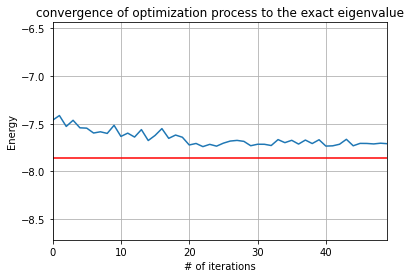

In [215]:
compare_exact_and_approximated_eigenvalue(LiH_molecule_4_qubits, LiH_approximated_eigenvalue)

#### Full Entangelment

In [216]:
%%time
LiH_approximated_eigenvalue = get_approximated_eigenvalue_of_hamiltonian(LiH_molecule_4_qubits, "full")

3it [00:00, 22.74it/s]

{'1111': 63, '0110': 112, '1001': 226, '0001': 202, '0111': 10, '1000': 51, '0011': 37, '1110': 52, '0010': 9, '0100': 119, '1101': 16, '0000': 37, '1100': 19, '0101': 42, '1010': 18, '1011': 11}
1.0
{'1011': 175, '1111': 41, '0110': 112, '0011': 80, '0111': 141, '1001': 69, '0001': 138, '1110': 15, '0000': 81, '1100': 30, '1000': 46, '0101': 8, '1101': 59, '0100': 18, '1010': 10, '0010': 1}
1.0
{'0001': 174, '1001': 251, '1100': 109, '1000': 35, '0000': 64, '1111': 81, '1101': 47, '0111': 114, '0110': 37, '1010': 21, '1011': 1, '0100': 25, '0011': 29, '0101': 14, '0010': 18, '1110': 4}
1.0
{'1001': 92, '0001': 176, '1011': 85, '1000': 47, '1111': 16, '0011': 91, '0100': 123, '0111': 39, '1101': 151, '1010': 24, '0010': 47, '0101': 71, '0000': 11, '1110': 4, '1100': 38, '0110': 9}


6it [00:00, 16.67it/s]

1.0
{'1000': 45, '1101': 157, '0100': 139, '1001': 85, '0001': 153, '0011': 72, '1011': 72, '0111': 35, '0101': 82, '0010': 42, '1010': 32, '1100': 56, '0110': 18, '1111': 24, '0000': 10, '1110': 2}
1.0
{'1101': 125, '1010': 34, '0001': 180, '1001': 92, '0101': 79, '0010': 33, '1011': 83, '0011': 93, '0100': 128, '0110': 19, '1000': 45, '0111': 41, '1100': 46, '0000': 14, '1111': 10, '1110': 2}
1.0
{'1011': 71, '0010': 211, '1101': 138, '0011': 30, '0101': 201, '1111': 49, '1010': 100, '1001': 63, '1000': 21, '0100': 3, '0001': 32, '0110': 45, '1100': 25, '0111': 25, '0000': 8, '1110': 2}
1.0
{'0101': 137, '1010': 31, '0001': 79, '1000': 145, '0000': 61, '1101': 216, '0011': 63, '0010': 111, '1100': 32, '1110': 14, '1001': 29, '1011': 25, '1111': 54, '0110': 21, '0111': 6}
1.0


12it [00:00, 20.22it/s]

{'0001': 220, '1001': 226, '1111': 55, '0110': 134, '1110': 40, '0101': 30, '0100': 126, '0010': 11, '1011': 10, '1000': 40, '0011': 31, '1101': 19, '1100': 23, '0000': 27, '0111': 16, '1010': 16}
1.0
{'0001': 220, '1001': 204, '1010': 17, '0101': 31, '1110': 51, '0100': 118, '0110': 122, '1111': 66, '0000': 46, '0011': 33, '1000': 54, '0111': 6, '1011': 9, '1101': 16, '1100': 25, '0010': 6}
1.0
{'1001': 211, '0001': 218, '1000': 53, '0101': 29, '1111': 58, '0110': 132, '0100': 118, '0111': 12, '1110': 37, '1100': 32, '1101': 25, '0000': 29, '0011': 39, '1011': 16, '1010': 9, '0010': 6}
1.0
{'0100': 133, '1101': 21, '0001': 200, '1001': 219, '1111': 64, '0110': 136, '1000': 52, '0101': 28, '0000': 27, '0011': 40, '1100': 22, '0010': 10, '1110': 41, '0111': 11, '1011': 8, '1010': 12}
1.0
{'1001': 157, '1010': 53, '1101': 83, '0011': 94, '1100': 15, '1110': 121, '0110': 148, '0111': 16, '0001': 154, '0010': 58, '1011': 78, '1000': 13, '0100': 14, '0101': 18, '1111': 2}
1.0


15it [00:00, 21.27it/s]

{'0001': 201, '1001': 219, '1111': 66, '0110': 127, '0101': 34, '1100': 21, '0100': 123, '1000': 54, '0000': 29, '1110': 53, '0111': 6, '1010': 16, '0011': 30, '1101': 19, '0010': 8, '1011': 18}
1.0
{'0100': 138, '1000': 47, '1110': 47, '0101': 30, '1001': 251, '0001': 186, '0110': 127, '1100': 24, '0000': 28, '1111': 53, '1010': 15, '0011': 30, '0010': 10, '0111': 16, '1101': 14, '1011': 8}
1.0
{'1010': 20, '0001': 201, '1001': 216, '0100': 138, '1000': 59, '1100': 26, '0011': 34, '0110': 117, '1111': 57, '1110': 43, '0101': 30, '1101': 27, '0000': 32, '0111': 6, '1011': 7, '0010': 11}
1.0
{'1100': 39, '1001': 237, '0001': 217, '1110': 43, '0101': 46, '0000': 28, '1000': 46, '0110': 122, '0100': 117, '1101': 13, '1111': 43, '0111': 14, '0011': 25, '1011': 18, '0010': 7, '1010': 9}
1.0


20it [00:01, 18.22it/s]

{'0110': 128, '0011': 94, '1110': 148, '0111': 12, '0001': 152, '1001': 159, '1011': 79, '1101': 101, '1000': 18, '0010': 52, '0101': 14, '0100': 14, '1111': 5, '1010': 36, '1100': 12}
1.0
{'1000': 13, '0110': 144, '0011': 112, '0111': 20, '1110': 150, '1001': 139, '0010': 46, '1011': 87, '1010': 44, '0001': 149, '1101': 88, '0100': 11, '1100': 13, '1111': 2, '0101': 5, '0000': 1}
1.0
{'0011': 32, '1111': 70, '0110': 134, '0100': 122, '1001': 237, '0001': 195, '1110': 46, '1011': 9, '0111': 12, '0000': 32, '1000': 44, '0010': 4, '0101': 25, '1101': 24, '1100': 26, '1010': 12}
1.0
{'0110': 134, '0001': 199, '1001': 234, '0000': 31, '1000': 56, '0101': 24, '1101': 19, '1100': 35, '0100': 109, '0011': 35, '1010': 20, '1110': 40, '1111': 55, '0111': 12, '1011': 17, '0010': 4}
1.0
{'0100': 127, '1100': 21, '0001': 220, '1110': 41, '0101': 40, '1011': 14, '0110': 133, '1111': 57, '1010': 13, '1001': 231, '1101': 13, '0011': 21, '0111': 15, '0010': 6, '0000': 36, '1000': 36}
1.0


27it [00:01, 19.35it/s]

{'1111': 59, '0110': 113, '1010': 11, '0001': 221, '1001': 240, '0011': 28, '1110': 42, '0100': 128, '0111': 9, '1000': 47, '0101': 28, '1101': 16, '1011': 11, '1100': 32, '0000': 34, '0010': 5}
1.0
{'1111': 67, '1001': 209, '0001': 203, '0100': 111, '1101': 24, '0000': 41, '0101': 35, '1100': 28, '1000': 49, '0110': 136, '1010': 16, '0011': 40, '1110': 38, '0010': 11, '1011': 7, '0111': 9}
1.0
{'0110': 115, '1111': 55, '1110': 45, '0101': 31, '0001': 228, '1001': 246, '0010': 8, '0100': 109, '0000': 33, '1101': 15, '1000': 48, '1100': 24, '0011': 27, '1010': 15, '0111': 13, '1011': 12}
1.0
{'1001': 227, '0001': 211, '0100': 115, '1100': 34, '0011': 34, '0110': 124, '1000': 52, '0101': 34, '1110': 38, '1111': 64, '0000': 23, '1101': 19, '0111': 15, '0010': 10, '1010': 7, '1011': 17}
1.0
{'0101': 29, '1110': 39, '0001': 188, '1001': 259, '0011': 40, '0110': 127, '0100': 121, '1000': 53, '1111': 55, '0010': 12, '0111': 18, '1010': 8, '1011': 16, '0000': 23, '1101': 21, '1100': 15}
1.0


[-7.462882744167433, -7.413558354501493, -7.527616763482559, -7.463358308515701, -7.542165697542103, -7.54564906944211, -7.596790130772266, -7.583876423789713, -7.600896587943167, -7.515746344547128, -7.632507556645632, -7.598044667802598, -7.639147693909248, -7.560988771541857, -7.675442454837678, -7.622079965659733, -7.550549216902378, -7.652698557917512, -7.618042657596327, -7.641077813310959, -7.722139285879435, -7.70630044577901, -7.7393074632273295, -7.7156527883399875, -7.734413675713732, -7.703054437903954, -7.681103354862836, -7.67413219031604, -7.684315159085678, -7.730093496472124, -7.714549151939473, -7.714866668154968, -7.727871430773022, -7.665815111325502, -7.697743728326701, -7.673189424995715, -7.712618622613775, -7.670572217358177, -7.707149032377504, -7.6673484725623045, -7.733872406458095, -7.731045973771998, -7.714479583644238, -7.662864570702938, -7.730607644653333, -7.705472460989764, -7.7062372506252235, -7.71117873493011, -7.703563044443457, -7.708853300424329]

2it [00:00, 14.57it/s]

{'1001': 171, '0001': 147, '1010': 84, '0100': 137, '0111': 14, '0010': 77, '1110': 47, '1100': 68, '0110': 69, '1000': 43, '1011': 28, '0000': 31, '1101': 13, '0011': 75, '0101': 16, '1111': 4}
1.0
{'1011': 162, '0000': 135, '1000': 111, '1100': 65, '0011': 107, '0111': 88, '0001': 76, '1101': 14, '0101': 47, '0110': 98, '0010': 21, '1110': 33, '1001': 48, '1111': 12, '1010': 7}
1.0
{'0010': 110, '1001': 206, '1010': 118, '0001': 169, '0011': 22, '1100': 108, '0101': 32, '0111': 41, '1111': 34, '1101': 70, '0000': 29, '1011': 11, '0110': 46, '1000': 12, '0100': 7, '1110': 9}
1.0


6it [00:00, 16.35it/s]

{'0110': 64, '0001': 185, '1001': 114, '1101': 112, '0100': 50, '1000': 85, '0010': 116, '1110': 19, '1100': 19, '0101': 87, '1010': 79, '1011': 48, '0000': 11, '0111': 11, '0011': 21, '1111': 3}
1.0
{'1001': 110, '0001': 179, '1010': 67, '0100': 70, '1101': 103, '0101': 93, '1000': 80, '0110': 64, '0010': 119, '1110': 18, '0111': 13, '1011': 48, '0000': 12, '1111': 6, '0011': 22, '1100': 20}
1.0
{'1010': 58, '0001': 209, '1001': 101, '1100': 23, '1101': 110, '1000': 95, '0101': 70, '0110': 62, '0100': 61, '0000': 5, '1011': 49, '0010': 121, '1111': 8, '0011': 29, '0111': 12, '1110': 11}
1.0
{'0000': 13, '1000': 58, '1001': 73, '1010': 122, '0101': 167, '1011': 30, '0010': 252, '1111': 30, '0011': 22, '0001': 76, '1110': 17, '1101': 78, '1100': 17, '0111': 18, '0110': 43, '0100': 8}
1.0


9it [00:00, 18.53it/s]

{'1001': 34, '0001': 136, '0010': 164, '0011': 22, '1000': 142, '1101': 162, '1110': 12, '1111': 47, '0111': 24, '1100': 75, '1010': 80, '0101': 56, '0000': 61, '0100': 2, '1011': 4, '0110': 3}
1.0
{'0001': 154, '1010': 99, '1001': 163, '0100': 138, '0010': 76, '0011': 82, '1100': 61, '1000': 61, '0110': 56, '1110': 37, '1011': 22, '0000': 25, '0111': 10, '1101': 16, '0101': 18, '1111': 6}
1.0
{'1100': 66, '0011': 69, '1010': 88, '1001': 185, '0001': 156, '1000': 54, '0000': 28, '0100': 144, '0010': 72, '1110': 32, '0110': 59, '1111': 6, '0111': 15, '1011': 21, '0101': 17, '1101': 12}
1.0
{'1001': 163, '0001': 174, '1010': 71, '0100': 145, '0101': 14, '1000': 40, '0110': 81, '0010': 63, '1100': 52, '0011': 84, '1111': 3, '1110': 42, '1011': 24, '0000': 36, '0111': 14, '1101': 18}
1.0


12it [00:00, 21.38it/s]

{'1110': 31, '1001': 154, '1010': 87, '0000': 33, '1000': 48, '0110': 65, '0010': 81, '1011': 29, '1101': 14, '0011': 84, '0100': 129, '1100': 69, '0001': 162, '0111': 17, '0101': 12, '1111': 9}
1.0


15it [00:00, 19.05it/s]

{'0001': 165, '1010': 147, '1001': 165, '1110': 115, '0110': 98, '0011': 68, '1100': 66, '0010': 93, '1101': 30, '0100': 14, '0000': 8, '0101': 10, '1011': 31, '1000': 2, '1111': 4, '0111': 8}
1.0
{'0011': 73, '1110': 43, '1101': 30, '0100': 111, '1010': 85, '1001': 145, '1000': 66, '0010': 82, '0001': 159, '0111': 15, '0110': 68, '1100': 66, '1011': 24, '0000': 34, '0101': 17, '1111': 6}
1.0
{'0100': 137, '1010': 83, '1001': 137, '0001': 151, '1100': 91, '1000': 59, '1110': 48, '0010': 80, '1011': 21, '0000': 26, '0011': 86, '0110': 56, '0111': 13, '1101': 18, '0101': 14, '1111': 4}
1.0
{'0001': 129, '1010': 77, '1001': 163, '1011': 28, '0010': 80, '1100': 65, '0011': 79, '0101': 21, '0100': 122, '0000': 32, '1101': 15, '1110': 57, '0110': 76, '0111': 23, '1000': 53, '1111': 4}
1.0


20it [00:01, 17.13it/s]

{'0100': 154, '1110': 43, '1000': 59, '0000': 38, '1010': 72, '0001': 148, '0010': 71, '0011': 74, '0111': 15, '1011': 17, '1100': 61, '1101': 14, '0110': 73, '1001': 168, '0101': 15, '1111': 2}
1.0
{'1100': 69, '0011': 62, '0110': 99, '1001': 161, '0001': 177, '1010': 142, '0111': 4, '1101': 23, '1110': 127, '0010': 88, '0101': 8, '1011': 25, '0100': 24, '0000': 7, '1000': 3, '1111': 5}
1.0
{'0110': 103, '0001': 174, '1001': 167, '0011': 51, '1100': 53, '1110': 134, '0010': 97, '1101': 37, '1010': 139, '0100': 18, '0101': 16, '0000': 13, '0111': 4, '1011': 16, '1000': 2}
1.0
{'0001': 160, '1001': 162, '1010': 78, '1000': 54, '1111': 6, '0110': 78, '1101': 14, '1100': 72, '1011': 20, '0101': 22, '0011': 73, '0100': 140, '0010': 71, '1110': 35, '0000': 29, '0111': 10}
1.0
{'1010': 75, '0001': 164, '1001': 149, '1011': 30, '0111': 15, '1100': 81, '1101': 18, '0110': 63, '0000': 26, '1110': 49, '1000': 48, '0100': 139, '0011': 82, '0010': 67, '0101': 16, '1111': 2}
1.0


26it [00:01, 19.61it/s]

{'1100': 68, '1110': 48, '1010': 76, '0001': 158, '1001': 170, '0010': 78, '0100': 117, '0111': 16, '0000': 36, '0011': 92, '0110': 57, '1000': 51, '1011': 21, '1101': 22, '0101': 11, '1111': 3}
1.0
{'0100': 148, '0001': 160, '1001': 183, '0000': 32, '1000': 52, '1011': 23, '0010': 86, '0011': 62, '0110': 65, '1010': 61, '1110': 44, '1101': 13, '0101': 15, '1100': 64, '0111': 12, '1111': 4}
1.0
{'0011': 76, '1100': 74, '1000': 52, '0110': 60, '1001': 171, '0001': 160, '0010': 70, '0100': 138, '1110': 48, '1010': 66, '0111': 14, '1011': 23, '0000': 39, '1101': 17, '0101': 13, '1111': 3}
1.0
{'0110': 63, '0010': 88, '0001': 159, '1010': 82, '1001': 173, '1100': 63, '1101': 18, '0100': 128, '0011': 83, '0000': 30, '1011': 15, '1110': 40, '1000': 51, '0101': 15, '0111': 13, '1111': 3}
1.0
{'1001': 178, '1010': 79, '0111': 17, '1110': 44, '0110': 66, '0010': 57, '0100': 142, '1000': 58, '0011': 74, '1101': 17, '0001': 145, '0000': 32, '1100': 68, '0101': 8, '1011': 34, '1111': 5}
1.0


27it [00:01, 18.13it/s]


{'1010': 74, '1001': 180, '0001': 157, '0110': 64, '0011': 84, '0000': 42, '1110': 47, '1011': 21, '1000': 47, '0100': 124, '0111': 17, '1100': 55, '0010': 81, '1111': 7, '1101': 12, '0101': 12}
1.0
[-7.462882744167433, -7.413558354501493, -7.527616763482559, -7.463358308515701, -7.542165697542103, -7.54564906944211, -7.596790130772266, -7.583876423789713, -7.600896587943167, -7.515746344547128, -7.632507556645632, -7.598044667802598, -7.639147693909248, -7.560988771541857, -7.675442454837678, -7.622079965659733, -7.550549216902378, -7.652698557917512, -7.618042657596327, -7.641077813310959, -7.722139285879435, -7.70630044577901, -7.7393074632273295, -7.7156527883399875, -7.734413675713732, -7.703054437903954, -7.681103354862836, -7.67413219031604, -7.684315159085678, -7.730093496472124, -7.714549151939473, -7.714866668154968, -7.727871430773022, -7.665815111325502, -7.697743728326701, -7.673189424995715, -7.712618622613775, -7.670572217358177, -7.707149032377504, -7.6673484725623045, 

3it [00:00, 20.72it/s]

{'0110': 132, '0100': 124, '1011': 77, '0001': 178, '1001': 222, '1110': 56, '0000': 53, '0111': 36, '1101': 18, '1100': 32, '1111': 21, '0010': 7, '0101': 8, '1000': 30, '1010': 20, '0011': 10}
1.0
{'0111': 144, '1011': 115, '0000': 43, '0001': 116, '1010': 10, '1001': 119, '0101': 32, '0011': 89, '1101': 29, '1100': 10, '0110': 89, '1000': 118, '1110': 20, '1111': 62, '0100': 25, '0010': 3}
1.0
{'1000': 19, '0000': 120, '0011': 43, '1100': 74, '1001': 138, '0001': 217, '1101': 71, '1111': 169, '1011': 28, '0100': 32, '1110': 33, '0010': 27, '0110': 5, '0111': 34, '0101': 1, '1010': 13}
1.0
{'0001': 174, '1001': 47, '0100': 85, '1101': 170, '0010': 30, '0111': 90, '1100': 58, '1000': 64, '0101': 73, '0011': 62, '1110': 36, '1011': 110, '1010': 8, '0110': 3, '0000': 13, '1111': 1}
1.0
{'1101': 144, '0100': 98, '0001': 182, '1001': 45, '1000': 84, '0011': 72, '1100': 54, '1011': 106, '0010': 48, '0101': 69, '0111': 80, '1110': 27, '0000': 12, '0110': 2, '1010': 1}
1.0


9it [00:00, 23.27it/s]

{'0100': 81, '1101': 169, '1011': 127, '0111': 81, '0000': 13, '0001': 175, '1100': 52, '0101': 69, '1000': 63, '0011': 78, '1110': 36, '1001': 35, '0010': 39, '0110': 1, '1010': 4, '1111': 1}
1.0
{'1101': 172, '1011': 33, '0010': 216, '1010': 120, '1001': 104, '1111': 47, '0101': 154, '0011': 37, '1110': 19, '0111': 18, '0110': 61, '0100': 12, '0001': 23, '1100': 4, '0000': 4}
1.0
{'1110': 50, '0101': 229, '1000': 149, '1010': 126, '0001': 108, '1111': 2, '1011': 42, '1100': 44, '1001': 16, '0011': 34, '0111': 66, '0000': 27, '1101': 113, '0010': 10, '0100': 1, '0110': 7}
1.0
{'1011': 92, '1010': 24, '0001': 172, '1001': 221, '0000': 46, '0100': 109, '0110': 121, '1111': 25, '0101': 10, '1101': 23, '0111': 51, '1110': 37, '1000': 29, '1100': 46, '0011': 12, '0010': 6}
1.0
{'1110': 57, '0111': 50, '1010': 11, '1001': 233, '0001': 159, '0000': 61, '1011': 75, '1100': 30, '0100': 123, '0110': 128, '1111': 26, '1000': 29, '1101': 20, '0101': 8, '0011': 13, '0010': 1}
1.0
{'0100': 128, '10

12it [00:00, 22.97it/s]

{'0111': 48, '0001': 170, '1001': 245, '1101': 30, '0100': 118, '0011': 14, '0000': 48, '1011': 71, '1110': 50, '1111': 16, '0110': 123, '1100': 34, '1000': 25, '1010': 15, '0010': 6, '0101': 11}
1.0
{'1001': 48, '1010': 69, '0001': 316, '0101': 41, '1110': 293, '0110': 29, '1101': 41, '0011': 66, '0010': 14, '1100': 19, '1000': 10, '1011': 50, '0100': 1, '1111': 21, '0111': 4, '0000': 2}
1.0
{'0100': 121, '0111': 38, '0000': 45, '0001': 159, '1001': 226, '0110': 131, '1100': 25, '1011': 92, '1110': 45, '1000': 37, '1111': 21, '1101': 30, '0101': 19, '1010': 19, '0011': 14, '0010': 2}
1.0


15it [00:00, 18.86it/s]

{'0110': 129, '0111': 46, '0001': 179, '1001': 245, '0101': 15, '0100': 101, '1011': 79, '1000': 25, '1100': 38, '0011': 17, '0000': 47, '1110': 46, '1111': 20, '1101': 21, '1010': 11, '0010': 5}
1.0
{'0001': 167, '1001': 249, '1000': 34, '0110': 114, '1111': 22, '0100': 127, '0101': 12, '1011': 69, '0000': 42, '0111': 51, '1010': 19, '1101': 30, '1110': 44, '1100': 34, '0011': 6, '0010': 4}
1.0
{'0001': 177, '1001': 248, '1101': 24, '0100': 111, '0110': 138, '0111': 44, '0000': 56, '1110': 46, '1111': 14, '1011': 69, '1000': 27, '0011': 10, '1100': 28, '0101': 11, '1010': 12, '0010': 9}
1.0


18it [00:00, 19.77it/s]

{'1101': 35, '1110': 289, '0001': 316, '1001': 53, '1111': 28, '0110': 34, '1011': 67, '0011': 49, '1010': 80, '0101': 39, '0100': 2, '1100': 8, '0000': 4, '0010': 11, '1000': 6, '0111': 3}
1.0
{'1011': 64, '1101': 33, '1010': 71, '0001': 338, '1110': 278, '0011': 55, '1100': 10, '0110': 34, '1001': 49, '1000': 13, '0101': 40, '0010': 6, '1111': 23, '0111': 5, '0100': 4, '0000': 1}
1.0


21it [00:00, 21.08it/s]

{'0110': 145, '1001': 237, '1010': 18, '0001': 155, '1101': 27, '0100': 127, '1110': 50, '0000': 44, '1000': 24, '1100': 22, '1011': 79, '1111': 12, '0111': 55, '0011': 16, '0101': 10, '0010': 3}
1.0
{'0001': 172, '1001': 257, '0100': 99, '1011': 72, '0110': 122, '1111': 24, '0011': 14, '0111': 45, '1010': 23, '1100': 40, '0000': 51, '1110': 44, '1000': 25, '1101': 24, '0010': 3, '0101': 9}
1.0
{'0110': 136, '1111': 16, '0111': 42, '1011': 67, '0001': 174, '1001': 253, '1110': 44, '0000': 41, '0100': 127, '1101': 25, '1100': 31, '0011': 11, '0101': 7, '1010': 12, '1000': 31, '0010': 7}
1.0


24it [00:01, 22.01it/s]

{'0001': 172, '1001': 244, '0101': 11, '1110': 52, '1100': 33, '0100': 116, '0111': 47, '1011': 94, '1101': 17, '0110': 117, '1010': 23, '1111': 14, '0000': 32, '1000': 34, '0010': 3, '0011': 15}
1.0
{'1100': 37, '0011': 6, '1001': 221, '0001': 182, '1101': 33, '0100': 112, '0000': 51, '0110': 142, '1011': 70, '1111': 15, '1000': 25, '0111': 58, '1010': 10, '1110': 42, '0101': 16, '0010': 4}
1.0


27it [00:01, 21.90it/s]


{'0100': 100, '1101': 30, '0001': 176, '1001': 258, '0111': 42, '0110': 141, '1110': 41, '0011': 18, '1010': 20, '1000': 28, '1011': 70, '1100': 30, '0000': 46, '1111': 14, '0101': 5, '0010': 5}
1.0
{'1111': 17, '0110': 136, '1100': 37, '1001': 248, '0001': 176, '1000': 25, '1110': 37, '0111': 49, '0101': 12, '0000': 47, '0100': 112, '1101': 24, '0011': 10, '1011': 77, '1010': 13, '0010': 4}
1.0
{'0110': 148, '1110': 54, '1010': 23, '1001': 263, '0001': 191, '0100': 95, '1011': 66, '0000': 40, '1111': 13, '1000': 15, '1100': 28, '0101': 8, '0111': 42, '1101': 23, '0011': 12, '0010': 3}
1.0
[-7.462882744167433, -7.413558354501493, -7.527616763482559, -7.463358308515701, -7.542165697542103, -7.54564906944211, -7.596790130772266, -7.583876423789713, -7.600896587943167, -7.515746344547128, -7.632507556645632, -7.598044667802598, -7.639147693909248, -7.560988771541857, -7.675442454837678, -7.622079965659733, -7.550549216902378, -7.652698557917512, -7.618042657596327, -7.641077813310959, -7.

0it [00:00, ?it/s]

{'1010': 41, '1001': 322, '1110': 123, '0101': 8, '0100': 65, '1100': 56, '0110': 56, '1011': 179, '0000': 26, '0001': 79, '1101': 25, '0011': 9, '0111': 16, '1111': 11, '1000': 8}
1.0


2it [00:00, 12.27it/s]

{'0110': 40, '0001': 63, '1001': 210, '1101': 19, '0100': 10, '1011': 148, '0111': 85, '1100': 27, '0101': 18, '1000': 175, '1111': 113, '0011': 27, '1110': 59, '0000': 17, '1010': 12, '0010': 1}
1.0
{'0111': 24, '0001': 99, '1010': 40, '1001': 201, '0100': 55, '0000': 73, '1000': 78, '1011': 59, '1110': 24, '1101': 44, '1111': 140, '1100': 34, '0011': 97, '0010': 31, '0110': 10, '0101': 15}
1.0
{'1001': 118, '0001': 65, '0000': 16, '1110': 46, '0101': 45, '1011': 222, '1101': 133, '1100': 165, '0100': 36, '1000': 38, '0111': 46, '0011': 34, '1010': 35, '0010': 8, '1111': 17}
1.0
{'1011': 218, '1101': 123, '1100': 179, '1000': 34, '0000': 15, '0111': 42, '1110': 48, '1010': 42, '0100': 23, '0101': 49, '1001': 125, '0001': 50, '1111': 28, '0010': 9, '0011': 37, '0110': 2}
1.0


5it [00:00, 18.02it/s]

{'0100': 29, '1101': 131, '1100': 158, '1010': 43, '1001': 102, '0101': 45, '1000': 22, '1011': 253, '0001': 73, '1111': 26, '0010': 10, '0111': 47, '0000': 11, '1110': 56, '0011': 16, '0110': 2}
1.0
{'1111': 70, '1001': 170, '1010': 180, '1101': 264, '1110': 19, '0101': 59, '1011': 68, '0010': 89, '0111': 12, '0001': 15, '0110': 35, '0011': 14, '1000': 15, '0100': 11, '0000': 2, '1100': 1}
1.0


11it [00:00, 22.26it/s]

{'1010': 161, '1110': 25, '0101': 149, '0000': 30, '1000': 94, '1101': 191, '1111': 19, '0111': 61, '0011': 35, '0100': 25, '1001': 55, '1011': 94, '0001': 40, '1100': 5, '0010': 39, '0110': 1}
1.0
{'0001': 65, '1001': 327, '1010': 54, '1101': 30, '0100': 61, '1110': 120, '1100': 57, '1011': 177, '0111': 24, '0000': 25, '0110': 49, '0010': 2, '1000': 15, '1111': 8, '0011': 8, '0101': 2}
1.0
{'1110': 107, '0001': 51, '1001': 348, '1011': 172, '0100': 52, '0111': 28, '0110': 42, '1100': 58, '1101': 43, '0011': 12, '0000': 35, '1010': 48, '1000': 15, '0010': 1, '1111': 8, '0101': 4}
1.0
{'0001': 67, '1001': 332, '1011': 192, '1110': 110, '0100': 53, '0011': 9, '1100': 56, '0110': 57, '1010': 39, '0000': 26, '1111': 16, '0111': 23, '1101': 23, '1000': 14, '0010': 1, '0101': 6}
1.0
{'1001': 306, '0001': 70, '1100': 60, '0100': 51, '1110': 131, '0110': 61, '0111': 23, '1011': 191, '0000': 21, '1101': 28, '1010': 43, '1111': 10, '0010': 2, '1000': 19, '0011': 7, '0101': 1}
1.0


14it [00:00, 21.56it/s]

{'1010': 49, '1001': 294, '0001': 221, '1111': 26, '0110': 67, '1110': 186, '1011': 77, '0011': 29, '1101': 30, '0101': 18, '0000': 8, '0111': 1, '0100': 7, '1100': 8, '0010': 3}
1.0
{'1010': 45, '1001': 342, '0001': 70, '1011': 163, '0111': 18, '1110': 122, '0100': 58, '1101': 28, '1100': 52, '1111': 10, '0011': 13, '0110': 53, '1000': 19, '0000': 24, '0101': 7}
1.0
{'0001': 54, '1010': 35, '1001': 342, '0100': 51, '1101': 31, '1011': 185, '1100': 57, '0000': 29, '1110': 121, '0111': 30, '0011': 9, '1111': 6, '1000': 17, '0110': 51, '0101': 5, '0010': 1}
1.0
{'1001': 353, '0001': 63, '1011': 189, '1110': 115, '0111': 27, '0110': 49, '0100': 62, '1100': 48, '1111': 11, '1101': 24, '0101': 4, '1000': 11, '0000': 20, '1010': 41, '0011': 7}
1.0


20it [00:00, 21.00it/s]

{'1011': 165, '0001': 65, '1001': 345, '0110': 48, '1111': 11, '1110': 124, '0100': 56, '1100': 53, '1010': 49, '0111': 23, '0000': 27, '1101': 30, '1000': 10, '0101': 7, '0011': 10, '0010': 1}
1.0
{'1010': 85, '0001': 222, '1001': 265, '1111': 33, '0110': 65, '1110': 181, '0000': 13, '0011': 27, '0010': 6, '1011': 75, '0101': 16, '1101': 18, '0100': 7, '1100': 9, '0111': 2}
1.0
{'1110': 192, '0101': 18, '1001': 251, '0001': 216, '1010': 63, '0011': 37, '1100': 13, '0110': 60, '1011': 99, '1111': 27, '1101': 18, '0100': 11, '0000': 16, '0010': 2, '0111': 1}
1.0
{'0111': 19, '1101': 25, '1010': 44, '1001': 338, '1110': 122, '1011': 198, '0011': 8, '0000': 27, '0001': 70, '1000': 14, '0110': 45, '0101': 4, '1100': 65, '0100': 39, '0010': 2, '1111': 4}
1.0
{'1101': 31, '1010': 55, '0001': 56, '1001': 349, '1011': 196, '1110': 112, '0110': 55, '0111': 21, '0000': 13, '0100': 56, '1100': 48, '0101': 7, '1000': 6, '0010': 3, '0011': 9, '1111': 7}
1.0


26it [00:01, 22.84it/s]

{'1011': 177, '0100': 53, '1101': 28, '0001': 56, '1001': 349, '0000': 26, '1110': 127, '1100': 58, '0111': 20, '0011': 9, '1010': 44, '0110': 52, '1111': 10, '1000': 9, '0101': 4, '0010': 2}
1.0
{'0001': 77, '1001': 349, '0111': 26, '1011': 170, '1110': 119, '1100': 67, '0000': 20, '1101': 39, '0100': 46, '1010': 36, '0110': 46, '1000': 10, '1111': 10, '0011': 5, '0010': 1, '0101': 3}
1.0
{'1011': 188, '0001': 64, '1001': 331, '1100': 68, '0111': 28, '0100': 58, '0110': 47, '0000': 25, '1110': 121, '1111': 9, '1101': 30, '1000': 13, '0101': 9, '1010': 26, '0010': 1, '0011': 6}
1.0
{'0110': 61, '1010': 44, '1001': 328, '1011': 174, '0111': 20, '1110': 112, '0100': 67, '1100': 55, '0011': 12, '1101': 34, '0000': 21, '0001': 60, '1111': 14, '1000': 14, '0101': 6, '0010': 2}
1.0
{'1001': 337, '0001': 71, '1101': 37, '0010': 1, '1011': 172, '0110': 49, '1000': 16, '0000': 23, '1110': 126, '0011': 13, '1100': 50, '0111': 25, '1010': 44, '0100': 47, '1111': 10, '0101': 3}
1.0


27it [00:01, 21.30it/s]

{'1001': 334, '1101': 28, '0100': 57, '1110': 105, '1011': 184, '1100': 65, '0110': 46, '0000': 23, '1010': 37, '0001': 74, '0011': 9, '1000': 12, '0111': 30, '1111': 10, '0101': 8, '0010': 2}
1.0


[-7.462882744167433, -7.413558354501493, -7.527616763482559, -7.463358308515701, -7.542165697542103, -7.54564906944211, -7.596790130772266, -7.583876423789713, -7.600896587943167, -7.515746344547128, -7.632507556645632, -7.598044667802598, -7.639147693909248, -7.560988771541857, -7.675442454837678, -7.622079965659733, -7.550549216902378, -7.652698557917512, -7.618042657596327, -7.641077813310959, -7.722139285879435, -7.70630044577901, -7.7393074632273295, -7.7156527883399875, -7.734413675713732, -7.703054437903954, -7.681103354862836, -7.67413219031604, -7.684315159085678, -7.730093496472124, -7.714549151939473, -7.714866668154968, -7.727871430773022, -7.665815111325502, -7.697743728326701, -7.673189424995715, -7.712618622613775, -7.670572217358177, -7.707149032377504, -7.6673484725623045, -7.733872406458095, -7.731045973771998, -7.714479583644238, -7.662864570702938, -7.730607644653333, -7.705472460989764, -7.7062372506252235, -7.71117873493011, -7.703563044443457, -7.708853300424329,

1it [00:00,  9.70it/s]

{'0110': 47, '1110': 110, '1001': 267, '0001': 114, '1010': 36, '0010': 19, '1011': 150, '0111': 87, '0011': 57, '0100': 12, '1100': 75, '1000': 13, '0000': 13, '1101': 19, '1111': 2, '0101': 3}
1.0
{'0110': 13, '1111': 83, '0011': 87, '1011': 140, '1001': 150, '1110': 96, '0000': 92, '0111': 36, '1101': 18, '1010': 4, '1000': 137, '0101': 55, '0100': 67, '0010': 3, '1100': 16, '0001': 27}
1.0


3it [00:00, 13.91it/s]

{'1010': 61, '0000': 80, '1000': 104, '0101': 17, '0111': 32, '1011': 114, '1111': 128, '1101': 7, '0011': 47, '1001': 107, '0010': 24, '0001': 129, '0100': 74, '1110': 85, '1100': 10, '0110': 5}
1.0
{'0011': 114, '1100': 185, '0010': 77, '1011': 173, '0101': 51, '1010': 38, '1001': 120, '0100': 12, '1000': 25, '1101': 78, '0000': 49, '1111': 30, '1110': 36, '0001': 26, '0111': 7, '0110': 3}
1.0


6it [00:00, 17.99it/s]

{'1010': 31, '1001': 109, '1111': 37, '1100': 158, '0011': 114, '1011': 191, '0101': 47, '0000': 68, '0110': 6, '0010': 98, '1000': 20, '0111': 12, '1101': 57, '1110': 39, '0100': 8, '0001': 29}
1.0
{'0011': 109, '1100': 175, '1011': 203, '0000': 66, '0101': 40, '1101': 69, '1001': 114, '0001': 30, '1010': 36, '1111': 25, '1000': 16, '0010': 87, '1110': 30, '0111': 7, '0100': 15, '0110': 2}
1.0
{'1001': 97, '0001': 129, '1010': 198, '1000': 15, '0000': 45, '1101': 211, '0011': 87, '1110': 16, '1100': 1, '0100': 13, '1111': 51, '0101': 59, '1011': 59, '0010': 32, '0111': 9, '0110': 2}
1.0


9it [00:00, 19.93it/s]

{'1101': 110, '1011': 166, '0101': 139, '1001': 97, '0001': 54, '1010': 202, '1100': 14, '0111': 47, '0011': 57, '0010': 16, '0000': 72, '1111': 15, '1110': 9, '0100': 9, '1000': 17}
1.0
{'0011': 57, '1010': 32, '1001': 254, '1110': 104, '0110': 64, '0111': 104, '1011': 124, '0100': 7, '0001': 120, '1100': 71, '1101': 19, '0010': 25, '0101': 1, '1000': 14, '0000': 19, '1111': 9}
1.0


12it [00:00, 20.96it/s]

{'0001': 149, '1001': 262, '0101': 3, '1110': 135, '1011': 135, '1100': 56, '0011': 65, '0111': 75, '1000': 10, '1101': 14, '0000': 14, '0010': 18, '1010': 31, '0110': 45, '0100': 7, '1111': 5}
1.0
{'1010': 37, '0001': 120, '1001': 269, '1110': 106, '0010': 24, '1100': 75, '0011': 56, '0110': 40, '0111': 87, '1011': 140, '1000': 15, '1101': 26, '0100': 10, '0000': 10, '0101': 3, '1111': 6}
1.0
{'0111': 73, '0001': 119, '1001': 244, '1111': 11, '0110': 47, '1011': 156, '1110': 131, '1100': 63, '0011': 63, '1010': 47, '0010': 15, '0000': 9, '0101': 8, '1101': 17, '0100': 15, '1000': 6}
1.0
{'0001': 171, '1001': 232, '1010': 60, '1011': 103, '0011': 64, '0110': 66, '1110': 108, '0101': 73, '1111': 47, '1100': 45, '0100': 12, '0000': 1, '1000': 14, '1101': 9, '0010': 18, '0111': 1}
1.0


15it [00:00, 18.13it/s]

{'1100': 88, '0001': 136, '1010': 34, '1001': 251, '0111': 76, '0110': 50, '1011': 147, '1110': 99, '0101': 5, '0011': 55, '1000': 13, '0000': 17, '0010': 21, '1111': 8, '1101': 11, '0100': 13}
1.0
{'1001': 256, '0001': 138, '0111': 81, '1110': 110, '1100': 63, '0011': 54, '1011': 141, '1101': 20, '0101': 6, '0010': 23, '1010': 41, '0110': 60, '1000': 14, '0000': 13, '0100': 3, '1111': 1}
1.0
{'1001': 244, '1010': 42, '0001': 137, '0111': 69, '1011': 159, '1100': 74, '1101': 19, '1110': 110, '0011': 52, '0110': 55, '1111': 4, '0010': 21, '0000': 13, '0101': 4, '0100': 10, '1000': 11}
1.0
{'1001': 274, '0110': 47, '1100': 69, '1011': 138, '1110': 107, '0111': 74, '1000': 17, '1101': 22, '1010': 31, '0001': 152, '0100': 12, '0000': 9, '0010': 19, '0011': 45, '0101': 4, '1111': 4}
1.0


20it [00:01, 18.22it/s]

{'1010': 51, '1001': 255, '0001': 183, '1101': 10, '1100': 34, '1011': 98, '0101': 71, '1110': 121, '0011': 63, '0010': 21, '1111': 26, '0110': 54, '1000': 17, '0111': 4, '0100': 15, '0000': 1}
1.0
{'1110': 120, '0101': 63, '1011': 114, '0110': 56, '1001': 246, '0001': 164, '1100': 58, '0011': 72, '1111': 42, '1010': 52, '0010': 10, '0111': 5, '0100': 7, '1000': 10, '1101': 5}
1.0
{'1110': 117, '1001': 258, '0001': 115, '1011': 134, '1100': 62, '0011': 74, '1101': 30, '0100': 11, '0000': 13, '0010': 16, '0111': 95, '0110': 52, '0101': 8, '1010': 27, '1111': 3, '1000': 9}
1.0
{'1001': 290, '0001': 136, '0111': 88, '0110': 54, '1000': 9, '1110': 98, '1011': 121, '1100': 67, '0101': 5, '1101': 26, '0011': 53, '1010': 34, '1111': 8, '0010': 11, '0000': 19, '0100': 5}
1.0


25it [00:01, 19.39it/s]

{'0110': 44, '0001': 130, '1001': 256, '1110': 117, '0111': 89, '0011': 76, '1101': 21, '1011': 143, '1100': 58, '0010': 19, '0000': 15, '1000': 7, '1010': 28, '0101': 4, '0100': 11, '1111': 6}
1.0
{'1100': 82, '1011': 136, '0001': 122, '1001': 265, '1110': 95, '1000': 11, '0111': 84, '0100': 11, '0000': 11, '0110': 65, '0010': 15, '1010': 38, '0011': 53, '1111': 5, '1101': 24, '0101': 7}
1.0
{'0001': 136, '1001': 271, '0010': 18, '1011': 149, '1110': 104, '0011': 48, '1100': 50, '1101': 23, '0111': 84, '0110': 53, '0000': 16, '0100': 12, '1010': 40, '1000': 12, '1111': 6, '0101': 2}
1.0
{'1100': 72, '1010': 45, '1001': 250, '1011': 146, '0010': 26, '0110': 42, '1110': 87, '1101': 17, '0011': 53, '0001': 151, '0111': 90, '0000': 14, '0100': 11, '1111': 11, '1000': 4, '0101': 5}
1.0
{'0111': 93, '0000': 19, '1010': 35, '1001': 253, '1011': 146, '1110': 102, '0011': 34, '1100': 69, '0100': 8, '0001': 137, '0101': 11, '0110': 55, '0010': 27, '1101': 20, '1111': 8, '1000': 7}
1.0


27it [00:01, 18.72it/s]


{'0010': 24, '1011': 155, '1110': 101, '1001': 249, '0001': 135, '0111': 85, '0110': 54, '1100': 73, '1010': 36, '0011': 56, '0000': 7, '1101': 23, '0100': 9, '1000': 10, '1111': 4, '0101': 3}
1.0
[-7.462882744167433, -7.413558354501493, -7.527616763482559, -7.463358308515701, -7.542165697542103, -7.54564906944211, -7.596790130772266, -7.583876423789713, -7.600896587943167, -7.515746344547128, -7.632507556645632, -7.598044667802598, -7.639147693909248, -7.560988771541857, -7.675442454837678, -7.622079965659733, -7.550549216902378, -7.652698557917512, -7.618042657596327, -7.641077813310959, -7.722139285879435, -7.70630044577901, -7.7393074632273295, -7.7156527883399875, -7.734413675713732, -7.703054437903954, -7.681103354862836, -7.67413219031604, -7.684315159085678, -7.730093496472124, -7.714549151939473, -7.714866668154968, -7.727871430773022, -7.665815111325502, -7.697743728326701, -7.673189424995715, -7.712618622613775, -7.670572217358177, -7.707149032377504, -7.6673484725623045, -7

2it [00:00, 15.74it/s]

{'0001': 48, '1001': 381, '1011': 191, '0100': 75, '0111': 13, '1110': 95, '0000': 26, '0011': 11, '1100': 92, '1101': 11, '1010': 8, '0110': 40, '1000': 10, '1111': 4, '0010': 15, '0101': 4}
1.0
{'0111': 58, '0101': 6, '1110': 129, '1011': 122, '1000': 205, '1001': 223, '1010': 24, '1111': 83, '0001': 51, '0110': 36, '0011': 31, '0000': 22, '0100': 24, '1101': 2, '0010': 4, '1100': 4}
1.0
{'0001': 105, '1001': 208, '0000': 60, '1000': 97, '1111': 84, '1110': 46, '0011': 83, '1100': 51, '1101': 29, '1011': 58, '0100': 49, '0010': 50, '1010': 72, '0110': 10, '0101': 16, '0111': 6}
1.0


6it [00:00, 15.47it/s]

{'0101': 55, '0011': 17, '1100': 145, '1011': 160, '1101': 119, '1001': 139, '0001': 70, '0000': 27, '1110': 93, '1000': 43, '1010': 63, '0111': 30, '0100': 21, '1111': 15, '0010': 21, '0110': 6}
1.0
{'0101': 37, '1110': 101, '1001': 148, '0001': 58, '1100': 181, '1111': 13, '1011': 147, '1101': 120, '1010': 43, '0100': 32, '0011': 13, '1000': 45, '0111': 35, '0000': 18, '0010': 26, '0110': 7}
1.0
{'1100': 154, '1110': 71, '0001': 67, '1010': 60, '1001': 169, '0111': 31, '1101': 124, '1011': 154, '0100': 26, '1000': 55, '0010': 26, '0101': 44, '0000': 15, '0011': 14, '1111': 10, '0110': 4}
1.0
{'0010': 105, '1101': 239, '1110': 48, '0101': 42, '1010': 140, '1001': 196, '0110': 48, '1111': 115, '1011': 33, '0001': 30, '0011': 5, '0000': 12, '0100': 2, '0111': 7, '1000': 1, '1100': 1}
1.0


10it [00:00, 17.78it/s]

{'1010': 96, '1001': 77, '1000': 101, '0101': 108, '1110': 44, '1011': 121, '1101': 190, '0100': 27, '0111': 73, '1100': 16, '0010': 7, '0011': 54, '0001': 45, '1111': 16, '0000': 40, '0110': 9}
1.0
{'1100': 96, '1001': 357, '0100': 78, '1011': 199, '0000': 26, '1110': 94, '0111': 18, '0110': 33, '1000': 8, '0010': 16, '0001': 56, '1101': 13, '0011': 15, '1111': 6, '0101': 4, '1010': 5}
1.0
{'1100': 84, '0001': 39, '1001': 370, '1011': 193, '1110': 109, '0100': 84, '0110': 29, '1000': 14, '0011': 19, '0010': 8, '0000': 28, '0111': 16, '1111': 8, '1101': 15, '1010': 4, '0101': 4}
1.0
{'1011': 218, '1001': 353, '1110': 91, '0100': 76, '1100': 70, '0111': 15, '1000': 11, '0000': 21, '0110': 38, '0101': 8, '1101': 16, '0011': 16, '0001': 68, '1111': 5, '1010': 7, '0010': 11}
1.0
{'1000': 18, '1001': 332, '0001': 65, '0100': 72, '0110': 38, '1110': 105, '1011': 205, '0111': 18, '1100': 87, '0000': 25, '1101': 19, '1111': 7, '0010': 13, '0011': 9, '0101': 3, '1010': 8}
1.0


13it [00:00, 17.99it/s]

{'1010': 45, '0001': 241, '1001': 228, '1111': 17, '0011': 50, '0100': 8, '1110': 224, '1011': 116, '0000': 5, '1000': 7, '0110': 62, '1101': 9, '0101': 9, '0111': 2, '1100': 1}
1.0
{'1011': 227, '0100': 76, '1101': 13, '0001': 53, '1001': 360, '1110': 83, '0110': 38, '1111': 6, '1000': 15, '0010': 10, '0011': 8, '1100': 77, '0000': 32, '0111': 12, '0101': 7, '1010': 7}
1.0
{'0001': 54, '1001': 357, '1011': 213, '1110': 94, '1100': 84, '0100': 72, '1000': 12, '0111': 19, '0011': 18, '0101': 7, '0110': 33, '1010': 7, '1111': 6, '1101': 12, '0010': 8, '0000': 28}
1.0


19it [00:01, 16.97it/s]

{'1001': 354, '0001': 65, '0010': 10, '1011': 211, '0100': 68, '1101': 18, '1110': 98, '1100': 76, '0110': 33, '0011': 15, '0000': 27, '1111': 8, '1010': 6, '1000': 16, '0111': 14, '0101': 5}
1.0
{'1101': 15, '0100': 75, '1110': 83, '0001': 52, '1001': 375, '1011': 205, '0010': 12, '1000': 11, '0011': 18, '1100': 73, '0110': 43, '0101': 4, '0000': 27, '0111': 16, '1010': 7, '1111': 8}
1.0
{'1001': 256, '0001': 236, '1011': 106, '0101': 6, '1110': 221, '0011': 45, '1111': 22, '0110': 71, '1010': 30, '0111': 3, '0000': 4, '1000': 9, '1101': 4, '0100': 9, '1100': 2}
1.0
{'0110': 55, '1110': 221, '1010': 29, '0001': 241, '1001': 256, '1011': 105, '1101': 3, '0011': 62, '1111': 25, '0100': 7, '0000': 6, '0101': 4, '1000': 4, '0111': 5, '1100': 1}
1.0


22it [00:01, 18.53it/s]

{'1001': 353, '0111': 16, '1100': 84, '0011': 16, '0100': 71, '0110': 42, '1110': 98, '1011': 218, '1111': 4, '1101': 9, '0001': 61, '0000': 27, '0010': 5, '1000': 10, '1010': 8, '0101': 2}
1.0
{'0001': 49, '1001': 370, '0000': 32, '1100': 91, '0011': 5, '0110': 44, '1011': 213, '0100': 90, '1111': 5, '0111': 8, '1110': 78, '1000': 6, '1101': 8, '1010': 12, '0101': 7, '0010': 6}
1.0
{'1010': 5, '0001': 57, '1001': 355, '1011': 228, '0100': 79, '1110': 89, '0111': 16, '1100': 78, '0010': 13, '0101': 7, '0110': 46, '0000': 17, '1000': 4, '1101': 13, '0011': 15, '1111': 2}
1.0
{'1110': 95, '0001': 58, '1001': 366, '0100': 68, '0110': 34, '0000': 25, '1000': 9, '0010': 9, '0011': 12, '1100': 93, '1011': 208, '0111': 19, '1010': 10, '1111': 9, '1101': 9}
1.0
{'1011': 211, '0001': 50, '1001': 358, '1110': 107, '0100': 82, '0011': 11, '1100': 83, '0110': 31, '0000': 27, '0101': 3, '1000': 12, '1101': 21, '1111': 7, '0010': 5, '1010': 6, '0111': 10}
1.0


27it [00:01, 16.67it/s]


{'1100': 90, '1110': 102, '1011': 178, '0110': 43, '0100': 80, '1001': 371, '0001': 58, '0000': 22, '0010': 12, '0101': 4, '0111': 12, '1000': 12, '1010': 8, '1101': 12, '0011': 14, '1111': 6}
1.0
{'1101': 14, '1011': 216, '0001': 64, '1001': 349, '1110': 107, '0011': 18, '1100': 92, '0110': 34, '0100': 63, '0101': 10, '0000': 19, '1010': 7, '0010': 14, '1111': 2, '0111': 6, '1000': 9}
1.0
{'1011': 214, '0001': 48, '1001': 366, '1100': 80, '1111': 3, '0110': 33, '1110': 86, '0100': 86, '1000': 10, '1010': 14, '1101': 15, '0000': 28, '0111': 13, '0010': 12, '0101': 7, '0011': 9}
1.0
[-7.462882744167433, -7.413558354501493, -7.527616763482559, -7.463358308515701, -7.542165697542103, -7.54564906944211, -7.596790130772266, -7.583876423789713, -7.600896587943167, -7.515746344547128, -7.632507556645632, -7.598044667802598, -7.639147693909248, -7.560988771541857, -7.675442454837678, -7.622079965659733, -7.550549216902378, -7.652698557917512, -7.618042657596327, -7.641077813310959, -7.72213928

4it [00:00, 17.75it/s]

{'1011': 109, '0100': 71, '1101': 15, '1001': 254, '1010': 46, '0001': 65, '0110': 33, '1110': 248, '0111': 25, '0000': 13, '1100': 63, '1000': 38, '1111': 29, '0101': 9, '0011': 5, '0010': 1}
1.0
{'0110': 28, '1001': 133, '0100': 30, '1101': 31, '0111': 77, '1000': 125, '1110': 139, '1011': 200, '0011': 27, '0001': 37, '1111': 157, '0000': 20, '0101': 16, '1010': 3, '0010': 1}
1.0
{'0001': 84, '1001': 184, '1010': 26, '1111': 205, '0011': 55, '0100': 51, '0111': 33, '1110': 35, '1100': 76, '1101': 58, '1011': 50, '0101': 15, '0010': 27, '0000': 51, '0110': 34, '1000': 40}
1.0
{'1011': 274, '0011': 30, '1100': 120, '1001': 169, '1010': 81, '0001': 62, '0100': 51, '1101': 78, '0101': 34, '1110': 29, '0111': 26, '0000': 22, '1000': 25, '1111': 14, '0110': 8, '0010': 1}
1.0


9it [00:00, 19.35it/s]

{'1100': 111, '1101': 79, '0100': 70, '0001': 61, '1001': 143, '1011': 268, '1110': 43, '0101': 39, '1010': 83, '0011': 33, '0111': 29, '1000': 25, '1111': 17, '0110': 2, '0000': 19, '0010': 2}
1.0
{'1011': 254, '1110': 33, '1000': 18, '1010': 85, '0001': 67, '1001': 138, '1100': 134, '1101': 92, '1111': 24, '0100': 50, '0111': 37, '0101': 45, '0011': 29, '0000': 16, '0110': 2}
1.0
{'1001': 114, '1010': 330, '0101': 93, '1011': 83, '1111': 64, '1101': 135, '0011': 12, '0000': 10, '0010': 79, '1110': 28, '0100': 3, '1000': 28, '0001': 7, '1100': 7, '0110': 30, '0111': 1}
1.0
{'1010': 169, '0010': 110, '1011': 86, '0100': 10, '1101': 160, '1110': 33, '0101': 102, '0111': 38, '0011': 32, '1000': 128, '0000': 40, '1001': 60, '0001': 25, '1100': 14, '1111': 9, '0110': 8}
1.0
{'0000': 12, '1110': 219, '1011': 145, '1100': 70, '1001': 241, '0001': 65, '0100': 81, '1111': 22, '1101': 16, '0111': 28, '0110': 37, '1000': 36, '1010': 36, '0101': 7, '0011': 8, '0010': 1}
1.0


13it [00:00, 15.76it/s]

{'1010': 49, '1001': 258, '0001': 79, '1110': 223, '1011': 98, '0100': 78, '1101': 18, '1100': 67, '1000': 32, '0101': 9, '0110': 36, '0111': 35, '0000': 17, '0011': 8, '1111': 15, '0010': 2}
1.0
{'1010': 57, '0001': 59, '1001': 284, '1110': 221, '0110': 33, '1011': 96, '1101': 18, '1100': 63, '1000': 32, '0111': 29, '0000': 20, '0101': 8, '0011': 6, '0100': 78, '1111': 20}
1.0
{'0001': 61, '1010': 47, '1001': 262, '1011': 133, '1110': 201, '0100': 78, '1101': 19, '1100': 72, '0110': 39, '0000': 13, '0111': 27, '0011': 14, '0101': 7, '1111': 23, '1000': 27, '0010': 1}
1.0
{'1110': 242, '1010': 75, '0001': 149, '1001': 163, '0011': 36, '0010': 16, '1101': 40, '0110': 119, '1111': 25, '1011': 102, '1100': 20, '0100': 17, '0000': 5, '0101': 10, '0111': 5}
1.0


17it [00:00, 17.55it/s]

{'1010': 59, '1001': 254, '0101': 11, '1110': 203, '1011': 107, '0100': 88, '1111': 25, '1100': 76, '0111': 27, '1000': 35, '0110': 35, '0011': 9, '0001': 68, '1101': 12, '0000': 15}
1.0
{'0001': 66, '1001': 274, '1010': 45, '0011': 8, '1100': 62, '1110': 236, '1011': 111, '0111': 31, '0100': 80, '0101': 20, '0110': 28, '1000': 29, '1101': 10, '0000': 14, '1111': 10}
1.0
{'1001': 245, '0001': 67, '1110': 234, '0100': 78, '1101': 23, '1011': 114, '1000': 21, '0110': 34, '0111': 26, '1111': 28, '1100': 59, '0011': 12, '1010': 54, '0101': 14, '0000': 15}
1.0
{'1001': 243, '0001': 66, '1011': 112, '0100': 104, '1110': 217, '1111': 18, '1000': 31, '0111': 30, '1100': 74, '1010': 44, '0110': 31, '0101': 16, '0000': 15, '0011': 12, '1101': 11}
1.0


19it [00:01, 17.59it/s]

{'0110': 120, '1001': 159, '1010': 77, '0001': 129, '1011': 104, '1110': 247, '0111': 6, '0011': 43, '1100': 22, '0000': 7, '0010': 17, '1101': 37, '1111': 24, '0101': 13, '0100': 19}
1.0
{'1110': 240, '1011': 112, '0001': 148, '1001': 152, '1010': 65, '1100': 23, '0011': 53, '0110': 112, '1111': 27, '0101': 11, '1101': 45, '0010': 21, '0111': 4, '0100': 7, '0000': 4}
1.0
{'1000': 33, '1010': 62, '1001': 274, '0110': 26, '1011': 84, '1110': 229, '0100': 80, '0111': 25, '1100': 67, '0011': 13, '1111': 21, '0001': 68, '0000': 18, '1101': 14, '0101': 9, '0010': 1}
1.0


23it [00:01, 14.42it/s]

{'0001': 70, '1001': 269, '1011': 107, '0011': 11, '0111': 24, '1101': 12, '0100': 89, '1110': 238, '0110': 30, '1111': 30, '1100': 54, '1000': 22, '0101': 8, '1010': 42, '0000': 17, '0010': 1}
1.0
{'1001': 274, '1101': 9, '0100': 74, '0011': 7, '1100': 86, '1011': 115, '0110': 32, '1110': 203, '0001': 71, '1010': 47, '1000': 34, '1111': 11, '0111': 35, '0101': 10, '0000': 14, '0010': 2}
1.0
{'0100': 83, '1010': 54, '1001': 278, '0001': 68, '1011': 93, '1100': 64, '1110': 200, '1000': 31, '0110': 37, '1101': 26, '0000': 10, '0011': 7, '1111': 26, '0111': 32, '0101': 15}
1.0


27it [00:01, 16.49it/s]


{'1110': 226, '0001': 69, '1010': 61, '1001': 266, '1000': 22, '0111': 31, '1011': 111, '0011': 12, '0110': 30, '1100': 66, '1101': 9, '1111': 20, '0100': 80, '0101': 10, '0000': 11}
1.0
{'0001': 79, '1010': 44, '1001': 235, '0110': 38, '0111': 24, '1110': 211, '1101': 19, '1000': 27, '1100': 70, '0100': 85, '1011': 122, '0000': 17, '0011': 25, '1111': 19, '0101': 9}
1.0
{'1010': 61, '1001': 271, '1110': 236, '1101': 18, '1011': 111, '0011': 8, '1000': 18, '1111': 19, '0110': 33, '1100': 59, '0001': 64, '0111': 29, '0100': 66, '0000': 17, '0101': 14}
1.0
{'1001': 260, '0001': 84, '1011': 103, '0100': 82, '1100': 61, '1110': 216, '0110': 38, '0000': 14, '1010': 54, '0111': 18, '1111': 29, '1000': 26, '1101': 18, '0011': 10, '0101': 10, '0010': 1}
1.0
[-7.462882744167433, -7.413558354501493, -7.527616763482559, -7.463358308515701, -7.542165697542103, -7.54564906944211, -7.596790130772266, -7.583876423789713, -7.600896587943167, -7.515746344547128, -7.632507556645632, -7.598044667802598, 

0it [00:00, ?it/s]

{'0001': 225, '1001': 96, '0110': 51, '0101': 17, '1110': 187, '1100': 120, '1101': 21, '1011': 43, '0011': 39, '1010': 20, '0100': 88, '0111': 54, '1000': 32, '0010': 1, '0000': 28, '1111': 2}
1.0


3it [00:00, 20.90it/s]

{'1011': 81, '0101': 40, '1110': 138, '1101': 12, '0100': 50, '0110': 33, '1111': 184, '0011': 76, '0001': 141, '1001': 69, '0000': 58, '1000': 28, '0111': 107, '1100': 4, '0010': 3}
1.0
{'1111': 242, '0001': 48, '1001': 238, '0000': 24, '1000': 36, '1100': 157, '1110': 28, '1101': 60, '1010': 31, '0100': 41, '0101': 20, '0011': 34, '1011': 21, '0111': 9, '0110': 27, '0010': 8}
1.0
{'1001': 118, '0001': 126, '1111': 25, '1110': 35, '0101': 103, '0011': 39, '0100': 113, '1011': 160, '1100': 72, '1000': 16, '1101': 75, '1010': 36, '0010': 10, '0000': 18, '0111': 69, '0110': 9}
1.0


8it [00:00, 15.99it/s]

{'1110': 40, '0101': 115, '1010': 46, '1001': 110, '0001': 124, '1011': 145, '0011': 43, '0100': 121, '0010': 20, '1100': 71, '1101': 55, '0110': 12, '0111': 68, '1111': 17, '1000': 25, '0000': 12}
1.0
{'1011': 150, '0010': 20, '0111': 68, '1010': 48, '0110': 7, '0100': 110, '1110': 30, '0101': 91, '1100': 81, '1001': 104, '1101': 72, '0001': 145, '1000': 27, '0011': 44, '0000': 15, '1111': 12}
1.0
{'1001': 23, '1010': 246, '1110': 68, '0101': 217, '1011': 19, '0010': 128, '0011': 44, '1101': 123, '1111': 35, '0001': 39, '0110': 44, '0100': 10, '1100': 5, '0000': 6, '0111': 12, '1000': 5}
1.0
{'0010': 34, '1011': 58, '1010': 164, '1000': 194, '1111': 34, '0111': 55, '1101': 204, '1100': 36, '1110': 46, '1001': 75, '0101': 70, '0000': 23, '0110': 2, '0100': 17, '0001': 6, '0011': 6}
1.0
{'1100': 107, '1010': 23, '0001': 215, '0110': 56, '0100': 86, '1101': 28, '1011': 38, '1110': 198, '1001': 90, '0011': 47, '0111': 56, '0101': 13, '0000': 29, '1000': 30, '1111': 8}
1.0


10it [00:00, 16.73it/s]

{'0001': 231, '1001': 105, '1000': 29, '1110': 210, '0110': 47, '0100': 84, '1101': 21, '1100': 94, '0101': 17, '0011': 39, '0000': 32, '1111': 11, '1010': 19, '1011': 41, '0111': 44}
1.0
{'1100': 118, '1001': 103, '0001': 226, '1110': 196, '0110': 52, '0111': 51, '0100': 89, '0000': 34, '1000': 22, '1010': 20, '0011': 49, '1111': 6, '1011': 32, '1101': 18, '0101': 8}
1.0
{'0100': 88, '0111': 49, '0110': 49, '1100': 115, '1000': 26, '0000': 36, '0001': 208, '1110': 184, '1001': 122, '1010': 14, '0101': 20, '0011': 42, '1011': 40, '1101': 22, '1111': 9}
1.0
{'0101': 26, '1110': 377, '1001': 213, '1010': 51, '0001': 114, '0110': 56, '1011': 87, '1101': 49, '0111': 1, '0100': 8, '1111': 22, '1000': 8, '1100': 5, '0000': 2, '0011': 5}
1.0


13it [00:00, 18.54it/s]

{'0011': 36, '1100': 120, '1110': 178, '1001': 86, '0001': 220, '0000': 45, '0110': 54, '1011': 43, '0010': 1, '0100': 100, '0101': 22, '0111': 53, '1101': 20, '1000': 25, '1111': 5, '1010': 16}
1.0
{'0000': 28, '1000': 28, '1101': 25, '0100': 89, '0101': 20, '1011': 40, '0110': 39, '0001': 217, '1110': 197, '1100': 122, '1001': 102, '1010': 16, '0011': 43, '0111': 48, '1111': 10}
1.0


16it [00:00, 19.17it/s]

{'0111': 51, '1001': 99, '0001': 200, '0000': 34, '0100': 83, '0101': 15, '1110': 200, '1011': 46, '1111': 4, '1100': 120, '1101': 26, '0010': 2, '0110': 55, '0011': 41, '1000': 33, '1010': 15}
1.0
{'1110': 183, '0111': 56, '0011': 44, '1100': 117, '1101': 23, '0001': 222, '1111': 4, '0110': 47, '0100': 83, '1001': 110, '1000': 33, '1010': 21, '0101': 19, '1011': 39, '0000': 21, '0010': 2}
1.0


18it [00:01, 16.33it/s]

{'1110': 391, '1011': 92, '0011': 10, '1100': 8, '1001': 212, '0001': 105, '1010': 61, '1101': 43, '0101': 24, '0110': 38, '0100': 4, '1111': 24, '1000': 5, '0010': 1, '0000': 6}
1.0


20it [00:01, 17.11it/s]

{'1101': 59, '1001': 229, '0001': 104, '0101': 27, '1110': 372, '0110': 46, '1111': 12, '1011': 83, '0100': 5, '1010': 60, '0000': 5, '0010': 3, '0011': 7, '1000': 6, '1100': 6}
1.0
{'1010': 27, '0001': 220, '1001': 88, '0011': 45, '1100': 116, '1110': 196, '0111': 59, '0100': 82, '0110': 64, '1000': 24, '1101': 26, '1011': 36, '0000': 22, '0101': 12, '1111': 6, '0010': 1}
1.0
{'0001': 219, '1001': 102, '1100': 121, '0011': 35, '0110': 57, '0111': 57, '1110': 192, '1101': 22, '1010': 25, '0000': 26, '0100': 90, '1000': 31, '1011': 28, '0101': 16, '1111': 3}
1.0
{'1011': 32, '0001': 242, '1001': 103, '1100': 121, '0110': 48, '0111': 48, '1101': 19, '1110': 191, '1010': 21, '0100': 73, '0000': 22, '0101': 22, '0011': 44, '1111': 11, '1000': 25, '0010': 2}
1.0


23it [00:01, 18.66it/s]

{'1110': 206, '1011': 51, '0110': 47, '1001': 102, '0001': 229, '0100': 84, '0011': 43, '1000': 29, '0111': 49, '1010': 19, '1100': 92, '0000': 32, '0101': 14, '1101': 19, '1111': 8}
1.0


26it [00:01, 19.86it/s]

{'0100': 92, '1100': 112, '1110': 209, '1001': 111, '0001': 198, '1000': 34, '0000': 33, '0110': 47, '1011': 40, '1010': 22, '0011': 37, '0111': 45, '1101': 22, '0101': 15, '1111': 6, '0010': 1}
1.0
{'1001': 110, '0001': 217, '1100': 132, '0100': 73, '0111': 57, '0101': 17, '1110': 183, '0000': 26, '0011': 46, '1010': 28, '0110': 44, '1000': 23, '1011': 41, '1111': 7, '1101': 19, '0010': 1}
1.0
{'0100': 90, '0111': 61, '1001': 103, '0001': 213, '1100': 135, '1110': 203, '1000': 21, '0000': 25, '0110': 49, '0101': 19, '1101': 17, '0011': 40, '1010': 17, '1011': 26, '1111': 4, '0010': 1}
1.0
{'1000': 22, '0001': 245, '1010': 23, '1001': 105, '1110': 187, '1101': 23, '0100': 91, '0011': 43, '0111': 43, '1011': 31, '1100': 104, '0110': 58, '0000': 26, '0101': 12, '1111': 10, '0010': 1}

27it [00:01, 18.25it/s]



1.0
[-7.462882744167433, -7.413558354501493, -7.527616763482559, -7.463358308515701, -7.542165697542103, -7.54564906944211, -7.596790130772266, -7.583876423789713, -7.600896587943167, -7.515746344547128, -7.632507556645632, -7.598044667802598, -7.639147693909248, -7.560988771541857, -7.675442454837678, -7.622079965659733, -7.550549216902378, -7.652698557917512, -7.618042657596327, -7.641077813310959, -7.722139285879435, -7.70630044577901, -7.7393074632273295, -7.7156527883399875, -7.734413675713732, -7.703054437903954, -7.681103354862836, -7.67413219031604, -7.684315159085678, -7.730093496472124, -7.714549151939473, -7.714866668154968, -7.727871430773022, -7.665815111325502, -7.697743728326701, -7.673189424995715, -7.712618622613775, -7.670572217358177, -7.707149032377504, -7.6673484725623045, -7.733872406458095, -7.731045973771998, -7.714479583644238, -7.662864570702938, -7.730607644653333, -7.705472460989764, -7.7062372506252235, -7.71117873493011, -7.703563044443457, -7.70885330042

0it [00:00, ?it/s]

{'1110': 229, '1010': 51, '0001': 55, '1001': 271, '1100': 75, '0000': 5, '1011': 116, '0100': 51, '0110': 51, '1101': 18, '0011': 27, '1000': 36, '0111': 11, '1111': 26, '0101': 1, '0010': 1}
1.0


2it [00:00, 18.63it/s]

{'1110': 135, '1011': 192, '0001': 65, '0110': 43, '1111': 180, '0000': 39, '1000': 121, '0111': 87, '1100': 7, '1001': 97, '1101': 24, '0100': 7, '0011': 14, '0101': 6, '1010': 4, '0010': 3}
1.0
{'0110': 16, '1111': 200, '0001': 70, '1001': 150, '1010': 28, '1011': 55, '0010': 31, '0000': 86, '1110': 67, '0011': 108, '1000': 19, '1100': 63, '0101': 8, '0111': 45, '0100': 34, '1101': 44}
1.0


4it [00:00, 15.52it/s]

{'0001': 49, '1010': 76, '1001': 179, '1100': 127, '1011': 279, '0111': 42, '1101': 74, '1110': 28, '0011': 27, '0010': 29, '0100': 70, '1000': 24, '0101': 6, '1111': 14}
1.0


6it [00:00, 16.04it/s]

{'1100': 115, '0011': 37, '1110': 36, '1011': 279, '1010': 75, '1001': 167, '0111': 48, '0100': 68, '1101': 77, '0010': 24, '1000': 23, '0001': 54, '1111': 14, '0101': 7}
1.0
{'1011': 290, '1111': 17, '1100': 137, '0100': 50, '1101': 83, '1010': 60, '1001': 158, '0111': 47, '0001': 55, '0011': 33, '0010': 29, '1000': 22, '0101': 9, '1110': 33, '0110': 1}
1.0
{'1000': 14, '0100': 11, '1101': 163, '0101': 56, '1111': 75, '1010': 374, '1001': 82, '0010': 63, '0011': 16, '1011': 82, '0110': 25, '1110': 38, '0001': 19, '1100': 4, '0000': 2}
1.0


9it [00:00, 17.78it/s]

{'1000': 108, '1011': 54, '1101': 116, '1001': 34, '1010': 199, '1110': 64, '0101': 116, '0111': 45, '0011': 67, '1100': 13, '0001': 51, '0010': 97, '0000': 36, '0100': 16, '1111': 5, '0110': 3}
1.0
{'1011': 130, '1101': 17, '1100': 85, '1110': 236, '1001': 253, '1010': 43, '0001': 65, '0110': 55, '0011': 32, '1000': 30, '0111': 9, '1111': 16, '0100': 39, '0010': 5, '0000': 6, '0101': 3}
1.0


12it [00:00, 18.94it/s]

{'1000': 35, '0110': 62, '1011': 135, '0011': 27, '1110': 221, '0100': 49, '1010': 62, '1001': 233, '1100': 81, '1101': 18, '0001': 55, '0111': 12, '1111': 25, '0000': 3, '0101': 5, '0010': 1}
1.0
{'1010': 40, '0001': 66, '1001': 233, '0100': 43, '1011': 107, '1110': 264, '1100': 83, '0110': 62, '0011': 42, '1111': 24, '1000': 27, '0111': 14, '1101': 11, '0000': 4, '0010': 3, '0101': 1}
1.0
{'1001': 247, '0011': 30, '1100': 86, '0110': 65, '1111': 18, '0100': 39, '1110': 225, '1000': 34, '1011': 132, '1010': 49, '1101': 20, '0001': 60, '0000': 4, '0111': 12, '0010': 3}
1.0
{'1110': 337, '1010': 60, '1001': 123, '0001': 162, '0110': 97, '0010': 35, '1011': 55, '1100': 16, '0011': 87, '1000': 3, '0101': 9, '0000': 6, '1111': 17, '0111': 3, '1101': 12, '0100': 2}
1.0
{'1110': 235, '1011': 112, '1001': 261, '1000': 19, '0011': 36, '1100': 104, '0110': 54, '0100': 47, '1101': 17, '1010': 45, '0001': 62, '1111': 16, '0111': 12, '0101': 1, '0000': 2, '0010': 1}
1.0


15it [00:00, 19.58it/s]

{'1010': 48, '0001': 70, '1001': 235, '1100': 85, '1101': 18, '0100': 42, '1110': 229, '0111': 13, '1000': 28, '0011': 48, '1011': 121, '0110': 65, '1111': 18, '0010': 2, '0000': 1, '0101': 1}
1.0
{'1110': 246, '0001': 49, '1010': 54, '1001': 248, '1100': 91, '1011': 119, '0110': 63, '1000': 36, '0011': 29, '0101': 4, '1111': 20, '0010': 3, '0100': 37, '0111': 10, '1101': 13, '0000': 2}
1.0
{'0001': 58, '1001': 240, '1010': 51, '1011': 121, '1100': 93, '1110': 198, '0101': 4, '1000': 39, '0011': 37, '0110': 64, '0100': 57, '1101': 17, '1111': 17, '0111': 21, '0010': 6, '0000': 1}
1.0


17it [00:00, 17.76it/s]

{'1110': 317, '0011': 82, '1001': 146, '0001': 176, '1010': 58, '1011': 55, '0010': 44, '0110': 75, '1101': 10, '1111': 28, '0100': 9, '1100': 10, '0111': 6, '0000': 3, '0101': 5}

22it [00:01, 18.44it/s]


1.0
{'1011': 69, '0110': 110, '1111': 25, '1010': 45, '0001': 186, '1001': 129, '1110': 300, '0011': 71, '0000': 7, '0010': 33, '0100': 9, '1101': 8, '1000': 1, '1100': 12, '0101': 14, '0111': 5}
1.0
{'0100': 47, '1110': 224, '0001': 65, '1010': 52, '0011': 32, '1100': 79, '0010': 6, '1000': 38, '1001': 242, '1011': 120, '1101': 15, '0110': 65, '1111': 22, '0000': 2, '0111': 13, '0101': 2}
1.0
{'1110': 228, '0001': 79, '1001': 246, '1011': 117, '1000': 39, '1100': 82, '0100': 44, '0110': 51, '0000': 3, '1010': 53, '0011': 33, '1111': 19, '1101': 17, '0111': 4, '0101': 3, '0010': 6}
1.0
{'1011': 91, '1100': 86, '0001': 59, '1010': 63, '1001': 253, '1110': 230, '0110': 52, '0100': 45, '1000': 35, '0111': 11, '1101': 19, '0011': 45, '1111': 23, '0010': 3, '0101': 4, '0000': 5}
1.0


27it [00:01, 18.62it/s]


{'1011': 129, '1010': 44, '0001': 66, '1001': 235, '1110': 239, '0011': 27, '0110': 63, '1000': 33, '0100': 52, '1100': 84, '1101': 16, '0000': 5, '1111': 17, '0111': 9, '0010': 5}
1.0
{'1011': 128, '0001': 53, '1010': 43, '1001': 272, '1110': 221, '0110': 57, '0100': 45, '0011': 32, '1111': 19, '1100': 86, '0000': 2, '1101': 17, '1000': 30, '0101': 2, '0111': 15, '0010': 2}
1.0
{'1110': 238, '0001': 66, '1001': 228, '1011': 112, '0011': 41, '1100': 89, '1111': 21, '0100': 41, '1010': 57, '0111': 10, '1000': 24, '0110': 79, '1101': 10, '0101': 3, '0000': 4, '0010': 1}
1.0
{'1110': 230, '0100': 55, '1100': 96, '1011': 101, '0001': 61, '1001': 234, '1010': 64, '1000': 26, '0111': 8, '0110': 69, '0011': 43, '1111': 15, '1101': 16, '0101': 2, '0010': 2, '0000': 2}
1.0
{'0001': 61, '1010': 55, '1001': 237, '1110': 255, '1100': 72, '0011': 39, '0100': 62, '0110': 58, '1011': 108, '1000': 32, '1101': 16, '1111': 10, '0000': 4, '0111': 11, '0010': 3, '0101': 1}
1.0
[-7.462882744167433, -7.4135

3it [00:00, 17.18it/s]

{'1001': 296, '1010': 17, '0001': 56, '1011': 27, '1110': 362, '1000': 63, '0110': 60, '1100': 57, '0100': 34, '0011': 23, '1101': 11, '0101': 10, '0000': 4, '0111': 2, '1111': 2}
1.0
{'0000': 66, '1000': 177, '1011': 66, '1110': 196, '0101': 16, '1100': 13, '1101': 73, '1001': 73, '0110': 76, '1010': 61, '0111': 49, '0001': 30, '0010': 4, '1111': 123, '0100': 1}
1.0
{'1100': 62, '1111': 167, '0110': 45, '1110': 142, '0000': 186, '1001': 78, '1010': 36, '0111': 51, '1000': 124, '0101': 6, '0001': 41, '0011': 27, '1101': 14, '0100': 28, '1011': 11, '0010': 6}
1.0


7it [00:00, 16.98it/s]

{'0001': 22, '1001': 88, '1000': 136, '0010': 43, '1011': 149, '0111': 51, '1100': 148, '1101': 21, '0110': 5, '1010': 117, '1111': 91, '1110': 51, '0100': 81, '0000': 13, '0011': 8}
1.0
{'1111': 61, '0001': 22, '1001': 81, '1100': 158, '1110': 58, '0010': 47, '1000': 136, '0100': 95, '1010': 112, '1011': 154, '0111': 45, '0000': 17, '1101': 19, '0011': 13, '0110': 6}
1.0
{'0110': 10, '1111': 73, '0100': 77, '0111': 59, '1001': 101, '1010': 108, '1100': 147, '1000': 129, '1101': 29, '1011': 143, '1110': 69, '0001': 21, '0010': 45, '0000': 8, '0101': 2, '0011': 3}
1.0
{'0101': 64, '1110': 82, '1101': 147, '0010': 47, '1011': 36, '0110': 70, '1001': 120, '1010': 277, '0001': 29, '1111': 30, '1100': 62, '1000': 39, '0011': 4, '0111': 6, '0000': 11}
1.0
{'0010': 68, '1000': 59, '0101': 113, '0001': 55, '1010': 233, '1001': 112, '0110': 46, '0011': 15, '1101': 72, '1110': 94, '1100': 24, '1011': 11, '0111': 25, '0100': 59, '1111': 17, '0000': 21}
1.0


11it [00:00, 17.44it/s]

{'1110': 344, '1001': 261, '1010': 18, '0001': 65, '1000': 66, '0100': 31, '0011': 22, '1100': 55, '1011': 36, '0110': 89, '0101': 15, '0000': 5, '0010': 3, '1101': 13, '1111': 1}
1.0
{'0001': 57, '1001': 293, '1110': 344, '0000': 6, '1000': 66, '1011': 28, '0011': 30, '0110': 74, '0100': 35, '0111': 3, '1101': 16, '1100': 37, '1010': 23, '0101': 9, '0010': 1, '1111': 2}
1.0
{'1000': 61, '0000': 4, '0001': 60, '1001': 271, '1110': 357, '0011': 32, '0111': 3, '0110': 80, '1011': 29, '1100': 45, '0101': 15, '1111': 3, '0100': 37, '1101': 12, '1010': 14, '0010': 1}
1.0
{'0001': 66, '1001': 260, '1110': 352, '1011': 33, '0011': 28, '1100': 49, '0110': 84, '1000': 69, '0100': 30, '0101': 13, '1010': 18, '1101': 16, '0111': 3, '0000': 2, '1111': 1}
1.0


17it [00:00, 19.47it/s]

{'1001': 172, '0001': 153, '1110': 330, '0011': 37, '0010': 48, '0000': 18, '1000': 11, '0110': 102, '1010': 18, '1011': 34, '0101': 4, '1100': 52, '0100': 28, '1101': 11, '1111': 5, '0111': 1}
1.0
{'1011': 33, '0010': 2, '1110': 354, '0101': 14, '0110': 71, '1010': 17, '1001': 264, '0011': 28, '1000': 74, '0001': 65, '1100': 55, '1101': 9, '0100': 28, '0111': 5, '1111': 2, '0000': 3}
1.0
{'1110': 360, '1100': 43, '0011': 32, '0100': 35, '1101': 11, '1000': 82, '1001': 265, '1011': 26, '0001': 67, '0110': 70, '1010': 17, '0101': 9, '0111': 2, '0000': 2, '0010': 3}
1.0
{'0101': 8, '1110': 375, '0001': 70, '1001': 272, '1100': 41, '0011': 25, '1000': 66, '1011': 24, '0100': 38, '0000': 4, '1010': 17, '1101': 14, '0110': 66, '1111': 3, '0111': 1}
1.0
{'1010': 18, '1001': 268, '0001': 54, '1110': 359, '1000': 51, '0110': 92, '0011': 27, '0100': 39, '1011': 37, '0010': 2, '1100': 47, '1101': 14, '0111': 3, '0101': 8, '0000': 3, '1111': 2}
1.0
{'0001': 161, '1001': 151, '0110': 112, '0000': 

20it [00:01, 19.86it/s]

{'1001': 167, '0001': 150, '0000': 15, '1000': 19, '1110': 330, '1011': 41, '0110': 106, '0011': 32, '1010': 21, '0010': 42, '1100': 50, '1101': 11, '0100': 27, '1111': 4, '0101': 9}
1.0
{'0001': 54, '1001': 280, '1110': 369, '1011': 37, '1100': 50, '1000': 70, '0100': 27, '0110': 75, '1010': 11, '1101': 17, '0000': 4, '0011': 16, '0101': 8, '0010': 2, '1111': 2, '0111': 2}
1.0
{'0011': 27, '1100': 53, '1110': 348, '0001': 66, '1001': 288, '0100': 28, '1000': 67, '0010': 2, '0110': 75, '1010': 12, '1101': 11, '1011': 28, '0101': 8, '1111': 1, '0000': 7, '0111': 3}
1.0


24it [00:01, 16.75it/s]

{'1110': 340, '1010': 19, '1001': 300, '0001': 73, '0110': 72, '1100': 37, '1000': 67, '1011': 31, '0011': 22, '1101': 5, '0100': 35, '0000': 7, '0101': 11, '1111': 3, '0111': 2}
1.0
{'0001': 65, '1001': 267, '0110': 86, '1011': 36, '1110': 354, '1100': 41, '0011': 28, '1000': 56, '0100': 39, '1010': 21, '1101': 8, '0010': 2, '0101': 10, '0000': 9, '1111': 1, '0111': 1}
1.0
{'1000': 68, '1110': 332, '0001': 62, '1001': 280, '1010': 14, '1011': 37, '1100': 43, '0100': 36, '0011': 24, '0110': 95, '1101': 13, '0101': 17, '0010': 2, '1111': 1}
1.0
{'1000': 50, '1110': 377, '1101': 15, '0100': 38, '0110': 82, '1001': 263, '0001': 65, '1100': 45, '1011': 19, '0010': 5, '1010': 21, '0011': 29, '0000': 6, '1111': 3, '0101': 5, '0111': 1}
1.0
{'0001': 71, '1001': 272, '0110': 70, '0101': 11, '1110': 362, '0011': 31, '0100': 35, '1011': 34, '1101': 17, '1000': 58, '1100': 46, '1010': 13, '0000': 3, '0111': 1}
1.0


27it [00:01, 17.79it/s]


{'0001': 69, '1001': 295, '0101': 8, '1110': 344, '0110': 86, '1100': 40, '1011': 30, '1000': 69, '0011': 23, '0100': 28, '1111': 1, '0111': 4, '1010': 10, '0000': 9, '1101': 8}
1.0
[-7.462882744167433, -7.413558354501493, -7.527616763482559, -7.463358308515701, -7.542165697542103, -7.54564906944211, -7.596790130772266, -7.583876423789713, -7.600896587943167, -7.515746344547128, -7.632507556645632, -7.598044667802598, -7.639147693909248, -7.560988771541857, -7.675442454837678, -7.622079965659733, -7.550549216902378, -7.652698557917512, -7.618042657596327, -7.641077813310959, -7.722139285879435, -7.70630044577901, -7.7393074632273295, -7.7156527883399875, -7.734413675713732, -7.703054437903954, -7.681103354862836, -7.67413219031604, -7.684315159085678, -7.730093496472124, -7.714549151939473, -7.714866668154968, -7.727871430773022, -7.665815111325502, -7.697743728326701, -7.673189424995715, -7.712618622613775, -7.670572217358177, -7.707149032377504, -7.6673484725623045, -7.73387240645809

3it [00:00, 19.64it/s]

{'1110': 131, '1111': 8, '1100': 80, '1101': 21, '0100': 79, '1010': 79, '1001': 322, '1011': 52, '1000': 80, '0001': 80, '0110': 43, '0101': 26, '0010': 7, '0011': 14, '0111': 2}
1.0
{'1011': 237, '1101': 40, '1001': 87, '0001': 34, '1010': 140, '0011': 24, '1111': 62, '1110': 111, '0100': 12, '0110': 78, '1000': 84, '1100': 39, '0010': 19, '0111': 21, '0000': 26, '0101': 10}
1.0
{'1000': 134, '0000': 152, '1001': 141, '0001': 76, '1110': 56, '1100': 89, '1011': 83, '1101': 9, '0100': 56, '0011': 84, '1111': 91, '1010': 8, '0111': 27, '0010': 2, '0110': 11, '0101': 5}
1.0
{'0111': 24, '0001': 28, '1010': 50, '1001': 107, '1011': 197, '1101': 76, '0100': 115, '1100': 257, '1111': 48, '0010': 10, '1000': 46, '1110': 34, '0110': 7, '0011': 14, '0101': 4, '0000': 7}
1.0


7it [00:00, 15.48it/s]

{'0010': 12, '1011': 164, '0110': 8, '1100': 271, '1010': 36, '1001': 119, '0101': 7, '0111': 22, '0011': 13, '1000': 51, '1110': 30, '0100': 121, '1101': 78, '0001': 46, '1111': 41, '0000': 5}
1.0
{'1100': 256, '0011': 19, '1011': 201, '0100': 124, '1101': 83, '0001': 39, '1001': 103, '1111': 44, '1010': 31, '0111': 24, '1000': 44, '0010': 14, '1110': 26, '0110': 6, '0101': 6, '0000': 4}
1.0
{'1101': 160, '1010': 244, '0010': 49, '1011': 72, '1111': 120, '1000': 24, '1110': 92, '0101': 60, '0110': 67, '1001': 52, '1100': 26, '0111': 41, '0000': 4, '0001': 12, '0011': 1}
1.0


12it [00:00, 17.90it/s]

{'1001': 44, '1010': 177, '0100': 84, '1101': 192, '1000': 102, '0101': 156, '1110': 40, '1011': 10, '0111': 17, '1100': 41, '0011': 23, '0001': 34, '0010': 59, '1111': 12, '0000': 15, '0110': 18}
1.0
{'0001': 76, '1010': 90, '1001': 325, '1101': 32, '0100': 73, '1100': 66, '1000': 95, '0101': 21, '1011': 40, '0110': 35, '1110': 148, '1111': 4, '0111': 3, '0011': 9, '0010': 7}
1.0
{'0100': 77, '1010': 94, '0001': 78, '1001': 329, '1110': 149, '0010': 4, '1000': 68, '1111': 10, '1100': 55, '0011': 17, '1011': 50, '1101': 28, '0110': 42, '0101': 21, '0000': 2}
1.0
{'1100': 69, '1101': 29, '1110': 145, '0001': 63, '1010': 95, '1001': 330, '1111': 8, '1011': 52, '1000': 83, '0100': 71, '0101': 18, '0110': 42, '0011': 10, '0000': 4, '0010': 4, '0111': 1}
1.0
{'0001': 82, '1010': 75, '1001': 320, '1110': 141, '0110': 49, '1011': 47, '1100': 70, '1000': 99, '0100': 60, '1111': 10, '0010': 3, '1101': 25, '0101': 24, '0011': 14, '0111': 3, '0000': 2}
1.0


15it [00:00, 18.68it/s]

{'0010': 89, '1011': 128, '0001': 132, '1001': 118, '1110': 206, '0011': 108, '1100': 20, '0110': 51, '1010': 93, '0100': 37, '1101': 17, '1111': 11, '0101': 14}
1.0
{'1001': 331, '1010': 83, '0100': 61, '1100': 55, '1110': 157, '0101': 23, '1000': 95, '0110': 36, '1101': 34, '0001': 72, '1011': 56, '1111': 4, '0011': 12, '0000': 3, '0010': 2}
1.0
{'0001': 81, '1001': 318, '1010': 98, '1011': 45, '1000': 96, '1101': 27, '0100': 68, '1110': 149, '0110': 34, '0011': 9, '1100': 64, '0010': 5, '0101': 21, '1111': 8, '0000': 1}
1.0
{'0001': 56, '1010': 86, '1001': 332, '1110': 156, '1000': 101, '1101': 24, '1011': 49, '1100': 65, '0101': 23, '0100': 64, '1111': 14, '0110': 34, '0010': 4, '0011': 16}
1.0


18it [00:01, 17.83it/s]

{'0110': 31, '0101': 15, '1110': 159, '0001': 76, '1001': 303, '1010': 96, '0111': 1, '0100': 81, '1000': 88, '1011': 52, '0011': 8, '1100': 77, '1101': 25, '0010': 3, '1111': 8, '0000': 1}
1.0
{'0110': 55, '0010': 97, '1011': 123, '1010': 87, '1001': 109, '0001': 107, '1101': 37, '1100': 16, '1110': 220, '0011': 102, '0100': 42, '1111': 10, '0101': 13, '1000': 1, '0111': 5}
1.0
{'1001': 132, '0001': 109, '0011': 87, '0010': 95, '1011': 117, '1110': 232, '0110': 48, '1101': 25, '1100': 18, '1010': 99, '0100': 33, '1111': 13, '0101': 16}
1.0


22it [00:01, 16.79it/s]

{'1110': 139, '0110': 32, '1010': 96, '1001': 340, '1000': 83, '0100': 68, '1011': 53, '0111': 2, '0101': 19, '1101': 24, '1100': 58, '0011': 11, '0001': 82, '0000': 4, '1111': 10, '0010': 3}
1.0
{'0001': 85, '1001': 316, '0101': 21, '1110': 149, '1100': 68, '0110': 45, '0100': 73, '1011': 47, '1101': 18, '1000': 91, '1010': 81, '0011': 11, '1111': 9, '0000': 2, '0010': 5, '0111': 3}
1.0
{'0001': 77, '1001': 328, '1011': 46, '1000': 94, '1110': 166, '0101': 23, '0110': 34, '0100': 72, '1101': 31, '1100': 53, '1010': 75, '0010': 6, '0011': 7, '0111': 2, '0000': 2, '1111': 8}
1.0
{'1101': 29, '1011': 51, '1110': 153, '0001': 67, '1001': 324, '1010': 94, '1100': 58, '1000': 93, '0100': 65, '0110': 35, '0010': 5, '0101': 21, '0011': 12, '1111': 15, '0111': 1, '0000': 1}
1.0


27it [00:01, 17.77it/s]


{'1000': 89, '0100': 74, '0001': 81, '1010': 97, '1001': 323, '0110': 40, '0010': 6, '1110': 130, '1100': 65, '0101': 20, '0011': 11, '1011': 51, '1101': 24, '1111': 8, '0111': 1, '0000': 4}
1.0
{'0001': 76, '1001': 319, '1100': 58, '1000': 100, '1011': 45, '1110': 147, '1101': 25, '0100': 78, '0101': 31, '0011': 12, '1010': 91, '0110': 30, '1111': 8, '0010': 4}
1.0
{'1110': 162, '1001': 331, '1010': 72, '0001': 67, '0100': 63, '0011': 15, '1011': 48, '0110': 44, '0010': 8, '1000': 90, '0101': 18, '1100': 71, '1101': 25, '1111': 7, '0111': 2, '0000': 1}
1.0
{'0110': 42, '1100': 68, '0000': 4, '1000': 95, '1001': 312, '1010': 86, '1011': 57, '1110': 151, '0001': 68, '1101': 24, '0100': 81, '0011': 8, '1111': 7, '0101': 18, '0010': 3}
1.0
[-7.462882744167433, -7.413558354501493, -7.527616763482559, -7.463358308515701, -7.542165697542103, -7.54564906944211, -7.596790130772266, -7.583876423789713, -7.600896587943167, -7.515746344547128, -7.632507556645632, -7.598044667802598, -7.6391476939

3it [00:00, 20.98it/s]

{'0001': 195, '1001': 147, '0100': 18, '1011': 51, '1110': 356, '1000': 15, '1100': 44, '0110': 64, '0000': 86, '0101': 13, '0010': 12, '1010': 4, '0111': 10, '1101': 3, '1111': 5, '0011': 1}
1.0
{'0110': 31, '1111': 128, '1100': 75, '0000': 102, '1000': 117, '1110': 189, '1011': 19, '1101': 59, '0111': 39, '0011': 60, '1001': 56, '0010': 60, '0101': 34, '0100': 17, '0001': 13, '1010': 25}
1.0
{'1001': 50, '0001': 95, '0010': 15, '1011': 32, '0111': 98, '0110': 75, '1110': 148, '1000': 224, '0000': 73, '1010': 10, '1111': 122, '0100': 52, '0011': 3, '0101': 8, '1100': 8, '1101': 11}
1.0
{'0011': 56, '1100': 124, '1111': 92, '0101': 36, '1110': 92, '0000': 137, '0001': 44, '1010': 131, '1011': 118, '0010': 15, '1001': 67, '1000': 26, '0100': 73, '1101': 4, '0111': 8, '0110': 1}
1.0
{'1011': 93, '0000': 117, '0100': 83, '1001': 54, '0001': 51, '1010': 152, '1111': 93, '1100': 129, '1110': 101, '0011': 59, '0101': 29, '0010': 12, '1000': 45, '0111': 4, '1101': 2}

6it [00:00, 18.36it/s]


1.0
{'1011': 91, '0010': 14, '1111': 83, '1010': 156, '0001': 47, '1100': 114, '0011': 54, '0000': 134, '1110': 109, '1001': 56, '0101': 33, '0100': 79, '1000': 35, '0111': 9, '1101': 9, '0110': 1}
1.0
{'0011': 52, '1001': 68, '1010': 213, '0001': 51, '0111': 35, '1110': 123, '0010': 117, '1101': 122, '0110': 10, '1000': 63, '0101': 54, '1100': 58, '1111': 18, '0000': 23, '1011': 8, '0100': 9}
1.0


11it [00:00, 17.64it/s]

{'0101': 107, '1110': 96, '1101': 81, '0001': 70, '0111': 36, '0010': 71, '1100': 65, '0110': 63, '1001': 103, '0100': 6, '1010': 201, '1000': 28, '0000': 73, '1111': 8, '1011': 16}
1.0
{'1001': 154, '0001': 186, '1100': 58, '1110': 364, '1011': 43, '0111': 12, '0000': 69, '0110': 52, '0100': 19, '1000': 15, '0010': 14, '0101': 16, '1101': 5, '1010': 8, '1111': 8, '0011': 1}
1.0
{'1110': 361, '1010': 6, '1001': 150, '0001': 190, '0110': 63, '1000': 20, '0000': 88, '1011': 45, '0100': 14, '0010': 17, '1101': 7, '1100': 33, '1111': 7, '0111': 13, '0101': 9, '0011': 1}
1.0
{'0001': 195, '1001': 147, '0101': 6, '1110': 380, '0000': 76, '1011': 56, '0110': 41, '0111': 14, '1010': 11, '0100': 14, '1100': 42, '1000': 17, '1111': 8, '0011': 2, '0010': 13, '1101': 2}
1.0


14it [00:00, 19.36it/s]

{'1001': 154, '0001': 177, '1110': 368, '0000': 91, '1000': 22, '1011': 51, '0010': 14, '0111': 22, '1100': 40, '0110': 45, '0101': 12, '1101': 3, '0100': 13, '1010': 6, '1111': 6}
1.0
{'1110': 185, '0101': 25, '0110': 173, '1011': 84, '1010': 57, '1001': 156, '0001': 116, '1100': 91, '0000': 14, '0010': 20, '1000': 30, '0100': 32, '1101': 4, '0011': 33, '0111': 4}
1.0
{'1110': 384, '1001': 139, '0001': 192, '0000': 83, '1011': 51, '0010': 15, '1100': 46, '1111': 6, '1000': 13, '0110': 40, '0111': 13, '0101': 18, '0100': 17, '1010': 6, '1101': 1}
1.0
{'1110': 355, '0001': 191, '1001': 133, '1000': 30, '0110': 53, '1011': 52, '1100': 50, '0111': 12, '1111': 9, '0010': 19, '0000': 79, '0100': 14, '0101': 17, '1010': 7, '0011': 1, '1101': 2}
1.0
{'0010': 16, '1011': 40, '1110': 364, '1001': 152, '0001': 199, '0111': 13, '0000': 84, '0110': 53, '1100': 41, '0100': 10, '0101': 16, '1000': 17, '1010': 9, '1111': 3, '0011': 2, '1101': 5}
1.0


20it [00:01, 17.98it/s]

{'1110': 383, '0010': 24, '1010': 4, '0001': 191, '0000': 77, '1100': 43, '0110': 47, '1111': 6, '1011': 43, '1000': 20, '1001': 142, '1101': 5, '0100': 13, '0111': 14, '0101': 10, '0011': 2}
1.0
{'1001': 150, '1110': 205, '0101': 27, '0010': 26, '1011': 60, '0100': 34, '1000': 21, '0110': 180, '1100': 98, '0011': 21, '0001': 114, '1010': 58, '0111': 9, '0000': 16, '1101': 3, '1111': 2}
1.0
{'1110': 174, '0010': 25, '1011': 77, '0111': 7, '0110': 167, '0001': 119, '1100': 86, '0011': 35, '1001': 160, '0000': 10, '0101': 23, '1010': 57, '1111': 3, '1000': 30, '0100': 45, '1101': 6}
1.0
{'1110': 379, '0111': 22, '1000': 19, '1011': 53, '0100': 20, '1111': 9, '1001': 141, '0001': 169, '0110': 47, '0000': 85, '0101': 13, '1100': 40, '1010': 3, '0010': 17, '1101': 4, '0011': 3}
1.0


24it [00:01, 18.09it/s]

{'1001': 143, '0001': 176, '1110': 378, '1011': 48, '0111': 18, '0000': 76, '1100': 58, '0100': 20, '1000': 11, '1101': 5, '0010': 20, '0110': 52, '1010': 6, '0101': 6, '1111': 6, '0011': 1}
1.0
{'1110': 360, '0101': 8, '0001': 174, '1001': 167, '1000': 19, '0110': 44, '1100': 35, '1011': 54, '0000': 85, '0010': 19, '0111': 15, '0100': 19, '1111': 10, '1010': 10, '1101': 4, '0011': 1}
1.0
{'1011': 44, '0101': 18, '1110': 370, '0001': 173, '1001': 147, '0100': 27, '1111': 9, '1100': 29, '0110': 70, '0000': 80, '0010': 13, '1101': 2, '1000': 20, '0111': 14, '1010': 7, '0011': 1}
1.0
{'1011': 40, '0010': 21, '1110': 387, '0001': 164, '1001': 151, '1010': 9, '0100': 26, '1100': 43, '0111': 10, '0000': 68, '0110': 56, '1000': 29, '0101': 13, '1101': 2, '1111': 4, '0011': 1}
1.0


27it [00:01, 18.44it/s]


{'0111': 13, '0110': 46, '0000': 75, '1001': 157, '0001': 185, '1110': 360, '1100': 52, '1011': 47, '0010': 20, '1000': 21, '0101': 22, '1111': 5, '0100': 12, '1010': 5, '1101': 4}
1.0
{'0111': 10, '0101': 9, '1110': 415, '0001': 164, '1001': 145, '0010': 14, '1011': 53, '0100': 14, '0110': 45, '1100': 42, '0000': 81, '1000': 18, '1010': 6, '1101': 5, '0011': 1, '1111': 2}
1.0
{'0001': 217, '1001': 142, '1110': 368, '0010': 17, '1100': 38, '0000': 78, '0110': 43, '1111': 9, '0100': 19, '1011': 41, '0111': 11, '1000': 9, '1101': 4, '0101': 21, '1010': 7}
1.0
[-7.462882744167433, -7.413558354501493, -7.527616763482559, -7.463358308515701, -7.542165697542103, -7.54564906944211, -7.596790130772266, -7.583876423789713, -7.600896587943167, -7.515746344547128, -7.632507556645632, -7.598044667802598, -7.639147693909248, -7.560988771541857, -7.675442454837678, -7.622079965659733, -7.550549216902378, -7.652698557917512, -7.618042657596327, -7.641077813310959, -7.722139285879435, -7.7063004457790

0it [00:00, ?it/s]

{'0110': 97, '0100': 84, '1110': 328, '0101': 39, '1001': 213, '0001': 42, '1100': 77, '1011': 54, '0011': 17, '1000': 29, '1101': 14, '1111': 16, '1010': 5, '0111': 8, '0010': 1}
1.0
{'0110': 137, '1111': 177, '1101': 63, '0100': 12, '1000': 154, '0000': 31, '1001': 103, '1011': 23, '1010': 25, '1110': 194, '0111': 53, '0101': 15, '1100': 9, '0010': 2, '0001': 20, '0011': 6}
1.0


3it [00:00, 20.54it/s]

{'0100': 106, '0111': 169, '0001': 71, '1111': 146, '0110': 89, '1100': 77, '0000': 139, '1110': 70, '1101': 14, '1001': 46, '0010': 33, '1000': 20, '1010': 22, '0011': 8, '0101': 13, '1011': 1}
1.0
{'1011': 104, '1100': 99, '1010': 124, '1001': 111, '1000': 99, '0100': 116, '1101': 37, '1111': 131, '0000': 11, '1110': 64, '0110': 13, '0111': 49, '0010': 22, '0001': 30, '0011': 13, '0101': 1}
1.0
{'0010': 25, '1001': 83, '1010': 118, '1000': 122, '1111': 149, '1100': 113, '0100': 102, '1110': 68, '1011': 86, '0001': 31, '0111': 60, '0000': 16, '1101': 24, '0110': 8, '0011': 19}


6it [00:00, 13.27it/s]

1.0
{'1010': 135, '1001': 92, '0100': 121, '1101': 26, '1011': 97, '1000': 105, '1111': 145, '0110': 8, '1100': 103, '0001': 21, '0011': 16, '1110': 66, '0111': 40, '0010': 26, '0000': 23}
1.0
{'1010': 276, '1001': 102, '1110': 98, '1101': 162, '0110': 96, '1011': 48, '0010': 73, '1100': 49, '1111': 5, '0101': 70, '0111': 10, '1000': 14, '0011': 13, '0100': 4, '0001': 4}
1.0
{'0010': 123, '1110': 79, '0101': 174, '0001': 85, '1010': 111, '0110': 103, '0100': 52, '0111': 57, '1000': 76, '0000': 46, '1101': 9, '0011': 13, '1011': 3, '1001': 69, '1111': 12, '1100': 12}
1.0


11it [00:00, 16.68it/s]

{'0100': 94, '0110': 95, '0101': 25, '1110': 349, '0001': 40, '1001': 235, '1100': 59, '1011': 53, '0010': 1, '0111': 3, '1111': 11, '1010': 11, '0011': 12, '1000': 24, '1101': 12}
1.0
{'1100': 74, '1110': 346, '1101': 16, '0100': 84, '0001': 38, '1001': 242, '0110': 90, '1011': 44, '1000': 25, '1111': 9, '0101': 31, '0111': 10, '1010': 7, '0011': 7, '0010': 1}
1.0
{'0101': 36, '1110': 341, '0110': 79, '1011': 52, '0001': 33, '1001': 226, '1100': 96, '0100': 77, '0000': 1, '1000': 34, '1101': 8, '1111': 7, '1010': 12, '0011': 14, '0111': 8}
1.0
{'0001': 43, '1010': 14, '1001': 238, '0110': 74, '1111': 11, '0101': 31, '1110': 382, '1000': 22, '0100': 61, '1011': 49, '0011': 11, '1100': 60, '0010': 4, '1101': 14, '0111': 8, '0000': 2}
1.0
{'1010': 29, '0001': 220, '1001': 58, '1110': 236, '0100': 35, '0011': 31, '0110': 308, '1011': 8, '1101': 21, '0101': 25, '1111': 7, '0000': 10, '1100': 23, '0111': 9, '0010': 4}
1.0


14it [00:00, 17.82it/s]

{'0100': 82, '1001': 247, '0110': 77, '1111': 10, '1011': 59, '1110': 364, '1100': 58, '0011': 13, '1101': 9, '0001': 39, '0101': 32, '1000': 19, '0111': 6, '1010': 8, '0010': 1}
1.0
{'1110': 358, '1011': 51, '1101': 12, '0100': 75, '0001': 30, '1001': 245, '1000': 25, '1100': 78, '0110': 77, '0111': 14, '1111': 8, '0101': 24, '0010': 2, '0011': 14, '1010': 7, '0000': 4}
1.0


16it [00:00, 17.60it/s]

{'1100': 62, '0011': 9, '1001': 232, '1110': 371, '0101': 36, '0110': 77, '0100': 73, '1000': 28, '1010': 6, '0001': 42, '0111': 7, '1011': 57, '1101': 12, '0000': 1, '1111': 11}
1.0


18it [00:01, 15.30it/s]

{'1110': 359, '1001': 225, '0100': 103, '1100': 76, '1011': 54, '0110': 72, '1000': 18, '0111': 7, '0001': 30, '1101': 18, '1010': 4, '0101': 29, '0011': 13, '1111': 12, '0000': 1, '0010': 3}
1.0
{'0100': 32, '0110': 278, '0101': 28, '1110': 237, '1010': 20, '0001': 277, '0011': 24, '0000': 12, '1001': 51, '0111': 10, '1111': 8, '1101': 15, '1100': 18, '1000': 1, '0010': 4, '1011': 9}
1.0


20it [00:01, 16.33it/s]

{'1100': 20, '0101': 35, '1110': 235, '0110': 276, '1010': 21, '1001': 61, '0001': 253, '0111': 7, '0011': 26, '0010': 6, '0100': 42, '0000': 11, '1101': 9, '1000': 3, '1111': 7, '1011': 12}
1.0
{'0001': 36, '1001': 254, '1000': 22, '0101': 25, '1110': 339, '0100': 84, '1100': 65, '0110': 85, '1011': 51, '0111': 15, '1101': 14, '0011': 19, '1010': 4, '0010': 1, '1111': 8, '0000': 2}
1.0
{'1101': 15, '0100': 75, '0110': 84, '0001': 35, '1001': 227, '1110': 356, '1011': 56, '1100': 75, '0101': 36, '1000': 21, '0011': 15, '1111': 10, '0000': 2, '1010': 12, '0111': 4, '0010': 1}
1.0
{'1011': 55, '0101': 36, '1110': 367, '0001': 36, '1001': 232, '0100': 99, '1100': 55, '0110': 66, '0111': 10, '1111': 9, '0011': 12, '1101': 18, '1000': 21, '0010': 3, '1010': 2, '0000': 3}
1.0


23it [00:01, 14.95it/s]

{'1110': 362, '1011': 49, '0001': 34, '1001': 257, '0100': 79, '1100': 65, '1111': 7, '0110': 70, '0101': 30, '1000': 25, '1101': 13, '0011': 14, '1010': 9, '0010': 3, '0111': 7}
1.0


26it [00:01, 17.28it/s]

{'0001': 29, '1001': 247, '1010': 13, '0110': 79, '1110': 342, '1100': 65, '0011': 13, '1000': 34, '1011': 64, '0101': 43, '0100': 59, '0111': 9, '1111': 9, '0010': 5, '1101': 12, '0000': 1}
1.0
{'1110': 323, '0101': 42, '0001': 32, '1001': 246, '0100': 90, '0011': 11, '1100': 72, '0110': 95, '1000': 30, '1011': 42, '0000': 3, '1111': 8, '0111': 4, '1010': 6, '1101': 16, '0010': 4}
1.0
{'0101': 33, '1110': 346, '0001': 43, '1001': 248, '0110': 74, '1101': 13, '0100': 73, '0011': 22, '0000': 3, '1011': 56, '1100': 62, '1000': 28, '0111': 7, '1111': 7, '1010': 8, '0010': 1}
1.0
{'0101': 25, '1110': 345, '1111': 13, '0110': 87, '1001': 224, '1011': 59, '0100': 93, '1100': 71, '1000': 34, '0001': 25, '1101': 8, '0011': 17, '0010': 3, '0111': 10, '1010': 10}
1.0


27it [00:01, 16.39it/s]


[-7.462882744167433, -7.413558354501493, -7.527616763482559, -7.463358308515701, -7.542165697542103, -7.54564906944211, -7.596790130772266, -7.583876423789713, -7.600896587943167, -7.515746344547128, -7.632507556645632, -7.598044667802598, -7.639147693909248, -7.560988771541857, -7.675442454837678, -7.622079965659733, -7.550549216902378, -7.652698557917512, -7.618042657596327, -7.641077813310959, -7.722139285879435, -7.70630044577901, -7.7393074632273295, -7.7156527883399875, -7.734413675713732, -7.703054437903954, -7.681103354862836, -7.67413219031604, -7.684315159085678, -7.730093496472124, -7.714549151939473, -7.714866668154968, -7.727871430773022, -7.665815111325502, -7.697743728326701, -7.673189424995715, -7.712618622613775, -7.670572217358177, -7.707149032377504, -7.6673484725623045, -7.733872406458095, -7.731045973771998, -7.714479583644238, -7.662864570702938, -7.730607644653333, -7.705472460989764, -7.7062372506252235, -7.71117873493011, -7.703563044443457, -7.708853300424329,

4it [00:00, 18.39it/s]

{'1110': 245, '1000': 23, '1001': 256, '1101': 13, '0100': 110, '0110': 52, '1111': 101, '1100': 80, '0001': 20, '0101': 32, '0000': 14, '0011': 5, '1010': 23, '1011': 22, '0111': 24, '0010': 4}
1.0
{'1111': 275, '0110': 97, '0111': 93, '1010': 46, '1001': 47, '0001': 6, '1000': 189, '0000': 44, '1101': 50, '0101': 10, '1110': 102, '0100': 26, '1100': 5, '0010': 4, '0011': 8, '1011': 22}
1.0
{'0110': 62, '1111': 149, '0000': 195, '0010': 28, '0111': 186, '1101': 44, '0100': 83, '0001': 37, '1000': 47, '0101': 41, '1100': 66, '1110': 33, '1001': 40, '0011': 3, '1010': 8, '1011': 2}
1.0
{'1000': 158, '1001': 92, '1010': 38, '1100': 143, '1111': 120, '0100': 118, '1011': 135, '1110': 65, '0000': 15, '0111': 47, '0110': 13, '0001': 22, '0011': 23, '1101': 14, '0101': 11, '0010': 10}
1.0
{'1000': 152, '1011': 137, '1001': 107, '1111': 117, '0101': 12, '1110': 63, '0100': 125, '1100': 109, '1010': 38, '0111': 38, '1101': 15, '0011': 28, '0010': 17, '0001': 30, '0000': 18, '0110': 18}
1.0


7it [00:00, 19.97it/s]

{'0101': 10, '0001': 37, '1001': 92, '1010': 43, '0100': 119, '1111': 127, '1011': 136, '1000': 150, '0111': 32, '0011': 25, '1110': 51, '1100': 146, '0000': 17, '1101': 25, '0110': 6, '0010': 8}
1.0
{'1101': 152, '0001': 7, '1001': 82, '1010': 182, '0110': 112, '0101': 56, '1110': 145, '1011': 144, '0011': 19, '0010': 29, '1000': 36, '0100': 14, '0111': 11, '1100': 22, '0000': 8, '1111': 5}
1.0
{'0101': 87, '1000': 51, '0110': 63, '0001': 126, '1001': 120, '0111': 88, '0100': 142, '0010': 132, '1010': 74, '1111': 40, '1110': 35, '0011': 7, '1100': 34, '0000': 12, '1011': 10, '1101': 3}
1.0
{'0001': 27, '1001': 282, '1100': 77, '1110': 262, '0110': 47, '1111': 82, '0100': 89, '1000': 23, '0000': 16, '1101': 20, '0101': 38, '0111': 26, '1011': 14, '0011': 7, '1010': 11, '0010': 3}


10it [00:00, 21.21it/s]

1.0
{'0100': 96, '0110': 48, '1111': 102, '0001': 30, '1001': 249, '1100': 74, '1110': 249, '0101': 39, '0111': 20, '1011': 16, '1010': 29, '0011': 8, '1000': 23, '1101': 19, '0000': 19, '0010': 3}
1.0


13it [00:00, 21.95it/s]

{'1101': 22, '0100': 87, '1110': 251, '1111': 93, '0011': 6, '1100': 92, '1001': 272, '0000': 19, '1011': 17, '0110': 50, '1000': 13, '0111': 24, '0001': 31, '0101': 35, '1010': 10, '0010': 2}
1.0
{'0101': 38, '1110': 229, '1100': 98, '1111': 100, '0110': 57, '0100': 97, '1010': 18, '1001': 238, '1101': 23, '0000': 15, '0111': 24, '1011': 29, '1000': 19, '0001': 26, '0011': 10, '0010': 3}
1.0
{'1111': 63, '0110': 297, '1110': 174, '0101': 58, '0001': 186, '1001': 55, '1100': 5, '0100': 22, '0011': 30, '0000': 52, '0111': 42, '1010': 4, '1011': 19, '1101': 9, '0010': 5, '1000': 3}
1.0
{'0010': 6, '1011': 23, '1100': 94, '1110': 222, '0110': 41, '1111': 86, '0100': 118, '1001': 249, '0101': 36, '1010': 28, '1000': 23, '0001': 23, '1101': 24, '0000': 19, '0111': 31, '0011': 1}
1.0


16it [00:00, 17.54it/s]

{'0100': 98, '1110': 232, '1001': 252, '1100': 94, '0011': 9, '0000': 23, '1111': 114, '0110': 60, '1101': 21, '0101': 42, '1000': 11, '1011': 13, '0111': 26, '0001': 17, '1010': 12}
1.0
{'0101': 24, '0100': 98, '1011': 23, '0111': 24, '1100': 97, '0011': 10, '1001': 272, '0110': 47, '1110': 253, '1111': 82, '1101': 20, '0001': 27, '1000': 17, '0000': 11, '1010': 14, '0010': 5}
1.0
{'0101': 29, '1110': 236, '1010': 9, '1001': 262, '1100': 94, '0010': 5, '0100': 113, '0111': 20, '1011': 13, '1111': 92, '0110': 53, '1101': 19, '1000': 29, '0001': 25, '0000': 19, '0011': 6}
1.0


21it [00:01, 18.50it/s]

{'1111': 79, '0110': 261, '1001': 55, '0001': 180, '1110': 184, '1000': 3, '0000': 52, '0011': 45, '0100': 29, '1101': 17, '0101': 41, '0111': 38, '1011': 26, '0010': 5, '1100': 3, '1010': 6}
1.0
{'1111': 62, '0110': 240, '1110': 175, '0101': 66, '1011': 29, '1001': 63, '0001': 196, '0111': 45, '0000': 46, '0011': 52, '0100': 18, '1000': 4, '1100': 3, '1010': 4, '1101': 13, '0010': 8}
1.0
{'1010': 16, '1001': 276, '0101': 37, '1110': 241, '1101': 19, '0100': 82, '0110': 53, '1111': 82, '1100': 99, '0111': 18, '1000': 27, '1011': 10, '0000': 21, '0011': 9, '0001': 30, '0010': 4}
1.0
{'1011': 25, '0101': 38, '1110': 253, '1001': 282, '0110': 56, '1111': 91, '0100': 74, '1100': 74, '1101': 18, '0111': 23, '1000': 22, '1010': 17, '0001': 23, '0000': 20, '0011': 6, '0010': 2}
1.0
{'0001': 29, '1001': 272, '1100': 81, '0011': 8, '1110': 245, '0100': 87, '0000': 18, '0110': 50, '0111': 27, '0101': 34, '1111': 93, '1011': 22, '1000': 17, '1010': 19, '1101': 19, '0010': 3}
1.0


24it [00:01, 19.24it/s]

{'0101': 35, '1110': 238, '0110': 48, '1111': 105, '1001': 265, '0100': 92, '0111': 22, '1100': 80, '0000': 22, '1000': 21, '0001': 27, '1011': 22, '1010': 20, '0010': 4, '1101': 10, '0011': 13}
1.0
{'0101': 28, '1110': 241, '0100': 101, '0001': 20, '1001': 272, '1000': 23, '1111': 94, '1100': 87, '0111': 27, '1101': 27, '0000': 12, '0110': 43, '1011': 31, '1010': 6, '0011': 10, '0010': 2}
1.0
{'1110': 218, '0001': 36, '1001': 264, '0111': 33, '1100': 88, '1111': 93, '0100': 84, '1101': 27, '1000': 30, '1010': 14, '0010': 3, '0101': 46, '1011': 19, '0110': 45, '0000': 15, '0011': 9}
1.0
{'1010': 22, '1001': 243, '0110': 36, '1111': 87, '0111': 23, '1110': 256, '1101': 26, '0100': 113, '1100': 81, '0001': 32, '1000': 20, '0011': 9, '0000': 23, '1011': 16, '0101': 35, '0010': 2}
1.0


27it [00:01, 18.33it/s]


{'1001': 244, '0001': 35, '1110': 249, '1100': 88, '1111': 80, '0110': 48, '0100': 87, '1101': 22, '0101': 36, '0111': 31, '0000': 22, '1000': 25, '1010': 20, '1011': 24, '0011': 9, '0010': 4}
1.0
[-7.462882744167433, -7.413558354501493, -7.527616763482559, -7.463358308515701, -7.542165697542103, -7.54564906944211, -7.596790130772266, -7.583876423789713, -7.600896587943167, -7.515746344547128, -7.632507556645632, -7.598044667802598, -7.639147693909248, -7.560988771541857, -7.675442454837678, -7.622079965659733, -7.550549216902378, -7.652698557917512, -7.618042657596327, -7.641077813310959, -7.722139285879435, -7.70630044577901, -7.7393074632273295, -7.7156527883399875, -7.734413675713732, -7.703054437903954, -7.681103354862836, -7.67413219031604, -7.684315159085678, -7.730093496472124, -7.714549151939473, -7.714866668154968, -7.727871430773022, -7.665815111325502, -7.697743728326701, -7.673189424995715, -7.712618622613775, -7.670572217358177, -7.707149032377504, -7.6673484725623045, -7

2it [00:00, 17.94it/s]

{'0101': 15, '1110': 338, '1000': 61, '0001': 41, '1001': 228, '0100': 71, '0110': 120, '1011': 27, '1010': 24, '1101': 16, '1100': 46, '0011': 11, '1111': 13, '0010': 9, '0111': 4}
1.0
{'1010': 45, '1100': 149, '1101': 37, '1011': 102, '1110': 178, '0101': 11, '0000': 33, '0110': 122, '0111': 53, '0011': 26, '1111': 67, '1001': 67, '1000': 105, '0001': 19, '0100': 9, '0010': 1}
1.0
{'1110': 172, '1101': 7, '0100': 113, '0000': 114, '0001': 132, '0010': 48, '0110': 150, '1111': 89, '0111': 68, '0101': 9, '1011': 5, '1000': 25, '0011': 4, '1001': 54, '1010': 21, '1100': 13}
1.0


4it [00:00, 15.99it/s]

{'1111': 67, '0000': 13, '1001': 116, '0010': 75, '1011': 51, '1100': 153, '1110': 83, '0100': 72, '1000': 23, '1010': 200, '1101': 65, '0001': 34, '0101': 5, '0110': 17, '0111': 30, '0011': 20}
1.0


6it [00:00, 16.95it/s]

{'0010': 81, '1111': 79, '1110': 81, '1001': 127, '1010': 191, '1100': 140, '0111': 24, '1101': 60, '1011': 56, '0100': 79, '1000': 31, '0110': 17, '0011': 15, '0101': 2, '0001': 32, '0000': 9}
1.0
{'1110': 81, '0100': 82, '1101': 58, '0000': 4, '1001': 106, '1010': 204, '0010': 62, '0110': 17, '1100': 166, '1000': 23, '1111': 75, '1011': 56, '0001': 32, '0111': 31, '0011': 18, '0101': 9}
1.0
{'1001': 53, '0001': 10, '1010': 279, '1100': 160, '0010': 93, '1101': 161, '1111': 44, '0101': 41, '0111': 13, '1110': 26, '1000': 31, '0110': 51, '0100': 12, '0011': 9, '1011': 34, '0000': 7}
1.0


8it [00:00, 18.03it/s]

{'0101': 216, '1110': 120, '0000': 70, '0110': 92, '0100': 39, '1001': 25, '1010': 157, '0010': 151, '1000': 33, '1101': 26, '0011': 25, '0001': 48, '1111': 5, '1011': 6, '0111': 10, '1100': 1}
1.0
{'1001': 220, '0001': 66, '0011': 16, '0101': 21, '1110': 317, '1000': 52, '0110': 121, '0100': 51, '1101': 19, '0111': 7, '1010': 32, '1100': 49, '1111': 15, '1011': 25, '0010': 13}
1.0


11it [00:00, 19.55it/s]

{'1011': 27, '1001': 249, '0001': 47, '1000': 51, '0110': 99, '1110': 324, '1100': 57, '0100': 66, '1010': 29, '0011': 11, '1111': 14, '0101': 13, '0010': 12, '1101': 17, '0111': 6, '0000': 2}
1.0
{'0010': 11, '0001': 48, '1001': 198, '0110': 94, '1110': 379, '0100': 58, '1101': 15, '1000': 69, '1111': 12, '1100': 46, '0011': 10, '1011': 30, '0101': 21, '0111': 4, '1010': 29}
1.0
{'0100': 58, '0001': 55, '1001': 216, '1010': 33, '1111': 17, '0110': 126, '1000': 53, '1110': 342, '1100': 42, '1101': 18, '1011': 23, '0101': 15, '0011': 14, '0010': 11, '0111': 1}
1.0
{'0110': 176, '1001': 34, '0001': 200, '1010': 48, '1110': 186, '1100': 97, '0011': 67, '0100': 97, '0111': 28, '1011': 16, '0010': 29, '1111': 3, '1101': 3, '0000': 20, '1000': 5, '0101': 15}
1.0


14it [00:00, 18.81it/s]

{'1110': 306, '0001': 66, '1001': 220, '1000': 62, '0110': 131, '1111': 20, '1100': 51, '1101': 15, '1011': 29, '1010': 29, '0111': 4, '0101': 21, '0100': 52, '0010': 10, '0011': 8}
1.0
{'0100': 58, '1101': 18, '1000': 55, '1110': 345, '1001': 224, '1100': 56, '1111': 23, '1011': 22, '0001': 50, '0110': 90, '1010': 38, '0101': 20, '0000': 1, '0011': 10, '0010': 9, '0111': 5}
1.0


16it [00:00, 17.08it/s]

{'1000': 65, '1110': 305, '0101': 19, '1011': 34, '1100': 52, '1010': 35, '1001': 254, '0100': 59, '0110': 95, '0001': 40, '1111': 16, '0011': 12, '0010': 18, '1101': 14, '0111': 6}
1.0
{'0001': 43, '1001': 231, '1110': 327, '1111': 16, '0110': 122, '0100': 52, '0011': 11, '1100': 65, '1000': 57, '1101': 16, '0101': 19, '0010': 10, '1010': 29, '1011': 19, '0111': 6, '0000': 1}


18it [00:01, 17.37it/s]

1.0
{'0100': 105, '1110': 184, '0101': 17, '0001': 211, '0110': 175, '1011': 19, '0011': 70, '1100': 80, '1010': 46, '0000': 18, '0111': 23, '0010': 37, '1001': 32, '1000': 2, '1111': 4, '1101': 1}
1.0
{'1110': 198, '0001': 174, '1001': 31, '1100': 89, '0110': 188, '0010': 34, '0100': 117, '0000': 19, '1111': 4, '0111': 31, '1010': 44, '0011': 51, '1011': 20, '0101': 21, '1101': 2, '1000': 1}
1.0


20it [00:01, 17.68it/s]

{'0101': 16, '1110': 339, '1100': 39, '1011': 26, '1000': 55, '1001': 220, '1101': 18, '0110': 119, '0010': 10, '0001': 47, '1010': 37, '0100': 63, '1111': 16, '0011': 13, '0111': 6}
1.0
{'1010': 28, '1001': 223, '1110': 339, '0110': 105, '0100': 57, '1100': 57, '1011': 34, '0111': 4, '0001': 48, '1111': 16, '1101': 21, '0011': 14, '1000': 56, '0010': 14, '0101': 7, '0000': 1}
1.0


23it [00:01, 18.98it/s]

{'0010': 13, '0100': 64, '1101': 15, '1001': 214, '0110': 116, '1000': 59, '1110': 346, '1100': 51, '0001': 49, '0011': 8, '1011': 23, '1010': 36, '0101': 15, '1111': 12, '0111': 3}
1.0
{'1101': 17, '1110': 322, '0101': 18, '1001': 223, '1010': 26, '1100': 63, '0110': 112, '0010': 13, '0100': 57, '1000': 62, '1111': 13, '1011': 34, '0111': 9, '0001': 44, '0011': 10, '0000': 1}
1.0
{'0101': 18, '1110': 349, '1111': 17, '0110': 97, '1100': 42, '0100': 74, '1010': 37, '1001': 212, '0001': 49, '1000': 54, '1011': 28, '0010': 7, '0011': 15, '1101': 22, '0000': 1, '0111': 2}
1.0


26it [00:01, 19.85it/s]

{'1001': 213, '1010': 32, '1110': 355, '0111': 4, '1011': 31, '1000': 64, '0110': 118, '1100': 39, '0101': 11, '1111': 17, '0100': 66, '0001': 44, '1101': 13, '0010': 2, '0011': 13, '0000': 2}
1.0
{'1101': 13, '0100': 67, '1010': 43, '1001': 226, '1100': 43, '0011': 12, '1110': 328, '1011': 37, '1000': 54, '0110': 110, '1111': 15, '0001': 51, '0010': 6, '0111': 7, '0101': 12}
1.0


27it [00:01, 17.98it/s]


{'0001': 44, '1001': 231, '1110': 337, '0100': 61, '1011': 29, '0110': 102, '1111': 12, '1100': 48, '1000': 60, '0111': 6, '1101': 21, '1010': 29, '0011': 18, '0101': 16, '0010': 9, '0000': 1}
1.0
[-7.462882744167433, -7.413558354501493, -7.527616763482559, -7.463358308515701, -7.542165697542103, -7.54564906944211, -7.596790130772266, -7.583876423789713, -7.600896587943167, -7.515746344547128, -7.632507556645632, -7.598044667802598, -7.639147693909248, -7.560988771541857, -7.675442454837678, -7.622079965659733, -7.550549216902378, -7.652698557917512, -7.618042657596327, -7.641077813310959, -7.722139285879435, -7.70630044577901, -7.7393074632273295, -7.7156527883399875, -7.734413675713732, -7.703054437903954, -7.681103354862836, -7.67413219031604, -7.684315159085678, -7.730093496472124, -7.714549151939473, -7.714866668154968, -7.727871430773022, -7.665815111325502, -7.697743728326701, -7.673189424995715, -7.712618622613775, -7.670572217358177, -7.707149032377504, -7.6673484725623045, -7

2it [00:00, 14.65it/s]

{'0001': 28, '1001': 159, '1110': 244, '0110': 89, '0100': 54, '1100': 144, '1011': 47, '1000': 72, '0011': 28, '0111': 2, '1101': 33, '1111': 60, '0000': 24, '1010': 22, '0101': 17, '0010': 1}
1.0
{'0110': 96, '1111': 156, '0001': 8, '0000': 65, '1000': 76, '1110': 213, '0010': 29, '0111': 47, '1001': 80, '1011': 82, '1010': 74, '0101': 14, '1101': 52, '1100': 26, '0011': 6}
1.0


4it [00:00, 15.12it/s]

{'0100': 99, '1001': 75, '0001': 109, '0010': 54, '1100': 89, '0000': 71, '0111': 122, '1110': 86, '1000': 73, '1111': 118, '0110': 29, '0011': 17, '1101': 21, '1010': 30, '0101': 9, '1011': 22}
1.0
{'1111': 146, '1010': 67, '1001': 123, '0100': 117, '1110': 79, '1000': 195, '0111': 82, '1011': 46, '0010': 48, '1101': 76, '0110': 7, '0011': 6, '1100': 15, '0001': 12, '0000': 4, '0101': 1}
1.0


6it [00:00, 16.29it/s]

{'1101': 71, '0100': 117, '1001': 102, '1111': 167, '1000': 215, '0111': 66, '1110': 70, '0010': 44, '1011': 49, '1010': 72, '1100': 19, '0001': 8, '0011': 5, '0000': 7, '0110': 11, '0101': 1}
1.0
{'1101': 70, '0100': 127, '0010': 62, '1110': 73, '1000': 186, '1111': 178, '1001': 103, '1010': 77, '0110': 11, '1011': 43, '0111': 52, '0000': 4, '0001': 11, '1100': 19, '0011': 6, '0101': 2}
1.0


9it [00:00, 18.49it/s]

{'1001': 44, '1010': 299, '1101': 141, '0101': 47, '1110': 150, '1011': 82, '0110': 132, '1100': 28, '0000': 5, '0010': 40, '1111': 20, '0111': 17, '0001': 6, '0100': 1, '0011': 5, '1000': 7}
1.0
{'0001': 79, '1010': 74, '0000': 58, '1000': 153, '0101': 108, '1110': 129, '1111': 60, '0110': 63, '1001': 53, '0111': 73, '0010': 64, '1100': 75, '1101': 5, '0100': 17, '1011': 11, '0011': 2}
1.0
{'1000': 78, '0100': 57, '1101': 29, '0001': 29, '1001': 168, '1010': 23, '0110': 86, '1100': 112, '1011': 46, '1110': 247, '1111': 64, '0011': 34, '0000': 26, '0101': 22, '0111': 1, '0010': 2}
1.0


12it [00:00, 19.82it/s]

{'1001': 185, '1100': 141, '0110': 80, '0101': 22, '1110': 212, '0000': 26, '0100': 60, '1101': 28, '1000': 60, '1011': 52, '0001': 29, '0010': 6, '1010': 33, '1111': 53, '0011': 33, '0111': 4}
1.0
{'0110': 81, '1100': 134, '0011': 34, '1001': 162, '1000': 80, '0000': 28, '1110': 230, '1011': 68, '1111': 57, '0001': 36, '0100': 38, '0101': 18, '1101': 24, '1010': 22, '0010': 10, '0111': 2}
1.0
{'1110': 229, '1001': 172, '0011': 29, '1100': 145, '1101': 29, '0100': 64, '1000': 64, '1011': 51, '1010': 25, '0101': 21, '0010': 3, '0110': 79, '0000': 37, '0001': 31, '1111': 44, '0111': 1}
1.0


14it [00:00, 18.53it/s]

{'0101': 40, '1110': 274, '0110': 208, '1010': 104, '0001': 175, '0011': 40, '1000': 24, '1011': 64, '0000': 11, '1101': 22, '1111': 28, '1001': 16, '0010': 4, '1100': 11, '0100': 1, '0111': 2}
1.0
{'1001': 173, '1010': 27, '1110': 236, '0000': 30, '1000': 88, '1111': 50, '0100': 70, '1100': 98, '0110': 78, '0001': 29, '0101': 10, '1101': 39, '0011': 42, '1011': 47, '0010': 5, '0111': 2}
1.0


16it [00:00, 17.45it/s]

{'1001': 195, '1100': 134, '0101': 23, '1110': 204, '1111': 47, '0110': 70, '1000': 82, '1011': 51, '0100': 63, '1101': 31, '0001': 35, '0010': 7, '1010': 25, '0011': 35, '0000': 22}
1.0
{'1111': 47, '0110': 87, '1101': 26, '1001': 162, '1010': 32, '1100': 142, '1000': 86, '0101': 27, '1110': 214, '0001': 28, '0000': 42, '1011': 49, '0011': 34, '0100': 45, '0111': 1, '0010': 2}
1.0


19it [00:01, 18.76it/s]

{'1100': 136, '1011': 52, '0110': 63, '1001': 189, '1010': 29, '1000': 93, '0000': 31, '1110': 213, '0001': 36, '0100': 66, '0011': 24, '1111': 44, '1101': 28, '0101': 17, '0010': 3}
1.0
{'1101': 21, '1011': 63, '0001': 198, '1010': 98, '0110': 190, '0101': 51, '1110': 278, '0011': 32, '1001': 11, '0010': 10, '0100': 3, '1000': 16, '1111': 30, '0000': 10, '0111': 8, '1100': 5}
1.0
{'0011': 40, '1110': 262, '1000': 22, '0000': 6, '1011': 73, '1101': 16, '0110': 188, '1010': 112, '1111': 27, '0001': 190, '0101': 51, '1001': 17, '0010': 7, '1100': 6, '0111': 4, '0100': 3}
1.0
{'1111': 47, '0110': 86, '1000': 65, '0101': 17, '1110': 250, '1100': 117, '0010': 5, '1001': 170, '0100': 45, '1010': 41, '1101': 25, '0000': 39, '0011': 29, '1011': 47, '0001': 39, '0111': 2}
1.0
{'1100': 127, '1111': 40, '0110': 81, '1110': 229, '0001': 40, '1001': 176, '0100': 64, '1000': 74, '0010': 5, '1101': 30, '1011': 52, '0000': 31, '0101': 18, '0011': 32, '1010': 24, '0111': 1}
1.0


25it [00:01, 21.09it/s]

{'1001': 161, '0001': 41, '1011': 56, '1100': 145, '0011': 26, '0110': 87, '1110': 214, '0101': 18, '1010': 30, '1101': 32, '1000': 77, '1111': 46, '0000': 33, '0100': 57, '0010': 1}
1.0
{'0110': 99, '1111': 57, '1011': 63, '0001': 30, '1001': 167, '1110': 219, '1101': 17, '1100': 141, '1010': 32, '1000': 67, '0011': 26, '0000': 24, '0100': 58, '0101': 19, '0111': 2, '0010': 3}
1.0
{'0100': 45, '1001': 172, '0110': 93, '1111': 73, '1100': 128, '0011': 32, '1110': 224, '0000': 23, '1011': 64, '1000': 70, '0001': 31, '0101': 14, '1101': 23, '1010': 27, '0111': 3, '0010': 2}
1.0
{'1110': 208, '1111': 59, '1010': 21, '0001': 36, '1001': 173, '0011': 32, '1100': 123, '1011': 58, '0110': 104, '0000': 36, '1101': 24, '1000': 67, '0100': 57, '0101': 22, '0010': 4}
1.0
{'1001': 149, '1010': 18, '1011': 62, '0000': 36, '1101': 24, '0110': 79, '1100': 122, '0101': 15, '1000': 78, '1111': 71, '0001': 26, '0011': 34, '1110': 238, '0100': 66, '0010': 4, '0111': 2}
1.0


27it [00:01, 19.19it/s]


{'1111': 59, '0110': 81, '1100': 115, '0000': 43, '1000': 79, '0100': 62, '1011': 55, '1001': 157, '0011': 30, '0001': 32, '1101': 27, '0101': 19, '1110': 228, '1010': 33, '0010': 3, '0111': 1}
1.0
[-7.462882744167433, -7.413558354501493, -7.527616763482559, -7.463358308515701, -7.542165697542103, -7.54564906944211, -7.596790130772266, -7.583876423789713, -7.600896587943167, -7.515746344547128, -7.632507556645632, -7.598044667802598, -7.639147693909248, -7.560988771541857, -7.675442454837678, -7.622079965659733, -7.550549216902378, -7.652698557917512, -7.618042657596327, -7.641077813310959, -7.722139285879435, -7.70630044577901, -7.7393074632273295, -7.7156527883399875, -7.734413675713732, -7.703054437903954, -7.681103354862836, -7.67413219031604, -7.684315159085678, -7.730093496472124, -7.714549151939473, -7.714866668154968, -7.727871430773022, -7.665815111325502, -7.697743728326701, -7.673189424995715, -7.712618622613775, -7.670572217358177, -7.707149032377504, -7.6673484725623045, -

1it [00:00,  9.95it/s]

{'0101': 10, '1110': 274, '1001': 130, '0100': 57, '1100': 92, '0110': 141, '0000': 67, '1011': 51, '1101': 18, '1111': 15, '0011': 78, '1010': 10, '0010': 5, '0001': 35, '0111': 18, '1000': 23}
1.0
{'0110': 131, '1111': 172, '1000': 90, '0000': 81, '1110': 201, '0010': 58, '0111': 41, '0100': 52, '0011': 24, '1011': 18, '1010': 11, '1101': 43, '0001': 23, '0101': 14, '1001': 63, '1100': 2}
1.0


3it [00:00, 15.79it/s]

{'0101': 6, '1110': 122, '1111': 112, '1001': 49, '0001': 30, '0111': 131, '1100': 154, '0000': 135, '0011': 44, '0110': 113, '0010': 42, '1000': 20, '1010': 17, '1011': 10, '0100': 14, '1101': 25}
1.0
{'0111': 97, '1000': 148, '0000': 53, '0010': 111, '0110': 32, '1111': 105, '1001': 86, '0100': 92, '1100': 43, '1011': 85, '1101': 30, '1110': 73, '1010': 54, '0001': 6, '0101': 9}
1.0
{'0111': 79, '1111': 115, '0010': 102, '1011': 91, '1000': 127, '1110': 62, '0100': 71, '1010': 79, '0000': 75, '0110': 48, '1001': 90, '1100': 52, '0001': 6, '0101': 10, '1101': 17}
1.0


6it [00:00, 18.61it/s]

{'1000': 124, '0000': 70, '0111': 91, '1111': 100, '1001': 93, '0001': 3, '1110': 69, '1100': 42, '0100': 88, '0010': 104, '1010': 82, '1011': 91, '1101': 23, '0110': 36, '0101': 8}
1.0


9it [00:00, 20.88it/s]

{'0001': 44, '1010': 263, '0101': 32, '1110': 102, '0111': 21, '1101': 103, '0000': 79, '0011': 31, '0110': 170, '1001': 60, '0010': 44, '1011': 30, '1100': 41, '0100': 3, '1000': 1}
1.0
{'0110': 122, '0111': 41, '1110': 129, '1001': 46, '0001': 95, '0010': 101, '1100': 39, '1000': 130, '1010': 105, '0100': 36, '1111': 39, '0101': 72, '1011': 8, '0011': 55, '0000': 5, '1101': 1}
1.0
{'0101': 6, '1110': 296, '0100': 53, '0110': 153, '1111': 21, '1100': 89, '1001': 133, '0000': 66, '0011': 65, '0001': 35, '1011': 45, '1101': 23, '0111': 13, '1000': 18, '0010': 5, '1010': 3}
1.0
{'1110': 295, '0011': 69, '1100': 80, '0110': 165, '1001': 131, '0001': 34, '1000': 27, '0100': 45, '0000': 73, '1011': 32, '0101': 13, '1101': 14, '1111': 18, '0010': 6, '0111': 18, '1010': 4}
1.0
{'0100': 60, '1101': 26, '1110': 311, '0011': 56, '1001': 117, '0000': 71, '1111': 25, '0110': 137, '1100': 97, '1011': 40, '1000': 14, '0001': 42, '0010': 4, '0111': 16, '1010': 3, '0101': 5}
1.0


12it [00:00, 22.55it/s]

{'1100': 96, '0100': 54, '0110': 141, '1111': 18, '1110': 264, '0000': 87, '1011': 37, '1010': 9, '0011': 60, '1001': 162, '0111': 20, '1101': 13, '1000': 20, '0001': 29, '0101': 12, '0010': 2}
1.0


15it [00:00, 19.76it/s]

{'0001': 211, '1010': 53, '1110': 350, '1101': 29, '1111': 28, '0110': 193, '0010': 12, '1000': 15, '0100': 55, '1011': 30, '0000': 19, '0011': 9, '1100': 12, '1001': 7, '0101': 1}
1.0
{'0101': 10, '1110': 289, '1111': 14, '0110': 157, '1011': 31, '0001': 32, '1001': 157, '0100': 45, '1100': 74, '0000': 73, '1101': 19, '1000': 32, '0011': 67, '0111': 16, '0010': 6, '1010': 2}
1.0
{'0110': 143, '1110': 296, '1100': 97, '1101': 18, '0100': 58, '1011': 39, '0001': 34, '1001': 136, '1111': 21, '0101': 14, '0011': 60, '1000': 16, '0000': 73, '0111': 14, '0010': 3, '1010': 2}
1.0
{'0011': 75, '1100': 81, '0000': 67, '1110': 306, '0001': 33, '1001': 156, '0100': 54, '0110': 145, '0111': 10, '1011': 33, '0101': 5, '1111': 17, '1101': 14, '0010': 1, '1000': 25, '1010': 2}
1.0


18it [00:00, 19.85it/s]

{'0100': 58, '1101': 19, '0000': 67, '1001': 146, '1110': 305, '1011': 31, '1100': 73, '0110': 141, '0011': 73, '0010': 6, '1111': 25, '0101': 6, '0001': 29, '1000': 21, '0111': 19, '1010': 5}
1.0
{'0100': 57, '1001': 9, '1010': 56, '0001': 218, '1110': 340, '0110': 180, '1011': 40, '1100': 16, '1111': 28, '1101': 35, '0000': 14, '0010': 10, '1000': 15, '0101': 1, '0011': 4, '0111': 1}
1.0
{'1010': 68, '0001': 249, '1011': 28, '0010': 13, '1110': 298, '0110': 176, '1111': 29, '0100': 61, '1100': 20, '0000': 8, '0111': 2, '1101': 35, '1000': 19, '0011': 7, '1001': 11}
1.0
{'0110': 154, '1110': 304, '0001': 24, '1001': 133, '0100': 52, '0011': 64, '1100': 79, '0000': 72, '1011': 42, '1101': 15, '0111': 20, '0101': 14, '1111': 20, '0010': 6, '1000': 24, '1010': 1}
1.0


21it [00:01, 21.26it/s]

{'1100': 87, '1011': 46, '0010': 5, '1111': 18, '0110': 147, '1110': 280, '1001': 147, '0000': 78, '0011': 66, '1000': 26, '0100': 47, '0101': 11, '0001': 28, '0111': 14, '1101': 19, '1010': 5}
1.0


24it [00:01, 22.01it/s]

{'1111': 21, '0110': 149, '0101': 11, '1110': 292, '1001': 145, '0010': 1, '0100': 56, '1100': 88, '0000': 67, '1000': 24, '1011': 42, '0011': 60, '0001': 33, '1010': 5, '1101': 15, '0111': 15}
1.0
{'1110': 299, '0001': 35, '1001': 134, '0110': 151, '0011': 61, '0000': 75, '1011': 40, '0100': 55, '1000': 23, '1100': 88, '0010': 4, '1010': 4, '0101': 11, '1101': 15, '0111': 20, '1111': 9}
1.0
{'0011': 62, '1100': 91, '0110': 146, '0001': 27, '1001': 151, '1110': 289, '1101': 13, '0000': 81, '0010': 6, '0100': 57, '1011': 47, '0111': 16, '1000': 14, '0101': 8, '1111': 11, '1010': 5}
1.0
{'1100': 98, '1001': 138, '0001': 43, '1110': 278, '0110': 152, '1011': 48, '0111': 16, '0100': 62, '0011': 57, '0101': 12, '0000': 65, '1101': 16, '1000': 17, '1111': 15, '0010': 4, '1010': 3}
1.0
{'0011': 85, '1100': 88, '1110': 287, '0110': 146, '1001': 147, '0000': 61, '1011': 39, '0100': 55, '1111': 21, '0111': 22, '0001': 24, '1010': 6, '1101': 12, '1000': 19, '0010': 5, '0101': 7}
1.0


27it [00:01, 20.96it/s]


{'0001': 29, '1001': 161, '1110': 283, '1100': 72, '0000': 72, '0010': 7, '1011': 34, '0110': 153, '0011': 65, '1111': 25, '0100': 60, '0111': 16, '1101': 13, '1000': 19, '1010': 4, '0101': 11}
1.0
[-7.462882744167433, -7.413558354501493, -7.527616763482559, -7.463358308515701, -7.542165697542103, -7.54564906944211, -7.596790130772266, -7.583876423789713, -7.600896587943167, -7.515746344547128, -7.632507556645632, -7.598044667802598, -7.639147693909248, -7.560988771541857, -7.675442454837678, -7.622079965659733, -7.550549216902378, -7.652698557917512, -7.618042657596327, -7.641077813310959, -7.722139285879435, -7.70630044577901, -7.7393074632273295, -7.7156527883399875, -7.734413675713732, -7.703054437903954, -7.681103354862836, -7.67413219031604, -7.684315159085678, -7.730093496472124, -7.714549151939473, -7.714866668154968, -7.727871430773022, -7.665815111325502, -7.697743728326701, -7.673189424995715, -7.712618622613775, -7.670572217358177, -7.707149032377504, -7.6673484725623045, -

2it [00:00, 15.98it/s]

{'0111': 30, '1001': 218, '0001': 30, '1110': 371, '0110': 128, '1100': 9, '1000': 1, '1011': 96, '1101': 7, '0100': 31, '1111': 49, '0011': 12, '0010': 4, '0101': 24, '0000': 12, '1010': 2}
1.0
{'0001': 17, '1001': 140, '1000': 144, '1111': 210, '0110': 69, '1101': 119, '1110': 74, '0111': 76, '0101': 62, '0000': 14, '0100': 13, '1100': 32, '0011': 21, '1010': 12, '1011': 19, '0010': 2}
1.0
{'0000': 81, '0111': 284, '0110': 68, '1111': 194, '0001': 106, '1001': 30, '1110': 57, '0101': 13, '1100': 33, '0100': 28, '1010': 29, '0010': 40, '0011': 39, '1101': 4, '1000': 17, '1011': 1}
1.0


4it [00:00, 17.31it/s]

{'0100': 50, '0111': 129, '1111': 221, '1000': 63, '0011': 21, '1011': 141, '1010': 138, '1110': 26, '0110': 7, '1001': 80, '0000': 13, '1101': 46, '0010': 24, '0001': 17, '0101': 8, '1100': 40}
1.0


7it [00:00, 20.28it/s]

{'1111': 213, '1001': 97, '0001': 11, '1010': 131, '1011': 157, '1000': 73, '0100': 43, '0111': 110, '0010': 26, '0011': 30, '1100': 45, '1110': 21, '1101': 43, '0000': 10, '0101': 11, '0110': 3}
1.0
{'0011': 23, '1001': 78, '0001': 25, '1010': 163, '1111': 213, '1110': 29, '0100': 50, '0000': 14, '1011': 125, '1000': 73, '0010': 24, '0111': 103, '1101': 53, '0101': 8, '1100': 36, '0110': 7}
1.0
{'1010': 121, '0001': 21, '1001': 236, '0110': 88, '1110': 162, '0010': 52, '1100': 46, '1101': 93, '1111': 48, '0101': 68, '1000': 54, '0111': 4, '1011': 6, '0100': 14, '0011': 3, '0000': 8}
1.0
{'0011': 52, '1100': 4, '0001': 96, '1001': 82, '0111': 97, '1011': 42, '0110': 155, '0101': 102, '0010': 140, '1010': 106, '1110': 81, '0000': 9, '0100': 34, '1101': 4, '1000': 4, '1111': 16}
1.0


10it [00:00, 22.14it/s]

{'1110': 333, '1111': 67, '0110': 131, '0001': 19, '1001': 231, '1011': 116, '0011': 19, '0111': 32, '0100': 29, '1100': 8, '1101': 9, '0000': 8, '0101': 18, '0010': 4}
1.0
{'0001': 36, '1001': 216, '1011': 117, '1111': 49, '0110': 110, '0101': 27, '1110': 364, '0100': 32, '0011': 17, '0111': 38, '1100': 10, '0010': 1, '0000': 2, '1101': 5}
1.0


13it [00:00, 23.16it/s]

{'0111': 32, '1110': 382, '0001': 16, '1001': 200, '1111': 56, '0110': 128, '1011': 102, '0000': 7, '0100': 35, '0101': 23, '1100': 11, '1101': 13, '0011': 12, '1010': 1, '0010': 6}
1.0
{'1110': 352, '1111': 56, '0100': 34, '0001': 20, '1001': 229, '1011': 117, '0011': 13, '1100': 12, '0110': 114, '0111': 31, '0101': 21, '0000': 13, '1101': 3, '0010': 7, '1010': 1, '1000': 1}
1.0
{'0001': 220, '1001': 71, '0111': 18, '0101': 40, '1110': 152, '0110': 246, '1100': 81, '0011': 25, '1011': 12, '0100': 82, '1101': 50, '1010': 11, '1111': 9, '0010': 7}
1.0
{'0110': 123, '1111': 63, '1001': 204, '1110': 381, '0111': 38, '1101': 10, '0000': 13, '1011': 77, '0001': 30, '0101': 22, '0011': 15, '0100': 30, '0010': 7, '1100': 10, '1010': 1}
1.0
{'1110': 351, '0001': 19, '1001': 213, '0100': 40, '1111': 60, '0110': 132, '1100': 14, '1011': 94, '0101': 21, '0011': 19, '0000': 11, '1101': 12, '0111': 32, '0010': 5, '1010': 1}
1.0


19it [00:00, 21.60it/s]

{'1001': 210, '1011': 90, '0101': 24, '1110': 361, '0110': 131, '1111': 63, '0100': 27, '0111': 35, '0011': 23, '1101': 7, '0001': 18, '0010': 7, '1100': 15, '0000': 9, '1010': 3, '1000': 1}
1.0
{'1110': 392, '1111': 46, '0110': 113, '0010': 8, '1011': 97, '0001': 21, '1001': 227, '1100': 14, '0000': 12, '0100': 23, '0101': 19, '1101': 11, '0111': 26, '0011': 13, '1010': 2}
1.0
{'1001': 70, '0001': 254, '0110': 263, '1110': 135, '0101': 38, '0100': 63, '1100': 70, '0011': 31, '1010': 7, '1101': 55, '0111': 14, '0010': 6, '1011': 7, '1111': 10, '1000': 1}
1.0
{'1100': 77, '0110': 244, '1001': 70, '0001': 271, '0101': 35, '1110': 143, '0100': 66, '1101': 41, '0010': 14, '0011': 31, '1111': 6, '0111': 12, '1010': 8, '1011': 6}
1.0
{'1011': 90, '0001': 16, '1001': 220, '0101': 28, '1110': 403, '0110': 111, '1111': 40, '0111': 41, '0100': 34, '1101': 6, '1100': 9, '1010': 2, '0000': 10, '0010': 5, '0011': 9}
1.0


25it [00:01, 23.45it/s]

{'1110': 361, '0001': 27, '1001': 237, '0110': 116, '1011': 102, '0011': 17, '0111': 19, '0100': 25, '1111': 57, '0101': 20, '1100': 12, '0010': 7, '1101': 10, '1010': 2, '0000': 12}
1.0
{'1110': 388, '0001': 25, '1001': 223, '0111': 35, '1011': 95, '0011': 14, '1111': 37, '0110': 111, '1100': 15, '0000': 11, '1101': 13, '0100': 25, '0101': 21, '0010': 11}
1.0
{'0100': 36, '0101': 21, '1110': 373, '0001': 26, '1001': 222, '0111': 33, '1011': 108, '0011': 11, '1111': 51, '0110': 99, '0010': 9, '1100': 12, '1101': 14, '0000': 6, '1010': 2, '1000': 1}
1.0
{'0101': 16, '1110': 337, '0001': 27, '1001': 240, '0010': 13, '1011': 109, '0110': 122, '1111': 51, '0000': 11, '0100': 34, '1100': 16, '1101': 5, '0111': 26, '0011': 15, '1010': 2}
1.0
{'0101': 21, '1110': 363, '1111': 49, '0110': 130, '1011': 100, '1001': 213, '0011': 16, '1100': 15, '0111': 45, '0100': 33, '0010': 7, '0000': 9, '0001': 20, '1101': 3}
1.0
{'1001': 212, '1111': 63, '0110': 119, '0101': 20, '1110': 355, '0100': 22, '101

27it [00:01, 22.30it/s]


{'0101': 27, '1110': 362, '1011': 91, '1111': 43, '0110': 126, '1100': 13, '1001': 244, '1101': 13, '0011': 12, '0100': 23, '0001': 31, '0111': 22, '1010': 2, '0000': 10, '0010': 5}
1.0
[-7.462882744167433, -7.413558354501493, -7.527616763482559, -7.463358308515701, -7.542165697542103, -7.54564906944211, -7.596790130772266, -7.583876423789713, -7.600896587943167, -7.515746344547128, -7.632507556645632, -7.598044667802598, -7.639147693909248, -7.560988771541857, -7.675442454837678, -7.622079965659733, -7.550549216902378, -7.652698557917512, -7.618042657596327, -7.641077813310959, -7.722139285879435, -7.70630044577901, -7.7393074632273295, -7.7156527883399875, -7.734413675713732, -7.703054437903954, -7.681103354862836, -7.67413219031604, -7.684315159085678, -7.730093496472124, -7.714549151939473, -7.714866668154968, -7.727871430773022, -7.665815111325502, -7.697743728326701, -7.673189424995715, -7.712618622613775, -7.670572217358177, -7.707149032377504, -7.6673484725623045, -7.7338724064

3it [00:00, 19.67it/s]

{'1001': 125, '1010': 33, '0101': 85, '1110': 330, '0100': 75, '1101': 132, '1000': 43, '1100': 58, '1011': 45, '0001': 13, '0011': 17, '0111': 7, '0110': 43, '0010': 14, '1111': 3, '0000': 1}
1.0
{'1111': 49, '1110': 343, '0010': 2, '0111': 23, '1001': 144, '0000': 7, '0100': 48, '1101': 117, '0101': 20, '0110': 115, '0001': 35, '1000': 73, '1010': 41, '1011': 6, '0011': 1}
1.0
{'1001': 28, '0011': 76, '1100': 123, '1110': 112, '0100': 219, '1111': 73, '0110': 88, '0000': 67, '0001': 52, '0111': 140, '1000': 18, '0101': 15, '0010': 4, '1011': 7, '1010': 2}
1.0
{'1000': 195, '0000': 54, '1011': 83, '0010': 23, '0100': 124, '1111': 151, '1110': 82, '1010': 76, '1101': 55, '0111': 50, '1100': 85, '1001': 30, '0110': 9, '0001': 7}
1.0
{'0100': 111, '1100': 80, '1010': 86, '0001': 9, '0000': 53, '1000': 196, '1111': 166, '1011': 70, '1101': 40, '0111': 58, '1001': 43, '0010': 18, '0011': 1, '1110': 80, '0110': 10, '0101': 3}
1.0


9it [00:00, 22.19it/s]

{'0100': 77, '1101': 55, '1001': 38, '1010': 92, '1111': 147, '0111': 58, '1100': 75, '1011': 97, '0001': 9, '1000': 182, '0110': 15, '0000': 63, '1110': 92, '0010': 18, '0011': 1, '0101': 5}
1.0
{'0001': 25, '1010': 274, '1001': 99, '1100': 109, '0111': 13, '1101': 93, '1011': 38, '1110': 126, '1111': 33, '0110': 86, '0011': 18, '0101': 65, '0010': 36, '0000': 5, '1000': 3, '0100': 1}
1.0
{'0100': 39, '1101': 30, '1110': 106, '0101': 190, '0000': 81, '1000': 80, '0110': 165, '0111': 25, '0010': 49, '0011': 32, '1010': 94, '1001': 70, '0001': 55, '1011': 6, '1100': 1, '1111': 1}
1.0
{'0001': 17, '1001': 122, '1000': 62, '0110': 46, '1101': 121, '1110': 347, '0101': 76, '1011': 44, '1100': 48, '0100': 91, '0010': 10, '1010': 16, '0011': 20, '0111': 2, '1111': 2}
1.0
{'1110': 333, '1101': 119, '0100': 82, '1010': 25, '1001': 111, '1011': 52, '0110': 63, '1100': 54, '1000': 70, '0010': 13, '0101': 71, '0011': 16, '0111': 4, '0001': 9, '1111': 2}
1.0


12it [00:00, 22.83it/s]

{'1110': 322, '0100': 69, '1101': 137, '1000': 56, '1001': 133, '1100': 60, '0110': 53, '1011': 36, '0101': 77, '1010': 28, '0011': 17, '0010': 11, '0111': 8, '0001': 17}
1.0
{'0100': 76, '1101': 103, '1100': 57, '1000': 63, '1001': 129, '0101': 88, '1110': 343, '0110': 54, '0111': 7, '0010': 8, '1011': 46, '0011': 24, '1010': 17, '0001': 9}
1.0
{'0001': 140, '1101': 29, '0101': 97, '1110': 194, '1111': 47, '0110': 283, '0010': 19, '0000': 30, '1000': 22, '0111': 45, '0100': 20, '1001': 41, '0011': 5, '1011': 8, '1100': 31, '1010': 13}
1.0
{'1101': 129, '0010': 14, '1011': 57, '1110': 316, '1100': 59, '1000': 54, '1001': 126, '0001': 10, '0101': 76, '0100': 79, '0111': 7, '0011': 20, '1010': 26, '0110': 48, '0000': 1, '1111': 2}
1.0


15it [00:00, 21.06it/s]

{'1110': 352, '0101': 68, '1101': 117, '0100': 84, '0110': 66, '1001': 124, '1000': 60, '1100': 53, '1011': 34, '1010': 19, '0000': 1, '0001': 13, '0010': 12, '0111': 4, '0011': 17}
1.0


18it [00:00, 21.70it/s]

{'1101': 130, '1110': 334, '0111': 10, '1010': 20, '1001': 129, '0001': 11, '0110': 43, '1011': 36, '1100': 61, '1000': 66, '0101': 78, '0100': 70, '0011': 21, '0010': 14, '0000': 1}
1.0
{'1001': 107, '1010': 11, '0110': 44, '1100': 61, '1101': 129, '1000': 66, '1110': 343, '0101': 88, '0011': 18, '1011': 36, '0100': 86, '0010': 12, '0001': 16, '0111': 7}
1.0
{'1101': 43, '1111': 34, '0110': 280, '0001': 166, '1110': 186, '0000': 41, '1100': 35, '0010': 17, '0101': 75, '1000': 16, '0100': 31, '1010': 12, '0011': 6, '1001': 35, '0111': 41, '1011': 6}
1.0
{'1110': 193, '1000': 20, '0000': 45, '1111': 40, '0110': 281, '1001': 24, '0001': 148, '1101': 38, '1100': 36, '0100': 38, '0111': 38, '0101': 80, '1010': 15, '0011': 3, '0010': 18, '1011': 7}
1.0


21it [00:00, 20.41it/s]

{'0110': 57, '1101': 125, '0100': 93, '1110': 340, '1010': 16, '1001': 119, '1100': 50, '1011': 34, '0101': 74, '1000': 58, '0010': 14, '0001': 16, '0011': 21, '0111': 5, '1111': 2}
1.0
{'0101': 84, '1110': 333, '0100': 98, '1101': 136, '0111': 10, '1000': 58, '0001': 21, '1001': 92, '1010': 19, '0110': 43, '1011': 45, '0011': 13, '0010': 10, '1100': 59, '1111': 2, '0000': 1}
1.0
{'1100': 68, '0001': 15, '1001': 120, '1110': 321, '1101': 122, '0100': 82, '0110': 60, '1000': 64, '0101': 77, '0010': 10, '0011': 18, '1010': 15, '1011': 41, '1111': 2, '0111': 9}
1.0
{'1010': 24, '1001': 132, '1000': 60, '1100': 67, '1101': 133, '0110': 61, '1110': 303, '0101': 74, '0100': 82, '0010': 14, '0001': 16, '0011': 12, '1011': 41, '0111': 4, '1111': 1}
1.0


24it [00:01, 21.30it/s]

{'1100': 73, '0110': 59, '1011': 39, '1101': 119, '0100': 92, '1110': 342, '1001': 116, '1000': 62, '0101': 61, '0010': 10, '0011': 15, '0111': 5, '0001': 12, '1010': 17, '1111': 2}
1.0


27it [00:01, 18.82it/s]

{'0101': 76, '1110': 337, '1101': 115, '0110': 55, '1001': 119, '1011': 37, '1000': 60, '1100': 48, '0011': 18, '1010': 25, '0100': 104, '0001': 13, '0010': 8, '0111': 8, '1111': 1}
1.0
{'0101': 72, '1110': 326, '1111': 1, '0100': 90, '1101': 115, '1001': 124, '1011': 41, '1000': 72, '0110': 47, '1100': 64, '0011': 17, '0001': 20, '1010': 18, '0010': 13, '0111': 4}
1.0
{'0101': 84, '1110': 300, '0100': 98, '1101': 122, '1001': 134, '0110': 52, '1000': 69, '1100': 46, '0010': 9, '1011': 49, '1010': 25, '0001': 17, '1111': 2, '0011': 13, '0111': 4}
1.0


27it [00:01, 20.38it/s]


[-7.462882744167433, -7.413558354501493, -7.527616763482559, -7.463358308515701, -7.542165697542103, -7.54564906944211, -7.596790130772266, -7.583876423789713, -7.600896587943167, -7.515746344547128, -7.632507556645632, -7.598044667802598, -7.639147693909248, -7.560988771541857, -7.675442454837678, -7.622079965659733, -7.550549216902378, -7.652698557917512, -7.618042657596327, -7.641077813310959, -7.722139285879435, -7.70630044577901, -7.7393074632273295, -7.7156527883399875, -7.734413675713732, -7.703054437903954, -7.681103354862836, -7.67413219031604, -7.684315159085678, -7.730093496472124, -7.714549151939473, -7.714866668154968, -7.727871430773022, -7.665815111325502, -7.697743728326701, -7.673189424995715, -7.712618622613775, -7.670572217358177, -7.707149032377504, -7.6673484725623045, -7.733872406458095, -7.731045973771998, -7.714479583644238, -7.662864570702938, -7.730607644653333, -7.705472460989764, -7.7062372506252235, -7.71117873493011, -7.703563044443457, -7.708853300424329,

2it [00:00, 15.19it/s]

{'0101': 58, '1110': 221, '1001': 252, '0110': 79, '0100': 60, '1101': 76, '1011': 77, '1000': 86, '0000': 5, '1010': 62, '1100': 30, '0010': 7, '0011': 7, '0111': 4}
1.0
{'0101': 19, '1110': 208, '0110': 149, '1010': 107, '1001': 252, '1101': 84, '0100': 26, '1000': 109, '0011': 6, '1111': 30, '0010': 7, '0111': 13, '0000': 3, '1100': 2, '1011': 7, '0001': 2}
1.0
{'1100': 180, '0011': 81, '0000': 105, '1000': 131, '1011': 42, '0111': 86, '0100': 71, '0101': 14, '0001': 46, '1001': 66, '1110': 79, '0110': 42, '1111': 75, '0010': 5, '1010': 1}
1.0


5it [00:00, 18.94it/s]

{'1111': 104, '0100': 76, '0111': 34, '0000': 78, '1000': 289, '1011': 150, '1100': 24, '1010': 61, '1001': 57, '0010': 19, '0001': 7, '1101': 65, '1110': 48, '0011': 7, '0110': 5}
1.0
{'1111': 106, '0010': 30, '1011': 153, '0000': 69, '1000': 270, '1010': 55, '0100': 74, '0111': 40, '1100': 30, '1110': 60, '1101': 58, '1001': 65, '0001': 5, '0011': 6, '0110': 3}
1.0


8it [00:00, 19.76it/s]

{'1000': 259, '0000': 78, '1011': 128, '1110': 56, '1001': 66, '1010': 68, '1111': 113, '0111': 33, '0010': 31, '1101': 62, '0100': 82, '0110': 6, '0011': 11, '1100': 26, '0001': 5}
1.0
{'1000': 17, '1001': 190, '1010': 238, '1101': 134, '0010': 88, '0011': 27, '1100': 103, '0110': 71, '0101': 35, '1011': 65, '0001': 9, '0111': 12, '1111': 7, '1110': 24, '0100': 2, '0000': 2}
1.0
{'0110': 103, '0101': 119, '1011': 16, '1001': 203, '1010': 144, '0000': 32, '1000': 120, '0100': 21, '1100': 31, '0111': 40, '0010': 47, '0001': 70, '1110': 34, '1101': 7, '0011': 25, '1111': 12}
1.0
{'1100': 33, '0101': 74, '1110': 236, '0100': 64, '0110': 62, '1011': 69, '1001': 230, '1000': 78, '1010': 75, '1101': 82, '0111': 5, '0011': 5, '0010': 6, '0000': 5}
1.0
{'0101': 64, '1110': 243, '1010': 68, '1001': 235, '0000': 5, '1000': 77, '1011': 83, '0100': 78, '0110': 60, '1100': 25, '1101': 67, '0011': 8, '0010': 7, '0111': 4}
1.0


11it [00:00, 21.31it/s]

{'1011': 89, '0101': 59, '1110': 226, '1010': 63, '1001': 226, '0110': 74, '1101': 71, '0100': 88, '1000': 82, '0010': 7, '1100': 22, '0011': 8, '0111': 6, '1111': 1, '0000': 2}
1.0
{'1101': 69, '0100': 88, '1001': 257, '1110': 231, '0101': 70, '1000': 85, '0110': 61, '1011': 73, '1010': 50, '1100': 26, '0000': 6, '0111': 2, '0010': 3, '0011': 3}
1.0


14it [00:00, 17.62it/s]

{'1001': 91, '0001': 165, '1110': 243, '0101': 51, '0110': 120, '1111': 51, '0000': 39, '0010': 24, '1010': 76, '1011': 26, '1101': 35, '1000': 23, '0100': 37, '1100': 19, '0011': 7, '0111': 17}
1.0
{'1101': 62, '0100': 78, '0101': 75, '1110': 220, '1000': 69, '1010': 57, '1001': 238, '1011': 94, '0110': 76, '0011': 9, '1100': 33, '0000': 5, '0010': 1, '0111': 7}
1.0
{'1010': 71, '1001': 234, '1110': 228, '1011': 71, '0010': 4, '1100': 23, '0100': 100, '0111': 5, '1101': 54, '0101': 74, '1000': 93, '0110': 54, '0011': 10, '0000': 2, '1111': 1}
1.0


17it [00:00, 19.02it/s]

{'1101': 72, '0100': 72, '1010': 66, '1001': 222, '1011': 73, '1110': 233, '0011': 9, '1000': 77, '0101': 77, '0110': 68, '0000': 8, '0010': 11, '0111': 5, '1100': 28, '1111': 3}
1.0
{'0101': 79, '1110': 219, '0111': 8, '1010': 49, '1001': 219, '0100': 95, '1101': 72, '0110': 77, '1000': 78, '1100': 33, '1011': 78, '0000': 3, '0011': 8, '1111': 1, '0010': 5}
1.0
{'0001': 162, '1010': 67, '1001': 111, '1111': 56, '0110': 127, '1110': 259, '0101': 44, '0100': 42, '1000': 31, '1011': 13, '0000': 24, '0010': 27, '1101': 34, '0111': 15, '1100': 7, '0011': 5}
1.0


20it [00:01, 20.41it/s]

{'0001': 179, '1110': 244, '0110': 121, '1011': 30, '0010': 25, '1101': 37, '0100': 39, '0000': 30, '1001': 101, '1100': 16, '0101': 51, '1111': 55, '1000': 26, '1010': 59, '0111': 10, '0011': 1}
1.0
{'1001': 254, '1010': 54, '0100': 62, '1101': 70, '0101': 79, '1110': 219, '1011': 72, '0110': 73, '1000': 86, '1111': 2, '1100': 31, '0111': 5, '0010': 4, '0000': 8, '0011': 5}
1.0


23it [00:01, 20.89it/s]

{'0110': 74, '1101': 73, '0100': 80, '1001': 231, '1100': 36, '0101': 96, '1110': 213, '1011': 79, '0011': 10, '1000': 73, '0111': 4, '1010': 46, '0000': 6, '0010': 3}
1.0
{'0101': 79, '1110': 224, '1011': 73, '1001': 239, '1010': 77, '0110': 67, '0100': 85, '1101': 61, '1100': 24, '1000': 75, '0011': 6, '0111': 1, '0010': 7, '0000': 4, '1111': 2}
1.0
{'0011': 6, '1100': 39, '1011': 80, '1001': 245, '0101': 70, '1101': 72, '0100': 70, '1000': 93, '1110': 221, '0110': 62, '0111': 9, '1010': 44, '0010': 6, '0000': 6, '1111': 1}
1.0
{'1011': 70, '1101': 62, '0100': 79, '1000': 78, '1001': 235, '0111': 14, '1100': 27, '0110': 74, '1110': 244, '1010': 57, '0101': 68, '0011': 11, '0010': 4, '0000': 1}
1.0
{'1001': 252, '0101': 71, '1110': 223, '1011': 68, '1000': 81, '1101': 76, '0110': 58, '0111': 6, '0100': 84, '0010': 8, '1010': 61, '0011': 11, '1100': 24, '0000': 1}
1.0


27it [00:01, 19.36it/s]

{'0110': 50, '1010': 58, '1001': 232, '1000': 98, '1110': 193, '0101': 87, '1011': 88, '0100': 91, '1101': 74, '1100': 28, '0000': 7, '0011': 7, '0111': 6, '0010': 4, '1111': 1}
1.0
{'1101': 74, '0100': 84, '1001': 250, '0101': 73, '1110': 202, '0010': 4, '1011': 108, '1000': 71, '1010': 63, '0110': 39, '1111': 1, '0111': 2, '1100': 43, '0011': 9, '0000': 1}
1.0


[-7.462882744167433, -7.413558354501493, -7.527616763482559, -7.463358308515701, -7.542165697542103, -7.54564906944211, -7.596790130772266, -7.583876423789713, -7.600896587943167, -7.515746344547128, -7.632507556645632, -7.598044667802598, -7.639147693909248, -7.560988771541857, -7.675442454837678, -7.622079965659733, -7.550549216902378, -7.652698557917512, -7.618042657596327, -7.641077813310959, -7.722139285879435, -7.70630044577901, -7.7393074632273295, -7.7156527883399875, -7.734413675713732, -7.703054437903954, -7.681103354862836, -7.67413219031604, -7.684315159085678, -7.730093496472124, -7.714549151939473, -7.714866668154968, -7.727871430773022, -7.665815111325502, -7.697743728326701, -7.673189424995715, -7.712618622613775, -7.670572217358177, -7.707149032377504, -7.6673484725623045, -7.733872406458095, -7.731045973771998, -7.714479583644238, -7.662864570702938, -7.730607644653333, -7.705472460989764, -7.7062372506252235, -7.71117873493011, -7.703563044443457, -7.708853300424329,

3it [00:00, 22.91it/s]

{'1000': 70, '1010': 25, '1001': 132, '1101': 156, '1100': 90, '0101': 39, '1110': 359, '1011': 53, '0100': 54, '0011': 9, '0000': 1, '0111': 3, '0110': 24, '0001': 2, '0010': 5, '1111': 2}
1.0
{'1101': 143, '0110': 68, '1111': 67, '1010': 26, '1001': 150, '1110': 420, '1000': 79, '0011': 11, '0010': 5, '1011': 4, '0100': 32, '0001': 8, '0111': 4, '1100': 3, '0000': 2, '0101': 2}
1.0
{'0011': 69, '1100': 53, '0100': 289, '0110': 82, '0000': 41, '1000': 57, '0111': 138, '0001': 59, '1011': 20, '1110': 89, '1001': 42, '0101': 7, '1111': 65, '0010': 5, '1101': 8}
1.0
{'1100': 142, '1011': 76, '1110': 81, '1000': 200, '0000': 28, '1101': 49, '0100': 61, '0111': 22, '1111': 194, '1001': 52, '0010': 17, '1010': 96, '0110': 5, '0011': 1}
1.0
{'0100': 67, '1101': 59, '1000': 194, '0000': 27, '1011': 73, '1111': 207, '0111': 20, '1110': 79, '1010': 90, '1100': 144, '1001': 49, '0010': 12, '0110': 2, '0011': 1}
1.0


6it [00:00, 24.23it/s]

{'1111': 194, '0010': 21, '1011': 87, '1100': 134, '1010': 87, '1110': 83, '1000': 207, '0111': 13, '1101': 53, '0100': 65, '1001': 49, '0000': 27, '0110': 3, '0001': 1}
1.0
{'0101': 31, '1110': 170, '1100': 105, '1101': 139, '0000': 12, '0010': 22, '1001': 117, '1010': 266, '1011': 42, '0011': 13, '1111': 48, '0110': 47, '0111': 3, '0001': 5, '0100': 3, '1000': 1}
1.0
{'0110': 185, '1110': 94, '0101': 173, '0001': 83, '1010': 87, '1001': 72, '0111': 20, '0100': 35, '0000': 108, '1101': 33, '0011': 41, '0010': 40, '1000': 40, '1011': 8, '1100': 3, '1111': 2}
1.0


9it [00:00, 24.91it/s]

{'0101': 47, '1110': 347, '1010': 30, '0100': 49, '1101': 154, '1000': 59, '1100': 102, '1011': 52, '1001': 134, '0010': 10, '0011': 13, '0110': 18, '0111': 3, '0000': 2, '0001': 3, '1111': 1}
1.0
{'1001': 130, '0100': 52, '1101': 170, '0101': 39, '1110': 355, '1011': 55, '0110': 21, '1100': 91, '0010': 6, '1010': 39, '1000': 55, '0111': 2, '0011': 3, '1111': 3, '0001': 2, '0000': 1}
1.0
{'1110': 383, '1000': 87, '0100': 37, '1101': 160, '1011': 52, '1010': 22, '1001': 116, '0110': 24, '1100': 75, '0101': 44, '0111': 4, '0000': 3, '0011': 6, '0010': 7, '1111': 2, '0001': 2}
1.0


12it [00:00, 21.24it/s]

{'1001': 122, '0100': 41, '1101': 173, '0101': 45, '1110': 352, '1100': 94, '0110': 20, '1011': 42, '1010': 30, '1000': 73, '0111': 6, '0001': 4, '0010': 7, '0011': 8, '0000': 4, '1111': 3}
1.0
{'1110': 144, '0101': 104, '0010': 10, '1101': 20, '0111': 64, '1010': 31, '0001': 109, '1001': 55, '0000': 33, '0110': 317, '1111': 28, '1100': 55, '1000': 29, '0100': 8, '1011': 14, '0011': 3}
1.0


15it [00:00, 19.67it/s]

{'1100': 96, '1110': 379, '1000': 57, '1001': 126, '1010': 35, '0100': 47, '1101': 146, '1011': 43, '0101': 46, '1111': 3, '0110': 24, '0011': 5, '0001': 5, '0010': 5, '0111': 5, '0000': 2}
1.0
{'0101': 28, '1110': 383, '0011': 9, '1100': 97, '1101': 161, '1010': 32, '1001': 134, '1011': 49, '1000': 52, '0010': 6, '0100': 45, '1111': 4, '0110': 14, '0000': 4, '0111': 3, '0001': 3}
1.0
{'1000': 59, '1110': 370, '0101': 44, '1001': 130, '1101': 161, '0100': 45, '1011': 55, '1100': 91, '0110': 19, '0111': 5, '1010': 22, '0010': 9, '0011': 9, '1111': 2, '0001': 3}
1.0
{'1010': 24, '1001': 113, '1101': 178, '0100': 45, '1011': 44, '1000': 75, '1110': 373, '0110': 21, '0101': 43, '0010': 10, '1100': 79, '0000': 7, '0111': 5, '0011': 6, '0001': 1}
1.0


18it [00:00, 20.77it/s]

{'0110': 319, '0101': 107, '1110': 120, '0111': 83, '0001': 130, '1001': 64, '1101': 10, '1100': 48, '1010': 37, '1111': 19, '0000': 43, '1000': 25, '1011': 5, '0010': 7, '0100': 5, '0011': 2}
1.0
{'0101': 89, '1110': 124, '0001': 120, '1001': 60, '1111': 13, '0110': 370, '0000': 38, '1100': 59, '1000': 19, '0111': 68, '0100': 7, '1011': 11, '1101': 15, '1010': 25, '0010': 6}
1.0
{'1011': 58, '1010': 34, '1001': 143, '0101': 31, '1110': 362, '1000': 72, '1101': 151, '0110': 16, '1100': 98, '0100': 35, '0000': 3, '0111': 4, '1111': 3, '0011': 8, '0010': 6}
1.0


21it [00:00, 21.81it/s]

{'0101': 36, '1110': 362, '0010': 12, '1010': 29, '1001': 130, '1100': 86, '1101': 171, '1000': 57, '0011': 8, '1011': 51, '0100': 52, '0110': 18, '1111': 3, '0111': 7, '0001': 2}
1.0
{'1100': 108, '0011': 7, '1001': 146, '1010': 30, '0100': 44, '1101': 183, '1110': 319, '0010': 5, '0101': 42, '1011': 50, '1000': 62, '0000': 2, '0110': 14, '0001': 4, '1111': 3, '0111': 5}
1.0


24it [00:01, 22.54it/s]

{'1101': 174, '1110': 375, '0101': 33, '1000': 55, '1100': 87, '1001': 122, '1010': 26, '0110': 20, '1011': 52, '1111': 4, '0011': 11, '0100': 51, '0010': 6, '0001': 3, '0000': 3, '0111': 2}
1.0
{'0011': 3, '1100': 115, '1000': 65, '1110': 343, '1001': 146, '1011': 56, '1101': 147, '0110': 19, '1010': 27, '0100': 45, '0101': 40, '0001': 1, '0010': 7, '0000': 3, '0111': 2, '1111': 5}
1.0
{'1101': 162, '0100': 45, '0101': 39, '1110': 371, '1100': 87, '1001': 142, '1010': 37, '1000': 55, '1011': 47, '0000': 2, '0110': 22, '0011': 4, '0111': 5, '0001': 2, '0010': 3, '1111': 1}
1.0
{'1110': 360, '1100': 87, '0010': 10, '1011': 57, '1010': 34, '1001': 151, '1000': 57, '1101': 148, '0100': 50, '0011': 6, '0101': 43, '0110': 12, '1111': 4, '0111': 2, '0000': 1, '0001': 2}
1.0


27it [00:01, 21.27it/s]


{'1101': 170, '0100': 44, '0011': 5, '1100': 83, '1110': 366, '0110': 28, '0010': 10, '1001': 130, '0101': 39, '1000': 68, '1011': 44, '1010': 23, '0111': 5, '0001': 4, '1111': 3, '0000': 2}
1.0
[-7.462882744167433, -7.413558354501493, -7.527616763482559, -7.463358308515701, -7.542165697542103, -7.54564906944211, -7.596790130772266, -7.583876423789713, -7.600896587943167, -7.515746344547128, -7.632507556645632, -7.598044667802598, -7.639147693909248, -7.560988771541857, -7.675442454837678, -7.622079965659733, -7.550549216902378, -7.652698557917512, -7.618042657596327, -7.641077813310959, -7.722139285879435, -7.70630044577901, -7.7393074632273295, -7.7156527883399875, -7.734413675713732, -7.703054437903954, -7.681103354862836, -7.67413219031604, -7.684315159085678, -7.730093496472124, -7.714549151939473, -7.714866668154968, -7.727871430773022, -7.665815111325502, -7.697743728326701, -7.673189424995715, -7.712618622613775, -7.670572217358177, -7.707149032377504, -7.6673484725623045, -7.7

0it [00:00, ?it/s]

{'1110': 307, '1101': 99, '0100': 70, '1011': 65, '1000': 39, '0000': 6, '1100': 161, '1001': 141, '0011': 15, '1111': 81, '0101': 13, '0110': 25, '0001': 1, '0010': 1}
1.0


2it [00:00, 18.17it/s]

{'1110': 302, '0110': 62, '1111': 200, '1000': 147, '0111': 19, '1010': 23, '1011': 11, '1101': 106, '1001': 78, '0000': 3, '0100': 31, '1100': 31, '0010': 3, '0101': 3, '0011': 3, '0001': 2}
1.0
{'0100': 270, '0111': 187, '0110': 28, '1111': 148, '1000': 76, '0000': 77, '0011': 38, '1001': 27, '1110': 32, '1100': 48, '0010': 31, '1010': 6, '0101': 26, '0001': 15, '1011': 14, '1101': 1}
1.0
{'1101': 14, '0100': 48, '1111': 255, '1100': 175, '1000': 224, '1010': 38, '1110': 41, '1011': 123, '0000': 21, '1001': 32, '0010': 16, '0111': 22, '0001': 7, '0101': 6, '0011': 1, '0110': 1}
1.0
{'0000': 23, '1000': 208, '0100': 41, '1111': 243, '1011': 134, '1100': 177, '1001': 44, '0001': 8, '0011': 3, '1010': 39, '1110': 54, '1101': 6, '0101': 8, '0010': 15, '0111': 21}
1.0


5it [00:00, 21.11it/s]

{'1000': 217, '1011': 115, '0010': 17, '1111': 235, '0011': 3, '1100': 166, '1110': 37, '1010': 43, '1001': 53, '0111': 20, '0100': 65, '0001': 1, '0101': 9, '0000': 30, '1101': 11, '0110': 2}
1.0


8it [00:00, 21.82it/s]

{'0101': 27, '1110': 188, '1010': 255, '1001': 122, '1101': 251, '0100': 11, '0000': 17, '1011': 29, '1100': 13, '1111': 13, '1000': 14, '0110': 44, '0111': 6, '0010': 27, '0011': 6, '0001': 1}
1.0
{'1010': 72, '1001': 52, '0001': 68, '0000': 101, '0101': 108, '0111': 107, '0100': 106, '0010': 94, '0110': 107, '1000': 54, '1101': 50, '1011': 17, '1110': 44, '1111': 33, '0011': 11}
1.0
{'0101': 16, '1110': 290, '1100': 177, '0011': 12, '0100': 63, '1001': 173, '1011': 68, '0000': 6, '1111': 71, '1010': 7, '1000': 32, '1101': 84, '0110': 17, '0010': 6, '0111': 2}
1.0
{'1110': 309, '1001': 167, '0011': 10, '1100': 143, '1101': 91, '0100': 62, '1111': 92, '1011': 77, '1000': 33, '0110': 24, '0001': 1, '0111': 1, '0000': 6, '0010': 1, '0101': 5, '1010': 2}
1.0


11it [00:00, 22.43it/s]

{'1110': 291, '1101': 82, '0100': 66, '0110': 27, '1111': 85, '0011': 15, '1100': 160, '1001': 151, '1011': 85, '0000': 4, '1000': 34, '0101': 20, '0001': 2, '0111': 2}
1.0
{'1110': 268, '0110': 28, '1111': 65, '0011': 14, '1100': 169, '1011': 84, '1001': 168, '0100': 65, '0101': 16, '1101': 93, '1010': 7, '1000': 41, '0000': 4, '0010': 1, '0001': 1}
1.0
{'1001': 84, '0001': 142, '1111': 24, '0110': 385, '0101': 121, '1110': 123, '0111': 27, '1011': 14, '1100': 29, '0010': 10, '1000': 6, '1101': 33, '1010': 16, '0000': 6, '0100': 4}

14it [00:00, 20.28it/s]


1.0
{'1001': 160, '0011': 13, '1100': 156, '1011': 77, '1110': 298, '1111': 65, '1000': 45, '0100': 69, '1101': 97, '0010': 5, '0110': 19, '1010': 3, '0101': 11, '0111': 2, '0000': 4}
1.0
{'1001': 167, '1111': 97, '0110': 27, '1011': 82, '1110': 280, '1100': 143, '1000': 38, '0100': 65, '0011': 16, '1101': 86, '0101': 13, '1010': 2, '0000': 6, '0010': 1, '0111': 1}
1.0
{'1101': 92, '0100': 76, '1000': 31, '1110': 300, '0011': 11, '1100': 153, '1001': 153, '1111': 82, '0110': 25, '1011': 71, '0010': 4, '0000': 5, '1010': 5, '0101': 13, '0001': 2, '0111': 1}
1.0


17it [00:00, 19.61it/s]

{'1110': 324, '1101': 96, '0100': 61, '1001': 159, '1111': 65, '0110': 20, '1011': 65, '1100': 170, '1000': 28, '0011': 11, '0101': 17, '0001': 1, '1010': 5, '0000': 1, '0111': 1}
1.0
{'1111': 13, '0110': 391, '0101': 94, '1110': 132, '1000': 5, '0001': 154, '0010': 6, '1011': 17, '1101': 29, '1100': 45, '0000': 2, '1010': 23, '1001': 83, '0111': 24, '0100': 5, '0011': 1}
1.0
{'0101': 111, '1110': 134, '0110': 350, '0001': 158, '1001': 71, '0111': 23, '0010': 16, '1101': 47, '1010': 34, '1100': 33, '1011': 22, '1111': 12, '0100': 2, '0000': 7, '0011': 1, '1000': 3}
1.0


20it [00:00, 21.22it/s]

{'0101': 12, '1110': 298, '1111': 87, '1001': 148, '1011': 74, '1000': 40, '1100': 166, '1101': 94, '0100': 68, '0110': 17, '0011': 13, '0010': 1, '0000': 4, '1010': 2}
1.0
{'0011': 12, '1100': 174, '1110': 304, '0100': 86, '1101': 70, '1001': 143, '1000': 30, '1011': 74, '1111': 79, '0101': 13, '0111': 1, '0110': 29, '1010': 4, '0000': 4, '0010': 1}
1.0


23it [00:01, 21.61it/s]

{'1110': 287, '1101': 103, '1001': 153, '0011': 12, '1100': 159, '1111': 87, '1011': 79, '1000': 29, '0100': 68, '0101': 14, '0000': 7, '0110': 23, '1010': 2, '0010': 1}
1.0
{'1111': 82, '0101': 18, '1110': 291, '1100': 171, '0100': 62, '1101': 89, '1001': 168, '1011': 69, '1000': 39, '0111': 1, '0011': 11, '0110': 16, '1010': 2, '0010': 3, '0000': 2}
1.0
{'0101': 13, '1110': 298, '1001': 160, '1111': 79, '1101': 87, '0100': 65, '1100': 163, '1011': 83, '0110': 25, '1000': 32, '0011': 7, '0000': 6, '0010': 3, '1010': 2, '0111': 1}
1.0


26it [00:01, 22.57it/s]

{'1110': 269, '1100': 175, '1101': 101, '0100': 75, '1111': 76, '0110': 19, '1001': 140, '1000': 43, '1011': 77, '0101': 23, '0000': 5, '0010': 4, '0011': 14, '1010': 3}
1.0
{'1001': 175, '0101': 18, '1110': 293, '1011': 70, '1100': 183, '1101': 78, '0100': 62, '1111': 74, '0110': 23, '1000': 23, '0011': 10, '1010': 3, '0010': 7, '0000': 4, '0001': 1}
1.0


27it [00:01, 21.34it/s]


{'0100': 83, '1101': 81, '1110': 268, '1001': 176, '1000': 46, '1011': 81, '1100': 159, '1111': 75, '0011': 10, '0101': 17, '0110': 19, '0000': 3, '0111': 1, '0001': 1, '1010': 4}
1.0
[-7.462882744167433, -7.413558354501493, -7.527616763482559, -7.463358308515701, -7.542165697542103, -7.54564906944211, -7.596790130772266, -7.583876423789713, -7.600896587943167, -7.515746344547128, -7.632507556645632, -7.598044667802598, -7.639147693909248, -7.560988771541857, -7.675442454837678, -7.622079965659733, -7.550549216902378, -7.652698557917512, -7.618042657596327, -7.641077813310959, -7.722139285879435, -7.70630044577901, -7.7393074632273295, -7.7156527883399875, -7.734413675713732, -7.703054437903954, -7.681103354862836, -7.67413219031604, -7.684315159085678, -7.730093496472124, -7.714549151939473, -7.714866668154968, -7.727871430773022, -7.665815111325502, -7.697743728326701, -7.673189424995715, -7.712618622613775, -7.670572217358177, -7.707149032377504, -7.6673484725623045, -7.733872406458

2it [00:00, 14.87it/s]

{'0100': 25, '1101': 174, '0101': 38, '1110': 360, '1000': 111, '1001': 99, '1010': 25, '0110': 45, '1100': 54, '0011': 15, '1111': 15, '1011': 58, '0010': 1, '0000': 2, '0001': 1, '0111': 1}
1.0
{'1110': 330, '1111': 54, '0110': 73, '1011': 10, '1001': 97, '1010': 94, '1101': 242, '1000': 54, '0011': 6, '1100': 35, '0100': 8, '0111': 9, '0101': 6, '0001': 5, '0000': 1}
1.0
{'0101': 16, '1110': 74, '0100': 239, '0011': 44, '1111': 133, '0110': 94, '0010': 20, '0111': 141, '1011': 19, '1000': 76, '0001': 29, '0000': 60, '1100': 27, '1001': 29, '1101': 10, '1010': 13}
1.0


5it [00:00, 19.42it/s]

{'0100': 38, '1101': 81, '0010': 20, '1011': 77, '1000': 201, '1010': 135, '1111': 220, '1100': 169, '0011': 10, '1001': 3, '0000': 14, '0111': 29, '0110': 5, '1110': 21, '0101': 1}
1.0
{'0100': 49, '1101': 72, '1010': 143, '1100': 163, '1011': 98, '0110': 7, '1111': 202, '1000': 185, '0111': 16, '0010': 23, '0011': 16, '0000': 20, '1110': 21, '1001': 8, '0101': 1}
1.0
{'1000': 194, '1010': 127, '1111': 193, '1011': 103, '0010': 29, '1100': 166, '1101': 86, '0111': 18, '0100': 47, '1110': 21, '0011': 8, '1001': 7, '0000': 18, '0110': 5, '0101': 2}
1.0
{'1001': 41, '1010': 317, '0010': 20, '1011': 54, '1110': 92, '1101': 282, '1100': 102, '0011': 20, '0110': 34, '1111': 10, '0101': 27, '0111': 12, '1000': 9, '0000': 3, '0100': 1}
1.0


8it [00:00, 22.15it/s]

{'0110': 136, '1111': 28, '1010': 149, '1001': 42, '0001': 46, '0100': 35, '0010': 85, '1110': 49, '0000': 90, '0101': 204, '1101': 39, '0011': 14, '1100': 26, '0111': 47, '1000': 34}
1.0


11it [00:00, 23.24it/s]

{'0101': 36, '1110': 365, '1000': 95, '1101': 196, '1001': 78, '0011': 10, '1100': 59, '0110': 43, '1111': 17, '1011': 62, '1010': 27, '0010': 7, '0100': 24, '0001': 5}
1.0
{'1110': 350, '1000': 87, '1001': 98, '1010': 29, '0110': 40, '1111': 22, '1101': 217, '1100': 56, '0100': 22, '1011': 46, '0011': 15, '0101': 36, '0000': 2, '0001': 4}
1.0
{'1001': 93, '1011': 55, '1000': 106, '1101': 164, '0101': 41, '1110': 373, '1100': 63, '0110': 51, '1111': 17, '0011': 12, '1010': 21, '0010': 1, '0100': 23, '0001': 3, '0111': 1}
1.0
{'1110': 369, '1101': 209, '0100': 31, '1011': 57, '1000': 101, '0110': 47, '1100': 40, '0011': 14, '1001': 75, '0000': 1, '1010': 20, '1111': 14, '0101': 35, '0010': 3, '0001': 5, '0111': 3}
1.0
{'1110': 95, '0101': 137, '1010': 58, '0001': 103, '0100': 25, '0010': 37, '1000': 18, '0110': 291, '1101': 59, '1011': 15, '1100': 73, '0111': 53, '1001': 30, '0000': 16, '1111': 6, '0011': 8}
1.0


14it [00:00, 23.11it/s]

{'0100': 25, '1101': 176, '1000': 100, '1001': 93, '1110': 359, '1011': 67, '0110': 52, '1100': 57, '1111': 20, '0101': 32, '0010': 3, '0001': 4, '1010': 22, '0011': 12, '0111': 1, '0000': 1}
1.0
{'0101': 36, '1110': 376, '1101': 176, '1001': 88, '1010': 38, '1100': 49, '1011': 61, '1000': 108, '1111': 22, '0110': 42, '0100': 11, '0011': 8, '0010': 2, '0111': 2, '0001': 4, '0000': 1}
1.0
{'1101': 205, '0100': 27, '1001': 106, '1110': 342, '1000': 102, '0110': 37, '1100': 56, '1011': 56, '1111': 16, '0101': 37, '1010': 19, '0011': 9, '0001': 7, '0010': 2, '0111': 2, '0000': 1}
1.0
{'0101': 41, '1110': 352, '1101': 207, '1100': 56, '0011': 12, '1111': 14, '1011': 61, '1001': 82, '1010': 25, '1000': 104, '0100': 28, '0110': 36, '0010': 2, '0111': 2, '0001': 1, '0000': 1}
1.0


20it [00:00, 21.19it/s]

{'0001': 114, '1010': 55, '1110': 88, '0101': 136, '1100': 99, '0110': 259, '1000': 12, '0111': 87, '0000': 19, '1101': 36, '1001': 44, '0010': 34, '0100': 21, '0011': 7, '1011': 8, '1111': 5}
1.0
{'0111': 74, '0110': 285, '1100': 76, '0101': 134, '1110': 89, '0000': 14, '1101': 42, '0010': 32, '0001': 118, '1010': 63, '1011': 14, '0100': 26, '1000': 7, '1001': 36, '1111': 4, '0011': 10}
1.0
{'1001': 99, '1011': 53, '1101': 200, '1110': 354, '0101': 26, '1111': 12, '1000': 108, '1100': 65, '0110': 48, '0100': 22, '0000': 4, '0001': 4, '0011': 6, '0010': 2, '1010': 18, '0111': 3}
1.0
{'0101': 43, '1110': 365, '1000': 94, '0001': 6, '1010': 22, '1001': 84, '1101': 178, '1011': 56, '0110': 62, '1100': 49, '1111': 28, '0100': 20, '0011': 13, '0010': 2, '0111': 2}
1.0
{'1101': 212, '1100': 53, '0101': 40, '1110': 357, '1000': 94, '0110': 40, '1001': 76, '1011': 65, '1010': 24, '0011': 13, '0100': 24, '0001': 4, '1111': 19, '0000': 1, '0111': 2}
1.0


27it [00:01, 21.75it/s]

{'0101': 45, '1110': 362, '1000': 93, '1101': 180, '0100': 38, '1011': 67, '1100': 43, '1001': 94, '0010': 3, '0011': 10, '0110': 47, '1111': 14, '0000': 1, '1010': 26, '0001': 1}
1.0
{'1000': 98, '0101': 40, '1110': 361, '1101': 213, '0100': 30, '1011': 60, '0111': 3, '1111': 16, '1100': 46, '0110': 41, '1001': 68, '1010': 28, '0011': 9, '0010': 6, '0000': 1, '0001': 4}
1.0
{'1100': 49, '1110': 374, '1101': 218, '0010': 4, '1011': 53, '1010': 23, '0110': 39, '1000': 86, '1111': 20, '1001': 83, '0100': 30, '0101': 27, '0001': 6, '0111': 4, '0011': 7, '0000': 1}
1.0
{'1000': 90, '1010': 19, '1001': 90, '1110': 393, '0101': 37, '1101': 182, '0011': 13, '1011': 55, '1100': 50, '0110': 48, '0111': 3, '0100': 21, '1111': 17, '0010': 1, '0001': 3, '0000': 2}
1.0
{'0101': 46, '1110': 344, '0100': 28, '1101': 190, '1000': 110, '1111': 22, '1011': 57, '1001': 96, '0011': 16, '1100': 41, '0110': 39, '1010': 26, '0111': 2, '0001': 2, '0010': 5}
1.0


[-7.462882744167433, -7.413558354501493, -7.527616763482559, -7.463358308515701, -7.542165697542103, -7.54564906944211, -7.596790130772266, -7.583876423789713, -7.600896587943167, -7.515746344547128, -7.632507556645632, -7.598044667802598, -7.639147693909248, -7.560988771541857, -7.675442454837678, -7.622079965659733, -7.550549216902378, -7.652698557917512, -7.618042657596327, -7.641077813310959, -7.722139285879435, -7.70630044577901, -7.7393074632273295, -7.7156527883399875, -7.734413675713732, -7.703054437903954, -7.681103354862836, -7.67413219031604, -7.684315159085678, -7.730093496472124, -7.714549151939473, -7.714866668154968, -7.727871430773022, -7.665815111325502, -7.697743728326701, -7.673189424995715, -7.712618622613775, -7.670572217358177, -7.707149032377504, -7.6673484725623045, -7.733872406458095, -7.731045973771998, -7.714479583644238, -7.662864570702938, -7.730607644653333, -7.705472460989764, -7.7062372506252235, -7.71117873493011, -7.703563044443457, -7.708853300424329,

0it [00:00, ?it/s]

{'0101': 33, '1110': 426, '0011': 34, '1100': 77, '0100': 26, '1101': 245, '0000': 17, '1000': 32, '1011': 35, '0110': 17, '1001': 35, '1111': 14, '0001': 18, '1010': 8, '0010': 6, '0111': 1}
1.0


2it [00:00, 19.99it/s]

{'1101': 222, '0001': 21, '1001': 60, '1100': 26, '0011': 16, '1110': 478, '1111': 49, '1000': 20, '1010': 44, '0100': 5, '0110': 45, '1011': 7, '0000': 23, '0010': 3, '0101': 3, '0111': 2}
1.0
{'0111': 145, '1100': 57, '0110': 115, '1111': 141, '1110': 100, '1010': 16, '0001': 28, '0100': 239, '0010': 16, '0011': 72, '1101': 20, '1001': 11, '0000': 41, '0101': 13, '1000': 10}
1.0


4it [00:00, 14.74it/s]

{'1011': 80, '0100': 75, '1101': 73, '1111': 212, '1100': 176, '0001': 1, '1010': 183, '1000': 133, '1110': 36, '0111': 24, '0010': 21, '0011': 9, '0000': 1}
1.0


7it [00:00, 18.14it/s]

{'1010': 175, '0100': 63, '1101': 67, '1011': 72, '0111': 16, '1000': 135, '1110': 36, '1111': 254, '1100': 185, '0010': 15, '0001': 3, '0101': 1, '0011': 2}
1.0
{'0011': 8, '1100': 180, '1010': 179, '0010': 25, '1011': 57, '1000': 126, '1111': 239, '1110': 37, '1101': 73, '0100': 71, '0111': 27, '0001': 1, '0101': 1}
1.0
{'1101': 242, '0101': 37, '1110': 155, '1001': 11, '1010': 288, '1100': 83, '1111': 42, '1011': 77, '0110': 35, '1000': 29, '0001': 6, '0111': 2, '0011': 12, '0010': 1, '0100': 1, '0000': 3}
1.0
{'0101': 246, '0111': 54, '1001': 30, '1010': 150, '0000': 40, '1000': 24, '0110': 171, '1100': 3, '1101': 37, '0001': 37, '1110': 59, '0010': 104, '0100': 40, '0011': 18, '1111': 3, '1011': 8}
1.0
{'1001': 45, '0001': 18, '1110': 455, '1101': 239, '1100': 55, '0011': 36, '1000': 36, '1011': 36, '0101': 21, '0000': 14, '1010': 16, '1111': 7, '0110': 23, '0100': 16, '0010': 6, '0111': 1}
1.0


10it [00:00, 20.10it/s]

{'0101': 26, '1110': 434, '1011': 38, '1010': 9, '0001': 22, '0100': 26, '1101': 251, '1000': 40, '1100': 76, '1001': 31, '0110': 17, '1111': 7, '0000': 11, '0011': 26, '0010': 10}
1.0
{'1110': 435, '0101': 32, '1000': 30, '1101': 238, '1100': 76, '1011': 43, '1001': 48, '1111': 11, '0001': 17, '0110': 15, '0000': 15, '0011': 29, '0100': 18, '0010': 6, '1010': 11}
1.0
{'0011': 23, '1100': 59, '1110': 474, '1011': 39, '0010': 5, '0100': 14, '1101': 266, '0001': 13, '1000': 27, '1010': 13, '1001': 35, '0110': 12, '0000': 10, '1111': 10, '0101': 22, '0111': 2}
1.0


15it [00:00, 15.65it/s]

{'0110': 299, '0111': 84, '0001': 119, '0101': 123, '1110': 142, '1100': 72, '1101': 49, '0100': 31, '1111': 25, '0010': 29, '1000': 3, '1010': 19, '0000': 10, '1011': 12, '0011': 3, '1001': 4}
1.0
{'1011': 36, '0101': 22, '1110': 472, '1101': 254, '1010': 10, '1001': 34, '0011': 20, '1100': 75, '0100': 11, '0001': 14, '0110': 16, '1000': 35, '1111': 8, '0000': 15, '0010': 2}
1.0
{'1110': 453, '0010': 7, '1011': 46, '0100': 18, '1101': 241, '1010': 14, '1001': 34, '1100': 74, '0101': 27, '0011': 29, '1111': 7, '1000': 33, '0000': 11, '0001': 15, '0110': 13, '0111': 2}
1.0
{'1110': 458, '0010': 11, '1000': 42, '0110': 11, '1100': 71, '0011': 33, '1001': 38, '1101': 234, '1111': 13, '1011': 38, '0100': 23, '0001': 15, '1010': 6, '0000': 11, '0101': 19, '0111': 1}
1.0


21it [00:01, 19.55it/s]

{'1101': 245, '0100': 23, '1110': 454, '1001': 25, '0011': 32, '0110': 17, '1011': 40, '1000': 38, '1100': 70, '1111': 15, '0000': 19, '0010': 8, '0101': 19, '0001': 11, '1010': 8}
1.0
{'1111': 23, '0110': 297, '1100': 59, '0101': 122, '1110': 162, '0111': 94, '1011': 9, '0100': 38, '0010': 22, '0001': 102, '1010': 22, '0000': 17, '1101': 47, '1000': 5, '0011': 3, '1001': 2}
1.0
{'1100': 71, '0001': 113, '1111': 27, '0110': 310, '0111': 80, '1101': 45, '0100': 38, '1110': 151, '0010': 27, '0101': 117, '1011': 12, '1000': 3, '1010': 20, '1001': 3, '0000': 5, '0011': 2}
1.0
{'0001': 14, '1001': 49, '1000': 36, '0000': 22, '1011': 52, '0101': 31, '1110': 442, '1100': 72, '1101': 217, '0110': 20, '0100': 21, '1111': 13, '0011': 26, '1010': 2, '0010': 5, '0111': 2}
1.0
{'1110': 451, '0100': 16, '1101': 258, '0011': 35, '1100': 69, '1000': 43, '1010': 12, '1001': 33, '1011': 36, '0001': 11, '1111': 6, '0101': 22, '0010': 7, '0000': 8, '0110': 17}
1.0


24it [00:01, 20.60it/s]

{'1110': 453, '1011': 43, '1001': 41, '1100': 71, '0100': 15, '1101': 250, '1111': 8, '0000': 19, '0011': 26, '0001': 10, '0110': 15, '1000': 39, '0101': 19, '1010': 8, '0010': 6, '0111': 1}
1.0
{'0101': 25, '1110': 430, '1101': 247, '1000': 27, '1010': 8, '0001': 23, '1001': 47, '1100': 80, '1011': 33, '0000': 18, '0011': 27, '0110': 16, '0100': 22, '1111': 11, '0010': 8, '0111': 2}
1.0
{'1110': 458, '0100': 22, '1101': 244, '1011': 36, '1001': 43, '1100': 64, '0000': 10, '1000': 38, '0001': 10, '0011': 27, '1010': 15, '0110': 20, '0101': 19, '1111': 8, '0010': 10}
1.0
{'1110': 449, '0100': 23, '1101': 256, '1100': 71, '0011': 25, '1000': 41, '1111': 6, '1001': 26, '1011': 40, '1010': 10, '0000': 11, '0101': 26, '0110': 14, '0001': 19, '0010': 6, '0111': 1}
1.0
{'0100': 20, '1101': 276, '0101': 26, '1110': 433, '1001': 37, '0001': 20, '1100': 52, '1011': 34, '0000': 24, '0011': 28, '1000': 37, '0110': 12, '1111': 10, '1010': 11, '0111': 2, '0010': 2}

27it [00:01, 18.51it/s]



1.0
{'0101': 27, '1110': 427, '1001': 42, '1101': 268, '0110': 18, '1111': 12, '1000': 35, '1100': 67, '0000': 15, '0010': 10, '1011': 41, '0100': 16, '0001': 13, '0011': 24, '1010': 8, '0111': 1}
1.0
[-7.462882744167433, -7.413558354501493, -7.527616763482559, -7.463358308515701, -7.542165697542103, -7.54564906944211, -7.596790130772266, -7.583876423789713, -7.600896587943167, -7.515746344547128, -7.632507556645632, -7.598044667802598, -7.639147693909248, -7.560988771541857, -7.675442454837678, -7.622079965659733, -7.550549216902378, -7.652698557917512, -7.618042657596327, -7.641077813310959, -7.722139285879435, -7.70630044577901, -7.7393074632273295, -7.7156527883399875, -7.734413675713732, -7.703054437903954, -7.681103354862836, -7.67413219031604, -7.684315159085678, -7.730093496472124, -7.714549151939473, -7.714866668154968, -7.727871430773022, -7.665815111325502, -7.697743728326701, -7.673189424995715, -7.712618622613775, -7.670572217358177, -7.707149032377504, -7.667348472562304

2it [00:00, 16.97it/s]

{'0110': 123, '1111': 9, '1101': 124, '1100': 24, '0011': 65, '1110': 189, '1001': 105, '0001': 49, '1011': 45, '0000': 25, '0101': 108, '1000': 87, '1010': 21, '0100': 47, '0010': 3}
1.0
{'1101': 113, '1010': 112, '0001': 65, '1111': 25, '0110': 221, '1000': 32, '1100': 33, '1110': 152, '0101': 39, '0000': 90, '1001': 93, '0111': 8, '0100': 11, '0010': 16, '0011': 8, '1011': 6}
1.0


5it [00:00, 20.80it/s]

{'0110': 97, '0011': 72, '0101': 24, '1110': 29, '0001': 63, '0111': 172, '0100': 267, '1000': 67, '1111': 24, '0000': 125, '1011': 13, '0010': 53, '1001': 14, '1010': 3, '1101': 1}
1.0
{'0100': 214, '1101': 70, '0000': 9, '1111': 103, '0010': 88, '1011': 62, '1010': 88, '0101': 19, '1001': 8, '1100': 140, '0111': 97, '1000': 108, '0011': 6, '0001': 5, '0110': 6, '1110': 1}
1.0
{'0100': 218, '1101': 53, '0010': 85, '1000': 106, '0000': 14, '0111': 93, '0110': 13, '1010': 90, '1100': 142, '1011': 63, '1111': 115, '0101': 11, '0011': 8, '0001': 3, '1001': 6, '1110': 4}
1.0
{'0100': 181, '1101': 61, '1000': 121, '1011': 54, '0010': 98, '0111': 114, '1010': 75, '1100': 141, '1111': 118, '0101': 17, '0110': 9, '1001': 9, '0011': 9, '0000': 9, '0001': 5, '1110': 3}
1.0
{'0101': 159, '1110': 56, '1101': 189, '1000': 9, '1010': 185, '1111': 26, '0110': 127, '1100': 81, '0111': 28, '0010': 39, '0011': 29, '1011': 47, '1001': 15, '0000': 18, '0001': 12, '0100': 4}
1.0


11it [00:00, 23.25it/s]

{'0101': 304, '0110': 134, '0010': 130, '0111': 88, '1101': 12, '0100': 72, '1010': 55, '0001': 35, '0000': 71, '1000': 15, '1001': 24, '0011': 44, '1100': 30, '1111': 1, '1011': 7, '1110': 2}
1.0
{'1111': 10, '0110': 124, '1110': 179, '0101': 134, '1101': 121, '1000': 78, '1100': 25, '1011': 26, '0011': 78, '1010': 26, '0100': 45, '1001': 103, '0000': 21, '0001': 47, '0010': 7}
1.0
{'1110': 179, '0101': 117, '1001': 84, '0001': 79, '0110': 116, '1011': 42, '1100': 42, '0100': 40, '0011': 72, '1000': 78, '1101': 106, '0000': 21, '1010': 22, '0111': 3, '0010': 7, '1111': 16}
1.0
{'1011': 50, '0101': 85, '1110': 191, '0001': 62, '1001': 72, '1000': 94, '0110': 123, '0011': 71, '1101': 125, '1100': 33, '0000': 28, '1010': 21, '0100': 48, '0010': 4, '1111': 16, '0111': 1}
1.0
{'1001': 110, '0001': 61, '1110': 169, '0101': 93, '1101': 125, '0110': 134, '0011': 76, '1000': 78, '1010': 39, '1011': 36, '0100': 43, '0000': 17, '1100': 30, '0010': 5, '1111': 8}
1.0
{'0110': 299, '0101': 143, '01

14it [00:00, 19.39it/s]

{'1010': 34, '1001': 82, '1110': 173, '0100': 57, '1101': 122, '0110': 119, '1011': 36, '0011': 72, '0001': 66, '1100': 30, '0101': 105, '1000': 91, '0000': 18, '1111': 10, '0010': 7, '0111': 2}
1.0
{'0101': 115, '1110': 181, '1101': 124, '0100': 38, '1001': 93, '0001': 56, '0110': 111, '0011': 74, '0000': 34, '1010': 21, '1000': 97, '1011': 32, '0010': 3, '1100': 30, '1111': 14, '0111': 1}
1.0


17it [00:00, 18.94it/s]

{'0000': 18, '1000': 83, '0001': 61, '1001': 86, '1101': 125, '0101': 101, '1110': 198, '0110': 122, '0100': 48, '1010': 33, '0010': 1, '1100': 35, '1011': 31, '0011': 71, '1111': 11}
1.0
{'1001': 88, '1110': 180, '0101': 96, '1101': 118, '1111': 13, '0110': 108, '0011': 86, '1000': 75, '0001': 67, '1100': 34, '1011': 34, '1010': 34, '0100': 53, '0000': 36, '0010': 2}
1.0


20it [00:01, 19.51it/s]

{'0110': 304, '1001': 31, '0001': 218, '0101': 130, '0111': 81, '0010': 71, '0100': 29, '1100': 21, '1101': 7, '1111': 3, '1000': 15, '1010': 50, '0000': 13, '1011': 8, '1110': 24, '0011': 19}
1.0
{'1010': 46, '0001': 212, '0101': 136, '0111': 116, '0100': 38, '0110': 297, '1100': 26, '1000': 14, '0010': 49, '0000': 13, '1111': 3, '1110': 12, '0011': 23, '1011': 7, '1001': 25, '1101': 7}
1.0
{'1110': 194, '0001': 46, '1001': 92, '1100': 37, '0011': 66, '0010': 6, '1101': 143, '0110': 109, '1011': 38, '0100': 49, '1000': 80, '0101': 114, '1111': 13, '1010': 19, '0000': 18}
1.0
{'0100': 32, '1101': 122, '1110': 187, '0101': 120, '1001': 83, '0110': 120, '0011': 76, '1000': 86, '0001': 59, '1011': 40, '1010': 32, '1100': 26, '0000': 22, '1111': 14, '0010': 4, '0111': 1}
1.0
{'0011': 79, '1110': 192, '0101': 106, '0110': 131, '1111': 16, '1011': 50, '1001': 69, '0100': 40, '1101': 109, '1000': 83, '1100': 28, '0001': 66, '1010': 24, '0010': 4, '0000': 27}
1.0


23it [00:01, 20.78it/s]

{'1000': 90, '0000': 23, '1010': 27, '1110': 194, '0101': 115, '0100': 39, '1101': 137, '0011': 68, '1011': 28, '1100': 41, '0110': 107, '0001': 54, '1111': 16, '1001': 80, '0010': 4, '0111': 1}
1.0
{'0001': 83, '1001': 79, '1110': 182, '0011': 66, '1111': 11, '0110': 119, '1000': 80, '1101': 125, '1011': 49, '0101': 101, '0000': 26, '1100': 38, '0100': 39, '1010': 23, '0010': 3}
1.0
{'0101': 104, '1110': 178, '1010': 28, '1001': 83, '0011': 65, '1000': 82, '1011': 48, '0100': 46, '0001': 69, '0110': 135, '1101': 113, '0000': 24, '1111': 16, '0010': 5, '1100': 28}
1.0


26it [00:01, 21.23it/s]

{'1011': 45, '1110': 184, '0011': 82, '1101': 129, '0100': 39, '0000': 26, '1001': 77, '0001': 60, '1010': 29, '0110': 113, '1000': 80, '0101': 102, '1100': 45, '0010': 3, '1111': 10}
1.0


27it [00:01, 20.22it/s]


{'0000': 15, '1000': 96, '1110': 187, '1001': 80, '0001': 66, '0110': 119, '1101': 119, '1011': 42, '0101': 113, '1111': 11, '0100': 41, '0011': 73, '0010': 5, '1100': 35, '1010': 22}
1.0
[-7.462882744167433, -7.413558354501493, -7.527616763482559, -7.463358308515701, -7.542165697542103, -7.54564906944211, -7.596790130772266, -7.583876423789713, -7.600896587943167, -7.515746344547128, -7.632507556645632, -7.598044667802598, -7.639147693909248, -7.560988771541857, -7.675442454837678, -7.622079965659733, -7.550549216902378, -7.652698557917512, -7.618042657596327, -7.641077813310959, -7.722139285879435, -7.70630044577901, -7.7393074632273295, -7.7156527883399875, -7.734413675713732, -7.703054437903954, -7.681103354862836, -7.67413219031604, -7.684315159085678, -7.730093496472124, -7.714549151939473, -7.714866668154968, -7.727871430773022, -7.665815111325502, -7.697743728326701, -7.673189424995715, -7.712618622613775, -7.670572217358177, -7.707149032377504, -7.6673484725623045, -7.73387240

0it [00:00, ?it/s]

{'0110': 41, '1111': 106, '1110': 262, '1000': 183, '1001': 17, '0001': 1, '1100': 153, '1101': 91, '0101': 28, '1011': 79, '0100': 39, '1010': 5, '0011': 7, '0010': 7, '0111': 3, '0000': 2}
1.0


2it [00:00, 18.57it/s]

{'1111': 133, '0110': 55, '1110': 215, '1010': 87, '1001': 91, '1101': 212, '1000': 69, '1100': 63, '1011': 42, '0100': 16, '0111': 22, '0000': 7, '0010': 1, '0001': 5, '0011': 2, '0101': 4}
1.0
{'0000': 54, '1000': 51, '0100': 259, '0001': 41, '1001': 48, '0111': 233, '0010': 41, '0101': 6, '1110': 17, '1111': 168, '0011': 29, '1100': 31, '1010': 16, '0110': 19, '1011': 9, '1101': 2}
1.0
{'1111': 229, '0011': 23, '1100': 182, '1011': 161, '1000': 170, '1001': 42, '1010': 59, '0111': 19, '0100': 26, '0000': 18, '0010': 17, '1101': 71, '1110': 5, '0101': 1, '0001': 1}
1.0


5it [00:00, 20.52it/s]

{'1111': 223, '1011': 159, '1100': 183, '0000': 15, '0100': 42, '1101': 62, '0111': 28, '1001': 41, '0010': 14, '0011': 9, '1010': 80, '1000': 162, '1110': 4, '0001': 1, '0101': 1}
1.0
{'1010': 87, '1111': 239, '1011': 142, '1100': 161, '1000': 184, '1101': 55, '0111': 23, '1110': 8, '0010': 14, '0011': 14, '1001': 35, '0100': 45, '0000': 12, '0110': 1, '0101': 3, '0001': 1}
1.0


8it [00:00, 22.32it/s]

{'1010': 346, '1110': 91, '0101': 22, '0110': 60, '1011': 50, '0010': 37, '1100': 166, '1101': 177, '1111': 18, '1001': 39, '1000': 4, '0000': 7, '0100': 3, '0111': 2, '0001': 1, '0011': 1}
1.0
{'0110': 100, '0100': 143, '1101': 20, '1010': 88, '1110': 44, '0000': 143, '0011': 25, '0010': 102, '0101': 72, '0111': 95, '1011': 35, '1000': 50, '0001': 16, '1111': 28, '1100': 55, '1001': 8}
1.0
{'0100': 43, '1101': 86, '0110': 45, '1111': 100, '1100': 153, '1000': 166, '1110': 287, '1011': 74, '0011': 10, '0101': 14, '1001': 28, '1010': 5, '0000': 4, '0010': 6, '0111': 2, '0001': 1}
1.0


11it [00:00, 23.55it/s]

{'0000': 5, '1000': 170, '1011': 80, '1111': 97, '0110': 47, '1100': 154, '1101': 98, '1110': 274, '0111': 8, '0100': 48, '0101': 14, '1001': 17, '0001': 1, '0011': 5, '0010': 5, '1010': 1}
1.0
{'1101': 84, '0100': 57, '1100': 153, '0101': 23, '1110': 282, '0000': 2, '1000': 165, '1011': 71, '1111': 104, '0110': 47, '1001': 17, '0111': 4, '0011': 10, '0010': 5}
1.0
{'0100': 39, '1101': 88, '1100': 156, '1111': 114, '0110': 40, '1110': 276, '1011': 80, '1000': 170, '0111': 2, '0010': 5, '1001': 15, '0000': 3, '0101': 16, '0011': 14, '1010': 2, '0001': 4}
1.0
{'0110': 331, '1111': 12, '1100': 75, '1011': 1, '1110': 94, '1000': 29, '0001': 58, '1101': 47, '0100': 50, '0010': 32, '0111': 37, '0000': 48, '0101': 103, '1010': 74, '1001': 26, '0011': 7}
1.0


14it [00:00, 19.89it/s]

{'1110': 292, '0100': 37, '0011': 8, '1100': 151, '1111': 95, '1000': 198, '1010': 1, '1011': 66, '1101': 88, '0110': 34, '0101': 21, '0000': 4, '1001': 14, '0111': 7, '0001': 1, '0010': 7}
1.0
{'1000': 158, '0110': 42, '1111': 106, '1001': 14, '0101': 17, '1110': 256, '0100': 48, '1101': 94, '1011': 83, '1100': 177, '0010': 9, '0011': 7, '0111': 4, '0000': 5, '1010': 3, '0001': 1}
1.0
{'1111': 102, '1100': 168, '1101': 78, '1110': 274, '1000': 185, '1011': 82, '1001': 19, '1010': 2, '0100': 41, '0101': 19, '0110': 34, '0010': 7, '0111': 2, '0001': 3, '0011': 6, '0000': 2}
1.0


17it [00:00, 19.79it/s]

{'1101': 94, '0100': 45, '1011': 85, '1000': 187, '1111': 84, '0110': 43, '1110': 278, '1100': 152, '0010': 7, '0111': 6, '0101': 15, '1001': 16, '0011': 7, '1010': 1, '0000': 2, '0001': 2}
1.0
{'1101': 57, '0100': 51, '0101': 106, '1110': 88, '0110': 304, '0001': 80, '1100': 73, '0000': 58, '1010': 72, '1000': 24, '0111': 42, '0010': 28, '1001': 18, '0011': 7, '1111': 13, '1011': 3}
1.0


20it [00:00, 20.86it/s]

{'1101': 43, '0000': 47, '1000': 29, '1010': 72, '0001': 81, '0101': 120, '1110': 92, '0110': 315, '0100': 53, '0111': 41, '1111': 10, '1100': 58, '0011': 9, '1001': 21, '0010': 31, '1011': 2}
1.0
{'1100': 159, '0101': 18, '1110': 285, '0100': 39, '1111': 108, '0110': 37, '1000': 159, '1011': 77, '0000': 7, '1101': 93, '1001': 22, '0111': 8, '0010': 4, '0011': 7, '1010': 1}
1.0
{'1101': 77, '0100': 55, '1000': 175, '1111': 102, '0110': 36, '0010': 5, '1100': 165, '1110': 281, '1011': 74, '0000': 2, '0101': 17, '0111': 7, '0011': 4, '1001': 18, '1010': 3, '0001': 3}
1.0


23it [00:01, 21.76it/s]

{'1000': 146, '1111': 85, '0110': 46, '1100': 176, '1110': 282, '1011': 87, '1101': 87, '1010': 3, '0100': 40, '1001': 22, '0011': 7, '0010': 12, '0001': 2, '0101': 21, '0111': 5, '0000': 3}
1.0
{'0100': 45, '1101': 95, '1000': 176, '1111': 102, '1110': 261, '1100': 160, '0010': 5, '1011': 81, '0101': 17, '0110': 46, '0000': 1, '1001': 17, '0011': 8, '0111': 6, '1010': 4}
1.0
{'1100': 156, '1110': 272, '1101': 96, '0100': 54, '1000': 155, '1111': 110, '0110': 41, '1011': 83, '0011': 8, '0101': 19, '1001': 11, '0010': 4, '1010': 4, '0111': 4, '0000': 5, '0001': 2}
1.0
{'1100': 161, '1110': 282, '0110': 45, '1000': 158, '1101': 90, '0100': 58, '1011': 72, '1001': 11, '0101': 20, '1111': 96, '0011': 13, '0010': 3, '0111': 6, '0001': 4, '1010': 1, '0000': 4}
1.0


27it [00:01, 20.90it/s]

{'1111': 105, '1110': 297, '1101': 91, '0100': 40, '1100': 148, '1011': 78, '1000': 177, '1001': 19, '0110': 30, '1010': 2, '0001': 3, '0101': 18, '0011': 6, '0010': 6, '0000': 2, '0111': 2}
1.0
{'0100': 37, '1101': 89, '1011': 70, '1100': 143, '1000': 184, '0101': 16, '1001': 22, '0110': 50, '1110': 290, '0111': 6, '1111': 92, '0010': 10, '0000': 4, '0011': 10, '0001': 1}
1.0


[-7.462882744167433, -7.413558354501493, -7.527616763482559, -7.463358308515701, -7.542165697542103, -7.54564906944211, -7.596790130772266, -7.583876423789713, -7.600896587943167, -7.515746344547128, -7.632507556645632, -7.598044667802598, -7.639147693909248, -7.560988771541857, -7.675442454837678, -7.622079965659733, -7.550549216902378, -7.652698557917512, -7.618042657596327, -7.641077813310959, -7.722139285879435, -7.70630044577901, -7.7393074632273295, -7.7156527883399875, -7.734413675713732, -7.703054437903954, -7.681103354862836, -7.67413219031604, -7.684315159085678, -7.730093496472124, -7.714549151939473, -7.714866668154968, -7.727871430773022, -7.665815111325502, -7.697743728326701, -7.673189424995715, -7.712618622613775, -7.670572217358177, -7.707149032377504, -7.6673484725623045, -7.733872406458095, -7.731045973771998, -7.714479583644238, -7.662864570702938, -7.730607644653333, -7.705472460989764, -7.7062372506252235, -7.71117873493011, -7.703563044443457, -7.708853300424329,

2it [00:00, 19.35it/s]

{'0101': 34, '1110': 185, '1101': 134, '1011': 127, '1000': 127, '0001': 5, '1100': 238, '1111': 68, '0111': 4, '0100': 26, '0110': 34, '1001': 25, '0000': 4, '1010': 5, '0011': 8}
1.0
{'0101': 8, '1110': 259, '0100': 9, '1101': 170, '1100': 96, '0110': 79, '1111': 104, '1001': 103, '1010': 76, '1000': 65, '0111': 16, '0001': 7, '0000': 10, '1011': 12, '0011': 6, '0010': 4}
1.0
{'0100': 325, '0010': 60, '1010': 34, '0001': 44, '0111': 140, '0101': 28, '1000': 55, '0011': 48, '1111': 102, '1001': 47, '0110': 24, '1100': 56, '0000': 34, '1110': 12, '1101': 10, '1011': 5}
1.0


4it [00:00, 17.94it/s]

{'0100': 42, '1101': 81, '1000': 207, '1100': 178, '1011': 50, '0010': 29, '1001': 43, '1010': 101, '1111': 229, '0111': 12, '0000': 22, '0110': 10, '0101': 4, '1110': 8, '0011': 8}
1.0


7it [00:00, 21.41it/s]

{'1111': 226, '1100': 178, '1001': 56, '1000': 228, '1110': 12, '1011': 65, '0100': 46, '0111': 16, '1101': 52, '1010': 80, '0001': 3, '0110': 17, '0101': 9, '0010': 18, '0000': 13, '0011': 5}
1.0
{'1011': 67, '1001': 50, '1111': 216, '1000': 212, '0000': 28, '1100': 178, '1110': 5, '0101': 3, '0111': 13, '1010': 97, '1101': 82, '0100': 36, '0010': 22, '0110': 9, '0011': 4, '0001': 2}
1.0
{'1101': 281, '1100': 108, '0011': 19, '1011': 43, '1010': 303, '0110': 41, '0101': 31, '1110': 97, '1001': 40, '0010': 39, '1111': 5, '1000': 10, '0111': 5, '0001': 2}
1.0
{'1101': 15, '0100': 128, '0111': 119, '1001': 22, '0001': 29, '0101': 141, '1000': 98, '0000': 135, '0010': 66, '1111': 37, '1100': 34, '0110': 46, '1110': 42, '1010': 75, '0011': 24, '1011': 13}
1.0


10it [00:00, 21.44it/s]

{'1100': 235, '1001': 24, '1101': 140, '1000': 134, '1011': 124, '1111': 81, '0101': 34, '1110': 175, '0110': 32, '0011': 8, '0100': 20, '0010': 1, '0001': 6, '0111': 6, '0000': 2, '1010': 2}
1.0
{'1101': 150, '0110': 46, '0101': 39, '1110': 179, '0011': 5, '1100': 248, '1011': 106, '1000': 112, '1111': 66, '1001': 24, '0100': 38, '0111': 2, '0001': 6, '0000': 1, '1010': 2}
1.0
{'0110': 41, '1111': 64, '0000': 2, '1000': 133, '1100': 243, '0100': 32, '1101': 116, '1110': 164, '1011': 129, '0101': 34, '0010': 2, '1001': 30, '0011': 10, '0111': 6, '0001': 13, '1010': 5}
1.0
{'0100': 28, '1101': 159, '0101': 24, '1110': 199, '1000': 127, '1011': 113, '1100': 216, '1001': 31, '0110': 37, '1111': 72, '0011': 10, '0111': 3, '0000': 1, '0001': 4}
1.0
{'1110': 122, '0101': 160, '1010': 54, '0001': 93, '0110': 284, '1100': 40, '0011': 23, '0010': 32, '1000': 30, '1101': 51, '0100': 18, '1001': 46, '0111': 34, '0000': 20, '1011': 17}
1.0


13it [00:00, 23.52it/s]

{'1101': 160, '0100': 28, '1001': 24, '1110': 180, '1111': 75, '1011': 121, '1100': 212, '0011': 11, '1000': 124, '0110': 43, '0101': 25, '0000': 2, '1010': 6, '0111': 5, '0001': 7, '0010': 1}
1.0
{'1100': 231, '1000': 134, '0100': 29, '1101': 153, '1110': 167, '0101': 39, '0111': 5, '0110': 46, '1011': 109, '1111': 72, '1001': 28, '0000': 1, '0001': 4, '0011': 5, '1010': 1}
1.0


16it [00:00, 22.15it/s]

{'1011': 126, '1000': 131, '1100': 222, '0110': 45, '1111': 58, '0101': 38, '1110': 176, '1101': 156, '0100': 27, '1001': 21, '0111': 8, '0011': 11, '0001': 4, '0000': 1}
1.0
{'1101': 146, '0110': 40, '1011': 128, '1000': 111, '1100': 225, '0011': 13, '0101': 28, '1110': 186, '1111': 71, '0001': 6, '0111': 8, '0100': 25, '1010': 5, '1001': 23, '0000': 8, '0010': 1}
1.0


19it [00:00, 19.33it/s]

{'0011': 24, '0110': 288, '0111': 40, '0000': 26, '0100': 13, '1001': 37, '1010': 49, '1110': 113, '0101': 175, '0001': 91, '1100': 49, '1011': 18, '0010': 29, '1101': 43, '1000': 29}
1.0
{'0110': 285, '1001': 26, '1100': 69, '0011': 18, '1110': 129, '1000': 24, '0111': 29, '1101': 46, '0101': 157, '0010': 35, '0000': 25, '1010': 54, '0001': 103, '0100': 14, '1011': 10}
1.0


22it [00:01, 20.62it/s]

{'0101': 35, '1110': 196, '0110': 38, '1111': 68, '1000': 115, '1011': 116, '1101': 149, '1100': 230, '1001': 24, '0100': 22, '0011': 16, '0111': 3, '1010': 3, '0000': 4, '0001': 5}
1.0
{'1001': 37, '0001': 8, '1100': 223, '1110': 165, '1101': 146, '0100': 27, '1011': 125, '1000': 111, '0101': 45, '0111': 8, '1010': 5, '1111': 76, '0110': 38, '0011': 7, '0000': 2, '0010': 1}
1.0
{'0101': 42, '1110': 182, '1000': 118, '1011': 125, '1101': 145, '1111': 80, '1100': 238, '0001': 8, '1001': 21, '0110': 25, '0100': 21, '0000': 3, '0111': 7, '0011': 5, '1010': 4}
1.0
{'0100': 23, '1101': 149, '1000': 130, '0011': 7, '1100': 234, '1110': 176, '1111': 65, '1001': 29, '1011': 113, '1010': 3, '0110': 55, '0101': 33, '0000': 4, '0001': 2, '0010': 1}
1.0
{'0110': 39, '1111': 72, '0100': 31, '1101': 146, '1000': 140, '1001': 23, '1100': 245, '1011': 111, '1110': 159, '0101': 37, '0001': 5, '0010': 1, '0011': 7, '0111': 2, '1010': 5, '0000': 1}
1.0


27it [00:01, 21.45it/s]


{'1011': 136, '1001': 18, '1100': 222, '1000': 117, '1110': 175, '0101': 38, '1101': 138, '1111': 80, '0111': 4, '0011': 10, '1010': 3, '0100': 34, '0110': 44, '0010': 1, '0001': 3, '0000': 1}
1.0
{'0101': 38, '1110': 155, '1101': 142, '1100': 241, '0011': 22, '1000': 129, '1011': 133, '0110': 37, '1111': 64, '1010': 5, '0001': 4, '0100': 24, '0000': 7, '1001': 22, '0111': 1}
1.0
{'1100': 252, '0100': 26, '1101': 144, '0110': 45, '1011': 128, '1000': 114, '0101': 30, '1110': 175, '1111': 55, '0011': 12, '1001': 24, '0111': 2, '0001': 8, '0010': 4, '1010': 3, '0000': 2}
1.0
[-7.462882744167433, -7.413558354501493, -7.527616763482559, -7.463358308515701, -7.542165697542103, -7.54564906944211, -7.596790130772266, -7.583876423789713, -7.600896587943167, -7.515746344547128, -7.632507556645632, -7.598044667802598, -7.639147693909248, -7.560988771541857, -7.675442454837678, -7.622079965659733, -7.550549216902378, -7.652698557917512, -7.618042657596327, -7.641077813310959, -7.722139285879435, 

0it [00:00, ?it/s]

{'1100': 88, '1011': 28, '0010': 20, '1000': 80, '0101': 34, '1110': 315, '1101': 260, '1111': 49, '0100': 23, '1010': 72, '0110': 26, '1001': 5, '0011': 15, '0001': 4, '0000': 5}
1.0


4it [00:00, 16.36it/s]

{'1011': 18, '0010': 32, '1110': 283, '0100': 14, '1101': 325, '1010': 132, '1100': 83, '0110': 52, '0000': 2, '1111': 44, '0111': 11, '0101': 5, '1000': 7, '0011': 6, '1001': 2, '0001': 8}
1.0
{'0111': 221, '0100': 283, '1000': 66, '1100': 45, '1111': 108, '0110': 47, '1001': 13, '1011': 7, '1101': 28, '0101': 49, '1110': 19, '0010': 62, '1010': 40, '0001': 15, '0011': 4, '0000': 17}
1.0
{'0000': 36, '1000': 222, '1011': 199, '0110': 2, '1111': 119, '0111': 17, '1010': 137, '1101': 79, '0100': 42, '0011': 11, '0010': 30, '1100': 114, '1001': 13, '0101': 1, '1110': 2}
1.0
{'0010': 35, '1011': 180, '1100': 110, '1111': 111, '0100': 31, '1101': 93, '1000': 237, '0111': 18, '0011': 10, '0000': 39, '1010': 146, '0101': 2, '1001': 4, '1110': 7, '0110': 1}
1.0


7it [00:00, 20.11it/s]

{'1010': 134, '1001': 8, '1111': 159, '1101': 78, '1000': 246, '0010': 33, '1100': 112, '1110': 4, '1011': 162, '0000': 31, '0100': 30, '0111': 19, '0011': 4, '0101': 2, '0110': 2}
1.0
{'1010': 390, '1101': 209, '1100': 64, '0011': 22, '1011': 59, '0101': 31, '1000': 54, '1111': 9, '0110': 22, '0111': 9, '1001': 88, '1110': 30, '0010': 34, '0001': 2, '0000': 1}
1.0
{'0010': 190, '1101': 24, '1010': 183, '0001': 126, '0101': 115, '0000': 91, '1000': 25, '1100': 38, '0111': 64, '1111': 32, '0110': 64, '0100': 19, '1001': 43, '1110': 6, '1011': 3, '0011': 1}
1.0
{'0001': 9, '1010': 71, '1110': 310, '0100': 20, '1101': 293, '1100': 62, '0110': 27, '1011': 35, '1000': 77, '1001': 2, '1111': 49, '0011': 15, '0101': 29, '0010': 18, '0000': 7}
1.0


10it [00:00, 20.76it/s]

{'0010': 28, '1110': 301, '1100': 81, '0100': 24, '1101': 294, '1111': 45, '0110': 18, '1000': 62, '1010': 77, '0000': 6, '1011': 29, '1001': 5, '0011': 11, '0101': 34, '0001': 9}
1.0
{'1000': 71, '0110': 29, '1111': 40, '0101': 29, '1110': 318, '0100': 22, '1101': 279, '1010': 62, '1100': 88, '0011': 11, '1011': 32, '0010': 20, '1001': 6, '0000': 6, '0001': 11}
1.0


13it [00:00, 22.76it/s]

{'1110': 320, '0101': 47, '1101': 296, '0011': 19, '1100': 78, '0010': 16, '1111': 28, '0001': 9, '1000': 66, '0000': 6, '1011': 25, '0110': 30, '1010': 61, '0100': 18, '1001': 5}
1.0
{'0110': 246, '0101': 221, '0100': 37, '0010': 60, '1010': 92, '0001': 23, '1100': 96, '0111': 53, '1110': 57, '1011': 10, '1001': 5, '1101': 85, '0000': 8, '0011': 22, '1111': 7, '1000': 2}
1.0
{'0110': 29, '1111': 40, '1100': 85, '1110': 351, '1101': 257, '0100': 26, '1000': 62, '0010': 12, '0011': 13, '0101': 29, '1010': 74, '1011': 30, '0000': 3, '1001': 7, '0001': 6}
1.0


16it [00:00, 22.78it/s]

{'1110': 320, '0101': 36, '1000': 59, '1101': 292, '1111': 44, '0110': 25, '0010': 20, '1100': 83, '1011': 29, '0100': 28, '1010': 68, '0011': 5, '0001': 7, '1001': 5, '0000': 3}
1.0
{'0100': 21, '1101': 272, '1110': 334, '1010': 58, '0011': 16, '0110': 24, '1111': 46, '1000': 72, '0101': 31, '1100': 83, '1011': 27, '1001': 6, '0001': 6, '0010': 22, '0000': 6}
1.0
{'1110': 323, '0101': 29, '1100': 76, '1000': 74, '0100': 16, '1101': 284, '0110': 28, '1010': 57, '0011': 16, '0001': 10, '1111': 44, '1011': 33, '1001': 11, '0010': 20, '0000': 3}
1.0
{'1010': 100, '0111': 60, '0101': 219, '1100': 77, '0010': 48, '0110': 281, '1111': 4, '1101': 64, '0100': 44, '1110': 65, '1011': 15, '0001': 26, '0011': 14, '1001': 4, '0000': 2, '1000': 1}
1.0


19it [00:00, 19.52it/s]

{'0101': 217, '0111': 62, '0010': 66, '1101': 65, '1010': 82, '0001': 20, '0110': 272, '1111': 7, '1110': 71, '1100': 77, '0100': 37, '1011': 14, '0011': 18, '1000': 2, '1001': 4, '0000': 10}
1.0
{'0110': 23, '1101': 293, '1011': 29, '1000': 56, '0000': 8, '1110': 317, '1100': 87, '1010': 61, '0101': 26, '0001': 9, '1111': 49, '1001': 3, '0100': 28, '0010': 25, '0011': 10}
1.0


22it [00:01, 20.62it/s]

{'1011': 29, '0010': 11, '1101': 265, '0101': 36, '1110': 298, '1100': 110, '0011': 22, '1001': 6, '1000': 72, '1111': 54, '1010': 54, '0110': 35, '0100': 22, '0001': 7, '0000': 3}
1.0
{'0101': 38, '1110': 334, '0011': 9, '1100': 70, '1111': 48, '1101': 305, '1011': 26, '1001': 12, '1010': 46, '0110': 38, '0000': 8, '1000': 53, '0100': 21, '0010': 13, '0001': 3}
1.0
{'1110': 324, '1010': 57, '0100': 29, '1101': 257, '0110': 28, '1111': 48, '1000': 67, '1011': 28, '0101': 32, '0010': 23, '1100': 98, '0001': 7, '0011': 11, '1001': 8, '0000': 6, '0111': 1}
1.0
{'0101': 28, '1110': 320, '1000': 53, '1101': 276, '1001': 7, '1010': 71, '1100': 79, '1111': 56, '0011': 14, '0100': 23, '1011': 38, '0110': 29, '0010': 17, '0001': 9, '0000': 4}
1.0


27it [00:01, 21.43it/s]

{'0001': 5, '1010': 71, '1101': 287, '0110': 26, '1000': 75, '1110': 325, '0101': 35, '1100': 70, '0100': 24, '1111': 39, '1001': 5, '0010': 17, '0111': 1, '1011': 28, '0011': 13, '0000': 3}
1.0
{'0100': 12, '1101': 275, '1010': 66, '1100': 88, '0010': 22, '1111': 60, '0000': 5, '1110': 318, '0110': 29, '0011': 23, '1000': 55, '0101': 39, '0001': 6, '1011': 19, '1001': 6, '0111': 1}
1.0
{'0100': 15, '1101': 305, '1110': 265, '1100': 94, '1011': 40, '1010': 66, '1111': 46, '1000': 82, '0010': 21, '0011': 15, '0101': 28, '0110': 29, '1001': 7, '0001': 9, '0000': 2}
1.0


[-7.462882744167433, -7.413558354501493, -7.527616763482559, -7.463358308515701, -7.542165697542103, -7.54564906944211, -7.596790130772266, -7.583876423789713, -7.600896587943167, -7.515746344547128, -7.632507556645632, -7.598044667802598, -7.639147693909248, -7.560988771541857, -7.675442454837678, -7.622079965659733, -7.550549216902378, -7.652698557917512, -7.618042657596327, -7.641077813310959, -7.722139285879435, -7.70630044577901, -7.7393074632273295, -7.7156527883399875, -7.734413675713732, -7.703054437903954, -7.681103354862836, -7.67413219031604, -7.684315159085678, -7.730093496472124, -7.714549151939473, -7.714866668154968, -7.727871430773022, -7.665815111325502, -7.697743728326701, -7.673189424995715, -7.712618622613775, -7.670572217358177, -7.707149032377504, -7.6673484725623045, -7.733872406458095, -7.731045973771998, -7.714479583644238, -7.662864570702938, -7.730607644653333, -7.705472460989764, -7.7062372506252235, -7.71117873493011, -7.703563044443457, -7.708853300424329,

3it [00:00, 27.24it/s]

{'0110': 192, '0000': 22, '1000': 91, '1110': 205, '1100': 60, '1011': 45, '1101': 162, '1001': 86, '0101': 66, '1010': 20, '0011': 10, '0111': 17, '0010': 8, '0001': 7, '0100': 21, '1111': 12}
1.0
{'0101': 78, '1110': 212, '1010': 75, '1001': 113, '1101': 139, '0110': 146, '1000': 65, '1100': 57, '0001': 14, '1111': 31, '0111': 45, '1011': 9, '0000': 5, '0010': 34, '0011': 1}
1.0
{'0011': 39, '1100': 50, '1111': 154, '0000': 44, '1000': 92, '1001': 46, '1010': 17, '1011': 25, '0101': 6, '0110': 68, '0100': 229, '0111': 141, '1101': 11, '1110': 62, '0001': 24, '0010': 16}
1.0
{'0010': 85, '1011': 60, '1010': 60, '1000': 122, '0000': 82, '0111': 69, '1111': 157, '1100': 221, '1110': 7, '0110': 16, '0011': 50, '0101': 13, '1101': 61, '0100': 11, '1001': 8, '0001': 2}
1.0


6it [00:00, 18.34it/s]

{'1010': 66, '1101': 71, '0111': 91, '1111': 149, '0010': 83, '1000': 129, '0000': 88, '1100': 191, '0011': 42, '0110': 19, '1011': 55, '0101': 20, '1001': 4, '1110': 8, '0100': 8}
1.0
{'0010': 89, '1011': 53, '1111': 152, '0000': 84, '1000': 110, '1100': 220, '0011': 44, '0111': 68, '1101': 62, '0110': 15, '1010': 79, '0100': 16, '1110': 12, '0101': 16, '1001': 3, '0001': 1}
1.0
{'0001': 6, '1010': 192, '0100': 27, '1101': 245, '0101': 55, '0010': 151, '1100': 72, '0011': 38, '1111': 23, '1110': 90, '1001': 25, '1000': 8, '0000': 13, '0110': 47, '1011': 28, '0111': 4}
1.0
{'1110': 58, '0101': 181, '0111': 40, '0110': 109, '1101': 74, '0000': 56, '0010': 91, '1010': 166, '0011': 18, '1001': 46, '0100': 35, '1100': 23, '1111': 35, '1000': 46, '0001': 46}
1.0


9it [00:00, 20.52it/s]

{'1101': 177, '0110': 205, '0101': 64, '1110': 212, '1100': 55, '1000': 80, '1001': 82, '1011': 41, '0000': 18, '1010': 15, '0001': 10, '0111': 12, '0010': 2, '0011': 17, '0100': 21, '1111': 13}
1.0
{'1110': 203, '1001': 97, '1010': 24, '1101': 166, '1011': 47, '0110': 183, '1100': 58, '1000': 100, '0101': 66, '1111': 10, '0111': 12, '0001': 8, '0100': 19, '0000': 15, '0011': 15, '0010': 1}

12it [00:00, 22.02it/s]


1.0
{'0101': 68, '1110': 221, '0110': 175, '1010': 22, '1001': 84, '1000': 86, '1101': 164, '1011': 60, '0100': 27, '1100': 64, '0001': 6, '0111': 9, '0011': 12, '1111': 7, '0000': 16, '0010': 3}
1.0
{'1111': 10, '0110': 182, '0100': 22, '1101': 157, '1110': 208, '1010': 24, '0111': 13, '1100': 58, '1001': 82, '1000': 87, '0001': 8, '0000': 20, '1011': 55, '0101': 69, '0011': 20, '0010': 9}
1.0
{'1001': 53, '1010': 77, '0011': 3, '1100': 80, '0111': 70, '1110': 132, '0101': 114, '0110': 270, '1101': 68, '0001': 87, '0100': 18, '0000': 9, '0010': 12, '1000': 14, '1011': 11, '1111': 6}
1.0


15it [00:00, 22.85it/s]

{'0110': 181, '0001': 13, '1001': 94, '0101': 71, '1110': 217, '1011': 56, '1101': 166, '0100': 20, '1100': 51, '1000': 80, '1111': 12, '0111': 11, '1010': 27, '0010': 2, '0011': 9, '0000': 14}
1.0
{'1001': 93, '0110': 195, '1100': 44, '0101': 59, '1110': 222, '1000': 78, '1101': 179, '1011': 49, '1111': 12, '0100': 21, '0011': 15, '0001': 9, '1010': 14, '0000': 21, '0111': 8, '0010': 5}
1.0


18it [00:00, 21.56it/s]

{'1101': 164, '0110': 198, '1000': 75, '0000': 25, '1110': 207, '0101': 70, '1011': 50, '1001': 93, '0111': 11, '1010': 20, '0100': 24, '1100': 47, '0001': 11, '0010': 7, '1111': 7, '0011': 15}
1.0
{'1101': 174, '1100': 53, '1110': 176, '0110': 202, '1001': 84, '1011': 57, '1000': 78, '0111': 10, '0101': 88, '0100': 25, '1111': 9, '0000': 28, '1010': 18, '0010': 3, '0001': 5, '0011': 14}
1.0
{'1010': 79, '1110': 123, '0101': 103, '0111': 72, '1111': 11, '0110': 260, '1101': 72, '1000': 22, '1001': 54, '0010': 17, '0100': 24, '0001': 78, '1100': 73, '1011': 22, '0000': 9, '0011': 5}
1.0
{'0100': 19, '0110': 266, '0101': 106, '1110': 126, '0111': 64, '0001': 67, '1010': 75, '1100': 91, '1011': 15, '1101': 70, '1111': 4, '1000': 22, '1001': 68, '0010': 21, '0000': 5, '0011': 5}
1.0


24it [00:01, 23.38it/s]

{'0110': 196, '0010': 3, '0000': 18, '1000': 80, '0100': 22, '1110': 216, '1001': 83, '1010': 25, '1101': 172, '1100': 52, '0111': 7, '0101': 71, '0011': 10, '1011': 46, '1111': 12, '0001': 11}
1.0
{'1001': 86, '0110': 192, '1100': 58, '1101': 161, '0100': 21, '1110': 228, '0000': 16, '1011': 49, '0111': 9, '0101': 62, '0010': 6, '1010': 26, '1000': 73, '1111': 10, '0011': 18, '0001': 9}
1.0
{'0101': 68, '1110': 208, '0100': 28, '1101': 162, '0110': 173, '1000': 84, '1100': 51, '1010': 31, '0011': 11, '0000': 23, '1001': 91, '0111': 7, '1011': 69, '1111': 11, '0010': 4, '0001': 3}
1.0
{'1010': 27, '0011': 16, '1100': 65, '1101': 149, '0101': 72, '1011': 50, '1000': 98, '0110': 169, '1001': 88, '1110': 217, '0000': 21, '0100': 23, '0111': 7, '1111': 6, '0010': 4, '0001': 12}
1.0
{'1001': 106, '1011': 48, '1110': 212, '0101': 64, '1000': 82, '1101': 148, '0110': 202, '1100': 65, '0000': 13, '0111': 12, '0100': 19, '1010': 20, '1111': 11, '0011': 14, '0010': 5, '0001': 3}
1.0
{'1101': 140

27it [00:01, 22.57it/s]


{'1101': 168, '0110': 183, '1010': 23, '1001': 96, '1110': 207, '1011': 48, '0000': 18, '1000': 94, '1100': 47, '0101': 74, '0100': 21, '0111': 13, '0011': 11, '1111': 11, '0001': 6, '0010': 4}
1.0
{'0110': 191, '1101': 176, '1000': 90, '1100': 54, '0101': 61, '1011': 40, '1010': 18, '1001': 88, '1110': 221, '0000': 21, '0100': 23, '0001': 6, '0111': 9, '0011': 15, '1111': 8, '0010': 3}
1.0
[-7.462882744167433, -7.413558354501493, -7.527616763482559, -7.463358308515701, -7.542165697542103, -7.54564906944211, -7.596790130772266, -7.583876423789713, -7.600896587943167, -7.515746344547128, -7.632507556645632, -7.598044667802598, -7.639147693909248, -7.560988771541857, -7.675442454837678, -7.622079965659733, -7.550549216902378, -7.652698557917512, -7.618042657596327, -7.641077813310959, -7.722139285879435, -7.70630044577901, -7.7393074632273295, -7.7156527883399875, -7.734413675713732, -7.703054437903954, -7.681103354862836, -7.67413219031604, -7.684315159085678, -7.730093496472124, -7.714

3it [00:00, 25.65it/s]

{'1011': 65, '0100': 21, '1101': 185, '1001': 102, '1110': 372, '0110': 32, '1111': 21, '1000': 83, '1100': 70, '1010': 21, '0011': 10, '0101': 38, '0010': 1, '0001': 2, '0111': 1}
1.0
{'1000': 88, '1110': 260, '1100': 171, '1111': 108, '0110': 77, '1101': 96, '1001': 45, '1010': 96, '0000': 13, '1011': 32, '0101': 24, '0001': 5, '0111': 6, '0010': 1, '0100': 1, '0011': 1}
1.0
{'0101': 61, '1110': 115, '0100': 226, '0000': 96, '1000': 81, '0111': 126, '0110': 129, '1111': 58, '1011': 29, '0011': 53, '0010': 16, '1101': 10, '1100': 21, '0001': 3}
1.0
{'1000': 183, '1010': 81, '0010': 22, '1011': 121, '0101': 16, '1110': 99, '1100': 229, '0100': 42, '1111': 132, '1101': 34, '0110': 13, '0111': 9, '1001': 30, '0000': 11, '0001': 1, '0011': 1}
1.0


6it [00:00, 25.58it/s]

{'1100': 199, '1111': 121, '1110': 91, '0010': 30, '1011': 143, '1000': 175, '0000': 16, '1010': 116, '0111': 16, '1001': 27, '0100': 35, '1101': 27, '0011': 2, '0110': 12, '0001': 5, '0101': 9}
1.0
{'0100': 45, '1110': 99, '1010': 126, '1001': 18, '1100': 216, '1000': 157, '1111': 131, '0010': 30, '1101': 26, '1011': 125, '0000': 11, '0111': 12, '0101': 14, '0011': 3, '0110': 8, '0001': 3}
1.0
{'1100': 106, '1001': 44, '1010': 324, '1101': 252, '0101': 26, '1110': 87, '1011': 47, '1111': 17, '0111': 14, '0010': 30, '0110': 45, '1000': 10, '0000': 3, '0011': 17, '0001': 2}
1.0
{'0000': 81, '1010': 143, '1110': 46, '0101': 201, '1101': 37, '0100': 41, '0110': 133, '0010': 117, '1001': 36, '0111': 48, '1000': 34, '0001': 51, '1111': 20, '0011': 17, '1100': 19}
1.0
{'0101': 35, '1110': 358, '1001': 112, '0001': 4, '1000': 116, '1100': 48, '1101': 181, '1011': 54, '0010': 1, '0100': 20, '0110': 45, '1010': 23, '0011': 8, '1111': 15, '0000': 3, '0111': 1}
1.0


9it [00:00, 25.80it/s]

{'1110': 363, '1101': 213, '0110': 48, '1111': 22, '1001': 73, '1010': 34, '1000': 99, '1011': 59, '0011': 6, '0101': 26, '0001': 1, '1100': 46, '0100': 32, '0000': 1, '0111': 1}
1.0
{'0110': 49, '1111': 21, '1001': 93, '1110': 345, '1011': 42, '1000': 116, '1101': 193, '1100': 48, '1010': 31, '0101': 33, '0011': 17, '0001': 5, '0100': 23, '0000': 2, '0010': 4, '0111': 2}
1.0


12it [00:00, 23.00it/s]

{'1001': 100, '1101': 189, '0101': 32, '1110': 361, '1000': 87, '1111': 15, '0110': 45, '1100': 72, '1011': 61, '0001': 7, '0100': 16, '0011': 12, '0111': 2, '1010': 22, '0010': 2, '0000': 1}
1.0
{'0001': 106, '1010': 70, '0010': 31, '1011': 13, '1101': 45, '0110': 279, '1110': 89, '0101': 115, '1001': 35, '1100': 79, '1000': 18, '0111': 78, '0100': 38, '1111': 2, '0011': 11, '0000': 15}
1.0
{'0011': 14, '1100': 59, '1101': 194, '1000': 103, '1110': 360, '1001': 95, '1010': 18, '1011': 57, '0101': 36, '0000': 3, '0100': 25, '0110': 41, '1111': 11, '0111': 1, '0001': 4, '0010': 3}
1.0


15it [00:00, 23.02it/s]

{'0110': 50, '1110': 350, '1100': 57, '0001': 6, '1001': 94, '1000': 113, '1011': 53, '1101': 198, '0100': 22, '1111': 19, '0011': 12, '0101': 31, '1010': 17, '0000': 1, '0010': 1}
1.0
{'0100': 26, '1101': 202, '1100': 45, '1000': 106, '0101': 49, '1110': 366, '1001': 87, '1111': 18, '1011': 57, '0110': 30, '0011': 11, '1010': 21, '0001': 3, '0010': 1, '0000': 2}
1.0


18it [00:00, 23.64it/s]

{'1100': 62, '1000': 111, '1110': 345, '0101': 46, '1101': 197, '0100': 25, '0110': 46, '1001': 69, '1011': 61, '1111': 18, '1010': 19, '0011': 14, '0010': 2, '0001': 6, '0000': 1, '0111': 2}
1.0
{'0110': 297, '1001': 32, '1010': 63, '0001': 99, '1011': 10, '0101': 153, '1100': 79, '1101': 45, '0000': 14, '0011': 7, '0111': 74, '0100': 21, '1000': 9, '0010': 29, '1110': 89, '1111': 3}
1.0
{'1001': 37, '0001': 115, '0101': 139, '1100': 72, '0111': 72, '1000': 11, '1011': 16, '0110': 261, '1110': 100, '1101': 45, '0000': 14, '1010': 65, '0011': 6, '0100': 37, '0010': 31, '1111': 3}
1.0


21it [00:00, 23.27it/s]

{'1101': 186, '1110': 356, '0111': 4, '0110': 45, '1001': 92, '1011': 49, '1000': 111, '1100': 58, '0100': 29, '0001': 5, '1111': 10, '0011': 7, '1010': 30, '0101': 36, '0000': 3, '0010': 3}
1.0
{'1010': 14, '1001': 100, '0101': 32, '1110': 381, '1101': 177, '1100': 48, '0110': 39, '1000': 113, '0001': 5, '1011': 55, '0100': 26, '0010': 5, '1111': 16, '0011': 11, '0111': 2}
1.0
{'1101': 184, '0101': 27, '1110': 355, '1011': 63, '0110': 49, '1000': 95, '1010': 21, '1001': 86, '0100': 44, '1111': 19, '0011': 12, '1100': 56, '0111': 3, '0010': 3, '0001': 5, '0000': 2}
1.0


24it [00:01, 23.98it/s]

{'1101': 199, '1100': 58, '1111': 21, '0110': 51, '1010': 32, '1001': 85, '1000': 90, '1110': 342, '1011': 56, '0101': 38, '0011': 9, '0100': 26, '0000': 1, '0001': 7, '0010': 7, '0111': 2}
1.0
{'0101': 25, '1110': 363, '1101': 188, '1000': 99, '1011': 77, '1010': 26, '1001': 86, '1100': 62, '0110': 32, '0100': 29, '1111': 18, '0001': 6, '0111': 1, '0010': 7, '0011': 5}
1.0
{'0101': 35, '1110': 371, '1100': 50, '1101': 193, '0110': 44, '1000': 94, '1011': 52, '1010': 29, '1001': 93, '0100': 27, '0011': 12, '1111': 20, '0001': 1, '0010': 2, '0000': 1}
1.0
{'1101': 201, '0101': 45, '1110': 342, '1001': 103, '1010': 24, '1100': 46, '0110': 49, '1000': 92, '0100': 26, '1011': 60, '1111': 17, '0111': 1, '0001': 4, '0010': 4, '0011': 10}
1.0


27it [00:01, 21.87it/s]


{'1010': 27, '1110': 364, '0100': 29, '1101': 197, '1100': 40, '0011': 10, '1000': 102, '0110': 42, '1001': 87, '1011': 69, '0101': 40, '0000': 2, '0001': 5, '1111': 10}
1.0
[-7.462882744167433, -7.413558354501493, -7.527616763482559, -7.463358308515701, -7.542165697542103, -7.54564906944211, -7.596790130772266, -7.583876423789713, -7.600896587943167, -7.515746344547128, -7.632507556645632, -7.598044667802598, -7.639147693909248, -7.560988771541857, -7.675442454837678, -7.622079965659733, -7.550549216902378, -7.652698557917512, -7.618042657596327, -7.641077813310959, -7.722139285879435, -7.70630044577901, -7.7393074632273295, -7.7156527883399875, -7.734413675713732, -7.703054437903954, -7.681103354862836, -7.67413219031604, -7.684315159085678, -7.730093496472124, -7.714549151939473, -7.714866668154968, -7.727871430773022, -7.665815111325502, -7.697743728326701, -7.673189424995715, -7.712618622613775, -7.670572217358177, -7.707149032377504, -7.6673484725623045, -7.733872406458095, -7.73

0it [00:00, ?it/s]

{'1110': 342, '0101': 36, '1111': 21, '0110': 43, '0011': 14, '1100': 60, '1001': 95, '1000': 90, '1101': 185, '0001': 6, '1011': 66, '1010': 25, '0000': 4, '0100': 32, '0010': 3, '0111': 2}
1.0


2it [00:00, 15.04it/s]

{'1101': 207, '1000': 132, '1110': 368, '1111': 38, '0110': 59, '1010': 77, '1001': 35, '1011': 41, '0101': 25, '0100': 16, '0010': 9, '1100': 9, '0111': 1, '0001': 5, '0000': 2}
1.0
{'0001': 2, '1110': 106, '0101': 61, '0100': 217, '0000': 81, '0110': 118, '1111': 81, '0111': 120, '0011': 48, '1000': 106, '0010': 14, '1101': 10, '1011': 33, '1100': 27}
1.0


4it [00:00, 16.78it/s]

{'1011': 141, '1100': 204, '1010': 102, '1111': 123, '0100': 45, '1000': 167, '1110': 114, '0111': 12, '0010': 32, '1001': 22, '1101': 21, '0101': 12, '0110': 12, '0000': 12, '0001': 4, '0011': 1}
1.0
{'1111': 126, '1110': 99, '0000': 17, '1000': 150, '1011': 133, '1100': 204, '0100': 38, '1010': 120, '0111': 16, '0110': 11, '1101': 27, '0010': 36, '0001': 5, '1001': 31, '0101': 9, '0011': 2}
1.0


7it [00:00, 18.58it/s]

{'1100': 230, '1000': 157, '1111': 127, '0111': 19, '1011': 133, '1101': 31, '1110': 104, '1010': 103, '0010': 25, '1001': 21, '0101': 18, '0110': 12, '0000': 7, '0100': 32, '0001': 2, '0011': 3}
1.0
{'0101': 14, '1110': 176, '0010': 11, '1011': 43, '1010': 285, '1101': 236, '1111': 61, '1100': 32, '0111': 18, '0011': 14, '0100': 9, '0110': 27, '1001': 45, '1000': 36, '0000': 14, '0001': 3}
1.0
{'0001': 44, '1010': 158, '0000': 88, '0101': 186, '0010': 116, '0110': 118, '0111': 53, '0100': 42, '1100': 26, '1001': 48, '1110': 40, '1111': 19, '1000': 34, '1101': 41, '0011': 9, '1011': 2}
1.0
{'0100': 21, '1101': 195, '1110': 355, '0101': 48, '1000': 119, '1011': 62, '1001': 93, '1100': 40, '0110': 40, '1111': 8, '0011': 14, '1010': 24, '0010': 1, '0001': 4}
1.0


10it [00:00, 18.57it/s]

{'0101': 33, '1110': 357, '1010': 28, '1001': 86, '1011': 69, '1101': 190, '1000': 94, '1100': 59, '0011': 21, '1111': 22, '0110': 41, '0100': 20, '0000': 1, '0001': 2, '0010': 1}
1.0
{'0101': 39, '1110': 366, '1100': 61, '1010': 29, '1001': 95, '0110': 37, '1101': 190, '1011': 53, '1000': 109, '0010': 2, '0011': 7, '0100': 17, '1111': 10, '0001': 7, '0000': 1, '0111': 1}
1.0


12it [00:00, 16.19it/s]

{'0101': 31, '1110': 363, '1001': 86, '0100': 27, '1101': 207, '1011': 64, '1100': 53, '1000': 94, '1010': 16, '0110': 39, '0011': 12, '1111': 23, '0111': 2, '0001': 5, '0010': 1, '0000': 1}
1.0


14it [00:00, 14.78it/s]

{'0110': 283, '1111': 18, '0100': 51, '1110': 106, '0001': 102, '1010': 74, '1000': 9, '1100': 66, '1101': 20, '0101': 117, '0111': 89, '0010': 39, '0000': 9, '1001': 32, '1011': 3, '0011': 6}
1.0
{'1110': 375, '0110': 36, '0011': 12, '1000': 114, '1010': 20, '1001': 78, '1011': 59, '1101': 202, '0101': 35, '1100': 45, '0100': 24, '1111': 17, '0010': 3, '0001': 2, '0000': 1, '0111': 1}
1.0


16it [00:00, 15.58it/s]

{'1101': 197, '1000': 109, '1011': 55, '1001': 85, '0110': 46, '1111': 18, '1110': 351, '1100': 51, '0001': 5, '0100': 28, '0101': 39, '0011': 11, '0010': 3, '1010': 22, '0111': 3, '0000': 1}
1.0
{'0100': 27, '1101': 204, '1110': 333, '1100': 58, '1001': 91, '0110': 35, '1000': 108, '1011': 63, '1010': 19, '0011': 16, '0101': 50, '1111': 16, '0001': 3, '0111': 1}
1.0
{'0101': 37, '1110': 340, '1000': 92, '1001': 96, '0100': 35, '1101': 194, '1011': 66, '1100': 53, '0011': 12, '0010': 4, '1111': 17, '0110': 45, '1010': 24, '0001': 7, '0000': 2}
1.0
{'0101': 117, '1110': 103, '1111': 25, '0110': 268, '0111': 91, '1010': 69, '0001': 106, '1011': 3, '0100': 44, '0010': 33, '1100': 67, '1101': 34, '1001': 51, '0000': 2, '0011': 8, '1000': 3}
1.0


19it [00:01, 16.98it/s]

{'0110': 263, '1110': 100, '0101': 114, '0010': 36, '0001': 102, '1101': 26, '0100': 62, '0111': 92, '1100': 56, '1001': 47, '1111': 17, '1010': 76, '1011': 11, '0011': 8, '1000': 10, '0000': 4}
1.0
{'1110': 344, '1101': 193, '1000': 104, '1010': 29, '1001': 88, '0110': 44, '1111': 16, '1011': 64, '0001': 5, '0100': 30, '1100': 50, '0101': 38, '0011': 13, '0010': 1, '0111': 3, '0000': 2}
1.0


22it [00:01, 17.56it/s]

{'0101': 42, '1110': 351, '1000': 86, '1011': 65, '0100': 41, '1101': 205, '1100': 55, '1001': 87, '0110': 34, '1111': 25, '0011': 9, '1010': 17, '0010': 3, '0111': 1, '0001': 2, '0000': 1}
1.0
{'1011': 55, '0110': 40, '1110': 353, '1101': 209, '1100': 57, '0011': 16, '1001': 97, '1000': 96, '0001': 5, '1111': 17, '0100': 29, '0101': 32, '0010': 5, '1010': 12, '0111': 1}
1.0
{'0101': 28, '1110': 366, '1101': 202, '1100': 52, '1011': 64, '1000': 91, '0110': 42, '1001': 81, '1111': 26, '0111': 3, '0011': 7, '0100': 24, '1010': 29, '0010': 5, '0000': 1, '0001': 3}
1.0


24it [00:01, 16.14it/s]

{'0100': 29, '1101': 201, '1110': 394, '0110': 40, '1010': 19, '1001': 83, '1000': 83, '0011': 11, '0101': 32, '1100': 58, '1111': 23, '1011': 44, '0001': 3, '0000': 2, '0111': 2}
1.0


27it [00:01, 16.27it/s]

{'1000': 97, '1001': 98, '1010': 13, '0101': 41, '1110': 351, '1011': 65, '0110': 47, '0011': 14, '1101': 199, '0100': 20, '1100': 54, '1111': 14, '0001': 6, '0010': 3, '0111': 1, '0000': 1}
1.0
{'0101': 42, '1110': 362, '1011': 68, '1101': 195, '0011': 16, '1100': 46, '1000': 87, '1001': 92, '0100': 28, '1010': 24, '0110': 46, '1111': 11, '0010': 4, '0001': 2, '0111': 1}
1.0
{'1000': 104, '1110': 371, '0100': 19, '1101': 205, '1011': 53, '1100': 52, '1001': 97, '0110': 40, '0101': 36, '1111': 12, '1010': 21, '0011': 7, '0010': 3, '0001': 2, '0000': 1, '0111': 1}
1.0


[-7.462882744167433, -7.413558354501493, -7.527616763482559, -7.463358308515701, -7.542165697542103, -7.54564906944211, -7.596790130772266, -7.583876423789713, -7.600896587943167, -7.515746344547128, -7.632507556645632, -7.598044667802598, -7.639147693909248, -7.560988771541857, -7.675442454837678, -7.622079965659733, -7.550549216902378, -7.652698557917512, -7.618042657596327, -7.641077813310959, -7.722139285879435, -7.70630044577901, -7.7393074632273295, -7.7156527883399875, -7.734413675713732, -7.703054437903954, -7.681103354862836, -7.67413219031604, -7.684315159085678, -7.730093496472124, -7.714549151939473, -7.714866668154968, -7.727871430773022, -7.665815111325502, -7.697743728326701, -7.673189424995715, -7.712618622613775, -7.670572217358177, -7.707149032377504, -7.6673484725623045, -7.733872406458095, -7.731045973771998, -7.714479583644238, -7.662864570702938, -7.730607644653333, -7.705472460989764, -7.7062372506252235, -7.71117873493011, -7.703563044443457, -7.708853300424329,

0it [00:00, ?it/s]

{'0101': 43, '1110': 345, '1000': 97, '1101': 204, '0011': 16, '1010': 30, '0001': 4, '1011': 52, '0110': 39, '1001': 82, '0100': 28, '1100': 55, '1111': 18, '0010': 5, '0111': 4, '0000': 2}
1.0


2it [00:00, 18.87it/s]

{'1001': 37, '1010': 66, '0101': 29, '1110': 374, '1000': 134, '0110': 71, '1101': 199, '0010': 7, '1111': 31, '1100': 11, '0100': 21, '0001': 3, '1011': 36, '0111': 1, '0011': 1, '0000': 3}
1.0
{'0100': 207, '0101': 53, '0011': 60, '1100': 15, '1111': 99, '0110': 114, '1000': 103, '0111': 106, '1001': 1, '0000': 98, '1011': 29, '1110': 104, '1101': 7, '1010': 1, '0001': 4, '0010': 23}
1.0
{'0100': 30, '1100': 351, '1010': 134, '0010': 36, '1111': 225, '0101': 8, '1110': 87, '0000': 25, '1000': 23, '0011': 4, '1101': 23, '1011': 29, '0001': 9, '1001': 24, '0111': 14, '0110': 2}
1.0


5it [00:00, 20.77it/s]

{'1111': 258, '0111': 8, '1110': 81, '1100': 327, '1011': 36, '0010': 41, '1000': 26, '1010': 124, '0000': 29, '0001': 16, '0100': 25, '0011': 5, '1001': 24, '1101': 17, '0101': 2, '0110': 5}
1.0
{'0000': 18, '1000': 17, '0010': 35, '1100': 354, '1111': 215, '1010': 137, '1110': 84, '1101': 25, '0101': 9, '0001': 14, '1001': 44, '0100': 23, '0111': 17, '1011': 20, '0110': 5, '0011': 7}
1.0


8it [00:00, 21.66it/s]

{'1110': 348, '1000': 75, '0110': 12, '1111': 64, '1011': 29, '1010': 81, '1101': 291, '0011': 29, '0100': 17, '1100': 16, '1001': 3, '0101': 17, '0010': 18, '0000': 17, '0111': 5, '0001': 2}
1.0
{'0110': 165, '1101': 68, '0100': 105, '0101': 236, '0010': 84, '0111': 31, '1010': 90, '0000': 25, '1000': 24, '1110': 97, '0001': 23, '1100': 41, '0011': 17, '1001': 4, '1011': 5, '1111': 9}
1.0
{'1011': 60, '1100': 50, '1110': 369, '1111': 29, '1001': 94, '1101': 168, '0100': 26, '1000': 105, '0011': 9, '0010': 4, '0110': 42, '0101': 40, '1010': 20, '0111': 1, '0001': 6, '0000': 1}
1.0
{'1000': 104, '0101': 44, '1110': 333, '0100': 35, '1101': 184, '1100': 50, '1011': 61, '0110': 49, '1001': 93, '1010': 29, '1111': 16, '0010': 3, '0111': 4, '0011': 12, '0000': 1, '0001': 6}
1.0


11it [00:00, 20.85it/s]

{'1110': 359, '1011': 73, '1101': 193, '1000': 105, '0000': 4, '0001': 6, '1001': 82, '0011': 7, '1100': 64, '0110': 35, '0101': 37, '1010': 22, '0100': 16, '1111': 18, '0111': 2, '0010': 1}
1.0
{'0100': 24, '1101': 181, '1010': 29, '1001': 94, '1110': 355, '1100': 60, '0110': 43, '1000': 101, '0001': 5, '0011': 12, '1011': 55, '0101': 43, '1111': 15, '0111': 4, '0010': 3}
1.0


14it [00:00, 16.47it/s]

{'1111': 16, '0110': 252, '0001': 112, '1010': 67, '0111': 109, '1101': 32, '0100': 53, '1110': 104, '0010': 42, '1001': 47, '1011': 5, '0011': 10, '0101': 100, '1100': 59, '1000': 10, '0000': 6}
1.0
{'0101': 28, '1110': 364, '0001': 7, '1010': 24, '1001': 99, '1100': 65, '1101': 182, '1011': 62, '1000': 104, '0110': 39, '1111': 19, '0011': 13, '0100': 12, '0010': 4, '0000': 2}
1.0
{'1110': 353, '0101': 32, '1001': 87, '1000': 90, '0011': 15, '1100': 58, '0010': 3, '1101': 194, '1011': 62, '0110': 47, '0100': 31, '1010': 24, '1111': 24, '0001': 3, '0111': 1}
1.0


16it [00:00, 16.95it/s]

{'0101': 32, '1110': 374, '1100': 54, '1001': 92, '1000': 104, '1101': 190, '1111': 25, '0110': 39, '0001': 5, '1011': 44, '1010': 26, '0011': 5, '0100': 31, '0010': 3}
1.0
{'1011': 40, '0010': 2, '1001': 94, '1010': 27, '1101': 203, '0101': 41, '1110': 379, '0110': 36, '1000': 95, '0000': 2, '0001': 2, '0011': 11, '1100': 43, '1111': 26, '0100': 22, '0111': 1}
1.0
{'1101': 33, '0001': 129, '1010': 70, '1001': 31, '0110': 268, '0101': 95, '1110': 100, '0111': 104, '0000': 10, '1100': 61, '0100': 47, '1011': 4, '1111': 22, '0010': 40, '1000': 5, '0011': 5}
1.0


19it [00:01, 18.18it/s]

{'1111': 32, '0110': 281, '1011': 5, '0100': 47, '1101': 28, '1010': 73, '0111': 96, '1110': 92, '0101': 111, '0001': 100, '0010': 41, '1001': 52, '1100': 47, '1000': 9, '0011': 4, '0000': 6}
1.0
{'1110': 312, '1001': 93, '1000': 103, '0100': 39, '1101': 214, '1100': 47, '1011': 62, '0110': 51, '1010': 21, '0101': 44, '1111': 15, '0011': 12, '0000': 3, '0001': 5, '0010': 2, '0111': 1}
1.0
{'1110': 349, '0100': 36, '1101': 184, '1001': 90, '1100': 66, '1000': 102, '0110': 35, '1011': 69, '0011': 13, '1111': 14, '1010': 26, '0101': 32, '0001': 3, '0111': 2, '0010': 3}
1.0


22it [00:01, 19.41it/s]

{'0101': 40, '1110': 363, '0100': 18, '1101': 205, '1011': 58, '1000': 93, '1111': 15, '1010': 25, '1001': 106, '0110': 37, '1100': 49, '0001': 4, '0011': 7, '0010': 2, '0000': 1, '0111': 1}
1.0
{'1110': 352, '1101': 207, '1010': 15, '1001': 83, '1000': 96, '1100': 73, '0011': 13, '0110': 34, '0101': 42, '1111': 13, '0100': 23, '1011': 61, '0000': 3, '0001': 6, '0010': 1, '0111': 2}
1.0
{'1001': 96, '1010': 36, '1110': 361, '1100': 51, '1000': 99, '1101': 186, '1011': 65, '1111': 14, '0110': 45, '0100': 14, '0101': 39, '0001': 4, '0011': 12, '0000': 1, '0010': 1}
1.0


25it [00:01, 17.78it/s]

{'1001': 84, '1110': 351, '1101': 211, '1011': 52, '0011': 15, '1100': 57, '1111': 10, '1000': 113, '0100': 30, '1010': 19, '0110': 35, '0001': 4, '0101': 40, '0111': 2, '0000': 1}
1.0


27it [00:01, 18.41it/s]


{'0101': 41, '1110': 358, '1101': 208, '1011': 49, '1100': 53, '1000': 89, '0110': 44, '1001': 99, '1010': 16, '0011': 12, '0100': 27, '1111': 17, '0111': 3, '0010': 4, '0000': 2, '0001': 2}
1.0
{'1000': 102, '0100': 22, '1101': 203, '1110': 362, '0101': 43, '1001': 83, '0110': 46, '1100': 50, '1011': 56, '0001': 4, '1111': 22, '0011': 11, '1010': 15, '0111': 4, '0010': 1}
1.0
[-7.462882744167433, -7.413558354501493, -7.527616763482559, -7.463358308515701, -7.542165697542103, -7.54564906944211, -7.596790130772266, -7.583876423789713, -7.600896587943167, -7.515746344547128, -7.632507556645632, -7.598044667802598, -7.639147693909248, -7.560988771541857, -7.675442454837678, -7.622079965659733, -7.550549216902378, -7.652698557917512, -7.618042657596327, -7.641077813310959, -7.722139285879435, -7.70630044577901, -7.7393074632273295, -7.7156527883399875, -7.734413675713732, -7.703054437903954, -7.681103354862836, -7.67413219031604, -7.684315159085678, -7.730093496472124, -7.714549151939473, 

0it [00:00, ?it/s]

{'1100': 60, '1110': 374, '1011': 64, '1101': 197, '0100': 27, '1001': 85, '0110': 40, '1000': 90, '1111': 19, '0101': 29, '1010': 20, '0011': 10, '0001': 1, '0010': 4, '0111': 4}
1.0
{'0101': 30, '1110': 377, '1000': 125, '1001': 36, '1010': 68, '1101': 185, '0110': 60, '0010': 8, '1011': 48, '0100': 25, '0001': 9, '1111': 39, '1100': 11, '0000': 2, '0011': 1}
1.0


3it [00:00, 20.52it/s]

{'0101': 57, '0100': 186, '1011': 46, '0000': 83, '1000': 108, '0111': 163, '0011': 45, '0110': 171, '0001': 1, '1110': 32, '1100': 69, '1111': 38, '1101': 5, '0010': 18, '1010': 2}
1.0
{'1001': 23, '1010': 104, '0110': 14, '1000': 161, '1101': 24, '1100': 214, '1011': 124, '1110': 88, '0101': 16, '1111': 140, '0000': 19, '0100': 45, '0010': 30, '0111': 16, '0001': 5, '0011': 1}
1.0
{'1001': 20, '1010': 95, '0101': 10, '1110': 115, '1100': 220, '1101': 27, '1111': 126, '1000': 147, '0100': 38, '1011': 137, '0000': 15, '0010': 34, '0110': 15, '0111': 20, '0011': 1, '0001': 4}
1.0


6it [00:00, 19.74it/s]

{'1100': 236, '1101': 34, '0100': 47, '1000': 164, '1110': 104, '0101': 14, '1011': 129, '1111': 127, '0111': 17, '0110': 8, '1001': 22, '0010': 29, '1010': 82, '0000': 6, '0011': 3, '0001': 2}
1.0


8it [00:00, 19.62it/s]

{'0001': 4, '1010': 263, '1001': 54, '0010': 15, '1110': 167, '1000': 62, '0000': 32, '1101': 211, '1111': 63, '0100': 16, '1011': 33, '0110': 15, '1100': 41, '0011': 18, '0101': 17, '0111': 13}
1.0
{'0101': 168, '1101': 81, '1000': 29, '1010': 76, '0011': 13, '0010': 186, '0111': 48, '0110': 154, '1100': 46, '0001': 68, '0000': 81, '1001': 20, '0100': 11, '1111': 16, '1110': 23, '1011': 4}
1.0
{'1110': 337, '1010': 21, '1001': 114, '0100': 25, '1101': 204, '1000': 96, '1011': 59, '0011': 11, '1100': 49, '0110': 47, '1111': 15, '0101': 38, '0111': 1, '0001': 3, '0010': 3, '0000': 1}
1.0
{'0011': 10, '1100': 50, '1110': 346, '1010': 37, '1001': 110, '0001': 2, '1101': 189, '1000': 88, '0101': 41, '0100': 29, '0110': 40, '1011': 62, '1111': 15, '0010': 4, '0111': 1}
1.0


10it [00:00, 16.07it/s]

{'1110': 346, '1100': 60, '0100': 25, '1101': 204, '1000': 98, '1111': 16, '1001': 92, '0001': 6, '1011': 52, '1010': 23, '0101': 47, '0110': 37, '0010': 4, '0011': 13, '0000': 1}
1.0


12it [00:00, 15.69it/s]

{'1000': 93, '0101': 32, '1110': 395, '1101': 177, '1011': 53, '0110': 49, '1010': 19, '1001': 95, '1100': 51, '0100': 29, '1111': 17, '0011': 8, '0111': 2, '0001': 4}
1.0
{'0111': 103, '1101': 40, '0100': 109, '0101': 92, '1110': 71, '1010': 68, '0110': 279, '1011': 9, '1000': 12, '0001': 90, '1100': 26, '0010': 40, '1001': 64, '0011': 2, '0000': 10, '1111': 9}
1.0


14it [00:00, 16.26it/s]

{'1110': 356, '0101': 34, '1101': 198, '0100': 31, '1100': 45, '1000': 103, '1001': 93, '1010': 21, '1011': 61, '1111': 15, '0110': 42, '0011': 13, '0001': 5, '0000': 2, '0010': 4, '0111': 1}
1.0
{'1001': 107, '1010': 22, '0101': 46, '1110': 344, '0100': 22, '1101': 209, '1000': 95, '1100': 50, '0110': 37, '1011': 56, '0011': 9, '0010': 1, '1111': 19, '0001': 4, '0111': 3}
1.0


16it [00:00, 17.02it/s]

{'0101': 32, '1110': 357, '0100': 29, '1101': 180, '1000': 115, '1001': 90, '1011': 71, '0110': 43, '1100': 53, '0011': 8, '0010': 1, '1010': 21, '0001': 4, '1111': 17, '0111': 3}
1.0
{'1101': 183, '1011': 59, '0101': 35, '1110': 350, '1000': 113, '1100': 67, '1001': 90, '1111': 14, '0110': 45, '1010': 21, '0100': 27, '0111': 3, '0011': 10, '0010': 2, '0001': 3, '0000': 2}
1.0
{'0101': 87, '1110': 72, '0100': 120, '0110': 289, '1111': 9, '1001': 63, '1010': 82, '0001': 75, '0111': 99, '0010': 35, '1011': 7, '1101': 59, '1100': 16, '1000': 4, '0000': 7}
1.0


19it [00:01, 18.35it/s]

{'1101': 71, '1000': 12, '0101': 96, '1110': 95, '1111': 8, '0110': 263, '0111': 92, '0010': 40, '0001': 71, '1010': 83, '0100': 84, '1001': 76, '1100': 13, '1011': 9, '0000': 9, '0011': 2}
1.0
{'0101': 33, '1110': 369, '1010': 25, '1001': 88, '1101': 198, '1000': 101, '0110': 45, '1100': 48, '0001': 7, '0011': 11, '1011': 49, '1111': 23, '0100': 24, '0010': 2, '0000': 1}
1.0


21it [00:01, 18.73it/s]

{'1000': 107, '0101': 28, '1110': 364, '1001': 79, '0100': 31, '1101': 195, '1011': 62, '0010': 6, '0110': 53, '1100': 49, '0011': 10, '1111': 12, '1010': 24, '0001': 2, '0111': 2}
1.0
{'1101': 195, '0101': 32, '1110': 359, '1100': 65, '0110': 29, '1001': 87, '1011': 54, '1000': 120, '0100': 22, '1111': 19, '1010': 21, '0011': 16, '0001': 1, '0111': 3, '0010': 1}
1.0
{'0101': 46, '1110': 346, '1000': 91, '0100': 25, '1101': 182, '1100': 46, '1011': 74, '1001': 100, '0011': 14, '1010': 20, '0110': 51, '0010': 2, '1111': 23, '0001': 2, '0000': 2}
1.0


25it [00:01, 15.72it/s]

{'1110': 342, '0000': 2, '1000': 106, '1011': 64, '0001': 3, '1001': 97, '1101': 187, '1111': 21, '0011': 13, '1010': 29, '0101': 37, '0100': 24, '0111': 3, '1100': 59, '0110': 33, '0010': 4}
1.0
{'1101': 194, '1011': 50, '0001': 6, '1001': 118, '1100': 47, '0110': 30, '1110': 361, '1000': 108, '1010': 25, '1111': 14, '0100': 17, '0011': 8, '0101': 42, '0111': 3, '0010': 1}
1.0
{'1110': 373, '0110': 35, '1111': 18, '1001': 93, '1011': 56, '1100': 65, '1101': 190, '1000': 102, '0111': 2, '0100': 15, '1010': 20, '0000': 2, '0011': 14, '0101': 34, '0010': 2, '0001': 3}
1.0


27it [00:01, 17.12it/s]


{'0101': 48, '1110': 370, '1010': 19, '1001': 76, '1101': 198, '0010': 5, '1011': 61, '1111': 17, '1100': 60, '1000': 82, '0110': 47, '0011': 4, '0100': 27, '0001': 10}
1.0
[-7.462882744167433, -7.413558354501493, -7.527616763482559, -7.463358308515701, -7.542165697542103, -7.54564906944211, -7.596790130772266, -7.583876423789713, -7.600896587943167, -7.515746344547128, -7.632507556645632, -7.598044667802598, -7.639147693909248, -7.560988771541857, -7.675442454837678, -7.622079965659733, -7.550549216902378, -7.652698557917512, -7.618042657596327, -7.641077813310959, -7.722139285879435, -7.70630044577901, -7.7393074632273295, -7.7156527883399875, -7.734413675713732, -7.703054437903954, -7.681103354862836, -7.67413219031604, -7.684315159085678, -7.730093496472124, -7.714549151939473, -7.714866668154968, -7.727871430773022, -7.665815111325502, -7.697743728326701, -7.673189424995715, -7.712618622613775, -7.670572217358177, -7.707149032377504, -7.6673484725623045, -7.733872406458095, -7.731

3it [00:00, 21.92it/s]

{'0101': 86, '1110': 373, '1001': 120, '1000': 138, '0010': 19, '1011': 41, '1101': 120, '0100': 28, '1010': 37, '1111': 9, '0001': 31, '0111': 1, '0110': 5, '0000': 11, '0011': 2, '1100': 3}
1.0
{'1000': 85, '0001': 9, '1010': 185, '1101': 151, '1110': 296, '1100': 23, '1011': 27, '0110': 82, '0100': 41, '0010': 56, '1111': 25, '0000': 3, '1001': 31, '0111': 3, '0101': 7}
1.0
{'1111': 76, '0110': 134, '1000': 125, '0000': 180, '0100': 117, '0111': 93, '1011': 40, '0101': 46, '1110': 78, '1100': 68, '0011': 20, '0010': 45, '1101': 1, '1001': 1}
1.0
{'0110': 18, '1111': 96, '1101': 19, '0100': 141, '1110': 165, '1100': 293, '1011': 99, '1010': 47, '1001': 18, '1000': 68, '0101': 16, '0000': 28, '0111': 12, '0011': 3, '0010': 1}
1.0
{'0100': 129, '1100': 262, '1000': 67, '1110': 198, '0110': 20, '1111': 101, '1010': 56, '1001': 26, '0010': 2, '1011': 107, '0001': 2, '0000': 23, '0101': 9, '0111': 6, '1101': 15, '0011': 1}
1.0


6it [00:00, 22.17it/s]

{'0000': 22, '1000': 76, '1011': 109, '1110': 199, '1111': 110, '0100': 114, '1100': 274, '1001': 14, '0111': 5, '0001': 4, '1010': 49, '0110': 19, '1101': 16, '0010': 1, '0101': 11, '0011': 1}
1.0
{'1100': 82, '1010': 103, '0101': 49, '1110': 277, '1101': 131, '1111': 113, '1000': 84, '0111': 62, '0110': 52, '0100': 5, '1001': 46, '0011': 6, '0010': 7, '1011': 1, '0000': 4, '0001': 2}
1.0
{'0110': 214, '0010': 52, '1010': 110, '1101': 100, '1110': 75, '0101': 211, '0000': 56, '1100': 63, '0111': 23, '0100': 48, '0001': 32, '1000': 12, '1001': 6, '1111': 16, '0011': 4, '1011': 2}
1.0
{'0100': 37, '1101': 115, '1010': 38, '1001': 121, '0010': 22, '0101': 79, '1110': 371, '1000': 141, '1011': 40, '1100': 4, '0001': 36, '0000': 13, '1111': 3, '0110': 4}
1.0


11it [00:00, 18.36it/s]

{'1001': 123, '0001': 43, '1111': 9, '1011': 36, '0010': 33, '1110': 359, '0101': 69, '1101': 118, '1000': 129, '0100': 32, '1010': 43, '0011': 1, '0000': 14, '1100': 8, '0110': 7}
1.0
{'1010': 40, '1001': 121, '0001': 23, '1000': 136, '0000': 14, '0100': 27, '1101': 116, '1110': 374, '0101': 77, '0010': 26, '0110': 5, '1011': 53, '1100': 8, '0011': 3, '1111': 1}
1.0
{'0000': 14, '1000': 126, '0101': 84, '1110': 370, '1001': 126, '0001': 41, '1101': 118, '1111': 7, '1011': 40, '1010': 36, '0100': 32, '0010': 24, '0110': 4, '1100': 1, '0111': 1}
1.0
{'0101': 55, '1010': 81, '0010': 111, '1011': 11, '1100': 94, '0110': 171, '0111': 108, '0100': 71, '0011': 56, '1001': 81, '0001': 40, '1110': 72, '1101': 42, '1111': 15, '0000': 8, '1000': 8}
1.0


14it [00:00, 19.68it/s]

{'1001': 119, '0001': 33, '0101': 77, '1110': 389, '0100': 33, '1101': 118, '1011': 46, '1111': 5, '1000': 116, '0010': 27, '1010': 35, '0000': 14, '0011': 1, '1100': 5, '0110': 4, '0111': 2}
1.0


17it [00:00, 20.76it/s]

{'1001': 134, '0000': 10, '1000': 127, '1110': 361, '0101': 89, '1011': 41, '1101': 107, '0100': 33, '1010': 43, '0001': 30, '0110': 8, '1111': 7, '0010': 25, '0011': 1, '0111': 3, '1100': 5}
1.0
{'0101': 78, '1110': 358, '0100': 35, '1101': 118, '1000': 144, '1010': 46, '1001': 116, '0010': 30, '1011': 33, '0001': 41, '1111': 5, '0110': 5, '0011': 2, '0000': 11, '1100': 2}
1.0
{'1110': 371, '1000': 131, '0001': 38, '1010': 26, '1001': 133, '0100': 42, '1101': 118, '0011': 3, '0101': 84, '0010': 17, '1011': 36, '1100': 3, '0000': 10, '0110': 6, '1111': 5, '0111': 1}
1.0
{'1110': 73, '0101': 63, '0111': 89, '0010': 125, '0001': 55, '1001': 70, '0110': 185, '1101': 28, '1010': 83, '0011': 57, '1000': 7, '0100': 72, '1100': 87, '1111': 17, '0000': 7, '1011': 6}
1.0
{'0110': 183, '0011': 72, '1100': 86, '1001': 85, '1010': 76, '0111': 98, '0010': 125, '0100': 78, '1110': 60, '0001': 45, '0101': 44, '1101': 37, '1000': 11, '1111': 14, '0000': 4, '1011': 6}
1.0


20it [00:00, 21.70it/s]

{'0100': 41, '0101': 72, '1110': 390, '1000': 139, '0010': 23, '0001': 40, '1001': 102, '1010': 36, '1011': 36, '1101': 116, '1100': 5, '1111': 6, '0011': 1, '0000': 12, '0110': 5}
1.0
{'1000': 142, '0000': 16, '0001': 36, '1101': 102, '0100': 38, '0101': 71, '1110': 378, '1011': 31, '1010': 34, '1001': 133, '0010': 22, '0011': 2, '1100': 5, '0110': 7, '0111': 2, '1111': 5}
1.0
{'0101': 80, '1110': 355, '0001': 48, '1001': 131, '1010': 31, '1000': 136, '1101': 117, '0111': 1, '0011': 3, '0000': 17, '1011': 35, '0010': 21, '0110': 7, '1100': 4, '0100': 33, '1111': 5}
1.0


23it [00:01, 20.50it/s]

{'1001': 116, '0001': 41, '1010': 42, '1101': 107, '0100': 36, '1110': 348, '0010': 24, '1000': 133, '0101': 84, '0000': 13, '1011': 57, '0111': 2, '1100': 5, '1111': 9, '0011': 3, '0110': 4}
1.0
{'0101': 80, '1110': 351, '1010': 34, '0001': 46, '1001': 135, '0000': 16, '1000': 127, '1101': 107, '1011': 41, '0010': 29, '0100': 39, '0110': 8, '1100': 2, '0111': 2, '1111': 5, '0011': 2}
1.0
{'1110': 363, '0101': 70, '1000': 134, '0100': 42, '1101': 104, '0001': 45, '1001': 132, '1011': 45, '0110': 10, '1100': 2, '1010': 38, '0000': 6, '0010': 28, '0011': 1, '1111': 3, '0111': 1}
1.0


26it [00:01, 20.78it/s]

{'0100': 25, '1101': 121, '0101': 78, '1110': 358, '1000': 141, '1100': 5, '0110': 4, '1010': 43, '0010': 25, '1001': 115, '1111': 4, '0001': 36, '0000': 16, '1011': 48, '0011': 2, '0111': 3}
1.0


27it [00:01, 20.23it/s]


{'0100': 26, '1101': 125, '0001': 47, '1001': 117, '1010': 40, '1110': 344, '1000': 153, '0010': 23, '1011': 57, '0000': 13, '0101': 69, '1111': 3, '1100': 3, '0110': 2, '0011': 2}
1.0
[-7.462882744167433, -7.413558354501493, -7.527616763482559, -7.463358308515701, -7.542165697542103, -7.54564906944211, -7.596790130772266, -7.583876423789713, -7.600896587943167, -7.515746344547128, -7.632507556645632, -7.598044667802598, -7.639147693909248, -7.560988771541857, -7.675442454837678, -7.622079965659733, -7.550549216902378, -7.652698557917512, -7.618042657596327, -7.641077813310959, -7.722139285879435, -7.70630044577901, -7.7393074632273295, -7.7156527883399875, -7.734413675713732, -7.703054437903954, -7.681103354862836, -7.67413219031604, -7.684315159085678, -7.730093496472124, -7.714549151939473, -7.714866668154968, -7.727871430773022, -7.665815111325502, -7.697743728326701, -7.673189424995715, -7.712618622613775, -7.670572217358177, -7.707149032377504, -7.6673484725623045, -7.73387240645

3it [00:00, 26.17it/s]

{'1101': 175, '1110': 376, '1000': 73, '0110': 51, '1011': 48, '1010': 34, '1001': 94, '1100': 46, '0100': 33, '0011': 10, '0101': 47, '0001': 4, '1111': 29, '0010': 2, '0000': 2}
1.0
{'0101': 45, '1110': 292, '1000': 79, '1011': 37, '1101': 264, '1111': 73, '1001': 70, '1010': 61, '0001': 18, '0110': 33, '0000': 4, '0100': 28, '1100': 13, '0010': 7}
1.0
{'0011': 71, '1000': 77, '0000': 73, '1111': 128, '0111': 211, '0100': 225, '1110': 68, '0101': 40, '0110': 60, '0010': 6, '0001': 13, '1100': 19, '1011': 21, '1101': 9, '1001': 2, '1010': 1}
1.0
{'1111': 258, '1000': 173, '1010': 46, '1100': 131, '1110': 67, '0101': 18, '1101': 37, '1011': 154, '0010': 19, '0111': 37, '1001': 9, '0100': 36, '0000': 21, '0110': 10, '0011': 5, '0001': 3}
1.0
{'1011': 129, '1010': 48, '1111': 240, '1100': 161, '0111': 31, '0100': 40, '1101': 34, '0000': 20, '1000': 195, '1110': 68, '0010': 21, '0110': 9, '0011': 3, '1001': 7, '0101': 18}
1.0


9it [00:00, 24.79it/s]

{'1000': 162, '1111': 244, '1100': 132, '1110': 81, '1010': 51, '1101': 28, '0100': 35, '1011': 149, '0010': 26, '0111': 40, '0110': 8, '0000': 25, '0101': 27, '1001': 13, '0011': 3}
1.0
{'1001': 112, '0001': 13, '1010': 217, '1011': 27, '1101': 198, '0100': 34, '1110': 196, '1100': 71, '0011': 6, '1000': 42, '1111': 13, '0101': 33, '0110': 21, '0010': 11, '0000': 15, '0111': 15}
1.0
{'0000': 71, '0101': 192, '1110': 59, '1001': 34, '0001': 73, '1010': 115, '0110': 204, '0010': 83, '1101': 23, '0111': 59, '0011': 11, '1100': 24, '1000': 29, '0100': 17, '1111': 25, '1011': 5}
1.0
{'0011': 9, '1100': 39, '1001': 95, '1010': 41, '1101': 183, '1110': 371, '0110': 45, '1111': 39, '0100': 42, '0101': 45, '1000': 60, '1011': 42, '0000': 8, '0001': 4, '0010': 1}
1.0
{'0101': 49, '1110': 365, '0100': 42, '1101': 173, '1010': 47, '1011': 49, '1100': 42, '0110': 41, '1001': 90, '1000': 59, '1111': 42, '0000': 3, '0011': 10, '0010': 8, '0001': 3, '0111': 1}
1.0
{'1110': 362, '1000': 61, '0100': 20

12it [00:00, 22.45it/s]

{'0101': 27, '1110': 415, '1001': 71, '1010': 51, '0110': 45, '1100': 38, '1101': 167, '1011': 51, '1111': 35, '1000': 72, '0100': 30, '0010': 5, '0011': 8, '0001': 7, '0000': 2}
1.0


18it [00:00, 18.90it/s]

{'0110': 255, '0111': 48, '1100': 73, '0100': 60, '1001': 32, '1010': 71, '0001': 124, '0010': 48, '1110': 100, '0101': 159, '1111': 5, '1101': 30, '0000': 6, '1011': 10, '1000': 3}
1.0
{'1001': 106, '1010': 40, '1111': 30, '0110': 43, '1110': 368, '1011': 63, '1101': 167, '0100': 35, '1000': 65, '1100': 49, '0101': 41, '0010': 2, '0011': 6, '0001': 8, '0000': 1}
1.0
{'1001': 113, '1110': 396, '0010': 7, '1011': 48, '1111': 26, '0110': 44, '1101': 158, '0100': 31, '1100': 49, '1000': 58, '0101': 46, '0001': 6, '1010': 30, '0011': 9, '0000': 3}
1.0
{'1111': 44, '0110': 47, '0010': 2, '1011': 50, '1110': 401, '0100': 36, '1101': 153, '1100': 33, '0101': 41, '1001': 97, '1000': 57, '1010': 43, '0011': 11, '0001': 8, '0000': 1}
1.0
{'1101': 176, '0010': 3, '1011': 52, '0101': 43, '1110': 370, '1000': 68, '1111': 38, '1001': 87, '1100': 52, '0001': 10, '1010': 46, '0110': 36, '0100': 32, '0011': 10, '0000': 1}
1.0
{'0110': 253, '0010': 48, '1001': 36, '0001': 129, '1110': 98, '0101': 155, '

21it [00:01, 19.92it/s]

{'0110': 250, '0101': 186, '1110': 100, '0100': 61, '1001': 30, '0001': 114, '0111': 39, '1100': 66, '1101': 39, '0010': 43, '1010': 69, '1111': 8, '1011': 6, '1000': 5, '0000': 8}
1.0
{'1010': 38, '1001': 94, '1101': 176, '0100': 27, '0101': 52, '1110': 368, '1100': 44, '1011': 70, '0110': 38, '1000': 62, '1111': 34, '0011': 10, '0000': 1, '0001': 7, '0010': 3}
1.0
{'0101': 45, '1110': 386, '1000': 60, '0100': 38, '1101': 169, '1011': 34, '1100': 65, '0110': 36, '1010': 38, '1111': 36, '1001': 92, '0010': 5, '0011': 12, '0000': 2, '0001': 6}
1.0
{'0101': 51, '1110': 383, '0110': 45, '1111': 41, '1011': 42, '1101': 177, '0011': 10, '1001': 89, '1010': 41, '0001': 7, '1000': 55, '1100': 48, '0100': 32, '0010': 3}
1.0
{'0101': 55, '1110': 366, '1100': 46, '1000': 57, '1011': 52, '1101': 180, '0110': 46, '1001': 89, '0100': 31, '1111': 35, '0010': 5, '1010': 48, '0001': 8, '0011': 5, '0000': 1}
1.0


27it [00:01, 20.22it/s]


{'1010': 51, '1001': 94, '0101': 44, '1110': 371, '1000': 60, '0100': 36, '1111': 40, '1011': 50, '1101': 157, '1100': 45, '0110': 58, '0000': 5, '0011': 5, '0001': 5, '0010': 3}
1.0
{'0101': 35, '1110': 359, '1010': 55, '1001': 99, '0100': 32, '1101': 188, '1011': 55, '0110': 38, '1111': 44, '0011': 8, '0010': 5, '1100': 54, '1000': 47, '0000': 1, '0001': 4}
1.0
{'1110': 400, '0100': 24, '1101': 164, '1000': 57, '0001': 5, '1001': 92, '1011': 47, '0110': 41, '1100': 56, '0011': 11, '1010': 41, '1111': 38, '0000': 1, '0101': 43, '0010': 4}
1.0
{'1001': 95, '1010': 46, '0101': 35, '1110': 390, '0100': 26, '1101': 183, '0110': 44, '0010': 4, '1100': 34, '1111': 35, '1011': 64, '1000': 54, '0011': 8, '0001': 4, '0000': 2}
1.0
[-7.462882744167433, -7.413558354501493, -7.527616763482559, -7.463358308515701, -7.542165697542103, -7.54564906944211, -7.596790130772266, -7.583876423789713, -7.600896587943167, -7.515746344547128, -7.632507556645632, -7.598044667802598, -7.639147693909248, -7.5609

6it [00:00, 24.66it/s]

{'1001': 115, '0101': 97, '1110': 285, '0100': 78, '1101': 152, '1000': 133, '1011': 13, '0111': 11, '0001': 7, '1100': 32, '1111': 36, '0110': 24, '0000': 18, '1010': 18, '0010': 1, '0011': 4}
1.0
{'1101': 114, '1010': 122, '0000': 13, '1000': 139, '1011': 32, '1110': 388, '0111': 24, '0110': 80, '0100': 63, '1001': 5, '1100': 8, '1111': 9, '0101': 13, '0010': 7, '0011': 4, '0001': 3}
1.0
{'0000': 191, '1000': 87, '0100': 234, '0101': 88, '1110': 131, '1111': 35, '0110': 159, '0010': 6, '0001': 16, '0111': 32, '1010': 3, '0011': 23, '1101': 5, '1011': 13, '1001': 1}
1.0
{'1100': 187, '0000': 121, '0100': 49, '1111': 40, '0110': 6, '1110': 89, '1010': 158, '1011': 68, '1000': 179, '1001': 21, '0101': 29, '1101': 46, '0001': 13, '0010': 14, '0111': 4}
1.0
{'1100': 194, '1000': 182, '0000': 108, '0110': 8, '0101': 21, '1110': 91, '0001': 19, '0100': 37, '1010': 169, '1111': 40, '1001': 12, '1101': 54, '1011': 70, '0010': 13, '0011': 1, '0111': 5}
1.0
{'1100': 179, '0000': 103, '1000': 17

9it [00:00, 25.00it/s]

{'1111': 115, '1001': 27, '1010': 256, '0010': 30, '0000': 54, '1000': 96, '1101': 120, '1100': 34, '1110': 83, '1011': 62, '0001': 28, '0101': 24, '0011': 43, '0111': 31, '0100': 18, '0110': 3}
1.0
{'1000': 32, '0000': 190, '0001': 103, '1010': 111, '1110': 47, '0101': 215, '0110': 63, '0011': 31, '0010': 99, '1001': 13, '1100': 31, '0100': 18, '1101': 23, '1111': 26, '0111': 18, '1011': 4}
1.0
{'0001': 9, '1010': 10, '1001': 101, '1110': 319, '0000': 17, '1000': 162, '0100': 65, '1101': 144, '1100': 23, '1011': 23, '0101': 96, '1111': 29, '0110': 13, '0111': 8, '0011': 5}
1.0
{'1100': 27, '1000': 150, '0100': 73, '1101': 146, '1110': 307, '0101': 93, '1010': 20, '1111': 35, '1001': 103, '1011': 19, '0011': 9, '0000': 14, '0110': 15, '0111': 7, '0010': 1, '0001': 5}
1.0
{'1110': 310, '1111': 30, '1000': 147, '1101': 157, '1010': 27, '1001': 103, '0111': 14, '1011': 19, '0100': 61, '1100': 29, '0110': 14, '0101': 78, '0000': 20, '0001': 10, '0011': 4, '0010': 1}
1.0


15it [00:00, 20.41it/s]

{'0100': 71, '1101': 154, '1010': 19, '1001': 114, '1000': 149, '1110': 291, '0101': 98, '0011': 4, '0001': 8, '1100': 31, '0000': 12, '1111': 32, '1011': 16, '0111': 9, '0110': 15, '0010': 1}
1.0
{'0101': 57, '0011': 14, '1100': 133, '1111': 15, '0110': 193, '0111': 214, '1001': 31, '0010': 91, '0001': 105, '1010': 29, '0000': 36, '1110': 50, '1101': 3, '0100': 33, '1000': 14, '1011': 6}
1.0
{'1001': 104, '0101': 95, '1110': 295, '0100': 89, '1101': 140, '1111': 33, '1000': 139, '1100': 22, '1010': 19, '1011': 24, '0001': 8, '0110': 21, '0011': 7, '0111': 13, '0000': 15}
1.0
{'0101': 108, '1110': 320, '1000': 120, '0100': 66, '1101': 150, '1001': 112, '1100': 31, '0110': 17, '0000': 19, '1111': 33, '0111': 11, '1011': 20, '0001': 7, '1010': 5, '0011': 5}
1.0


21it [00:00, 23.59it/s]

{'1110': 294, '0101': 92, '1000': 133, '1001': 130, '0001': 8, '1010': 21, '1111': 31, '0100': 71, '1101': 164, '1100': 26, '1011': 12, '0000': 15, '0110': 20, '0111': 5, '0011': 1, '0010': 1}
1.0
{'1101': 157, '0100': 69, '0101': 103, '1110': 298, '1010': 20, '1001': 95, '1000': 154, '1111': 33, '0110': 15, '0001': 9, '1011': 18, '1100': 28, '0000': 14, '0111': 7, '0011': 4}
1.0
{'0001': 112, '1010': 35, '0111': 217, '0100': 40, '0110': 193, '1000': 18, '0101': 54, '0010': 99, '1100': 105, '0011': 11, '1110': 56, '1011': 11, '1001': 27, '1111': 22, '0000': 20, '1101': 4}
1.0
{'1001': 32, '0001': 89, '0010': 114, '0000': 27, '0111': 191, '0100': 36, '1100': 113, '0101': 61, '0110': 200, '1010': 43, '1110': 57, '0011': 11, '1011': 8, '1111': 22, '1000': 18, '1101': 2}
1.0
{'0100': 59, '1101': 154, '0001': 2, '1001': 116, '1110': 306, '1000': 155, '1111': 23, '0011': 7, '0000': 16, '1100': 27, '0110': 15, '1011': 19, '1010': 23, '0101': 93, '0111': 9}
1.0
{'0000': 15, '1000': 152, '0101'

27it [00:01, 23.03it/s]

{'0101': 96, '1110': 315, '1010': 25, '1001': 113, '1101': 170, '1000': 131, '0000': 18, '1100': 14, '0001': 12, '1011': 20, '0100': 57, '0011': 5, '1111': 29, '0110': 13, '0010': 1, '0111': 5}
1.0
{'1110': 304, '0101': 97, '0001': 9, '1001': 117, '1000': 147, '0100': 69, '1101': 150, '0011': 2, '0110': 11, '1010': 29, '1011': 12, '1111': 34, '1100': 21, '0000': 14, '0111': 7, '0010': 1}
1.0
{'0001': 7, '1001': 107, '1000': 122, '1101': 140, '0100': 67, '1011': 17, '1110': 338, '0101': 110, '0000': 19, '0111': 7, '1111': 32, '0110': 17, '1100': 25, '1010': 15, '0011': 1}
1.0
{'1111': 29, '1000': 157, '1110': 307, '0101': 101, '1101': 136, '0100': 68, '1011': 23, '0011': 3, '1001': 107, '0111': 16, '0000': 18, '0110': 16, '0001': 5, '1010': 15, '1100': 22, '0010': 1}
1.0
{'1110': 314, '1111': 22, '0110': 9, '0100': 74, '1101': 145, '0000': 18, '1000': 166, '1100': 32, '1010': 20, '1001': 99, '0101': 96, '1011': 17, '0001': 3, '0011': 4, '0111': 5}
1.0
{'1000': 138, '0100': 69, '1101': 1

27it [00:01, 23.07it/s]


[-7.462882744167433, -7.413558354501493, -7.527616763482559, -7.463358308515701, -7.542165697542103, -7.54564906944211, -7.596790130772266, -7.583876423789713, -7.600896587943167, -7.515746344547128, -7.632507556645632, -7.598044667802598, -7.639147693909248, -7.560988771541857, -7.675442454837678, -7.622079965659733, -7.550549216902378, -7.652698557917512, -7.618042657596327, -7.641077813310959, -7.722139285879435, -7.70630044577901, -7.7393074632273295, -7.7156527883399875, -7.734413675713732, -7.703054437903954, -7.681103354862836, -7.67413219031604, -7.684315159085678, -7.730093496472124, -7.714549151939473, -7.714866668154968, -7.727871430773022, -7.665815111325502, -7.697743728326701, -7.673189424995715, -7.712618622613775, -7.670572217358177, -7.707149032377504, -7.6673484725623045, -7.733872406458095, -7.731045973771998, -7.714479583644238, -7.662864570702938, -7.730607644653333, -7.705472460989764, -7.7062372506252235, -7.71117873493011, -7.703563044443457, -7.708853300424329,

2it [00:00, 15.59it/s]

{'0101': 42, '1110': 424, '1011': 57, '1101': 118, '0110': 70, '1001': 56, '1010': 21, '1000': 83, '1100': 39, '1111': 34, '0011': 10, '0001': 11, '0100': 42, '0010': 9, '0000': 5, '0111': 3}
1.0
{'1110': 358, '0110': 65, '1111': 62, '1100': 27, '1000': 109, '1010': 45, '0100': 55, '1101': 169, '1011': 41, '0010': 27, '0101': 41, '1001': 15, '0011': 2, '0000': 2, '0001': 5, '0111': 1}
1.0
{'1111': 116, '0110': 117, '0111': 116, '0100': 196, '0010': 17, '1011': 17, '1110': 196, '0000': 54, '1001': 7, '1100': 12, '0011': 54, '1000': 76, '1101': 5, '0101': 36, '0001': 3, '1010': 2}
1.0


5it [00:00, 20.35it/s]

{'1111': 93, '0010': 62, '1011': 170, '0100': 74, '0111': 18, '1100': 137, '1010': 108, '1110': 138, '0000': 9, '1000': 140, '0110': 18, '0101': 20, '1101': 9, '1001': 20, '0001': 5, '0011': 3}
1.0
{'1011': 188, '0010': 71, '1010': 125, '1110': 135, '1111': 80, '0100': 57, '1000': 126, '1100': 127, '0111': 23, '0110': 12, '0000': 8, '1101': 20, '0101': 18, '0001': 4, '1001': 25, '0011': 5}
1.0


8it [00:00, 22.29it/s]

{'1000': 123, '1111': 88, '0100': 59, '1110': 142, '1010': 133, '1100': 125, '1011': 172, '0010': 58, '1001': 29, '0111': 23, '0101': 21, '0001': 6, '0000': 5, '1101': 14, '0110': 21, '0011': 5}
1.0
{'0001': 4, '1010': 315, '1001': 59, '1110': 135, '1101': 139, '1000': 48, '0111': 27, '1100': 64, '1111': 37, '0110': 37, '0000': 39, '0010': 17, '1011': 27, '0101': 18, '0100': 44, '0011': 14}
1.0
{'0011': 13, '1100': 38, '1111': 31, '0110': 127, '0001': 49, '1010': 219, '1110': 73, '0010': 102, '0101': 160, '0111': 53, '0000': 71, '1001': 29, '1000': 20, '1101': 14, '0100': 22, '1011': 3}
1.0
{'1101': 137, '1001': 51, '0011': 13, '1100': 33, '1110': 416, '1000': 93, '1111': 27, '0110': 75, '0101': 46, '0001': 15, '1011': 39, '0100': 40, '1010': 17, '0010': 9, '0000': 6, '0111': 7}
1.0
{'1011': 47, '1110': 427, '1100': 40, '1111': 33, '0110': 66, '0000': 8, '1000': 85, '1101': 135, '0100': 37, '0001': 12, '0011': 16, '0101': 40, '1001': 46, '1010': 19, '0010': 7, '0111': 6}
1.0


11it [00:00, 22.67it/s]

{'1110': 412, '0100': 36, '1101': 132, '0110': 82, '0111': 7, '1000': 91, '1100': 32, '1011': 61, '1001': 47, '1111': 40, '0101': 37, '0010': 12, '1010': 15, '0011': 9, '0001': 8, '0000': 3}
1.0
{'1010': 21, '1110': 393, '1000': 72, '1011': 58, '1111': 32, '0100': 43, '1101': 146, '0011': 17, '1100': 42, '0110': 83, '0101': 35, '1001': 57, '0010': 8, '0111': 6, '0000': 3, '0001': 8}
1.0
{'0101': 94, '1110': 133, '0110': 223, '0001': 87, '1010': 64, '0000': 9, '0111': 98, '1100': 138, '0100': 56, '0010': 26, '0011': 15, '1001': 24, '1101': 23, '1011': 6, '1111': 19, '1000': 9}
1.0


14it [00:00, 22.93it/s]

{'1001': 45, '1110': 430, '0101': 42, '1000': 98, '1101': 126, '0100': 33, '1011': 52, '0110': 75, '1010': 11, '0010': 9, '1100': 32, '1111': 37, '0111': 5, '0011': 14, '0000': 5, '0001': 10}
1.0


17it [00:00, 19.59it/s]

{'1011': 59, '1110': 454, '0100': 38, '1101': 131, '1100': 35, '1000': 67, '0110': 76, '1001': 45, '1111': 30, '0111': 7, '0101': 32, '0011': 13, '0010': 10, '1010': 12, '0001': 13, '0000': 2}
1.0
{'1101': 134, '1001': 67, '1110': 442, '1000': 76, '1111': 34, '0110': 71, '1100': 47, '0011': 14, '1011': 46, '0001': 7, '0100': 31, '0010': 8, '0101': 26, '1010': 14, '0000': 3, '0111': 4}
1.0
{'1000': 88, '0110': 76, '0101': 44, '1110': 384, '1100': 29, '0011': 14, '0100': 44, '1101': 145, '1111': 43, '0111': 7, '1001': 69, '1011': 46, '1010': 15, '0000': 5, '0001': 9, '0010': 6}
1.0
{'1111': 26, '0110': 255, '0010': 27, '1101': 31, '1100': 124, '0001': 72, '1001': 30, '1010': 77, '0100': 46, '0101': 100, '0111': 79, '1110': 133, '1000': 9, '0011': 8, '0000': 4, '1011': 3}
1.0
{'0101': 79, '1110': 144, '0111': 91, '1100': 151, '1111': 20, '0110': 240, '1101': 27, '0001': 87, '1001': 24, '0100': 36, '1010': 57, '0010': 31, '0011': 14, '0000': 11, '1011': 7, '1000': 5}
1.0


23it [00:01, 22.01it/s]

{'0101': 47, '1110': 417, '1101': 152, '0110': 87, '1001': 49, '1000': 81, '1011': 37, '0111': 4, '1100': 41, '1111': 24, '0100': 40, '0000': 2, '0001': 8, '0011': 11, '0010': 12, '1010': 12}
1.0
{'0101': 33, '1110': 445, '1101': 129, '0100': 47, '0001': 14, '1001': 36, '1111': 35, '0110': 83, '1100': 38, '1000': 74, '1011': 54, '1010': 14, '0010': 5, '0011': 11, '0000': 5, '0111': 1}
1.0
{'0000': 6, '0100': 43, '1101': 133, '0101': 34, '1110': 430, '0110': 77, '0010': 11, '1001': 41, '1100': 34, '1111': 34, '1011': 52, '1010': 12, '1000': 92, '0001': 11, '0111': 4, '0011': 10}
1.0
{'1110': 403, '1101': 137, '1100': 40, '0011': 18, '1111': 31, '0110': 85, '0010': 9, '1010': 19, '1000': 91, '0100': 43, '1001': 40, '0101': 31, '1011': 60, '0111': 5, '0000': 6, '0001': 6}
1.0
{'0101': 32, '1110': 422, '1101': 126, '0100': 52, '1000': 93, '1111': 24, '1001': 45, '0011': 15, '0110': 80, '1011': 48, '1100': 42, '0001': 13, '1010': 17, '0010': 4, '0111': 8, '0000': 3}
1.0


27it [00:01, 21.62it/s]


{'0101': 50, '1110': 424, '0110': 70, '0100': 35, '1101': 142, '0010': 9, '1011': 55, '1001': 41, '1000': 92, '0111': 4, '1111': 30, '1100': 30, '1010': 15, '0001': 11, '0000': 6, '0011': 10}
1.0
{'1110': 452, '0100': 38, '1101': 131, '1111': 31, '0110': 77, '0011': 21, '0010': 12, '0000': 3, '1000': 70, '1001': 48, '1011': 48, '1100': 29, '0111': 3, '0101': 34, '1010': 18, '0001': 9}
1.0
{'0110': 71, '1101': 144, '0100': 47, '1100': 30, '0101': 48, '1110': 384, '1011': 59, '1001': 66, '0010': 7, '0001': 12, '0000': 1, '1000': 81, '0011': 20, '1111': 32, '1010': 16, '0111': 6}
1.0
[-7.462882744167433, -7.413558354501493, -7.527616763482559, -7.463358308515701, -7.542165697542103, -7.54564906944211, -7.596790130772266, -7.583876423789713, -7.600896587943167, -7.515746344547128, -7.632507556645632, -7.598044667802598, -7.639147693909248, -7.560988771541857, -7.675442454837678, -7.622079965659733, -7.550549216902378, -7.652698557917512, -7.618042657596327, -7.641077813310959, -7.722139285

0it [00:00, ?it/s]

{'1110': 206, '0101': 152, '1000': 112, '0011': 50, '0100': 67, '1111': 26, '1011': 41, '1010': 28, '1101': 89, '0110': 104, '1001': 112, '1100': 17, '0001': 13, '0000': 3, '0111': 2, '0010': 2}
1.0


2it [00:00, 13.54it/s]

{'0110': 206, '1101': 98, '1110': 193, '0101': 90, '1100': 7, '1001': 28, '1010': 114, '0111': 7, '1000': 132, '1011': 38, '1111': 18, '0100': 20, '0010': 8, '0001': 30, '0000': 32, '0011': 3}
1.0
{'1100': 34, '1000': 91, '0000': 143, '0110': 103, '0111': 107, '0100': 255, '0101': 71, '0010': 9, '0011': 91, '1111': 19, '1010': 3, '1101': 26, '1110': 64, '1011': 4, '1001': 3, '0001': 1}
1.0


4it [00:00, 13.49it/s]

{'0101': 40, '0100': 132, '0010': 70, '0000': 57, '1000': 151, '0111': 62, '1111': 109, '1100': 180, '1110': 59, '1101': 12, '1011': 56, '1010': 55, '0001': 11, '0110': 11, '0011': 5, '1001': 14}
1.0
{'1100': 158, '0111': 58, '1000': 117, '1001': 14, '1010': 63, '1011': 75, '1101': 18, '0100': 125, '0000': 55, '1110': 68, '1111': 115, '0011': 9, '0010': 81, '0001': 11, '0101': 53, '0110': 4}


6it [00:00, 15.48it/s]

1.0
{'0000': 58, '1000': 134, '0100': 141, '0010': 76, '1011': 60, '1111': 93, '1100': 192, '0101': 39, '1010': 48, '1001': 25, '0111': 60, '1110': 49, '1101': 25, '0110': 6, '0011': 9, '0001': 9}
1.0
{'0110': 59, '1101': 160, '0111': 36, '0101': 114, '1110': 137, '1000': 58, '0011': 82, '1011': 19, '1010': 144, '1001': 34, '1100': 25, '0010': 61, '1111': 52, '0100': 33, '0000': 9, '0001': 1}
1.0
{'0101': 275, '0110': 125, '1011': 17, '0010': 102, '1100': 28, '0111': 76, '1010': 61, '1001': 59, '0100': 73, '0000': 62, '0001': 45, '1000': 60, '0011': 19, '1111': 6, '1101': 2, '1110': 14}
1.0


9it [00:00, 17.85it/s]

{'1110': 165, '0101': 169, '1101': 90, '0011': 58, '1100': 14, '1001': 113, '0110': 94, '1011': 34, '0001': 6, '0100': 68, '1000': 143, '1111': 28, '1010': 36, '0111': 4, '0000': 2}
1.0


12it [00:00, 19.76it/s]

{'0101': 149, '1110': 185, '1010': 33, '1001': 100, '0001': 5, '0100': 57, '1101': 110, '1000': 129, '1011': 42, '0110': 119, '0011': 64, '1100': 8, '1111': 19, '0000': 1, '0111': 3}
1.0
{'1110': 200, '0011': 60, '1000': 130, '0001': 17, '1001': 116, '0110': 88, '1011': 29, '1101': 96, '0101': 154, '1010': 39, '0100': 59, '1100': 16, '1111': 14, '0010': 2, '0111': 3, '0000': 1}
1.0
{'1110': 178, '0101': 179, '1011': 36, '1000': 116, '1010': 36, '1001': 97, '0110': 96, '1101': 105, '0100': 67, '0000': 3, '1100': 15, '0001': 16, '0011': 49, '0111': 7, '1111': 21, '0010': 3}
1.0
{'1010': 72, '0001': 176, '0110': 208, '0101': 123, '0100': 46, '0010': 81, '1011': 29, '0111': 112, '1110': 33, '1100': 55, '1111': 49, '1000': 11, '1101': 4, '1001': 15, '0000': 4, '0011': 6}
1.0
{'0001': 15, '1001': 119, '0101': 173, '1011': 32, '1101': 93, '0100': 77, '1100': 13, '1000': 124, '1010': 42, '1110': 167, '0110': 88, '0011': 62, '0111': 5, '0000': 1, '1111': 13}
1.0
{'0011': 56, '0110': 91, '0100':

15it [00:00, 19.89it/s]

{'1011': 37, '1010': 30, '1001': 94, '1000': 134, '0100': 66, '1101': 85, '1100': 27, '0110': 96, '0101': 167, '0011': 70, '1110': 181, '1111': 26, '0010': 2, '0001': 5, '0111': 1, '0000': 3}
1.0


19it [00:01, 17.67it/s]

{'1111': 24, '0101': 144, '1110': 190, '0100': 73, '1101': 98, '1000': 142, '1001': 98, '1011': 48, '0110': 77, '0001': 14, '1010': 36, '0011': 66, '0000': 1, '1100': 12, '0010': 1}
1.0
{'0001': 178, '1010': 73, '0111': 89, '0101': 140, '1111': 57, '0110': 213, '1100': 53, '0100': 41, '0010': 81, '1000': 8, '1110': 40, '1011': 18, '0011': 9, '0000': 9, '1001': 12, '1101': 3}
1.0
{'0010': 74, '1110': 25, '0101': 141, '0001': 189, '1010': 67, '0110': 249, '0100': 36, '0111': 101, '1011': 22, '1100': 46, '0011': 7, '1111': 39, '1000': 7, '1001': 10, '0000': 11}
1.0
{'0010': 2, '0110': 92, '1000': 118, '0100': 70, '1101': 96, '0101': 162, '0001': 10, '1001': 135, '1110': 177, '1100': 20, '1011': 43, '0011': 43, '1010': 30, '1111': 23, '0111': 2, '0000': 1}
1.0
{'1110': 192, '0101': 165, '1100': 17, '0011': 57, '1001': 115, '1101': 89, '0100': 59, '1000': 126, '0001': 10, '0110': 86, '1010': 38, '1111': 24, '1011': 42, '0111': 3, '0010': 1}
1.0


25it [00:01, 19.91it/s]

{'1110': 167, '0101': 189, '0011': 57, '1111': 25, '0100': 63, '1101': 96, '1000': 132, '1001': 116, '0110': 88, '1010': 36, '1011': 36, '0001': 8, '0000': 1, '1100': 9, '0010': 1}
1.0
{'1000': 125, '0011': 41, '1111': 20, '0110': 86, '1110': 176, '0101': 185, '0100': 59, '1101': 97, '0001': 16, '1001': 121, '1010': 36, '1011': 33, '1100': 24, '0000': 2, '0111': 3}
1.0
{'0011': 59, '1010': 27, '1001': 118, '1111': 26, '0110': 101, '0100': 49, '1101': 101, '1110': 169, '0001': 13, '0101': 164, '1000': 150, '1011': 32, '1100': 11, '0000': 3, '0111': 1}
1.0
{'1010': 31, '0001': 11, '1001': 98, '1101': 114, '0100': 65, '0101': 159, '1000': 117, '1011': 33, '0110': 97, '1110': 200, '0011': 59, '1111': 19, '1100': 15, '0010': 2, '0000': 2, '0111': 2}
1.0
{'1110': 169, '0101': 164, '1001': 119, '1010': 34, '0110': 87, '1000': 145, '0011': 59, '1101': 88, '0100': 65, '0010': 2, '0001': 14, '0111': 2, '1011': 39, '1111': 24, '1100': 12, '0000': 1}
1.0


27it [00:01, 18.18it/s]


{'1010': 37, '0110': 104, '1000': 147, '0101': 182, '1110': 175, '0100': 67, '1011': 31, '0011': 46, '0001': 12, '1101': 92, '1001': 103, '1111': 14, '1100': 11, '0000': 3}
1.0
[-7.462882744167433, -7.413558354501493, -7.527616763482559, -7.463358308515701, -7.542165697542103, -7.54564906944211, -7.596790130772266, -7.583876423789713, -7.600896587943167, -7.515746344547128, -7.632507556645632, -7.598044667802598, -7.639147693909248, -7.560988771541857, -7.675442454837678, -7.622079965659733, -7.550549216902378, -7.652698557917512, -7.618042657596327, -7.641077813310959, -7.722139285879435, -7.70630044577901, -7.7393074632273295, -7.7156527883399875, -7.734413675713732, -7.703054437903954, -7.681103354862836, -7.67413219031604, -7.684315159085678, -7.730093496472124, -7.714549151939473, -7.714866668154968, -7.727871430773022, -7.665815111325502, -7.697743728326701, -7.673189424995715, -7.712618622613775, -7.670572217358177, -7.707149032377504, -7.6673484725623045, -7.733872406458095, -7

0it [00:00, ?it/s]

{'0101': 50, '1110': 359, '1111': 33, '0110': 31, '1101': 205, '0100': 37, '1011': 52, '1001': 76, '1100': 42, '1000': 97, '1010': 34, '0001': 2, '0010': 1, '0011': 3, '0111': 2}
1.0


2it [00:00, 13.54it/s]

{'1110': 436, '1101': 212, '1111': 20, '0110': 48, '1011': 52, '1001': 31, '1010': 69, '1000': 107, '0101': 23, '0100': 16, '1100': 5, '0111': 1, '0001': 2, '0000': 2}
1.0
{'1101': 8, '0100': 241, '0000': 98, '1111': 71, '0110': 110, '0111': 100, '1110': 135, '0101': 68, '1000': 66, '0011': 59, '1010': 7, '1100': 27, '1011': 27, '1001': 1, '0010': 5, '0001': 1}
1.0
{'1110': 100, '1111': 135, '1101': 38, '0100': 34, '1000': 152, '1100': 196, '1010': 151, '1011': 115, '1001': 29, '0000': 15, '0101': 13, '0111': 18, '0010': 16, '0110': 9, '0011': 1, '0001': 2}
1.0


4it [00:00, 15.73it/s]

{'1111': 148, '1100': 217, '1011': 112, '1010': 131, '0001': 7, '0000': 22, '1000': 132, '0101': 17, '0111': 14, '1110': 88, '1101': 36, '1001': 29, '0100': 41, '0110': 9, '0010': 17, '0011': 4}
1.0
{'1000': 156, '1001': 27, '1010': 139, '1100': 200, '0100': 36, '1110': 94, '1111': 150, '1011': 111, '0111': 11, '0000': 23, '0010': 13, '0101': 17, '0110': 10, '1101': 31, '0001': 6}
1.0


7it [00:00, 18.72it/s]

{'1111': 79, '1101': 217, '0100': 15, '0001': 3, '1001': 29, '1010': 251, '1110': 176, '1011': 63, '1100': 20, '1000': 75, '0011': 16, '0101': 14, '0111': 28, '0000': 23, '0110': 10, '0010': 5}
1.0
{'0101': 188, '1110': 32, '0001': 83, '1010': 146, '0000': 89, '0011': 9, '1111': 28, '0010': 110, '0110': 125, '1101': 41, '0111': 70, '1000': 21, '1001': 29, '0100': 31, '1100': 21, '1011': 1}
1.0


10it [00:00, 20.94it/s]

{'1001': 49, '1010': 42, '0101': 58, '1110': 354, '1000': 104, '0100': 32, '1101': 205, '0110': 37, '1100': 38, '1111': 36, '1011': 57, '0111': 6, '0011': 5, '0010': 1}
1.0
{'1110': 349, '1001': 89, '1010': 30, '1000': 78, '1011': 49, '0100': 42, '1101': 196, '1100': 58, '0101': 47, '0110': 40, '0011': 4, '1111': 39, '0111': 2, '0001': 1}
1.0
{'1111': 40, '0101': 51, '1110': 314, '1001': 80, '1101': 209, '0100': 42, '1000': 86, '1011': 56, '0110': 30, '1100': 62, '1010': 41, '0001': 3, '0010': 3, '0011': 4, '0111': 3}
1.0
{'1111': 36, '0101': 43, '1110': 343, '0100': 29, '1101': 216, '1000': 90, '0001': 1, '1010': 47, '1001': 70, '1100': 47, '1011': 53, '0111': 9, '0110': 31, '0011': 5, '0010': 4}
1.0
{'0110': 246, '0010': 62, '1100': 78, '0100': 53, '1101': 37, '0101': 87, '1110': 100, '1000': 5, '1111': 26, '0111': 125, '1010': 68, '1011': 2, '0001': 92, '0011': 4, '1001': 34, '0000': 5}
1.0


13it [00:00, 19.87it/s]

{'1001': 60, '1000': 78, '1110': 362, '0100': 36, '1101': 210, '0110': 33, '1111': 34, '1100': 49, '1011': 58, '0101': 52, '1010': 38, '0001': 3, '0111': 5, '0011': 5, '0010': 1}
1.0


16it [00:00, 17.67it/s]

{'1101': 203, '0100': 34, '1111': 50, '1100': 51, '1110': 341, '1001': 66, '1000': 88, '0010': 1, '0110': 37, '1011': 59, '0101': 55, '0001': 2, '1010': 28, '0111': 3, '0011': 6}
1.0
{'1000': 92, '0101': 39, '1110': 341, '1111': 45, '0110': 23, '1001': 77, '1011': 56, '1101': 207, '0100': 37, '1010': 36, '0010': 2, '1100': 55, '0011': 11, '0111': 3}
1.0
{'1000': 83, '1101': 214, '1100': 41, '0101': 48, '1110': 347, '1001': 71, '1111': 52, '0110': 30, '1011': 59, '0100': 36, '1010': 31, '0111': 1, '0011': 6, '0001': 2, '0010': 2, '0000': 1}
1.0
{'0010': 73, '0111': 124, '0100': 60, '0110': 239, '0101': 103, '1100': 77, '0001': 91, '1010': 53, '1111': 19, '1110': 96, '1001': 44, '1101': 26, '0000': 7, '1000': 9, '0011': 2, '1011': 1}
1.0


19it [00:01, 18.73it/s]

{'1101': 36, '1111': 18, '0110': 238, '0001': 101, '1110': 96, '0101': 103, '1100': 72, '0010': 46, '0100': 53, '1010': 52, '0000': 5, '1001': 41, '0111': 151, '1011': 3, '1000': 7, '0011': 2}
1.0
{'1110': 345, '1011': 54, '1111': 44, '0110': 42, '1000': 93, '0100': 34, '1101': 202, '1001': 77, '0101': 37, '1010': 37, '1100': 47, '0011': 6, '0111': 3, '0010': 1, '0001': 1, '0000': 1}
1.0
{'0101': 47, '1110': 349, '1000': 93, '1011': 52, '1101': 217, '0100': 36, '0110': 27, '1111': 40, '1100': 59, '1001': 60, '1010': 35, '0111': 2, '0001': 2, '0011': 5}
1.0


22it [00:01, 20.02it/s]

{'1101': 224, '0100': 27, '1110': 339, '1011': 50, '1100': 63, '1001': 80, '1000': 89, '0110': 31, '0101': 38, '1010': 39, '1111': 38, '0011': 3, '0010': 1, '0111': 2}
1.0
{'0001': 2, '1001': 68, '1110': 345, '1100': 52, '1101': 224, '1000': 101, '1111': 45, '1011': 57, '1010': 27, '0101': 37, '0110': 35, '0100': 23, '0111': 3, '0011': 5}
1.0
{'1101': 243, '0100': 36, '0110': 27, '1110': 336, '1000': 91, '1100': 41, '0001': 5, '1001': 67, '1010': 39, '0011': 5, '0101': 44, '1111': 30, '1011': 52, '0111': 7, '0010': 1}
1.0


25it [00:01, 20.93it/s]

{'1101': 211, '0110': 35, '1111': 48, '1100': 51, '1000': 79, '1110': 317, '1001': 79, '1010': 51, '0100': 37, '0101': 42, '0111': 3, '1011': 64, '0011': 5, '0001': 2}
1.0
{'1101': 234, '1000': 94, '1110': 339, '1011': 54, '1010': 35, '0011': 6, '1111': 43, '0110': 34, '1100': 45, '1001': 66, '0100': 30, '0101': 38, '0001': 2, '0010': 2, '0111': 2}
1.0


27it [00:01, 18.96it/s]


{'1010': 31, '1110': 348, '0101': 52, '1100': 56, '1101': 202, '0100': 33, '1000': 107, '1011': 52, '1001': 62, '0110': 31, '1111': 40, '0011': 4, '0001': 2, '0111': 2, '0010': 2}
1.0
[-7.462882744167433, -7.413558354501493, -7.527616763482559, -7.463358308515701, -7.542165697542103, -7.54564906944211, -7.596790130772266, -7.583876423789713, -7.600896587943167, -7.515746344547128, -7.632507556645632, -7.598044667802598, -7.639147693909248, -7.560988771541857, -7.675442454837678, -7.622079965659733, -7.550549216902378, -7.652698557917512, -7.618042657596327, -7.641077813310959, -7.722139285879435, -7.70630044577901, -7.7393074632273295, -7.7156527883399875, -7.734413675713732, -7.703054437903954, -7.681103354862836, -7.67413219031604, -7.684315159085678, -7.730093496472124, -7.714549151939473, -7.714866668154968, -7.727871430773022, -7.665815111325502, -7.697743728326701, -7.673189424995715, -7.712618622613775, -7.670572217358177, -7.707149032377504, -7.6673484725623045, -7.733872406458

2it [00:00, 19.87it/s]

{'0000': 30, '1000': 105, '1100': 64, '1010': 46, '1001': 144, '1101': 232, '1110': 199, '1011': 58, '0101': 21, '0100': 44, '0110': 50, '1111': 13, '0001': 9, '0011': 2, '0111': 7}
1.0
{'1001': 56, '0101': 33, '1110': 341, '0010': 28, '1011': 37, '1000': 135, '1111': 22, '1101': 145, '1010': 94, '0000': 14, '0100': 64, '0111': 6, '0110': 27, '1100': 19, '0001': 2, '0011': 1}
1.0
{'0100': 238, '1000': 84, '0000': 151, '0111': 48, '1100': 91, '0101': 79, '1011': 45, '0110': 86, '1110': 54, '0011': 53, '1111': 63, '0010': 14, '1101': 8, '0001': 10}
1.0
{'1111': 110, '0000': 93, '1000': 238, '1101': 47, '0011': 11, '1100': 209, '1011': 89, '1010': 101, '0101': 16, '0010': 28, '0001': 6, '1110': 36, '1001': 13, '0111': 14, '0110': 6, '0100': 7}
1.0


5it [00:00, 21.45it/s]

{'0000': 85, '1000': 278, '1100': 210, '1111': 90, '0010': 34, '1011': 76, '1101': 43, '1010': 83, '1110': 44, '0101': 18, '1001': 20, '0100': 7, '0001': 8, '0110': 8, '0011': 13, '0111': 7}
1.0


8it [00:00, 23.24it/s]

{'0000': 94, '1000': 261, '1011': 78, '1110': 50, '1100': 193, '0110': 11, '1111': 100, '1101': 44, '1001': 24, '1010': 92, '0100': 12, '0101': 22, '0111': 9, '0010': 17, '0011': 12, '0001': 5}
1.0
{'1010': 291, '1011': 73, '0010': 16, '0100': 33, '1101': 224, '1111': 47, '1110': 123, '1000': 29, '0011': 34, '1001': 66, '0000': 59, '1100': 8, '0001': 13, '0111': 7, '0110': 1}
1.0
{'1110': 19, '0000': 183, '0110': 65, '1010': 106, '0001': 161, '1101': 90, '0010': 87, '1100': 62, '0101': 141, '1111': 30, '1001': 16, '1000': 10, '0111': 33, '0011': 17, '1011': 3, '0100': 1}
1.0
{'1101': 238, '0100': 59, '1110': 219, '1011': 47, '1010': 33, '1111': 12, '1000': 99, '1100': 70, '0101': 33, '1001': 116, '0110': 49, '0000': 20, '0001': 15, '0111': 13, '0011': 1}
1.0


11it [00:00, 22.97it/s]

{'0011': 2, '1100': 57, '0101': 24, '1110': 215, '1010': 46, '1000': 103, '1101': 249, '0110': 48, '1001': 122, '0000': 20, '1011': 62, '0100': 53, '0001': 3, '0111': 8, '1111': 9, '0010': 3}
1.0
{'1100': 66, '1101': 251, '1010': 43, '1001': 127, '1000': 95, '1110': 188, '0101': 35, '0110': 57, '0001': 11, '1011': 57, '1111': 15, '0010': 1, '0000': 18, '0100': 52, '0111': 8}
1.0


14it [00:00, 21.88it/s]

{'1110': 220, '1000': 112, '0000': 23, '1100': 61, '1010': 32, '1001': 104, '1101': 249, '1011': 50, '0101': 29, '0100': 50, '0110': 54, '0111': 11, '0001': 17, '1111': 10, '0010': 1, '0011': 1}
1.0
{'0001': 141, '0110': 165, '1111': 21, '0010': 77, '0100': 84, '1101': 56, '1100': 40, '0111': 114, '1110': 84, '0011': 13, '1001': 59, '0101': 81, '1010': 62, '0000': 20, '1000': 5, '1011': 2}
1.0
{'1011': 64, '0101': 29, '1110': 213, '1000': 91, '1001': 104, '1100': 79, '0110': 58, '1101': 242, '0100': 53, '1111': 10, '1010': 41, '0000': 27, '0001': 6, '0010': 3, '0111': 4}
1.0
{'1110': 234, '1001': 112, '1010': 57, '0000': 29, '1000': 71, '1101': 219, '0110': 60, '1100': 81, '0100': 45, '1011': 53, '0101': 30, '1111': 11, '0111': 12, '0010': 2, '0001': 6, '0011': 2}
1.0


20it [00:00, 21.47it/s]

{'1100': 62, '1010': 50, '1001': 106, '1000': 87, '1110': 210, '1111': 14, '0110': 67, '1011': 60, '0100': 48, '1101': 242, '0101': 32, '0000': 26, '0001': 5, '0011': 1, '0111': 12, '0010': 2}
1.0
{'1101': 240, '0101': 32, '1110': 205, '1001': 126, '1010': 48, '1100': 69, '1011': 48, '0111': 9, '0110': 50, '1000': 87, '0001': 11, '0100': 51, '1111': 10, '0000': 33, '0010': 1, '0011': 4}
1.0
{'0100': 85, '1101': 68, '0111': 140, '0101': 86, '0110': 182, '1100': 28, '0010': 75, '1010': 69, '0001': 104, '1011': 2, '1001': 58, '1110': 86, '0011': 14, '0000': 10, '1111': 12, '1000': 5}
1.0
{'1001': 77, '1010': 57, '0001': 122, '0110': 171, '0111': 148, '0101': 68, '0100': 78, '0010': 67, '1110': 113, '1101': 55, '1100': 24, '1111': 17, '0011': 10, '0000': 10, '1011': 3, '1000': 4}
1.0
{'1000': 99, '1001': 109, '1010': 34, '1100': 68, '1110': 222, '1101': 245, '1011': 50, '0110': 58, '0100': 52, '1111': 14, '0000': 25, '0001': 11, '0111': 14, '0101': 21, '0010': 1, '0011': 1}
1.0


26it [00:01, 23.24it/s]

{'1101': 229, '1001': 112, '1000': 83, '0000': 27, '0101': 30, '1110': 227, '1011': 60, '0110': 44, '0100': 62, '1010': 39, '0010': 2, '1100': 84, '1111': 9, '0111': 6, '0001': 10}
1.0
{'1101': 230, '0100': 51, '1011': 63, '0000': 28, '1000': 97, '1110': 221, '1010': 43, '1001': 121, '0110': 40, '1100': 66, '1111': 11, '0001': 11, '0101': 33, '0111': 8, '0010': 1}
1.0
{'0101': 34, '1110': 209, '1101': 246, '0100': 52, '1000': 100, '0001': 6, '1001': 132, '0111': 4, '0110': 42, '1010': 48, '1100': 79, '0000': 19, '1011': 43, '1111': 8, '0011': 2}
1.0
{'1100': 81, '1001': 141, '1010': 42, '1110': 194, '1000': 88, '0000': 28, '1101': 240, '0110': 46, '0001': 19, '1011': 61, '0100': 40, '0101': 31, '1111': 7, '0111': 4, '0011': 1, '0010': 1}
1.0
{'0110': 53, '0011': 4, '1100': 77, '1011': 60, '1101': 225, '0100': 50, '1110': 182, '1001': 131, '0001': 16, '1000': 101, '0000': 24, '0101': 37, '1111': 12, '1010': 45, '0111': 7}
1.0
{'1000': 115, '0001': 9, '1110': 189, '0101': 40, '1101': 243

27it [00:01, 22.35it/s]


{'1010': 35, '1001': 117, '1111': 13, '0110': 55, '1110': 201, '1101': 268, '1000': 99, '1100': 72, '0101': 24, '0100': 37, '1011': 58, '0001': 10, '0000': 23, '0111': 9, '0011': 2, '0010': 1}
1.0
[-7.462882744167433, -7.413558354501493, -7.527616763482559, -7.463358308515701, -7.542165697542103, -7.54564906944211, -7.596790130772266, -7.583876423789713, -7.600896587943167, -7.515746344547128, -7.632507556645632, -7.598044667802598, -7.639147693909248, -7.560988771541857, -7.675442454837678, -7.622079965659733, -7.550549216902378, -7.652698557917512, -7.618042657596327, -7.641077813310959, -7.722139285879435, -7.70630044577901, -7.7393074632273295, -7.7156527883399875, -7.734413675713732, -7.703054437903954, -7.681103354862836, -7.67413219031604, -7.684315159085678, -7.730093496472124, -7.714549151939473, -7.714866668154968, -7.727871430773022, -7.665815111325502, -7.697743728326701, -7.673189424995715, -7.712618622613775, -7.670572217358177, -7.707149032377504, -7.6673484725623045, -7

3it [00:00, 20.55it/s]

{'1100': 51, '0011': 19, '0101': 29, '1110': 358, '1001': 88, '1000': 104, '0110': 51, '1101': 200, '1111': 31, '1011': 42, '1010': 25, '0001': 7, '0100': 11, '0000': 4, '0010': 4}
1.0
{'1110': 359, '1000': 121, '0110': 42, '1010': 89, '1001': 30, '1101': 206, '1011': 60, '0010': 14, '1111': 43, '1100': 4, '0101': 25, '0001': 4, '0100': 14, '0011': 3, '0000': 9, '0111': 1}
1.0
{'1110': 119, '1100': 45, '0011': 55, '0100': 182, '0111': 104, '0000': 155, '1000': 85, '0110': 115, '1111': 62, '1101': 15, '0101': 52, '0010': 13, '1010': 6, '1011': 15, '1001': 1}
1.0
{'1101': 37, '0100': 32, '1100': 235, '1010': 93, '1001': 30, '1111': 125, '1000': 191, '1011': 102, '1110': 102, '0010': 27, '0110': 16, '0111': 18, '0101': 5, '0000': 6, '0011': 2, '0001': 3}
1.0


6it [00:00, 18.24it/s]

{'0100': 34, '1101': 34, '0010': 32, '1111': 100, '1100': 232, '1000': 205, '1010': 96, '1110': 96, '1011': 118, '0111': 26, '1001': 23, '0110': 13, '0000': 4, '0011': 7, '0101': 4}
1.0
{'0010': 34, '1011': 117, '1111': 122, '1100': 198, '1010': 103, '1110': 102, '1000': 214, '0111': 15, '0101': 10, '0100': 33, '1101': 36, '0110': 12, '1001': 16, '0001': 7, '0011': 1, '0000': 4}
1.0
{'1001': 55, '1010': 253, '1101': 229, '1110': 170, '1011': 31, '1000': 58, '1111': 72, '1100': 38, '0110': 20, '0000': 34, '0111': 21, '0101': 17, '0100': 12, '0010': 5, '0011': 6, '0001': 3}
1.0
{'0000': 97, '1001': 36, '1010': 130, '1111': 23, '0110': 139, '1101': 36, '0111': 50, '0101': 186, '0001': 60, '1110': 42, '0010': 117, '0100': 42, '1000': 40, '1100': 17, '0011': 9}
1.0


9it [00:00, 20.18it/s]

{'0101': 18, '1110': 308, '1100': 50, '1001': 111, '0001': 12, '1011': 52, '1101': 183, '1000': 149, '1010': 31, '0110': 59, '1111': 20, '0011': 9, '0000': 4, '0100': 14, '0010': 3, '0111': 1}
1.0


12it [00:00, 21.51it/s]

{'1000': 142, '0110': 54, '1101': 181, '1110': 340, '1001': 90, '0010': 2, '1011': 47, '1100': 60, '1010': 21, '0101': 23, '1111': 23, '0001': 7, '0011': 13, '0111': 1, '0100': 16, '0000': 4}
1.0
{'1110': 356, '0110': 63, '1000': 121, '1101': 189, '1100': 42, '1011': 47, '1001': 97, '1010': 32, '0011': 13, '0101': 17, '0010': 1, '1111': 23, '0000': 7, '0100': 13, '0001': 3}
1.0
{'1000': 108, '1110': 362, '1100': 46, '1011': 46, '1101': 201, '0100': 15, '0001': 5, '1111': 20, '0011': 11, '0110': 63, '1001': 91, '1010': 29, '0101': 22, '0010': 5}
1.0
{'0010': 60, '0111': 88, '0001': 117, '1110': 104, '0101': 92, '0110': 260, '1100': 74, '0100': 66, '1010': 53, '1000': 7, '1111': 22, '0000': 13, '1101': 32, '0011': 9, '1001': 20, '1011': 7}
1.0


15it [00:00, 22.53it/s]

{'1110': 343, '1001': 106, '1101': 190, '0011': 13, '1100': 57, '0110': 75, '1000': 111, '1011': 38, '0101': 20, '0100': 13, '1111': 17, '1010': 29, '0001': 7, '0010': 4, '0000': 1}
1.0
{'0110': 53, '1101': 195, '1100': 49, '0011': 23, '1110': 364, '1000': 108, '1001': 98, '1011': 43, '0100': 8, '0101': 23, '1010': 26, '0001': 11, '1111': 19, '0111': 1, '0000': 3}
1.0
{'1110': 372, '1101': 188, '1010': 18, '1001': 99, '1100': 58, '0110': 55, '1000': 122, '1011': 42, '0011': 13, '1111': 13, '0101': 20, '0100': 7, '0111': 1, '0000': 3, '0001': 9, '0010': 4}
1.0
{'1110': 352, '1010': 29, '1001': 109, '0110': 50, '0100': 10, '1101': 169, '1000': 122, '1011': 49, '1100': 52, '0101': 32, '1111': 21, '0011': 13, '0010': 5, '0001': 10, '0111': 1}
1.0
{'1010': 65, '0001': 123, '1101': 28, '0100': 74, '0110': 219, '0101': 85, '0010': 66, '1100': 58, '0111': 93, '1110': 120, '1001': 28, '0011': 12, '0000': 17, '1111': 29, '1000': 3, '1011': 4}
1.0


18it [00:00, 21.27it/s]

{'1100': 68, '0000': 21, '0110': 254, '0101': 82, '1110': 115, '0111': 69, '0010': 67, '0100': 76, '1010': 64, '1111': 25, '1101': 24, '1001': 30, '0001': 116, '0011': 8, '1011': 5}
1.0


21it [00:01, 20.79it/s]

{'1001': 85, '1000': 133, '1110': 365, '0011': 8, '1100': 54, '1111': 20, '0110': 49, '1101': 185, '0000': 1, '0101': 21, '1010': 26, '0100': 12, '1011': 53, '0010': 3, '0111': 1, '0001': 8}
1.0
{'1000': 134, '1101': 190, '0101': 20, '1110': 348, '1100': 47, '1010': 25, '0110': 57, '1011': 42, '1001': 105, '0001': 3, '0100': 14, '0000': 2, '0011': 10, '1111': 24, '0010': 2, '0111': 1}
1.0
{'0101': 27, '1110': 369, '1011': 38, '0110': 59, '1101': 190, '1000': 111, '1001': 99, '1100': 43, '0001': 9, '1010': 26, '1111': 24, '0100': 8, '0011': 14, '0010': 2, '0000': 3, '0111': 2}
1.0
{'0101': 25, '1110': 354, '1100': 42, '1101': 191, '1010': 31, '1001': 97, '1011': 53, '0110': 64, '1000': 122, '0100': 11, '0001': 9, '0011': 7, '1111': 10, '0010': 5, '0111': 1, '0000': 2}
1.0


24it [00:01, 21.33it/s]

{'1000': 121, '1010': 34, '1001': 103, '0101': 19, '1110': 360, '1101': 178, '0110': 58, '1011': 46, '0100': 19, '1111': 17, '1100': 46, '0011': 13, '0001': 8, '0111': 1, '0010': 1}
1.0


27it [00:01, 21.45it/s]


{'1001': 97, '1010': 24, '1100': 60, '1110': 355, '1101': 198, '1011': 45, '1000': 115, '1111': 16, '0001': 14, '0110': 51, '0101': 25, '0100': 13, '0011': 6, '0010': 5}
1.0
{'1000': 116, '1110': 382, '1001': 71, '0001': 15, '1010': 27, '1101': 202, '0110': 54, '1100': 43, '1011': 41, '0101': 22, '0100': 16, '0011': 17, '0010': 2, '1111': 10, '0111': 2, '0000': 4}
1.0
{'1101': 181, '1110': 351, '1011': 52, '0001': 11, '1001': 99, '0110': 57, '0011': 12, '1000': 123, '0101': 20, '1100': 47, '0000': 3, '0100': 22, '1010': 25, '1111': 14, '0111': 1, '0010': 6}
1.0
[-7.462882744167433, -7.413558354501493, -7.527616763482559, -7.463358308515701, -7.542165697542103, -7.54564906944211, -7.596790130772266, -7.583876423789713, -7.600896587943167, -7.515746344547128, -7.632507556645632, -7.598044667802598, -7.639147693909248, -7.560988771541857, -7.675442454837678, -7.622079965659733, -7.550549216902378, -7.652698557917512, -7.618042657596327, -7.641077813310959, -7.722139285879435, -7.706300445

0it [00:00, ?it/s]

{'0101': 36, '1110': 335, '1111': 16, '0110': 41, '1101': 252, '0000': 14, '1001': 71, '0011': 36, '0001': 8, '1000': 73, '1100': 57, '0100': 27, '1010': 14, '1011': 34, '0111': 4, '0010': 6}
1.0


3it [00:00, 24.61it/s]

{'0101': 21, '1110': 464, '1100': 2, '0011': 3, '1101': 186, '0110': 61, '0010': 31, '1000': 80, '1010': 59, '1011': 31, '0100': 19, '1111': 14, '0001': 13, '1001': 27, '0000': 12, '0111': 1}
1.0
{'0111': 62, '1100': 85, '0011': 46, '1000': 129, '0000': 56, '1111': 82, '1110': 175, '0100': 169, '1010': 10, '0110': 74, '1101': 56, '0010': 23, '0101': 32, '1011': 20, '1001': 5}
1.0
{'1111': 115, '0001': 6, '1010': 115, '1100': 171, '1011': 97, '1000': 210, '1110': 97, '1101': 49, '1001': 22, '0101': 22, '0111': 24, '0010': 42, '0110': 5, '0000': 45, '0100': 3, '0011': 1}
1.0
{'0010': 47, '1011': 97, '1000': 224, '1111': 108, '1101': 46, '1100': 158, '0101': 29, '1110': 103, '0111': 16, '1001': 30, '1010': 121, '0000': 37, '0100': 2, '0001': 4, '0011': 2}
1.0


6it [00:00, 24.96it/s]

{'0000': 62, '1100': 145, '0010': 50, '1011': 110, '0101': 25, '1110': 107, '1010': 122, '1111': 103, '1000': 207, '0100': 4, '0001': 2, '0111': 18, '0110': 5, '1101': 37, '1001': 25, '0011': 2}
1.0
{'1101': 171, '1111': 68, '1001': 52, '1010': 284, '0011': 37, '1011': 73, '1110': 144, '1000': 58, '0101': 24, '0000': 12, '1100': 38, '0010': 33, '0100': 14, '0110': 3, '0001': 11, '0111': 2}
1.0


9it [00:00, 18.96it/s]

{'1010': 157, '1001': 82, '1000': 94, '0000': 47, '0100': 30, '0101': 97, '1110': 105, '0011': 13, '1101': 104, '0110': 80, '1011': 17, '0010': 63, '0001': 69, '0111': 43, '1100': 8, '1111': 15}
1.0
{'0101': 48, '1110': 351, '1100': 57, '0011': 36, '1101': 227, '1001': 90, '1000': 85, '0010': 7, '1011': 40, '0000': 8, '1111': 13, '0100': 16, '1010': 22, '0110': 13, '0111': 3, '0001': 8}
1.0


12it [00:00, 20.75it/s]

{'0101': 45, '1110': 334, '1101': 226, '1000': 85, '0110': 24, '1010': 17, '1001': 81, '1100': 60, '0011': 43, '0100': 34, '1011': 43, '1111': 15, '0010': 3, '0001': 7, '0000': 5, '0111': 2}
1.0
{'0110': 21, '1110': 338, '1000': 88, '0100': 25, '1101': 239, '1001': 68, '0011': 45, '1011': 43, '1100': 62, '1010': 20, '1111': 18, '0101': 37, '0001': 7, '0000': 11, '0010': 2}
1.0
{'0100': 22, '1101': 242, '0101': 44, '1110': 331, '1011': 43, '0001': 6, '1010': 25, '1000': 86, '1100': 64, '1001': 68, '0011': 40, '1111': 17, '0110': 27, '0111': 1, '0000': 6, '0010': 2}
1.0
{'0110': 195, '0101': 70, '1110': 169, '0111': 77, '0001': 85, '1101': 45, '0100': 16, '1100': 91, '1111': 101, '0010': 22, '1010': 89, '1001': 42, '1000': 8, '1011': 11, '0011': 1, '0000': 2}
1.0
{'1010': 23, '1001': 72, '1101': 242, '1110': 367, '1011': 36, '0011': 33, '0110': 24, '1000': 81, '0101': 46, '0000': 12, '1100': 50, '0001': 6, '0100': 23, '1111': 6, '0111': 1, '0010': 2}
1.0


18it [00:00, 22.40it/s]

{'1110': 354, '0100': 28, '1101': 234, '1000': 77, '1100': 62, '0011': 35, '1001': 69, '0001': 14, '0110': 27, '0101': 34, '1011': 42, '1010': 19, '1111': 18, '0000': 5, '0111': 3, '0010': 3}
1.0
{'0101': 43, '1110': 331, '1101': 218, '0100': 32, '1001': 73, '1100': 80, '1111': 24, '0111': 3, '1000': 85, '1011': 47, '0110': 25, '1010': 17, '0011': 25, '0010': 5, '0000': 12, '0001': 4}
1.0
{'0101': 30, '1110': 339, '0000': 11, '1000': 93, '1101': 232, '1001': 75, '0011': 43, '1011': 45, '1010': 19, '0100': 17, '0110': 25, '0010': 6, '1100': 59, '0001': 14, '1111': 15, '0111': 1}
1.0
{'1111': 99, '0110': 177, '1100': 104, '1110': 177, '1101': 35, '0001': 87, '1010': 78, '0111': 91, '0101': 70, '1001': 53, '1011': 14, '0010': 15, '1000': 5, '0100': 14, '0011': 4, '0000': 1}
1.0
{'0101': 66, '1110': 161, '0001': 73, '1010': 95, '1000': 7, '1111': 99, '0110': 191, '0111': 91, '1001': 59, '1101': 45, '0100': 25, '1100': 78, '1011': 14, '0010': 14, '0011': 4, '0000': 2}
1.0
{'0101': 43, '1110

21it [00:00, 21.61it/s]

{'0011': 35, '1100': 69, '1110': 337, '1010': 17, '1001': 83, '1101': 209, '1000': 87, '0110': 25, '1111': 20, '0101': 45, '1011': 51, '0001': 5, '0100': 24, '0000': 12, '0010': 5}
1.0
{'0101': 46, '1110': 346, '1101': 231, '1100': 68, '1011': 40, '1001': 61, '0110': 28, '1000': 75, '0100': 37, '0011': 40, '0001': 10, '1010': 23, '1111': 9, '0111': 1, '0000': 6, '0010': 3}
1.0


24it [00:01, 20.25it/s]

{'1110': 341, '0101': 31, '0110': 24, '1000': 87, '1101': 258, '1011': 37, '1010': 19, '1001': 83, '1100': 60, '0011': 25, '0001': 9, '0100': 15, '0000': 11, '1111': 21, '0010': 2, '0111': 1}
1.0
{'0001': 13, '1001': 76, '1000': 81, '1110': 330, '1101': 222, '0100': 34, '0110': 28, '1100': 67, '0011': 47, '0101': 33, '1111': 12, '1011': 37, '1010': 24, '0000': 16, '0010': 3, '0111': 1}
1.0


27it [00:01, 21.17it/s]


{'1010': 23, '1001': 85, '0101': 54, '1110': 342, '0100': 24, '1101': 216, '1011': 50, '0110': 24, '0011': 36, '1100': 60, '0001': 5, '1000': 76, '0000': 12, '1111': 13, '0010': 3, '0111': 1}
1.0
{'0100': 30, '1101': 238, '1100': 50, '0011': 40, '1001': 85, '1111': 16, '1110': 352, '1011': 37, '1000': 76, '1010': 15, '0110': 23, '0000': 11, '0101': 39, '0001': 8, '0010': 3, '0111': 1}
1.0
{'0101': 44, '1110': 340, '0100': 28, '1101': 226, '0011': 33, '1100': 67, '1011': 46, '1001': 75, '1000': 76, '0000': 14, '1111': 16, '1010': 22, '0110': 25, '0001': 9, '0010': 2, '0111': 1}
1.0
[-7.462882744167433, -7.413558354501493, -7.527616763482559, -7.463358308515701, -7.542165697542103, -7.54564906944211, -7.596790130772266, -7.583876423789713, -7.600896587943167, -7.515746344547128, -7.632507556645632, -7.598044667802598, -7.639147693909248, -7.560988771541857, -7.675442454837678, -7.622079965659733, -7.550549216902378, -7.652698557917512, -7.618042657596327, -7.641077813310959, -7.722139285

0it [00:00, ?it/s]

{'1001': 121, '1101': 142, '0101': 47, '1110': 364, '1011': 38, '0110': 53, '1111': 25, '1000': 83, '1100': 100, '1010': 15, '0100': 24, '0001': 3, '0011': 5, '0010': 1, '0000': 2, '0111': 1}
1.0
{'1110': 487, '1101': 101, '1111': 53, '0110': 60, '1000': 119, '1001': 56, '1010': 65, '1011': 8, '0101': 23, '0100': 21, '1100': 12, '0001': 3, '0000': 7, '0010': 8, '0111': 1}
1.0


3it [00:00, 24.10it/s]

{'1000': 77, '0000': 116, '1111': 61, '0110': 166, '0100': 259, '1110': 138, '1100': 31, '0111': 92, '1011': 14, '0001': 11, '0011': 26, '1010': 7, '1001': 3, '0101': 17, '0010': 6}
1.0
{'1001': 7, '1010': 151, '1000': 205, '0100': 43, '1011': 82, '1110': 110, '1100': 230, '1111': 104, '0010': 31, '1101': 9, '0000': 21, '0110': 8, '0111': 9, '0101': 6, '0011': 8}
1.0
{'1010': 132, '0100': 52, '1111': 116, '0010': 31, '1011': 82, '1100': 243, '1000': 208, '1110': 99, '0000': 16, '0111': 15, '0110': 12, '1001': 4, '1101': 7, '0011': 3, '0101': 4}
1.0


6it [00:00, 24.54it/s]

{'0111': 22, '1000': 193, '1011': 89, '0010': 30, '1100': 264, '1010': 115, '1110': 97, '1111': 121, '0100': 42, '0000': 18, '0110': 11, '1001': 3, '1101': 6, '0101': 8, '0011': 5}
1.0
{'0010': 30, '1011': 82, '1010': 226, '0101': 12, '1110': 253, '1101': 188, '1111': 44, '0110': 26, '0011': 10, '1001': 41, '1000': 54, '0100': 9, '0000': 19, '0111': 12, '1100': 9, '0001': 9}
1.0


9it [00:00, 20.14it/s]

{'0101': 162, '1110': 48, '0100': 76, '1101': 41, '1001': 42, '1010': 132, '0010': 115, '0110': 128, '0111': 39, '0001': 87, '1000': 22, '1111': 37, '0011': 14, '0000': 50, '1100': 26, '1011': 5}
1.0
{'1101': 139, '1001': 133, '1110': 366, '1100': 101, '1111': 34, '0110': 45, '1011': 45, '1000': 77, '0101': 38, '1010': 13, '0100': 16, '0011': 9, '0111': 1, '0001': 3, '0010': 2, '0000': 2}
1.0
{'0101': 32, '1110': 351, '1010': 12, '1001': 149, '1101': 156, '1100': 101, '1111': 28, '1011': 33, '0100': 27, '0110': 51, '1000': 71, '0011': 8, '0111': 2, '0001': 2, '0010': 1}
1.0
{'1110': 340, '0110': 40, '1111': 36, '1101': 150, '0100': 25, '0011': 6, '1100': 91, '1001': 162, '1000': 86, '0101': 35, '0111': 4, '1010': 6, '1011': 37, '0001': 3, '0010': 3}
1.0


12it [00:00, 18.18it/s]

{'1100': 95, '1101': 150, '0101': 30, '1110': 331, '1111': 32, '1001': 156, '1000': 86, '0111': 3, '0110': 62, '0010': 6, '0100': 19, '1011': 30, '1010': 7, '0011': 12, '0001': 4, '0000': 1}
1.0
{'1111': 19, '0110': 318, '1011': 12, '0010': 27, '0111': 103, '1010': 48, '0001': 116, '0101': 77, '1001': 58, '1100': 42, '1110': 153, '0100': 15, '0011': 3, '1101': 14, '0000': 13, '1000': 6}
1.0


14it [00:00, 18.29it/s]

{'1100': 93, '1110': 378, '1101': 152, '1010': 14, '1001': 135, '1000': 74, '0110': 46, '1111': 36, '1011': 35, '0011': 5, '0101': 29, '0111': 2, '0001': 9, '0100': 15, '0010': 1}
1.0
{'1000': 76, '1010': 14, '1001': 129, '0110': 58, '0101': 23, '1110': 356, '1101': 139, '1100': 117, '1111': 44, '0111': 4, '0100': 16, '1011': 39, '0011': 3, '0010': 2, '0000': 3, '0001': 1}
1.0


16it [00:00, 18.64it/s]

{'1111': 29, '1010': 6, '1001': 155, '0101': 42, '1110': 347, '1000': 75, '1011': 37, '1101': 148, '1100': 98, '0001': 5, '0011': 3, '0110': 52, '0100': 20, '0000': 1, '0111': 5, '0010': 1}
1.0
{'1110': 345, '0101': 36, '1101': 155, '1000': 80, '0110': 53, '1111': 31, '1001': 145, '1011': 36, '0011': 9, '1010': 18, '0100': 13, '1100': 92, '0001': 4, '0111': 4, '0000': 1, '0010': 2}
1.0
{'1110': 154, '0101': 83, '1001': 46, '1111': 30, '0110': 314, '1000': 8, '1100': 35, '0111': 99, '0100': 19, '0001': 122, '1010': 47, '0010': 30, '1101': 14, '1011': 12, '0011': 5, '0000': 6}
1.0


19it [00:00, 18.75it/s]

{'0100': 25, '0001': 114, '0101': 77, '0110': 302, '0111': 102, '1100': 49, '0011': 9, '1000': 14, '1111': 19, '1010': 52, '1110': 138, '1001': 62, '0010': 27, '0000': 6, '1101': 13, '1011': 15}
1.0


21it [00:01, 16.05it/s]

{'0101': 37, '1110': 358, '1101': 134, '1111': 33, '0110': 43, '1100': 99, '1001': 154, '1000': 80, '0011': 8, '0001': 5, '0100': 23, '1011': 38, '0111': 4, '1010': 7, '0000': 1}
1.0
{'0000': 4, '0001': 3, '1001': 124, '1101': 166, '1100': 92, '1011': 47, '0110': 52, '1110': 352, '1111': 27, '1000': 78, '0101': 45, '1010': 5, '0010': 2, '0100': 21, '0011': 6}
1.0
{'0101': 38, '1110': 373, '1001': 148, '1111': 37, '0110': 40, '1000': 84, '1101': 134, '1011': 27, '0100': 17, '1100': 106, '0011': 6, '0111': 3, '1010': 8, '0010': 1, '0001': 2}
1.0


26it [00:01, 17.74it/s]

{'0101': 45, '1110': 337, '1011': 36, '1101': 140, '0110': 66, '1010': 10, '1001': 144, '1100': 111, '0100': 27, '1111': 33, '1000': 62, '0011': 4, '0001': 7, '0000': 1, '0010': 1}
1.0
{'1110': 349, '1001': 136, '1101': 138, '0100': 17, '1000': 89, '1011': 34, '0110': 57, '1100': 110, '0101': 41, '0000': 1, '0011': 2, '1111': 33, '1010': 8, '0111': 4, '0010': 2, '0001': 3}
1.0
{'0100': 20, '1101': 163, '1110': 329, '0110': 50, '0111': 2, '0001': 2, '1011': 37, '1100': 99, '1001': 156, '1111': 30, '1000': 79, '0101': 36, '1010': 16, '0011': 4, '0000': 1}
1.0
{'1110': 354, '0101': 39, '1111': 33, '0110': 44, '1100': 104, '1101': 137, '0111': 4, '1000': 82, '1011': 46, '0011': 5, '0100': 18, '1001': 142, '0001': 1, '1010': 15}
1.0


27it [00:01, 18.36it/s]

{'0101': 48, '1110': 332, '1001': 148, '1111': 41, '0110': 56, '0100': 21, '1101': 146, '1100': 93, '1000': 71, '1011': 34, '1010': 17, '0111': 4, '0001': 2, '0011': 6, '0000': 3, '0010': 2}
1.0


[-7.462882744167433, -7.413558354501493, -7.527616763482559, -7.463358308515701, -7.542165697542103, -7.54564906944211, -7.596790130772266, -7.583876423789713, -7.600896587943167, -7.515746344547128, -7.632507556645632, -7.598044667802598, -7.639147693909248, -7.560988771541857, -7.675442454837678, -7.622079965659733, -7.550549216902378, -7.652698557917512, -7.618042657596327, -7.641077813310959, -7.722139285879435, -7.70630044577901, -7.7393074632273295, -7.7156527883399875, -7.734413675713732, -7.703054437903954, -7.681103354862836, -7.67413219031604, -7.684315159085678, -7.730093496472124, -7.714549151939473, -7.714866668154968, -7.727871430773022, -7.665815111325502, -7.697743728326701, -7.673189424995715, -7.712618622613775, -7.670572217358177, -7.707149032377504, -7.6673484725623045, -7.733872406458095, -7.731045973771998, -7.714479583644238, -7.662864570702938, -7.730607644653333, -7.705472460989764, -7.7062372506252235, -7.71117873493011, -7.703563044443457, -7.708853300424329,

3it [00:00, 21.42it/s]

{'0100': 29, '1101': 315, '0101': 26, '1110': 312, '1010': 20, '1001': 42, '1011': 57, '1000': 45, '0011': 30, '1100': 69, '1111': 5, '0110': 23, '0000': 36, '0111': 7, '0001': 6, '0010': 2}
1.0
{'1110': 460, '1000': 68, '1101': 172, '1111': 42, '0110': 26, '0010': 55, '0111': 11, '1010': 24, '0101': 22, '0001': 27, '0100': 29, '1011': 41, '1001': 37, '1100': 4, '0011': 6}
1.0
{'1011': 62, '0010': 14, '0110': 126, '0101': 113, '1110': 78, '1100': 100, '0100': 226, '0001': 21, '1010': 27, '0111': 41, '0011': 32, '0000': 92, '1000': 16, '1111': 65, '1001': 2, '1101': 9}
1.0
{'0101': 33, '1111': 87, '0110': 31, '0001': 7, '1010': 105, '1011': 90, '1000': 220, '0011': 17, '1101': 63, '1100': 145, '0000': 74, '1110': 89, '0010': 21, '0111': 2, '1001': 40}
1.0


6it [00:00, 15.06it/s]

{'1101': 58, '1000': 201, '0000': 88, '1100': 154, '1111': 95, '1010': 111, '0010': 20, '1011': 82, '0101': 32, '1110': 87, '1001': 36, '0011': 17, '0001': 6, '0110': 33, '0111': 4}
1.0
{'0010': 26, '1011': 72, '0000': 78, '1000': 211, '1111': 88, '1110': 91, '1100': 169, '1101': 62, '1010': 108, '0110': 31, '0011': 17, '1001': 33, '0101': 36, '0001': 2}
1.0


8it [00:00, 16.20it/s]

{'1011': 132, '1110': 118, '1101': 163, '0100': 28, '1000': 15, '1111': 95, '1010': 247, '1100': 28, '0011': 62, '0000': 24, '0101': 13, '0110': 12, '1001': 61, '0111': 16, '0010': 10}
1.0
{'0110': 101, '1110': 59, '0101': 173, '1010': 84, '0001': 137, '1011': 25, '0010': 79, '0000': 153, '1101': 59, '1111': 46, '1100': 29, '0011': 42, '1001': 30, '1000': 5, '0111': 2}
1.0


11it [00:00, 18.02it/s]

{'0011': 36, '1100': 69, '0101': 37, '1110': 297, '1101': 295, '1000': 45, '0110': 22, '1011': 56, '1001': 35, '0001': 13, '0000': 44, '1010': 25, '1111': 7, '0100': 34, '0010': 3, '0111': 6}
1.0
{'1101': 299, '1011': 73, '1110': 290, '1100': 68, '0011': 30, '1000': 47, '0000': 45, '1010': 24, '0110': 20, '0101': 41, '0001': 9, '0100': 24, '1001': 43, '1111': 8, '0111': 2, '0010': 1}
1.0
{'1110': 280, '0101': 37, '1101': 303, '1000': 45, '0000': 45, '1001': 45, '1011': 64, '0011': 38, '1100': 72, '0111': 12, '0110': 23, '1010': 18, '1111': 3, '0100': 34, '0001': 3, '0010': 2}
1.0
{'0101': 45, '1110': 293, '1100': 71, '1101': 288, '1011': 76, '1000': 51, '0000': 35, '1001': 34, '1010': 20, '0001': 10, '0011': 31, '0100': 24, '0111': 8, '0110': 27, '1111': 5, '0010': 6}
1.0
{'0110': 174, '1110': 149, '0101': 84, '0001': 56, '1001': 53, '0100': 63, '0010': 82, '0111': 194, '1101': 39, '1011': 25, '1111': 36, '1010': 11, '1100': 29, '0000': 13, '0011': 14, '1000': 2}
1.0


14it [00:00, 19.25it/s]

{'0110': 24, '1110': 267, '1101': 320, '1100': 55, '0000': 61, '1000': 40, '1010': 29, '1001': 36, '0100': 27, '1011': 59, '0101': 48, '0001': 8, '1111': 6, '0011': 35, '0111': 9}
1.0
{'0100': 36, '1101': 295, '1010': 13, '1001': 40, '1110': 275, '1100': 77, '0000': 53, '1011': 63, '0011': 36, '1000': 45, '0110': 17, '0001': 9, '0101': 47, '1111': 6, '0010': 3, '0111': 9}
1.0
{'1100': 66, '0011': 42, '1110': 332, '0010': 4, '1000': 34, '1101': 289, '0100': 32, '0110': 18, '0000': 37, '1001': 45, '0111': 6, '1011': 62, '0101': 30, '0001': 9, '1010': 14, '1111': 4}
1.0


17it [00:00, 18.24it/s]

{'1000': 39, '0101': 39, '1110': 294, '1101': 307, '1011': 65, '1100': 69, '0110': 22, '1001': 32, '0100': 32, '0001': 20, '0000': 47, '1010': 22, '0111': 7, '0011': 24, '1111': 4, '0010': 1}
1.0


19it [00:01, 18.46it/s]

{'0110': 176, '0100': 69, '1101': 40, '0111': 199, '0101': 94, '1110': 124, '1001': 62, '0010': 77, '0000': 19, '1011': 13, '1010': 17, '0001': 54, '1100': 26, '0011': 20, '1111': 33, '1000': 1}
1.0
{'1110': 132, '0101': 96, '0111': 187, '0010': 81, '1101': 46, '0100': 69, '0110': 180, '1001': 48, '0001': 55, '1111': 33, '1010': 14, '1100': 32, '1011': 21, '1000': 2, '0000': 16, '0011': 12}
1.0
{'1010': 25, '1110': 301, '1101': 316, '0100': 29, '1100': 70, '1011': 55, '0110': 21, '1000': 40, '0000': 42, '0011': 35, '0101': 31, '0111': 11, '1001': 30, '0001': 12, '1111': 4, '0010': 2}
1.0
{'1101': 336, '0011': 31, '1100': 62, '1110': 282, '0001': 8, '0010': 4, '1011': 55, '0110': 31, '1010': 21, '1000': 36, '0101': 34, '0000': 53, '1111': 6, '1001': 31, '0100': 30, '0111': 4}
1.0
{'1010': 24, '1111': 6, '0101': 28, '1110': 274, '1100': 92, '0000': 43, '1101': 295, '1011': 73, '0001': 13, '0100': 27, '1001': 38, '0110': 25, '0011': 32, '1000': 43, '0111': 9, '0010': 2}


25it [00:01, 20.21it/s]

1.0
{'1101': 311, '1110': 261, '0000': 51, '1000': 52, '0011': 37, '1100': 85, '1011': 66, '0001': 4, '1001': 41, '0101': 36, '1010': 20, '0100': 27, '0110': 18, '0111': 8, '1111': 4, '0010': 3}
1.0
{'1101': 286, '0101': 38, '1110': 301, '0011': 40, '1001': 36, '0000': 41, '1011': 59, '0010': 4, '0110': 24, '1000': 44, '0100': 29, '1100': 74, '1010': 26, '0111': 7, '1111': 9, '0001': 6}
1.0
{'1100': 83, '0011': 36, '0100': 22, '1101': 321, '1001': 35, '0101': 37, '1110': 269, '1000': 48, '1010': 22, '1011': 59, '0000': 46, '1111': 10, '0001': 9, '0111': 6, '0110': 17, '0010': 4}
1.0
{'1000': 47, '0000': 39, '1110': 292, '0011': 28, '1100': 75, '0100': 30, '1101': 309, '1010': 18, '1001': 40, '0101': 26, '1011': 75, '0010': 8, '0111': 5, '0001': 8, '0110': 19, '1111': 5}
1.0


27it [00:01, 19.05it/s]


{'1101': 317, '1000': 45, '0000': 47, '1110': 275, '1010': 32, '0001': 12, '1100': 85, '1011': 59, '1001': 42, '0011': 32, '0101': 32, '0100': 16, '0110': 20, '0111': 6, '1111': 3, '0010': 1}
1.0
[-7.462882744167433, -7.413558354501493, -7.527616763482559, -7.463358308515701, -7.542165697542103, -7.54564906944211, -7.596790130772266, -7.583876423789713, -7.600896587943167, -7.515746344547128, -7.632507556645632, -7.598044667802598, -7.639147693909248, -7.560988771541857, -7.675442454837678, -7.622079965659733, -7.550549216902378, -7.652698557917512, -7.618042657596327, -7.641077813310959, -7.722139285879435, -7.70630044577901, -7.7393074632273295, -7.7156527883399875, -7.734413675713732, -7.703054437903954, -7.681103354862836, -7.67413219031604, -7.684315159085678, -7.730093496472124, -7.714549151939473, -7.714866668154968, -7.727871430773022, -7.665815111325502, -7.697743728326701, -7.673189424995715, -7.712618622613775, -7.670572217358177, -7.707149032377504, -7.6673484725623045, -7.

3it [00:00, 23.16it/s]

{'1011': 95, '1010': 30, '1001': 113, '1110': 408, '0100': 14, '1101': 163, '1100': 29, '0110': 48, '1000': 57, '1111': 13, '0101': 29, '0010': 2, '0001': 6, '0011': 15, '0000': 2}
1.0
{'0101': 35, '1110': 354, '1101': 182, '1011': 16, '1000': 183, '1001': 50, '1010': 48, '0110': 57, '1111': 41, '0100': 5, '0001': 5, '0010': 19, '0111': 3, '1100': 9, '0000': 14, '0011': 3}
1.0
{'0000': 94, '0100': 159, '0010': 50, '1011': 22, '0111': 157, '0011': 48, '0110': 141, '1110': 97, '1000': 75, '1101': 7, '1111': 92, '0101': 35, '0001': 11, '1010': 15, '1001': 3, '1100': 18}
1.0
{'1101': 33, '0100': 44, '1011': 120, '1110': 78, '1100': 179, '1111': 135, '1010': 176, '1000': 155, '0000': 6, '0111': 21, '0101': 14, '0010': 36, '0110': 13, '0001': 4, '1001': 9, '0011': 1}
1.0


6it [00:00, 23.38it/s]

{'1001': 11, '1010': 194, '1011': 129, '1000': 143, '1100': 152, '0110': 8, '1111': 158, '1110': 76, '0100': 43, '1101': 43, '0010': 31, '0111': 22, '0101': 7, '0001': 1, '0011': 1, '0000': 5}
1.0
{'1110': 79, '1011': 129, '0010': 38, '1100': 182, '0100': 41, '1101': 29, '1000': 125, '1111': 139, '1010': 189, '0101': 8, '0000': 9, '0001': 2, '0111': 31, '1001': 17, '0110': 6}
1.0
{'1110': 136, '1101': 249, '1000': 117, '0000': 25, '1100': 28, '0001': 2, '1010': 221, '1011': 66, '1001': 42, '0100': 10, '0110': 31, '0101': 27, '1111': 19, '0011': 17, '0010': 16, '0111': 18}
1.0
{'1001': 53, '1010': 146, '0100': 34, '0110': 107, '0010': 180, '0011': 21, '0111': 92, '1110': 27, '0101': 147, '0000': 38, '1101': 52, '0001': 63, '1111': 31, '1000': 20, '1100': 10, '1011': 3}
1.0


9it [00:00, 21.21it/s]

{'1110': 420, '1000': 62, '1001': 129, '0100': 23, '1101': 143, '1011': 70, '0110': 32, '1111': 18, '0111': 1, '1010': 31, '0101': 36, '0011': 16, '1100': 27, '0001': 9, '0010': 2, '0000': 5}
1.0
{'1100': 31, '0011': 17, '1001': 129, '1110': 392, '1101': 137, '1111': 26, '0110': 40, '0010': 4, '1000': 66, '0101': 37, '1011': 82, '1010': 27, '0000': 7, '0100': 21, '0001': 7, '0111': 1}
1.0
{'1111': 18, '0110': 34, '0101': 34, '1110': 388, '1001': 171, '1101': 125, '1100': 35, '1000': 57, '1011': 85, '0100': 19, '1010': 31, '0011': 18, '0001': 3, '0010': 3, '0000': 3}
1.0


12it [00:00, 20.40it/s]

{'0101': 17, '1110': 366, '0110': 43, '1000': 66, '1011': 95, '1001': 160, '1100': 32, '1101': 148, '1010': 26, '0011': 24, '0001': 5, '0100': 16, '1111': 16, '0000': 9, '0111': 1}
1.0
{'0100': 77, '1110': 83, '0101': 89, '0110': 256, '1111': 17, '1100': 66, '0001': 191, '1001': 47, '1101': 14, '0111': 80, '1011': 18, '1010': 43, '0000': 24, '1000': 8, '0010': 11}
1.0


15it [00:00, 21.15it/s]

{'0101': 25, '1110': 390, '0100': 27, '1101': 156, '1001': 140, '1100': 33, '0010': 3, '1011': 104, '1111': 22, '1000': 48, '0110': 36, '0011': 16, '1010': 19, '0000': 2, '0001': 2, '0111': 1}
1.0
{'0100': 14, '1101': 140, '0101': 26, '1110': 431, '1111': 15, '1001': 131, '1011': 90, '0011': 10, '1000': 63, '1100': 32, '0110': 29, '0010': 2, '1010': 32, '0001': 4, '0000': 4, '0111': 1}
1.0
{'0010': 4, '1011': 89, '1110': 398, '1000': 58, '0011': 27, '1001': 124, '0100': 30, '1101': 129, '1111': 27, '0101': 29, '1100': 35, '0110': 48, '1010': 20, '0001': 2, '0000': 3, '0111': 1}
1.0


18it [00:00, 21.66it/s]

{'1101': 138, '0000': 6, '1000': 50, '1001': 129, '1110': 419, '1011': 88, '0110': 43, '1111': 17, '0101': 30, '1100': 30, '0111': 1, '1010': 27, '0100': 22, '0011': 19, '0010': 4, '0001': 1}
1.0
{'1001': 78, '0001': 180, '1110': 104, '0101': 67, '0110': 259, '1100': 79, '0100': 63, '0111': 70, '1011': 17, '1111': 16, '1101': 21, '1010': 39, '0010': 10, '1000': 6, '0000': 14, '0011': 1}
1.0


21it [00:00, 22.47it/s]

{'1010': 55, '1001': 66, '0001': 150, '0101': 79, '1110': 111, '0000': 20, '0111': 86, '1100': 77, '0110': 241, '0010': 19, '0100': 61, '1111': 20, '1101': 21, '1000': 7, '1011': 11}
1.0
{'1010': 28, '1001': 131, '1101': 151, '0100': 26, '1110': 377, '0000': 5, '0110': 49, '1011': 101, '1111': 25, '0101': 28, '1000': 64, '0011': 14, '1100': 23, '0010': 1, '0001': 1}
1.0
{'1110': 389, '1011': 94, '1000': 58, '1010': 26, '1001': 129, '1101': 153, '0011': 21, '0110': 40, '1100': 29, '1111': 26, '0100': 25, '0101': 21, '0001': 6, '0000': 2, '0111': 1, '0010': 4}
1.0


24it [00:01, 16.69it/s]

{'1001': 148, '1110': 437, '1111': 27, '1101': 124, '1011': 83, '0011': 20, '1100': 27, '1000': 47, '0110': 32, '0100': 32, '1010': 16, '0001': 8, '0101': 17, '0000': 4, '0111': 1, '0010': 1}
1.0
{'0100': 20, '1101': 124, '0101': 29, '1110': 434, '1001': 122, '1000': 44, '1011': 93, '1100': 30, '0011': 23, '0001': 6, '1111': 29, '0110': 41, '0000': 3, '1010': 22, '0010': 4}
1.0
{'0101': 23, '1110': 370, '0011': 21, '1011': 109, '1001': 128, '0110': 49, '1101': 151, '1000': 58, '0100': 22, '0001': 9, '1010': 27, '1100': 23, '1111': 27, '0010': 4, '0000': 2, '0111': 1}
1.0
{'1101': 150, '1111': 15, '0110': 49, '0101': 30, '1110': 402, '1001': 136, '1011': 82, '1000': 63, '0100': 15, '1100': 32, '1010': 19, '0011': 19, '0001': 3, '0010': 6, '0000': 3}
1.0
{'0010': 5, '1011': 102, '1110': 390, '1111': 14, '1101': 130, '1100': 31, '1001': 157, '1000': 56, '1010': 22, '0110': 46, '0100': 16, '0101': 32, '0011': 18, '0001': 3, '0000': 2}
1.0


27it [00:01, 19.70it/s]


{'1110': 382, '0100': 28, '1101': 156, '0110': 53, '0011': 19, '1100': 21, '0000': 5, '1000': 50, '1011': 90, '0101': 21, '1001': 140, '0010': 4, '1111': 25, '0111': 3, '1010': 25, '0001': 2}
1.0
[-7.462882744167433, -7.413558354501493, -7.527616763482559, -7.463358308515701, -7.542165697542103, -7.54564906944211, -7.596790130772266, -7.583876423789713, -7.600896587943167, -7.515746344547128, -7.632507556645632, -7.598044667802598, -7.639147693909248, -7.560988771541857, -7.675442454837678, -7.622079965659733, -7.550549216902378, -7.652698557917512, -7.618042657596327, -7.641077813310959, -7.722139285879435, -7.70630044577901, -7.7393074632273295, -7.7156527883399875, -7.734413675713732, -7.703054437903954, -7.681103354862836, -7.67413219031604, -7.684315159085678, -7.730093496472124, -7.714549151939473, -7.714866668154968, -7.727871430773022, -7.665815111325502, -7.697743728326701, -7.673189424995715, -7.712618622613775, -7.670572217358177, -7.707149032377504, -7.6673484725623045, -7.

3it [00:00, 28.47it/s]

{'0101': 21, '1011': 61, '1010': 21, '1001': 154, '1101': 112, '1100': 168, '1000': 54, '1111': 102, '1110': 268, '0110': 13, '0001': 2, '0100': 31, '0011': 7, '0000': 2, '0111': 4, '0010': 4}
1.0
{'1110': 424, '0100': 32, '1101': 202, '1111': 45, '0110': 53, '1001': 61, '1010': 61, '1000': 91, '1011': 31, '0101': 11, '1100': 2, '0010': 10, '0111': 1}
1.0
{'1101': 20, '0100': 245, '0000': 62, '0101': 63, '1110': 95, '0110': 138, '0011': 37, '0111': 105, '1000': 101, '0001': 10, '1100': 25, '1111': 86, '1011': 28, '0010': 6, '1001': 3}
1.0
{'1010': 82, '0101': 9, '1110': 137, '1000': 180, '1011': 131, '1100': 206, '0110': 14, '1111': 112, '0010': 17, '0100': 33, '1101': 72, '1001': 9, '0111': 4, '0000': 16, '0011': 1, '0001': 1}
1.0
{'1100': 190, '1000': 191, '1111': 114, '1110': 146, '1101': 76, '0010': 18, '1011': 128, '1010': 82, '0100': 32, '0000': 11, '0111': 5, '1001': 18, '0110': 9, '0101': 4}
1.0


6it [00:00, 24.62it/s]

{'1100': 217, '1111': 101, '1000': 193, '1101': 89, '0100': 39, '1110': 151, '1011': 113, '1001': 6, '1010': 65, '0010': 23, '0101': 6, '0000': 12, '0110': 7, '0001': 2}
1.0


9it [00:00, 21.85it/s]

{'1000': 84, '1111': 124, '0110': 16, '1001': 28, '1010': 271, '1011': 43, '0100': 17, '1101': 223, '1110': 155, '1100': 13, '0010': 8, '0111': 21, '0000': 12, '0101': 1, '0011': 4, '0001': 4}
1.0
{'0010': 123, '1011': 19, '1110': 31, '0101': 162, '0000': 93, '0011': 5, '0111': 94, '0100': 85, '0001': 47, '1000': 44, '1010': 85, '0110': 70, '1111': 65, '1001': 23, '1101': 74, '1100': 4}
1.0
{'1101': 119, '1100': 169, '0110': 23, '1111': 96, '1110': 261, '0101': 17, '1010': 20, '0000': 3, '1000': 66, '1001': 146, '0100': 38, '1011': 55, '0001': 3, '0010': 1, '0011': 3, '0111': 4}
1.0
{'0101': 16, '1110': 283, '1000': 31, '0100': 40, '1101': 103, '1001': 175, '0110': 22, '1011': 65, '1100': 159, '1111': 94, '1010': 21, '0000': 3, '0111': 5, '0001': 3, '0011': 4}
1.0


15it [00:00, 22.97it/s]

{'0100': 43, '1101': 127, '1111': 83, '1011': 69, '0101': 23, '1110': 253, '1100': 163, '1001': 158, '0110': 16, '1000': 47, '0011': 3, '1010': 27, '0000': 5, '0111': 7}
1.0
{'1110': 269, '1100': 135, '1001': 160, '1111': 109, '0100': 47, '1101': 111, '1011': 67, '1000': 60, '1010': 15, '0011': 7, '0101': 14, '0110': 21, '0111': 4, '0001': 2, '0000': 3}
1.0
{'1111': 39, '0110': 287, '0100': 62, '1101': 57, '1001': 52, '0001': 89, '0101': 62, '0111': 90, '0011': 43, '1110': 99, '1010': 40, '0010': 22, '1100': 37, '1011': 38, '1000': 6, '0000': 1}
1.0
{'1110': 277, '1101': 107, '0100': 33, '1001': 149, '1111': 109, '1100': 156, '1000': 57, '1011': 47, '0101': 23, '0110': 15, '1010': 29, '0111': 9, '0010': 2, '0011': 8, '0000': 3}
1.0
{'1110': 285, '1010': 18, '1001': 168, '1100': 159, '0110': 16, '1111': 99, '1011': 54, '1101': 105, '0100': 35, '0101': 23, '0000': 3, '1000': 45, '0111': 6, '0010': 1, '0001': 4, '0011': 3}
1.0


21it [00:00, 24.43it/s]

{'1101': 113, '1001': 161, '0010': 1, '1011': 57, '1111': 89, '1110': 288, '1100': 147, '1000': 47, '0100': 41, '1010': 33, '0101': 17, '0111': 2, '0000': 3, '0110': 16, '0011': 4, '0001': 5}
1.0
{'1000': 69, '1001': 152, '1010': 30, '1110': 289, '1100': 148, '1111': 97, '1101': 97, '1011': 46, '0101': 21, '0111': 2, '0011': 7, '0110': 18, '0100': 41, '0001': 2, '0000': 4, '0010': 1}
1.0
{'1001': 57, '0001': 95, '1010': 56, '1100': 36, '0110': 270, '0100': 86, '0101': 56, '0111': 95, '1011': 31, '1101': 49, '1110': 99, '0000': 10, '0011': 36, '1000': 4, '0010': 18, '1111': 26}
1.0
{'0110': 273, '1111': 27, '0111': 101, '1101': 51, '0100': 85, '0010': 16, '1001': 62, '1100': 33, '0101': 65, '0001': 99, '1010': 44, '0011': 31, '1110': 97, '1000': 4, '1011': 30, '0000': 6}
1.0
{'1101': 129, '0101': 28, '1110': 247, '1001': 138, '1100': 151, '1111': 111, '0110': 18, '1000': 46, '0100': 51, '1011': 58, '0000': 4, '1010': 28, '0111': 7, '0011': 6, '0001': 2}
1.0
{'1110': 275, '0011': 9, '110

24it [00:01, 20.51it/s]

{'1001': 171, '1101': 125, '0100': 56, '0000': 4, '1000': 54, '1100': 142, '1110': 251, '1011': 58, '1111': 99, '1010': 26, '0111': 4, '0110': 20, '0011': 5, '0101': 8, '0001': 1}
1.0
{'1111': 105, '0110': 18, '0101': 21, '1110': 272, '1100': 177, '1011': 64, '1101': 126, '1001': 124, '1000': 56, '1010': 16, '0100': 36, '0111': 4, '0010': 1, '0011': 2, '0001': 2}
1.0
{'1010': 28, '1001': 162, '0101': 16, '1110': 282, '1000': 37, '1101': 110, '1100': 148, '1111': 97, '1011': 51, '0001': 4, '0011': 8, '0111': 4, '0100': 40, '0110': 31, '0000': 4, '0010': 2}
1.0
{'1001': 150, '0101': 25, '1110': 287, '1100': 137, '0100': 32, '1101': 108, '1000': 46, '1111': 111, '1011': 65, '0110': 25, '1010': 19, '0111': 7, '0011': 5, '0000': 2, '0001': 4, '0010': 1}
1.0


27it [00:01, 22.19it/s]


{'1001': 149, '1110': 264, '1100': 148, '0011': 6, '1011': 56, '1000': 42, '0000': 2, '0100': 57, '1111': 106, '1101': 121, '0101': 18, '1010': 23, '0110': 15, '0111': 11, '0001': 3, '0010': 3}
1.0
{'0101': 14, '1110': 260, '1001': 175, '1111': 95, '1101': 105, '0100': 42, '1100': 177, '1011': 64, '0111': 3, '1000': 39, '0110': 22, '1010': 17, '0001': 5, '0011': 5, '0000': 1}
1.0
[-7.462882744167433, -7.413558354501493, -7.527616763482559, -7.463358308515701, -7.542165697542103, -7.54564906944211, -7.596790130772266, -7.583876423789713, -7.600896587943167, -7.515746344547128, -7.632507556645632, -7.598044667802598, -7.639147693909248, -7.560988771541857, -7.675442454837678, -7.622079965659733, -7.550549216902378, -7.652698557917512, -7.618042657596327, -7.641077813310959, -7.722139285879435, -7.70630044577901, -7.7393074632273295, -7.7156527883399875, -7.734413675713732, -7.703054437903954, -7.681103354862836, -7.67413219031604, -7.684315159085678, -7.730093496472124, -7.71454915193947

3it [00:00, 24.00it/s]

{'1000': 121, '1110': 376, '0101': 30, '0100': 29, '1101': 167, '0110': 35, '1111': 28, '1001': 72, '1011': 65, '1010': 27, '1100': 55, '0111': 1, '0010': 4, '0011': 12, '0001': 2}
1.0
{'0101': 32, '1110': 387, '1000': 135, '0100': 26, '1101': 198, '0110': 40, '1001': 26, '1010': 84, '1011': 55, '1111': 24, '0010': 9, '0000': 5, '0001': 1, '0011': 2}
1.0
{'0111': 121, '1011': 19, '0010': 23, '0100': 172, '0101': 48, '1110': 126, '1100': 22, '1000': 92, '0110': 120, '0000': 94, '0011': 58, '1111': 103, '1101': 23, '1001': 3}
1.0
{'0100': 32, '1101': 20, '1110': 153, '1011': 123, '1100': 201, '1111': 138, '1010': 60, '1000': 170, '1001': 40, '0000': 20, '0010': 26, '0110': 5, '0001': 7, '0101': 8, '0111': 20, '0011': 1}
1.0
{'1101': 21, '1010': 51, '1111': 147, '1011': 114, '0111': 14, '1100': 192, '0101': 19, '1110': 171, '0110': 11, '1000': 163, '1001': 37, '0000': 19, '0100': 30, '0010': 23, '0001': 8, '0011': 4}
1.0
{'1000': 170, '1101': 21, '1100': 190, '0010': 24, '1011': 118, '101

6it [00:00, 24.27it/s]

{'1010': 226, '1001': 66, '1111': 108, '1101': 146, '0011': 13, '1100': 30, '1000': 98, '1110': 192, '0000': 31, '0001': 10, '1011': 29, '0101': 8, '0110': 14, '0100': 26, '0111': 15, '0010': 12}
1.0
{'0000': 107, '1000': 59, '1110': 71, '0101': 147, '0001': 48, '1010': 105, '1001': 33, '0011': 13, '0111': 71, '0110': 166, '0010': 83, '1111': 28, '1101': 33, '1100': 24, '0100': 35, '1011': 1}
1.0


9it [00:00, 19.94it/s]

{'1000': 127, '1101': 164, '0100': 30, '1001': 73, '1011': 74, '1100': 48, '0011': 15, '1110': 360, '0110': 38, '1010': 23, '0101': 34, '1111': 31, '0010': 2, '0001': 3, '0000': 1, '0111': 1}
1.0


12it [00:00, 20.48it/s]

{'1101': 164, '0100': 27, '1010': 14, '1001': 83, '1000': 109, '1110': 369, '0110': 33, '0011': 13, '1111': 32, '1011': 91, '1100': 58, '0101': 29, '0111': 2}
1.0
{'1111': 41, '0110': 39, '1101': 155, '1110': 368, '1001': 65, '1100': 69, '1011': 85, '1000': 112, '0100': 24, '1010': 24, '0101': 26, '0011': 13, '0000': 1, '0010': 2}
1.0
{'1000': 113, '1001': 88, '1011': 89, '1110': 382, '0011': 14, '1100': 42, '1101': 147, '1111': 43, '0101': 34, '0110': 30, '0100': 30, '1010': 8, '0111': 1, '0010': 3}
1.0
{'0100': 72, '0001': 95, '1001': 47, '1010': 68, '0111': 100, '1100': 86, '0101': 77, '0010': 52, '0110': 204, '1110': 109, '1111': 46, '0011': 18, '1011': 9, '1101': 20, '0000': 13, '1000': 8}
1.0
{'1000': 123, '1110': 357, '0011': 15, '1111': 33, '0110': 42, '1101': 170, '1011': 87, '1001': 78, '0101': 25, '0100': 26, '1100': 39, '1010': 24, '0010': 2, '0111': 2, '0000': 1}
1.0


18it [00:00, 22.85it/s]

{'1100': 60, '1011': 80, '1001': 77, '0100': 34, '1101': 154, '1110': 335, '1000': 125, '1111': 36, '1010': 22, '0110': 52, '0101': 26, '0011': 17, '0111': 3, '0001': 2, '0010': 1}
1.0
{'0011': 17, '1100': 69, '1110': 349, '1001': 81, '1011': 65, '1111': 34, '1101': 161, '1000': 138, '0100': 27, '0110': 34, '0101': 32, '1010': 15, '0001': 2}
1.0
{'1110': 351, '0110': 41, '1000': 126, '1101': 140, '0100': 23, '1011': 90, '1001': 86, '1010': 18, '1100': 59, '1111': 37, '0101': 37, '0011': 15, '0010': 1}
1.0
{'0010': 53, '1100': 73, '1010': 70, '0001': 88, '0111': 94, '1111': 28, '0110': 225, '0101': 81, '0000': 16, '1001': 47, '1110': 95, '1000': 21, '0100': 74, '0011': 22, '1101': 30, '1011': 7}
1.0
{'1010': 66, '1000': 10, '1101': 21, '0100': 77, '0111': 87, '0110': 208, '1111': 38, '0010': 61, '1110': 124, '0001': 92, '0000': 18, '1100': 87, '0011': 17, '0101': 77, '1001': 37, '1011': 4}
1.0
{'1110': 388, '1111': 36, '0110': 38, '1101': 150, '0100': 27, '1000': 129, '1001': 60, '1100'

21it [00:00, 21.74it/s]

{'1000': 120, '1110': 384, '1101': 154, '0011': 7, '1100': 56, '1010': 16, '1001': 92, '0110': 33, '1111': 48, '0100': 26, '0101': 28, '1011': 55, '0111': 3, '0010': 2}
1.0
{'1110': 372, '1101': 169, '0100': 30, '1100': 53, '0110': 43, '1000': 115, '1011': 69, '1001': 67, '0101': 39, '0011': 14, '1010': 23, '1111': 26, '0010': 3, '0111': 1}
1.0
{'1110': 355, '1101': 162, '0100': 35, '1001': 95, '1111': 32, '0110': 32, '1000': 124, '0011': 15, '1100': 51, '0101': 32, '1011': 69, '1010': 20, '0001': 1, '0010': 1}
1.0
{'1110': 371, '0011': 16, '1100': 50, '1101': 159, '0110': 32, '1000': 118, '1001': 83, '1011': 73, '0100': 35, '1111': 38, '1010': 16, '0010': 4, '0101': 29}
1.0


27it [00:01, 21.00it/s]


{'1110': 361, '0100': 24, '1101': 153, '1000': 132, '1011': 87, '0110': 31, '1100': 54, '1001': 87, '0101': 23, '1111': 30, '0011': 21, '1010': 13, '0010': 2, '0001': 3, '0111': 3}
1.0
{'1101': 153, '0100': 35, '1001': 78, '1110': 348, '0011': 18, '1100': 53, '1011': 86, '1000': 129, '1111': 36, '0110': 33, '1010': 23, '0111': 2, '0010': 2, '0101': 28}
1.0
{'1110': 358, '0110': 43, '1011': 89, '0100': 36, '1101': 135, '1001': 71, '0111': 1, '1100': 56, '1111': 36, '1000': 122, '0011': 14, '1010': 19, '0101': 44}
1.0
[-7.462882744167433, -7.413558354501493, -7.527616763482559, -7.463358308515701, -7.542165697542103, -7.54564906944211, -7.596790130772266, -7.583876423789713, -7.600896587943167, -7.515746344547128, -7.632507556645632, -7.598044667802598, -7.639147693909248, -7.560988771541857, -7.675442454837678, -7.622079965659733, -7.550549216902378, -7.652698557917512, -7.618042657596327, -7.641077813310959, -7.722139285879435, -7.70630044577901, -7.7393074632273295, -7.715652788339987

0it [00:00, ?it/s]

{'1110': 302, '1000': 146, '0011': 16, '1100': 64, '1101': 177, '1001': 121, '1011': 37, '0010': 2, '0101': 30, '0110': 54, '1010': 56, '0001': 12, '1111': 5, '0000': 2}
1.0
{'0101': 27, '1110': 317, '1000': 115, '1101': 142, '1100': 53, '1010': 176, '0110': 48, '1111': 53, '1011': 44, '0111': 5, '0001': 6, '1001': 13, '0100': 4, '0000': 18, '0010': 3}
1.0


6it [00:00, 24.03it/s]

{'1100': 104, '1000': 106, '0000': 168, '0110': 78, '1111': 114, '1110': 123, '1010': 14, '1011': 21, '0100': 117, '0111': 92, '0011': 46, '0010': 13, '1101': 10, '0101': 9, '1001': 7, '0001': 2}
1.0
{'1000': 114, '1011': 142, '1100': 372, '1111': 77, '1010': 49, '1110': 122, '1101': 19, '0100': 27, '0011': 17, '0110': 11, '0111': 26, '0010': 30, '0001': 3, '0101': 6, '1001': 5, '0000': 4}
1.0
{'1000': 125, '1100': 361, '0100': 34, '1011': 149, '1110': 106, '1111': 74, '0110': 12, '1010': 60, '0010': 41, '1001': 9, '0101': 6, '1101': 8, '0000': 3, '0111': 20, '0011': 15, '0001': 1}
1.0
{'0101': 7, '1110': 104, '0111': 21, '1010': 61, '0100': 35, '1100': 371, '1011': 157, '1000': 119, '1111': 75, '0010': 28, '0110': 12, '0000': 2, '0011': 12, '1101': 9, '1001': 10, '0001': 1}
1.0
{'1110': 216, '1101': 166, '1001': 65, '1010': 259, '1111': 96, '0110': 24, '0111': 6, '0010': 29, '0100': 15, '0000': 25, '0101': 31, '1100': 56, '1000': 25, '1011': 4, '0011': 7}
1.0
{'1010': 179, '0010': 78,

9it [00:00, 21.68it/s]

{'1101': 178, '1110': 302, '1100': 51, '1001': 103, '1010': 44, '1000': 171, '1011': 31, '0110': 89, '0101': 24, '0001': 10, '0011': 11, '0100': 2, '1111': 5, '0000': 3}
1.0
{'0110': 70, '0101': 25, '1110': 309, '1010': 43, '1100': 64, '1011': 42, '1101': 156, '1000': 166, '1001': 118, '1111': 3, '0001': 13, '0011': 8, '0100': 2, '0000': 5}
1.0
{'1001': 117, '1010': 54, '1110': 301, '0110': 82, '1101': 179, '1000': 141, '0011': 12, '1100': 62, '0101': 19, '0001': 12, '1111': 6, '0111': 1, '1011': 31, '0100': 4, '0000': 3}
1.0


12it [00:00, 19.56it/s]

{'1001': 118, '1010': 45, '0110': 66, '1111': 8, '1101': 177, '1110': 304, '1100': 63, '1000': 167, '0101': 22, '1011': 33, '0001': 9, '0011': 7, '0100': 2, '0000': 2, '0010': 1}
1.0


15it [00:00, 20.12it/s]

{'1010': 89, '0001': 93, '1110': 165, '0010': 97, '1111': 41, '0110': 190, '0011': 34, '1100': 84, '1101': 59, '0101': 46, '1001': 20, '0111': 41, '0000': 16, '0100': 18, '1000': 9, '1011': 22}
1.0
{'1110': 299, '1011': 37, '1000': 163, '1001': 119, '0011': 5, '1100': 69, '0110': 81, '1101': 169, '1010': 36, '0001': 12, '0000': 4, '0101': 24, '1111': 2, '0100': 2, '0010': 1, '0111': 1}
1.0
{'1101': 171, '1001': 126, '1000': 162, '0101': 18, '1110': 289, '1100': 72, '0110': 82, '1011': 37, '0001': 16, '0010': 1, '1010': 29, '1111': 5, '0000': 5, '0011': 11}
1.0
{'1010': 61, '1001': 107, '1110': 299, '1101': 163, '1100': 64, '1000': 173, '1111': 9, '0110': 71, '0010': 1, '1011': 34, '0101': 20, '0001': 10, '0100': 3, '0011': 6, '0000': 3}
1.0
{'1011': 25, '1110': 292, '0110': 65, '1000': 166, '1100': 63, '0001': 19, '1001': 119, '1101': 170, '1010': 55, '0000': 5, '0011': 12, '0101': 28, '1111': 2, '0100': 1, '0111': 1, '0010': 1}
1.0


21it [00:00, 21.97it/s]

{'0101': 59, '1110': 208, '0001': 101, '1010': 103, '1111': 44, '0110': 152, '1100': 89, '0111': 33, '0010': 81, '1101': 55, '1011': 20, '0011': 24, '0000': 6, '1000': 8, '1001': 19, '0100': 22}
1.0
{'1111': 38, '0110': 173, '1011': 22, '0010': 84, '0111': 42, '0001': 93, '0101': 67, '1101': 67, '1110': 183, '0011': 26, '1001': 30, '1010': 102, '1100': 59, '0100': 24, '0000': 10, '1000': 4}
1.0
{'0110': 79, '0101': 16, '1110': 314, '1011': 27, '1100': 70, '1000': 164, '1001': 117, '1101': 174, '1010': 39, '0000': 3, '0011': 8, '0001': 9, '1111': 4}
1.0
{'1101': 155, '0110': 87, '1001': 123, '0101': 20, '1110': 303, '1100': 52, '1000': 172, '1011': 38, '0100': 4, '1010': 37, '0000': 6, '0001': 11, '1111': 5, '0011': 10, '0010': 1}
1.0
{'0001': 7, '1010': 48, '1001': 119, '1110': 302, '0110': 63, '1000': 162, '1101': 179, '1100': 71, '1111': 6, '0101': 27, '1011': 26, '0011': 11, '0000': 3}
1.0


24it [00:01, 20.40it/s]

{'1101': 170, '0110': 98, '1001': 115, '1100': 56, '0011': 10, '1000': 139, '1110': 318, '1011': 39, '0100': 2, '1010': 38, '0000': 5, '0101': 19, '0001': 11, '1111': 4}
1.0
{'0001': 13, '1001': 115, '1110': 332, '1000': 159, '1100': 60, '0011': 13, '0110': 72, '1101': 161, '1010': 41, '0101': 18, '1011': 26, '1111': 6, '0010': 2, '0000': 4, '0100': 2}
1.0
{'1110': 300, '0101': 26, '1101': 189, '1011': 31, '1001': 114, '1000': 149, '0110': 73, '1100': 61, '0100': 4, '0000': 3, '0001': 13, '1010': 43, '0011': 13, '1111': 5}
1.0


27it [00:01, 19.89it/s]

{'0101': 16, '1110': 308, '0110': 75, '1001': 108, '1010': 53, '1000': 155, '1101': 179, '1100': 66, '1011': 23, '0001': 16, '1111': 5, '0100': 6, '0010': 2, '0000': 4, '0011': 8}
1.0
{'0101': 15, '1110': 283, '1000': 153, '0011': 13, '1100': 49, '1001': 139, '1101': 182, '0110': 96, '0001': 9, '1010': 49, '1111': 7, '1011': 25, '0100': 2, '0000': 2}
1.0


27it [00:01, 20.66it/s]


[-7.462882744167433, -7.413558354501493, -7.527616763482559, -7.463358308515701, -7.542165697542103, -7.54564906944211, -7.596790130772266, -7.583876423789713, -7.600896587943167, -7.515746344547128, -7.632507556645632, -7.598044667802598, -7.639147693909248, -7.560988771541857, -7.675442454837678, -7.622079965659733, -7.550549216902378, -7.652698557917512, -7.618042657596327, -7.641077813310959, -7.722139285879435, -7.70630044577901, -7.7393074632273295, -7.7156527883399875, -7.734413675713732, -7.703054437903954, -7.681103354862836, -7.67413219031604, -7.684315159085678, -7.730093496472124, -7.714549151939473, -7.714866668154968, -7.727871430773022, -7.665815111325502, -7.697743728326701, -7.673189424995715, -7.712618622613775, -7.670572217358177, -7.707149032377504, -7.6673484725623045, -7.733872406458095, -7.731045973771998, -7.714479583644238, -7.662864570702938, -7.730607644653333, -7.705472460989764, -7.7062372506252235, -7.71117873493011, -7.703563044443457, -7.708853300424329,

3it [00:00, 24.20it/s]

{'1000': 85, '0100': 28, '1101': 232, '1011': 67, '1110': 298, '1111': 18, '0110': 43, '1010': 26, '1100': 74, '1001': 86, '0001': 10, '0101': 29, '0011': 16, '0010': 8, '0000': 4}
1.0
{'0110': 57, '1111': 24, '1101': 190, '1010': 84, '1000': 123, '0101': 21, '1110': 381, '1011': 26, '0100': 26, '0010': 14, '1100': 7, '1001': 57, '0001': 8, '0000': 4, '0111': 1, '0011': 1}
1.0
{'0110': 118, '1111': 50, '0011': 62, '1100': 30, '1000': 119, '0111': 91, '1110': 84, '0100': 229, '0101': 77, '0000': 88, '0001': 8, '0010': 13, '1001': 1, '1010': 14, '1011': 20, '1101': 20}
1.0
{'1100': 162, '0010': 43, '1011': 114, '0100': 45, '1101': 47, '1010': 140, '1000': 246, '1111': 109, '0111': 11, '1110': 58, '0110': 15, '1001': 20, '0011': 3, '0001': 5, '0000': 2, '0101': 4}
1.0
{'1010': 153, '1100': 146, '0010': 43, '1011': 83, '1000': 219, '1111': 150, '1101': 58, '0100': 56, '0111': 16, '1110': 46, '1001': 22, '0001': 11, '0110': 11, '0000': 2, '0011': 3, '0101': 5}
1.0


9it [00:00, 23.94it/s]

{'1010': 133, '1100': 157, '1111': 130, '1011': 85, '0101': 10, '1110': 53, '1000': 254, '1101': 51, '0100': 57, '0010': 27, '0000': 6, '1001': 19, '0111': 22, '0110': 12, '0001': 6, '0011': 2}
1.0
{'1001': 63, '1010': 302, '1011': 76, '1101': 231, '1111': 51, '0011': 18, '1100': 35, '1110': 100, '1000': 47, '0010': 6, '0101': 14, '0110': 39, '0100': 14, '0111': 17, '0000': 9, '0001': 2}
1.0
{'1000': 53, '0000': 100, '1101': 34, '0110': 117, '0101': 181, '1010': 139, '0011': 22, '0010': 117, '1110': 18, '1111': 24, '0100': 33, '0001': 73, '1001': 47, '0111': 53, '1100': 12, '1011': 1}
1.0
{'1110': 327, '0100': 25, '1101': 219, '1001': 90, '1011': 73, '1111': 15, '0110': 55, '1100': 72, '1000': 80, '0001': 11, '0101': 19, '1010': 19, '0000': 5, '0011': 11, '0111': 2, '0010': 1}
1.0
{'1010': 33, '0110': 42, '1100': 68, '0101': 34, '1110': 318, '0100': 26, '1101': 206, '1011': 77, '0011': 13, '0001': 13, '1001': 81, '1000': 92, '1111': 10, '0000': 3, '0010': 4, '0111': 4}
1.0


12it [00:00, 18.46it/s]

{'0100': 25, '1101': 214, '1110': 291, '0110': 48, '1001': 94, '1000': 97, '1100': 73, '0010': 7, '1011': 81, '0000': 4, '0101': 29, '0001': 11, '1010': 22, '1111': 13, '0011': 11, '0111': 4}
1.0
{'1101': 194, '0101': 35, '1110': 313, '1011': 69, '1000': 94, '1100': 76, '1111': 16, '1010': 32, '1001': 96, '0011': 17, '0010': 5, '0000': 5, '0100': 24, '0110': 37, '0001': 9, '0111': 2}
1.0
{'0111': 123, '1100': 45, '1110': 89, '0101': 91, '1010': 84, '0001': 119, '0100': 57, '0110': 249, '1101': 26, '1001': 52, '1111': 28, '0010': 33, '0000': 4, '1011': 20, '1000': 3, '0011': 1}
1.0
{'1110': 317, '1111': 17, '0110': 45, '1101': 231, '1010': 23, '1001': 99, '1011': 61, '1000': 90, '1100': 60, '0101': 29, '0100': 26, '0011': 10, '0001': 6, '0010': 7, '0000': 3}
1.0


18it [00:00, 20.67it/s]

{'1100': 64, '0100': 23, '1101': 216, '0101': 26, '1110': 318, '1001': 99, '1010': 22, '1011': 71, '1000': 88, '0111': 3, '0110': 51, '1111': 14, '0001': 8, '0011': 11, '0000': 6, '0010': 4}
1.0
{'1000': 90, '1011': 51, '1110': 309, '0111': 2, '1001': 95, '1101': 215, '1100': 72, '1111': 16, '0110': 48, '0101': 38, '0010': 6, '1010': 32, '0011': 10, '0100': 24, '0001': 13, '0000': 3}
1.0
{'1101': 207, '1011': 69, '0101': 28, '1110': 326, '1100': 68, '0011': 9, '1000': 85, '0110': 54, '1001': 93, '1010': 29, '0100': 27, '1111': 15, '0010': 3, '0000': 2, '0001': 9}
1.0
{'0111': 115, '0101': 97, '1110': 85, '0110': 238, '0100': 71, '1100': 47, '1010': 77, '1001': 61, '1111': 30, '0001': 115, '0010': 31, '1101': 33, '1011': 14, '1000': 4, '0000': 5, '0011': 1}
1.0
{'0101': 101, '1100': 49, '1001': 54, '0001': 117, '0100': 74, '0111': 126, '0110': 220, '0010': 39, '1110': 84, '1010': 74, '1101': 26, '1111': 36, '1000': 4, '0000': 7, '1011': 13}
1.0


24it [00:01, 21.16it/s]

{'1110': 309, '0100': 32, '1101': 208, '1001': 102, '0011': 11, '1100': 61, '0110': 47, '1000': 82, '0101': 30, '1011': 68, '0001': 11, '1010': 32, '1111': 21, '0000': 6, '0010': 4}
1.0
{'1000': 87, '0110': 48, '1111': 16, '1110': 294, '1101': 215, '0010': 7, '1011': 69, '1001': 113, '1010': 24, '0001': 15, '0100': 24, '1100': 74, '0101': 23, '0000': 7, '0011': 7, '0111': 1}
1.0
{'1110': 319, '1000': 92, '1101': 206, '0100': 23, '1100': 64, '0110': 56, '1001': 105, '1011': 62, '1111': 15, '0101': 21, '0010': 6, '1010': 17, '0001': 12, '0000': 8, '0011': 16, '0111': 2}
1.0
{'1101': 237, '1110': 311, '0000': 5, '1000': 88, '0111': 7, '1001': 97, '0001': 10, '1111': 14, '1011': 60, '1100': 64, '0110': 46, '0101': 29, '0100': 21, '0011': 4, '0010': 5, '1010': 26}
1.0
{'1011': 67, '1101': 243, '1110': 312, '1001': 93, '0001': 11, '1000': 91, '0111': 3, '0110': 48, '1100': 54, '1010': 21, '0101': 29, '1111': 17, '0000': 3, '0011': 8, '0100': 21, '0010': 3}
1.0


27it [00:01, 20.56it/s]


{'1110': 308, '0101': 31, '1100': 58, '1101': 223, '0110': 55, '1011': 72, '1001': 80, '1010': 30, '1111': 19, '1000': 84, '0010': 8, '0111': 2, '0001': 11, '0011': 16, '0100': 22, '0000': 5}
1.0
{'1111': 9, '0110': 46, '1011': 64, '1000': 74, '1100': 78, '1110': 295, '1001': 110, '1101': 237, '0000': 5, '0101': 34, '0111': 3, '0100': 18, '0011': 12, '0001': 14, '1010': 23, '0010': 2}
1.0
{'1011': 74, '1110': 283, '0011': 13, '1100': 84, '1000': 87, '1001': 84, '1101': 213, '0110': 44, '1010': 39, '0111': 6, '0101': 41, '0001': 13, '0000': 4, '0100': 20, '1111': 13, '0010': 6}
1.0
[-7.462882744167433, -7.413558354501493, -7.527616763482559, -7.463358308515701, -7.542165697542103, -7.54564906944211, -7.596790130772266, -7.583876423789713, -7.600896587943167, -7.515746344547128, -7.632507556645632, -7.598044667802598, -7.639147693909248, -7.560988771541857, -7.675442454837678, -7.622079965659733, -7.550549216902378, -7.652698557917512, -7.618042657596327, -7.641077813310959, -7.722139285

0it [00:00, ?it/s]

{'1110': 294, '0101': 61, '1000': 47, '0000': 85, '1101': 187, '0100': 56, '0011': 60, '1100': 41, '0001': 44, '1001': 57, '1111': 14, '1011': 38, '1010': 21, '0110': 4, '0010': 7, '0111': 8}
1.0
{'0010': 176, '1110': 395, '1101': 147, '1001': 32, '0001': 13, '1000': 74, '0110': 69, '1111': 14, '1011': 20, '0111': 19, '0100': 24, '1100': 4, '0000': 4, '0101': 2, '1010': 28, '0011': 3}
1.0


6it [00:00, 24.06it/s]

{'0101': 34, '1110': 100, '0110': 87, '1111': 36, '1101': 62, '0100': 175, '1000': 195, '1100': 90, '1010': 28, '0111': 89, '0011': 47, '0010': 41, '0000': 16, '1001': 10, '1011': 14}
1.0
{'0000': 145, '1000': 186, '1001': 34, '1010': 119, '0010': 53, '1100': 91, '0110': 9, '1110': 76, '1011': 63, '0011': 15, '1111': 92, '0100': 65, '1101': 51, '0101': 19, '0111': 3, '0001': 3}
1.0
{'1110': 85, '1000': 187, '0000': 156, '0010': 56, '0100': 43, '1101': 57, '1010': 141, '1100': 95, '1011': 60, '1111': 75, '1001': 25, '0011': 15, '0101': 14, '0110': 10, '0111': 1, '0001': 4}
1.0
{'0000': 138, '1000': 190, '1010': 104, '1111': 91, '0010': 52, '1101': 52, '1110': 89, '0011': 13, '1011': 55, '1100': 103, '0100': 47, '0101': 28, '0111': 8, '1001': 33, '0001': 5, '0110': 16}
1.0
{'0010': 56, '1001': 46, '1010': 232, '0011': 155, '1110': 77, '1111': 40, '0110': 57, '1000': 42, '1011': 67, '1101': 150, '0111': 8, '0100': 11, '0000': 14, '1100': 57, '0101': 11, '0001': 1}
1.0
{'0101': 97, '1011':

9it [00:00, 24.45it/s]

{'1110': 277, '0000': 86, '1000': 38, '1101': 209, '1001': 50, '0011': 51, '1100': 59, '0111': 16, '1010': 18, '1011': 50, '0101': 58, '0100': 47, '0001': 40, '1111': 12, '0010': 9, '0110': 4}
1.0
{'1110': 284, '0101': 49, '1001': 47, '0001': 41, '1000': 47, '0100': 57, '0010': 12, '1100': 55, '0000': 81, '1101': 198, '1011': 47, '0011': 61, '1111': 14, '1010': 13, '0111': 12, '0110': 6}
1.0
{'0101': 51, '1110': 299, '0100': 47, '1101': 196, '1000': 61, '0000': 81, '1011': 53, '0010': 14, '1100': 47, '0001': 42, '1010': 15, '0110': 2, '1001': 44, '0011': 47, '0111': 13, '1111': 12}
1.0


12it [00:00, 22.33it/s]

{'1101': 196, '0100': 72, '0010': 15, '1110': 254, '0000': 84, '1111': 18, '1100': 53, '1001': 44, '1011': 57, '0001': 44, '0101': 49, '1000': 60, '0111': 12, '0011': 59, '1010': 6, '0110': 1}
1.0


15it [00:00, 20.22it/s]

{'1110': 87, '0101': 58, '1011': 69, '0110': 187, '1111': 125, '0111': 88, '1101': 23, '1000': 29, '1010': 123, '1100': 70, '0001': 53, '0011': 42, '0010': 13, '1001': 41, '0100': 14, '0000': 2}
1.0
{'1000': 50, '0000': 95, '0101': 65, '1110': 267, '1101': 228, '0001': 41, '1011': 43, '0011': 54, '1100': 36, '0100': 40, '1111': 15, '0010': 12, '1001': 54, '1010': 16, '0111': 5, '0110': 3}
1.0
{'1101': 207, '1110': 288, '1001': 48, '0001': 41, '0011': 66, '1000': 54, '0000': 78, '1011': 56, '1111': 9, '0010': 12, '0101': 60, '0100': 38, '1100': 40, '0111': 13, '1010': 13, '0110': 1}
1.0
{'0111': 10, '0101': 68, '1110': 283, '1000': 60, '0000': 84, '0001': 43, '1101': 191, '1100': 46, '1001': 42, '0100': 47, '1011': 56, '0011': 49, '1111': 11, '0010': 17, '1010': 11, '0110': 6}
1.0
{'1101': 185, '1000': 55, '0000': 83, '0010': 12, '1011': 55, '0011': 75, '1100': 46, '1110': 274, '0100': 47, '0101': 63, '0001': 43, '1111': 13, '1010': 12, '1001': 50, '0111': 9, '0110': 2}
1.0


18it [00:00, 20.62it/s]

{'0011': 42, '1100': 94, '0100': 27, '0001': 64, '0111': 60, '0110': 195, '1110': 91, '1000': 21, '0101': 57, '1101': 26, '1111': 120, '1010': 133, '1001': 33, '1011': 50, '0010': 10, '0000': 1}
1.0
{'1110': 81, '0111': 84, '0110': 174, '1111': 132, '1010': 138, '0001': 46, '0011': 37, '1011': 64, '0100': 23, '0000': 3, '0101': 59, '1100': 82, '1001': 42, '1000': 19, '1101': 28, '0010': 12}
1.0
{'0100': 50, '1101': 231, '1001': 51, '1000': 53, '0000': 86, '1100': 47, '0110': 5, '1110': 276, '1011': 47, '0101': 59, '0001': 39, '1010': 8, '1111': 8, '0011': 51, '0010': 6, '0111': 7}
1.0
{'0010': 10, '1011': 53, '1101': 189, '0100': 49, '0000': 87, '1000': 52, '1110': 284, '1100': 50, '0011': 56, '1010': 13, '1001': 55, '0001': 46, '0101': 57, '1111': 14, '0111': 7, '0110': 2}
1.0


21it [00:00, 21.62it/s]

{'1101': 186, '0101': 58, '1110': 264, '0010': 13, '0011': 59, '1100': 47, '1001': 58, '1010': 19, '0100': 43, '0000': 96, '0110': 3, '1011': 46, '1000': 77, '1111': 7, '0001': 38, '0111': 10}
1.0
{'1110': 282, '1101': 226, '0100': 40, '1100': 46, '0011': 52, '1000': 55, '0000': 69, '1010': 16, '1001': 51, '0101': 56, '0010': 17, '0001': 39, '1111': 15, '1011': 46, '0110': 7, '0111': 7}
1.0


24it [00:01, 22.15it/s]

{'0110': 4, '1110': 269, '0000': 85, '1000': 52, '1001': 54, '0100': 37, '0011': 43, '1011': 64, '1100': 50, '0001': 49, '1101': 206, '0101': 61, '1010': 16, '0010': 12, '1111': 12, '0111': 10}
1.0
{'1011': 46, '1101': 209, '0000': 89, '1000': 60, '0101': 63, '1110': 274, '0011': 59, '0111': 8, '1001': 49, '0100': 54, '0010': 8, '1100': 39, '0001': 37, '0110': 2, '1010': 12, '1111': 15}
1.0
{'1110': 265, '1101': 216, '0100': 65, '1100': 46, '1000': 57, '0000': 80, '0001': 41, '1001': 49, '0011': 55, '0101': 61, '1011': 44, '1010': 13, '0111': 17, '1111': 7, '0010': 7, '0110': 1}
1.0


27it [00:01, 21.98it/s]


{'1011': 54, '0101': 71, '1110': 255, '1101': 198, '0001': 46, '1001': 49, '1111': 13, '0000': 99, '0011': 69, '1000': 43, '1100': 39, '0100': 56, '0010': 12, '0111': 8, '1010': 11, '0110': 1}
1.0
[-7.462882744167433, -7.413558354501493, -7.527616763482559, -7.463358308515701, -7.542165697542103, -7.54564906944211, -7.596790130772266, -7.583876423789713, -7.600896587943167, -7.515746344547128, -7.632507556645632, -7.598044667802598, -7.639147693909248, -7.560988771541857, -7.675442454837678, -7.622079965659733, -7.550549216902378, -7.652698557917512, -7.618042657596327, -7.641077813310959, -7.722139285879435, -7.70630044577901, -7.7393074632273295, -7.7156527883399875, -7.734413675713732, -7.703054437903954, -7.681103354862836, -7.67413219031604, -7.684315159085678, -7.730093496472124, -7.714549151939473, -7.714866668154968, -7.727871430773022, -7.665815111325502, -7.697743728326701, -7.673189424995715, -7.712618622613775, -7.670572217358177, -7.707149032377504, -7.6673484725623045, -7

2it [00:00, 17.75it/s]

{'0101': 29, '1110': 349, '1011': 63, '0110': 39, '1111': 21, '1100': 60, '1001': 83, '1101': 195, '1000': 104, '1010': 29, '0011': 11, '0100': 32, '0000': 1, '0001': 4, '0010': 2, '0111': 2}
1.0
{'0100': 16, '1101': 168, '1000': 118, '0101': 31, '1110': 398, '1111': 32, '1011': 65, '1001': 34, '0110': 59, '0010': 6, '1010': 71, '1100': 14, '0001': 6, '0000': 5, '0111': 1}
1.0
{'1111': 71, '0110': 118, '1000': 93, '0000': 100, '1011': 32, '1010': 3, '0100': 202, '0111': 121, '0011': 66, '1100': 28, '0101': 60, '1110': 104, '0010': 14, '1101': 7, '0001': 5}
1.0


5it [00:00, 20.78it/s]

{'1100': 218, '1110': 106, '1111': 133, '1101': 31, '0100': 40, '1011': 139, '1010': 94, '1000': 150, '0101': 11, '0111': 17, '0000': 13, '0010': 29, '1001': 33, '0001': 4, '0110': 6}
1.0
{'0010': 28, '1011': 126, '1000': 162, '1110': 92, '1100': 224, '0110': 7, '1111': 130, '1001': 31, '0000': 12, '1010': 105, '1101': 34, '0100': 41, '0101': 9, '0111': 19, '0001': 4}
1.0


8it [00:00, 21.72it/s]

{'1100': 224, '1000': 172, '0101': 11, '1110': 114, '0111': 14, '1111': 121, '1010': 79, '0100': 41, '1101': 31, '0000': 15, '0110': 11, '1011': 118, '0010': 42, '1001': 20, '0001': 9, '0011': 2}
1.0
{'1111': 67, '0110': 22, '1101': 197, '0100': 19, '1001': 61, '1010': 297, '0101': 21, '1110': 148, '1100': 37, '0111': 13, '0010': 15, '1000': 63, '1011': 37, '0011': 11, '0000': 13, '0001': 3}
1.0
{'1010': 127, '1110': 54, '0101': 195, '1111': 18, '0110': 133, '1000': 37, '0111': 46, '0100': 41, '0010': 133, '1100': 35, '0011': 12, '0001': 55, '1001': 37, '1101': 34, '0000': 66, '1011': 1}
1.0


11it [00:00, 23.11it/s]

{'1110': 340, '1001': 96, '1111': 26, '0110': 41, '1101': 192, '1100': 48, '1011': 66, '1000': 104, '0001': 7, '0100': 34, '0101': 33, '0111': 2, '1010': 25, '0011': 8, '0010': 1, '0000': 1}
1.0
{'0110': 41, '1101': 194, '0101': 39, '1110': 375, '1000': 101, '0011': 15, '1100': 54, '1010': 26, '0100': 21, '0111': 2, '1001': 82, '1011': 54, '0010': 1, '1111': 14, '0001': 5}
1.0
{'0011': 11, '1100': 67, '1110': 357, '0110': 41, '1111': 12, '0100': 22, '1101': 189, '1010': 26, '1001': 99, '1011': 54, '1000': 103, '0101': 33, '0000': 1, '0111': 1, '0001': 7, '0010': 1}
1.0
{'1101': 203, '0101': 31, '1110': 356, '1000': 104, '1100': 45, '1001': 89, '1111': 22, '1011': 70, '1010': 30, '0100': 24, '0110': 39, '0111': 1, '0010': 1, '0001': 5, '0000': 1, '0011': 3}
1.0
{'0100': 53, '1101': 30, '0110': 281, '1110': 118, '0010': 47, '1010': 50, '1001': 35, '0001': 108, '1100': 68, '0101': 95, '0111': 98, '1111': 17, '0000': 8, '1011': 5, '0011': 4, '1000': 7}
1.0


14it [00:00, 21.64it/s]

{'0101': 35, '1110': 354, '1001': 90, '1000': 112, '1101': 176, '1011': 65, '0110': 55, '1100': 55, '0000': 1, '1111': 19, '1010': 22, '0100': 19, '0001': 3, '0011': 11, '0010': 3, '0111': 4}
1.0
{'1110': 344, '1100': 66, '0011': 10, '0100': 36, '1101': 187, '1000': 105, '1001': 90, '0001': 5, '1011': 57, '0101': 40, '0110': 40, '1111': 13, '1010': 25, '0000': 3, '0010': 2, '0111': 1}
1.0


17it [00:00, 19.63it/s]

{'1000': 93, '1110': 386, '0100': 22, '1101': 206, '1111': 17, '0110': 51, '1100': 51, '1010': 21, '0101': 26, '1001': 79, '1011': 56, '0111': 3, '0011': 7, '0001': 2, '0010': 2, '0000': 2}
1.0
{'1111': 16, '0110': 48, '0101': 40, '1110': 341, '1001': 107, '1101': 202, '1011': 53, '0011': 8, '1100': 57, '0100': 27, '1010': 20, '1000': 97, '0010': 4, '0001': 3, '0111': 1}
1.0


20it [00:00, 21.43it/s]

{'0111': 95, '1100': 64, '1110': 100, '0101': 94, '0001': 111, '0000': 12, '0110': 266, '0100': 45, '0010': 49, '1101': 26, '1001': 44, '1000': 9, '1111': 15, '1010': 80, '1011': 9, '0011': 5}
1.0
{'0111': 96, '0110': 273, '1010': 63, '0001': 97, '1101': 30, '1100': 67, '0010': 48, '0101': 111, '0000': 6, '1000': 11, '1110': 88, '1001': 41, '1011': 7, '1111': 26, '0100': 55, '0011': 5}
1.0
{'1101': 180, '0110': 43, '1110': 362, '1000': 102, '0001': 7, '1001': 105, '1011': 55, '1100': 56, '0010': 1, '0011': 12, '1010': 17, '0101': 41, '0100': 30, '1111': 13}
1.0
{'1110': 388, '1011': 64, '1100': 50, '1101': 204, '1000': 76, '0110': 45, '1001': 89, '1010': 21, '1111': 17, '0101': 31, '0010': 2, '0100': 20, '0001': 7, '0011': 9, '0000': 1}
1.0
{'1110': 360, '1001': 85, '0011': 13, '1100': 62, '0100': 25, '1101': 197, '1000': 112, '0110': 37, '0001': 5, '1011': 56, '0101': 32, '0111': 2, '1010': 18, '1111': 20}
1.0


26it [00:01, 22.85it/s]

{'1100': 60, '0101': 31, '1110': 357, '1000': 104, '1101': 188, '0100': 26, '0110': 40, '0001': 5, '1001': 92, '1011': 74, '1010': 18, '0011': 11, '1111': 15, '0010': 1, '0111': 1, '0000': 1}
1.0
{'0101': 35, '1110': 358, '0100': 29, '1101': 198, '1001': 91, '1011': 51, '0110': 42, '1000': 98, '1100': 56, '0011': 13, '1111': 18, '1010': 21, '0010': 5, '0000': 1, '0001': 7, '0111': 1}
1.0
{'0100': 21, '1101': 194, '1010': 23, '0001': 9, '1110': 352, '1100': 55, '1111': 21, '1000': 108, '1001': 102, '0101': 33, '0110': 39, '0111': 3, '1011': 52, '0011': 10, '0010': 2}
1.0
{'1011': 69, '0100': 28, '1101': 174, '1010': 17, '1001': 106, '0101': 46, '1110': 353, '1000': 108, '1100': 46, '1111': 18, '0011': 11, '0110': 39, '0000': 2, '0111': 2, '0010': 2, '0001': 3}
1.0


27it [00:01, 21.81it/s]

{'1101': 183, '0101': 35, '1110': 371, '1011': 54, '1000': 100, '0000': 4, '0001': 2, '1100': 52, '0110': 51, '0011': 6, '1001': 106, '1010': 20, '0100': 26, '0010': 4, '1111': 10}
1.0
CPU times: total: 1min 7s
Wall time: 1min 10s


[(-7.862773163027979+0j), (-7.7833962082865185+0j), (-7.783396208286518+0j), (-7.7140566916607005+0j), (-7.714056691660695+0j), (-7.714056691660695+0j), (-7.700475837803976+0j), (-7.569984737620559+0j), (-7.569984737620559+0j), (-7.511999706834453+0j), (-7.511999706834451+0j), (-7.364817440287081+0j), (-7.151525481896562+0j), (-7.130406955301309+0j), (-7.130406955301308+0j), (-6.769813218087976+0j)]
Exact Eigenvalue:
(-7.862773163027979+0j)

Approximated Eigenvalue:
-7.7151948224729034

Approximation Error
0.018769248138686353


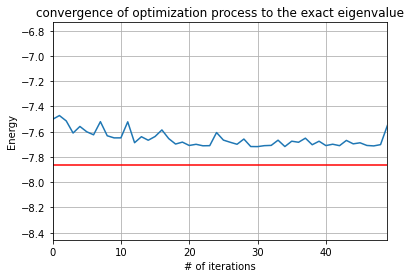

In [217]:
compare_exact_and_approximated_eigenvalue(LiH_molecule_4_qubits, LiH_approximated_eigenvalue)

## H2 Molecule 4 qubits

In [218]:
H2_molecule_Hamiltonian_4_qubits =  -0.8105479805373279 * (I^I^I^I) \
                                    + 0.1721839326191554 * (I^I^I^Z) \
                                    - 0.22575349222402372 * (I^I^Z^I) \
                                    + 0.17218393261915543 * (I^Z^I^I) \
                                    - 0.2257534922240237 * (Z^I^I^I) \
                                    + 0.12091263261776627 * (I^I^Z^Z) \
                                    + 0.16892753870087907 * (I^Z^I^Z) \
                                    + 0.045232799946057826 * (Y^Y^Y^Y) \
                                    + 0.045232799946057826 * (X^X^Y^Y) \
                                    + 0.045232799946057826 * (Y^Y^X^X) \
                                    + 0.045232799946057826 * (X^X^X^X) \
                                    + 0.1661454325638241 * (Z^I^I^Z) \
                                    + 0.1661454325638241 * (I^Z^Z^I) \
                                    + 0.17464343068300453 * (Z^I^Z^I) \
                                    + 0.12091263261776627 * (Z^Z^I^I)

#### Linear Entangelment

In [219]:
%%time
H2_approximated_eigenvalue = get_approximated_eigenvalue_of_hamiltonian(H2_molecule_Hamiltonian_4_qubits, "linear")

3it [00:00, 20.30it/s]

{'0101': 74, '1110': 354, '0111': 21, '1000': 77, '0011': 118, '1001': 9, '1010': 51, '0010': 32, '1011': 87, '1100': 19, '1101': 34, '1111': 25, '0000': 19, '0110': 27, '0100': 39, '0001': 38}
1.0
{'0110': 31, '1110': 330, '0001': 31, '1010': 45, '0010': 43, '0011': 148, '0111': 16, '1000': 83, '0101': 61, '1011': 83, '1111': 26, '1100': 21, '0100': 50, '0000': 21, '1101': 27, '1001': 8}
1.0
{'1000': 81, '1101': 21, '0101': 68, '1110': 339, '0011': 155, '0110': 43, '1111': 24, '0010': 56, '1011': 74, '1010': 33, '0111': 8, '0001': 27, '1100': 18, '0100': 55, '0000': 11, '1001': 11}
1.0
{'1000': 75, '0011': 122, '1001': 9, '1010': 50, '0101': 73, '1110': 346, '0110': 50, '1111': 26, '0100': 47, '1011': 86, '0010': 38, '1100': 17, '0001': 33, '0000': 22, '1101': 21, '0111': 9}
1.0


9it [00:00, 20.63it/s]

{'1000': 68, '0101': 67, '1110': 347, '0010': 32, '1011': 76, '1100': 18, '0011': 151, '0110': 33, '1010': 57, '0001': 26, '1001': 13, '1111': 32, '0100': 50, '0111': 11, '0000': 13, '1101': 30}
1.0
{'1110': 367, '0101': 71, '0011': 150, '1100': 19, '0100': 52, '1011': 82, '0010': 41, '0000': 20, '0001': 33, '0110': 29, '1010': 31, '1101': 29, '1000': 58, '0111': 15, '1001': 3, '1111': 24}
1.0
{'0010': 38, '1011': 100, '1110': 327, '0101': 80, '0011': 157, '0100': 53, '0000': 18, '1000': 57, '0110': 29, '0001': 37, '1111': 19, '0111': 16, '1101': 17, '1010': 49, '1100': 19, '1001': 8}
1.0
{'0101': 70, '1110': 332, '0110': 27, '1010': 51, '0001': 28, '1001': 11, '0111': 11, '1101': 34, '0100': 58, '1000': 69, '0010': 45, '0011': 132, '1011': 87, '0000': 22, '1100': 18, '1111': 29}
1.0
{'1000': 155, '1110': 113, '0101': 38, '0011': 28, '1100': 97, '0100': 84, '0110': 46, '1111': 163, '0010': 196, '1010': 13, '0000': 20, '0111': 8, '1101': 25, '1011': 25, '1001': 7, '0001': 6}
1.0
{'0101'

15it [00:00, 21.94it/s]


{'1000': 56, '1001': 11, '1010': 53, '1100': 171, '0110': 224, '1101': 40, '0111': 21, '1011': 42, '1110': 52, '0011': 100, '0100': 105, '1111': 49, '0000': 43, '0101': 27, '0010': 22, '0001': 8}
1.0
{'0101': 88, '1110': 347, '0111': 17, '1000': 63, '0110': 31, '0001': 37, '0011': 139, '1011': 105, '0100': 46, '1111': 24, '0000': 17, '1101': 23, '1010': 37, '0010': 36, '1100': 10, '1001': 4}
1.0
{'0000': 21, '1000': 78, '0101': 60, '1110': 339, '0110': 23, '1011': 80, '0001': 41, '0011': 145, '1001': 11, '1100': 22, '1010': 51, '0111': 14, '0100': 50, '1101': 32, '0010': 34, '1111': 23}
1.0
{'1110': 373, '0101': 69, '0001': 31, '1010': 46, '1000': 59, '0011': 147, '1011': 73, '0110': 34, '1101': 36, '0010': 28, '0100': 45, '1111': 34, '0111': 8, '1100': 23, '0000': 12, '1001': 6}
1.0
{'1110': 345, '0001': 34, '1010': 50, '0000': 23, '1000': 72, '0110': 31, '1011': 96, '0010': 38, '0101': 65, '0100': 40, '1100': 19, '0011': 151, '1111': 27, '0111': 15, '1101': 14, '1001': 4}
1.0
[-7.462

0it [00:00, ?it/s]

{'1100': 53, '0011': 198, '0001': 47, '1010': 3, '0101': 142, '1110': 262, '0000': 8, '1011': 58, '0100': 28, '1001': 6, '0110': 89, '1111': 16, '0111': 41, '1101': 36, '1000': 22, '0010': 15}
1.0


3it [00:00, 22.05it/s]

{'0101': 121, '1110': 279, '1101': 45, '0011': 191, '0111': 44, '1011': 45, '1111': 23, '1000': 28, '0001': 31, '0110': 87, '1100': 53, '0000': 9, '0010': 22, '0100': 33, '1010': 9, '1001': 4}
1.0
{'0101': 134, '1110': 248, '1100': 52, '0011': 198, '1111': 29, '0110': 84, '1011': 64, '1101': 39, '1000': 20, '0111': 46, '0001': 41, '1010': 10, '0100': 26, '0010': 22, '1001': 4, '0000': 7}
1.0
{'1000': 24, '0010': 26, '1100': 55, '0011': 202, '0110': 93, '0101': 151, '1110': 234, '0111': 61, '1011': 48, '1111': 16, '1101': 40, '0001': 38, '1010': 3, '0100': 22, '0000': 5, '1001': 6}
1.0


9it [00:00, 21.04it/s]

{'0111': 45, '1100': 50, '0011': 192, '0110': 94, '1110': 248, '0101': 135, '1011': 61, '0010': 28, '1101': 51, '0000': 5, '0001': 37, '0100': 32, '1111': 22, '1000': 13, '1010': 9, '1001': 2}
1.0
{'1011': 50, '1110': 278, '0101': 136, '0001': 26, '1101': 50, '0110': 99, '1111': 21, '0011': 181, '1100': 54, '1000': 20, '0111': 39, '0000': 12, '0010': 32, '0100': 19, '1001': 2, '1010': 5}
1.0
{'0111': 50, '1110': 262, '1100': 55, '0011': 184, '1000': 21, '0110': 80, '0001': 39, '1101': 48, '1011': 47, '0101': 133, '1111': 26, '0100': 34, '0000': 3, '0010': 27, '1001': 10, '1010': 5}
1.0
{'1110': 265, '0101': 129, '1100': 71, '0011': 164, '0100': 28, '1011': 45, '0110': 106, '0001': 36, '1111': 26, '0111': 39, '1101': 37, '0010': 31, '1000': 19, '1001': 11, '0000': 4, '1010': 13}
1.0
{'0011': 65, '1100': 67, '0110': 32, '1111': 209, '0101': 121, '1110': 85, '0100': 101, '0010': 176, '1001': 14, '0000': 30, '1000': 37, '1101': 19, '0111': 17, '1011': 26, '1010': 12, '0001': 13}
1.0


15it [00:00, 21.93it/s]


{'0011': 183, '1101': 159, '1010': 95, '1001': 33, '0101': 21, '0111': 89, '0110': 135, '0000': 64, '0100': 32, '1011': 30, '1110': 71, '0010': 59, '1100': 18, '0001': 12, '1000': 18, '1111': 5}
1.0
{'1000': 62, '0000': 52, '0011': 151, '1100': 100, '1011': 71, '0111': 15, '0001': 97, '0110': 202, '1111': 99, '1010': 52, '1101': 23, '0100': 22, '0010': 8, '0101': 36, '1110': 23, '1001': 11}
1.0
{'0011': 185, '0101': 154, '1110': 251, '0110': 102, '1111': 16, '0001': 41, '1011': 45, '0100': 28, '0010': 22, '1000': 33, '1100': 53, '1010': 6, '1101': 47, '0111': 34, '1001': 5, '0000': 2}
1.0
{'0111': 39, '0011': 200, '1100': 52, '0110': 80, '1110': 261, '0101': 134, '0100': 33, '1000': 23, '0001': 38, '0000': 5, '1011': 53, '0010': 31, '1010': 11, '1101': 43, '1111': 19, '1001': 2}
1.0
{'0100': 29, '1101': 43, '1011': 51, '0010': 18, '1100': 62, '0011': 223, '1110': 270, '0101': 104, '1010': 9, '0111': 50, '1000': 13, '0001': 42, '0110': 88, '1111': 11, '0000': 8, '1001': 3}
1.0
{'0000': 

3it [00:00, 19.21it/s]

{'0101': 231, '1110': 168, '1001': 52, '1101': 69, '0011': 141, '0000': 3, '1000': 97, '1111': 83, '0001': 27, '1100': 32, '0010': 12, '0100': 8, '0111': 57, '0110': 22, '1010': 18, '1011': 4}
1.0
{'0111': 65, '0110': 19, '1111': 95, '1101': 67, '0011': 135, '0101': 252, '1000': 86, '1011': 6, '1110': 162, '1100': 16, '1001': 50, '0100': 12, '0001': 34, '1010': 17, '0000': 4, '0010': 4}
1.0
{'1101': 66, '0101': 234, '1110': 159, '0111': 77, '1001': 54, '1010': 10, '1000': 83, '1111': 97, '0011': 138, '1100': 26, '0110': 18, '0001': 32, '0000': 5, '0100': 21, '0010': 1, '1011': 3}
1.0
{'0111': 49, '0110': 21, '1111': 99, '1010': 25, '1110': 161, '0101': 254, '1000': 107, '1101': 58, '1001': 44, '0011': 120, '0100': 12, '1100': 29, '0001': 27, '0010': 9, '0000': 4, '1011': 5}
1.0


8it [00:00, 21.23it/s]

{'0101': 247, '1110': 216, '1011': 6, '1101': 67, '1010': 18, '0001': 23, '1000': 88, '0011': 97, '1001': 48, '0100': 12, '1111': 88, '0111': 58, '1100': 19, '0110': 21, '0010': 13, '0000': 3}
1.0
{'1101': 79, '0101': 239, '1110': 165, '1111': 105, '1001': 46, '1000': 88, '0011': 134, '0111': 56, '1100': 22, '1010': 14, '0110': 19, '0100': 15, '0001': 28, '0010': 7, '1011': 7}
1.0
{'1110': 181, '0101': 204, '0011': 132, '1001': 46, '0001': 35, '1101': 67, '0111': 56, '1000': 101, '1111': 102, '0110': 16, '1011': 11, '1100': 24, '0100': 13, '0010': 17, '1010': 16, '0000': 3}
1.0
{'1101': 58, '1000': 107, '0111': 51, '0101': 232, '1110': 176, '0011': 132, '1111': 87, '1011': 4, '1010': 26, '1001': 54, '0001': 35, '0110': 22, '0010': 8, '1100': 18, '0100': 13, '0000': 1}
1.0
{'1100': 137, '0011': 40, '0001': 15, '0100': 163, '1000': 47, '0101': 114, '1110': 69, '1111': 109, '0110': 50, '1011': 37, '0111': 27, '1001': 64, '1101': 56, '0010': 77, '0000': 18, '1010': 1}
1.0


15it [00:00, 22.21it/s]

{'0011': 154, '1101': 167, '1110': 65, '0010': 16, '1010': 47, '1001': 149, '0000': 66, '1111': 19, '0110': 80, '1011': 83, '1000': 50, '0101': 38, '0111': 48, '1100': 25, '0001': 11, '0100': 6}
1.0
{'0001': 114, '1111': 86, '0110': 122, '0100': 31, '1000': 119, '1100': 189, '0011': 65, '1011': 61, '1001': 99, '0000': 28, '0010': 19, '1010': 26, '0101': 22, '0111': 10, '1110': 26, '1101': 7}
1.0
{'0011': 125, '1100': 21, '1110': 191, '0101': 238, '1101': 78, '0000': 2, '1000': 83, '0110': 19, '0001': 31, '1111': 99, '1001': 47, '0111': 53, '0100': 10, '1011': 7, '1010': 13, '0010': 7}
1.0
{'1001': 47, '1000': 87, '1111': 80, '0101': 251, '1110': 192, '0011': 113, '1100': 22, '0111': 60, '1011': 7, '1101': 69, '0010': 11, '1010': 16, '0000': 2, '0001': 38, '0110': 17, '0100': 12}
1.0
{'1101': 75, '1110': 180, '0101': 240, '0111': 69, '0110': 16, '1111': 77, '0001': 25, '1001': 45, '1000': 98, '1100': 24, '0011': 137, '1010': 14, '0100': 8, '1011': 7, '0000': 3, '0010': 6}
1.0
{'1110': 1

[-7.462882744167433, -7.413558354501493, -7.527616763482559, -7.463358308515701, -7.542165697542103, -7.54564906944211, -7.596790130772266, -7.583876423789713, -7.600896587943167, -7.515746344547128, -7.632507556645632, -7.598044667802598, -7.639147693909248, -7.560988771541857, -7.675442454837678, -7.622079965659733, -7.550549216902378, -7.652698557917512, -7.618042657596327, -7.641077813310959, -7.722139285879435, -7.70630044577901, -7.7393074632273295, -7.7156527883399875, -7.734413675713732, -7.703054437903954, -7.681103354862836, -7.67413219031604, -7.684315159085678, -7.730093496472124, -7.714549151939473, -7.714866668154968, -7.727871430773022, -7.665815111325502, -7.697743728326701, -7.673189424995715, -7.712618622613775, -7.670572217358177, -7.707149032377504, -7.6673484725623045, -7.733872406458095, -7.731045973771998, -7.714479583644238, -7.662864570702938, -7.730607644653333, -7.705472460989764, -7.7062372506252235, -7.71117873493011, -7.703563044443457, -7.708853300424329,

3it [00:00, 18.35it/s]

{'0100': 35, '1101': 39, '0101': 264, '0001': 51, '0011': 267, '1111': 151, '1011': 15, '0111': 48, '1110': 97, '0010': 17, '1000': 7, '1100': 14, '1001': 16, '0000': 1, '1010': 2}
1.0
{'0001': 42, '1111': 171, '0011': 259, '1101': 34, '0100': 37, '1110': 93, '0101': 275, '1011': 21, '1100': 5, '0111': 53, '1001': 18, '0010': 6, '1000': 5, '1010': 5}
1.0
{'1101': 36, '0100': 27, '1110': 101, '0101': 254, '0011': 265, '1111': 147, '1001': 30, '0111': 46, '1100': 16, '1011': 25, '0010': 19, '1010': 4, '0110': 3, '0001': 46, '1000': 5}
1.0
{'0001': 69, '0101': 238, '1110': 86, '1100': 12, '0011': 260, '1000': 10, '1011': 25, '1111': 175, '1001': 19, '0111': 57, '0010': 14, '1010': 5, '0100': 23, '1101': 30, '0110': 1}
1.0


8it [00:00, 21.62it/s]

{'1110': 71, '0101': 261, '1100': 10, '0011': 276, '0111': 41, '1111': 183, '0100': 26, '0001': 50, '0010': 14, '1001': 24, '1000': 9, '1101': 34, '0000': 1, '1011': 17, '1010': 4, '0110': 3}
1.0
{'1100': 9, '0011': 254, '0001': 52, '1110': 77, '0101': 258, '1111': 181, '0111': 64, '0010': 18, '1101': 36, '1001': 20, '0100': 24, '1000': 9, '1011': 17, '1010': 2, '0110': 1, '0000': 2}
1.0
{'1110': 100, '0101': 260, '1111': 158, '0001': 46, '1001': 24, '1101': 30, '1100': 9, '0011': 275, '0111': 49, '0100': 26, '1011': 24, '0010': 13, '1000': 8, '1010': 1, '0110': 1}
1.0
{'0101': 215, '1110': 72, '1001': 20, '0011': 279, '1111': 192, '1000': 6, '0100': 30, '0111': 51, '1101': 43, '0001': 64, '1100': 16, '0010': 12, '1011': 20, '0110': 3, '1010': 1}
1.0
{'1100': 179, '0011': 105, '1110': 80, '0101': 89, '1101': 34, '0100': 199, '0110': 56, '1001': 12, '0010': 152, '1011': 22, '0000': 47, '1010': 22, '1000': 2, '0001': 11, '1111': 1, '0111': 13}
1.0


14it [00:00, 23.46it/s]

{'1101': 161, '0111': 133, '1011': 189, '1010': 38, '1001': 100, '1100': 11, '0011': 149, '0110': 35, '0101': 91, '1000': 36, '1111': 49, '0000': 3, '0001': 11, '0010': 4, '0100': 5, '1110': 9}
1.0
{'0111': 38, '1000': 223, '0000': 33, '1111': 27, '1011': 29, '0011': 39, '1100': 119, '0001': 60, '0010': 10, '0100': 36, '1001': 56, '1110': 76, '0110': 235, '1101': 18, '1010': 24, '0101': 1}
1.0
{'1100': 11, '0011': 294, '1111': 155, '0101': 258, '0111': 55, '0100': 34, '1001': 11, '0001': 56, '1011': 21, '1110': 67, '1101': 35, '0110': 5, '0010': 14, '1000': 6, '1010': 2}
1.0
{'1110': 83, '0101': 269, '0011': 255, '1111': 183, '0100': 19, '1001': 18, '1011': 24, '0111': 45, '0001': 55, '1100': 14, '1101': 35, '1000': 5, '0010': 14, '0110': 3, '1010': 1, '0000': 1}
1.0
{'1111': 167, '0011': 282, '0111': 61, '0101': 258, '1110': 87, '1101': 29, '0001': 44, '1011': 24, '1100': 9, '0010': 9, '1001': 29, '0100': 19, '1010': 2, '1000': 3, '0110': 1}
1.0
{'1111': 150, '0111': 59, '0011': 271, 

15it [00:00, 21.76it/s]


[-7.462882744167433, -7.413558354501493, -7.527616763482559, -7.463358308515701, -7.542165697542103, -7.54564906944211, -7.596790130772266, -7.583876423789713, -7.600896587943167, -7.515746344547128, -7.632507556645632, -7.598044667802598, -7.639147693909248, -7.560988771541857, -7.675442454837678, -7.622079965659733, -7.550549216902378, -7.652698557917512, -7.618042657596327, -7.641077813310959, -7.722139285879435, -7.70630044577901, -7.7393074632273295, -7.7156527883399875, -7.734413675713732, -7.703054437903954, -7.681103354862836, -7.67413219031604, -7.684315159085678, -7.730093496472124, -7.714549151939473, -7.714866668154968, -7.727871430773022, -7.665815111325502, -7.697743728326701, -7.673189424995715, -7.712618622613775, -7.670572217358177, -7.707149032377504, -7.6673484725623045, -7.733872406458095, -7.731045973771998, -7.714479583644238, -7.662864570702938, -7.730607644653333, -7.705472460989764, -7.7062372506252235, -7.71117873493011, -7.703563044443457, -7.708853300424329,

2it [00:00, 17.04it/s]

{'0101': 408, '1110': 64, '0001': 167, '0111': 35, '1011': 60, '0110': 14, '1111': 67, '0100': 41, '0011': 99, '1101': 9, '1001': 35, '0000': 6, '1010': 10, '0010': 5, '1100': 1, '1000': 3}
1.0
{'0101': 415, '1011': 49, '1111': 78, '0011': 95, '1101': 18, '0100': 36, '0111': 39, '0001': 131, '0000': 11, '1110': 83, '1001': 49, '1000': 2, '1010': 8, '0110': 5, '0010': 5}
1.0
{'0101': 391, '1011': 51, '0001': 154, '0011': 111, '0110': 10, '1111': 79, '0111': 39, '1101': 10, '0100': 32, '1110': 79, '1001': 36, '0000': 12, '1010': 9, '1000': 4, '0010': 7}
1.0
{'0101': 414, '0111': 48, '0000': 6, '1101': 13, '0110': 14, '1111': 84, '0001': 167, '0010': 8, '1011': 49, '1110': 65, '0011': 85, '1001': 27, '0100': 31, '1010': 9, '1000': 4}
1.0


8it [00:00, 20.57it/s]

{'1110': 74, '0101': 393, '1111': 67, '0001': 184, '0011': 107, '1011': 53, '0010': 7, '1000': 8, '0100': 31, '1001': 38, '0110': 10, '0111': 24, '0000': 8, '1101': 9, '1010': 11}
1.0
{'1001': 37, '0001': 160, '1111': 84, '1110': 61, '0101': 398, '0100': 36, '1011': 53, '0011': 101, '0111': 38, '1000': 9, '1101': 17, '0110': 13, '1010': 8, '0000': 6, '0010': 3}
1.0
{'1110': 73, '0101': 408, '0011': 115, '1111': 82, '0110': 11, '1001': 39, '0001': 132, '1101': 15, '1011': 53, '0000': 15, '0100': 28, '1010': 12, '0111': 30, '0010': 7, '1000': 4}
1.0
{'0111': 37, '0011': 106, '1110': 77, '0101': 390, '1010': 10, '0001': 147, '1011': 60, '0100': 33, '0000': 10, '1001': 43, '1111': 62, '1000': 10, '0110': 17, '1101': 16, '0010': 5, '1100': 1}
1.0
{'0100': 118, '1010': 57, '1110': 54, '0101': 132, '1011': 5, '0010': 174, '1100': 105, '0110': 192, '0011': 103, '1000': 8, '1001': 33, '0111': 19, '1111': 14, '1101': 3, '0000': 5, '0001': 2}
1.0
{'0100': 25, '1101': 282, '0101': 255, '0111': 71,

14it [00:00, 22.88it/s]

{'0001': 59, '1001': 36, '1100': 127, '1111': 49, '0110': 313, '1000': 98, '1101': 41, '0101': 43, '0111': 52, '0011': 28, '1110': 115, '1010': 32, '0010': 7, '0000': 11, '0100': 13}
1.0
{'1001': 35, '0001': 147, '0011': 102, '0000': 9, '1110': 48, '0101': 416, '1111': 81, '0100': 29, '1101': 20, '0111': 44, '1011': 52, '1010': 11, '0010': 10, '1000': 7, '0110': 12, '1100': 1}
1.0
{'0111': 41, '0101': 415, '1110': 76, '1001': 36, '1111': 66, '0100': 27, '0000': 9, '1011': 45, '0011': 111, '0001': 159, '1000': 4, '0110': 8, '1010': 6, '0010': 5, '1101': 16}
1.0
{'0111': 37, '1010': 12, '0011': 111, '1111': 87, '0110': 13, '1101': 14, '1011': 57, '0101': 381, '0001': 153, '0100': 26, '1000': 7, '1001': 37, '1110': 68, '0010': 16, '0000': 5}
1.0


15it [00:00, 21.97it/s]


{'1110': 62, '0101': 386, '0011': 107, '1101': 14, '0111': 30, '0010': 7, '1011': 56, '1111': 78, '0001': 170, '0000': 16, '0100': 35, '0110': 16, '1001': 37, '1010': 9, '1000': 1}
1.0
[-7.462882744167433, -7.413558354501493, -7.527616763482559, -7.463358308515701, -7.542165697542103, -7.54564906944211, -7.596790130772266, -7.583876423789713, -7.600896587943167, -7.515746344547128, -7.632507556645632, -7.598044667802598, -7.639147693909248, -7.560988771541857, -7.675442454837678, -7.622079965659733, -7.550549216902378, -7.652698557917512, -7.618042657596327, -7.641077813310959, -7.722139285879435, -7.70630044577901, -7.7393074632273295, -7.7156527883399875, -7.734413675713732, -7.703054437903954, -7.681103354862836, -7.67413219031604, -7.684315159085678, -7.730093496472124, -7.714549151939473, -7.714866668154968, -7.727871430773022, -7.665815111325502, -7.697743728326701, -7.673189424995715, -7.712618622613775, -7.670572217358177, -7.707149032377504, -7.6673484725623045, -7.73387240645

3it [00:00, 26.32it/s]

{'0101': 393, '1010': 63, '0001': 130, '0011': 91, '0000': 50, '0111': 50, '1101': 50, '0100': 58, '1111': 31, '1100': 11, '1001': 30, '0010': 36, '1011': 9, '1000': 7, '0110': 9, '1110': 6}
1.0
{'0101': 396, '1010': 65, '0011': 94, '1100': 20, '0110': 12, '0100': 49, '1000': 26, '0111': 51, '0010': 34, '0001': 110, '1101': 48, '0000': 44, '1111': 36, '1001': 32, '1011': 5, '1110': 2}
1.0
{'0000': 55, '1010': 69, '0001': 117, '0100': 41, '1101': 42, '0101': 399, '0011': 102, '0010': 21, '1001': 47, '0111': 53, '1111': 32, '0110': 12, '1100': 11, '1000': 17, '1110': 2, '1011': 4}
1.0
{'1001': 34, '0001': 142, '1010': 74, '1111': 36, '0101': 373, '0011': 100, '1000': 13, '1101': 44, '0100': 47, '0111': 52, '0000': 36, '1100': 18, '0010': 31, '1011': 15, '0110': 8, '1110': 1}
1.0
{'0011': 89, '1110': 2, '0101': 391, '1111': 23, '1010': 79, '0001': 122, '0000': 48, '0010': 38, '1100': 12, '1011': 9, '0100': 53, '1001': 32, '0110': 6, '0111': 50, '1000': 21, '1101': 49}
1.0


6it [00:00, 23.69it/s]

{'0010': 27, '0001': 133, '1010': 58, '0101': 426, '0011': 71, '0111': 47, '0100': 50, '1101': 38, '1000': 16, '0110': 10, '0000': 50, '1001': 33, '1011': 15, '1111': 25, '1110': 4, '1100': 21}
1.0


9it [00:00, 20.26it/s]

{'0101': 412, '1100': 13, '0011': 92, '0001': 134, '1001': 40, '1010': 54, '1101': 40, '0010': 36, '0000': 38, '0100': 39, '0111': 46, '1000': 22, '1111': 37, '0110': 10, '1011': 8, '1110': 3}
1.0
{'0111': 44, '0011': 93, '0001': 124, '0101': 398, '0010': 33, '1101': 45, '0100': 54, '1111': 27, '1010': 72, '0000': 52, '1001': 33, '1000': 14, '0110': 19, '1100': 10, '1011': 6}
1.0
{'0100': 215, '0101': 105, '0110': 194, '0010': 269, '1100': 59, '1001': 63, '1000': 16, '0000': 8, '1010': 25, '0111': 13, '0011': 29, '1101': 14, '0001': 5, '1110': 2, '1011': 4, '1111': 3}
1.0
{'1101': 260, '0011': 44, '1100': 87, '1001': 78, '0111': 31, '0101': 265, '0010': 35, '1000': 3, '1111': 12, '0110': 43, '1011': 96, '0001': 29, '0100': 34, '1110': 7}
1.0
{'0001': 49, '1001': 76, '1100': 174, '1000': 108, '0000': 7, '0110': 223, '0010': 66, '0111': 34, '1110': 152, '0011': 4, '1010': 11, '0101': 30, '1101': 33, '0100': 43, '1111': 13, '1011': 1}
1.0


15it [00:00, 22.51it/s]

{'0101': 406, '0111': 57, '0100': 52, '1101': 39, '1000': 31, '1010': 52, '0001': 127, '0011': 85, '1100': 8, '1111': 29, '0010': 41, '0110': 12, '0000': 41, '1001': 38, '1110': 1, '1011': 5}
1.0
{'0000': 35, '1100': 15, '0011': 82, '1001': 32, '0001': 135, '0101': 428, '1011': 8, '0100': 50, '1101': 49, '1000': 19, '0110': 15, '1010': 51, '0111': 40, '1111': 28, '0010': 35, '1110': 2}
1.0
{'1101': 39, '0100': 60, '0101': 403, '0001': 121, '0010': 33, '1000': 26, '0111': 56, '0011': 88, '1111': 26, '1011': 13, '1001': 38, '1010': 49, '0110': 11, '0000': 43, '1110': 3, '1100': 15}
1.0
{'0001': 132, '1001': 33, '1010': 63, '0111': 37, '0101': 420, '0010': 35, '0000': 48, '1101': 43, '1111': 24, '0100': 53, '0110': 12, '0011': 81, '1000': 20, '1100': 9, '1110': 5, '1011': 9}
1.0


15it [00:00, 22.32it/s]


[-7.462882744167433, -7.413558354501493, -7.527616763482559, -7.463358308515701, -7.542165697542103, -7.54564906944211, -7.596790130772266, -7.583876423789713, -7.600896587943167, -7.515746344547128, -7.632507556645632, -7.598044667802598, -7.639147693909248, -7.560988771541857, -7.675442454837678, -7.622079965659733, -7.550549216902378, -7.652698557917512, -7.618042657596327, -7.641077813310959, -7.722139285879435, -7.70630044577901, -7.7393074632273295, -7.7156527883399875, -7.734413675713732, -7.703054437903954, -7.681103354862836, -7.67413219031604, -7.684315159085678, -7.730093496472124, -7.714549151939473, -7.714866668154968, -7.727871430773022, -7.665815111325502, -7.697743728326701, -7.673189424995715, -7.712618622613775, -7.670572217358177, -7.707149032377504, -7.6673484725623045, -7.733872406458095, -7.731045973771998, -7.714479583644238, -7.662864570702938, -7.730607644653333, -7.705472460989764, -7.7062372506252235, -7.71117873493011, -7.703563044443457, -7.708853300424329,

0it [00:00, ?it/s]

{'1101': 104, '0110': 22, '1111': 21, '0101': 391, '1010': 25, '1001': 55, '0001': 141, '0011': 82, '0111': 60, '0100': 42, '0010': 36, '0000': 17, '1110': 26, '1000': 2}
1.0


3it [00:00, 25.61it/s]

{'0101': 376, '1101': 86, '0100': 30, '0110': 22, '1111': 24, '0001': 162, '1001': 60, '0010': 46, '0011': 89, '1010': 25, '0000': 21, '0111': 63, '1110': 19, '1000': 1}
1.0
{'0110': 12, '1111': 22, '1110': 23, '0101': 386, '1001': 61, '0001': 151, '0011': 103, '1101': 84, '0000': 20, '0100': 42, '0111': 57, '0010': 38, '1010': 18, '1000': 7}
1.0
{'1110': 22, '0101': 392, '0000': 22, '1001': 54, '0001': 115, '0011': 105, '0111': 69, '1101': 87, '1010': 21, '0100': 36, '1111': 35, '0010': 45, '0110': 19, '1000': 2}
1.0
{'0111': 75, '1001': 68, '0001': 152, '1110': 22, '0101': 365, '0011': 89, '0100': 36, '0010': 39, '1101': 84, '0110': 23, '0000': 22, '1011': 1, '1010': 18, '1000': 3, '1111': 27}
1.0


6it [00:00, 20.47it/s]

{'1110': 27, '0101': 407, '0000': 26, '0001': 144, '0110': 13, '1111': 21, '1101': 90, '0111': 57, '0010': 36, '0011': 78, '0100': 38, '1001': 59, '1000': 3, '1010': 25}
1.0
{'0011': 76, '1110': 40, '0101': 389, '1001': 49, '0001': 136, '1000': 5, '0100': 44, '0111': 68, '1101': 106, '0010': 39, '0000': 13, '1111': 14, '1010': 19, '0110': 25, '1011': 1}
1.0
{'0101': 406, '1110': 30, '1001': 58, '0001': 148, '1101': 90, '0010': 30, '1011': 1, '0110': 15, '0100': 41, '0011': 83, '0000': 18, '0111': 67, '1010': 12, '1111': 22, '1000': 3}
1.0


9it [00:00, 21.36it/s]

{'1001': 38, '0101': 191, '0010': 186, '1100': 73, '0011': 95, '0100': 149, '1111': 31, '0110': 111, '1101': 31, '0001': 5, '1000': 7, '1110': 1, '0111': 60, '1010': 16, '0000': 12, '1011': 18}
1.0
{'1001': 135, '1010': 24, '0101': 260, '1011': 105, '0010': 8, '1101': 237, '1100': 32, '0110': 64, '0011': 24, '0001': 71, '0111': 22, '1111': 7, '0000': 3, '0100': 24, '1000': 3, '1110': 5}
1.0
{'1111': 25, '0110': 156, '0100': 45, '1101': 27, '1110': 95, '1100': 104, '0111': 139, '1000': 98, '0010': 56, '0011': 45, '1001': 162, '0001': 20, '0101': 40, '1010': 10, '1011': 2}
1.0


15it [00:00, 19.63it/s]

{'0010': 28, '1111': 28, '0001': 142, '1001': 61, '0101': 383, '1101': 94, '0011': 99, '0000': 21, '1010': 19, '1000': 4, '0111': 64, '0100': 36, '0110': 15, '1110': 30}
1.0
{'0101': 377, '0100': 49, '1101': 88, '1001': 62, '0001': 129, '0111': 65, '0011': 90, '0110': 16, '1010': 18, '0000': 18, '1110': 37, '0010': 41, '1111': 33, '1000': 1}
1.0
{'1110': 27, '0101': 411, '1001': 66, '0001': 131, '1010': 27, '1101': 89, '0111': 67, '0010': 23, '0000': 15, '0011': 85, '0110': 15, '0100': 42, '1111': 24, '1000': 2}
1.0
{'1010': 26, '1001': 58, '0001': 130, '0111': 65, '0101': 392, '0100': 38, '1101': 90, '0011': 86, '0000': 24, '0110': 17, '0010': 45, '1110': 23, '1111': 26, '1000': 4}
1.0


15it [00:00, 19.73it/s]


[-7.462882744167433, -7.413558354501493, -7.527616763482559, -7.463358308515701, -7.542165697542103, -7.54564906944211, -7.596790130772266, -7.583876423789713, -7.600896587943167, -7.515746344547128, -7.632507556645632, -7.598044667802598, -7.639147693909248, -7.560988771541857, -7.675442454837678, -7.622079965659733, -7.550549216902378, -7.652698557917512, -7.618042657596327, -7.641077813310959, -7.722139285879435, -7.70630044577901, -7.7393074632273295, -7.7156527883399875, -7.734413675713732, -7.703054437903954, -7.681103354862836, -7.67413219031604, -7.684315159085678, -7.730093496472124, -7.714549151939473, -7.714866668154968, -7.727871430773022, -7.665815111325502, -7.697743728326701, -7.673189424995715, -7.712618622613775, -7.670572217358177, -7.707149032377504, -7.6673484725623045, -7.733872406458095, -7.731045973771998, -7.714479583644238, -7.662864570702938, -7.730607644653333, -7.705472460989764, -7.7062372506252235, -7.71117873493011, -7.703563044443457, -7.708853300424329,

0it [00:00, ?it/s]

{'1011': 24, '0010': 47, '0101': 332, '0001': 210, '1001': 99, '0011': 113, '1101': 34, '0100': 75, '1111': 25, '1000': 20, '1010': 18, '0111': 4, '1100': 5, '0110': 8, '1110': 8, '0000': 2}
1.0
{'1111': 37, '0001': 180, '0011': 130, '1000': 19, '0101': 357, '1101': 39, '0100': 81, '0010': 41, '1001': 77, '1011': 20, '1010': 21, '0111': 5, '1110': 6, '0000': 4, '0110': 4, '1100': 3}
1.0


3it [00:00, 25.97it/s]

{'0001': 185, '1111': 37, '0101': 310, '0100': 88, '1101': 28, '0011': 141, '1011': 19, '0010': 50, '1001': 89, '1100': 6, '1010': 28, '1000': 25, '0000': 7, '1110': 5, '0111': 1, '0110': 5}
1.0
{'0001': 200, '1010': 26, '1001': 80, '0101': 306, '0100': 105, '1111': 48, '0011': 121, '1000': 20, '1101': 41, '1110': 2, '0010': 41, '0110': 7, '1011': 16, '0111': 1, '0000': 5, '1100': 5}
1.0


6it [00:00, 20.96it/s]

{'0011': 115, '1001': 105, '0001': 186, '0101': 338, '0100': 78, '1101': 37, '1111': 40, '1011': 21, '1110': 3, '0010': 38, '0110': 5, '1010': 31, '1000': 18, '0111': 3, '0000': 4, '1100': 2}
1.0
{'0100': 83, '0101': 302, '0010': 34, '1010': 31, '0001': 183, '1001': 95, '0011': 135, '1111': 38, '1101': 46, '1011': 29, '1000': 25, '1100': 5, '0110': 13, '0111': 3, '1110': 1, '0000': 1}
1.0
{'0101': 330, '1010': 28, '1001': 106, '0001': 185, '0100': 84, '1000': 20, '0011': 125, '0010': 36, '1101': 37, '1011': 15, '1111': 39, '0000': 3, '0110': 8, '1110': 3, '1100': 3, '0111': 2}
1.0


9it [00:00, 21.10it/s]

{'1010': 25, '1001': 86, '0001': 170, '1111': 44, '0011': 136, '1101': 54, '0101': 315, '1000': 23, '0100': 91, '1011': 25, '0010': 37, '0000': 8, '1100': 2, '0111': 2, '0110': 5, '1110': 1}
1.0
{'0101': 98, '1001': 117, '0001': 12, '0111': 58, '1101': 32, '0100': 116, '0110': 122, '0011': 143, '0010': 212, '1010': 38, '1100': 44, '1011': 16, '1000': 4, '1110': 1, '1111': 2, '0000': 9}
1.0


12it [00:00, 22.06it/s]

{'1010': 15, '0001': 104, '1001': 87, '0101': 247, '1101': 189, '0100': 23, '0000': 12, '0110': 27, '0111': 63, '0010': 24, '1011': 124, '1111': 18, '1000': 24, '1100': 54, '1110': 7, '0011': 6}
1.0
{'1111': 77, '0110': 223, '1110': 81, '0111': 89, '0001': 57, '1001': 168, '1000': 70, '0100': 21, '1100': 87, '0101': 41, '0011': 46, '1010': 2, '1101': 8, '0010': 46, '1011': 8}
1.0
{'0001': 177, '1001': 114, '1101': 34, '0100': 78, '1110': 3, '0101': 319, '1111': 43, '0011': 131, '1011': 27, '0010': 39, '1000': 22, '0111': 1, '1100': 5, '1010': 23, '0000': 2, '0110': 6}
1.0


15it [00:00, 23.13it/s]

{'1101': 37, '0100': 77, '1100': 7, '0011': 118, '1011': 24, '0101': 326, '1001': 112, '0001': 187, '1111': 41, '1010': 26, '0110': 9, '0010': 35, '1000': 17, '0111': 2, '1110': 2, '0000': 4}
1.0
{'0010': 47, '1001': 111, '0001': 197, '0101': 310, '1101': 46, '0100': 83, '0011': 106, '0110': 5, '1010': 32, '1011': 24, '1000': 19, '1111': 34, '1100': 6, '0000': 3, '1110': 1}
1.0
{'0101': 316, '1001': 72, '0001': 206, '0011': 125, '0100': 93, '1111': 37, '1000': 17, '0010': 47, '1010': 33, '1101': 31, '1011': 24, '1100': 7, '1110': 5, '0111': 1, '0000': 5, '0110': 5}
1.0


15it [00:00, 22.57it/s]


[-7.462882744167433, -7.413558354501493, -7.527616763482559, -7.463358308515701, -7.542165697542103, -7.54564906944211, -7.596790130772266, -7.583876423789713, -7.600896587943167, -7.515746344547128, -7.632507556645632, -7.598044667802598, -7.639147693909248, -7.560988771541857, -7.675442454837678, -7.622079965659733, -7.550549216902378, -7.652698557917512, -7.618042657596327, -7.641077813310959, -7.722139285879435, -7.70630044577901, -7.7393074632273295, -7.7156527883399875, -7.734413675713732, -7.703054437903954, -7.681103354862836, -7.67413219031604, -7.684315159085678, -7.730093496472124, -7.714549151939473, -7.714866668154968, -7.727871430773022, -7.665815111325502, -7.697743728326701, -7.673189424995715, -7.712618622613775, -7.670572217358177, -7.707149032377504, -7.6673484725623045, -7.733872406458095, -7.731045973771998, -7.714479583644238, -7.662864570702938, -7.730607644653333, -7.705472460989764, -7.7062372506252235, -7.71117873493011, -7.703563044443457, -7.708853300424329,

3it [00:00, 25.99it/s]

{'1011': 18, '1010': 38, '0001': 146, '0011': 55, '0101': 422, '1101': 94, '0100': 42, '1111': 33, '1000': 20, '0111': 6, '1001': 61, '0110': 16, '0010': 12, '0000': 27, '1110': 34}
1.0
{'0011': 43, '1010': 27, '0001': 144, '1001': 52, '1110': 32, '0101': 489, '1101': 87, '0010': 14, '1011': 18, '0100': 38, '1111': 33, '0110': 14, '0000': 20, '1000': 9, '0111': 4}
1.0
{'1001': 48, '0001': 158, '0101': 439, '0100': 43, '1101': 114, '1000': 8, '0000': 30, '0011': 45, '0010': 18, '1011': 25, '1010': 38, '1111': 27, '1110': 19, '0110': 7, '0111': 5}
1.0
{'1001': 65, '1010': 27, '0001': 143, '0101': 464, '0100': 39, '1101': 105, '1111': 28, '1000': 9, '0110': 15, '0010': 11, '0011': 41, '1110': 27, '0000': 27, '1011': 18, '0111': 5}
1.0
{'1010': 40, '0001': 160, '1001': 50, '0101': 458, '0100': 28, '1101': 112, '0110': 16, '0011': 48, '1011': 12, '1111': 19, '1110': 28, '0010': 14, '0000': 23, '1000': 10, '0111': 6}
1.0


6it [00:00, 25.97it/s]

{'1110': 23, '0101': 443, '1010': 31, '0001': 152, '0010': 18, '1011': 22, '1101': 88, '0100': 39, '0111': 5, '0011': 47, '1111': 40, '1001': 67, '0110': 10, '1000': 7, '0000': 31, '1100': 1}
1.0
{'0110': 17, '1111': 30, '1110': 22, '0101': 457, '0011': 53, '1010': 29, '0001': 147, '1101': 94, '0010': 13, '0100': 42, '0000': 21, '1011': 15, '1000': 13, '1001': 65, '0111': 6}
1.0


9it [00:00, 21.13it/s]

{'1101': 106, '0100': 45, '0101': 429, '1011': 16, '0010': 16, '0001': 153, '1001': 55, '0011': 58, '1110': 26, '0000': 27, '1000': 14, '0111': 6, '0110': 14, '1010': 33, '1111': 26}
1.0
{'1100': 84, '0011': 53, '1011': 68, '0010': 151, '0101': 101, '0110': 153, '0000': 31, '0100': 116, '1001': 31, '0111': 103, '1101': 33, '1010': 31, '1110': 1, '1111': 52, '0001': 15, '1000': 1}
1.0
{'1101': 268, '0101': 208, '0111': 66, '1000': 5, '0000': 6, '1100': 28, '1001': 189, '0001': 96, '1011': 23, '0110': 74, '0011': 15, '0100': 41, '1110': 2, '1111': 1, '0010': 2}
1.0


12it [00:00, 20.90it/s]

{'1011': 20, '0110': 200, '0111': 190, '0011': 47, '1100': 135, '1001': 91, '1000': 63, '1110': 105, '0000': 16, '0001': 25, '1010': 11, '1101': 38, '0101': 30, '0100': 15, '0010': 25, '1111': 13}
1.0
{'0101': 460, '0011': 44, '0001': 161, '1010': 25, '1001': 53, '0000': 28, '0100': 41, '1011': 17, '1101': 104, '0010': 10, '1000': 9, '1110': 26, '1111': 29, '0111': 2, '0110': 15}
1.0
{'0001': 153, '1001': 58, '0101': 441, '1011': 25, '0010': 19, '1101': 106, '0011': 48, '0000': 27, '0100': 35, '1010': 29, '1110': 19, '1111': 33, '1000': 12, '0111': 7, '0110': 12}
1.0
{'1110': 29, '0101': 426, '1001': 57, '1010': 46, '0001': 154, '1101': 117, '0100': 39, '0010': 16, '0111': 5, '1111': 27, '0000': 22, '0011': 49, '1000': 8, '1011': 16, '0110': 13}
1.0


15it [00:00, 22.13it/s]


{'0011': 54, '1000': 16, '0001': 145, '1001': 59, '0101': 454, '0100': 37, '1101': 105, '1011': 24, '1111': 21, '1010': 26, '0010': 11, '1110': 26, '0000': 24, '0110': 15, '0111': 7}
1.0
[-7.462882744167433, -7.413558354501493, -7.527616763482559, -7.463358308515701, -7.542165697542103, -7.54564906944211, -7.596790130772266, -7.583876423789713, -7.600896587943167, -7.515746344547128, -7.632507556645632, -7.598044667802598, -7.639147693909248, -7.560988771541857, -7.675442454837678, -7.622079965659733, -7.550549216902378, -7.652698557917512, -7.618042657596327, -7.641077813310959, -7.722139285879435, -7.70630044577901, -7.7393074632273295, -7.7156527883399875, -7.734413675713732, -7.703054437903954, -7.681103354862836, -7.67413219031604, -7.684315159085678, -7.730093496472124, -7.714549151939473, -7.714866668154968, -7.727871430773022, -7.665815111325502, -7.697743728326701, -7.673189424995715, -7.712618622613775, -7.670572217358177, -7.707149032377504, -7.6673484725623045, -7.733872406

0it [00:00, ?it/s]

{'1011': 40, '1110': 103, '0101': 385, '1010': 48, '0001': 72, '1000': 72, '0011': 52, '0100': 75, '1001': 67, '1100': 30, '0110': 12, '0000': 23, '1101': 16, '1111': 21, '0111': 3, '0010': 5}
1.0
{'1100': 27, '0000': 42, '1000': 65, '1110': 89, '0101': 382, '1001': 71, '0100': 70, '1101': 19, '0011': 48, '1010': 38, '0001': 94, '1011': 32, '1111': 20, '0010': 4, '0111': 2, '0110': 21}
1.0


3it [00:00, 26.07it/s]

{'1010': 52, '1001': 67, '1011': 38, '0000': 29, '1000': 65, '0100': 80, '1101': 16, '0101': 404, '1110': 95, '0001': 69, '0011': 32, '1100': 25, '1111': 22, '0110': 18, '0111': 7, '0010': 5}
1.0
{'1110': 82, '0101': 413, '0011': 35, '0001': 75, '1001': 64, '1000': 61, '0100': 90, '1101': 32, '1010': 38, '0110': 20, '1011': 32, '0000': 31, '0111': 6, '1100': 23, '0010': 5, '1111': 17}
1.0
{'0000': 33, '0110': 14, '1010': 45, '1001': 76, '0101': 377, '1110': 92, '0011': 31, '0100': 96, '0001': 81, '1000': 69, '1011': 38, '1101': 18, '1111': 19, '1100': 29, '0111': 6}
1.0


6it [00:00, 25.44it/s]

{'0101': 408, '1110': 79, '1011': 34, '1010': 41, '0001': 85, '1111': 16, '0100': 81, '0000': 37, '1001': 70, '1101': 23, '1100': 25, '0110': 17, '0010': 3, '1000': 68, '0111': 5, '0011': 32}
1.0
{'1011': 37, '1001': 60, '0001': 109, '1010': 49, '1110': 85, '0101': 377, '0100': 85, '1100': 31, '1000': 69, '1111': 12, '0011': 24, '1101': 23, '0000': 33, '0010': 2, '0110': 24, '0111': 4}
1.0
{'0101': 382, '1110': 104, '1010': 35, '0001': 94, '1000': 70, '0110': 11, '1101': 26, '0011': 38, '1111': 15, '0100': 95, '1011': 35, '0111': 5, '0000': 35, '1001': 53, '0010': 4, '1100': 22}
1.0


9it [00:00, 23.99it/s]

{'1011': 76, '0010': 96, '1111': 77, '0110': 184, '0000': 34, '0100': 143, '0111': 86, '0101': 86, '1110': 54, '1100': 25, '1000': 26, '1001': 73, '1010': 20, '0011': 21, '1101': 17, '0001': 6}
1.0
{'0001': 89, '1001': 118, '1110': 40, '0101': 221, '0110': 103, '1101': 133, '0111': 55, '1100': 109, '0000': 12, '0100': 89, '1011': 18, '0010': 12, '1010': 14, '0011': 9, '1000': 1, '1111': 1}
1.0


12it [00:00, 20.29it/s]

{'0110': 152, '0000': 52, '0111': 232, '1110': 137, '1100': 134, '1010': 34, '0001': 23, '1101': 33, '1001': 101, '1011': 13, '0101': 52, '0100': 12, '1000': 24, '0011': 22, '1111': 2, '0010': 1}
1.0
{'1011': 32, '0101': 407, '1110': 86, '0001': 76, '1001': 56, '0100': 86, '0110': 21, '1100': 21, '0000': 39, '1111': 18, '0011': 28, '1000': 59, '1010': 58, '1101': 28, '0111': 5, '0010': 4}
1.0
{'1110': 90, '0101': 401, '0011': 29, '1000': 73, '0001': 83, '1001': 63, '1010': 44, '0110': 17, '1101': 26, '0100': 81, '1100': 26, '0000': 40, '0111': 4, '1011': 26, '1111': 16, '0010': 5}
1.0
{'0100': 68, '0001': 68, '1001': 75, '1110': 99, '0101': 404, '1100': 25, '0011': 35, '1000': 60, '1101': 32, '1111': 17, '1010': 52, '1011': 34, '0000': 20, '0111': 9, '0010': 6, '0110': 20}
1.0


15it [00:00, 22.14it/s]


{'0100': 98, '1101': 23, '0000': 28, '1000': 91, '1110': 97, '0101': 374, '1010': 46, '1111': 18, '0001': 73, '1011': 38, '0110': 19, '1001': 57, '1100': 26, '0011': 29, '0010': 5, '0111': 2}
1.0
[-7.462882744167433, -7.413558354501493, -7.527616763482559, -7.463358308515701, -7.542165697542103, -7.54564906944211, -7.596790130772266, -7.583876423789713, -7.600896587943167, -7.515746344547128, -7.632507556645632, -7.598044667802598, -7.639147693909248, -7.560988771541857, -7.675442454837678, -7.622079965659733, -7.550549216902378, -7.652698557917512, -7.618042657596327, -7.641077813310959, -7.722139285879435, -7.70630044577901, -7.7393074632273295, -7.7156527883399875, -7.734413675713732, -7.703054437903954, -7.681103354862836, -7.67413219031604, -7.684315159085678, -7.730093496472124, -7.714549151939473, -7.714866668154968, -7.727871430773022, -7.665815111325502, -7.697743728326701, -7.673189424995715, -7.712618622613775, -7.670572217358177, -7.707149032377504, -7.6673484725623045, -7.

0it [00:00, ?it/s]

{'1101': 192, '1010': 32, '0001': 134, '1001': 164, '0101': 235, '0010': 13, '1100': 12, '1111': 87, '1000': 26, '0111': 2, '0011': 46, '0000': 46, '0110': 12, '0100': 14, '1110': 7, '1011': 2}
1.0
{'1101': 200, '1111': 106, '0000': 50, '1000': 37, '1001': 160, '0001': 109, '1100': 9, '0101': 209, '1110': 6, '0011': 62, '1010': 34, '0100': 11, '0010': 14, '0110': 13, '1011': 3, '0111': 1}
1.0


3it [00:00, 25.30it/s]

{'0000': 41, '1001': 156, '0001': 127, '1101': 181, '0101': 220, '1111': 93, '0011': 63, '0010': 9, '1010': 40, '1100': 15, '1000': 39, '0110': 11, '0100': 20, '1110': 3, '1011': 6}
1.0
{'1111': 101, '1010': 36, '0001': 137, '1001': 170, '1000': 46, '1101': 167, '0101': 225, '0011': 52, '0100': 14, '0000': 32, '0110': 10, '1100': 9, '1011': 6, '0010': 14, '1110': 4, '0111': 1}
1.0


6it [00:00, 25.25it/s]

{'1101': 213, '1111': 87, '1001': 159, '0001': 120, '0101': 228, '0011': 65, '0000': 39, '0010': 7, '0100': 17, '1010': 37, '1000': 31, '0111': 2, '0110': 6, '1100': 6, '1110': 4, '1011': 3}
1.0
{'0100': 13, '1101': 219, '1111': 85, '1010': 42, '1001': 145, '0001': 124, '0000': 48, '0101': 228, '1100': 8, '1000': 29, '0010': 20, '0011': 46, '0110': 11, '1110': 2, '1011': 4}
1.0
{'1001': 143, '1010': 27, '0001': 117, '0101': 217, '0100': 32, '1101': 218, '1111': 90, '0011': 59, '0000': 48, '1000': 36, '1100': 7, '0010': 10, '1110': 5, '0110': 9, '0111': 1, '1011': 5}
1.0
{'0001': 131, '1001': 176, '1010': 31, '0011': 54, '1101': 188, '0000': 44, '0101': 219, '1111': 90, '0010': 13, '1000': 31, '1110': 6, '1011': 6, '0110': 13, '0100': 14, '0111': 1, '1100': 7}
1.0


9it [00:00, 21.72it/s]

{'1000': 29, '1001': 114, '0110': 92, '1111': 137, '1011': 71, '0010': 175, '0100': 60, '0101': 67, '1100': 73, '1110': 110, '0111': 36, '0011': 21, '1010': 15, '0000': 11, '0001': 6, '1101': 7}
1.0
{'0001': 169, '1001': 147, '0101': 248, '1111': 28, '0110': 57, '0111': 54, '1101': 139, '0010': 13, '1100': 84, '1000': 8, '1011': 43, '0100': 4, '0011': 26, '1010': 2, '1110': 2}
1.0


12it [00:00, 21.30it/s]

{'1001': 107, '0111': 155, '0100': 17, '1110': 153, '0101': 37, '0011': 76, '0110': 117, '0010': 110, '1000': 83, '1100': 70, '1011': 16, '1111': 27, '0000': 10, '0001': 37, '1101': 4, '1010': 5}
1.0
{'1001': 147, '0001': 123, '0100': 21, '1101': 183, '0010': 9, '0110': 18, '1111': 108, '0101': 226, '1011': 7, '0000': 41, '1000': 26, '0011': 58, '1010': 46, '1100': 5, '1110': 3, '0111': 3}
1.0
{'1110': 6, '0101': 218, '1111': 98, '1001': 134, '0001': 132, '1010': 37, '1101': 198, '0000': 41, '1011': 6, '0110': 9, '0010': 15, '0100': 20, '0011': 64, '1000': 40, '0111': 2, '1100': 4}
1.0
{'1101': 181, '0011': 62, '1110': 5, '0101': 225, '1111': 107, '0001': 125, '1001': 153, '0000': 41, '0110': 16, '1100': 6, '0100': 13, '1010': 38, '0010': 16, '1000': 30, '1011': 6}
1.0


15it [00:00, 21.91it/s]


{'1101': 200, '1111': 72, '1001': 182, '0001': 120, '0000': 32, '1000': 37, '0101': 231, '0011': 58, '0100': 20, '1010': 36, '1100': 5, '0111': 3, '0010': 13, '0110': 5, '1110': 4, '1011': 6}
1.0
[-7.462882744167433, -7.413558354501493, -7.527616763482559, -7.463358308515701, -7.542165697542103, -7.54564906944211, -7.596790130772266, -7.583876423789713, -7.600896587943167, -7.515746344547128, -7.632507556645632, -7.598044667802598, -7.639147693909248, -7.560988771541857, -7.675442454837678, -7.622079965659733, -7.550549216902378, -7.652698557917512, -7.618042657596327, -7.641077813310959, -7.722139285879435, -7.70630044577901, -7.7393074632273295, -7.7156527883399875, -7.734413675713732, -7.703054437903954, -7.681103354862836, -7.67413219031604, -7.684315159085678, -7.730093496472124, -7.714549151939473, -7.714866668154968, -7.727871430773022, -7.665815111325502, -7.697743728326701, -7.673189424995715, -7.712618622613775, -7.670572217358177, -7.707149032377504, -7.6673484725623045, -7.

3it [00:00, 27.53it/s]

{'0110': 14, '1111': 145, '0101': 377, '1101': 47, '0100': 49, '0001': 116, '1001': 130, '1011': 30, '0000': 22, '1010': 23, '0011': 23, '1100': 6, '1110': 38, '0111': 3, '0010': 1}
1.0
{'1110': 35, '0101': 395, '0001': 122, '1001': 135, '1111': 109, '0100': 71, '0011': 27, '1011': 21, '1010': 21, '1101': 41, '1100': 7, '0000': 19, '0110': 8, '0111': 3, '0010': 10}
1.0
{'0100': 37, '0001': 135, '1001': 124, '1010': 28, '1111': 137, '1011': 28, '1110': 46, '0101': 379, '0000': 19, '0111': 2, '1101': 52, '0011': 21, '0010': 5, '0110': 9, '1100': 2}
1.0
{'0011': 17, '1111': 117, '0100': 39, '1001': 137, '0001': 122, '1010': 39, '0101': 396, '0000': 26, '1101': 43, '1011': 25, '1100': 4, '1110': 46, '0110': 10, '1000': 1, '0010': 1, '0111': 1}
1.0
{'0101': 354, '1011': 20, '1111': 135, '0110': 9, '0000': 30, '0100': 46, '1101': 58, '0011': 17, '1010': 36, '1110': 44, '0001': 132, '1001': 131, '0010': 4, '1100': 4, '1000': 2, '0111': 2}
1.0


6it [00:00, 24.54it/s]

{'0000': 33, '0100': 45, '1111': 116, '0011': 24, '1010': 36, '1001': 131, '0001': 119, '0101': 379, '1110': 38, '1011': 28, '1101': 54, '0111': 4, '0110': 12, '0010': 3, '1100': 2}
1.0


9it [00:00, 24.83it/s]

{'0100': 37, '1101': 49, '1010': 36, '1001': 140, '0001': 154, '0101': 364, '1011': 24, '1111': 122, '0110': 19, '0000': 18, '1110': 29, '0011': 17, '1100': 5, '0111': 6, '0010': 3, '1000': 1}
1.0
{'0100': 40, '1101': 47, '1111': 134, '1110': 37, '0101': 384, '1011': 29, '0011': 23, '0001': 123, '1001': 113, '0110': 11, '0000': 30, '1010': 38, '1100': 10, '1000': 1, '0010': 2, '0111': 2}
1.0
{'0010': 106, '1011': 103, '0101': 110, '1100': 97, '0110': 150, '0111': 103, '0100': 68, '1101': 87, '1010': 48, '1111': 21, '1110': 16, '1001': 1, '0000': 40, '1000': 31, '0011': 43}
1.0
{'1001': 235, '1101': 249, '0101': 206, '1110': 21, '0111': 121, '1011': 34, '0110': 47, '1111': 28, '1100': 21, '0100': 39, '0001': 8, '1010': 10, '0000': 2, '0010': 2, '0011': 1}
1.0
{'0111': 181, '1111': 23, '0110': 215, '1011': 38, '1110': 39, '1100': 182, '1001': 111, '1000': 60, '0100': 9, '1101': 81, '1010': 57, '0000': 14, '0101': 8, '0001': 5, '0011': 1}
1.0


12it [00:00, 23.72it/s]

{'1110': 39, '0101': 380, '0001': 131, '1001': 148, '1010': 38, '0110': 13, '1111': 123, '0000': 28, '1100': 5, '1101': 45, '0100': 30, '0111': 2, '1011': 24, '0011': 14, '0010': 4}
1.0
{'0101': 393, '1011': 32, '0010': 8, '0100': 40, '1101': 43, '1001': 128, '0001': 123, '1111': 118, '0000': 22, '0110': 11, '1110': 32, '0011': 23, '1010': 44, '0111': 3, '1000': 1, '1100': 3}
1.0


15it [00:00, 22.70it/s]


{'1110': 39, '0101': 357, '1010': 33, '1001': 130, '0001': 150, '1111': 129, '0100': 48, '0000': 23, '1011': 23, '1101': 54, '0110': 7, '0011': 21, '1100': 6, '0010': 4}
1.0
{'1001': 144, '0001': 106, '0000': 25, '1110': 45, '0101': 378, '1101': 48, '1111': 118, '0110': 13, '1010': 33, '0100': 43, '0011': 34, '1100': 5, '1011': 30, '0010': 1, '0111': 1}
1.0
[-7.462882744167433, -7.413558354501493, -7.527616763482559, -7.463358308515701, -7.542165697542103, -7.54564906944211, -7.596790130772266, -7.583876423789713, -7.600896587943167, -7.515746344547128, -7.632507556645632, -7.598044667802598, -7.639147693909248, -7.560988771541857, -7.675442454837678, -7.622079965659733, -7.550549216902378, -7.652698557917512, -7.618042657596327, -7.641077813310959, -7.722139285879435, -7.70630044577901, -7.7393074632273295, -7.7156527883399875, -7.734413675713732, -7.703054437903954, -7.681103354862836, -7.67413219031604, -7.684315159085678, -7.730093496472124, -7.714549151939473, -7.714866668154968, 

3it [00:00, 23.72it/s]

{'0101': 486, '1001': 128, '0001': 77, '1010': 42, '0000': 32, '1101': 56, '0100': 25, '1111': 52, '0110': 14, '1011': 33, '1110': 27, '1100': 6, '0011': 32, '0111': 3, '0010': 11}
1.0
{'0101': 520, '1001': 120, '0001': 78, '0011': 37, '1111': 37, '0000': 40, '1011': 31, '1101': 48, '1100': 5, '0100': 32, '1110': 24, '1010': 26, '0010': 13, '0110': 9, '1000': 1, '0111': 3}
1.0
{'1011': 27, '1001': 148, '0001': 99, '0101': 462, '1101': 46, '0100': 35, '1111': 43, '0000': 40, '0011': 30, '1100': 1, '0010': 12, '1010': 37, '1110': 27, '1000': 2, '0111': 5, '0110': 10}
1.0


6it [00:00, 24.57it/s]

{'0101': 454, '1001': 159, '1010': 39, '0001': 93, '0000': 26, '0110': 15, '1111': 41, '0011': 36, '1101': 41, '1011': 29, '0100': 36, '0010': 20, '1110': 23, '0111': 5, '1000': 3, '1100': 4}
1.0
{'0001': 104, '1001': 152, '1110': 37, '0101': 456, '0000': 38, '1011': 43, '1111': 41, '0100': 25, '1100': 3, '1101': 30, '1010': 30, '0011': 40, '0110': 12, '0010': 11, '0111': 2}
1.0
{'0001': 79, '1001': 166, '0011': 35, '1101': 49, '1110': 22, '0101': 463, '1111': 35, '1011': 37, '0110': 7, '1010': 38, '0100': 39, '0000': 29, '0111': 4, '0010': 17, '1100': 4}
1.0


9it [00:00, 24.87it/s]

{'0101': 464, '1110': 25, '1001': 134, '1010': 44, '0100': 33, '1101': 48, '0000': 37, '1111': 42, '1011': 30, '0001': 90, '0111': 4, '0011': 49, '0010': 10, '0110': 9, '1100': 5}
1.0
{'1101': 41, '1110': 31, '0101': 485, '1001': 135, '1011': 39, '0000': 33, '0110': 13, '0011': 30, '0001': 99, '0100': 35, '1010': 31, '0111': 1, '0010': 15, '1111': 29, '1100': 4, '1000': 3}
1.0
{'0010': 125, '1011': 77, '1101': 51, '0100': 133, '0101': 104, '1010': 77, '0111': 149, '0110': 143, '0011': 28, '1100': 41, '1001': 50, '0000': 11, '1111': 11, '1110': 11, '1000': 10, '0001': 3}
1.0
{'1101': 181, '0100': 47, '1001': 292, '0101': 276, '0110': 74, '1011': 34, '1100': 25, '0111': 65, '1010': 2, '0000': 2, '1111': 13, '1110': 8, '0010': 3, '0011': 1, '1000': 1}
1.0
{'1001': 128, '1010': 63, '0111': 166, '0110': 223, '1110': 75, '0101': 51, '1000': 100, '1011': 37, '1101': 30, '1100': 88, '1111': 36, '0100': 20, '0010': 7}
1.0


12it [00:00, 23.57it/s]

{'0001': 92, '1001': 170, '0101': 441, '0100': 31, '0011': 32, '0111': 4, '0000': 34, '1111': 44, '1010': 45, '1011': 35, '0010': 12, '1101': 46, '0110': 10, '1110': 20, '1100': 8}
1.0
{'0100': 42, '1101': 48, '0101': 478, '0001': 81, '0110': 9, '1111': 37, '0010': 17, '0000': 48, '1001': 144, '1100': 2, '0011': 38, '1110': 28, '1010': 26, '1000': 1, '1011': 23, '0111': 2}
1.0


15it [00:00, 22.20it/s]


{'0001': 76, '1010': 46, '1001': 128, '0100': 30, '1101': 46, '0101': 495, '0011': 35, '1111': 41, '1011': 31, '1110': 30, '0000': 33, '0010': 15, '0111': 5, '1100': 7, '0110': 6}
1.0
{'1010': 36, '0001': 77, '0010': 12, '1111': 48, '0011': 38, '0101': 477, '1101': 55, '0000': 34, '1110': 34, '0100': 38, '1001': 136, '0110': 9, '1011': 19, '1100': 7, '0111': 4}
1.0
[-7.462882744167433, -7.413558354501493, -7.527616763482559, -7.463358308515701, -7.542165697542103, -7.54564906944211, -7.596790130772266, -7.583876423789713, -7.600896587943167, -7.515746344547128, -7.632507556645632, -7.598044667802598, -7.639147693909248, -7.560988771541857, -7.675442454837678, -7.622079965659733, -7.550549216902378, -7.652698557917512, -7.618042657596327, -7.641077813310959, -7.722139285879435, -7.70630044577901, -7.7393074632273295, -7.7156527883399875, -7.734413675713732, -7.703054437903954, -7.681103354862836, -7.67413219031604, -7.684315159085678, -7.730093496472124, -7.714549151939473, -7.714866668

3it [00:00, 24.09it/s]

{'0101': 504, '1001': 76, '0001': 128, '1111': 50, '0011': 51, '1101': 120, '0111': 15, '1011': 25, '1010': 6, '1110': 18, '1000': 9, '0100': 4, '0110': 4, '0010': 10, '1100': 4}
1.0
{'1110': 10, '0101': 497, '0011': 55, '1001': 58, '0001': 162, '1101': 103, '0111': 14, '1011': 30, '1111': 52, '1100': 8, '1010': 3, '0010': 8, '0110': 7, '0100': 8, '1000': 9}
1.0
{'0011': 60, '1110': 13, '0101': 475, '1001': 63, '0001': 179, '0110': 4, '1111': 51, '1101': 108, '0010': 10, '1011': 26, '0111': 15, '1010': 8, '1000': 5, '0100': 4, '1100': 3}
1.0


6it [00:00, 24.56it/s]

{'0101': 461, '0100': 6, '1101': 113, '1001': 59, '0001': 172, '1100': 7, '1011': 34, '1111': 48, '0011': 64, '0111': 19, '1110': 9, '1010': 9, '0110': 8, '0010': 10, '1000': 5}
1.0
{'0101': 511, '0010': 7, '1011': 30, '0001': 154, '1101': 111, '1111': 43, '0011': 59, '0111': 15, '0100': 6, '1001': 72, '1110': 5, '1010': 2, '1100': 3, '0110': 3, '1000': 3}
1.0
{'0001': 155, '1001': 62, '0101': 483, '1111': 51, '0011': 65, '1101': 119, '0111': 15, '1000': 4, '1010': 7, '1011': 26, '0010': 9, '0100': 8, '0110': 4, '1110': 13, '1100': 3}
1.0


9it [00:00, 24.85it/s]

{'0101': 481, '0001': 159, '1001': 55, '1101': 124, '1011': 32, '0011': 59, '1111': 55, '1000': 7, '1110': 13, '1100': 3, '0111': 10, '0010': 10, '1010': 7, '0110': 5, '0100': 4}
1.0
{'0011': 67, '0101': 501, '1101': 91, '1001': 61, '0001': 165, '1111': 57, '1000': 10, '0111': 6, '1011': 26, '0010': 11, '0110': 8, '1010': 5, '1100': 7, '1110': 5, '0100': 4}
1.0
{'0110': 133, '0010': 89, '1011': 64, '0111': 152, '0101': 157, '0100': 73, '0011': 89, '0001': 40, '1010': 20, '1111': 49, '1110': 27, '1100': 55, '1101': 52, '0000': 18, '1001': 6}
1.0
{'0001': 126, '1001': 182, '0100': 3, '1101': 250, '0101': 257, '0111': 129, '1111': 3, '1011': 20, '1000': 14, '1100': 2, '0000': 4, '0010': 9, '0011': 9, '0110': 14, '1110': 2}
1.0
{'0010': 35, '0000': 18, '0111': 211, '0011': 48, '1101': 79, '0110': 177, '1010': 9, '1001': 116, '1100': 101, '1000': 45, '1111': 51, '0001': 36, '1110': 34, '0100': 2, '1011': 29, '0101': 33}
1.0
{'0101': 489, '0011': 62, '1111': 42, '1101': 106, '0001': 157, '10

12it [00:00, 23.86it/s]


1.0
{'0001': 166, '1001': 72, '0101': 479, '1101': 99, '1111': 63, '1011': 21, '0010': 11, '0011': 55, '0111': 13, '1110': 15, '1000': 11, '0110': 5, '1010': 4, '0100': 7, '1100': 3}
1.0


15it [00:00, 22.72it/s]


{'1001': 75, '0001': 164, '1101': 106, '1110': 14, '0101': 472, '0011': 59, '1111': 47, '0111': 13, '0100': 5, '1011': 36, '1000': 5, '1100': 7, '0010': 10, '1010': 8, '0110': 3}
1.0
{'1101': 102, '1001': 57, '0001': 167, '0101': 500, '0011': 56, '1100': 10, '1011': 23, '1111': 48, '0100': 6, '1010': 9, '1110': 12, '0110': 2, '1000': 8, '0010': 9, '0111': 15}
1.0
[-7.462882744167433, -7.413558354501493, -7.527616763482559, -7.463358308515701, -7.542165697542103, -7.54564906944211, -7.596790130772266, -7.583876423789713, -7.600896587943167, -7.515746344547128, -7.632507556645632, -7.598044667802598, -7.639147693909248, -7.560988771541857, -7.675442454837678, -7.622079965659733, -7.550549216902378, -7.652698557917512, -7.618042657596327, -7.641077813310959, -7.722139285879435, -7.70630044577901, -7.7393074632273295, -7.7156527883399875, -7.734413675713732, -7.703054437903954, -7.681103354862836, -7.67413219031604, -7.684315159085678, -7.730093496472124, -7.714549151939473, -7.71486666815

2it [00:00, 19.77it/s]

{'1001': 89, '0001': 98, '0101': 502, '0000': 24, '1011': 54, '1111': 27, '1101': 57, '0011': 53, '0111': 12, '0010': 22, '0110': 11, '1110': 19, '0100': 30, '1010': 20, '1100': 5, '1000': 1}
1.0
{'1111': 37, '1101': 53, '1110': 27, '0101': 484, '0010': 17, '1010': 29, '1001': 81, '0001': 84, '1011': 54, '0110': 21, '0011': 50, '0111': 15, '1100': 11, '0000': 42, '0100': 19}
1.0
{'0111': 10, '0101': 513, '0100': 26, '0110': 12, '1111': 43, '1001': 83, '0001': 89, '0011': 47, '1011': 51, '1100': 10, '1101': 38, '0000': 44, '1110': 24, '0010': 11, '1010': 21, '1000': 2}
1.0


5it [00:00, 23.45it/s]

{'1010': 31, '1001': 69, '0011': 49, '0101': 472, '1111': 43, '0111': 12, '0000': 50, '0100': 27, '1011': 68, '1101': 44, '0001': 82, '1110': 25, '1100': 6, '0010': 29, '0110': 17}
1.0
{'0101': 520, '1001': 63, '0001': 88, '0000': 34, '0100': 20, '1101': 56, '1011': 55, '0011': 46, '0111': 17, '0010': 21, '1100': 6, '1010': 20, '1110': 18, '1111': 38, '0110': 21, '1000': 1}
1.0


8it [00:00, 24.51it/s]

{'0101': 465, '1110': 30, '1101': 48, '0000': 51, '1111': 37, '0110': 15, '1001': 81, '0001': 94, '0011': 49, '0111': 12, '0100': 20, '1011': 63, '1010': 37, '0010': 19, '1100': 2, '1000': 1}
1.0
{'1101': 44, '0101': 510, '1010': 37, '0001': 91, '1001': 73, '1111': 35, '1011': 61, '0011': 44, '0010': 20, '0000': 38, '1110': 24, '0110': 13, '0111': 14, '0100': 14, '1100': 6}
1.0
{'1110': 22, '0101': 472, '0011': 64, '1111': 45, '0001': 97, '1001': 82, '0010': 16, '1011': 55, '1101': 51, '1010': 28, '0000': 37, '0100': 27, '0110': 13, '1100': 3, '0111': 12}
1.0
{'0110': 206, '0111': 89, '1100': 79, '0011': 75, '0100': 135, '1010': 46, '1011': 70, '0010': 100, '1110': 20, '0000': 29, '0101': 98, '1001': 43, '1111': 13, '1101': 9, '0001': 11, '1000': 1}
1.0


11it [00:00, 23.65it/s]

{'0001': 55, '1001': 178, '0101': 322, '0110': 66, '0111': 120, '0100': 17, '1101': 166, '0000': 9, '1100': 35, '1011': 12, '0010': 21, '1111': 15, '0011': 4, '1110': 2, '1010': 2}
1.0
{'1100': 116, '0110': 265, '1001': 48, '1010': 29, '0111': 183, '1101': 48, '1000': 83, '0101': 47, '1011': 25, '0001': 29, '1111': 23, '0000': 25, '1110': 43, '0011': 16, '0100': 21, '0010': 23}
1.0


14it [00:00, 23.45it/s]

{'0101': 491, '1011': 43, '1111': 53, '0110': 22, '1010': 31, '1001': 83, '0001': 109, '1101': 32, '0000': 26, '0011': 49, '0010': 24, '0100': 17, '0111': 14, '1110': 24, '1100': 6}
1.0
{'0111': 20, '1001': 77, '0001': 89, '0000': 42, '0100': 27, '0101': 498, '0011': 45, '0110': 16, '1100': 6, '1011': 64, '1110': 19, '1101': 44, '1111': 34, '1010': 25, '0010': 17, '1000': 1}
1.0
{'0011': 48, '0101': 475, '1101': 46, '0100': 22, '0001': 108, '1001': 85, '1011': 51, '0111': 21, '1111': 29, '0000': 46, '1010': 31, '0010': 23, '1110': 22, '0110': 12, '1000': 1, '1100': 4}
1.0


15it [00:00, 22.14it/s]


{'1011': 56, '1110': 26, '0101': 508, '1010': 24, '1001': 86, '0001': 87, '0011': 46, '0110': 15, '0000': 39, '1101': 38, '0100': 21, '0010': 21, '1111': 37, '0111': 14, '1100': 6}
1.0
[-7.462882744167433, -7.413558354501493, -7.527616763482559, -7.463358308515701, -7.542165697542103, -7.54564906944211, -7.596790130772266, -7.583876423789713, -7.600896587943167, -7.515746344547128, -7.632507556645632, -7.598044667802598, -7.639147693909248, -7.560988771541857, -7.675442454837678, -7.622079965659733, -7.550549216902378, -7.652698557917512, -7.618042657596327, -7.641077813310959, -7.722139285879435, -7.70630044577901, -7.7393074632273295, -7.7156527883399875, -7.734413675713732, -7.703054437903954, -7.681103354862836, -7.67413219031604, -7.684315159085678, -7.730093496472124, -7.714549151939473, -7.714866668154968, -7.727871430773022, -7.665815111325502, -7.697743728326701, -7.673189424995715, -7.712618622613775, -7.670572217358177, -7.707149032377504, -7.6673484725623045, -7.73387240645

2it [00:00, 18.80it/s]

{'0011': 152, '0001': 159, '1001': 54, '0101': 342, '0111': 81, '1101': 111, '1111': 58, '0010': 8, '1100': 8, '0110': 7, '1110': 14, '1000': 15, '1011': 10, '0000': 3, '0100': 2}
1.0
{'0111': 110, '0101': 315, '1111': 67, '1101': 136, '1001': 43, '0001': 133, '0011': 161, '1000': 18, '0010': 9, '0100': 6, '1011': 11, '0110': 4, '1100': 4, '1110': 6, '0000': 1}
1.0
{'0101': 329, '1001': 35, '0001': 167, '0111': 93, '0011': 158, '1000': 13, '1101': 130, '1111': 56, '1110': 6, '0110': 5, '1011': 12, '0010': 7, '1100': 8, '1010': 3, '0100': 2}
1.0


5it [00:00, 22.35it/s]

{'0111': 79, '0101': 320, '0001': 175, '0011': 162, '0110': 3, '1111': 54, '1101': 134, '1011': 15, '0000': 4, '1001': 41, '1000': 13, '1100': 7, '1110': 7, '0010': 6, '0100': 3, '1010': 1}
1.0
{'0101': 310, '0001': 149, '1000': 14, '0111': 99, '1111': 69, '0110': 10, '1101': 127, '0011': 163, '1001': 52, '1110': 6, '0010': 6, '0100': 2, '1011': 9, '1100': 8}
1.0


8it [00:00, 23.54it/s]

{'1110': 11, '0101': 322, '0011': 133, '1111': 56, '1101': 129, '1001': 63, '0001': 168, '0111': 95, '1011': 9, '1100': 5, '0010': 4, '0000': 3, '0110': 7, '1000': 19}
1.0
{'0101': 340, '1101': 119, '0001': 148, '1100': 6, '0011': 154, '0110': 8, '1000': 14, '1011': 10, '0111': 96, '1001': 52, '1111': 59, '1110': 6, '0010': 6, '1010': 1, '0100': 2, '0000': 3}
1.0
{'1101': 117, '0001': 160, '1001': 52, '0011': 173, '0101': 323, '1011': 13, '0111': 82, '1000': 21, '1111': 53, '0010': 14, '1100': 6, '1110': 5, '0100': 2, '0000': 1, '0110': 2}
1.0
{'1110': 32, '0101': 146, '1111': 39, '0110': 104, '0111': 110, '0011': 183, '1100': 76, '1101': 58, '0010': 130, '0000': 10, '0100': 61, '1011': 33, '1010': 25, '1001': 16, '1000': 1}
1.0


11it [00:00, 24.24it/s]

{'0111': 98, '0011': 96, '0101': 203, '1101': 254, '1011': 102, '1001': 77, '0001': 136, '0000': 11, '1000': 18, '1100': 1, '0100': 3, '0110': 9, '0010': 12, '1010': 1, '1111': 3}
1.0
{'1100': 78, '0011': 163, '1010': 8, '1001': 124, '0111': 159, '0010': 107, '1011': 6, '1000': 63, '0101': 14, '0110': 117, '1110': 43, '1111': 66, '1101': 73, '0100': 2, '0001': 1}
1.0
{'1001': 56, '0001': 149, '0101': 314, '0111': 93, '1100': 10, '0011': 175, '1111': 56, '1101': 128, '0010': 6, '1110': 9, '0000': 2, '1000': 16, '1011': 6, '0110': 3, '0100': 1}
1.0


14it [00:00, 23.05it/s]

{'1101': 126, '0001': 169, '1001': 45, '0101': 328, '1100': 6, '0011': 163, '1111': 54, '0111': 93, '1011': 9, '0010': 8, '1110': 8, '1000': 9, '0110': 4, '0100': 1, '0000': 1}
1.0
{'0001': 150, '1001': 55, '0101': 348, '1100': 4, '0011': 144, '0100': 6, '1101': 130, '0111': 95, '1111': 50, '1110': 8, '1011': 5, '1000': 13, '0010': 10, '0000': 1, '0110': 5}
1.0


15it [00:00, 22.07it/s]


{'0110': 4, '1111': 53, '1101': 136, '0001': 162, '0101': 313, '0011': 163, '0111': 106, '1000': 14, '1001': 39, '1011': 7, '1110': 12, '1100': 6, '0010': 7, '0000': 2}
1.0
[-7.462882744167433, -7.413558354501493, -7.527616763482559, -7.463358308515701, -7.542165697542103, -7.54564906944211, -7.596790130772266, -7.583876423789713, -7.600896587943167, -7.515746344547128, -7.632507556645632, -7.598044667802598, -7.639147693909248, -7.560988771541857, -7.675442454837678, -7.622079965659733, -7.550549216902378, -7.652698557917512, -7.618042657596327, -7.641077813310959, -7.722139285879435, -7.70630044577901, -7.7393074632273295, -7.7156527883399875, -7.734413675713732, -7.703054437903954, -7.681103354862836, -7.67413219031604, -7.684315159085678, -7.730093496472124, -7.714549151939473, -7.714866668154968, -7.727871430773022, -7.665815111325502, -7.697743728326701, -7.673189424995715, -7.712618622613775, -7.670572217358177, -7.707149032377504, -7.6673484725623045, -7.733872406458095, -7.731

0it [00:00, ?it/s]

{'0111': 32, '0101': 569, '1001': 41, '0001': 116, '1000': 3, '0110': 15, '1101': 59, '0011': 128, '1111': 13, '1011': 18, '0000': 1, '0010': 11, '1010': 3, '1110': 10, '0100': 5}
1.0


2it [00:00, 16.76it/s]

{'1110': 16, '0101': 567, '0110': 17, '1100': 2, '0011': 117, '0001': 140, '0111': 31, '1101': 44, '0010': 12, '1001': 42, '1011': 16, '1111': 13, '0100': 5, '1010': 1, '0000': 1}
1.0
{'0101': 562, '0001': 138, '1001': 50, '0111': 26, '1101': 60, '0011': 108, '1111': 12, '1011': 18, '0110': 17, '0010': 15, '1010': 6, '1110': 9, '1000': 1, '0100': 2}
1.0


5it [00:00, 22.28it/s]

{'0010': 18, '1011': 11, '0101': 541, '0011': 122, '0111': 45, '1101': 61, '1001': 48, '0001': 140, '1111': 13, '0110': 10, '1010': 2, '1110': 8, '0100': 4, '1100': 1}
1.0
{'0011': 130, '0001': 127, '1001': 59, '0101': 521, '1011': 12, '0010': 18, '0110': 16, '1101': 66, '0111': 36, '1111': 16, '0100': 4, '1110': 13, '1010': 6}
1.0
{'0101': 560, '0011': 112, '1001': 47, '0001': 133, '0111': 38, '0010': 14, '1101': 66, '1111': 14, '0100': 6, '1011': 13, '1110': 9, '0110': 9, '1010': 2, '1100': 1}
1.0


8it [00:00, 22.36it/s]

{'1110': 11, '0101': 559, '0001': 132, '1011': 14, '0011': 102, '0100': 7, '1101': 65, '0111': 42, '1001': 47, '1111': 13, '0110': 18, '0010': 11, '1010': 3}
1.0
{'0001': 158, '1001': 36, '1010': 4, '0101': 570, '0110': 22, '0011': 99, '1000': 1, '0010': 16, '1011': 21, '1101': 44, '1110': 11, '0111': 31, '1111': 10, '1100': 1}
1.0
{'0110': 161, '0101': 257, '0010': 90, '0111': 142, '1100': 17, '0011': 119, '1101': 32, '1001': 43, '0100': 78, '0001': 35, '1000': 20, '1011': 5, '1111': 13, '0000': 8, '1110': 3, '1010': 1}
1.0
{'0101': 382, '1111': 65, '1101': 182, '0001': 113, '1001': 112, '0010': 22, '1011': 71, '0011': 31, '0111': 18, '0110': 16, '1010': 5, '1000': 4, '0100': 1, '1110': 2}
1.0


11it [00:00, 22.90it/s]

{'1111': 116, '0110': 143, '1000': 42, '1110': 94, '0101': 122, '0001': 85, '1001': 111, '0100': 54, '0111': 121, '1101': 29, '1100': 39, '0011': 19, '0000': 24, '0010': 9, '1011': 9, '1010': 7}
1.0
{'0001': 129, '1001': 51, '0011': 114, '0101': 575, '0111': 27, '1111': 8, '1101': 63, '0010': 12, '1100': 1, '1011': 14, '0110': 12, '1110': 6, '0100': 1, '1010': 8, '1000': 3}
1.0
{'0101': 561, '0001': 134, '0111': 35, '1101': 53, '0011': 110, '0010': 21, '1011': 18, '0110': 15, '1001': 46, '1111': 12, '0100': 7, '1100': 1, '1010': 4, '1110': 6, '0000': 1}
1.0


14it [00:00, 21.81it/s]

{'0101': 590, '1001': 54, '0001': 116, '1011': 21, '0010': 18, '1000': 4, '0011': 105, '0111': 25, '1101': 48, '1110': 14, '1111': 10, '1010': 4, '0100': 3, '0110': 10, '1100': 2}
1.0


15it [00:00, 21.22it/s]


{'1110': 12, '0101': 586, '0001': 109, '1001': 48, '0011': 110, '0110': 27, '1101': 56, '0111': 33, '1111': 12, '0100': 4, '1011': 8, '1000': 3, '0010': 10, '1010': 5, '1100': 1}
1.0
[-7.462882744167433, -7.413558354501493, -7.527616763482559, -7.463358308515701, -7.542165697542103, -7.54564906944211, -7.596790130772266, -7.583876423789713, -7.600896587943167, -7.515746344547128, -7.632507556645632, -7.598044667802598, -7.639147693909248, -7.560988771541857, -7.675442454837678, -7.622079965659733, -7.550549216902378, -7.652698557917512, -7.618042657596327, -7.641077813310959, -7.722139285879435, -7.70630044577901, -7.7393074632273295, -7.7156527883399875, -7.734413675713732, -7.703054437903954, -7.681103354862836, -7.67413219031604, -7.684315159085678, -7.730093496472124, -7.714549151939473, -7.714866668154968, -7.727871430773022, -7.665815111325502, -7.697743728326701, -7.673189424995715, -7.712618622613775, -7.670572217358177, -7.707149032377504, -7.6673484725623045, -7.7338724064580

0it [00:00, ?it/s]

{'1110': 25, '0101': 489, '1001': 44, '1010': 13, '0001': 105, '0011': 134, '0110': 33, '0000': 57, '0111': 32, '1101': 23, '0010': 9, '1111': 19, '0100': 35, '1100': 3, '1011': 1, '1000': 2}
1.0
{'1001': 38, '1101': 34, '0100': 41, '0101': 466, '1110': 27, '0000': 62, '0011': 139, '0010': 11, '0001': 96, '1011': 5, '1010': 13, '0111': 28, '1111': 18, '1100': 4, '0110': 41, '1000': 1}
1.0


3it [00:00, 24.08it/s]

{'0001': 116, '1110': 30, '0101': 474, '1101': 39, '0111': 26, '0011': 116, '1100': 5, '0000': 53, '1001': 33, '1111': 12, '1010': 15, '0100': 47, '0010': 15, '0110': 40, '1011': 3}
1.0
{'1110': 21, '0101': 502, '0110': 40, '0011': 121, '0010': 6, '1101': 32, '0001': 105, '1001': 30, '0000': 55, '0111': 32, '0100': 45, '1010': 21, '1111': 7, '1011': 6, '1100': 1}
1.0


6it [00:00, 24.49it/s]

{'0101': 498, '1010': 12, '0001': 121, '1101': 36, '1011': 2, '0010': 14, '0111': 33, '1111': 19, '0000': 49, '0100': 29, '0011': 111, '1001': 45, '0110': 28, '1110': 20, '1000': 2, '1100': 5}
1.0
{'1110': 27, '0101': 486, '1001': 46, '0001': 115, '0011': 104, '0100': 37, '1101': 29, '1111': 12, '0000': 47, '0110': 48, '1010': 17, '0010': 12, '0111': 25, '1011': 8, '1100': 9, '1000': 2}
1.0
{'1101': 33, '0100': 34, '0001': 109, '0000': 56, '0111': 31, '0011': 124, '0101': 479, '0010': 9, '0110': 34, '1001': 39, '1111': 22, '1110': 21, '1100': 5, '1011': 8, '1010': 20}
1.0
{'1001': 41, '0001': 106, '1100': 7, '0011': 122, '0101': 479, '0100': 40, '0110': 34, '1111': 20, '0000': 53, '1010': 14, '1101': 37, '1110': 20, '0111': 32, '0010': 10, '1011': 7, '1000': 2}
1.0


9it [00:00, 24.66it/s]

{'0110': 202, '0101': 228, '0100': 69, '1101': 11, '0010': 200, '0011': 86, '1100': 32, '0001': 24, '0111': 88, '1001': 31, '1010': 22, '1000': 10, '1111': 15, '1110': 5, '1011': 1}
1.0
{'1101': 166, '0100': 29, '1011': 33, '0101': 374, '0000': 10, '0001': 72, '0110': 34, '1100': 54, '0011': 43, '1001': 80, '0111': 35, '1000': 8, '1111': 58, '1010': 5, '1110': 17, '0010': 6}
1.0
{'0001': 59, '1111': 81, '0101': 108, '1110': 167, '1101': 27, '0100': 26, '0111': 68, '0000': 33, '0110': 256, '1001': 123, '1100': 10, '0011': 37, '1010': 1, '1000': 23, '1011': 3, '0010': 2}
1.0


12it [00:00, 23.52it/s]

{'0101': 495, '0110': 25, '0001': 97, '1101': 31, '0100': 32, '1011': 5, '0000': 50, '0011': 128, '1001': 38, '1111': 14, '0010': 10, '0111': 41, '1110': 25, '1010': 23, '1000': 3, '1100': 7}
1.0
{'0101': 488, '0000': 55, '1101': 32, '0100': 42, '0011': 121, '0001': 97, '1111': 13, '0111': 37, '1110': 28, '0110': 25, '1010': 16, '1001': 36, '0010': 15, '1100': 9, '1011': 9, '1000': 1}
1.0
{'0101': 496, '1100': 6, '0011': 131, '0001': 101, '0111': 34, '0100': 35, '0110': 31, '1111': 14, '1110': 24, '0000': 55, '1101': 32, '1010': 17, '1001': 33, '0010': 11, '1011': 4}
1.0
{'0011': 123, '0101': 471, '1101': 34, '0100': 39, '1001': 39, '0001': 96, '1010': 16, '0000': 53, '0110': 47, '0111': 42, '1111': 19, '1110': 25, '1011': 8, '1100': 1, '0010': 11}
1.0


15it [00:00, 21.78it/s]


[-7.462882744167433, -7.413558354501493, -7.527616763482559, -7.463358308515701, -7.542165697542103, -7.54564906944211, -7.596790130772266, -7.583876423789713, -7.600896587943167, -7.515746344547128, -7.632507556645632, -7.598044667802598, -7.639147693909248, -7.560988771541857, -7.675442454837678, -7.622079965659733, -7.550549216902378, -7.652698557917512, -7.618042657596327, -7.641077813310959, -7.722139285879435, -7.70630044577901, -7.7393074632273295, -7.7156527883399875, -7.734413675713732, -7.703054437903954, -7.681103354862836, -7.67413219031604, -7.684315159085678, -7.730093496472124, -7.714549151939473, -7.714866668154968, -7.727871430773022, -7.665815111325502, -7.697743728326701, -7.673189424995715, -7.712618622613775, -7.670572217358177, -7.707149032377504, -7.6673484725623045, -7.733872406458095, -7.731045973771998, -7.714479583644238, -7.662864570702938, -7.730607644653333, -7.705472460989764, -7.7062372506252235, -7.71117873493011, -7.703563044443457, -7.708853300424329,

0it [00:00, ?it/s]

{'1110': 9, '0101': 656, '1001': 33, '0001': 111, '1101': 48, '0110': 49, '0111': 49, '1011': 36, '0100': 13, '0010': 5, '1010': 12, '0000': 1, '1100': 1, '1000': 1}
1.0
{'0101': 660, '1001': 43, '0001': 107, '1011': 43, '0110': 44, '0100': 14, '1101': 36, '1100': 1, '1110': 13, '0111': 37, '1010': 15, '0010': 10, '1111': 1}
1.0


3it [00:00, 26.11it/s]

{'0001': 103, '1001': 55, '1110': 7, '0101': 648, '0110': 43, '1011': 32, '0010': 10, '0111': 68, '1101': 40, '0100': 11, '1010': 6, '1111': 1}
1.0
{'0110': 43, '0101': 670, '0111': 51, '1101': 47, '0100': 21, '1010': 15, '0001': 90, '1011': 33, '1001': 40, '1111': 1, '1000': 2, '1100': 1, '0000': 1, '0010': 5, '1110': 3, '0011': 1}
1.0
{'0101': 619, '1001': 41, '0001': 124, '0111': 57, '0100': 19, '1011': 37, '0010': 9, '0110': 48, '1101': 38, '1110': 15, '1010': 12, '1000': 2, '1100': 2, '1111': 1}
1.0


6it [00:00, 22.89it/s]

{'1010': 16, '0001': 110, '1001': 40, '0101': 631, '1101': 49, '0110': 52, '0111': 55, '1011': 34, '1100': 2, '1111': 3, '0100': 13, '0010': 7, '1110': 12}
1.0
{'1110': 8, '0101': 669, '0100': 15, '1101': 39, '0001': 97, '0010': 8, '1011': 33, '0110': 57, '1001': 39, '0111': 51, '1010': 5, '0000': 1, '1111': 1, '1000': 1}
1.0
{'0101': 607, '1010': 12, '0001': 114, '1001': 45, '0110': 70, '1011': 39, '0111': 61, '1101': 40, '0100': 16, '1111': 2, '0010': 12, '1110': 3, '1100': 1, '0000': 1, '1000': 1}
1.0


9it [00:00, 23.56it/s]

{'0101': 467, '0010': 38, '1100': 15, '0111': 72, '1000': 29, '1001': 57, '0001': 57, '0100': 99, '0110': 121, '1011': 14, '1111': 9, '1110': 5, '0000': 18, '1010': 4, '0011': 13, '1101': 6}
1.0
{'0001': 98, '1001': 127, '0101': 435, '1101': 186, '0100': 7, '0111': 39, '0110': 53, '0011': 1, '1111': 6, '1011': 33, '1110': 24, '0010': 5, '1100': 6, '1010': 2, '0000': 1, '1000': 1}
1.0
{'0010': 30, '0111': 57, '0101': 279, '1110': 52, '0100': 71, '1001': 100, '1000': 47, '0110': 93, '0001': 61, '1100': 30, '1101': 110, '1111': 27, '0000': 17, '0011': 22, '1011': 20, '1010': 8}
1.0


12it [00:00, 20.26it/s]

{'1001': 41, '0001': 102, '1010': 9, '0101': 651, '1011': 43, '0111': 46, '1111': 4, '0100': 23, '0010': 13, '0110': 52, '1101': 31, '1110': 7, '0000': 1, '0011': 1}
1.0
{'1101': 42, '0001': 106, '1001': 30, '0101': 652, '0010': 16, '1011': 30, '0110': 53, '0111': 57, '1010': 13, '1110': 3, '0100': 18, '1111': 2, '1100': 1, '1000': 1}
1.0
{'1011': 42, '0010': 14, '0101': 650, '0111': 46, '0100': 17, '1101': 48, '0001': 93, '0110': 54, '1001': 40, '1110': 7, '1111': 2, '1010': 9, '0011': 1, '0000': 1}
1.0


15it [00:00, 20.79it/s]


{'1110': 6, '0101': 646, '1101': 46, '0110': 59, '0111': 46, '1010': 11, '0001': 100, '1001': 47, '1011': 36, '0100': 17, '1111': 1, '0010': 7, '1100': 2}
1.0
[-7.462882744167433, -7.413558354501493, -7.527616763482559, -7.463358308515701, -7.542165697542103, -7.54564906944211, -7.596790130772266, -7.583876423789713, -7.600896587943167, -7.515746344547128, -7.632507556645632, -7.598044667802598, -7.639147693909248, -7.560988771541857, -7.675442454837678, -7.622079965659733, -7.550549216902378, -7.652698557917512, -7.618042657596327, -7.641077813310959, -7.722139285879435, -7.70630044577901, -7.7393074632273295, -7.7156527883399875, -7.734413675713732, -7.703054437903954, -7.681103354862836, -7.67413219031604, -7.684315159085678, -7.730093496472124, -7.714549151939473, -7.714866668154968, -7.727871430773022, -7.665815111325502, -7.697743728326701, -7.673189424995715, -7.712618622613775, -7.670572217358177, -7.707149032377504, -7.6673484725623045, -7.733872406458095, -7.731045973771998, 

0it [00:00, ?it/s]

{'0111': 68, '0101': 572, '0010': 14, '1011': 26, '1001': 17, '0001': 124, '0110': 39, '1101': 69, '0011': 55, '1100': 4, '0100': 14, '1110': 8, '1010': 7, '1111': 4, '0000': 3}
1.0
{'1110': 11, '0101': 553, '0011': 55, '0110': 39, '0100': 17, '1101': 98, '0111': 67, '0001': 113, '1010': 8, '1011': 29, '0010': 12, '1111': 4, '1001': 15, '1100': 2, '0000': 1}
1.0


3it [00:00, 23.15it/s]

{'1001': 15, '0001': 122, '0101': 561, '0011': 41, '1101': 73, '0100': 19, '0010': 19, '0110': 45, '0111': 78, '1011': 26, '1110': 9, '1111': 3, '1010': 6, '1100': 4, '0000': 2, '1000': 1}
1.0
{'0101': 568, '1101': 75, '0001': 125, '1001': 14, '1011': 29, '0011': 44, '1100': 4, '0111': 61, '1110': 9, '0010': 19, '0110': 42, '0100': 21, '1010': 9, '1111': 1, '1000': 1, '0000': 2}
1.0


6it [00:00, 23.49it/s]

{'1100': 3, '0011': 53, '0100': 13, '1101': 71, '0101': 561, '1001': 15, '0001': 130, '1011': 28, '0111': 68, '0110': 34, '0010': 25, '1110': 10, '1010': 8, '1111': 4, '0000': 1}
1.0
{'0111': 69, '0101': 558, '1110': 8, '1001': 16, '0001': 133, '1101': 78, '0110': 50, '1011': 18, '0011': 50, '1010': 4, '0010': 21, '0100': 13, '1111': 4, '0000': 1, '1100': 1}
1.0
{'0110': 48, '0011': 41, '0001': 130, '1101': 71, '0100': 17, '0101': 566, '0010': 24, '1011': 30, '0111': 58, '1110': 6, '1001': 19, '1010': 6, '1100': 6, '0000': 1, '1111': 1}
1.0


9it [00:00, 23.38it/s]

{'1110': 9, '0101': 579, '0111': 60, '1101': 69, '0110': 29, '0001': 128, '1011': 24, '0010': 21, '0011': 55, '0100': 19, '1001': 12, '1010': 8, '1000': 2, '1100': 6, '1111': 1, '0000': 2}
1.0
{'0100': 113, '1101': 31, '0101': 421, '0110': 85, '1100': 31, '0111': 55, '0001': 89, '0010': 60, '1000': 9, '1011': 3, '0000': 47, '1001': 34, '1111': 28, '1110': 10, '0011': 7, '1010': 1}
1.0
{'0101': 174, '1101': 240, '0110': 62, '0111': 18, '0001': 134, '1001': 221, '1011': 86, '0011': 36, '1100': 4, '0010': 16, '0100': 3, '1110': 3, '1000': 12, '1111': 4, '0000': 6, '1010': 5}
1.0
{'1010': 8, '1001': 162, '0001': 159, '0000': 46, '1000': 95, '0101': 162, '0110': 75, '1100': 65, '0111': 18, '0011': 11, '0100': 15, '1110': 65, '1111': 49, '1101': 73, '0010': 11, '1011': 10}
1.0


12it [00:00, 19.32it/s]

{'0100': 22, '1101': 81, '0011': 52, '0101': 558, '1001': 18, '0001': 131, '1011': 35, '0110': 44, '0111': 49, '0010': 18, '0000': 1, '1010': 7, '1111': 3, '1110': 3, '1100': 2}
1.0
{'0011': 49, '0101': 550, '0001': 143, '1001': 13, '0110': 39, '1111': 6, '1101': 76, '1011': 35, '0111': 72, '0010': 17, '0100': 12, '1100': 4, '1010': 6, '0000': 1, '1110': 1}
1.0
{'0101': 561, '1101': 83, '0111': 64, '1001': 15, '0001': 122, '0011': 40, '0110': 37, '0010': 23, '1110': 8, '1010': 14, '1111': 4, '0100': 19, '1011': 29, '1100': 3, '0000': 2}
1.0


15it [00:00, 18.39it/s]

{'0011': 53, '0101': 544, '1011': 34, '0111': 63, '0001': 131, '0100': 15, '1101': 82, '0110': 41, '0000': 1, '1110': 10, '0010': 19, '1001': 20, '1010': 8, '1111': 1, '1100': 2}
1.0


15it [00:00, 19.75it/s]


[-7.462882744167433, -7.413558354501493, -7.527616763482559, -7.463358308515701, -7.542165697542103, -7.54564906944211, -7.596790130772266, -7.583876423789713, -7.600896587943167, -7.515746344547128, -7.632507556645632, -7.598044667802598, -7.639147693909248, -7.560988771541857, -7.675442454837678, -7.622079965659733, -7.550549216902378, -7.652698557917512, -7.618042657596327, -7.641077813310959, -7.722139285879435, -7.70630044577901, -7.7393074632273295, -7.7156527883399875, -7.734413675713732, -7.703054437903954, -7.681103354862836, -7.67413219031604, -7.684315159085678, -7.730093496472124, -7.714549151939473, -7.714866668154968, -7.727871430773022, -7.665815111325502, -7.697743728326701, -7.673189424995715, -7.712618622613775, -7.670572217358177, -7.707149032377504, -7.6673484725623045, -7.733872406458095, -7.731045973771998, -7.714479583644238, -7.662864570702938, -7.730607644653333, -7.705472460989764, -7.7062372506252235, -7.71117873493011, -7.703563044443457, -7.708853300424329,

0it [00:00, ?it/s]

{'0110': 67, '0101': 542, '1001': 42, '0001': 105, '0111': 42, '0100': 17, '1101': 143, '1011': 31, '1110': 3, '1100': 3, '1010': 14, '0010': 9, '1111': 4, '0000': 1, '0011': 1}
1.0
{'0101': 559, '0000': 3, '1011': 29, '0001': 119, '1010': 13, '0111': 48, '0110': 64, '1101': 138, '1001': 31, '1110': 3, '1100': 4, '0100': 6, '0010': 5, '0011': 2}
1.0


2it [00:00, 19.63it/s]

{'1110': 5, '0101': 538, '0110': 67, '1011': 27, '0100': 8, '1101': 137, '0001': 108, '0111': 55, '0011': 5, '1001': 38, '1100': 3, '1010': 17, '0010': 10, '1111': 3, '0000': 2, '1000': 1}
1.0
{'1110': 5, '0101': 568, '1010': 10, '0001': 105, '0111': 45, '1101': 147, '0110': 57, '1011': 23, '1100': 4, '0010': 15, '0100': 15, '1001': 26, '0011': 2, '1000': 1, '1111': 1}
1.0


5it [00:00, 20.92it/s]

{'0101': 528, '0100': 15, '1101': 151, '0111': 52, '1001': 14, '0001': 125, '1011': 38, '0010': 4, '0110': 66, '1010': 12, '1111': 4, '0011': 1, '1110': 4, '0000': 2, '1100': 6, '1000': 2}
1.0
{'1101': 157, '0101': 527, '1001': 29, '1010': 19, '0001': 124, '0110': 58, '0111': 39, '1100': 5, '1110': 5, '1011': 37, '0100': 15, '1111': 1, '0010': 5, '0011': 2, '0000': 1}
1.0
{'1101': 132, '0101': 572, '0110': 49, '1011': 29, '0111': 52, '0001': 123, '1001': 24, '1000': 3, '1010': 15, '0010': 7, '0100': 6, '1100': 3, '1111': 4, '1110': 4, '0011': 1}
1.0


8it [00:00, 20.98it/s]

{'0101': 558, '0110': 51, '0011': 2, '1101': 142, '1010': 16, '0001': 105, '1011': 33, '0111': 63, '1001': 19, '0100': 17, '1100': 3, '1110': 7, '1111': 1, '0010': 5, '1000': 1, '0000': 1}
1.0
{'0110': 115, '0101': 400, '0001': 52, '0100': 90, '0010': 34, '1000': 19, '0011': 22, '0111': 54, '1100': 40, '1011': 4, '0000': 20, '1001': 58, '1101': 57, '1111': 31, '1110': 23, '1010': 5}
1.0
{'1101': 315, '0010': 10, '1011': 44, '0101': 261, '0001': 94, '1001': 186, '1000': 6, '1111': 8, '0110': 38, '1100': 7, '0111': 32, '1010': 13, '0100': 5, '1110': 4, '0000': 1}
1.0


11it [00:00, 17.18it/s]

{'1100': 65, '0101': 210, '0001': 58, '1001': 157, '1101': 126, '0100': 36, '1111': 85, '0110': 62, '1110': 65, '1010': 15, '0010': 44, '1011': 7, '1000': 54, '0111': 16, '0011': 14, '0000': 10}
1.0
{'0101': 537, '1010': 14, '0001': 127, '1001': 33, '1101': 139, '0110': 42, '1011': 33, '0111': 58, '0100': 14, '1110': 10, '1100': 4, '1111': 3, '0010': 8, '0011': 2}
1.0


14it [00:00, 18.73it/s]

{'1110': 5, '0101': 562, '0010': 5, '1011': 27, '0001': 113, '0110': 72, '0111': 41, '1101': 135, '1010': 17, '0100': 11, '1001': 27, '1100': 4, '1111': 3, '1000': 2}
1.0
{'0110': 52, '1101': 124, '1010': 16, '1001': 25, '0001': 139, '0101': 558, '0111': 51, '1011': 31, '1111': 2, '0100': 14, '0010': 6, '1100': 2, '1110': 4}
1.0


15it [00:00, 19.09it/s]

{'0101': 536, '0110': 59, '0111': 49, '0100': 17, '1101': 141, '0001': 133, '1001': 28, '1011': 36, '1111': 2, '1010': 9, '1110': 4, '0010': 6, '1000': 1, '0000': 2, '0011': 1}
1.0


[-7.462882744167433, -7.413558354501493, -7.527616763482559, -7.463358308515701, -7.542165697542103, -7.54564906944211, -7.596790130772266, -7.583876423789713, -7.600896587943167, -7.515746344547128, -7.632507556645632, -7.598044667802598, -7.639147693909248, -7.560988771541857, -7.675442454837678, -7.622079965659733, -7.550549216902378, -7.652698557917512, -7.618042657596327, -7.641077813310959, -7.722139285879435, -7.70630044577901, -7.7393074632273295, -7.7156527883399875, -7.734413675713732, -7.703054437903954, -7.681103354862836, -7.67413219031604, -7.684315159085678, -7.730093496472124, -7.714549151939473, -7.714866668154968, -7.727871430773022, -7.665815111325502, -7.697743728326701, -7.673189424995715, -7.712618622613775, -7.670572217358177, -7.707149032377504, -7.6673484725623045, -7.733872406458095, -7.731045973771998, -7.714479583644238, -7.662864570702938, -7.730607644653333, -7.705472460989764, -7.7062372506252235, -7.71117873493011, -7.703563044443457, -7.708853300424329,

0it [00:00, ?it/s]

{'0101': 642, '1001': 29, '0001': 97, '0110': 53, '1101': 31, '0100': 44, '0111': 50, '1011': 47, '0010': 6, '1100': 3, '0000': 9, '1000': 8, '1110': 3, '1010': 1, '0011': 1}
1.0
{'0101': 610, '0001': 81, '1001': 46, '0110': 40, '1000': 9, '0100': 61, '1101': 37, '1011': 52, '0000': 11, '0111': 56, '1110': 7, '1010': 5, '0010': 5, '0011': 2, '1100': 2}
1.0


3it [00:00, 22.62it/s]

{'1101': 39, '0100': 62, '1110': 10, '0101': 609, '0111': 53, '1001': 37, '0001': 91, '0110': 52, '1011': 39, '0000': 9, '0011': 1, '0010': 12, '1010': 3, '1100': 4, '1000': 3}
1.0
{'0111': 47, '1110': 10, '0101': 638, '0100': 55, '1101': 30, '0010': 11, '1011': 42, '0001': 98, '0110': 53, '0000': 5, '1001': 27, '0011': 1, '1100': 1, '1010': 2, '1000': 4}
1.0
{'0111': 53, '1110': 10, '0101': 625, '0001': 111, '1001': 28, '0100': 52, '1101': 39, '0110': 41, '0000': 10, '0010': 7, '1011': 36, '1010': 4, '1100': 6, '0011': 1, '1000': 1}
1.0


6it [00:00, 22.86it/s]

{'1110': 11, '0101': 584, '1101': 43, '1001': 34, '0001': 101, '1011': 41, '0111': 66, '0110': 55, '0000': 13, '0100': 49, '1100': 6, '0010': 6, '1000': 8, '1010': 5, '0011': 2}
1.0
{'0101': 615, '0100': 49, '1011': 42, '1001': 35, '0001': 88, '0111': 57, '0110': 48, '0000': 11, '1101': 40, '0010': 7, '1110': 12, '1000': 13, '1100': 3, '1010': 2, '1111': 1, '0011': 1}
1.0
{'0101': 612, '1001': 37, '0001': 80, '1010': 4, '0000': 8, '1000': 11, '0100': 46, '1011': 56, '1101': 56, '0111': 47, '0110': 49, '0010': 4, '1110': 10, '0011': 1, '1100': 3}
1.0


11it [00:00, 17.56it/s]

{'1001': 49, '0101': 451, '0010': 29, '1011': 20, '0000': 4, '0111': 102, '0110': 92, '0100': 129, '1000': 31, '1100': 15, '0001': 52, '1111': 20, '1101': 6, '0011': 22, '1110': 2}
1.0
{'0100': 48, '1101': 188, '0101': 365, '0001': 97, '1001': 114, '0111': 48, '0110': 36, '1100': 17, '0011': 8, '1011': 47, '1111': 10, '1110': 23, '1010': 7, '1000': 10, '0010': 1, '0000': 5}
1.0
{'0101': 279, '1110': 62, '0100': 80, '1101': 139, '0111': 95, '0001': 47, '0010': 15, '0110': 44, '1001': 116, '1000': 35, '1111': 27, '0011': 16, '1100': 16, '1010': 8, '1011': 10, '0000': 35}
1.0
{'0101': 630, '0111': 57, '1010': 2, '0001': 92, '0000': 15, '1011': 34, '0100': 52, '0110': 52, '1001': 37, '1110': 7, '0010': 9, '1101': 25, '1000': 5, '1100': 3, '1111': 1, '0011': 3}
1.0
{'0101': 591, '0100': 49, '1101': 40, '1010': 4, '0001': 100, '1001': 36, '0110': 50, '1100': 5, '0111': 61, '1011': 48, '0000': 15, '1110': 9, '0010': 7, '1000': 7, '0011': 1, '1111': 1}
1.0


15it [00:00, 19.02it/s]


{'1011': 52, '0101': 621, '1101': 31, '0100': 50, '1001': 37, '0001': 91, '0111': 55, '0110': 51, '0000': 9, '1010': 1, '1100': 5, '1111': 1, '1110': 6, '1000': 7, '0010': 6, '0011': 1}
1.0
{'0101': 641, '1011': 44, '0010': 8, '1101': 43, '0100': 51, '1001': 27, '0001': 79, '0111': 62, '0110': 36, '0000': 10, '1100': 4, '1000': 7, '1110': 8, '1010': 1, '0011': 3}
1.0
[-7.462882744167433, -7.413558354501493, -7.527616763482559, -7.463358308515701, -7.542165697542103, -7.54564906944211, -7.596790130772266, -7.583876423789713, -7.600896587943167, -7.515746344547128, -7.632507556645632, -7.598044667802598, -7.639147693909248, -7.560988771541857, -7.675442454837678, -7.622079965659733, -7.550549216902378, -7.652698557917512, -7.618042657596327, -7.641077813310959, -7.722139285879435, -7.70630044577901, -7.7393074632273295, -7.7156527883399875, -7.734413675713732, -7.703054437903954, -7.681103354862836, -7.67413219031604, -7.684315159085678, -7.730093496472124, -7.714549151939473, -7.7148666

0it [00:00, ?it/s]

{'1110': 5, '0101': 717, '1001': 53, '0001': 97, '1010': 7, '0010': 11, '0110': 29, '0111': 3, '0100': 29, '1111': 12, '1100': 5, '1101': 27, '0000': 4, '1000': 6, '0011': 7, '1011': 12}
1.0


3it [00:00, 22.09it/s]

{'0101': 713, '0010': 11, '1001': 67, '0001': 94, '0110': 39, '1111': 9, '1100': 2, '1101': 27, '0100': 24, '0011': 7, '1000': 7, '1011': 7, '1010': 6, '0111': 7, '1110': 2, '0000': 2}
1.0
{'0110': 32, '1111': 16, '0101': 715, '0010': 12, '1011': 12, '1000': 7, '0001': 86, '1010': 5, '1001': 70, '1101': 25, '1100': 8, '0100': 17, '1110': 4, '0111': 9, '0011': 5, '0000': 1}
1.0
{'0101': 713, '1001': 67, '0001': 88, '0110': 30, '1101': 33, '0100': 19, '1011': 11, '0111': 7, '0011': 8, '0010': 15, '1110': 5, '1010': 3, '1111': 8, '0000': 4, '1000': 9, '1100': 4}
1.0
{'0001': 91, '1001': 58, '0101': 726, '1011': 8, '1101': 23, '0110': 35, '1111': 11, '0011': 4, '0111': 8, '1100': 3, '0010': 13, '1110': 6, '1000': 4, '0100': 22, '0000': 2, '1010': 10}
1.0


6it [00:00, 15.99it/s]

{'0101': 721, '0110': 39, '1011': 17, '0010': 10, '1010': 9, '0001': 80, '1001': 63, '0100': 19, '1101': 27, '1000': 8, '0111': 11, '0011': 6, '1111': 6, '1110': 5, '0000': 1, '1100': 2}
1.0
{'0001': 106, '1001': 76, '1110': 9, '0101': 691, '1111': 8, '0110': 26, '1101': 25, '1011': 13, '0100': 18, '1000': 9, '0000': 1, '0011': 11, '0111': 6, '1010': 8, '0010': 13, '1100': 4}
1.0


8it [00:00, 17.11it/s]

{'0101': 720, '0110': 28, '1111': 11, '0001': 89, '1001': 69, '1011': 9, '0010': 10, '1101': 28, '1100': 5, '1010': 8, '1000': 8, '0111': 4, '0100': 25, '0011': 4, '0000': 1, '1110': 5}
1.0
{'0101': 351, '0111': 131, '0001': 64, '1001': 24, '0110': 169, '0100': 101, '0010': 37, '1000': 25, '1011': 26, '1111': 16, '1010': 10, '0000': 14, '1100': 18, '0011': 18, '1110': 13, '1101': 7}
1.0
{'1110': 34, '0101': 472, '1001': 142, '0001': 125, '0100': 16, '1101': 165, '1000': 9, '1111': 13, '0110': 21, '0010': 1, '0011': 6, '1011': 12, '1010': 2, '1100': 5, '0000': 1}
1.0


11it [00:00, 18.66it/s]

{'1101': 133, '0100': 58, '0101': 222, '0011': 20, '0111': 95, '0110': 113, '1111': 43, '1001': 73, '1100': 21, '1000': 33, '0010': 39, '0001': 53, '0000': 18, '1010': 14, '1011': 48, '1110': 41}
1.0
{'0101': 716, '0110': 24, '1001': 61, '1010': 6, '0001': 105, '0100': 23, '1101': 23, '1000': 5, '1011': 12, '1100': 5, '0010': 13, '0011': 10, '1111': 14, '0111': 3, '1110': 3, '0000': 1}
1.0


15it [00:00, 19.11it/s]

{'0101': 723, '0001': 102, '1001': 68, '1011': 2, '1111': 13, '0110': 37, '1101': 20, '0100': 21, '0011': 4, '1000': 4, '0010': 13, '1010': 4, '1110': 2, '0000': 4, '1100': 2, '0111': 5}
1.0
{'0110': 24, '0101': 706, '1101': 21, '0001': 99, '1001': 77, '0011': 11, '0111': 4, '1011': 15, '0010': 16, '1111': 13, '1010': 5, '0100': 21, '1100': 5, '1000': 5, '0000': 1, '1110': 1}
1.0
{'0101': 715, '0100': 20, '0001': 94, '1001': 67, '0110': 35, '1011': 11, '1000': 15, '0111': 6, '1111': 11, '0011': 9, '1101': 19, '1110': 3, '0010': 8, '1010': 7, '0000': 2, '1100': 2}
1.0


[-7.462882744167433, -7.413558354501493, -7.527616763482559, -7.463358308515701, -7.542165697542103, -7.54564906944211, -7.596790130772266, -7.583876423789713, -7.600896587943167, -7.515746344547128, -7.632507556645632, -7.598044667802598, -7.639147693909248, -7.560988771541857, -7.675442454837678, -7.622079965659733, -7.550549216902378, -7.652698557917512, -7.618042657596327, -7.641077813310959, -7.722139285879435, -7.70630044577901, -7.7393074632273295, -7.7156527883399875, -7.734413675713732, -7.703054437903954, -7.681103354862836, -7.67413219031604, -7.684315159085678, -7.730093496472124, -7.714549151939473, -7.714866668154968, -7.727871430773022, -7.665815111325502, -7.697743728326701, -7.673189424995715, -7.712618622613775, -7.670572217358177, -7.707149032377504, -7.6673484725623045, -7.733872406458095, -7.731045973771998, -7.714479583644238, -7.662864570702938, -7.730607644653333, -7.705472460989764, -7.7062372506252235, -7.71117873493011, -7.703563044443457, -7.708853300424329,

0it [00:00, ?it/s]

{'0101': 584, '1001': 40, '0001': 103, '0010': 14, '1011': 47, '1111': 24, '0100': 36, '0111': 111, '1000': 6, '1101': 20, '0110': 14, '1110': 6, '1010': 8, '0011': 5, '0000': 4, '1100': 2}
1.0


2it [00:00, 15.60it/s]

{'0101': 586, '0111': 111, '1010': 19, '0001': 105, '1101': 16, '0100': 35, '1011': 38, '0000': 4, '0110': 20, '1001': 51, '1111': 12, '1100': 2, '1000': 5, '0010': 10, '0011': 6, '1110': 4}
1.0
{'1110': 4, '0101': 606, '0111': 107, '1111': 18, '0110': 19, '0001': 105, '1101': 13, '0010': 17, '1001': 55, '1011': 31, '1000': 4, '0100': 27, '1010': 7, '0000': 3, '0011': 6, '1100': 2}
1.0


4it [00:00, 14.51it/s]

{'0101': 618, '1111': 17, '1001': 52, '0001': 91, '1011': 42, '0111': 112, '0100': 30, '1000': 5, '0010': 12, '0011': 4, '0110': 9, '1101': 11, '1010': 11, '1110': 6, '0000': 3, '1100': 1}
1.0
{'0111': 102, '0101': 602, '0010': 20, '0100': 39, '1001': 35, '0001': 118, '1111': 22, '1000': 4, '0110': 16, '1011': 30, '1100': 3, '0011': 5, '1101': 11, '1010': 7, '1110': 8, '0000': 2}
1.0


7it [00:00, 18.73it/s]

{'1110': 7, '0101': 591, '1001': 42, '1010': 8, '0001': 126, '0110': 15, '0111': 86, '0100': 39, '0010': 18, '1111': 28, '1101': 14, '1011': 33, '0000': 7, '1000': 4, '0011': 5, '1100': 1}
1.0
{'1011': 50, '0101': 591, '0111': 88, '0001': 111, '0110': 25, '1100': 2, '1000': 6, '1101': 17, '1010': 8, '0010': 19, '1111': 12, '0100': 36, '1001': 42, '1110': 7, '0011': 7, '0000': 3}
1.0
{'0101': 588, '0001': 105, '0111': 100, '1101': 16, '0100': 41, '0110': 14, '1111': 19, '1011': 39, '1001': 52, '1110': 5, '1010': 9, '0011': 12, '0010': 13, '0000': 5, '1000': 4, '1100': 2}
1.0


9it [00:00, 19.11it/s]

{'0101': 355, '0111': 160, '0110': 163, '0001': 56, '0100': 91, '0010': 25, '1011': 14, '0011': 29, '1111': 7, '0000': 26, '1000': 21, '1001': 49, '1101': 13, '1100': 10, '1010': 4, '1110': 1}
1.0
{'1001': 167, '0001': 225, '1101': 145, '0100': 11, '1110': 33, '0101': 247, '0011': 117, '1111': 26, '0111': 9, '1011': 5, '1000': 18, '0110': 14, '0000': 5, '1100': 1, '0010': 1}
1.0


12it [00:00, 20.99it/s]

{'1001': 93, '0001': 180, '0111': 72, '1110': 47, '0110': 124, '1111': 45, '0000': 101, '1000': 23, '1101': 116, '1010': 19, '1100': 23, '0011': 24, '0101': 94, '0100': 18, '1011': 31, '0010': 14}
1.0
{'0101': 607, '0111': 105, '1111': 17, '0110': 15, '1001': 45, '0001': 101, '1011': 36, '0100': 41, '1110': 8, '1000': 5, '1101': 10, '1100': 3, '0010': 17, '1010': 8, '0011': 5, '0000': 1}
1.0
{'0101': 593, '0111': 90, '1000': 6, '0000': 8, '0001': 125, '0110': 12, '1111': 26, '1011': 40, '1001': 48, '1101': 13, '0100': 32, '1110': 6, '0011': 6, '0010': 12, '1010': 6, '1100': 1}
1.0
{'0101': 598, '1001': 51, '0001': 106, '0111': 109, '1011': 35, '0010': 17, '0110': 13, '0011': 9, '0100': 30, '1111': 16, '1010': 12, '1101': 16, '0000': 5, '1000': 3, '1100': 1, '1110': 3}
1.0


15it [00:00, 20.43it/s]

{'0101': 617, '1001': 52, '0001': 96, '1111': 19, '1101': 21, '0100': 33, '1011': 32, '0111': 96, '0110': 16, '1110': 7, '1100': 1, '0010': 11, '0011': 8, '1010': 9, '1000': 4, '0000': 2}
1.0


15it [00:00, 19.36it/s]


[-7.462882744167433, -7.413558354501493, -7.527616763482559, -7.463358308515701, -7.542165697542103, -7.54564906944211, -7.596790130772266, -7.583876423789713, -7.600896587943167, -7.515746344547128, -7.632507556645632, -7.598044667802598, -7.639147693909248, -7.560988771541857, -7.675442454837678, -7.622079965659733, -7.550549216902378, -7.652698557917512, -7.618042657596327, -7.641077813310959, -7.722139285879435, -7.70630044577901, -7.7393074632273295, -7.7156527883399875, -7.734413675713732, -7.703054437903954, -7.681103354862836, -7.67413219031604, -7.684315159085678, -7.730093496472124, -7.714549151939473, -7.714866668154968, -7.727871430773022, -7.665815111325502, -7.697743728326701, -7.673189424995715, -7.712618622613775, -7.670572217358177, -7.707149032377504, -7.6673484725623045, -7.733872406458095, -7.731045973771998, -7.714479583644238, -7.662864570702938, -7.730607644653333, -7.705472460989764, -7.7062372506252235, -7.71117873493011, -7.703563044443457, -7.708853300424329,

2it [00:00, 17.93it/s]

{'0100': 23, '1101': 224, '0110': 28, '0101': 503, '1010': 12, '0001': 177, '0111': 10, '1011': 10, '1100': 7, '0000': 6, '1111': 12, '0011': 2, '1110': 4, '0010': 6}
1.0
{'0100': 17, '1101': 224, '0000': 4, '0101': 520, '0001': 153, '0111': 9, '1011': 14, '0010': 14, '1010': 8, '1111': 11, '0110': 27, '1110': 6, '1000': 5, '0011': 5, '1100': 5, '1001': 2}
1.0
{'0001': 154, '1110': 5, '0101': 541, '0100': 24, '1101': 214, '0111': 6, '0110': 28, '1011': 18, '0010': 5, '1111': 4, '1100': 6, '0000': 7, '1010': 6, '1001': 4, '0011': 1, '1000': 1}
1.0


5it [00:00, 20.80it/s]

{'1101': 221, '0101': 544, '0001': 146, '1010': 15, '1100': 6, '0000': 7, '0010': 8, '1011': 7, '1110': 4, '0110': 26, '0100': 20, '0111': 11, '0011': 3, '1111': 4, '1001': 1, '1000': 1}
1.0
{'0100': 22, '1101': 217, '0101': 564, '1010': 16, '0001': 125, '1011': 14, '0010': 10, '1000': 1, '0110': 27, '1100': 7, '1111': 2, '0000': 8, '0111': 8, '1001': 1, '0011': 1, '1110': 1}
1.0


8it [00:00, 22.91it/s]

{'0101': 530, '0100': 21, '1101': 222, '1010': 15, '0001': 133, '0000': 7, '0110': 34, '1011': 7, '0111': 16, '1110': 7, '0010': 18, '1111': 4, '1100': 6, '1001': 1, '1000': 1, '0011': 2}
1.0
{'1110': 8, '0101': 543, '0110': 34, '0001': 144, '1011': 8, '0100': 26, '1101': 200, '0111': 15, '1111': 6, '1010': 10, '0010': 8, '0000': 7, '1100': 7, '1000': 5, '0011': 3}
1.0
{'1110': 7, '0101': 512, '1111': 8, '0100': 28, '1101': 209, '1010': 13, '0001': 176, '1011': 14, '0110': 24, '1000': 4, '0111': 9, '0000': 7, '0010': 7, '1100': 5, '0011': 1}
1.0
{'0001': 83, '0111': 111, '0101': 295, '1110': 64, '0100': 87, '0110': 86, '0011': 27, '1100': 46, '1011': 15, '1111': 60, '1101': 65, '0000': 28, '0010': 49, '1001': 8}
1.0


11it [00:00, 23.80it/s]

{'1101': 111, '0100': 23, '0001': 192, '0101': 602, '0010': 20, '1011': 13, '1111': 11, '0011': 7, '1110': 28, '0110': 8, '1100': 1, '1001': 2, '1000': 3, '1010': 3}
1.0
{'0100': 94, '1110': 16, '0101': 269, '0111': 143, '0110': 150, '0011': 26, '0010': 52, '0001': 106, '1111': 31, '1100': 21, '1000': 2, '1101': 68, '0000': 30, '1001': 1, '1010': 14, '1011': 1}
1.0


15it [00:00, 23.16it/s]

{'0100': 23, '1101': 201, '0110': 27, '0001': 153, '1110': 6, '0101': 547, '0000': 12, '1000': 1, '1011': 15, '1111': 9, '0010': 4, '0111': 5, '1010': 14, '0011': 1, '1100': 3, '1001': 3}
1.0
{'1001': 5, '1010': 8, '0001': 167, '0101': 536, '1101': 209, '0010': 13, '0110': 22, '1100': 4, '1111': 8, '0100': 18, '1011': 12, '0011': 5, '0111': 10, '1110': 3, '0000': 3, '1000': 1}
1.0
{'0010': 13, '1010': 11, '0001': 152, '0100': 23, '1101': 214, '1110': 7, '0101': 527, '0110': 33, '0000': 5, '1111': 4, '1011': 19, '0111': 11, '0011': 2, '1000': 1, '1100': 2}
1.0
{'1110': 2, '0101': 537, '0100': 17, '1101': 213, '0001': 159, '1010': 9, '0110': 31, '1000': 4, '0010': 12, '1011': 19, '0000': 2, '1100': 3, '1001': 3, '1111': 7, '0111': 6}
1.0


[-7.462882744167433, -7.413558354501493, -7.527616763482559, -7.463358308515701, -7.542165697542103, -7.54564906944211, -7.596790130772266, -7.583876423789713, -7.600896587943167, -7.515746344547128, -7.632507556645632, -7.598044667802598, -7.639147693909248, -7.560988771541857, -7.675442454837678, -7.622079965659733, -7.550549216902378, -7.652698557917512, -7.618042657596327, -7.641077813310959, -7.722139285879435, -7.70630044577901, -7.7393074632273295, -7.7156527883399875, -7.734413675713732, -7.703054437903954, -7.681103354862836, -7.67413219031604, -7.684315159085678, -7.730093496472124, -7.714549151939473, -7.714866668154968, -7.727871430773022, -7.665815111325502, -7.697743728326701, -7.673189424995715, -7.712618622613775, -7.670572217358177, -7.707149032377504, -7.6673484725623045, -7.733872406458095, -7.731045973771998, -7.714479583644238, -7.662864570702938, -7.730607644653333, -7.705472460989764, -7.7062372506252235, -7.71117873493011, -7.703563044443457, -7.708853300424329,

2it [00:00, 16.51it/s]

{'1110': 11, '0101': 648, '1101': 30, '0100': 84, '0110': 14, '1001': 63, '0001': 74, '1011': 18, '0010': 10, '0111': 24, '0011': 14, '1100': 4, '1000': 13, '0000': 12, '1111': 5}
1.0
{'1110': 9, '0101': 650, '0100': 87, '1101': 31, '1001': 55, '0001': 77, '0010': 6, '0111': 19, '0110': 13, '0000': 19, '1011': 21, '1010': 1, '0011': 10, '1111': 8, '1000': 12, '1100': 6}
1.0
{'0101': 641, '1101': 28, '0100': 75, '0110': 17, '1001': 72, '0001': 80, '0111': 17, '0010': 8, '1011': 13, '0000': 14, '0011': 17, '1110': 10, '1010': 2, '1000': 14, '1100': 9, '1111': 7}
1.0


4it [00:00, 18.21it/s]

{'0100': 82, '0101': 643, '0111': 24, '1001': 68, '0001': 72, '1111': 12, '1011': 14, '0010': 13, '0110': 13, '0000': 15, '1100': 4, '0011': 17, '1101': 30, '1000': 9, '1110': 8}
1.0
{'1110': 11, '0101': 643, '0011': 9, '1100': 12, '0100': 77, '0110': 13, '1111': 5, '0001': 94, '0111': 26, '1001': 68, '1101': 28, '0000': 17, '1000': 7, '1011': 7, '1010': 2, '0010': 5}
1.0


7it [00:00, 22.57it/s]

{'1110': 7, '0101': 645, '1111': 10, '1001': 67, '0001': 86, '0000': 15, '1101': 24, '1011': 14, '0100': 80, '0111': 22, '0110': 23, '0010': 7, '0011': 10, '1100': 7, '1000': 6, '1010': 1}
1.0
{'1110': 10, '0101': 671, '1001': 58, '0001': 86, '1100': 4, '0100': 77, '1011': 17, '0111': 19, '1101': 18, '1000': 6, '0110': 16, '0000': 17, '0010': 6, '1111': 6, '0011': 13}
1.0
{'0101': 654, '1101': 29, '0100': 88, '1001': 56, '0001': 66, '0010': 7, '1011': 14, '0111': 22, '1110': 9, '0110': 18, '0011': 24, '1111': 8, '0000': 14, '1000': 14, '1100': 1}
1.0
{'0110': 307, '0100': 312, '1010': 24, '1000': 38, '0101': 139, '1100': 21, '0010': 53, '0111': 23, '1110': 16, '0001': 27, '0000': 35, '1111': 6, '1001': 7, '1011': 10, '1101': 3, '0011': 3}
1.0


13it [00:00, 18.18it/s]

{'1110': 19, '0101': 436, '1101': 137, '0001': 96, '1001': 146, '1100': 15, '1111': 52, '1011': 4, '0100': 61, '0000': 21, '0011': 3, '1010': 8, '0110': 8, '1000': 14, '0010': 1, '0111': 3}
1.0
{'1000': 82, '0110': 209, '1111': 19, '0101': 80, '1110': 57, '1101': 85, '0100': 183, '1100': 86, '1010': 38, '0010': 51, '0000': 54, '1011': 21, '0001': 15, '0111': 12, '1001': 30, '0011': 2}
1.0
{'1101': 33, '0100': 89, '0101': 622, '1010': 2, '0001': 84, '0110': 18, '0000': 17, '1011': 22, '0011': 16, '1111': 10, '1001': 69, '0111': 21, '1110': 5, '0010': 7, '1100': 1, '1000': 8}
1.0
{'1001': 69, '0001': 89, '1101': 32, '0100': 83, '0101': 640, '1011': 15, '0010': 5, '0000': 19, '0111': 14, '0011': 12, '0110': 17, '1110': 6, '1100': 8, '1000': 9, '1111': 6}
1.0


15it [00:00, 18.72it/s]


{'1001': 80, '0001': 82, '0101': 633, '1111': 8, '1101': 25, '0100': 80, '0111': 29, '0011': 17, '0000': 13, '1011': 17, '0010': 6, '1000': 7, '0110': 9, '1100': 12, '1010': 1, '1110': 5}
1.0
{'0101': 624, '1001': 70, '0001': 81, '1101': 39, '0100': 95, '0110': 14, '1011': 15, '0111': 18, '1111': 13, '1110': 6, '0010': 7, '1000': 18, '0011': 11, '0000': 12, '1100': 1}
1.0
[-7.462882744167433, -7.413558354501493, -7.527616763482559, -7.463358308515701, -7.542165697542103, -7.54564906944211, -7.596790130772266, -7.583876423789713, -7.600896587943167, -7.515746344547128, -7.632507556645632, -7.598044667802598, -7.639147693909248, -7.560988771541857, -7.675442454837678, -7.622079965659733, -7.550549216902378, -7.652698557917512, -7.618042657596327, -7.641077813310959, -7.722139285879435, -7.70630044577901, -7.7393074632273295, -7.7156527883399875, -7.734413675713732, -7.703054437903954, -7.681103354862836, -7.67413219031604, -7.684315159085678, -7.730093496472124, -7.714549151939473, -7.71

3it [00:00, 28.28it/s]

{'0101': 459, '0011': 44, '0111': 225, '0100': 4, '1101': 19, '1001': 71, '0001': 59, '1111': 24, '0110': 58, '1011': 25, '0010': 13, '1100': 5, '1000': 12, '1110': 5, '0000': 1}
1.0
{'0101': 491, '0001': 59, '1001': 57, '0111': 224, '0110': 47, '1111': 22, '0011': 29, '1101': 26, '0100': 5, '0010': 16, '1011': 27, '1100': 7, '1110': 5, '1000': 6, '1010': 2, '0000': 1}
1.0
{'0101': 492, '0011': 31, '1011': 19, '0111': 213, '0001': 78, '1001': 54, '0110': 56, '0000': 1, '1101': 19, '1000': 10, '1100': 8, '1111': 22, '1010': 1, '0010': 14, '0100': 3, '1110': 3}
1.0
{'0101': 464, '0111': 226, '1011': 24, '0110': 39, '1111': 20, '1001': 66, '0001': 63, '0011': 53, '1100': 6, '1000': 15, '1101': 18, '1110': 3, '0010': 21, '0100': 5, '1010': 1}
1.0


6it [00:00, 26.37it/s]

{'1000': 15, '1001': 62, '0101': 476, '1111': 21, '0110': 47, '0111': 243, '0011': 30, '1011': 25, '0001': 65, '1101': 15, '1110': 3, '1100': 8, '0010': 10, '0100': 3, '0000': 1}
1.0
{'0001': 77, '0101': 486, '0111': 239, '1011': 23, '0100': 2, '1101': 15, '0011': 32, '0110': 55, '1001': 46, '1100': 10, '1111': 22, '0010': 9, '1010': 2, '1000': 4, '1110': 2}
1.0


9it [00:00, 26.40it/s]

{'0101': 501, '0111': 216, '1001': 63, '0001': 73, '0011': 28, '0110': 51, '1111': 21, '1011': 17, '1101': 11, '1000': 12, '0100': 4, '1100': 6, '0010': 16, '1010': 2, '1110': 2, '0000': 1}
1.0
{'1101': 20, '0100': 2, '1111': 14, '0110': 31, '0101': 527, '0111': 213, '1001': 53, '0001': 64, '0011': 27, '1011': 33, '1000': 11, '0010': 14, '1110': 7, '1010': 2, '1100': 5, '0000': 1}
1.0
{'0100': 230, '1110': 16, '0101': 471, '0001': 48, '1001': 53, '1111': 9, '0111': 24, '0000': 24, '0110': 59, '0010': 7, '1000': 32, '1100': 12, '1010': 1, '1011': 11, '1101': 16, '0011': 11}
1.0
{'1011': 49, '1110': 44, '0101': 388, '0110': 17, '1111': 94, '1101': 93, '0111': 121, '0011': 38, '0001': 66, '1001': 94, '0100': 9, '0010': 2, '0000': 2, '1000': 5, '1010': 2}
1.0
{'0100': 144, '1101': 127, '0101': 291, '0001': 51, '1001': 113, '0000': 44, '0110': 51, '1100': 57, '1111': 52, '0111': 11, '1000': 35, '1110': 16, '1011': 7, '1010': 6, '0010': 15, '0011': 4}
1.0


15it [00:00, 24.38it/s]

{'0111': 195, '0101': 522, '0001': 60, '1001': 61, '0011': 38, '0110': 43, '1111': 24, '1011': 26, '1110': 5, '1101': 17, '0000': 3, '0010': 12, '1000': 13, '1100': 3, '0100': 2}
1.0
{'0101': 519, '0111': 210, '0001': 54, '1001': 56, '1011': 24, '1100': 5, '0011': 33, '1101': 17, '1110': 3, '1000': 5, '0010': 18, '0110': 46, '1111': 28, '1010': 1, '0000': 1, '0100': 4}
1.0
{'0101': 500, '0110': 43, '0111': 210, '1000': 11, '1011': 22, '1001': 63, '0001': 75, '0011': 39, '1101': 18, '1110': 2, '1111': 16, '1010': 2, '0100': 4, '0010': 15, '1100': 4}
1.0
{'0101': 501, '1101': 16, '0111': 214, '0001': 69, '1001': 48, '0110': 64, '1000': 13, '1011': 14, '1111': 21, '0000': 3, '0011': 37, '0010': 14, '1110': 2, '1010': 2, '1100': 4, '0100': 2}
1.0


15it [00:00, 24.13it/s]


[-7.462882744167433, -7.413558354501493, -7.527616763482559, -7.463358308515701, -7.542165697542103, -7.54564906944211, -7.596790130772266, -7.583876423789713, -7.600896587943167, -7.515746344547128, -7.632507556645632, -7.598044667802598, -7.639147693909248, -7.560988771541857, -7.675442454837678, -7.622079965659733, -7.550549216902378, -7.652698557917512, -7.618042657596327, -7.641077813310959, -7.722139285879435, -7.70630044577901, -7.7393074632273295, -7.7156527883399875, -7.734413675713732, -7.703054437903954, -7.681103354862836, -7.67413219031604, -7.684315159085678, -7.730093496472124, -7.714549151939473, -7.714866668154968, -7.727871430773022, -7.665815111325502, -7.697743728326701, -7.673189424995715, -7.712618622613775, -7.670572217358177, -7.707149032377504, -7.6673484725623045, -7.733872406458095, -7.731045973771998, -7.714479583644238, -7.662864570702938, -7.730607644653333, -7.705472460989764, -7.7062372506252235, -7.71117873493011, -7.703563044443457, -7.708853300424329,

0it [00:00, ?it/s]

{'1110': 7, '0101': 793, '0100': 19, '1101': 55, '1001': 39, '0001': 21, '1011': 21, '0000': 2, '0111': 8, '0110': 42, '1111': 7, '1000': 4, '1100': 4, '1010': 1, '0011': 1}
1.0
{'0101': 779, '0100': 34, '1101': 52, '0111': 8, '1001': 45, '1111': 5, '0110': 38, '1011': 20, '1100': 4, '0001': 24, '1000': 4, '1110': 6, '0011': 4, '1010': 1}
1.0


3it [00:00, 26.25it/s]

{'1001': 54, '0001': 29, '0100': 29, '1101': 59, '0101': 751, '0111': 11, '0110': 50, '1011': 15, '1111': 6, '1000': 6, '1110': 9, '1100': 4, '0000': 1}
1.0
{'1110': 10, '0101': 788, '0100': 22, '1101': 55, '0001': 12, '1001': 50, '0110': 41, '0111': 14, '1011': 16, '0011': 3, '1000': 6, '1100': 4, '0000': 1, '1111': 1, '1010': 1}
1.0
{'0101': 760, '0100': 21, '1101': 58, '0011': 7, '1100': 4, '0111': 15, '0001': 28, '0110': 52, '1110': 10, '1111': 5, '1001': 40, '1000': 4, '1011': 15, '1010': 3, '0010': 1, '0000': 1}
1.0


6it [00:00, 28.10it/s]

{'1011': 19, '0101': 786, '1111': 4, '0111': 19, '1001': 39, '1000': 5, '1100': 5, '0100': 24, '0001': 21, '1101': 49, '0000': 2, '0110': 42, '1110': 7, '1010': 1, '0011': 1}
1.0
{'0101': 776, '1011': 13, '1000': 9, '1101': 55, '0100': 24, '0110': 41, '1001': 36, '0001': 20, '1100': 7, '0111': 15, '1110': 13, '0000': 1, '0010': 2, '1010': 4, '0011': 5, '1111': 3}
1.0
{'1110': 14, '0101': 783, '1101': 51, '1011': 16, '0110': 39, '1000': 8, '0111': 14, '1001': 39, '0001': 26, '0100': 25, '0000': 2, '1111': 2, '1100': 3, '0011': 2}
1.0


9it [00:00, 24.62it/s]

{'1001': 43, '1110': 21, '0101': 385, '0111': 148, '1111': 34, '0110': 181, '0100': 130, '0011': 13, '0001': 13, '1011': 10, '1101': 6, '1100': 13, '1000': 17, '0010': 5, '0000': 4, '1010': 1}
1.0
{'1010': 18, '1001': 275, '0001': 288, '1110': 23, '0101': 300, '1000': 19, '0100': 10, '1101': 40, '0110': 10, '1111': 20, '0000': 6, '0011': 7, '1011': 4, '0010': 4}
1.0


12it [00:00, 25.46it/s]

{'1001': 162, '0001': 130, '0010': 92, '1011': 68, '0101': 112, '1101': 52, '0110': 72, '0000': 42, '1010': 40, '0011': 65, '1000': 51, '0111': 58, '1100': 5, '1110': 13, '0100': 38, '1111': 24}
1.0
{'0101': 774, '1001': 40, '1101': 66, '0100': 20, '0111': 9, '0110': 45, '1100': 10, '1011': 13, '1110': 11, '0011': 4, '0001': 23, '1000': 4, '1010': 2, '1111': 1, '0000': 2}
1.0
{'0101': 777, '1010': 2, '0001': 26, '1001': 44, '1111': 5, '0110': 36, '1101': 59, '0100': 28, '1110': 10, '1000': 6, '0111': 13, '1100': 7, '1011': 10, '0011': 1}
1.0
{'0101': 796, '0100': 25, '1101': 52, '1100': 5, '0001': 21, '1001': 34, '0110': 50, '1011': 12, '0000': 4, '0111': 12, '1110': 5, '1000': 6, '0011': 2}
1.0


15it [00:00, 24.91it/s]


{'0101': 791, '0001': 23, '1001': 40, '1011': 14, '0110': 40, '0111': 7, '1000': 8, '0100': 27, '1101': 50, '1110': 12, '1111': 4, '1100': 5, '1010': 2, '0011': 1}
1.0
[-7.462882744167433, -7.413558354501493, -7.527616763482559, -7.463358308515701, -7.542165697542103, -7.54564906944211, -7.596790130772266, -7.583876423789713, -7.600896587943167, -7.515746344547128, -7.632507556645632, -7.598044667802598, -7.639147693909248, -7.560988771541857, -7.675442454837678, -7.622079965659733, -7.550549216902378, -7.652698557917512, -7.618042657596327, -7.641077813310959, -7.722139285879435, -7.70630044577901, -7.7393074632273295, -7.7156527883399875, -7.734413675713732, -7.703054437903954, -7.681103354862836, -7.67413219031604, -7.684315159085678, -7.730093496472124, -7.714549151939473, -7.714866668154968, -7.727871430773022, -7.665815111325502, -7.697743728326701, -7.673189424995715, -7.712618622613775, -7.670572217358177, -7.707149032377504, -7.6673484725623045, -7.733872406458095, -7.73104597

0it [00:00, ?it/s]

{'0101': 505, '1101': 325, '0110': 53, '1111': 10, '0001': 15, '1001': 50, '1000': 5, '0111': 9, '1100': 23, '0100': 12, '1010': 2, '0011': 5, '0000': 3, '1011': 5, '0010': 1, '1110': 1}
1.0
{'0100': 7, '1101': 347, '1110': 3, '0101': 492, '0001': 11, '1100': 13, '0011': 7, '0110': 57, '0010': 2, '0000': 3, '1001': 53, '1111': 10, '0111': 5, '1011': 9, '1000': 4, '1010': 1}
1.0


3it [00:00, 24.98it/s]

{'0100': 9, '1101': 316, '0101': 496, '1001': 78, '0011': 6, '1100': 16, '1011': 12, '0110': 54, '0000': 3, '1111': 11, '0111': 5, '0001': 13, '1010': 1, '0010': 3, '1000': 1}
1.0
{'0101': 514, '1101': 326, '1001': 46, '1100': 23, '0000': 2, '1011': 15, '0110': 43, '1111': 13, '0001': 14, '0111': 9, '0011': 6, '0100': 6, '1000': 4, '1110': 2, '0010': 1}
1.0
{'1101': 351, '1001': 58, '0001': 9, '1110': 3, '0101': 478, '1100': 20, '1011': 19, '0110': 47, '0111': 3, '1111': 14, '0011': 7, '0010': 1, '0100': 7, '0000': 5, '1000': 1, '1010': 1}
1.0


6it [00:00, 22.07it/s]

{'0100': 10, '1101': 329, '0101': 523, '1100': 20, '0010': 2, '1001': 50, '1111': 12, '0110': 48, '0001': 9, '1011': 9, '1110': 2, '0011': 4, '0111': 3, '0000': 3}
1.0
{'0100': 11, '1101': 337, '0101': 497, '1011': 5, '0011': 9, '1100': 22, '1001': 51, '0110': 48, '1111': 12, '0001': 16, '0111': 7, '0000': 3, '0010': 1, '1110': 3, '1000': 2}
1.0


9it [00:00, 23.52it/s]

{'0101': 544, '1101': 309, '0011': 8, '1100': 21, '1011': 5, '0110': 46, '1001': 46, '1000': 6, '1111': 9, '0100': 6, '0001': 12, '0000': 5, '0111': 5, '1110': 1, '0010': 1}
1.0
{'0101': 309, '1110': 74, '0110': 152, '0001': 11, '0111': 63, '1100': 65, '1101': 102, '1000': 18, '0100': 58, '1111': 116, '1001': 23, '1011': 12, '0011': 12, '1010': 6, '0000': 3}
1.0
{'0001': 288, '1001': 281, '1110': 33, '0101': 264, '0100': 19, '1101': 51, '1000': 25, '0000': 6, '1111': 17, '0110': 8, '0011': 10, '1010': 14, '0010': 5, '1011': 3}
1.0
{'0110': 71, '1001': 157, '1010': 40, '1101': 54, '1110': 7, '1011': 76, '1000': 58, '0111': 49, '0010': 100, '0000': 37, '0001': 120, '0011': 68, '0101': 135, '1111': 15, '0100': 28, '1100': 9}
1.0


12it [00:00, 24.26it/s]

{'0100': 12, '1101': 321, '0101': 513, '0001': 14, '1001': 61, '1011': 16, '0110': 49, '1100': 20, '1111': 5, '0111': 4, '0011': 3, '0010': 1, '1000': 1, '1010': 2, '1110': 1, '0000': 1}
1.0
{'0101': 526, '0100': 9, '1101': 297, '0110': 50, '1011': 11, '0001': 9, '1001': 70, '1100': 19, '1000': 4, '1111': 5, '0011': 10, '1110': 2, '0111': 11, '1010': 1}
1.0


15it [00:00, 24.23it/s]


{'0100': 11, '1101': 318, '0101': 517, '0001': 11, '1001': 59, '0110': 40, '1100': 23, '0111': 4, '1111': 17, '0011': 9, '1010': 3, '1011': 6, '0000': 2, '1000': 2, '1110': 2}
1.0
{'0101': 508, '1101': 320, '0100': 11, '0110': 53, '1111': 12, '1001': 52, '1011': 10, '0111': 6, '1100': 20, '0000': 7, '0011': 10, '0001': 7, '1000': 4, '1110': 2, '0010': 2}
1.0
[-7.462882744167433, -7.413558354501493, -7.527616763482559, -7.463358308515701, -7.542165697542103, -7.54564906944211, -7.596790130772266, -7.583876423789713, -7.600896587943167, -7.515746344547128, -7.632507556645632, -7.598044667802598, -7.639147693909248, -7.560988771541857, -7.675442454837678, -7.622079965659733, -7.550549216902378, -7.652698557917512, -7.618042657596327, -7.641077813310959, -7.722139285879435, -7.70630044577901, -7.7393074632273295, -7.7156527883399875, -7.734413675713732, -7.703054437903954, -7.681103354862836, -7.67413219031604, -7.684315159085678, -7.730093496472124, -7.714549151939473, -7.714866668154968,

0it [00:00, ?it/s]

{'1001': 41, '0001': 23, '0101': 792, '1110': 6, '0110': 43, '1101': 44, '0100': 19, '0111': 14, '1100': 8, '1011': 20, '0011': 2, '1010': 1, '1000': 4, '0010': 2, '0000': 2, '1111': 3}
1.0


2it [00:00, 17.72it/s]

{'0101': 767, '1100': 8, '0110': 44, '0100': 17, '1101': 60, '1011': 13, '0111': 14, '1001': 48, '1010': 3, '1110': 13, '0001': 24, '1111': 5, '0010': 1, '1000': 6, '0011': 1}
1.0


4it [00:00, 15.29it/s]

{'0100': 26, '1101': 53, '0101': 768, '1001': 48, '0110': 45, '1111': 6, '0111': 13, '1100': 6, '0001': 24, '1000': 7, '1110': 9, '0011': 2, '1011': 15, '1010': 2}
1.0
{'0101': 800, '1101': 50, '0100': 24, '1011': 15, '0111': 7, '0110': 45, '1001': 41, '0001': 24, '1110': 7, '1111': 2, '1000': 3, '0000': 1, '1100': 3, '0011': 1, '0010': 1}
1.0
{'1110': 8, '0101': 807, '0001': 19, '1001': 43, '0100': 21, '1101': 50, '0110': 44, '0010': 1, '0000': 1, '1011': 11, '1100': 4, '0111': 8, '0011': 3, '1111': 1, '1000': 1, '1010': 2}
1.0


7it [00:00, 18.94it/s]

{'0101': 776, '0001': 21, '1001': 48, '0110': 45, '1101': 60, '0100': 20, '1011': 22, '0111': 10, '1100': 6, '1010': 2, '1110': 4, '1000': 5, '1111': 3, '0011': 2}
1.0
{'0101': 790, '1101': 52, '0100': 21, '1001': 37, '0111': 10, '0110': 47, '1011': 13, '1100': 6, '0001': 25, '1110': 8, '1000': 8, '1111': 2, '0010': 1, '0011': 1, '1010': 1, '0000': 2}
1.0
{'0001': 15, '1001': 45, '0101': 789, '1110': 9, '1000': 13, '1101': 56, '0111': 15, '0110': 36, '0100': 23, '1010': 1, '1011': 10, '1100': 7, '0011': 2, '1111': 3}
1.0
{'0111': 168, '0101': 255, '0110': 211, '1101': 7, '0100': 241, '1001': 21, '0001': 6, '0011': 9, '1010': 8, '1000': 25, '1110': 43, '0000': 3, '1111': 5, '1100': 11, '0010': 10, '1011': 1}
1.0


10it [00:00, 21.53it/s]

{'0110': 8, '1110': 27, '0101': 278, '1010': 15, '0001': 294, '1001': 267, '1011': 4, '1101': 50, '0000': 9, '0100': 21, '1111': 16, '1000': 19, '0011': 7, '0010': 7, '0111': 2}
1.0


13it [00:00, 22.81it/s]

{'0001': 97, '1001': 96, '0010': 100, '1011': 86, '0011': 63, '1000': 117, '0000': 67, '1111': 27, '0100': 85, '0101': 80, '0110': 90, '1101': 32, '1100': 23, '0111': 30, '1010': 29, '1110': 2}
1.0
{'1110': 14, '0101': 784, '1011': 17, '0001': 19, '1001': 51, '0111': 14, '0110': 39, '1100': 4, '1000': 4, '0100': 23, '1101': 46, '1111': 3, '1010': 2, '0000': 2, '0011': 1, '0010': 1}
1.0
{'0101': 797, '0100': 27, '1101': 38, '1001': 35, '0001': 24, '1011': 20, '0110': 39, '0111': 18, '1100': 7, '1110': 13, '1000': 5, '1111': 1}
1.0
{'0101': 776, '1101': 49, '0001': 19, '1010': 2, '0110': 56, '1111': 5, '0111': 10, '1100': 8, '0100': 17, '1011': 19, '1000': 5, '1110': 6, '1001': 46, '0011': 2, '0010': 3, '0000': 1}
1.0
{'1110': 9, '0101': 781, '0100': 29, '1101': 48, '0001': 18, '1001': 48, '0110': 46, '0011': 2, '1011': 21, '1100': 12, '1000': 4, '0111': 4, '1111': 2}
1.0


15it [00:00, 21.37it/s]


[-7.462882744167433, -7.413558354501493, -7.527616763482559, -7.463358308515701, -7.542165697542103, -7.54564906944211, -7.596790130772266, -7.583876423789713, -7.600896587943167, -7.515746344547128, -7.632507556645632, -7.598044667802598, -7.639147693909248, -7.560988771541857, -7.675442454837678, -7.622079965659733, -7.550549216902378, -7.652698557917512, -7.618042657596327, -7.641077813310959, -7.722139285879435, -7.70630044577901, -7.7393074632273295, -7.7156527883399875, -7.734413675713732, -7.703054437903954, -7.681103354862836, -7.67413219031604, -7.684315159085678, -7.730093496472124, -7.714549151939473, -7.714866668154968, -7.727871430773022, -7.665815111325502, -7.697743728326701, -7.673189424995715, -7.712618622613775, -7.670572217358177, -7.707149032377504, -7.6673484725623045, -7.733872406458095, -7.731045973771998, -7.714479583644238, -7.662864570702938, -7.730607644653333, -7.705472460989764, -7.7062372506252235, -7.71117873493011, -7.703563044443457, -7.708853300424329,

2it [00:00, 17.90it/s]

{'0101': 802, '0110': 34, '1111': 6, '0001': 28, '1001': 42, '0100': 22, '1101': 47, '1011': 12, '0111': 6, '1000': 1, '1100': 9, '1110': 6, '1010': 5, '0000': 1, '0010': 2, '0011': 1}
1.0
{'1110': 10, '0101': 792, '1001': 34, '0001': 24, '0100': 24, '1101': 52, '1011': 23, '0110': 41, '0111': 11, '1000': 4, '0000': 2, '0011': 2, '1100': 2, '1111': 3}
1.0
{'0101': 805, '1011': 19, '1000': 3, '1001': 44, '1101': 49, '0011': 1, '1100': 7, '0110': 43, '0100': 13, '0111': 10, '1110': 9, '0010': 1, '0001': 14, '0000': 2, '1111': 4}
1.0


4it [00:00, 17.30it/s]

{'0101': 788, '0100': 18, '1101': 48, '0110': 46, '0111': 9, '0001': 35, '1001': 38, '1011': 21, '1100': 2, '1000': 3, '0010': 2, '1110': 3, '0011': 2, '1111': 6, '0000': 2, '1010': 1}
1.0


7it [00:00, 20.63it/s]

{'0101': 767, '0110': 47, '1011': 16, '0100': 27, '1101': 55, '0111': 12, '1100': 10, '0001': 23, '1001': 48, '1110': 11, '0000': 1, '1000': 5, '0011': 1, '1111': 1}
1.0
{'1110': 6, '0101': 792, '0001': 17, '1001': 48, '1101': 61, '0100': 17, '0111': 8, '0110': 43, '1000': 6, '1011': 14, '1100': 6, '1111': 1, '1010': 2, '0000': 2, '0011': 1}
1.0
{'0101': 787, '1101': 42, '0100': 24, '1001': 42, '0001': 29, '0110': 46, '0010': 1, '1011': 15, '1000': 7, '1110': 11, '0111': 9, '1111': 7, '1100': 2, '0000': 2}
1.0


10it [00:00, 22.46it/s]

{'0101': 764, '1011': 23, '0100': 30, '1101': 58, '1001': 42, '0001': 21, '1100': 7, '0111': 16, '0110': 44, '1000': 3, '1110': 10, '1111': 3, '1010': 3}
1.0
{'0111': 84, '0110': 237, '1111': 12, '0100': 223, '1110': 17, '0101': 326, '1000': 15, '1011': 30, '1010': 19, '0010': 8, '1100': 21, '1001': 11, '0011': 13, '0001': 5, '0000': 1, '1101': 2}
1.0
{'1001': 267, '0001': 298, '1110': 29, '0101': 284, '1101': 47, '0000': 3, '0011': 12, '1111': 24, '1011': 7, '0010': 8, '0100': 12, '1010': 13, '1000': 14, '0110': 5, '0111': 1}
1.0


13it [00:00, 23.67it/s]

{'1010': 87, '1001': 105, '0010': 86, '1011': 50, '0110': 111, '0000': 72, '0101': 80, '1101': 59, '0001': 121, '1100': 26, '0100': 65, '0111': 41, '0011': 32, '1000': 77, '1110': 7, '1111': 5}
1.0
{'1110': 3, '0101': 783, '0100': 29, '1101': 47, '0110': 46, '1001': 54, '1011': 18, '0111': 9, '1111': 4, '0010': 1, '0001': 16, '1100': 7, '1000': 3, '0011': 4}
1.0
{'0101': 797, '0001': 22, '1001': 38, '0100': 23, '1101': 48, '0111': 10, '0110': 37, '1111': 6, '1110': 9, '1011': 17, '1000': 8, '1100': 6, '0011': 2, '1010': 1}
1.0


15it [00:00, 22.36it/s]


{'1110': 6, '0101': 776, '0001': 20, '1001': 43, '1111': 5, '0110': 38, '0100': 24, '1101': 62, '1000': 9, '1011': 19, '0111': 6, '1010': 2, '0011': 5, '1100': 9}
1.0
{'1110': 10, '0101': 784, '0001': 28, '1001': 40, '1011': 16, '1100': 5, '1101': 57, '1111': 2, '0110': 38, '0100': 22, '0111': 12, '1000': 6, '1010': 2, '0000': 1, '0011': 1}
1.0
[-7.462882744167433, -7.413558354501493, -7.527616763482559, -7.463358308515701, -7.542165697542103, -7.54564906944211, -7.596790130772266, -7.583876423789713, -7.600896587943167, -7.515746344547128, -7.632507556645632, -7.598044667802598, -7.639147693909248, -7.560988771541857, -7.675442454837678, -7.622079965659733, -7.550549216902378, -7.652698557917512, -7.618042657596327, -7.641077813310959, -7.722139285879435, -7.70630044577901, -7.7393074632273295, -7.7156527883399875, -7.734413675713732, -7.703054437903954, -7.681103354862836, -7.67413219031604, -7.684315159085678, -7.730093496472124, -7.714549151939473, -7.714866668154968, -7.7278714307

2it [00:00, 14.19it/s]

{'0100': 17, '1101': 54, '1110': 12, '0101': 775, '1001': 42, '0011': 5, '1000': 8, '0110': 44, '0001': 22, '0111': 14, '1010': 3, '1011': 20, '1100': 7, '0000': 1}
1.0
{'0101': 777, '0001': 26, '1001': 41, '1000': 7, '0100': 22, '1101': 58, '1111': 5, '1011': 17, '0111': 11, '0110': 39, '0011': 6, '1100': 8, '1110': 4, '0000': 2, '1010': 1}
1.0


4it [00:00, 15.78it/s]

{'0101': 761, '1011': 26, '0100': 21, '0110': 57, '1001': 48, '1000': 4, '1100': 5, '0111': 19, '0001': 30, '1101': 38, '0011': 2, '0000': 4, '1111': 4, '1110': 4, '1010': 1}
1.0
{'0101': 776, '1101': 54, '0100': 25, '1000': 6, '0110': 40, '1100': 5, '0111': 10, '1001': 50, '0001': 26, '1011': 13, '1110': 11, '0011': 2, '0000': 2, '1111': 2, '1010': 2}
1.0


7it [00:00, 19.65it/s]

{'1110': 9, '0101': 791, '0110': 50, '0100': 24, '1101': 47, '1001': 48, '0001': 13, '1000': 7, '0111': 11, '1011': 13, '1010': 3, '0011': 1, '1111': 2, '1100': 4, '0010': 1}
1.0
{'0101': 777, '0100': 26, '1101': 50, '1011': 14, '0110': 51, '0001': 20, '1001': 48, '1000': 7, '1110': 7, '0111': 9, '0011': 4, '1010': 2, '1111': 5, '1100': 3, '0000': 1}
1.0
{'1110': 10, '0101': 780, '1001': 38, '0001': 18, '0110': 47, '1000': 7, '1011': 19, '1101': 49, '1100': 8, '1111': 4, '0100': 25, '0010': 2, '0111': 14, '0011': 3}
1.0
{'0101': 783, '0100': 20, '1101': 54, '0000': 10, '0110': 34, '1001': 45, '1010': 3, '0111': 10, '0001': 21, '1011': 19, '0010': 1, '1000': 5, '1110': 9, '1100': 4, '1111': 3, '0011': 3}
1.0
{'0100': 270, '1110': 29, '0101': 256, '1100': 15, '0110': 177, '0001': 12, '1001': 24, '0010': 4, '0111': 170, '1000': 28, '1101': 5, '0011': 8, '1010': 8, '1111': 10, '1011': 4, '0000': 4}
1.0


13it [00:00, 23.52it/s]

{'0101': 333, '1110': 20, '1010': 16, '0001': 249, '1001': 257, '1000': 16, '1101': 56, '0010': 5, '1111': 15, '0111': 3, '0100': 16, '0011': 3, '1011': 18, '0110': 9, '1100': 3, '0000': 5}
1.0
{'1011': 37, '0010': 93, '1111': 52, '0110': 117, '0101': 117, '1001': 106, '0111': 54, '1000': 109, '0001': 66, '1101': 9, '0100': 112, '0011': 55, '1100': 14, '1010': 23, '0000': 52, '1110': 8}
1.0
{'1110': 9, '0101': 762, '0100': 26, '1101': 52, '0001': 20, '1001': 57, '0110': 54, '0111': 11, '1011': 17, '1000': 5, '0011': 2, '1010': 1, '0010': 1, '1111': 4, '1100': 3}
1.0
{'0101': 782, '0001': 16, '1001': 48, '0110': 47, '0111': 15, '0100': 23, '1101': 46, '0000': 1, '1111': 3, '1011': 23, '1100': 8, '0011': 3, '1110': 6, '1000': 2, '1010': 1}
1.0


15it [00:00, 21.39it/s]

{'1110': 12, '0101': 785, '0001': 18, '1001': 33, '0110': 61, '0100': 21, '1101': 51, '1000': 5, '1011': 15, '1111': 6, '0111': 10, '0011': 5, '1100': 1, '0000': 1}
1.0
{'1110': 9, '0101': 776, '1101': 48, '1000': 8, '0011': 6, '0110': 44, '1001': 57, '1011': 21, '0111': 12, '1100': 5, '0001': 15, '0010': 1, '0100': 14, '1111': 3, '1010': 2, '0000': 3}
1.0


[-7.462882744167433, -7.413558354501493, -7.527616763482559, -7.463358308515701, -7.542165697542103, -7.54564906944211, -7.596790130772266, -7.583876423789713, -7.600896587943167, -7.515746344547128, -7.632507556645632, -7.598044667802598, -7.639147693909248, -7.560988771541857, -7.675442454837678, -7.622079965659733, -7.550549216902378, -7.652698557917512, -7.618042657596327, -7.641077813310959, -7.722139285879435, -7.70630044577901, -7.7393074632273295, -7.7156527883399875, -7.734413675713732, -7.703054437903954, -7.681103354862836, -7.67413219031604, -7.684315159085678, -7.730093496472124, -7.714549151939473, -7.714866668154968, -7.727871430773022, -7.665815111325502, -7.697743728326701, -7.673189424995715, -7.712618622613775, -7.670572217358177, -7.707149032377504, -7.6673484725623045, -7.733872406458095, -7.731045973771998, -7.714479583644238, -7.662864570702938, -7.730607644653333, -7.705472460989764, -7.7062372506252235, -7.71117873493011, -7.703563044443457, -7.708853300424329,

2it [00:00, 15.06it/s]

{'0101': 794, '1010': 2, '0001': 24, '1100': 4, '1111': 4, '0110': 45, '0111': 10, '1101': 48, '1011': 17, '0100': 22, '1001': 41, '1110': 6, '0000': 1, '1000': 5, '0010': 1}
1.0
{'0100': 26, '1101': 49, '1110': 10, '0101': 767, '0110': 48, '1011': 17, '1001': 46, '0001': 33, '0111': 9, '1111': 4, '1010': 3, '0011': 1, '1100': 5, '1000': 4, '0000': 1, '0010': 1}
1.0
{'0101': 782, '0100': 22, '1101': 53, '0110': 44, '1001': 44, '0001': 18, '0111': 21, '1100': 6, '1110': 6, '1011': 17, '1000': 4, '1111': 4, '1010': 1, '0010': 1, '0000': 1}
1.0


4it [00:00, 16.01it/s]

{'0101': 782, '0110': 43, '1011': 19, '1001': 42, '0001': 27, '0100': 25, '1101': 53, '0111': 13, '1110': 4, '1000': 5, '1111': 2, '1100': 3, '0011': 4, '0010': 1, '1010': 1}
1.0


7it [00:00, 19.58it/s]

{'0101': 799, '1101': 51, '0100': 25, '1001': 32, '0001': 29, '1011': 14, '0110': 31, '0011': 3, '0111': 9, '1100': 9, '1110': 10, '1000': 9, '0010': 1, '1111': 2}
1.0
{'0111': 16, '1000': 3, '0101': 793, '0011': 2, '0001': 35, '1001': 43, '1011': 19, '1101': 47, '0110': 30, '1111': 6, '0100': 17, '1110': 6, '1100': 6, '1010': 1}
1.0
{'0110': 41, '0101': 783, '1101': 49, '0100': 16, '0001': 23, '1001': 60, '1011': 18, '0111': 10, '1110': 8, '0000': 2, '1111': 3, '1000': 6, '0010': 2, '1100': 3}
1.0
{'0101': 767, '1000': 4, '0001': 23, '1010': 3, '1001': 45, '0110': 37, '1101': 62, '0100': 28, '1011': 17, '0111': 14, '0000': 4, '1110': 9, '1100': 4, '1111': 3, '0011': 4}
1.0
{'1111': 6, '0110': 194, '0101': 259, '0001': 11, '1001': 27, '0100': 245, '0111': 165, '1000': 33, '1110': 43, '0011': 14, '1010': 8, '0010': 3, '1101': 5, '1011': 1, '1100': 9, '0000': 1}
1.0


13it [00:00, 22.50it/s]

{'0101': 214, '1110': 34, '1010': 13, '0001': 438, '1001': 138, '0100': 8, '1101': 116, '0010': 4, '0000': 16, '0110': 5, '1111': 14, '0011': 12, '0111': 4, '1000': 3, '1100': 2, '1011': 3}
1.0
{'1101': 63, '1000': 53, '0000': 139, '0001': 163, '1010': 24, '0110': 73, '0111': 60, '0101': 50, '0011': 74, '0010': 109, '1011': 54, '0100': 56, '1001': 37, '1110': 18, '1100': 41, '1111': 10}
1.0
{'1110': 7, '0101': 794, '1001': 54, '1111': 9, '0110': 34, '1011': 15, '1101': 57, '0111': 6, '0001': 18, '0100': 18, '1010': 2, '1000': 5, '1100': 3, '0010': 1, '0000': 1}
1.0
{'0101': 783, '0001': 20, '1001': 40, '1101': 55, '0100': 22, '1000': 11, '0110': 43, '0111': 12, '0011': 4, '1100': 5, '1011': 13, '1110': 7, '1111': 5, '0000': 2, '1010': 2}
1.0
{'1110': 10, '0101': 796, '0110': 41, '1001': 49, '0001': 22, '0100': 15, '1101': 50, '1011': 17, '0111': 9, '1000': 6, '1100': 6, '1111': 2, '1010': 1}
1.0


15it [00:00, 20.83it/s]


{'0101': 790, '1100': 4, '1001': 33, '0001': 26, '0110': 49, '0100': 19, '1101': 48, '1011': 23, '1000': 9, '1111': 3, '0000': 4, '1110': 8, '0011': 4, '0111': 3, '1010': 1}
1.0
[-7.462882744167433, -7.413558354501493, -7.527616763482559, -7.463358308515701, -7.542165697542103, -7.54564906944211, -7.596790130772266, -7.583876423789713, -7.600896587943167, -7.515746344547128, -7.632507556645632, -7.598044667802598, -7.639147693909248, -7.560988771541857, -7.675442454837678, -7.622079965659733, -7.550549216902378, -7.652698557917512, -7.618042657596327, -7.641077813310959, -7.722139285879435, -7.70630044577901, -7.7393074632273295, -7.7156527883399875, -7.734413675713732, -7.703054437903954, -7.681103354862836, -7.67413219031604, -7.684315159085678, -7.730093496472124, -7.714549151939473, -7.714866668154968, -7.727871430773022, -7.665815111325502, -7.697743728326701, -7.673189424995715, -7.712618622613775, -7.670572217358177, -7.707149032377504, -7.6673484725623045, -7.733872406458095, -

2it [00:00, 17.05it/s]

{'0101': 595, '0100': 129, '1101': 62, '1111': 16, '0110': 30, '1010': 5, '1001': 107, '1000': 5, '0001': 30, '1011': 10, '0011': 11, '0000': 18, '1110': 3, '1100': 3}
1.0
{'0001': 33, '1001': 102, '0101': 607, '0110': 27, '0100': 120, '1101': 65, '0000': 26, '1100': 5, '1011': 8, '1111': 17, '0011': 8, '1000': 5, '1010': 1}
1.0
{'1101': 52, '0100': 121, '0101': 624, '1001': 108, '0000': 17, '0110': 29, '1111': 11, '1011': 4, '0001': 25, '1100': 7, '1000': 8, '1010': 7, '0011': 9, '1110': 1, '0111': 1}
1.0


4it [00:00, 18.10it/s]

{'1010': 6, '0001': 20, '1001': 112, '0101': 615, '1101': 50, '0100': 127, '0110': 32, '1100': 7, '1111': 20, '0011': 8, '0010': 2, '0000': 14, '1110': 3, '1000': 6, '1011': 2}
1.0


7it [00:00, 20.71it/s]

{'0101': 616, '0001': 25, '1001': 113, '0100': 132, '1101': 51, '1111': 12, '0011': 7, '1000': 4, '1011': 6, '0010': 2, '0110': 29, '1110': 1, '0000': 15, '1010': 4, '1100': 7}
1.0
{'1110': 2, '0101': 629, '0100': 110, '1100': 3, '1010': 9, '1001': 119, '0110': 24, '0000': 15, '1101': 58, '0001': 21, '1111': 8, '0011': 13, '1000': 5, '1011': 5, '0010': 3}
1.0
{'0101': 628, '0100': 122, '1101': 58, '1001': 107, '1000': 7, '0110': 24, '1111': 15, '0011': 10, '1100': 5, '0001': 20, '0000': 13, '0111': 1, '0010': 1, '1010': 6, '1011': 5, '1110': 2}
1.0
{'0100': 128, '1101': 60, '0101': 615, '1111': 12, '0110': 22, '0001': 29, '1001': 103, '1010': 5, '0011': 9, '0000': 17, '0010': 1, '1000': 9, '1100': 4, '1011': 8, '1110': 2}
1.0
{'0111': 118, '0101': 234, '1111': 11, '0110': 205, '1101': 38, '0100': 199, '0001': 16, '1010': 42, '1000': 41, '1011': 8, '1001': 41, '1100': 32, '1110': 15, '0011': 11, '0000': 7, '0010': 6}
1.0
{'0100': 55, '1101': 237, '1100': 60, '0001': 399, '0101': 116, '1

13it [00:00, 23.20it/s]

{'1111': 43, '0110': 60, '0011': 60, '1110': 71, '0001': 88, '1010': 12, '1011': 40, '1000': 37, '1101': 166, '0111': 29, '0000': 123, '0010': 126, '1100': 50, '0100': 71, '0101': 34, '1001': 14}
1.0
{'0101': 602, '1101': 57, '0100': 139, '0110': 35, '1100': 6, '0000': 14, '1010': 4, '1001': 103, '0011': 11, '1111': 11, '1000': 7, '1011': 7, '0111': 2, '0001': 19, '1110': 6, '0010': 1}
1.0
{'0101': 619, '1101': 52, '0100': 133, '0001': 28, '1001': 101, '0000': 14, '0110': 31, '1111': 18, '1100': 6, '0011': 11, '1010': 4, '1000': 2, '1011': 4, '0010': 1}
1.0
{'0101': 639, '1101': 48, '0100': 121, '1001': 106, '1111': 15, '0110': 30, '0011': 4, '0010': 4, '0000': 20, '0001': 20, '1011': 3, '1000': 8, '1110': 2, '1100': 4}
1.0


15it [00:00, 21.21it/s]

{'0101': 626, '1010': 3, '1001': 122, '1000': 7, '0000': 15, '1101': 51, '0100': 119, '0110': 27, '0011': 14, '0001': 20, '1111': 10, '1110': 1, '1100': 5, '1011': 3, '0111': 1}
1.0


[-7.462882744167433, -7.413558354501493, -7.527616763482559, -7.463358308515701, -7.542165697542103, -7.54564906944211, -7.596790130772266, -7.583876423789713, -7.600896587943167, -7.515746344547128, -7.632507556645632, -7.598044667802598, -7.639147693909248, -7.560988771541857, -7.675442454837678, -7.622079965659733, -7.550549216902378, -7.652698557917512, -7.618042657596327, -7.641077813310959, -7.722139285879435, -7.70630044577901, -7.7393074632273295, -7.7156527883399875, -7.734413675713732, -7.703054437903954, -7.681103354862836, -7.67413219031604, -7.684315159085678, -7.730093496472124, -7.714549151939473, -7.714866668154968, -7.727871430773022, -7.665815111325502, -7.697743728326701, -7.673189424995715, -7.712618622613775, -7.670572217358177, -7.707149032377504, -7.6673484725623045, -7.733872406458095, -7.731045973771998, -7.714479583644238, -7.662864570702938, -7.730607644653333, -7.705472460989764, -7.7062372506252235, -7.71117873493011, -7.703563044443457, -7.708853300424329,

0it [00:00, ?it/s]

{'0101': 708, '1011': 40, '1111': 31, '1101': 82, '1000': 17, '1001': 52, '0001': 30, '0011': 2, '0000': 2, '1100': 6, '0100': 34, '0111': 5, '1010': 4, '0110': 6, '1110': 5}
1.0


2it [00:00, 14.83it/s]

{'0101': 716, '1111': 35, '0001': 35, '0100': 31, '1101': 82, '1011': 37, '1000': 10, '0111': 8, '1100': 11, '1110': 5, '1001': 40, '0000': 3, '0011': 3, '0110': 6, '1010': 1, '0010': 1}
1.0
{'0101': 723, '0110': 5, '1111': 20, '1011': 39, '1001': 47, '0001': 32, '0100': 44, '1101': 70, '1000': 15, '1110': 6, '0111': 7, '0010': 1, '0011': 4, '0000': 2, '1100': 7, '1010': 2}
1.0


5it [00:00, 19.39it/s]

{'1001': 41, '0001': 28, '1110': 5, '0101': 757, '1000': 14, '0100': 34, '1101': 66, '1011': 23, '1111': 29, '1100': 11, '1010': 1, '0111': 11, '0000': 2, '0011': 1, '0110': 1}
1.0
{'0100': 36, '1101': 79, '0101': 723, '1011': 39, '0111': 5, '0001': 35, '1100': 11, '1000': 17, '1001': 44, '1111': 27, '0110': 4, '1110': 2, '0011': 1, '0010': 1}
1.0


8it [00:00, 20.23it/s]

{'0101': 719, '1000': 20, '1001': 50, '0001': 41, '0100': 26, '1101': 74, '1100': 11, '1011': 34, '1111': 27, '0111': 6, '1110': 6, '0011': 2, '0010': 1, '0110': 5, '1010': 1, '0000': 1}
1.0
{'0101': 723, '0100': 37, '1101': 75, '1011': 38, '0001': 37, '1001': 40, '1100': 19, '0110': 4, '1000': 18, '1111': 24, '1110': 2, '0011': 1, '0010': 2, '1010': 1, '0111': 3}
1.0
{'0101': 731, '0100': 24, '1101': 79, '0001': 33, '1001': 30, '1000': 23, '0111': 6, '1011': 37, '1100': 14, '1110': 2, '1111': 35, '1010': 2, '0110': 4, '0011': 3, '0010': 1}
1.0
{'1001': 35, '0111': 192, '0110': 150, '0010': 10, '1110': 87, '0101': 214, '0100': 202, '1000': 50, '0001': 6, '1011': 14, '0011': 15, '1111': 28, '0000': 6, '1101': 9, '1100': 3, '1010': 3}
1.0
{'1001': 162, '0001': 430, '1000': 13, '1101': 91, '0100': 25, '1110': 8, '0101': 203, '1111': 30, '0011': 22, '1100': 5, '0111': 7, '0000': 20, '1010': 4, '1011': 2, '0010': 2}
1.0


11it [00:00, 21.79it/s]

{'0111': 93, '0101': 52, '0110': 72, '0000': 133, '0001': 159, '0011': 68, '1100': 68, '0010': 129, '1001': 44, '1101': 48, '1011': 60, '1010': 35, '1110': 17, '0100': 26, '1111': 5, '1000': 15}
1.0
{'0101': 714, '1101': 83, '0100': 26, '1001': 39, '0001': 48, '1011': 30, '1100': 15, '1000': 14, '1111': 25, '0110': 5, '0000': 2, '1110': 7, '0111': 9, '0010': 2, '0011': 2, '1010': 3}
1.0
{'0101': 754, '1111': 26, '0001': 27, '1001': 42, '1011': 26, '1101': 62, '0100': 33, '0011': 6, '0111': 13, '1100': 7, '1000': 17, '0000': 2, '0110': 5, '1010': 1, '1110': 2, '0010': 1}
1.0


15it [00:00, 20.20it/s]

{'1110': 9, '0101': 717, '1100': 11, '1101': 79, '1001': 40, '0001': 44, '1011': 30, '1111': 22, '1000': 23, '0110': 6, '0111': 8, '0100': 26, '0011': 5, '1010': 4}
1.0
{'0101': 722, '1011': 40, '0100': 26, '1101': 79, '0001': 40, '1001': 34, '1000': 12, '0110': 6, '1111': 26, '1010': 1, '0111': 13, '1100': 15, '0010': 1, '1110': 5, '0011': 3, '0000': 1}
1.0


[-7.462882744167433, -7.413558354501493, -7.527616763482559, -7.463358308515701, -7.542165697542103, -7.54564906944211, -7.596790130772266, -7.583876423789713, -7.600896587943167, -7.515746344547128, -7.632507556645632, -7.598044667802598, -7.639147693909248, -7.560988771541857, -7.675442454837678, -7.622079965659733, -7.550549216902378, -7.652698557917512, -7.618042657596327, -7.641077813310959, -7.722139285879435, -7.70630044577901, -7.7393074632273295, -7.7156527883399875, -7.734413675713732, -7.703054437903954, -7.681103354862836, -7.67413219031604, -7.684315159085678, -7.730093496472124, -7.714549151939473, -7.714866668154968, -7.727871430773022, -7.665815111325502, -7.697743728326701, -7.673189424995715, -7.712618622613775, -7.670572217358177, -7.707149032377504, -7.6673484725623045, -7.733872406458095, -7.731045973771998, -7.714479583644238, -7.662864570702938, -7.730607644653333, -7.705472460989764, -7.7062372506252235, -7.71117873493011, -7.703563044443457, -7.708853300424329,

2it [00:00, 18.44it/s]

{'1110': 41, '0101': 633, '1000': 32, '1100': 99, '0100': 2, '1101': 30, '1001': 20, '0110': 65, '0000': 35, '0010': 8, '1010': 28, '0001': 11, '1011': 13, '1111': 4, '0011': 3}
1.0
{'1110': 57, '0101': 648, '0000': 31, '1000': 14, '1100': 90, '0110': 57, '1001': 20, '1101': 38, '1011': 25, '0011': 3, '1010': 20, '0010': 8, '1111': 3, '0001': 7, '0100': 3}
1.0
{'0101': 649, '1110': 45, '1100': 92, '1010': 22, '1001': 21, '1101': 27, '1000': 35, '0110': 64, '0000': 31, '1011': 12, '0011': 6, '0010': 9, '0100': 3, '1111': 2, '0001': 6}
1.0
{'1110': 36, '0101': 626, '1001': 29, '0000': 28, '1000': 25, '1100': 110, '1101': 24, '0110': 73, '1010': 24, '1011': 27, '0010': 8, '0001': 6, '0100': 2, '0011': 4, '1111': 2}
1.0


5it [00:00, 20.45it/s]

{'1001': 28, '1110': 51, '0101': 615, '0110': 72, '1101': 25, '0100': 4, '0111': 1, '1100': 90, '1011': 22, '0000': 32, '1010': 28, '0001': 10, '1000': 29, '0010': 13, '0011': 4}
1.0
{'1110': 27, '0101': 635, '0110': 78, '1001': 26, '1010': 26, '0000': 26, '1100': 105, '1011': 18, '1000': 29, '1101': 33, '0001': 9, '0100': 2, '0011': 5, '0010': 3, '1111': 2}
1.0
{'1110': 36, '0101': 634, '1100': 115, '0110': 66, '1000': 34, '0000': 32, '1011': 15, '1001': 25, '1010': 21, '1111': 1, '1101': 22, '0010': 8, '0100': 3, '0111': 3, '0001': 5, '0011': 4}
1.0


8it [00:00, 22.18it/s]

{'1110': 43, '0101': 662, '0110': 56, '1101': 25, '0000': 27, '1000': 31, '1100': 89, '1011': 26, '1001': 24, '1010': 26, '0100': 2, '0011': 4, '0010': 3, '0001': 5, '1111': 1}
1.0
{'1110': 77, '0101': 187, '0011': 18, '1100': 7, '0111': 143, '1111': 47, '0110': 249, '0100': 178, '1001': 28, '1000': 46, '0000': 11, '0010': 22, '0001': 3, '1101': 6, '1010': 1, '1011': 1}
1.0
{'1010': 42, '0001': 279, '1001': 107, '0100': 10, '1101': 131, '0000': 67, '1110': 103, '0101': 160, '1000': 6, '1100': 85, '1111': 11, '1011': 13, '0110': 5, '0010': 3, '0111': 2}
1.0


11it [00:00, 23.27it/s]

{'1111': 51, '0110': 59, '0101': 45, '1000': 19, '0000': 127, '1100': 84, '0010': 116, '0001': 76, '1110': 128, '1101': 30, '0011': 71, '1011': 37, '0111': 54, '1010': 74, '1001': 40, '0100': 13}
1.0
{'1110': 38, '0101': 620, '1011': 23, '0110': 61, '1100': 102, '0011': 9, '1010': 27, '1000': 26, '0100': 3, '0000': 38, '1111': 3, '1001': 30, '1101': 24, '0010': 13, '0001': 7}
1.0
{'0001': 11, '1010': 28, '0101': 612, '1011': 20, '1100': 100, '1000': 27, '0110': 74, '1101': 30, '1110': 40, '0000': 29, '0011': 10, '1001': 29, '1111': 2, '0100': 4, '0010': 8}
1.0


15it [00:00, 22.34it/s]

{'1110': 51, '0101': 609, '1100': 101, '0000': 31, '1000': 32, '0110': 74, '0001': 13, '1101': 31, '0010': 5, '1011': 15, '1001': 30, '1010': 19, '0100': 1, '0011': 12}
1.0
{'1110': 44, '0101': 630, '1100': 87, '1000': 33, '0000': 26, '0110': 77, '1011': 16, '0001': 12, '1101': 29, '1010': 26, '1001': 25, '0010': 9, '0100': 3, '0011': 2, '1111': 3, '0111': 2}
1.0


[-7.462882744167433, -7.413558354501493, -7.527616763482559, -7.463358308515701, -7.542165697542103, -7.54564906944211, -7.596790130772266, -7.583876423789713, -7.600896587943167, -7.515746344547128, -7.632507556645632, -7.598044667802598, -7.639147693909248, -7.560988771541857, -7.675442454837678, -7.622079965659733, -7.550549216902378, -7.652698557917512, -7.618042657596327, -7.641077813310959, -7.722139285879435, -7.70630044577901, -7.7393074632273295, -7.7156527883399875, -7.734413675713732, -7.703054437903954, -7.681103354862836, -7.67413219031604, -7.684315159085678, -7.730093496472124, -7.714549151939473, -7.714866668154968, -7.727871430773022, -7.665815111325502, -7.697743728326701, -7.673189424995715, -7.712618622613775, -7.670572217358177, -7.707149032377504, -7.6673484725623045, -7.733872406458095, -7.731045973771998, -7.714479583644238, -7.662864570702938, -7.730607644653333, -7.705472460989764, -7.7062372506252235, -7.71117873493011, -7.703563044443457, -7.708853300424329,

2it [00:00, 19.83it/s]

{'0101': 681, '0110': 62, '1011': 52, '1000': 11, '1100': 4, '0011': 19, '0111': 15, '1101': 34, '0000': 4, '1110': 28, '0001': 32, '1001': 66, '0100': 13, '1010': 2, '0010': 1}
1.0
{'1110': 22, '0101': 697, '0100': 12, '1101': 42, '0110': 52, '1011': 43, '0011': 20, '1001': 67, '0001': 37, '0111': 14, '0000': 6, '1010': 3, '1000': 6, '1100': 3}
1.0
{'0101': 666, '0110': 60, '1010': 5, '1001': 65, '0001': 49, '1011': 45, '0011': 13, '0100': 18, '1100': 2, '1110': 29, '1000': 11, '1101': 32, '0000': 4, '0111': 22, '0010': 2, '1111': 1}
1.0


4it [00:00, 18.99it/s]

{'1110': 25, '0101': 660, '0111': 23, '0000': 4, '1010': 8, '1001': 74, '0001': 42, '1101': 40, '0110': 64, '1011': 34, '1000': 11, '0011': 21, '0100': 13, '1100': 4, '1111': 1}
1.0
{'1110': 25, '0101': 663, '0000': 2, '1010': 8, '1001': 57, '0001': 49, '0110': 78, '1101': 43, '1000': 5, '0100': 17, '1011': 42, '0111': 18, '0010': 1, '0011': 11, '1100': 5}
1.0


7it [00:00, 21.45it/s]

{'0101': 673, '1011': 47, '1101': 34, '0100': 12, '0001': 35, '1001': 75, '1000': 8, '0000': 7, '0110': 58, '0011': 20, '0111': 25, '1110': 21, '1010': 3, '1100': 3, '0010': 2, '1111': 1}
1.0
{'1011': 47, '0101': 677, '1010': 6, '0001': 44, '1001': 63, '1101': 31, '1000': 11, '0111': 16, '0110': 68, '1110': 21, '0100': 13, '1100': 4, '0011': 18, '0000': 5}
1.0
{'0101': 673, '0100': 15, '1101': 37, '1001': 61, '0011': 19, '0010': 2, '0110': 45, '0111': 17, '1011': 57, '1110': 37, '0001': 34, '1010': 5, '1000': 16, '0000': 3, '1100': 3}
1.0
{'0100': 263, '0101': 242, '0011': 31, '0110': 150, '0111': 107, '1011': 18, '0001': 8, '1001': 56, '1000': 28, '1110': 44, '1010': 22, '0000': 9, '1101': 29, '0010': 16, '1100': 1}
1.0


10it [00:00, 22.73it/s]

{'0011': 14, '1100': 7, '0001': 377, '1001': 176, '1101': 102, '1111': 59, '0101': 164, '1110': 47, '1010': 25, '1000': 14, '0010': 20, '1011': 3, '0000': 3, '0100': 11, '0110': 2}
1.0
{'1001': 46, '0101': 42, '1000': 47, '0000': 137, '0010': 88, '0011': 52, '1100': 86, '0100': 39, '0001': 138, '1011': 89, '0110': 69, '1110': 20, '1010': 36, '1101': 104, '0111': 22, '1111': 9}
1.0


13it [00:00, 23.60it/s]

{'1110': 26, '0101': 679, '0110': 51, '1001': 67, '0001': 27, '0011': 23, '1000': 16, '1101': 38, '0111': 15, '0100': 21, '1011': 47, '1100': 3, '0000': 4, '1010': 4, '1111': 3}
1.0
{'0110': 66, '0101': 700, '0111': 22, '0011': 14, '1101': 32, '0100': 13, '1001': 70, '1011': 40, '1000': 7, '0001': 31, '0000': 2, '1110': 19, '0010': 2, '1111': 2, '1010': 3, '1100': 1}
1.0
{'1110': 18, '0101': 689, '0110': 54, '1101': 40, '0001': 37, '1001': 57, '1011': 51, '0011': 22, '0111': 16, '1010': 9, '1111': 1, '0100': 10, '1000': 9, '1100': 4, '0000': 7}
1.0


15it [00:00, 21.81it/s]


{'1110': 33, '0101': 684, '1101': 32, '0100': 16, '1000': 13, '1011': 45, '0001': 41, '1001': 62, '0110': 52, '0111': 23, '0011': 16, '0000': 3, '1100': 2, '1010': 2}
1.0
[-7.462882744167433, -7.413558354501493, -7.527616763482559, -7.463358308515701, -7.542165697542103, -7.54564906944211, -7.596790130772266, -7.583876423789713, -7.600896587943167, -7.515746344547128, -7.632507556645632, -7.598044667802598, -7.639147693909248, -7.560988771541857, -7.675442454837678, -7.622079965659733, -7.550549216902378, -7.652698557917512, -7.618042657596327, -7.641077813310959, -7.722139285879435, -7.70630044577901, -7.7393074632273295, -7.7156527883399875, -7.734413675713732, -7.703054437903954, -7.681103354862836, -7.67413219031604, -7.684315159085678, -7.730093496472124, -7.714549151939473, -7.714866668154968, -7.727871430773022, -7.665815111325502, -7.697743728326701, -7.673189424995715, -7.712618622613775, -7.670572217358177, -7.707149032377504, -7.6673484725623045, -7.733872406458095, -7.73104

2it [00:00, 18.36it/s]

{'1010': 12, '1001': 57, '0001': 177, '0101': 577, '0111': 36, '1111': 28, '0110': 56, '0100': 24, '1110': 5, '0000': 2, '1100': 20, '1101': 21, '0011': 2, '1011': 2, '1000': 5}
1.0
{'1110': 5, '0101': 558, '1010': 21, '1001': 69, '0001': 199, '0111': 35, '0110': 45, '1101': 18, '1000': 10, '0000': 5, '1100': 11, '1111': 19, '0100': 24, '0011': 3, '1011': 2}
1.0
{'1101': 26, '0100': 19, '1010': 15, '0001': 183, '1001': 73, '0101': 557, '0110': 49, '1111': 22, '0111': 40, '1100': 22, '0011': 1, '1110': 4, '1011': 4, '1000': 6, '0000': 3}
1.0


4it [00:00, 18.21it/s]

{'0001': 211, '1001': 61, '0101': 547, '1011': 5, '0111': 50, '1101': 20, '1100': 10, '0110': 46, '1010': 11, '0100': 22, '1111': 25, '1110': 2, '0000': 6, '1000': 6, '0011': 2}
1.0
{'0101': 547, '1001': 59, '0001': 179, '1101': 30, '0100': 26, '0000': 8, '1111': 26, '0110': 56, '0111': 48, '1100': 20, '1010': 13, '1110': 3, '1000': 6, '1011': 2, '0010': 1}
1.0


7it [00:00, 22.37it/s]

{'0101': 545, '1100': 22, '1001': 66, '0001': 192, '0110': 65, '1111': 18, '1000': 17, '1101': 16, '0100': 22, '0000': 6, '1010': 10, '0111': 37, '1110': 7, '1011': 1}
1.0
{'0001': 205, '1001': 67, '0101': 520, '1111': 25, '0110': 57, '0111': 36, '0100': 28, '1101': 26, '1100': 17, '1010': 13, '0011': 2, '0000': 7, '1000': 15, '1110': 3, '1011': 2, '0010': 1}
1.0
{'0101': 569, '1010': 9, '0001': 199, '1001': 72, '0110': 47, '1101': 21, '0100': 27, '0111': 32, '1111': 16, '1000': 8, '1100': 13, '0000': 5, '1110': 3, '1011': 2, '0011': 1}
1.0
{'0001': 63, '1001': 40, '0110': 102, '1000': 22, '0100': 196, '1110': 45, '0101': 258, '0111': 111, '1010': 44, '0011': 43, '0000': 51, '1101': 7, '1100': 8, '0010': 31, '1011': 3}
1.0


10it [00:00, 22.48it/s]

{'1010': 18, '1001': 145, '0001': 643, '1000': 14, '0000': 33, '1101': 49, '0111': 10, '1011': 15, '0011': 38, '1110': 19, '0010': 16, '0110': 5, '0101': 7, '1111': 7, '0100': 3, '1100': 2}
1.0


13it [00:00, 23.68it/s]

{'1001': 61, '0001': 245, '0010': 202, '1011': 59, '1000': 74, '0000': 176, '1101': 53, '0100': 4, '0011': 88, '0111': 10, '0101': 5, '0110': 6, '1100': 26, '1111': 8, '1110': 5, '1010': 2}
1.0
{'0101': 539, '1010': 20, '0001': 191, '1001': 73, '0110': 50, '0111': 38, '1101': 28, '0000': 7, '0100': 20, '1000': 11, '1111': 22, '1110': 7, '1100': 16, '1011': 1, '0010': 1}
1.0
{'0101': 502, '1111': 27, '1000': 11, '0001': 191, '1001': 84, '0011': 3, '0111': 44, '1101': 24, '0110': 61, '1010': 23, '0000': 8, '1110': 3, '0100': 23, '1100': 19, '1011': 1}
1.0


15it [00:00, 22.63it/s]

{'0101': 560, '1010': 11, '0001': 194, '1001': 73, '1101': 24, '0100': 16, '0111': 40, '0110': 41, '1000': 10, '1100': 17, '1011': 7, '0010': 1, '1111': 18, '0000': 7, '1110': 5}
1.0
{'0101': 566, '1101': 23, '0100': 16, '0110': 38, '1111': 36, '0001': 166, '1001': 84, '0111': 41, '1010': 15, '1100': 13, '0000': 5, '1011': 4, '1000': 14, '1110': 1, '0011': 1, '0010': 1}
1.0


[-7.462882744167433, -7.413558354501493, -7.527616763482559, -7.463358308515701, -7.542165697542103, -7.54564906944211, -7.596790130772266, -7.583876423789713, -7.600896587943167, -7.515746344547128, -7.632507556645632, -7.598044667802598, -7.639147693909248, -7.560988771541857, -7.675442454837678, -7.622079965659733, -7.550549216902378, -7.652698557917512, -7.618042657596327, -7.641077813310959, -7.722139285879435, -7.70630044577901, -7.7393074632273295, -7.7156527883399875, -7.734413675713732, -7.703054437903954, -7.681103354862836, -7.67413219031604, -7.684315159085678, -7.730093496472124, -7.714549151939473, -7.714866668154968, -7.727871430773022, -7.665815111325502, -7.697743728326701, -7.673189424995715, -7.712618622613775, -7.670572217358177, -7.707149032377504, -7.6673484725623045, -7.733872406458095, -7.731045973771998, -7.714479583644238, -7.662864570702938, -7.730607644653333, -7.705472460989764, -7.7062372506252235, -7.71117873493011, -7.703563044443457, -7.708853300424329,

2it [00:00, 14.91it/s]

{'1110': 10, '0101': 710, '0000': 3, '1101': 61, '1100': 47, '0011': 8, '0110': 47, '1111': 8, '1011': 29, '0001': 22, '0100': 21, '1000': 26, '1001': 27, '0111': 5}
1.0
{'0101': 720, '0011': 5, '1100': 34, '0110': 57, '0100': 23, '1101': 68, '1011': 23, '1001': 31, '1111': 12, '1000': 20, '0001': 11, '1110': 10, '0111': 6, '1010': 2, '0000': 2}
1.0
{'1110': 14, '0101': 720, '1011': 22, '1100': 39, '0011': 7, '1101': 63, '0100': 23, '0110': 39, '1001': 39, '1111': 9, '1010': 1, '0001': 18, '0000': 3, '1000': 17, '0111': 10}
1.0


4it [00:00, 17.29it/s]

{'0101': 729, '0111': 8, '1011': 18, '1001': 37, '0001': 19, '1101': 72, '1000': 22, '1100': 37, '0110': 43, '0100': 21, '1111': 7, '0000': 1, '1110': 5, '1010': 1, '0011': 3, '0010': 1}
1.0


7it [00:00, 21.38it/s]

{'0101': 727, '1000': 11, '1111': 9, '0110': 50, '1010': 4, '1001': 31, '0100': 27, '1101': 64, '1100': 19, '0001': 31, '1011': 26, '1110': 14, '0111': 6, '0000': 1, '0011': 4}
1.0
{'1101': 63, '1110': 12, '0101': 723, '0110': 53, '0001': 23, '1001': 25, '0111': 8, '1100': 33, '1111': 10, '0011': 9, '0100': 25, '1000': 16, '1011': 22, '0000': 1, '1010': 1}
1.0
{'0100': 25, '1101': 76, '1110': 10, '0101': 732, '0110': 41, '0111': 10, '0001': 24, '1001': 19, '1011': 23, '1000': 14, '1111': 5, '1100': 39, '0011': 3, '0000': 1, '1010': 2}
1.0
{'1111': 7, '0110': 49, '1001': 39, '0101': 730, '0011': 7, '1100': 45, '1000': 21, '1101': 52, '1110': 4, '0001': 23, '0100': 21, '0111': 2, '1011': 20, '0000': 1, '1010': 3}
1.0
{'0100': 179, '0110': 152, '1000': 66, '1110': 97, '0101': 295, '0111': 156, '1100': 25, '0010': 19, '1111': 11, '1001': 5, '0011': 3, '1011': 2, '1010': 5, '0000': 7, '0001': 2}
1.0


10it [00:00, 23.03it/s]

{'1010': 29, '0001': 459, '1001': 150, '1101': 64, '0000': 18, '1110': 21, '0101': 178, '0011': 8, '1000': 23, '0110': 5, '0100': 20, '1111': 25, '1100': 14, '0111': 2, '1011': 6, '0010': 2}
1.0


13it [00:00, 23.97it/s]

{'0001': 113, '1001': 77, '1000': 39, '0000': 150, '0110': 78, '0101': 45, '0111': 41, '0010': 150, '0011': 55, '0100': 52, '1101': 89, '1100': 26, '1011': 55, '1010': 19, '1111': 21, '1110': 14}
1.0
{'0110': 57, '0101': 725, '0111': 8, '0001': 25, '1001': 31, '1100': 32, '1101': 57, '1011': 25, '0011': 6, '0100': 22, '1110': 4, '1000': 19, '1111': 7, '1010': 2, '0000': 4}
1.0
{'0101': 740, '1001': 30, '0100': 26, '1101': 51, '1100': 46, '0000': 4, '1011': 35, '0110': 36, '0011': 8, '1111': 5, '0001': 25, '1000': 8, '1110': 7, '0111': 3}
1.0
{'1110': 9, '0101': 719, '0110': 50, '1011': 20, '1100': 46, '1101': 59, '0001': 23, '1001': 39, '1111': 12, '0100': 18, '1000': 13, '0111': 6, '0011': 5, '1010': 3, '0000': 2}
1.0


15it [00:00, 21.37it/s]

{'0101': 740, '1001': 30, '0001': 25, '1111': 7, '0110': 49, '1101': 56, '1011': 25, '0011': 6, '1110': 7, '0111': 6, '0100': 21, '1100': 33, '1000': 16, '0000': 2, '1010': 1}
1.0
[-7.462882744167433, -7.413558354501493, -7.527616763482559, -7.463358308515701, -7.542165697542103, -7.54564906944211, -7.596790130772266, -7.583876423789713, -7.600896587943167, -7.515746344547128, -7.632507556645632, -7.598044667802598, -7.639147693909248, -7.560988771541857, -7.675442454837678, -7.622079965659733, -7.550549216902378, -7.652698557917512, -7.618042657596327, -7.641077813310959, -7.722139285879435, -7.70630044577901, -7.7393074632273295, -7.7156527883399875, -7.734413675713732, -7.703054437903954, -7.681103354862836, -7.67413219031604, -7.684315159085678, -7.730093496472124, -7.714549151939473, -7.714866668154968, -7.727871430773022, -7.665815111325502, -7.697743728326701, -7.673189424995715, -7.712618622613775, -7.670572217358177, -7.707149032377504, -7.6673484725623045, -7.733872406458095,


2it [00:00, 16.23it/s]

{'0101': 726, '1111': 29, '0110': 104, '0100': 10, '1001': 53, '0011': 10, '1100': 21, '0111': 16, '0000': 6, '1010': 1, '1101': 11, '1110': 19, '0001': 7, '0010': 7, '1000': 2, '1011': 2}
1.0
{'0101': 754, '1110': 13, '0110': 91, '0001': 7, '1001': 68, '1100': 15, '1101': 6, '0000': 6, '0011': 8, '0111': 16, '1111': 13, '1011': 3, '1000': 3, '0010': 8, '0100': 13}
1.0
{'0100': 16, '0101': 729, '1001': 53, '1111': 23, '0110': 103, '1100': 16, '0011': 10, '0111': 17, '1101': 13, '0001': 13, '0000': 5, '1110': 16, '1011': 6, '1000': 2, '0010': 2}
1.0


5it [00:00, 20.02it/s]

{'0110': 106, '0000': 5, '1110': 23, '0101': 723, '0001': 12, '1001': 56, '1101': 10, '0111': 18, '1100': 14, '0010': 6, '1111': 24, '1010': 1, '0011': 9, '0100': 13, '1000': 1, '1011': 3}
1.0
{'1110': 15, '0101': 717, '0110': 123, '1111': 22, '1100': 27, '1001': 50, '0100': 12, '1000': 3, '0011': 7, '1101': 15, '0111': 9, '0010': 11, '1011': 3, '0001': 7, '0000': 3}
1.0


8it [00:00, 22.27it/s]

{'0101': 714, '1111': 15, '0110': 103, '0000': 7, '1001': 46, '1100': 21, '1101': 15, '1011': 3, '1110': 22, '0100': 16, '0111': 23, '1000': 1, '0011': 17, '0001': 11, '0010': 10}
1.0
{'0101': 756, '0110': 98, '1111': 23, '0111': 12, '1001': 46, '0001': 6, '0000': 8, '0011': 9, '1100': 12, '1101': 14, '1110': 16, '1010': 2, '0010': 5, '0100': 12, '1011': 3, '1000': 2}
1.0
{'1110': 21, '0101': 725, '0110': 110, '1100': 15, '1001': 44, '0001': 13, '1101': 16, '0010': 9, '0111': 24, '0100': 9, '0000': 5, '1111': 18, '1010': 2, '1011': 4, '0011': 7, '1000': 2}
1.0


11it [00:00, 23.70it/s]

{'0100': 306, '0111': 322, '1110': 24, '0101': 184, '0110': 39, '1010': 15, '1100': 17, '0010': 9, '1011': 7, '0000': 10, '1101': 12, '1000': 27, '1111': 26, '0001': 4, '0011': 10, '1001': 12}
1.0
{'1010': 27, '1001': 138, '0001': 295, '1101': 246, '1110': 67, '0101': 124, '0011': 38, '1011': 5, '0000': 14, '1100': 18, '1111': 5, '0111': 9, '1000': 12, '0110': 17, '0010': 5, '0100': 4}
1.0
{'1101': 56, '0100': 52, '0010': 46, '1011': 116, '0001': 108, '1000': 36, '0000': 184, '0011': 28, '1111': 168, '0111': 56, '1001': 33, '1100': 57, '1110': 31, '0110': 12, '0101': 30, '1010': 11}
1.0
{'1110': 19, '0101': 701, '0110': 129, '1111': 18, '1100': 19, '0011': 11, '1001': 52, '0000': 6, '0100': 17, '0001': 10, '0111': 19, '0010': 6, '1011': 3, '1101': 12, '1000': 2}
1.0
{'0101': 718, '0111': 13, '1111': 21, '0110': 109, '1001': 59, '0001': 7, '0100': 10, '1100': 29, '1110': 17, '0000': 4, '0010': 12, '1000': 2, '1101': 12, '0011': 7, '1011': 3, '1010': 1}
1.0


15it [00:00, 20.67it/s]


{'0001': 11, '1001': 62, '1110': 23, '0101': 721, '0110': 93, '1111': 30, '1101': 8, '0100': 17, '0111': 14, '0010': 9, '1100': 21, '0011': 8, '1000': 3, '1011': 2, '0000': 2}
1.0
{'0100': 15, '0101': 718, '0110': 118, '1111': 26, '1001': 50, '0010': 10, '1100': 16, '0011': 6, '0001': 8, '0111': 20, '1110': 13, '1101': 17, '0000': 6, '1011': 1}
1.0
[-7.462882744167433, -7.413558354501493, -7.527616763482559, -7.463358308515701, -7.542165697542103, -7.54564906944211, -7.596790130772266, -7.583876423789713, -7.600896587943167, -7.515746344547128, -7.632507556645632, -7.598044667802598, -7.639147693909248, -7.560988771541857, -7.675442454837678, -7.622079965659733, -7.550549216902378, -7.652698557917512, -7.618042657596327, -7.641077813310959, -7.722139285879435, -7.70630044577901, -7.7393074632273295, -7.7156527883399875, -7.734413675713732, -7.703054437903954, -7.681103354862836, -7.67413219031604, -7.684315159085678, -7.730093496472124, -7.714549151939473, -7.714866668154968, -7.727871

2it [00:00, 17.25it/s]

{'1110': 8, '0101': 761, '0110': 48, '0001': 17, '1001': 84, '0100': 16, '1101': 41, '0111': 14, '1011': 22, '1010': 4, '1111': 5, '0000': 1, '1000': 2, '1100': 1}
1.0
{'1110': 3, '0101': 730, '1001': 113, '1100': 3, '0011': 3, '0110': 48, '1101': 34, '1011': 23, '0111': 22, '0100': 17, '1010': 1, '0001': 11, '1111': 6, '1000': 10}
1.0


5it [00:00, 20.79it/s]

{'0101': 745, '1001': 69, '0001': 17, '1101': 53, '1111': 11, '0110': 48, '1011': 22, '1000': 10, '0111': 18, '0100': 18, '1110': 5, '1100': 2, '1010': 2, '0011': 2, '0010': 2}
1.0
{'1110': 12, '0101': 738, '1001': 81, '0100': 22, '1101': 47, '1011': 22, '0111': 18, '1000': 8, '0001': 18, '0110': 42, '1010': 4, '1111': 6, '0011': 2, '1100': 4}
1.0
{'0001': 19, '1001': 68, '0101': 763, '1111': 9, '0110': 50, '0100': 19, '1101': 47, '0111': 10, '1000': 10, '1011': 15, '1100': 1, '1110': 5, '1010': 5, '0011': 3}
1.0


8it [00:00, 22.26it/s]

{'1110': 5, '0101': 751, '0110': 40, '0111': 7, '1001': 91, '1000': 12, '0100': 25, '1101': 37, '1111': 15, '1011': 17, '1010': 7, '0001': 12, '0011': 1, '1100': 3, '0010': 1}
1.0
{'0110': 35, '1111': 8, '1101': 49, '0100': 19, '0101': 725, '1011': 14, '0001': 19, '1001': 99, '1000': 14, '0111': 30, '1100': 6, '1110': 3, '0011': 1, '1010': 2}
1.0
{'0101': 745, '0001': 19, '1001': 84, '1111': 5, '0110': 40, '0111': 22, '0100': 17, '1101': 52, '1011': 17, '1010': 7, '0011': 5, '1100': 3, '1000': 5, '1110': 3}
1.0


11it [00:00, 23.24it/s]

{'0111': 180, '0110': 160, '1010': 20, '1001': 39, '1000': 53, '1101': 4, '0100': 233, '0101': 262, '1110': 32, '1011': 8, '0010': 5, '1111': 11, '0011': 9, '1100': 2, '0000': 3, '0001': 3}
1.0
{'0001': 371, '1001': 139, '0101': 254, '0110': 5, '1111': 46, '1101': 124, '0111': 6, '0011': 7, '1010': 12, '1110': 25, '1000': 7, '0000': 12, '0100': 4, '0010': 9, '1100': 3}
1.0
{'0010': 114, '1011': 53, '0111': 79, '1110': 25, '0011': 76, '0000': 124, '1111': 11, '0110': 84, '0100': 67, '0001': 99, '1000': 37, '1100': 83, '1101': 91, '1001': 26, '1010': 23, '0101': 32}
1.0
{'1010': 4, '1001': 65, '1110': 4, '0101': 781, '0111': 22, '1101': 38, '1011': 22, '1100': 2, '0001': 7, '0110': 41, '0100': 19, '1111': 3, '1000': 14, '0010': 1, '0011': 1}
1.0
{'1110': 5, '0101': 783, '0110': 32, '1111': 9, '1010': 5, '1001': 67, '0111': 14, '1101': 50, '1100': 3, '1011': 14, '0100': 17, '1000': 4, '0001': 20, '0011': 1}
1.0


14it [00:00, 20.10it/s]

{'0101': 757, '0111': 10, '0001': 12, '1010': 3, '1001': 71, '0110': 49, '1111': 5, '1101': 47, '1011': 25, '1000': 9, '0100': 21, '1110': 5, '0011': 5, '1100': 5}
1.0


15it [00:00, 19.72it/s]


{'0101': 738, '0110': 54, '1001': 86, '0001': 17, '1011': 23, '1000': 14, '0111': 17, '1101': 41, '1110': 2, '0100': 13, '1100': 3, '1111': 8, '0010': 1, '0011': 4, '1010': 3}
1.0
[-7.462882744167433, -7.413558354501493, -7.527616763482559, -7.463358308515701, -7.542165697542103, -7.54564906944211, -7.596790130772266, -7.583876423789713, -7.600896587943167, -7.515746344547128, -7.632507556645632, -7.598044667802598, -7.639147693909248, -7.560988771541857, -7.675442454837678, -7.622079965659733, -7.550549216902378, -7.652698557917512, -7.618042657596327, -7.641077813310959, -7.722139285879435, -7.70630044577901, -7.7393074632273295, -7.7156527883399875, -7.734413675713732, -7.703054437903954, -7.681103354862836, -7.67413219031604, -7.684315159085678, -7.730093496472124, -7.714549151939473, -7.714866668154968, -7.727871430773022, -7.665815111325502, -7.697743728326701, -7.673189424995715, -7.712618622613775, -7.670572217358177, -7.707149032377504, -7.6673484725623045, -7.733872406458095,

2it [00:00, 18.43it/s]

{'0101': 560, '1011': 54, '0110': 70, '1101': 73, '1010': 7, '0011': 43, '1000': 10, '0111': 51, '0001': 60, '0100': 17, '1001': 50, '0010': 8, '1111': 5, '1110': 9, '0000': 6, '1100': 1}
1.0
{'0010': 8, '1011': 74, '0101': 559, '1101': 72, '0110': 65, '0001': 51, '0111': 54, '0011': 52, '1001': 37, '1010': 7, '0000': 13, '0100': 8, '1110': 10, '1000': 10, '1111': 3, '1100': 1}
1.0
{'1010': 8, '1001': 55, '0001': 54, '0111': 71, '0101': 532, '1101': 79, '1011': 57, '0110': 55, '0100': 16, '0011': 53, '0000': 11, '1110': 12, '1000': 9, '0010': 8, '1111': 2, '1100': 2}
1.0


5it [00:00, 19.96it/s]

{'0101': 527, '1001': 41, '0001': 59, '0110': 80, '1111': 5, '1101': 78, '0111': 54, '1011': 59, '0011': 53, '0100': 18, '0000': 10, '1110': 11, '0010': 9, '1010': 9, '1000': 10, '1100': 1}
1.0
{'0101': 541, '0100': 22, '1101': 67, '0110': 60, '1011': 59, '0111': 54, '0011': 57, '0001': 66, '1001': 46, '1000': 8, '1110': 19, '0000': 8, '1100': 1, '1010': 9, '0010': 3, '1111': 4}
1.0
{'0001': 43, '1001': 47, '0101': 583, '1101': 70, '0110': 60, '1011': 63, '0111': 40, '0011': 45, '1000': 8, '1100': 2, '1010': 6, '0000': 11, '0010': 11, '0100': 16, '1110': 11, '1111': 8}
1.0
{'0100': 19, '0001': 67, '1001': 48, '0101': 564, '1111': 5, '0110': 46, '0011': 47, '1011': 64, '0111': 62, '1101': 63, '1110': 12, '0000': 8, '1010': 13, '1000': 4, '0010': 2}
1.0


8it [00:00, 20.59it/s]

{'1000': 9, '0000': 11, '0111': 54, '0101': 521, '0011': 53, '1010': 14, '0001': 50, '1011': 59, '1101': 83, '0110': 76, '0100': 26, '1001': 50, '1110': 8, '1100': 1, '0010': 7, '1111': 2}
1.0
{'1110': 12, '0110': 87, '0100': 183, '0111': 221, '0011': 63, '0000': 31, '1000': 60, '0010': 11, '1100': 32, '0101': 203, '1011': 8, '1001': 47, '0001': 11, '1111': 13, '1101': 40, '1010': 2}
1.0
{'0001': 375, '1001': 133, '1111': 108, '0110': 19, '1110': 15, '0101': 212, '1000': 18, '0011': 19, '1101': 38, '0010': 37, '0000': 12, '1011': 10, '0100': 5, '0111': 13, '1010': 9, '1100': 1}
1.0


11it [00:00, 16.88it/s]

{'0111': 62, '0000': 166, '0010': 37, '1011': 94, '0001': 155, '0100': 38, '1101': 79, '1100': 61, '0011': 89, '1111': 33, '0101': 73, '1010': 15, '0110': 61, '1000': 39, '1001': 20, '1110': 2}
1.0


13it [00:00, 16.31it/s]

{'1011': 68, '0100': 17, '1101': 76, '1010': 9, '1001': 38, '0001': 52, '0101': 559, '0011': 56, '0110': 50, '0111': 60, '1110': 16, '0010': 8, '1111': 2, '1000': 7, '0000': 4, '1100': 2}
1.0
{'1101': 75, '1001': 31, '0001': 56, '1010': 5, '0101': 571, '0011': 47, '1011': 63, '0110': 66, '0111': 60, '0100': 17, '1000': 10, '1110': 10, '0010': 5, '0000': 7, '1111': 1}
1.0
{'1110': 12, '0101': 563, '1001': 40, '0001': 53, '0111': 52, '1011': 64, '0110': 74, '1101': 73, '0011': 44, '0100': 15, '1010': 8, '0010': 6, '1111': 3, '1000': 5, '0000': 11, '1100': 1}
1.0


15it [00:00, 17.75it/s]


{'0011': 61, '0110': 61, '0101': 531, '1101': 73, '0111': 62, '1011': 72, '1001': 34, '0001': 52, '0100': 25, '1010': 11, '1110': 14, '1000': 14, '0010': 8, '0000': 3, '1111': 3}
1.0
[-7.462882744167433, -7.413558354501493, -7.527616763482559, -7.463358308515701, -7.542165697542103, -7.54564906944211, -7.596790130772266, -7.583876423789713, -7.600896587943167, -7.515746344547128, -7.632507556645632, -7.598044667802598, -7.639147693909248, -7.560988771541857, -7.675442454837678, -7.622079965659733, -7.550549216902378, -7.652698557917512, -7.618042657596327, -7.641077813310959, -7.722139285879435, -7.70630044577901, -7.7393074632273295, -7.7156527883399875, -7.734413675713732, -7.703054437903954, -7.681103354862836, -7.67413219031604, -7.684315159085678, -7.730093496472124, -7.714549151939473, -7.714866668154968, -7.727871430773022, -7.665815111325502, -7.697743728326701, -7.673189424995715, -7.712618622613775, -7.670572217358177, -7.707149032377504, -7.6673484725623045, -7.7338724064580

3it [00:00, 20.67it/s]

{'0110': 32, '0101': 758, '0100': 15, '1100': 48, '0000': 9, '1000': 26, '0111': 20, '1011': 20, '1111': 7, '0001': 22, '1101': 26, '1001': 39, '1110': 2}
1.0
{'0101': 765, '1100': 33, '1001': 37, '1011': 13, '1000': 31, '0110': 40, '1111': 2, '1101': 19, '0111': 25, '0100': 28, '0001': 18, '0000': 7, '1010': 4, '1110': 2}
1.0
{'0101': 759, '1100': 44, '0100': 14, '0111': 26, '1011': 20, '1001': 27, '0110': 54, '1000': 18, '1010': 4, '0001': 17, '1101': 26, '1111': 6, '0000': 7, '1110': 2}
1.0
{'0101': 761, '1001': 35, '0001': 20, '0110': 34, '1000': 32, '0111': 26, '1011': 17, '1101': 28, '0100': 11, '1110': 4, '1100': 37, '1111': 9, '0000': 9, '1010': 1}
1.0
{'0101': 754, '0111': 22, '1011': 18, '0001': 30, '1101': 38, '1100': 37, '0110': 41, '1000': 24, '0000': 7, '1010': 2, '1001': 32, '0100': 12, '1111': 4, '1110': 3}
1.0


6it [00:00, 20.95it/s]

{'1110': 3, '0101': 730, '1011': 22, '1111': 4, '0110': 40, '1100': 42, '1000': 31, '0111': 24, '0001': 19, '1101': 25, '1001': 51, '1010': 7, '0100': 14, '0000': 11, '0011': 1}
1.0
{'0101': 755, '1000': 28, '0000': 12, '0001': 19, '1001': 40, '1011': 16, '1100': 35, '1101': 24, '0110': 54, '1111': 3, '0111': 19, '1010': 3, '0100': 16}
1.0
{'1110': 4, '0101': 744, '1001': 50, '1101': 25, '0100': 17, '0000': 9, '1100': 53, '0111': 23, '1010': 6, '0110': 25, '1000': 21, '1111': 6, '0001': 20, '1011': 21}
1.0


11it [00:00, 16.21it/s]

{'0110': 195, '1011': 7, '0100': 209, '0111': 159, '1110': 46, '0101': 265, '1000': 58, '0000': 12, '1101': 10, '0001': 8, '0010': 7, '1010': 13, '1100': 20, '0011': 4, '1001': 8, '1111': 3}
1.0
{'0001': 381, '1001': 144, '0000': 65, '0011': 36, '0111': 9, '1101': 139, '1110': 16, '0101': 164, '1100': 13, '1010': 20, '0100': 13, '1111': 7, '0110': 6, '0010': 3, '1000': 4, '1011': 4}
1.0
{'1000': 17, '0000': 160, '1100': 76, '1110': 55, '0101': 76, '1101': 48, '0001': 127, '0010': 101, '0011': 43, '1001': 44, '1011': 72, '0111': 45, '1010': 45, '1111': 15, '0100': 40, '0110': 60}
1.0
{'0101': 740, '1111': 3, '0110': 38, '1010': 4, '0111': 19, '1011': 14, '1100': 55, '1101': 33, '0100': 21, '1000': 31, '1110': 5, '1001': 41, '0000': 8, '0001': 12}
1.0


15it [00:00, 18.00it/s]


{'0101': 749, '0100': 18, '0110': 42, '1100': 47, '0001': 13, '1001': 41, '0111': 23, '1000': 33, '1110': 2, '1011': 20, '1101': 22, '1111': 7, '0000': 5, '1010': 2}
1.0
{'0101': 717, '0111': 23, '1001': 43, '0001': 20, '0110': 45, '1011': 21, '0100': 20, '1100': 45, '0000': 12, '1010': 1, '1110': 9, '1111': 3, '1000': 30, '1101': 34, '0011': 1}
1.0
{'0101': 728, '0110': 47, '0001': 17, '1001': 49, '0011': 2, '1100': 47, '0100': 18, '1000': 29, '0111': 28, '1101': 28, '1011': 12, '1110': 9, '1010': 3, '1111': 1, '0000': 6}
1.0
[-7.462882744167433, -7.413558354501493, -7.527616763482559, -7.463358308515701, -7.542165697542103, -7.54564906944211, -7.596790130772266, -7.583876423789713, -7.600896587943167, -7.515746344547128, -7.632507556645632, -7.598044667802598, -7.639147693909248, -7.560988771541857, -7.675442454837678, -7.622079965659733, -7.550549216902378, -7.652698557917512, -7.618042657596327, -7.641077813310959, -7.722139285879435, -7.70630044577901, -7.7393074632273295, -7.7156

0it [00:00, ?it/s]

{'1110': 62, '0101': 636, '1111': 44, '1101': 62, '0100': 29, '0000': 13, '0001': 28, '1001': 41, '1010': 9, '0111': 35, '0110': 9, '1011': 30, '0011': 5, '0010': 6, '1100': 13, '1000': 2}
1.0
{'0101': 628, '1101': 69, '0100': 31, '0001': 19, '1001': 54, '1111': 43, '0010': 8, '0111': 39, '1011': 26, '0000': 17, '1110': 47, '1100': 12, '1000': 1, '0110': 16, '1010': 10, '0011': 4}
1.0


3it [00:00, 20.98it/s]

{'1110': 50, '0101': 597, '1001': 52, '1010': 15, '0011': 5, '0111': 38, '1101': 63, '1111': 50, '0010': 9, '0000': 17, '1011': 30, '0100': 41, '0001': 20, '1100': 16, '0110': 16, '1000': 5}
1.0
{'0111': 35, '1101': 57, '0100': 34, '1110': 44, '0101': 632, '1011': 27, '1010': 11, '1111': 52, '0000': 17, '0110': 12, '1001': 55, '1100': 10, '0001': 16, '0010': 12, '0011': 7, '1000': 3}
1.0
{'1110': 45, '0101': 642, '1000': 4, '1111': 45, '1100': 18, '1101': 72, '1011': 22, '1010': 11, '0110': 11, '0111': 32, '0001': 21, '0100': 34, '1001': 45, '0000': 8, '0011': 8, '0010': 6}
1.0


6it [00:00, 15.53it/s]

{'1010': 17, '1001': 64, '1110': 49, '0101': 613, '0100': 33, '1101': 69, '1100': 5, '0110': 14, '0011': 3, '1111': 57, '0000': 19, '1011': 33, '0111': 23, '0001': 17, '0010': 6, '1000': 2}
1.0
{'1101': 64, '0100': 20, '0101': 664, '1001': 39, '1010': 15, '1111': 42, '1011': 19, '0000': 11, '0001': 21, '0111': 31, '1110': 52, '1100': 14, '0010': 9, '0110': 15, '1000': 4, '0011': 4}
1.0


8it [00:00, 16.40it/s]

{'1110': 39, '0101': 641, '0100': 39, '1101': 64, '0011': 6, '1100': 12, '0000': 14, '1111': 48, '0001': 24, '1001': 49, '0111': 33, '1000': 3, '1011': 27, '0010': 9, '0110': 5, '1010': 11}
1.0
{'0111': 188, '1111': 102, '0110': 269, '1110': 59, '0101': 67, '1001': 71, '0011': 15, '1100': 19, '0100': 158, '1000': 23, '0001': 35, '1101': 12, '1010': 4, '1011': 1, '0010': 1}
1.0


11it [00:00, 18.24it/s]

{'1001': 106, '0001': 397, '0101': 168, '1101': 104, '0111': 36, '1011': 43, '0011': 28, '1100': 50, '1110': 65, '1000': 4, '0100': 7, '0110': 8, '0010': 2, '1010': 3, '0000': 2, '1111': 1}
1.0
{'1110': 63, '0001': 68, '1010': 59, '0111': 110, '1100': 70, '0011': 166, '1101': 76, '1000': 63, '0010': 97, '0000': 67, '0110': 93, '1011': 24, '0100': 31, '1001': 24, '0101': 10, '1111': 3}
1.0
{'1110': 45, '0101': 645, '0100': 26, '1101': 58, '1001': 60, '1011': 29, '1111': 47, '0000': 18, '0111': 27, '0010': 14, '0001': 15, '0110': 14, '1010': 10, '0011': 4, '1100': 11, '1000': 1}
1.0


14it [00:00, 19.49it/s]

{'1110': 68, '0101': 609, '1001': 59, '1010': 18, '1111': 44, '0010': 12, '1011': 28, '0000': 10, '1000': 5, '1100': 11, '0100': 25, '1101': 56, '0110': 16, '0001': 21, '0111': 31, '0011': 11}
1.0
{'1101': 66, '0100': 28, '1110': 49, '0101': 622, '1001': 49, '1111': 40, '0110': 17, '0010': 11, '0111': 32, '0001': 27, '0000': 24, '1010': 13, '1100': 15, '1011': 25, '0011': 4, '1000': 2}
1.0


15it [00:00, 18.66it/s]


{'1110': 40, '0101': 623, '0001': 20, '1011': 32, '0010': 13, '1101': 72, '0100': 31, '0111': 26, '1001': 51, '1111': 50, '0110': 16, '1100': 12, '0000': 17, '1000': 2, '1010': 14, '0011': 5}
1.0
[-7.462882744167433, -7.413558354501493, -7.527616763482559, -7.463358308515701, -7.542165697542103, -7.54564906944211, -7.596790130772266, -7.583876423789713, -7.600896587943167, -7.515746344547128, -7.632507556645632, -7.598044667802598, -7.639147693909248, -7.560988771541857, -7.675442454837678, -7.622079965659733, -7.550549216902378, -7.652698557917512, -7.618042657596327, -7.641077813310959, -7.722139285879435, -7.70630044577901, -7.7393074632273295, -7.7156527883399875, -7.734413675713732, -7.703054437903954, -7.681103354862836, -7.67413219031604, -7.684315159085678, -7.730093496472124, -7.714549151939473, -7.714866668154968, -7.727871430773022, -7.665815111325502, -7.697743728326701, -7.673189424995715, -7.712618622613775, -7.670572217358177, -7.707149032377504, -7.6673484725623045, -7.

0it [00:00, ?it/s]

{'0101': 738, '1001': 69, '1101': 65, '0100': 19, '0110': 32, '1011': 35, '0011': 11, '1100': 11, '1111': 10, '1010': 3, '0001': 8, '1000': 5, '0111': 9, '0000': 1, '1110': 7, '0010': 1}
1.0


2it [00:00, 13.75it/s]

{'1110': 6, '0101': 729, '1001': 66, '1000': 3, '1011': 24, '1101': 79, '1100': 16, '0110': 48, '0011': 14, '1111': 10, '0100': 13, '1010': 1, '0001': 9, '0111': 5, '0010': 1}
1.0


4it [00:00, 16.11it/s]

{'0101': 741, '1101': 73, '0110': 40, '0111': 11, '1100': 21, '0011': 10, '1001': 59, '1011': 24, '0001': 7, '0100': 11, '1111': 8, '1110': 10, '1000': 6, '1010': 2, '0010': 1}
1.0
{'1110': 8, '0101': 723, '1000': 11, '1101': 91, '1001': 57, '0110': 46, '1011': 23, '0111': 11, '1100': 9, '0011': 12, '0100': 18, '0001': 7, '1111': 6, '1010': 2}
1.0
{'1110': 10, '0101': 745, '0110': 43, '0100': 14, '1101': 72, '1100': 8, '1011': 31, '1001': 65, '1111': 7, '0001': 6, '0111': 8, '1000': 2, '0011': 8, '1010': 3, '0010': 2}
1.0
{'1110': 6, '0101': 740, '0110': 42, '0100': 23, '1101': 79, '1100': 9, '0011': 14, '1001': 69, '1000': 4, '1011': 19, '1111': 6, '0111': 7, '0001': 4, '1010': 2}
1.0


7it [00:00, 18.55it/s]

{'0110': 39, '0101': 715, '0001': 12, '1010': 5, '1001': 62, '1100': 18, '1101': 79, '1011': 27, '1110': 10, '0100': 21, '0011': 14, '0111': 8, '1111': 8, '1000': 5, '0000': 1}
1.0
{'0001': 11, '1110': 6, '0101': 711, '0110': 50, '0100': 31, '1101': 81, '0011': 14, '1011': 33, '1100': 9, '1001': 50, '1000': 7, '0111': 11, '1010': 3, '1111': 7}
1.0
{'1001': 52, '0100': 239, '0101': 252, '1110': 35, '0111': 168, '0110': 129, '1100': 35, '1000': 45, '1010': 6, '1101': 18, '0010': 6, '1111': 14, '0001': 11, '0011': 7, '1011': 3, '0000': 4}
1.0


10it [00:00, 19.67it/s]

{'1101': 110, '0111': 4, '1001': 76, '0001': 461, '1110': 30, '0101': 213, '1000': 9, '1111': 22, '0000': 16, '0010': 9, '1010': 20, '0011': 16, '0100': 17, '1011': 19, '0110': 2}
1.0
{'0101': 52, '1000': 50, '0000': 189, '0011': 83, '0110': 70, '1101': 65, '1001': 22, '0001': 147, '0010': 102, '1111': 11, '1100': 43, '1010': 20, '1011': 42, '0111': 60, '0100': 52, '1110': 16}
1.0


12it [00:00, 19.53it/s]

{'1101': 77, '0101': 739, '1100': 11, '0001': 6, '1001': 55, '0110': 49, '1111': 7, '1011': 28, '0111': 6, '1000': 4, '0100': 20, '0011': 14, '0000': 1, '1010': 3, '1110': 4}
1.0


14it [00:00, 18.90it/s]

{'1110': 8, '0101': 730, '0010': 1, '1011': 38, '1101': 79, '0110': 48, '0001': 10, '0111': 8, '1001': 50, '1100': 12, '0100': 13, '0000': 1, '1000': 11, '1111': 4, '0011': 9, '1010': 2}
1.0
{'1100': 9, '0101': 737, '1101': 73, '0100': 24, '1010': 6, '1001': 43, '1011': 30, '0110': 50, '1110': 9, '0011': 10, '1000': 3, '0111': 11, '1111': 11, '0001': 7, '0010': 1}
1.0


15it [00:00, 18.32it/s]


{'0101': 740, '0110': 44, '1111': 15, '0001': 9, '1001': 57, '1101': 63, '1011': 40, '0111': 6, '1110': 9, '0100': 18, '0011': 11, '1100': 7, '1010': 4, '1000': 1}
1.0
[-7.462882744167433, -7.413558354501493, -7.527616763482559, -7.463358308515701, -7.542165697542103, -7.54564906944211, -7.596790130772266, -7.583876423789713, -7.600896587943167, -7.515746344547128, -7.632507556645632, -7.598044667802598, -7.639147693909248, -7.560988771541857, -7.675442454837678, -7.622079965659733, -7.550549216902378, -7.652698557917512, -7.618042657596327, -7.641077813310959, -7.722139285879435, -7.70630044577901, -7.7393074632273295, -7.7156527883399875, -7.734413675713732, -7.703054437903954, -7.681103354862836, -7.67413219031604, -7.684315159085678, -7.730093496472124, -7.714549151939473, -7.714866668154968, -7.727871430773022, -7.665815111325502, -7.697743728326701, -7.673189424995715, -7.712618622613775, -7.670572217358177, -7.707149032377504, -7.6673484725623045, -7.733872406458095, -7.73104597

0it [00:00, ?it/s]

{'0101': 699, '0111': 40, '0001': 27, '1010': 9, '1001': 128, '0100': 38, '1100': 4, '0011': 13, '0110': 25, '1011': 11, '1110': 11, '1000': 11, '1101': 2, '0000': 4, '1111': 2}
1.0


2it [00:00, 17.70it/s]

{'0101': 689, '0001': 28, '1001': 131, '0110': 35, '0011': 11, '0111': 37, '0100': 28, '1000': 12, '1110': 13, '1111': 2, '0010': 1, '1101': 6, '0000': 4, '1011': 17, '1010': 6, '1100': 4}
1.0
{'0001': 24, '1001': 144, '1010': 7, '1011': 17, '0101': 682, '0100': 33, '1111': 7, '0111': 38, '1000': 9, '0110': 40, '0011': 10, '1110': 5, '1100': 4, '0000': 3, '1101': 1}
1.0


4it [00:00, 17.21it/s]

{'1110': 12, '0101': 700, '0111': 37, '1001': 130, '0100': 29, '0110': 24, '1011': 15, '1000': 9, '1101': 2, '1100': 5, '0001': 32, '1111': 7, '0011': 13, '0000': 4, '1010': 5}
1.0
{'0101': 702, '0001': 23, '1010': 13, '1001': 117, '1101': 5, '0100': 40, '0110': 30, '0111': 40, '1000': 14, '1110': 7, '0011': 6, '1100': 3, '1011': 12, '0000': 7, '1111': 4, '0010': 1}
1.0


6it [00:00, 16.35it/s]

{'1110': 13, '0101': 670, '0001': 37, '1001': 136, '0100': 41, '0011': 18, '0111': 29, '0110': 27, '1010': 9, '1111': 3, '1000': 9, '0000': 4, '1100': 3, '1011': 20, '0010': 1, '1101': 4}
1.0
{'0101': 667, '0001': 33, '1001': 127, '0110': 23, '1011': 16, '0100': 49, '0111': 45, '1000': 11, '1110': 7, '0000': 7, '0011': 13, '1100': 7, '1111': 7, '0010': 1, '1010': 8, '1101': 3}
1.0


8it [00:00, 17.26it/s]

{'0101': 698, '0001': 28, '1001': 117, '1010': 4, '0011': 16, '0110': 30, '1011': 24, '0111': 32, '1100': 5, '0100': 33, '1000': 11, '1110': 14, '1111': 4, '1101': 3, '0000': 5}
1.0
{'0100': 235, '0110': 178, '0101': 262, '0111': 127, '1000': 37, '1100': 9, '0010': 11, '1010': 43, '0001': 12, '1001': 30, '1011': 39, '1110': 13, '0000': 25, '1101': 1, '1111': 2}
1.0


10it [00:00, 17.49it/s]

{'1110': 20, '0101': 302, '1010': 35, '1001': 398, '0001': 108, '1011': 43, '0100': 27, '1000': 22, '1101': 33, '1111': 8, '0111': 5, '0000': 6, '0011': 5, '0110': 6, '1100': 6}
1.0
{'0001': 49, '1001': 143, '0111': 77, '1000': 122, '0100': 109, '1101': 49, '1011': 82, '0101': 81, '0011': 14, '0110': 106, '0000': 40, '1010': 87, '0010': 44, '1100': 19, '1110': 2}
1.0


12it [00:00, 17.29it/s]

{'1000': 10, '0000': 4, '0100': 41, '0101': 669, '0001': 31, '1001': 125, '0110': 33, '1100': 7, '1011': 18, '0111': 45, '1010': 9, '1111': 4, '1110': 13, '1101': 3, '0011': 12}
1.0
{'0001': 28, '1001': 126, '0101': 679, '1011': 19, '0100': 40, '0011': 14, '1100': 4, '0111': 35, '1010': 10, '1110': 18, '1000': 13, '0110': 29, '1101': 2, '0000': 3, '0010': 1, '1111': 3}
1.0


14it [00:00, 17.30it/s]

{'1110': 16, '0101': 711, '0001': 24, '1001': 126, '0110': 30, '1000': 12, '0100': 35, '0010': 4, '1101': 3, '0011': 11, '0111': 27, '1111': 2, '1011': 9, '1010': 8, '0000': 3, '1100': 3}
1.0
{'1110': 13, '0101': 681, '1001': 123, '0001': 37, '0111': 42, '0110': 39, '0100': 33, '1100': 5, '1011': 15, '0000': 5, '1101': 3, '1000': 9, '1010': 8, '1111': 4, '0011': 7}
1.0

15it [00:00, 16.62it/s]



[-7.462882744167433, -7.413558354501493, -7.527616763482559, -7.463358308515701, -7.542165697542103, -7.54564906944211, -7.596790130772266, -7.583876423789713, -7.600896587943167, -7.515746344547128, -7.632507556645632, -7.598044667802598, -7.639147693909248, -7.560988771541857, -7.675442454837678, -7.622079965659733, -7.550549216902378, -7.652698557917512, -7.618042657596327, -7.641077813310959, -7.722139285879435, -7.70630044577901, -7.7393074632273295, -7.7156527883399875, -7.734413675713732, -7.703054437903954, -7.681103354862836, -7.67413219031604, -7.684315159085678, -7.730093496472124, -7.714549151939473, -7.714866668154968, -7.727871430773022, -7.665815111325502, -7.697743728326701, -7.673189424995715, -7.712618622613775, -7.670572217358177, -7.707149032377504, -7.6673484725623045, -7.733872406458095, -7.731045973771998, -7.714479583644238, -7.662864570702938, -7.730607644653333, -7.705472460989764, -7.7062372506252235, -7.71117873493011, -7.703563044443457, -7.708853300424329

1it [00:00,  8.60it/s]

{'0101': 787, '0110': 30, '0001': 21, '1001': 46, '0100': 39, '1101': 62, '1000': 3, '1011': 14, '0010': 1, '1110': 6, '0111': 13, '1100': 1, '1111': 1}
1.0
{'0101': 800, '1001': 56, '0110': 19, '0100': 32, '1101': 60, '1011': 12, '1000': 2, '0011': 2, '0001': 21, '0111': 11, '1111': 5, '1100': 2, '0000': 1, '1110': 1}
1.0


3it [00:00, 13.96it/s]

{'0101': 807, '1101': 47, '0100': 33, '1010': 1, '1001': 41, '0001': 18, '0111': 22, '0110': 27, '1000': 1, '1110': 8, '1011': 11, '1111': 5, '0000': 1, '1100': 1, '0011': 1}
1.0
{'0101': 790, '0001': 19, '1001': 55, '0100': 33, '1101': 51, '0011': 2, '0111': 11, '1011': 16, '1110': 10, '1111': 9, '0110': 19, '1000': 4, '1100': 4, '0000': 1}
1.0


5it [00:00, 16.32it/s]

{'0101': 797, '0100': 31, '1101': 56, '1011': 14, '1001': 47, '1100': 5, '1111': 6, '0110': 29, '0001': 17, '0111': 13, '1110': 5, '0011': 1, '0010': 1, '1000': 2}
1.0
{'1101': 51, '0100': 32, '0101': 795, '0001': 22, '1001': 51, '1011': 13, '0110': 33, '0111': 12, '1110': 3, '1010': 2, '1111': 7, '1000': 3}
1.0


8it [00:00, 18.49it/s]

{'0101': 791, '0100': 28, '1101': 61, '0001': 18, '1001': 45, '0111': 17, '0110': 33, '1011': 11, '1111': 6, '1000': 2, '1110': 9, '1100': 2, '0011': 1}
1.0
{'0101': 783, '1101': 74, '1100': 6, '0001': 18, '1001': 49, '0110': 24, '0111': 18, '1000': 4, '1111': 3, '1011': 14, '0100': 24, '1110': 7}
1.0
{'1111': 10, '0110': 122, '1101': 6, '0100': 265, '1110': 39, '0101': 280, '0111': 197, '1100': 21, '1001': 22, '1000': 25, '0010': 9, '0001': 8, '0011': 6, '1010': 5, '0000': 3, '1011': 6}
1.0
{'1110': 10, '0101': 240, '1001': 159, '0001': 425, '0100': 14, '1101': 111, '0000': 9, '1100': 4, '1010': 10, '1000': 15, '1111': 12, '0011': 10, '0010': 4, '1011': 1}
1.0
{'1010': 12, '0001': 124, '0110': 74, '0111': 86, '0000': 137, '0011': 75, '0100': 72, '0101': 55, '1101': 67, '1100': 51, '1011': 55, '1001': 36, '0010': 101, '1111': 24, '1000': 47, '1110': 8}
1.0


11it [00:00, 19.60it/s]

{'0101': 775, '0100': 45, '1101': 54, '0001': 22, '1001': 48, '0110': 30, '1100': 3, '0111': 12, '1011': 15, '1111': 6, '1010': 3, '1000': 4, '0011': 3, '1110': 4}
1.0


15it [00:00, 18.19it/s]


{'1101': 50, '0100': 41, '0110': 17, '0101': 805, '0001': 16, '1001': 47, '0111': 10, '1011': 15, '1110': 8, '1100': 5, '1111': 6, '1010': 2, '1000': 2}
1.0
{'1110': 4, '0101': 776, '0110': 30, '0100': 36, '1101': 54, '1001': 51, '0001': 27, '1011': 12, '1111': 5, '0111': 14, '1100': 9, '1000': 4, '0011': 1, '1010': 1}
1.0
{'0100': 34, '1101': 55, '0101': 784, '1001': 45, '0001': 22, '0111': 11, '0110': 30, '1111': 11, '1011': 20, '1100': 4, '1110': 5, '1000': 3}
1.0
[-7.462882744167433, -7.413558354501493, -7.527616763482559, -7.463358308515701, -7.542165697542103, -7.54564906944211, -7.596790130772266, -7.583876423789713, -7.600896587943167, -7.515746344547128, -7.632507556645632, -7.598044667802598, -7.639147693909248, -7.560988771541857, -7.675442454837678, -7.622079965659733, -7.550549216902378, -7.652698557917512, -7.618042657596327, -7.641077813310959, -7.722139285879435, -7.70630044577901, -7.7393074632273295, -7.7156527883399875, -7.734413675713732, -7.703054437903954, -7.6811

0it [00:00, ?it/s]

{'1110': 16, '0101': 653, '1101': 36, '0100': 94, '1001': 55, '0001': 11, '0110': 86, '0111': 26, '0010': 14, '0000': 2, '0011': 14, '1010': 3, '1100': 4, '1000': 7, '1111': 3}
1.0
{'0100': 87, '1101': 49, '1110': 13, '0101': 648, '0110': 74, '0111': 28, '1001': 50, '1000': 6, '0001': 18, '0011': 22, '0010': 10, '1011': 4, '1100': 7, '1111': 4, '0000': 3, '1010': 1}
1.0


3it [00:00, 23.15it/s]

{'1001': 56, '0101': 685, '1111': 6, '0110': 77, '0100': 73, '1101': 29, '0011': 9, '0111': 27, '0001': 16, '1011': 3, '1110': 15, '1000': 6, '0010': 14, '1100': 3, '1010': 3, '0000': 2}
1.0
{'1110': 14, '0101': 669, '0100': 85, '1101': 32, '1001': 60, '0010': 12, '0110': 77, '0011': 17, '0111': 22, '0001': 18, '1000': 7, '1111': 4, '1100': 5, '0000': 2}
1.0
{'0101': 693, '1101': 39, '0100': 86, '1010': 1, '0001': 20, '1001': 54, '0110': 57, '0111': 26, '0010': 15, '0011': 16, '1110': 11, '1000': 3, '1100': 2, '1111': 1}
1.0
{'0101': 649, '0110': 85, '1101': 30, '0100': 104, '0001': 18, '1001': 55, '0011': 22, '0111': 21, '1011': 6, '1111': 8, '0010': 7, '1110': 10, '1100': 4, '0000': 1, '1000': 4}
1.0


6it [00:00, 24.01it/s]

{'0101': 665, '0110': 82, '1101': 28, '0100': 84, '0001': 19, '1001': 55, '1000': 7, '0111': 24, '0010': 22, '1100': 8, '1110': 10, '1111': 4, '0011': 13, '0000': 2, '1011': 1}
1.0


12it [00:00, 23.13it/s]

{'0101': 659, '0110': 78, '0111': 20, '0100': 103, '1101': 36, '1001': 56, '0011': 14, '0010': 11, '1100': 4, '0001': 14, '1110': 13, '1000': 7, '0000': 2, '1111': 6, '1010': 1}
1.0
{'0111': 86, '1111': 4, '0110': 383, '0100': 221, '1010': 32, '0001': 11, '0101': 169, '0010': 9, '1100': 25, '1001': 11, '1000': 20, '1101': 6, '1110': 7, '1011': 15, '0000': 18, '0011': 7}
1.0
{'0001': 342, '1001': 121, '0100': 32, '1101': 187, '1110': 61, '0101': 134, '0110': 19, '1100': 24, '1010': 15, '1111': 9, '1000': 11, '0111': 14, '0000': 35, '1011': 4, '0010': 8, '0011': 8}
1.0
{'1110': 157, '1101': 71, '0110': 109, '1011': 35, '0010': 106, '1010': 58, '1001': 31, '0000': 184, '0001': 58, '0011': 34, '1100': 8, '1000': 55, '0100': 43, '0111': 40, '0101': 22, '1111': 13}
1.0
{'0101': 660, '0100': 83, '0110': 79, '0001': 16, '1001': 60, '0011': 19, '0010': 21, '1000': 11, '1101': 30, '1110': 11, '0111': 21, '1111': 7, '0000': 2, '1011': 2, '1100': 2}
1.0
{'0101': 653, '1001': 49, '0111': 21, '1101'

15it [00:00, 24.16it/s]


{'1000': 9, '0101': 657, '1001': 63, '0111': 23, '0011': 24, '1101': 28, '1111': 3, '0010': 14, '0110': 75, '0100': 96, '0001': 10, '1110': 12, '1100': 3, '1010': 2, '0000': 4, '1011': 1}
1.0
{'0101': 644, '0001': 21, '1001': 53, '0100': 80, '1101': 28, '0000': 2, '0011': 25, '0111': 25, '0110': 104, '1000': 6, '1100': 6, '0010': 10, '1111': 5, '1010': 2, '1110': 11, '1011': 2}
1.0
[-7.462882744167433, -7.413558354501493, -7.527616763482559, -7.463358308515701, -7.542165697542103, -7.54564906944211, -7.596790130772266, -7.583876423789713, -7.600896587943167, -7.515746344547128, -7.632507556645632, -7.598044667802598, -7.639147693909248, -7.560988771541857, -7.675442454837678, -7.622079965659733, -7.550549216902378, -7.652698557917512, -7.618042657596327, -7.641077813310959, -7.722139285879435, -7.70630044577901, -7.7393074632273295, -7.7156527883399875, -7.734413675713732, -7.703054437903954, -7.681103354862836, -7.67413219031604, -7.684315159085678, -7.730093496472124, -7.714549151939

3it [00:00, 27.01it/s]

{'0101': 729, '0100': 31, '1101': 114, '0010': 1, '1011': 35, '0111': 7, '1000': 8, '0001': 32, '1001': 19, '0011': 10, '0110': 23, '1111': 7, '1110': 6, '1100': 1, '1010': 1}
1.0
{'0110': 26, '0101': 713, '1001': 31, '0001': 47, '1101': 113, '0100': 31, '1011': 21, '0011': 16, '1000': 10, '1110': 9, '1111': 3, '0111': 4}
1.0
{'0101': 738, '0001': 46, '1001': 25, '1101': 99, '0100': 31, '1011': 17, '0011': 19, '0110': 21, '1110': 8, '1100': 4, '1000': 6, '0111': 5, '1111': 3, '1010': 1, '0000': 1}
1.0
{'0101': 732, '1001': 36, '0001': 36, '0110': 27, '1101': 84, '0100': 38, '0011': 18, '0111': 7, '1011': 29, '0000': 2, '1111': 7, '1000': 5, '1100': 1, '1110': 2}
1.0
{'1110': 7, '0101': 734, '0011': 17, '1001': 21, '0001': 47, '1000': 6, '1111': 8, '1101': 94, '0000': 1, '0111': 9, '1011': 23, '0100': 21, '0110': 31, '1010': 2, '1100': 2, '0010': 1}
1.0


6it [00:00, 21.74it/s]

{'0101': 725, '1000': 5, '0100': 39, '1101': 93, '0011': 15, '1011': 28, '0110': 35, '1001': 19, '0001': 43, '0111': 7, '1010': 3, '1110': 3, '1111': 5, '1100': 4}
1.0
{'0101': 755, '1011': 18, '0100': 21, '1101': 93, '0111': 11, '0011': 15, '0001': 37, '0110': 26, '1000': 4, '1001': 25, '1111': 8, '1110': 7, '1100': 1, '1010': 1, '0010': 2}
1.0
{'1110': 8, '0101': 735, '0011': 15, '1001': 31, '0001': 36, '1000': 7, '0100': 25, '1101': 114, '1111': 8, '0110': 25, '1100': 3, '1011': 12, '1010': 2, '0111': 3}
1.0


9it [00:00, 18.89it/s]

{'0111': 229, '1101': 53, '0100': 200, '1100': 33, '0011': 9, '0101': 217, '0001': 22, '0110': 133, '1011': 14, '1111': 4, '1110': 30, '1000': 32, '1001': 17, '0000': 22, '0010': 6, '1010': 3}
1.0


12it [00:00, 20.64it/s]

{'1101': 103, '1001': 131, '0001': 394, '1110': 15, '0101': 252, '1111': 27, '0111': 2, '1000': 27, '0000': 7, '0100': 20, '1100': 6, '0011': 11, '1011': 10, '1010': 13, '0010': 3, '0110': 3}
1.0
{'0110': 68, '1100': 50, '0010': 62, '1011': 108, '0101': 73, '1000': 42, '1101': 74, '0001': 130, '0011': 56, '0000': 135, '0111': 78, '1010': 22, '1110': 11, '0100': 86, '1111': 8, '1001': 21}
1.0
{'0101': 713, '1011': 28, '0001': 30, '1001': 34, '0110': 30, '0100': 33, '1101': 112, '1100': 4, '0011': 13, '1110': 5, '1111': 7, '1000': 5, '0111': 7, '1010': 2, '0000': 1}
1.0
{'0101': 749, '0001': 39, '1001': 19, '0110': 25, '1101': 97, '1011': 22, '0111': 5, '0011': 21, '0100': 25, '1111': 5, '0000': 1, '1100': 4, '1000': 10, '1110': 2}
1.0
{'1011': 22, '0101': 753, '1001': 24, '0001': 43, '1010': 3, '1101': 97, '0110': 21, '1100': 2, '1000': 6, '0100': 28, '0011': 8, '1111': 4, '1110': 7, '0111': 5, '0010': 1}
1.0


15it [00:00, 21.66it/s]

{'0100': 29, '1101': 92, '0101': 725, '0001': 40, '1010': 2, '1111': 7, '0110': 28, '1011': 33, '1001': 27, '0000': 2, '0011': 14, '0111': 8, '1000': 5, '1110': 8, '1100': 4}
1.0


15it [00:00, 21.32it/s]


[-7.462882744167433, -7.413558354501493, -7.527616763482559, -7.463358308515701, -7.542165697542103, -7.54564906944211, -7.596790130772266, -7.583876423789713, -7.600896587943167, -7.515746344547128, -7.632507556645632, -7.598044667802598, -7.639147693909248, -7.560988771541857, -7.675442454837678, -7.622079965659733, -7.550549216902378, -7.652698557917512, -7.618042657596327, -7.641077813310959, -7.722139285879435, -7.70630044577901, -7.7393074632273295, -7.7156527883399875, -7.734413675713732, -7.703054437903954, -7.681103354862836, -7.67413219031604, -7.684315159085678, -7.730093496472124, -7.714549151939473, -7.714866668154968, -7.727871430773022, -7.665815111325502, -7.697743728326701, -7.673189424995715, -7.712618622613775, -7.670572217358177, -7.707149032377504, -7.6673484725623045, -7.733872406458095, -7.731045973771998, -7.714479583644238, -7.662864570702938, -7.730607644653333, -7.705472460989764, -7.7062372506252235, -7.71117873493011, -7.703563044443457, -7.708853300424329,

3it [00:00, 28.29it/s]

{'0101': 700, '0010': 2, '1001': 67, '1101': 32, '0100': 30, '0111': 21, '0011': 51, '1111': 55, '0000': 5, '1011': 24, '0110': 10, '1100': 7, '0001': 17, '1110': 2, '1010': 1}
1.0
{'0101': 651, '0110': 19, '1111': 51, '1101': 34, '0100': 47, '1001': 68, '0011': 48, '1011': 26, '0001': 18, '1100': 17, '0111': 27, '1010': 5, '0000': 5, '1110': 1, '1000': 3, '0010': 4}
1.0
{'0101': 653, '1101': 39, '0100': 44, '0111': 26, '0011': 47, '0010': 5, '1011': 18, '0000': 11, '1111': 62, '1100': 18, '1001': 51, '0110': 18, '0001': 26, '1010': 1, '1000': 3, '1110': 2}
1.0
{'0101': 656, '1001': 83, '0001': 20, '0011': 40, '1000': 3, '0100': 36, '1111': 62, '0111': 14, '0110': 21, '0010': 10, '1101': 37, '1011': 18, '1100': 17, '0000': 6, '1110': 1}
1.0


6it [00:00, 18.11it/s]

{'0101': 692, '0001': 26, '1001': 58, '0100': 44, '0110': 19, '1111': 45, '0111': 18, '0011': 45, '1101': 35, '0010': 2, '1011': 17, '1100': 13, '0000': 6, '1000': 3, '1110': 1}
1.0
{'0011': 56, '1100': 26, '0101': 648, '0111': 21, '1101': 29, '0100': 48, '0001': 14, '1001': 70, '1111': 56, '0110': 13, '1011': 26, '0000': 6, '0010': 5, '1000': 2, '1010': 3, '1110': 1}
1.0
{'0101': 664, '0111': 17, '1111': 58, '0011': 41, '1011': 27, '0000': 8, '0100': 42, '0001': 26, '1101': 42, '1001': 53, '1100': 25, '1010': 2, '0010': 1, '0110': 13, '1000': 3, '1110': 2}
1.0
{'1011': 22, '1111': 60, '0100': 43, '1101': 33, '0101': 680, '0001': 20, '0011': 44, '0111': 12, '0110': 19, '1001': 58, '1100': 15, '0010': 3, '0000': 6, '1000': 3, '1010': 5, '1110': 1}
1.0


9it [00:00, 20.22it/s]

{'0111': 227, '0100': 189, '1101': 30, '0000': 19, '1000': 35, '1100': 53, '1110': 37, '0101': 222, '0001': 37, '0010': 10, '1001': 49, '0110': 89, '0011': 15, '1010': 8, '1111': 4}
1.0
{'1101': 177, '0101': 138, '1001': 201, '0001': 276, '1011': 45, '0111': 40, '1111': 32, '1100': 22, '1000': 35, '0011': 24, '1010': 6, '0100': 9, '1110': 11, '0000': 1, '0110': 7}
1.0
{'0010': 76, '0101': 63, '1001': 66, '0001': 91, '1101': 112, '0000': 71, '1000': 114, '0011': 88, '0111': 51, '0100': 62, '0110': 32, '1011': 87, '1100': 76, '1110': 4, '1111': 29, '1010': 2}
1.0


15it [00:00, 19.81it/s]


{'1001': 65, '0101': 679, '1111': 56, '0000': 3, '0111': 19, '0100': 37, '0011': 55, '1100': 19, '0110': 16, '0001': 19, '1011': 13, '1101': 30, '1010': 3, '0010': 2, '1000': 8}
1.0
{'1111': 69, '0110': 24, '0101': 660, '0011': 47, '1011': 27, '1001': 57, '0001': 23, '1000': 3, '0100': 42, '1100': 17, '1101': 26, '0000': 8, '1110': 3, '0111': 17, '0010': 1}
1.0
{'0101': 681, '0110': 21, '1111': 56, '1011': 19, '0001': 18, '1001': 50, '1101': 33, '0111': 19, '0010': 5, '0011': 41, '0100': 45, '0000': 10, '1000': 2, '1100': 19, '1010': 4, '1110': 1}
1.0
{'0101': 686, '1101': 30, '0100': 30, '1001': 59, '0001': 22, '0000': 3, '0111': 18, '1111': 63, '0110': 17, '1000': 3, '0011': 41, '1010': 9, '1011': 21, '1110': 3, '1100': 18, '0010': 1}
1.0
[-7.462882744167433, -7.413558354501493, -7.527616763482559, -7.463358308515701, -7.542165697542103, -7.54564906944211, -7.596790130772266, -7.583876423789713, -7.600896587943167, -7.515746344547128, -7.632507556645632, -7.598044667802598, -7.639147

0it [00:00, ?it/s]

{'0101': 815, '0100': 30, '1101': 45, '1011': 18, '0001': 14, '1001': 51, '0111': 8, '0110': 23, '0011': 1, '1110': 9, '1000': 6, '1100': 2, '1111': 2}
1.0
{'0101': 809, '1110': 9, '0110': 24, '0001': 14, '1001': 25, '0100': 26, '1101': 72, '1011': 18, '1111': 7, '1000': 3, '0111': 11, '0011': 1, '1100': 2, '0010': 1, '1010': 1, '0000': 1}
1.0


3it [00:00, 19.54it/s]

{'0101': 805, '0100': 21, '1101': 55, '1001': 39, '0001': 28, '1011': 17, '0110': 30, '1100': 7, '0111': 7, '1111': 6, '1000': 4, '1110': 4, '0011': 1}
1.0
{'1110': 13, '0101': 800, '0100': 30, '1101': 55, '0001': 29, '1001': 41, '1111': 5, '0110': 20, '1100': 3, '0111': 15, '1011': 11, '1000': 2}
1.0


5it [00:00, 18.97it/s]

{'1101': 44, '0100': 51, '0110': 22, '1111': 2, '0101': 796, '1000': 7, '1001': 39, '1100': 6, '1011': 15, '0001': 25, '0111': 12, '1110': 3, '0011': 1, '1010': 1}
1.0
{'0101': 802, '0100': 26, '1101': 59, '1011': 16, '0110': 32, '0001': 15, '1001': 42, '0111': 17, '1111': 3, '1110': 7, '1000': 2, '1100': 2, '1010': 1}
1.0
{'0101': 801, '1101': 56, '0100': 24, '0110': 32, '1100': 7, '1011': 16, '1000': 4, '0111': 13, '0001': 15, '1001': 49, '1110': 5, '0011': 1, '1111': 1}
1.0


11it [00:00, 22.33it/s]

{'0101': 819, '1001': 46, '0001': 27, '1011': 7, '0100': 24, '1101': 51, '0110': 18, '1100': 3, '1110': 5, '1111': 7, '0111': 10, '1000': 4, '1010': 2, '0011': 1}
1.0
{'0101': 284, '1110': 45, '0100': 238, '1100': 11, '0111': 226, '0110': 115, '1000': 29, '0010': 3, '0000': 8, '1001': 27, '1011': 2, '0001': 8, '1101': 10, '1010': 8, '1111': 7, '0011': 3}
1.0
{'1001': 160, '0001': 421, '0101': 211, '0111': 5, '1101': 115, '0000': 10, '1000': 17, '0011': 17, '1011': 4, '0010': 5, '1110': 21, '1010': 14, '0100': 10, '1111': 8, '0110': 3, '1100': 3}
1.0
{'0000': 160, '0011': 76, '1100': 39, '0001': 137, '1110': 11, '0100': 66, '0110': 57, '0111': 69, '1000': 70, '0101': 44, '1001': 36, '0010': 109, '1011': 65, '1010': 13, '1101': 59, '1111': 13}
1.0
{'1110': 9, '0101': 769, '1100': 4, '1001': 49, '0110': 25, '1101': 58, '0100': 37, '1011': 16, '0001': 24, '0111': 10, '0011': 1, '1111': 15, '0010': 4, '1000': 2, '0000': 1}
1.0
{'0101': 806, '0100': 27, '1101': 56, '1001': 44, '0001': 15, '1

15it [00:00, 22.17it/s]

{'1110': 8, '0101': 782, '1001': 44, '1011': 15, '0100': 24, '1101': 61, '0110': 26, '1100': 9, '1010': 2, '0111': 17, '0001': 21, '1000': 5, '1111': 8, '0011': 2}
1.0
{'1010': 2, '0001': 27, '0101': 794, '1101': 67, '0110': 18, '1111': 7, '1000': 4, '0111': 16, '1100': 7, '1001': 41, '0100': 23, '1011': 13, '1110': 4, '0000': 1}
1.0
CPU times: total: 35.6 s
Wall time: 36.8 s


[(-1.8572750302023793+0j), (-1.25633907300325+0j), (-1.2563390730032498+0j), (-1.2445845498133272+0j), (-1.2445845498133272+0j), (-1.244584549813327+0j), (-1.1606317377577642+0j), (-1.1606317377577642+0j), (-0.8827221502448648+0j), (-0.47189600728114256+0j), (-0.47189600728114245+0j), (-0.353325104107155+0j), (-0.353325104107155+0j), (-0.2249112528308709+0j), (-1.942890293094024e-16+0j), (0.2142782384194731+0j)]
Exact Eigenvalue:
(-1.8572750302023793+0j)

Approximated Eigenvalue:
-1.6536967137850147

Approximation Error
0.1096112924078786


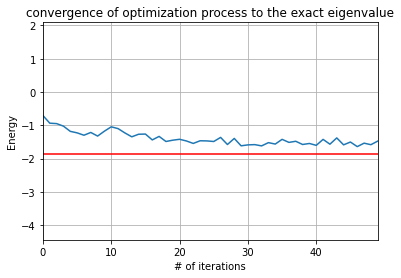

In [220]:
compare_exact_and_approximated_eigenvalue(H2_molecule_Hamiltonian_4_qubits, H2_approximated_eigenvalue)

#### Full Entangelment

In [ ]:
%%time
H2_approximated_eigenvalue = get_approximated_eigenvalue_of_hamiltonian(H2_molecule_Hamiltonian_4_qubits, "full")

3it [00:00, 21.61it/s]

{'1101': 148, '1000': 87, '1111': 278, '1001': 119, '1010': 138, '1011': 18, '0010': 99, '1110': 20, '0111': 29, '0000': 29, '0001': 6, '0011': 33, '1100': 14, '0100': 3, '0101': 3}
1.0
{'0000': 36, '1000': 76, '1111': 265, '0010': 98, '1011': 27, '1010': 149, '1001': 94, '1101': 160, '0111': 33, '1110': 20, '1100': 12, '0011': 36, '0001': 9, '0101': 7, '0100': 2}
1.0
{'1111': 262, '0001': 9, '1010': 128, '1001': 125, '1101': 166, '0111': 30, '0000': 38, '1000': 87, '1100': 13, '0010': 82, '1011': 26, '0101': 3, '0011': 31, '1110': 21, '0100': 3}
1.0
{'0000': 41, '1000': 85, '1111': 274, '1010': 103, '0010': 103, '1101': 166, '0011': 41, '1110': 20, '1001': 104, '0111': 28, '1100': 16, '1011': 25, '0001': 5, '0101': 5, '0110': 4, '0100': 4}
1.0


6it [00:00, 15.72it/s]

{'1111': 273, '0010': 90, '1000': 94, '0000': 39, '1101': 148, '1001': 117, '1010': 132, '0011': 34, '1100': 12, '1011': 25, '0111': 23, '0101': 4, '1110': 19, '0001': 9, '0100': 5}
1.0
{'1111': 291, '0111': 25, '0000': 38, '0011': 23, '1101': 146, '1010': 130, '1001': 118, '0010': 90, '0101': 12, '1100': 20, '1011': 28, '1000': 80, '1110': 12, '0100': 6, '0001': 4, '0110': 1}
1.0
{'1001': 126, '1010': 133, '1111': 270, '0010': 86, '1011': 22, '1101': 148, '0000': 35, '0101': 3, '1100': 15, '1000': 92, '0011': 26, '0001': 14, '0111': 32, '1110': 17, '0100': 4, '0110': 1}
1.0


10it [00:00, 15.67it/s]

{'1101': 147, '1010': 137, '1001': 111, '1111': 278, '1000': 79, '1011': 29, '0010': 104, '0111': 28, '0011': 33, '0000': 26, '0100': 6, '1100': 14, '0001': 13, '0110': 1, '1110': 14, '0101': 4}
1.0
{'0001': 9, '1001': 80, '1000': 210, '1101': 352, '0011': 55, '1100': 96, '1011': 64, '0010': 96, '1110': 4, '0111': 12, '0100': 3, '0101': 19, '1111': 3, '0000': 13, '0110': 8}
1.0
{'1100': 96, '0011': 131, '1111': 105, '0110': 132, '0010': 88, '0001': 61, '1000': 38, '0101': 37, '1001': 168, '1110': 18, '1011': 97, '1101': 19, '1010': 10, '0111': 12, '0100': 12}
1.0
{'1010': 8, '1001': 121, '0101': 124, '0110': 34, '1000': 139, '0011': 15, '1101': 159, '0111': 15, '0001': 36, '1011': 57, '0000': 182, '1111': 31, '0010': 33, '0100': 21, '1110': 48, '1100': 1}
1.0


15it [00:00, 16.69it/s]


{'0100': 2, '1101': 159, '0011': 34, '1001': 114, '1010': 138, '1111': 251, '0111': 43, '1000': 85, '0010': 103, '1100': 15, '1110': 14, '1011': 15, '0000': 37, '0001': 13, '0101': 1}
1.0
{'1101': 146, '0000': 41, '1111': 259, '0010': 123, '1110': 20, '0001': 6, '1001': 115, '0111': 31, '1010': 110, '1000': 88, '1100': 20, '0011': 35, '1011': 23, '0100': 5, '0101': 2}
1.0
{'1001': 119, '0001': 9, '1010': 121, '1111': 280, '1000': 85, '1011': 23, '1100': 19, '0111': 21, '0010': 117, '1101': 138, '0011': 30, '0000': 38, '1110': 17, '0100': 3, '0101': 4}
1.0
{'1111': 297, '0010': 77, '0000': 28, '1000': 87, '1001': 110, '1010': 116, '1101': 169, '0011': 39, '1011': 30, '1110': 10, '0001': 12, '1100': 14, '0111': 22, '0100': 7, '0101': 6}
1.0
[-7.462882744167433, -7.413558354501493, -7.527616763482559, -7.463358308515701, -7.542165697542103, -7.54564906944211, -7.596790130772266, -7.583876423789713, -7.600896587943167, -7.515746344547128, -7.632507556645632, -7.598044667802598, -7.63914769

4it [00:00, 14.99it/s]

{'1000': 179, '1011': 92, '0010': 139, '1101': 182, '1111': 195, '1110': 24, '1100': 31, '0111': 29, '1001': 24, '0011': 5, '1010': 65, '0001': 38, '0110': 1, '0000': 9, '0101': 11}
1.0
{'1011': 101, '1111': 198, '1110': 32, '1000': 174, '0001': 34, '1101': 181, '0011': 6, '1100': 54, '0010': 110, '1010': 70, '0111': 27, '0101': 10, '0000': 7, '1001': 16, '0100': 3, '0110': 1}
1.0
{'0010': 138, '0111': 22, '1111': 199, '1101': 153, '1100': 40, '1010': 74, '1001': 27, '1000': 183, '1011': 87, '0101': 12, '0001': 31, '0011': 3, '1110': 31, '0100': 9, '0000': 12, '0110': 3}
1.0
{'1101': 198, '1100': 25, '1110': 27, '0010': 135, '1011': 82, '1000': 172, '0111': 37, '1111': 199, '1010': 57, '1001': 24, '0001': 43, '0011': 6, '0101': 8, '0100': 4, '0000': 7}
1.0


7it [00:00, 18.13it/s]

{'1111': 208, '0010': 133, '1010': 58, '1001': 24, '1101': 173, '1000': 178, '0111': 31, '1100': 37, '0001': 45, '1110': 23, '0110': 1, '1011': 82, '0101': 10, '0000': 11, '0100': 8, '0011': 2}
1.0
{'1111': 223, '1101': 187, '1010': 69, '1000': 151, '0111': 28, '1100': 43, '0011': 4, '0010': 134, '0000': 10, '1011': 74, '0001': 36, '1001': 22, '1110': 33, '0100': 4, '0101': 5, '0110': 1}
1.0
{'1100': 41, '1011': 80, '0010': 130, '1101': 191, '1110': 35, '0101': 8, '0111': 28, '1111': 214, '1001': 27, '1010': 55, '1000': 163, '0001': 37, '0000': 9, '0011': 3, '0100': 2, '0110': 1}
1.0
{'0100': 6, '1101': 186, '0010': 125, '1011': 83, '1111': 209, '0001': 47, '1010': 67, '1000': 161, '1001': 18, '1100': 39, '1110': 27, '0111': 32, '0000': 10, '0011': 6, '0101': 7, '0110': 1}
1.0
{'0011': 29, '1100': 175, '1110': 39, '1001': 139, '0001': 34, '1101': 198, '0010': 90, '1000': 174, '1111': 31, '0111': 14, '1010': 48, '0100': 14, '0000': 10, '1011': 17, '0101': 8, '0110': 4}
1.0


13it [00:00, 20.01it/s]

{'0001': 15, '1001': 161, '1011': 132, '0110': 130, '1000': 104, '1100': 52, '0011': 111, '0100': 38, '1111': 90, '1101': 15, '0010': 53, '0000': 29, '0111': 6, '0101': 65, '1010': 13, '1110': 10}
1.0
{'0000': 146, '1000': 171, '1001': 95, '0001': 42, '0101': 152, '1110': 51, '0110': 107, '1101': 92, '1010': 33, '1011': 83, '1100': 13, '0100': 8, '0111': 6, '0011': 10, '1111': 10, '0010': 5}
1.0
{'1101': 189, '1111': 220, '1000': 165, '0001': 41, '1010': 66, '0010': 109, '1011': 102, '1110': 26, '0101': 8, '1100': 36, '0111': 23, '1001': 22, '0000': 9, '0011': 3, '0100': 5}
1.0
{'1000': 174, '1001': 28, '1010': 53, '0001': 31, '1111': 199, '1101': 189, '1011': 102, '0010': 135, '1100': 34, '1110': 34, '0111': 22, '0011': 5, '0000': 12, '0101': 5, '0110': 1}
1.0


15it [00:00, 17.35it/s]


{'1101': 183, '0010': 134, '1011': 91, '1100': 33, '1000': 180, '1111': 199, '0111': 24, '1010': 68, '0001': 42, '1001': 27, '1110': 20, '0011': 4, '0000': 8, '0101': 9, '0100': 2}
1.0
{'1101': 216, '1011': 79, '0010': 121, '1000': 167, '0000': 14, '1111': 213, '1110': 29, '1001': 17, '1100': 38, '1010': 57, '0101': 7, '0001': 35, '0111': 25, '0011': 4, '0100': 2}
1.0
[-7.462882744167433, -7.413558354501493, -7.527616763482559, -7.463358308515701, -7.542165697542103, -7.54564906944211, -7.596790130772266, -7.583876423789713, -7.600896587943167, -7.515746344547128, -7.632507556645632, -7.598044667802598, -7.639147693909248, -7.560988771541857, -7.675442454837678, -7.622079965659733, -7.550549216902378, -7.652698557917512, -7.618042657596327, -7.641077813310959, -7.722139285879435, -7.70630044577901, -7.7393074632273295, -7.7156527883399875, -7.734413675713732, -7.703054437903954, -7.681103354862836, -7.67413219031604, -7.684315159085678, -7.730093496472124, -7.714549151939473, -7.714866

3it [00:00, 25.01it/s]

{'1111': 313, '1110': 33, '0101': 53, '0001': 24, '0010': 105, '1000': 103, '1100': 55, '0100': 5, '1011': 49, '1101': 48, '1001': 42, '1010': 136, '0111': 41, '0011': 8, '0000': 8, '0110': 1}
1.0
{'1011': 66, '1111': 290, '1100': 65, '0101': 48, '1010': 113, '1101': 44, '1000': 124, '0111': 47, '1110': 31, '0010': 103, '1001': 44, '0011': 9, '0001': 27, '0000': 7, '0110': 6}
1.0
{'1110': 40, '1011': 53, '0010': 135, '1010': 134, '1001': 59, '1111': 288, '1100': 56, '1101': 43, '0101': 50, '1000': 88, '0111': 37, '0000': 5, '0110': 3, '0001': 25, '0011': 8}
1.0
{'1111': 281, '1000': 132, '0010': 98, '0011': 11, '1100': 65, '1110': 38, '0101': 66, '1010': 127, '0111': 40, '1101': 41, '1011': 72, '1001': 27, '0001': 16, '0000': 6, '0110': 3, '0100': 1}
1.0
{'0111': 26, '1111': 321, '1000': 98, '1010': 123, '0001': 36, '1110': 33, '0101': 56, '0010': 126, '1100': 46, '1011': 58, '0000': 7, '1101': 50, '0100': 1, '0011': 8, '1001': 34, '0110': 1}
1.0


6it [00:00, 22.22it/s]

{'1010': 159, '0010': 109, '1011': 59, '1111': 297, '1110': 31, '0101': 46, '1000': 99, '1101': 46, '1001': 41, '0001': 24, '1100': 58, '0011': 8, '0111': 40, '0110': 3, '0000': 3, '0100': 1}
1.0
{'1111': 301, '1010': 128, '0000': 7, '1000': 120, '0010': 129, '1100': 44, '0101': 46, '0111': 47, '1001': 46, '1011': 63, '1101': 37, '0001': 26, '0110': 2, '1110': 23, '0100': 1, '0011': 4}
1.0
{'0011': 8, '1101': 42, '1111': 294, '1110': 28, '1001': 50, '1010': 124, '0010': 125, '1000': 102, '1011': 53, '0110': 2, '0101': 53, '0001': 37, '1100': 56, '0111': 46, '0000': 3, '0100': 1}
1.0


9it [00:00, 23.35it/s]

{'1111': 148, '1001': 203, '1101': 127, '1100': 182, '0010': 100, '0000': 13, '1000': 111, '0101': 26, '0110': 8, '0011': 21, '1010': 14, '0100': 27, '1011': 19, '0001': 19, '1110': 1, '0111': 5}
1.0
{'1100': 22, '0011': 98, '0110': 195, '1111': 126, '1001': 79, '0010': 77, '1011': 170, '1101': 36, '0000': 41, '1000': 94, '0001': 20, '0101': 33, '0111': 5, '1110': 18, '0100': 7, '1010': 3}
1.0
{'1100': 27, '1101': 138, '0100': 14, '1000': 200, '0101': 137, '1001': 71, '0001': 46, '1011': 73, '1010': 7, '0000': 82, '0110': 61, '0011': 57, '0010': 46, '1111': 21, '1110': 28, '0111': 16}
1.0


12it [00:00, 22.86it/s]

{'0010': 113, '1010': 138, '1101': 38, '1000': 112, '1100': 59, '1111': 320, '0101': 39, '1110': 31, '1011': 51, '0111': 30, '0001': 31, '1001': 40, '0011': 9, '0110': 3, '0000': 8, '0100': 2}
1.0
{'1011': 52, '1111': 295, '1110': 35, '1010': 143, '1001': 41, '1100': 60, '1000': 106, '0111': 33, '0010': 125, '1101': 38, '0000': 4, '0001': 29, '0101': 46, '0011': 14, '0100': 2, '0110': 1}
1.0
{'1111': 306, '1000': 105, '1010': 122, '0001': 29, '0010': 113, '1101': 62, '0101': 58, '1100': 56, '1110': 33, '1001': 38, '0011': 5, '0111': 33, '1011': 56, '0000': 2, '0100': 3, '0110': 3}
1.0
{'1001': 36, '1010': 120, '1111': 337, '1100': 63, '1101': 45, '1011': 47, '0010': 128, '1000': 97, '0111': 37, '0001': 21, '0101': 48, '0000': 6, '0100': 3, '1110': 24, '0011': 11, '0110': 1}
1.0


15it [00:00, 20.99it/s]


[-7.462882744167433, -7.413558354501493, -7.527616763482559, -7.463358308515701, -7.542165697542103, -7.54564906944211, -7.596790130772266, -7.583876423789713, -7.600896587943167, -7.515746344547128, -7.632507556645632, -7.598044667802598, -7.639147693909248, -7.560988771541857, -7.675442454837678, -7.622079965659733, -7.550549216902378, -7.652698557917512, -7.618042657596327, -7.641077813310959, -7.722139285879435, -7.70630044577901, -7.7393074632273295, -7.7156527883399875, -7.734413675713732, -7.703054437903954, -7.681103354862836, -7.67413219031604, -7.684315159085678, -7.730093496472124, -7.714549151939473, -7.714866668154968, -7.727871430773022, -7.665815111325502, -7.697743728326701, -7.673189424995715, -7.712618622613775, -7.670572217358177, -7.707149032377504, -7.6673484725623045, -7.733872406458095, -7.731045973771998, -7.714479583644238, -7.662864570702938, -7.730607644653333, -7.705472460989764, -7.7062372506252235, -7.71117873493011, -7.703563044443457, -7.708853300424329,

0it [00:00, ?it/s]

{'1011': 52, '0010': 185, '1101': 138, '0001': 50, '1111': 121, '1110': 24, '0111': 178, '0000': 12, '1000': 92, '0110': 17, '0101': 56, '0100': 23, '1001': 14, '1010': 37, '1100': 22, '0011': 3}
1.0
{'0001': 68, '1010': 41, '0111': 163, '1101': 132, '1111': 121, '1000': 110, '0010': 182, '1011': 49, '0101': 36, '0000': 16, '1001': 21, '1110': 19, '0100': 32, '0011': 7, '0110': 16, '1100': 11}
1.0


3it [00:00, 22.30it/s]

{'0010': 162, '1011': 56, '1111': 114, '1110': 13, '0101': 36, '1000': 100, '1101': 157, '0001': 58, '0110': 24, '0111': 168, '1001': 19, '1100': 15, '1010': 33, '0000': 22, '0100': 44, '0011': 3}
1.0
{'0010': 172, '1011': 49, '1000': 121, '1010': 33, '1111': 128, '0111': 176, '1101': 129, '0100': 30, '0110': 22, '0011': 4, '0001': 61, '0101': 44, '0000': 16, '1100': 13, '1110': 17, '1001': 9}
1.0
{'1011': 39, '0010': 175, '0101': 60, '1110': 9, '0111': 150, '1111': 110, '1001': 19, '1010': 47, '1101': 150, '1100': 20, '1000': 112, '0100': 31, '0110': 18, '0001': 63, '0000': 15, '0011': 6}
1.0


6it [00:00, 22.45it/s]

{'1111': 115, '1110': 21, '0101': 44, '1101': 130, '0010': 196, '0000': 19, '0111': 178, '0011': 6, '1000': 112, '0001': 44, '0100': 27, '1010': 29, '1011': 47, '0110': 25, '1001': 17, '1100': 14}
1.0
{'1110': 17, '0101': 49, '0001': 69, '0100': 23, '1101': 137, '1011': 52, '0010': 182, '0111': 169, '1001': 12, '1100': 16, '1000': 121, '1010': 31, '1111': 112, '0000': 15, '0110': 18, '0011': 1}
1.0


9it [00:00, 21.37it/s]

{'0110': 20, '1111': 114, '0101': 40, '1011': 45, '0111': 185, '0001': 76, '0100': 30, '1101': 141, '0010': 167, '1000': 120, '0000': 17, '1010': 32, '1001': 13, '1100': 9, '1110': 13, '0011': 2}
1.0
{'1100': 129, '0011': 58, '0110': 45, '0010': 133, '1101': 108, '0100': 55, '1000': 95, '0111': 162, '0001': 51, '1001': 95, '1010': 27, '1110': 29, '1011': 13, '0000': 11, '1111': 11, '0101': 2}
1.0
{'1011': 163, '0010': 79, '1010': 16, '1001': 162, '0100': 49, '1111': 99, '0110': 109, '0111': 25, '1110': 19, '0011': 87, '1100': 34, '1000': 90, '0101': 71, '0001': 6, '1101': 14, '0000': 1}
1.0


12it [00:00, 17.80it/s]

{'1000': 172, '1011': 136, '0010': 12, '1110': 90, '0110': 105, '0100': 48, '0001': 51, '0011': 73, '0101': 80, '1001': 115, '0000': 57, '1101': 22, '1100': 23, '1010': 13, '1111': 5, '0111': 22}
1.0
{'0000': 18, '1000': 123, '1111': 131, '0101': 45, '0010': 181, '1101': 133, '0001': 61, '0111': 173, '1100': 14, '0100': 23, '1011': 44, '1110': 12, '1001': 15, '1010': 34, '0110': 16, '0011': 1}
1.0
{'1011': 52, '0010': 165, '0111': 171, '1101': 135, '0100': 33, '1111': 119, '0001': 56, '1001': 17, '0101': 49, '0110': 18, '1000': 122, '1100': 20, '1010': 28, '0000': 19, '1110': 15, '0011': 5}
1.0
{'1100': 19, '0011': 5, '0010': 168, '1011': 52, '0100': 25, '1101': 144, '0111': 174, '1001': 14, '0101': 36, '0000': 23, '0001': 69, '1000': 104, '1110': 17, '1111': 115, '0110': 23, '1010': 36}
1.0
{'1101': 124, '0100': 32, '0010': 180, '1000': 117, '0101': 53, '0001': 54, '0111': 176, '1111': 118, '0000': 15, '1110': 11, '1011': 37, '1010': 38, '1001': 25, '0110': 26, '0011': 5, '1100': 13}


15it [00:00, 19.46it/s]


[-7.462882744167433, -7.413558354501493, -7.527616763482559, -7.463358308515701, -7.542165697542103, -7.54564906944211, -7.596790130772266, -7.583876423789713, -7.600896587943167, -7.515746344547128, -7.632507556645632, -7.598044667802598, -7.639147693909248, -7.560988771541857, -7.675442454837678, -7.622079965659733, -7.550549216902378, -7.652698557917512, -7.618042657596327, -7.641077813310959, -7.722139285879435, -7.70630044577901, -7.7393074632273295, -7.7156527883399875, -7.734413675713732, -7.703054437903954, -7.681103354862836, -7.67413219031604, -7.684315159085678, -7.730093496472124, -7.714549151939473, -7.714866668154968, -7.727871430773022, -7.665815111325502, -7.697743728326701, -7.673189424995715, -7.712618622613775, -7.670572217358177, -7.707149032377504, -7.6673484725623045, -7.733872406458095, -7.731045973771998, -7.714479583644238, -7.662864570702938, -7.730607644653333, -7.705472460989764, -7.7062372506252235, -7.71117873493011, -7.703563044443457, -7.708853300424329,

2it [00:00, 18.96it/s]

{'0001': 39, '1111': 171, '1000': 18, '1101': 241, '0100': 44, '0111': 166, '0010': 97, '1100': 46, '1010': 25, '1110': 50, '0110': 22, '1011': 12, '1001': 8, '0101': 67, '0000': 18}
1.0
{'0101': 60, '1111': 173, '0110': 22, '0000': 22, '1101': 275, '0001': 39, '0111': 169, '0011': 2, '1000': 17, '1011': 17, '1100': 43, '0010': 79, '1010': 22, '1110': 41, '1001': 7, '0100': 36}
1.0
{'0100': 32, '1101': 255, '1010': 37, '0111': 157, '1111': 179, '0110': 26, '1100': 42, '0010': 96, '1110': 54, '0101': 59, '0000': 15, '0001': 36, '1011': 12, '1001': 5, '1000': 19}
1.0
{'0110': 29, '1111': 182, '1101': 246, '0101': 68, '0000': 22, '1100': 37, '0011': 2, '0111': 168, '0010': 98, '1110': 37, '1000': 19, '0001': 31, '0100': 45, '1001': 8, '1011': 12, '1010': 20}
1.0


5it [00:00, 20.62it/s]

{'0101': 74, '0010': 99, '1101': 234, '0111': 165, '0110': 23, '1111': 190, '0001': 50, '1010': 22, '1100': 42, '1000': 21, '1110': 38, '0100': 28, '0000': 21, '1011': 11, '1001': 6}
1.0
{'0100': 37, '1101': 244, '0110': 28, '1111': 195, '0101': 71, '0010': 95, '0111': 151, '1100': 42, '0001': 40, '1110': 44, '1010': 27, '1011': 15, '0000': 21, '1000': 9, '1001': 5}
1.0
{'1101': 245, '0101': 52, '1110': 44, '0111': 143, '1100': 31, '0110': 26, '1111': 249, '0010': 90, '0000': 14, '1001': 7, '1000': 19, '0001': 33, '1011': 11, '0100': 31, '1010': 26, '0011': 3}
1.0
{'1101': 246, '0100': 38, '1111': 173, '0000': 18, '0111': 172, '1100': 51, '1001': 7, '1110': 39, '0001': 37, '0110': 29, '0101': 71, '0010': 94, '1000': 14, '1011': 16, '1010': 18, '0011': 1}
1.0


10it [00:00, 15.68it/s]

{'1110': 72, '1101': 235, '0100': 54, '0111': 183, '1100': 202, '0001': 38, '1111': 27, '0010': 88, '0011': 34, '0000': 1, '1000': 26, '1010': 4, '0110': 29, '1001': 30, '1011': 1}
1.0
{'0101': 170, '0010': 73, '1011': 222, '1010': 44, '0001': 74, '1001': 108, '0110': 60, '1111': 116, '0100': 19, '1000': 50, '1100': 27, '0011': 17, '0000': 18, '0111': 15, '1110': 6, '1101': 5}
1.0
{'0011': 108, '1100': 111, '1111': 25, '0110': 121, '0001': 45, '1001': 152, '0010': 16, '0000': 26, '0101': 84, '1000': 111, '1110': 36, '1010': 17, '0111': 35, '1011': 100, '1101': 22, '0100': 15}
1.0


12it [00:00, 16.45it/s]

{'0100': 34, '1101': 240, '1111': 190, '1110': 56, '0101': 71, '0111': 173, '0010': 99, '1100': 32, '0001': 37, '1001': 6, '0110': 24, '1010': 24, '0000': 20, '1000': 9, '1011': 9}
1.0


15it [00:00, 17.17it/s]


{'1101': 251, '0100': 36, '1111': 199, '1110': 47, '0101': 64, '0111': 170, '1010': 14, '1000': 25, '1100': 32, '0001': 41, '0010': 77, '0110': 33, '1001': 6, '0000': 20, '1011': 8, '0011': 1}
1.0
{'1111': 180, '0001': 46, '0100': 37, '1101': 255, '0010': 92, '0111': 173, '1110': 46, '0101': 56, '0000': 20, '0110': 25, '1000': 6, '1100': 51, '1001': 8, '1011': 12, '1010': 17}
1.0
{'1101': 221, '0100': 30, '1111': 196, '0111': 154, '0001': 47, '1100': 53, '0101': 85, '0010': 79, '1011': 11, '1110': 49, '0000': 17, '1010': 19, '0110': 29, '1001': 15, '1000': 18, '0011': 1}
1.0
[-7.462882744167433, -7.413558354501493, -7.527616763482559, -7.463358308515701, -7.542165697542103, -7.54564906944211, -7.596790130772266, -7.583876423789713, -7.600896587943167, -7.515746344547128, -7.632507556645632, -7.598044667802598, -7.639147693909248, -7.560988771541857, -7.675442454837678, -7.622079965659733, -7.550549216902378, -7.652698557917512, -7.618042657596327, -7.641077813310959, -7.722139285879435

0it [00:00, ?it/s]

{'0100': 61, '1101': 291, '0110': 43, '1111': 126, '0001': 41, '1001': 28, '0111': 171, '0000': 30, '1010': 10, '0010': 68, '1100': 40, '1110': 66, '0101': 23, '1000': 8, '1011': 11, '0011': 7}
1.0


2it [00:00, 19.14it/s]

{'1111': 136, '0100': 93, '1101': 257, '1100': 49, '0010': 80, '0111': 149, '0101': 31, '0001': 35, '1001': 32, '0011': 13, '1010': 17, '0000': 19, '1110': 74, '0110': 23, '1000': 5, '1011': 11}
1.0


4it [00:00, 14.38it/s]

{'0100': 68, '1101': 256, '0111': 169, '0011': 18, '1100': 48, '1111': 150, '0010': 78, '1000': 7, '1110': 64, '1010': 11, '1011': 6, '0001': 29, '0000': 26, '0101': 26, '0110': 46, '1001': 22}
1.0
{'0011': 14, '1100': 48, '0111': 164, '1111': 130, '0110': 27, '0100': 84, '1101': 249, '0010': 85, '1001': 28, '1011': 13, '1110': 89, '1010': 15, '0000': 24, '0001': 20, '0101': 28, '1000': 6}
1.0


6it [00:00, 14.74it/s]

{'0100': 83, '1101': 279, '1001': 31, '1110': 71, '0111': 142, '0000': 23, '0011': 14, '0010': 78, '1100': 46, '0110': 47, '0101': 29, '1111': 121, '0001': 33, '1011': 8, '1010': 13, '1000': 6}
1.0
{'1100': 60, '0011': 12, '1110': 56, '1010': 18, '1101': 267, '0100': 81, '0111': 165, '0110': 37, '0001': 29, '0000': 37, '1111': 126, '0010': 75, '1001': 22, '0101': 21, '1000': 3, '1011': 15}
1.0


8it [00:00, 16.24it/s]

{'1111': 145, '0110': 30, '0111': 149, '0001': 31, '1101': 288, '0010': 80, '0101': 25, '0000': 25, '0011': 17, '1110': 60, '1010': 14, '0100': 73, '1001': 27, '1100': 47, '1011': 10, '1000': 3}
1.0
{'0111': 159, '0100': 88, '1101': 278, '0110': 37, '1111': 125, '0010': 59, '1011': 13, '1110': 64, '1100': 41, '0011': 23, '0101': 22, '0001': 41, '1001': 27, '0000': 30, '1000': 6, '1010': 11}
1.0
{'0111': 99, '0101': 16, '1110': 93, '0100': 98, '1101': 298, '1100': 133, '0011': 59, '0010': 54, '1111': 22, '0110': 67, '1001': 28, '1000': 11, '0001': 28, '0000': 5, '1010': 8, '1011': 5}
1.0


11it [00:00, 18.31it/s]

{'1011': 225, '0101': 117, '0110': 144, '0111': 11, '1001': 132, '1010': 19, '1000': 123, '0100': 18, '1101': 2, '0001': 78, '1111': 81, '0010': 30, '0000': 8, '1100': 20, '0011': 11, '1110': 5}
1.0
{'1011': 118, '1000': 198, '1001': 166, '0001': 61, '0101': 83, '0110': 180, '1101': 22, '0011': 50, '1100': 69, '0100': 17, '0111': 2, '0010': 12, '1010': 22, '1111': 14, '0000': 2, '1110': 8}
1.0
{'0100': 80, '1101': 258, '0001': 34, '0010': 84, '0110': 36, '1111': 148, '0111': 153, '0000': 24, '1011': 8, '1110': 68, '0101': 33, '1010': 14, '1001': 21, '0011': 14, '1100': 47, '1000': 2}
1.0
{'1011': 12, '0010': 84, '0100': 70, '1101': 285, '0111': 145, '0110': 19, '1111': 148, '1110': 70, '0101': 29, '0000': 34, '1001': 20, '1100': 58, '0001': 26, '0011': 11, '1000': 6, '1010': 7}
1.0
{'0100': 69, '1101': 268, '1111': 132, '0110': 40, '1110': 74, '0111': 149, '0010': 78, '1010': 13, '1001': 28, '1100': 53, '0101': 23, '0001': 31, '0011': 15, '1011': 11, '0000': 28, '1000': 12}

15it [00:00, 18.19it/s]



1.0
{'1101': 268, '1111': 145, '1001': 21, '0001': 26, '1110': 56, '0000': 31, '1100': 52, '0010': 69, '0101': 43, '0110': 43, '0111': 138, '0100': 82, '0011': 13, '1011': 17, '1000': 5, '1010': 15}
1.0
[-7.462882744167433, -7.413558354501493, -7.527616763482559, -7.463358308515701, -7.542165697542103, -7.54564906944211, -7.596790130772266, -7.583876423789713, -7.600896587943167, -7.515746344547128, -7.632507556645632, -7.598044667802598, -7.639147693909248, -7.560988771541857, -7.675442454837678, -7.622079965659733, -7.550549216902378, -7.652698557917512, -7.618042657596327, -7.641077813310959, -7.722139285879435, -7.70630044577901, -7.7393074632273295, -7.7156527883399875, -7.734413675713732, -7.703054437903954, -7.681103354862836, -7.67413219031604, -7.684315159085678, -7.730093496472124, -7.714549151939473, -7.714866668154968, -7.727871430773022, -7.665815111325502, -7.697743728326701, -7.673189424995715, -7.712618622613775, -7.670572217358177, -7.707149032377504, -7.6673484725623

2it [00:00, 14.19it/s]

{'0110': 36, '1101': 245, '0111': 186, '0001': 19, '1001': 87, '1010': 27, '1100': 25, '0000': 30, '1000': 26, '0100': 100, '1110': 65, '1111': 81, '0101': 6, '1011': 51, '0011': 23, '0010': 17}
1.0
{'0100': 84, '1101': 238, '1110': 70, '1011': 37, '0000': 50, '1111': 102, '0111': 176, '1100': 41, '1001': 91, '1010': 28, '0011': 15, '0110': 29, '0001': 19, '1000': 15, '0101': 9, '0010': 20}
1.0


4it [00:00, 16.34it/s]

{'1110': 75, '1100': 28, '1011': 55, '1101': 244, '0000': 38, '1001': 92, '0111': 202, '1111': 87, '1010': 15, '0011': 20, '1000': 24, '0100': 88, '0001': 21, '0101': 4, '0010': 9, '0110': 22}
1.0
{'1101': 240, '0100': 92, '1100': 39, '0001': 28, '1001': 82, '0111': 187, '1110': 81, '1111': 89, '1010': 22, '0000': 33, '1011': 48, '0010': 7, '0110': 29, '1000': 22, '0011': 21, '0101': 4}
1.0


7it [00:00, 19.27it/s]

{'0111': 179, '0100': 101, '1101': 265, '1000': 20, '1111': 80, '1001': 68, '0001': 22, '1110': 75, '1011': 58, '1010': 24, '0101': 11, '0010': 17, '1100': 25, '0110': 27, '0000': 35, '0011': 17}
1.0
{'1111': 71, '0110': 23, '0011': 27, '1100': 25, '1001': 83, '1010': 24, '1110': 72, '0111': 210, '1101': 263, '0100': 87, '1000': 25, '0000': 33, '0010': 13, '1011': 41, '0001': 19, '0101': 8}
1.0
{'1111': 94, '1011': 40, '0010': 13, '1101': 245, '0101': 7, '1001': 83, '0111': 191, '0011': 16, '0100': 100, '1110': 58, '0001': 27, '0000': 45, '1010': 22, '1100': 29, '1000': 25, '0110': 29}
1.0


9it [00:00, 19.48it/s]

{'1110': 75, '0000': 35, '1100': 25, '0100': 96, '1101': 235, '0111': 188, '0010': 11, '1011': 53, '1001': 88, '0110': 35, '1010': 33, '1111': 85, '0001': 21, '0011': 12, '0101': 15, '1000': 17}
1.0
{'1110': 117, '1100': 104, '0011': 43, '1101': 203, '0000': 28, '1011': 39, '0110': 84, '0111': 122, '0100': 124, '1001': 80, '1010': 27, '1000': 31, '0001': 11, '1111': 7, '0101': 1, '0010': 3}
1.0


12it [00:00, 20.36it/s]

{'1001': 147, '0001': 124, '0111': 44, '1011': 256, '1000': 161, '1111': 24, '0101': 75, '0011': 22, '0010': 73, '1101': 31, '0000': 10, '0110': 34, '1010': 15, '1110': 3, '0100': 1, '1100': 4}
1.0
{'0001': 108, '1001': 172, '1000': 243, '0110': 71, '0101': 24, '0010': 92, '1011': 177, '0111': 16, '1100': 40, '1010': 9, '1110': 16, '0100': 18, '0000': 9, '1101': 10, '0011': 18, '1111': 1}
1.0
{'0111': 192, '1111': 58, '1001': 86, '0100': 95, '1101': 249, '0011': 13, '1011': 66, '1110': 76, '1000': 26, '0101': 13, '0001': 33, '0000': 49, '0110': 28, '1010': 16, '1100': 18, '0010': 6}
1.0
{'1111': 96, '1001': 75, '1010': 26, '0000': 48, '0111': 203, '1101': 243, '1100': 32, '0011': 23, '1011': 43, '0100': 84, '0110': 35, '0001': 16, '1110': 58, '0101': 9, '0010': 13, '1000': 20}
1.0
{'0111': 207, '1011': 64, '0100': 78, '1101': 228, '0110': 34, '1111': 72, '1000': 18, '1001': 98, '1110': 62, '1010': 23, '0011': 23, '0000': 42, '1100': 23, '0101': 11, '0001': 24, '0010': 17}
1.0


15it [00:00, 19.35it/s]


{'1101': 274, '0100': 93, '0111': 173, '0001': 27, '1001': 98, '1111': 80, '0101': 11, '1110': 53, '1011': 52, '0110': 22, '1000': 13, '1100': 28, '1010': 36, '0000': 30, '0011': 21, '0010': 13}
1.0
[-7.462882744167433, -7.413558354501493, -7.527616763482559, -7.463358308515701, -7.542165697542103, -7.54564906944211, -7.596790130772266, -7.583876423789713, -7.600896587943167, -7.515746344547128, -7.632507556645632, -7.598044667802598, -7.639147693909248, -7.560988771541857, -7.675442454837678, -7.622079965659733, -7.550549216902378, -7.652698557917512, -7.618042657596327, -7.641077813310959, -7.722139285879435, -7.70630044577901, -7.7393074632273295, -7.7156527883399875, -7.734413675713732, -7.703054437903954, -7.681103354862836, -7.67413219031604, -7.684315159085678, -7.730093496472124, -7.714549151939473, -7.714866668154968, -7.727871430773022, -7.665815111325502, -7.697743728326701, -7.673189424995715, -7.712618622613775, -7.670572217358177, -7.707149032377504, -7.6673484725623045, 

1it [00:00,  7.40it/s]

{'1111': 37, '1011': 49, '0010': 21, '0111': 260, '0100': 114, '1101': 196, '0101': 22, '0011': 13, '1001': 97, '1000': 25, '1100': 16, '0000': 44, '0110': 55, '1110': 48, '0001': 19, '1010': 8}
1.0


5it [00:00, 16.00it/s]

{'0111': 243, '0100': 117, '1101': 187, '1110': 44, '1011': 60, '1111': 48, '1000': 28, '0000': 38, '1010': 16, '1100': 22, '0101': 36, '0010': 25, '0011': 16, '0110': 57, '1001': 76, '0001': 11}
1.0
{'0111': 265, '0110': 52, '1101': 166, '0100': 110, '1010': 13, '0000': 38, '1000': 32, '1100': 20, '1011': 61, '1001': 93, '0101': 34, '1111': 40, '1110': 50, '0011': 18, '0010': 23, '0001': 9}
1.0
{'0111': 232, '1101': 203, '0100': 99, '1100': 15, '1001': 90, '0101': 27, '0000': 56, '1111': 48, '0110': 53, '1011': 58, '1000': 26, '0001': 15, '0010': 15, '1110': 59, '1010': 7, '0011': 21}
1.0
{'0100': 115, '1101': 169, '0111': 256, '1100': 16, '0110': 62, '1011': 60, '0101': 27, '1010': 15, '0000': 47, '1001': 75, '1111': 64, '1000': 27, '1110': 50, '0011': 12, '0001': 14, '0010': 15}
1.0
{'0001': 18, '0111': 239, '1101': 162, '0100': 105, '0011': 17, '1000': 35, '0000': 47, '0110': 57, '1010': 17, '0010': 19, '1110': 54, '1100': 15, '1001': 93, '1011': 60, '0101': 31, '1111': 55}
1.0


9it [00:00, 17.82it/s]

{'0001': 21, '1001': 85, '0111': 217, '1101': 220, '0100': 128, '0011': 17, '1110': 64, '0101': 18, '1000': 21, '0000': 48, '1111': 47, '0010': 19, '0110': 50, '1011': 50, '1100': 13, '1010': 6}
1.0
{'0011': 24, '0101': 27, '1110': 53, '0111': 238, '0110': 61, '1101': 187, '1010': 11, '0000': 36, '0100': 103, '1001': 105, '1111': 53, '0001': 26, '1011': 46, '0010': 17, '1000': 22, '1100': 15}
1.0
{'1101': 164, '0100': 128, '1110': 67, '0111': 175, '0110': 119, '0011': 56, '1100': 59, '1001': 108, '1011': 33, '1010': 17, '1000': 39, '0101': 6, '0000': 36, '0001': 6, '0010': 6, '1111': 5}
1.0
{'0010': 86, '1011': 284, '1000': 197, '0101': 53, '1001': 98, '0001': 135, '0110': 42, '1111': 27, '1101': 24, '0000': 18, '0111': 48, '1010': 3, '0011': 3, '0100': 4, '1100': 1, '1110': 1}
1.0


13it [00:00, 14.99it/s]

{'1011': 196, '0010': 101, '1000': 265, '0110': 93, '0111': 20, '1100': 22, '1001': 116, '0001': 103, '0101': 23, '0100': 23, '0011': 32, '1110': 10, '1111': 4, '1010': 5, '1101': 9, '0000': 2}
1.0
{'1101': 201, '0001': 25, '0111': 246, '1011': 52, '0010': 20, '1111': 44, '0101': 21, '1000': 33, '0100': 96, '1001': 98, '1110': 52, '0000': 46, '0011': 13, '1100': 23, '0110': 43, '1010': 11}
1.0
{'1100': 26, '1000': 26, '0000': 43, '1110': 54, '0100': 100, '1101': 191, '1001': 104, '0111': 215, '0110': 45, '1111': 62, '1010': 17, '0101': 23, '0001': 16, '1011': 62, '0011': 24, '0010': 16}
1.0
{'0100': 102, '1101': 190, '1010': 14, '1001': 85, '0111': 247, '1011': 58, '0011': 22, '0101': 25, '0010': 23, '1111': 37, '1110': 66, '1000': 29, '1100': 17, '0110': 53, '0000': 41, '0001': 15}
1.0


15it [00:00, 15.67it/s]


{'1100': 18, '0111': 256, '1011': 45, '1101': 200, '0100': 111, '0001': 12, '1001': 86, '0101': 25, '1110': 49, '0110': 58, '0011': 17, '1111': 46, '0010': 14, '0000': 42, '1000': 27, '1010': 18}
1.0
[-7.462882744167433, -7.413558354501493, -7.527616763482559, -7.463358308515701, -7.542165697542103, -7.54564906944211, -7.596790130772266, -7.583876423789713, -7.600896587943167, -7.515746344547128, -7.632507556645632, -7.598044667802598, -7.639147693909248, -7.560988771541857, -7.675442454837678, -7.622079965659733, -7.550549216902378, -7.652698557917512, -7.618042657596327, -7.641077813310959, -7.722139285879435, -7.70630044577901, -7.7393074632273295, -7.7156527883399875, -7.734413675713732, -7.703054437903954, -7.681103354862836, -7.67413219031604, -7.684315159085678, -7.730093496472124, -7.714549151939473, -7.714866668154968, -7.727871430773022, -7.665815111325502, -7.697743728326701, -7.673189424995715, -7.712618622613775, -7.670572217358177, -7.707149032377504, -7.6673484725623045,

3it [00:00, 21.19it/s]

{'0000': 48, '0111': 245, '0100': 114, '1101': 174, '0101': 34, '1110': 50, '0110': 60, '1111': 47, '0010': 19, '1010': 11, '1001': 93, '1011': 54, '0001': 19, '1100': 12, '0011': 22, '1000': 22}
1.0
{'0111': 225, '1001': 85, '1101': 193, '0100': 106, '1100': 26, '1011': 70, '0010': 28, '1111': 38, '0110': 50, '0001': 18, '0011': 22, '0101': 31, '1000': 25, '1110': 45, '0000': 48, '1010': 14}
1.0
{'1101': 202, '0100': 119, '0010': 17, '1011': 47, '1111': 46, '0111': 230, '0101': 33, '1001': 95, '0000': 52, '0011': 22, '1110': 58, '0110': 50, '1100': 17, '1000': 19, '0001': 12, '1010': 5}
1.0
{'0100': 110, '1101': 200, '0110': 57, '1111': 42, '0000': 38, '1000': 32, '0111': 221, '0011': 20, '1110': 53, '1011': 76, '1001': 86, '1100': 20, '0010': 19, '0001': 13, '1010': 12, '0101': 25}
1.0
{'1011': 50, '0100': 124, '1101': 183, '1001': 90, '0111': 229, '0101': 29, '0000': 48, '1111': 59, '1100': 17, '0010': 22, '1000': 28, '1110': 47, '0001': 17, '0110': 50, '1010': 11, '0011': 20}
1.0


6it [00:00, 22.12it/s]

{'0100': 126, '1101': 176, '0111': 267, '0001': 18, '1000': 20, '1011': 54, '1111': 43, '0011': 19, '1001': 67, '0101': 14, '0000': 60, '1010': 8, '0110': 67, '1110': 59, '1100': 18, '0010': 8}
1.0
{'1101': 189, '0101': 16, '0010': 26, '1011': 45, '0000': 56, '0111': 256, '0110': 54, '1001': 84, '0100': 108, '1100': 14, '1111': 54, '0011': 20, '1110': 58, '1010': 10, '0001': 13, '1000': 21}
1.0
{'0101': 38, '1110': 53, '0100': 97, '1101': 209, '0111': 208, '1001': 87, '0000': 49, '0011': 20, '0110': 60, '1111': 42, '1010': 14, '1100': 23, '1011': 62, '0001': 19, '0010': 20, '1000': 23}
1.0


9it [00:00, 21.51it/s]

{'0110': 123, '1110': 59, '0111': 153, '0011': 55, '1100': 58, '0100': 166, '1011': 45, '0000': 41, '1101': 156, '1001': 86, '0010': 15, '1010': 22, '1000': 36, '1111': 4, '0101': 1, '0001': 4}
1.0


12it [00:00, 18.39it/s]

{'1011': 255, '0010': 89, '0101': 61, '1000': 173, '0000': 18, '1101': 24, '0111': 47, '1001': 117, '0001': 142, '1111': 28, '0100': 6, '0011': 7, '0110': 50, '1110': 2, '1010': 4, '1100': 1}
1.0
{'1000': 256, '0001': 114, '1001': 134, '0010': 102, '1011': 191, '0110': 84, '0100': 16, '1100': 22, '0101': 18, '0111': 19, '0011': 37, '1110': 12, '1111': 5, '1010': 7, '1101': 7}
1.0
{'0111': 227, '0101': 33, '0100': 123, '1101': 188, '1011': 52, '0000': 45, '1001': 92, '0110': 46, '1110': 58, '0011': 20, '1111': 46, '0001': 12, '1010': 15, '1000': 27, '0010': 22, '1100': 18}
1.0


15it [00:00, 19.56it/s]


{'0111': 244, '0000': 44, '0100': 115, '1101': 200, '1011': 51, '0011': 18, '1100': 14, '0110': 70, '1001': 77, '0101': 25, '1110': 51, '1000': 25, '0001': 16, '0010': 25, '1111': 39, '1010': 10}
1.0
{'0100': 113, '1101': 199, '1000': 30, '0111': 221, '1001': 90, '1100': 16, '1110': 59, '0110': 48, '0011': 19, '0000': 47, '0101': 26, '0001': 20, '0010': 20, '1011': 57, '1111': 46, '1010': 13}
1.0
{'1101': 178, '1001': 78, '1111': 44, '1110': 46, '0111': 262, '0011': 18, '1100': 15, '1011': 58, '0100': 127, '1000': 28, '0000': 46, '0010': 25, '0101': 24, '1010': 11, '0110': 50, '0001': 14}
1.0
[-7.462882744167433, -7.413558354501493, -7.527616763482559, -7.463358308515701, -7.542165697542103, -7.54564906944211, -7.596790130772266, -7.583876423789713, -7.600896587943167, -7.515746344547128, -7.632507556645632, -7.598044667802598, -7.639147693909248, -7.560988771541857, -7.675442454837678, -7.622079965659733, -7.550549216902378, -7.652698557917512, -7.618042657596327, -7.641077813310959, 

0it [00:00, ?it/s]

{'1110': 45, '0101': 37, '1001': 67, '0001': 40, '0111': 324, '0100': 58, '1111': 31, '1000': 27, '1101': 191, '1011': 69, '0000': 21, '1100': 46, '0110': 28, '0010': 27, '1010': 12, '0011': 1}
1.0
{'1011': 63, '1101': 197, '0100': 54, '1010': 19, '1001': 71, '0111': 274, '0000': 35, '0110': 34, '0001': 37, '1100': 42, '1111': 47, '0101': 34, '1110': 43, '1000': 38, '0010': 35, '0011': 1}
1.0


3it [00:00, 20.57it/s]

{'0111': 304, '0110': 33, '0100': 59, '1101': 184, '0001': 35, '1001': 75, '1100': 43, '1000': 30, '1011': 48, '1110': 57, '0010': 29, '0000': 49, '0101': 34, '1111': 27, '1010': 15, '0011': 2}
1.0
{'1101': 174, '0100': 78, '0000': 34, '0010': 32, '1111': 28, '0111': 305, '1110': 49, '1001': 89, '0011': 2, '0110': 36, '1010': 15, '1011': 53, '0101': 24, '0001': 33, '1100': 43, '1000': 29}
1.0
{'1100': 54, '1110': 43, '0101': 41, '1001': 92, '1101': 191, '0111': 304, '1000': 34, '1011': 50, '0001': 38, '0110': 28, '0100': 47, '0000': 36, '1111': 30, '1010': 10, '0010': 24, '0011': 2}
1.0


6it [00:00, 18.71it/s]

{'0111': 307, '1101': 179, '0100': 57, '0001': 33, '1001': 94, '1011': 54, '1110': 52, '0110': 32, '1000': 26, '0000': 35, '1111': 25, '0101': 32, '1010': 10, '1100': 49, '0010': 37, '0011': 2}
1.0
{'1001': 78, '1111': 29, '0110': 29, '0100': 57, '1101': 189, '0111': 325, '1100': 40, '1011': 51, '0000': 30, '0101': 33, '1000': 39, '1110': 50, '0001': 42, '1010': 12, '0010': 20}
1.0
{'1011': 36, '0101': 39, '0100': 62, '1101': 187, '1001': 106, '0001': 35, '0111': 294, '1100': 44, '0000': 40, '1111': 30, '1110': 35, '0010': 35, '0110': 41, '1000': 23, '1010': 13, '0011': 4}
1.0


10it [00:00, 15.83it/s]

{'1100': 123, '0011': 60, '1110': 64, '1001': 116, '1010': 15, '1101': 118, '0100': 188, '0111': 134, '0001': 14, '0110': 90, '1011': 56, '0101': 13, '0000': 8, '1000': 8, '1111': 11, '0010': 6}
1.0
{'1001': 41, '0001': 113, '0111': 106, '1011': 205, '0010': 49, '1000': 109, '1111': 38, '0011': 29, '1010': 1, '1101': 116, '1100': 48, '0101': 74, '1110': 61, '0000': 17, '0110': 11, '0100': 6}
1.0


13it [00:00, 17.48it/s]

{'1000': 149, '1100': 171, '0011': 84, '0001': 100, '1001': 95, '1011': 102, '1111': 69, '0110': 138, '0010': 51, '0111': 40, '0100': 2, '1101': 12, '0101': 9, '1010': 2}
1.0
{'1101': 211, '0100': 54, '0111': 297, '1011': 48, '0000': 30, '1000': 32, '1100': 48, '1111': 30, '0110': 34, '1001': 79, '1010': 15, '0001': 32, '1110': 41, '0101': 42, '0010': 30, '0011': 1}
1.0
{'0111': 322, '1100': 50, '0110': 26, '1110': 38, '0100': 63, '1101': 189, '0000': 30, '0001': 40, '1111': 36, '1000': 30, '0101': 32, '0010': 25, '1011': 49, '1001': 79, '1010': 12, '0011': 3}
1.0


15it [00:00, 17.68it/s]

{'0001': 42, '1011': 58, '0010': 17, '0011': 4, '0100': 63, '1101': 202, '1110': 44, '0000': 38, '0111': 308, '1100': 42, '0110': 28, '1000': 25, '1001': 91, '1111': 15, '0101': 37, '1010': 10}
1.0
{'1110': 50, '0101': 35, '0111': 321, '1101': 195, '1001': 76, '0001': 32, '0110': 32, '1100': 49, '1111': 47, '1011': 46, '0100': 53, '1000': 28, '0000': 18, '0010': 29, '1010': 10, '0011': 3}
1.0


[-7.462882744167433, -7.413558354501493, -7.527616763482559, -7.463358308515701, -7.542165697542103, -7.54564906944211, -7.596790130772266, -7.583876423789713, -7.600896587943167, -7.515746344547128, -7.632507556645632, -7.598044667802598, -7.639147693909248, -7.560988771541857, -7.675442454837678, -7.622079965659733, -7.550549216902378, -7.652698557917512, -7.618042657596327, -7.641077813310959, -7.722139285879435, -7.70630044577901, -7.7393074632273295, -7.7156527883399875, -7.734413675713732, -7.703054437903954, -7.681103354862836, -7.67413219031604, -7.684315159085678, -7.730093496472124, -7.714549151939473, -7.714866668154968, -7.727871430773022, -7.665815111325502, -7.697743728326701, -7.673189424995715, -7.712618622613775, -7.670572217358177, -7.707149032377504, -7.6673484725623045, -7.733872406458095, -7.731045973771998, -7.714479583644238, -7.662864570702938, -7.730607644653333, -7.705472460989764, -7.7062372506252235, -7.71117873493011, -7.703563044443457, -7.708853300424329,

0it [00:00, ?it/s]

{'1101': 89, '0100': 173, '0111': 109, '0000': 139, '1110': 93, '0101': 20, '1011': 94, '0110': 54, '1000': 36, '1100': 17, '0001': 47, '1010': 72, '1111': 51, '1001': 30}
1.0
{'0100': 165, '1101': 93, '1011': 94, '1111': 58, '0111': 105, '0000': 149, '1000': 42, '1110': 90, '1010': 57, '1001': 26, '0110': 45, '0001': 51, '0101': 30, '1100': 18, '0010': 1}
1.0


3it [00:00, 17.46it/s]

{'1001': 26, '1010': 52, '0010': 2, '0101': 18, '1101': 87, '0100': 191, '0111': 97, '0110': 58, '0001': 35, '1000': 50, '1110': 99, '0000': 151, '1111': 53, '1011': 89, '1100': 16}
1.0


5it [00:00, 15.40it/s]

{'0100': 181, '1000': 51, '0000': 156, '1010': 40, '0001': 41, '1011': 99, '0111': 105, '1110': 91, '0110': 61, '1101': 78, '1001': 22, '1111': 46, '1100': 23, '0101': 29, '0010': 1}
1.0
{'1110': 119, '0101': 16, '1101': 81, '0100': 186, '0111': 95, '1000': 53, '0000': 156, '1001': 22, '0001': 44, '1111': 46, '1011': 82, '1010': 59, '0110': 48, '1100': 17}
1.0
{'1111': 48, '1001': 25, '1000': 54, '0000': 145, '0111': 90, '1011': 105, '1101': 85, '0100': 172, '1100': 16, '0110': 59, '1110': 97, '1010': 66, '0001': 43, '0101': 19}
1.0


8it [00:00, 18.44it/s]

{'1110': 98, '0101': 15, '1011': 104, '0100': 179, '1101': 100, '1000': 43, '1001': 25, '1111': 48, '0000': 156, '0111': 98, '0001': 41, '1010': 58, '0110': 45, '1100': 13, '0010': 1}
1.0
{'1011': 108, '1100': 14, '0100': 170, '1110': 100, '0111': 79, '0001': 39, '0000': 167, '0110': 45, '1101': 92, '0101': 20, '1001': 22, '1010': 57, '1111': 58, '1000': 52, '0010': 1}
1.0


11it [00:00, 20.10it/s]

{'0110': 112, '0001': 49, '1001': 60, '0111': 89, '1110': 55, '1011': 66, '0010': 50, '0100': 99, '1000': 76, '1010': 22, '1111': 44, '1101': 151, '1100': 28, '0000': 41, '0101': 37, '0011': 45}
1.0
{'0101': 79, '1000': 318, '0000': 59, '0010': 140, '1011': 163, '1111': 18, '0110': 34, '1001': 65, '1110': 18, '0100': 9, '0011': 25, '0111': 43, '1010': 6, '0001': 32, '1101': 11, '1100': 4}
1.0
{'1011': 215, '0010': 93, '0000': 8, '1000': 232, '1110': 32, '1001': 124, '0001': 123, '0110': 103, '1101': 8, '0101': 17, '1010': 21, '0100': 16, '0111': 9, '1111': 8, '0011': 14, '1100': 1}
1.0


14it [00:00, 21.79it/s]

{'1110': 103, '1011': 102, '0100': 172, '1101': 97, '0000': 160, '0110': 62, '1010': 43, '0111': 88, '1001': 21, '0001': 37, '1000': 49, '1111': 54, '0101': 22, '1100': 13, '0010': 1}
1.0
{'1010': 57, '0001': 38, '0101': 21, '1110': 99, '0000': 128, '1101': 101, '0100': 187, '1011': 108, '0110': 54, '0111': 97, '1001': 16, '1100': 13, '1000': 46, '1111': 59}
1.0
{'0111': 86, '0100': 167, '1101': 93, '1111': 55, '1110': 101, '0000': 146, '1000': 53, '0001': 51, '1011': 96, '1001': 23, '1010': 62, '0110': 49, '0101': 28, '1100': 14}
1.0


15it [00:00, 19.92it/s]


{'1101': 98, '0100': 179, '0000': 142, '1000': 45, '1001': 23, '1110': 124, '0110': 47, '1011': 99, '0111': 93, '0001': 40, '1111': 46, '0010': 2, '1010': 54, '1100': 17, '0101': 15}
1.0
[-7.462882744167433, -7.413558354501493, -7.527616763482559, -7.463358308515701, -7.542165697542103, -7.54564906944211, -7.596790130772266, -7.583876423789713, -7.600896587943167, -7.515746344547128, -7.632507556645632, -7.598044667802598, -7.639147693909248, -7.560988771541857, -7.675442454837678, -7.622079965659733, -7.550549216902378, -7.652698557917512, -7.618042657596327, -7.641077813310959, -7.722139285879435, -7.70630044577901, -7.7393074632273295, -7.7156527883399875, -7.734413675713732, -7.703054437903954, -7.681103354862836, -7.67413219031604, -7.684315159085678, -7.730093496472124, -7.714549151939473, -7.714866668154968, -7.727871430773022, -7.665815111325502, -7.697743728326701, -7.673189424995715, -7.712618622613775, -7.670572217358177, -7.707149032377504, -7.6673484725623045, -7.733872406

0it [00:00, ?it/s]

{'1001': 62, '0001': 21, '1101': 252, '0100': 120, '0011': 21, '0111': 288, '1111': 18, '0110': 29, '1110': 84, '1010': 16, '1000': 33, '0000': 23, '1011': 36, '1100': 6, '0010': 12, '0101': 3}
1.0


2it [00:00, 13.87it/s]

{'0111': 279, '0100': 133, '1101': 243, '1000': 43, '0011': 16, '1110': 86, '0001': 25, '1001': 67, '1011': 33, '0000': 21, '0110': 27, '0010': 19, '1010': 5, '1111': 17, '0101': 4, '1100': 6}
1.0


4it [00:00, 15.06it/s]

{'1000': 35, '1101': 244, '0100': 138, '1110': 72, '0111': 316, '1001': 59, '0110': 26, '0010': 21, '0011': 16, '1011': 35, '1010': 14, '0101': 3, '0000': 23, '0001': 14, '1100': 6, '1111': 2}
1.0
{'0100': 123, '1101': 260, '1110': 79, '0111': 285, '0001': 15, '1001': 58, '1000': 41, '0110': 29, '1011': 42, '1010': 11, '1111': 10, '0000': 29, '0011': 24, '1100': 4, '0010': 12, '0101': 2}
1.0
{'0100': 106, '1101': 279, '0111': 266, '1110': 100, '0000': 27, '0001': 25, '1001': 51, '0011': 18, '1000': 40, '0110': 29, '0010': 18, '1011': 40, '1010': 14, '0101': 4, '1111': 6, '1100': 1}
1.0


7it [00:00, 17.78it/s]

{'1101': 249, '0100': 130, '1001': 61, '1000': 37, '0011': 16, '1011': 36, '0111': 277, '1110': 77, '1100': 9, '0010': 21, '1010': 12, '0000': 25, '0110': 30, '0001': 30, '1111': 11, '0101': 3}
1.0
{'1011': 33, '0111': 290, '1000': 47, '1101': 246, '0100': 152, '1001': 49, '1100': 7, '1110': 78, '0001': 19, '1111': 9, '0000': 29, '0010': 15, '0110': 17, '0011': 17, '1010': 15, '0101': 1}
1.0


9it [00:00, 18.44it/s]

{'0100': 138, '1101': 238, '0111': 290, '0010': 12, '0110': 26, '0001': 22, '1110': 89, '1000': 47, '1001': 57, '1011': 36, '0000': 27, '0011': 18, '1111': 6, '0101': 6, '1100': 5, '1010': 7}
1.0
{'0011': 33, '1101': 187, '0100': 196, '0110': 90, '0111': 154, '1001': 61, '1000': 47, '0101': 9, '0000': 19, '1110': 111, '1100': 35, '1011': 50, '0001': 11, '0010': 9, '1010': 9, '1111': 3}
1.0
{'1111': 72, '0110': 97, '0001': 114, '1001': 69, '0111': 85, '1101': 87, '0100': 77, '1011': 198, '1000': 107, '1100': 22, '1010': 4, '0011': 20, '0101': 46, '0000': 10, '1110': 8, '0010': 8}
1.0


12it [00:00, 19.82it/s]

{'1100': 95, '1011': 89, '0110': 141, '0001': 45, '1001': 105, '0111': 86, '1101': 87, '1000': 156, '1111': 12, '0010': 62, '0101': 27, '0100': 52, '1110': 17, '0011': 46, '0000': 4}
1.0
{'0111': 287, '1111': 12, '0100': 123, '1101': 255, '1011': 48, '1000': 40, '1001': 51, '1110': 83, '0000': 30, '0011': 11, '0001': 20, '0010': 11, '1010': 16, '0110': 28, '0101': 2, '1100': 7}
1.0
{'0100': 133, '1101': 250, '1110': 81, '0111': 286, '0001': 25, '1010': 14, '1011': 48, '0110': 25, '1000': 30, '0000': 25, '0011': 17, '1111': 14, '0010': 16, '0101': 6, '1001': 50, '1100': 4}
1.0
{'0111': 296, '0100': 143, '1101': 244, '0001': 24, '1001': 53, '1010': 17, '1110': 82, '0011': 16, '0000': 31, '0010': 12, '1011': 26, '0110': 30, '1000': 33, '1100': 9, '0101': 4, '1111': 4}
1.0

15it [00:00, 17.23it/s]



{'1011': 37, '0111': 286, '0100': 132, '1101': 252, '0110': 32, '1111': 14, '1000': 39, '0001': 28, '1110': 73, '1001': 57, '0011': 20, '1010': 9, '0000': 26, '1100': 5, '0010': 13, '0101': 1}
1.0
[-7.462882744167433, -7.413558354501493, -7.527616763482559, -7.463358308515701, -7.542165697542103, -7.54564906944211, -7.596790130772266, -7.583876423789713, -7.600896587943167, -7.515746344547128, -7.632507556645632, -7.598044667802598, -7.639147693909248, -7.560988771541857, -7.675442454837678, -7.622079965659733, -7.550549216902378, -7.652698557917512, -7.618042657596327, -7.641077813310959, -7.722139285879435, -7.70630044577901, -7.7393074632273295, -7.7156527883399875, -7.734413675713732, -7.703054437903954, -7.681103354862836, -7.67413219031604, -7.684315159085678, -7.730093496472124, -7.714549151939473, -7.714866668154968, -7.727871430773022, -7.665815111325502, -7.697743728326701, -7.673189424995715, -7.712618622613775, -7.670572217358177, -7.707149032377504, -7.6673484725623045, -

0it [00:00, ?it/s]

{'1101': 285, '0100': 98, '0111': 230, '1111': 8, '1001': 45, '1011': 27, '0010': 23, '1110': 91, '1000': 97, '0000': 14, '1010': 42, '0101': 13, '0110': 34, '1100': 16, '0011': 1}
1.0
{'1101': 273, '1000': 90, '0111': 217, '1001': 41, '1010': 48, '0101': 19, '1011': 50, '0010': 24, '1110': 111, '1111': 7, '0100': 84, '0000': 22, '0110': 23, '1100': 12, '0001': 1, '0011': 2}
1.0


3it [00:00, 21.05it/s]

{'1101': 311, '1010': 53, '1001': 60, '1100': 15, '1011': 35, '0000': 30, '1000': 74, '1110': 109, '0111': 186, '0100': 72, '0110': 26, '1111': 7, '0010': 28, '0011': 3, '0101': 15}
1.0
{'0100': 74, '1101': 319, '0101': 17, '0111': 196, '1010': 47, '0000': 19, '1000': 72, '1011': 50, '0010': 19, '1001': 54, '0011': 1, '0110': 37, '1110': 90, '1111': 13, '1100': 16}
1.0
{'0111': 195, '0101': 23, '1110': 98, '0100': 83, '1101': 301, '0000': 27, '1001': 57, '1111': 16, '1011': 39, '1000': 78, '0110': 26, '0010': 29, '1010': 38, '1100': 11, '0001': 2, '0011': 1}
1.0


6it [00:00, 22.01it/s]

{'0010': 23, '1011': 41, '0111': 195, '1000': 71, '1101': 317, '1010': 51, '1001': 51, '1110': 96, '1111': 11, '0100': 77, '0101': 21, '0110': 36, '0000': 20, '1100': 12, '0011': 2}
1.0
{'1001': 45, '0100': 74, '1101': 297, '0111': 192, '1000': 89, '1011': 45, '0101': 16, '0011': 5, '0010': 34, '1010': 47, '1110': 107, '1100': 12, '1111': 11, '0110': 36, '0000': 13, '0001': 1}
1.0
{'0111': 191, '0100': 79, '1101': 311, '1000': 86, '0110': 36, '1011': 41, '1110': 103, '1010': 43, '1100': 16, '1001': 55, '0000': 16, '0010': 26, '0101': 10, '1111': 8, '0011': 3}
1.0


9it [00:00, 22.68it/s]

{'0111': 103, '1000': 53, '1101': 256, '0100': 151, '1011': 68, '0011': 22, '1001': 66, '0101': 22, '1110': 125, '1100': 27, '1111': 13, '1010': 29, '0010': 16, '0110': 66, '0000': 7}
1.0
{'1011': 111, '1110': 31, '1000': 143, '1111': 62, '0110': 119, '0001': 172, '0100': 42, '0011': 31, '1100': 29, '1001': 75, '0000': 8, '0010': 22, '0101': 85, '0111': 47, '1101': 46, '1010': 1}
1.0


12it [00:00, 19.15it/s]

{'0110': 191, '1011': 117, '0010': 38, '1100': 80, '0101': 45, '1001': 62, '0000': 32, '0111': 54, '1000': 111, '1101': 81, '0001': 130, '1110': 19, '0100': 27, '1111': 17, '0011': 20}
1.0
{'1101': 322, '0100': 79, '1111': 16, '0000': 22, '1000': 76, '0101': 14, '1110': 94, '0111': 199, '1011': 37, '1001': 50, '1010': 49, '0110': 28, '1100': 13, '0010': 24, '0001': 1}
1.0
{'1110': 104, '0100': 88, '1101': 291, '0111': 207, '1000': 81, '1010': 43, '1001': 56, '1011': 45, '0110': 27, '1111': 5, '0010': 23, '0000': 24, '0101': 15, '0001': 2, '1100': 9, '0011': 4}
1.0


14it [00:00, 18.64it/s]

{'1001': 48, '1101': 317, '0111': 200, '1000': 78, '1011': 43, '0010': 23, '1110': 102, '0110': 28, '0000': 26, '0100': 80, '0101': 14, '1010': 43, '1100': 13, '0011': 1, '1111': 7, '0001': 1}
1.0


15it [00:00, 19.76it/s]


{'1101': 301, '0010': 33, '1011': 60, '0111': 202, '1001': 53, '1010': 43, '1110': 96, '1000': 74, '0000': 23, '0100': 76, '0110': 29, '1111': 12, '1100': 10, '0101': 8, '0001': 2, '0011': 2}
1.0
[-7.462882744167433, -7.413558354501493, -7.527616763482559, -7.463358308515701, -7.542165697542103, -7.54564906944211, -7.596790130772266, -7.583876423789713, -7.600896587943167, -7.515746344547128, -7.632507556645632, -7.598044667802598, -7.639147693909248, -7.560988771541857, -7.675442454837678, -7.622079965659733, -7.550549216902378, -7.652698557917512, -7.618042657596327, -7.641077813310959, -7.722139285879435, -7.70630044577901, -7.7393074632273295, -7.7156527883399875, -7.734413675713732, -7.703054437903954, -7.681103354862836, -7.67413219031604, -7.684315159085678, -7.730093496472124, -7.714549151939473, -7.714866668154968, -7.727871430773022, -7.665815111325502, -7.697743728326701, -7.673189424995715, -7.712618622613775, -7.670572217358177, -7.707149032377504, -7.6673484725623045, -7.

3it [00:00, 25.91it/s]

{'1001': 61, '0111': 184, '1100': 57, '1101': 222, '0100': 105, '1111': 49, '0110': 123, '1110': 36, '0011': 30, '0101': 32, '1010': 42, '1011': 22, '0001': 13, '0000': 21, '0010': 8, '1000': 19}
1.0
{'1010': 36, '1111': 43, '0110': 129, '0111': 201, '1101': 206, '1110': 39, '0000': 29, '1100': 45, '0011': 25, '1011': 26, '0100': 114, '1000': 18, '1001': 77, '0101': 22, '0001': 9, '0010': 5}
1.0
{'0100': 99, '1101': 192, '0111': 213, '0110': 129, '1110': 54, '1001': 72, '0011': 28, '1100': 43, '0001': 12, '0000': 38, '1111': 43, '1010': 32, '0010': 8, '1011': 20, '1000': 22, '0101': 19}
1.0
{'0111': 210, '0100': 89, '1101': 190, '1100': 48, '0011': 28, '1001': 74, '1011': 35, '0110': 137, '1111': 33, '1110': 33, '1010': 44, '0001': 15, '0101': 24, '0000': 34, '1000': 26, '0010': 4}
1.0


6it [00:00, 23.50it/s]

{'0100': 109, '1101': 203, '0011': 32, '1100': 54, '0110': 120, '0111': 192, '0101': 30, '0010': 9, '1111': 54, '1001': 83, '0000': 26, '1110': 33, '1000': 25, '1011': 17, '1010': 24, '0001': 13}
1.0
{'1000': 18, '1110': 36, '1100': 54, '1101': 179, '0111': 197, '0110': 143, '1001': 74, '1011': 31, '0100': 104, '1111': 56, '0011': 24, '0000': 27, '0010': 6, '1010': 31, '0101': 26, '0001': 18}
1.0


9it [00:00, 23.67it/s]

{'0001': 10, '1001': 68, '0111': 214, '1101': 238, '0100': 94, '0110': 132, '1000': 17, '0011': 24, '1011': 25, '1100': 62, '1110': 33, '0101': 21, '0010': 5, '1010': 21, '0000': 28, '1111': 32}
1.0
{'0111': 171, '1001': 89, '1010': 43, '0110': 125, '1111': 53, '0100': 93, '1101': 226, '0011': 28, '1011': 15, '1000': 16, '1110': 34, '0101': 20, '0000': 35, '1100': 58, '0001': 12, '0010': 6}
1.0
{'1101': 159, '0100': 162, '0110': 226, '1111': 24, '1110': 70, '0011': 58, '1100': 92, '1001': 72, '0000': 23, '0111': 38, '1010': 29, '1000': 29, '1011': 31, '0101': 9, '0001': 2}
1.0
{'1111': 83, '0110': 134, '1011': 194, '0111': 27, '1101': 64, '0100': 41, '1100': 68, '0001': 117, '1000': 125, '0101': 76, '0010': 24, '0011': 9, '1001': 38, '1010': 16, '1110': 3, '0000': 5}
1.0


12it [00:00, 18.68it/s]

{'1100': 108, '1000': 136, '0101': 64, '0110': 184, '0010': 89, '1011': 99, '1001': 92, '0111': 25, '0000': 13, '1101': 64, '0011': 32, '1111': 14, '1010': 24, '1110': 5, '0001': 52, '0100': 23}
1.0
{'0100': 102, '1101': 214, '0110': 137, '1110': 32, '0011': 30, '0111': 212, '1011': 26, '1001': 55, '1100': 38, '1000': 28, '0001': 20, '1010': 27, '0101': 32, '1111': 39, '0000': 25, '0010': 7}
1.0
{'1100': 70, '0100': 85, '1101': 186, '1111': 43, '0110': 139, '1001': 67, '0111': 189, '1000': 19, '0010': 8, '0000': 34, '1011': 24, '0011': 32, '0001': 19, '1010': 33, '1110': 44, '0101': 32}
1.0
{'1111': 62, '0110': 141, '0111': 208, '1100': 54, '0100': 93, '1101': 186, '1011': 18, '1010': 27, '1110': 41, '0101': 25, '1000': 25, '0000': 24, '1001': 68, '0011': 37, '0001': 12, '0010': 3}
1.0


15it [00:00, 19.78it/s]

{'0101': 17, '0110': 137, '0100': 106, '1101': 190, '1100': 52, '0011': 35, '0111': 197, '0001': 13, '1001': 75, '1010': 28, '1111': 49, '1110': 39, '0000': 40, '1000': 25, '0010': 6, '1011': 15}
1.0


15it [00:00, 20.65it/s]


[-7.462882744167433, -7.413558354501493, -7.527616763482559, -7.463358308515701, -7.542165697542103, -7.54564906944211, -7.596790130772266, -7.583876423789713, -7.600896587943167, -7.515746344547128, -7.632507556645632, -7.598044667802598, -7.639147693909248, -7.560988771541857, -7.675442454837678, -7.622079965659733, -7.550549216902378, -7.652698557917512, -7.618042657596327, -7.641077813310959, -7.722139285879435, -7.70630044577901, -7.7393074632273295, -7.7156527883399875, -7.734413675713732, -7.703054437903954, -7.681103354862836, -7.67413219031604, -7.684315159085678, -7.730093496472124, -7.714549151939473, -7.714866668154968, -7.727871430773022, -7.665815111325502, -7.697743728326701, -7.673189424995715, -7.712618622613775, -7.670572217358177, -7.707149032377504, -7.6673484725623045, -7.733872406458095, -7.731045973771998, -7.714479583644238, -7.662864570702938, -7.730607644653333, -7.705472460989764, -7.7062372506252235, -7.71117873493011, -7.703563044443457, -7.708853300424329,

3it [00:00, 24.10it/s]

{'1100': 33, '1011': 35, '0100': 99, '0111': 200, '1001': 62, '1111': 84, '1110': 31, '0101': 75, '1010': 36, '0110': 80, '1101': 188, '0010': 10, '0001': 18, '0000': 42, '1000': 22, '0011': 9}
1.0
{'0100': 103, '1101': 173, '1111': 97, '0110': 63, '0101': 64, '1010': 35, '1001': 53, '0111': 216, '1011': 38, '1100': 34, '0001': 16, '1000': 22, '0000': 48, '0011': 11, '1110': 43, '0010': 8}
1.0
{'1111': 90, '0110': 91, '0100': 94, '1101': 192, '1100': 47, '1001': 55, '0111': 180, '0101': 67, '0011': 13, '1010': 46, '0001': 15, '0010': 11, '1011': 41, '0000': 30, '1000': 18, '1110': 34}
1.0
{'1101': 191, '0111': 184, '1110': 44, '0101': 62, '1011': 38, '1000': 28, '0110': 80, '1001': 51, '1100': 47, '0011': 10, '1111': 87, '0100': 101, '0010': 17, '0001': 23, '1010': 37, '0000': 24}
1.0
{'1001': 43, '1101': 171, '0100': 105, '1111': 98, '0110': 94, '0111': 192, '0101': 84, '1100': 30, '1010': 48, '1110': 28, '0010': 8, '1011': 36, '1000': 20, '0001': 22, '0000': 29, '0011': 16}
1.0


6it [00:00, 23.20it/s]

{'1101': 183, '0100': 106, '0101': 64, '0111': 207, '1010': 36, '1011': 33, '0000': 40, '0110': 83, '1000': 23, '1111': 98, '1001': 53, '0010': 9, '0001': 14, '0011': 15, '1100': 35, '1110': 25}
1.0
{'1101': 195, '0100': 116, '1011': 36, '0110': 86, '1111': 79, '0111': 199, '1010': 26, '0000': 40, '1100': 52, '1110': 34, '0101': 48, '1000': 17, '1001': 48, '0011': 25, '0001': 14, '0010': 9}
1.0
{'1111': 79, '0110': 77, '0100': 83, '1101': 183, '0111': 195, '0011': 19, '1010': 39, '1001': 64, '0101': 67, '1100': 44, '1110': 33, '1000': 23, '1011': 25, '0001': 21, '0010': 10, '0000': 62}
1.0


9it [00:00, 20.51it/s]

{'0011': 42, '1100': 116, '1101': 171, '0100': 128, '0111': 143, '0110': 154, '1010': 35, '1000': 34, '1111': 16, '1011': 13, '1110': 37, '1001': 83, '0001': 6, '0000': 27, '0010': 3, '0101': 16}
1.0
{'0011': 26, '1011': 179, '1001': 55, '0001': 107, '0101': 106, '1101': 43, '0111': 40, '1000': 120, '1111': 122, '0110': 133, '0010': 10, '0100': 38, '1100': 33, '1110': 1, '1010': 10, '0000': 1}
1.0


15it [00:00, 17.54it/s]

{'0110': 181, '0101': 69, '1000': 126, '0000': 24, '0001': 67, '0100': 20, '0011': 17, '1011': 161, '1111': 29, '0111': 48, '1010': 29, '1101': 64, '1100': 107, '0010': 26, '1001': 52, '1110': 4}
1.0
{'0111': 202, '1101': 195, '0100': 107, '0101': 66, '0001': 19, '1010': 30, '0110': 77, '1100': 38, '1111': 85, '1110': 42, '1001': 46, '0000': 33, '1000': 22, '0011': 19, '1011': 33, '0010': 10}
1.0
{'0100': 107, '1101': 187, '0111': 203, '0011': 13, '1110': 40, '0110': 84, '1001': 42, '1011': 40, '0001': 19, '1010': 38, '0101': 69, '1100': 38, '0000': 30, '1111': 89, '1000': 20, '0010': 5}
1.0
{'0100': 100, '1101': 189, '0110': 84, '1111': 92, '0111': 213, '1110': 35, '0000': 23, '1011': 37, '1001': 63, '0010': 13, '0001': 16, '1000': 17, '0101': 65, '0011': 16, '1010': 30, '1100': 31}
1.0
{'1101': 166, '0100': 110, '0101': 59, '0110': 95, '1111': 104, '0111': 186, '0000': 32, '1000': 21, '0011': 11, '1110': 44, '0010': 14, '1001': 50, '1100': 35, '1011': 29, '1010': 44, '0001': 24}
1.0


15it [00:00, 18.18it/s]


[-7.462882744167433, -7.413558354501493, -7.527616763482559, -7.463358308515701, -7.542165697542103, -7.54564906944211, -7.596790130772266, -7.583876423789713, -7.600896587943167, -7.515746344547128, -7.632507556645632, -7.598044667802598, -7.639147693909248, -7.560988771541857, -7.675442454837678, -7.622079965659733, -7.550549216902378, -7.652698557917512, -7.618042657596327, -7.641077813310959, -7.722139285879435, -7.70630044577901, -7.7393074632273295, -7.7156527883399875, -7.734413675713732, -7.703054437903954, -7.681103354862836, -7.67413219031604, -7.684315159085678, -7.730093496472124, -7.714549151939473, -7.714866668154968, -7.727871430773022, -7.665815111325502, -7.697743728326701, -7.673189424995715, -7.712618622613775, -7.670572217358177, -7.707149032377504, -7.6673484725623045, -7.733872406458095, -7.731045973771998, -7.714479583644238, -7.662864570702938, -7.730607644653333, -7.705472460989764, -7.7062372506252235, -7.71117873493011, -7.703563044443457, -7.708853300424329,

3it [00:00, 25.39it/s]

{'0010': 135, '0100': 99, '1101': 324, '0111': 187, '1000': 21, '0000': 74, '1110': 73, '1010': 16, '1111': 25, '0001': 14, '1011': 15, '1100': 11, '1001': 16, '0110': 8, '0011': 4, '0101': 2}
1.0
{'1000': 29, '0000': 70, '0010': 114, '0100': 88, '1101': 306, '0111': 221, '1110': 91, '1111': 22, '1001': 27, '0110': 9, '1011': 19, '0101': 6, '0001': 8, '1010': 3, '0011': 4, '1100': 7}
1.0
{'0111': 203, '0100': 98, '1101': 307, '1100': 10, '1111': 19, '0010': 122, '1010': 10, '1000': 21, '1110': 102, '1001': 23, '0101': 6, '0000': 54, '0001': 13, '0011': 9, '1011': 17, '0110': 10}
1.0
{'0010': 136, '1110': 79, '0100': 98, '1101': 295, '0001': 14, '0111': 208, '0000': 72, '1000': 16, '0011': 10, '1001': 26, '1111': 21, '1011': 20, '1100': 9, '0101': 7, '0110': 9, '1010': 4}
1.0
{'0010': 109, '0111': 191, '0100': 97, '1101': 315, '1110': 109, '1010': 13, '1001': 24, '0000': 81, '0001': 15, '0011': 4, '1000': 13, '1100': 17, '1111': 17, '1011': 12, '0110': 7}
1.0


6it [00:00, 20.15it/s]

{'1011': 15, '0010': 116, '0111': 197, '1101': 291, '0100': 121, '1110': 115, '1001': 27, '1100': 10, '1111': 15, '0000': 56, '1010': 9, '1000': 23, '0001': 13, '0011': 7, '0101': 3, '0110': 6}
1.0
{'1110': 91, '1111': 14, '1101': 285, '0100': 115, '0000': 67, '1000': 21, '0010': 131, '0111': 214, '1011': 15, '1001': 21, '1010': 8, '1100': 15, '0011': 9, '0101': 5, '0001': 11, '0110': 2}
1.0
{'0100': 107, '1101': 301, '0111': 191, '0010': 126, '1110': 111, '0000': 71, '1010': 10, '1111': 16, '1000': 16, '0001': 19, '1001': 18, '0011': 5, '0101': 6, '1011': 15, '0110': 4, '1100': 8}
1.0


9it [00:00, 20.22it/s]

{'1011': 14, '0010': 63, '0011': 117, '1101': 243, '0100': 152, '0001': 13, '0111': 106, '0000': 17, '1110': 152, '1000': 18, '1010': 4, '0110': 22, '1100': 53, '1001': 25, '0101': 20, '1111': 5}
1.0
{'0110': 184, '1111': 38, '1001': 137, '1010': 66, '1100': 43, '1000': 51, '0111': 37, '0101': 38, '1011': 149, '0001': 83, '1101': 56, '0100': 73, '0000': 55, '1110': 4, '0011': 6, '0010': 4}
1.0


12it [00:00, 20.95it/s]

{'0011': 116, '1100': 65, '1010': 49, '0001': 37, '1001': 222, '1000': 105, '0110': 186, '0100': 47, '0111': 33, '0101': 26, '1111': 16, '1011': 57, '1101': 45, '1110': 9, '0010': 7, '0000': 4}
1.0
{'0100': 98, '1101': 290, '1110': 100, '0000': 78, '1111': 22, '0010': 126, '1100': 10, '0001': 9, '1011': 19, '1000': 25, '0111': 196, '0011': 13, '1001': 20, '0101': 6, '1010': 8, '0110': 4}
1.0
{'0010': 144, '0111': 185, '1110': 101, '1101': 294, '0100': 92, '1010': 5, '1001': 27, '1111': 31, '1000': 14, '0000': 71, '0011': 7, '0101': 7, '0110': 7, '0001': 11, '1100': 17, '1011': 11}
1.0


15it [00:00, 21.73it/s]


{'0110': 9, '0010': 150, '0100': 104, '1101': 284, '0111': 200, '0000': 73, '1000': 29, '1110': 81, '1111': 24, '1100': 15, '0001': 11, '1011': 17, '1001': 14, '0011': 4, '1010': 4, '0101': 5}
1.0
{'0000': 62, '0010': 125, '0111': 208, '0100': 104, '1101': 306, '1001': 21, '0001': 13, '1110': 90, '1011': 19, '0011': 8, '1010': 13, '1000': 12, '1111': 21, '0110': 6, '1100': 11, '0101': 5}
1.0
[-7.462882744167433, -7.413558354501493, -7.527616763482559, -7.463358308515701, -7.542165697542103, -7.54564906944211, -7.596790130772266, -7.583876423789713, -7.600896587943167, -7.515746344547128, -7.632507556645632, -7.598044667802598, -7.639147693909248, -7.560988771541857, -7.675442454837678, -7.622079965659733, -7.550549216902378, -7.652698557917512, -7.618042657596327, -7.641077813310959, -7.722139285879435, -7.70630044577901, -7.7393074632273295, -7.7156527883399875, -7.734413675713732, -7.703054437903954, -7.681103354862836, -7.67413219031604, -7.684315159085678, -7.730093496472124, -7.71

3it [00:00, 29.58it/s]

{'0111': 425, '1101': 68, '0100': 188, '0000': 48, '1000': 60, '0110': 10, '1011': 40, '1001': 52, '0010': 53, '0001': 22, '0011': 16, '1110': 16, '1100': 4, '0101': 6, '1111': 10, '1010': 6}
1.0
{'1101': 60, '0100': 196, '0111': 381, '0000': 45, '1000': 68, '1011': 47, '0010': 57, '0001': 19, '0110': 18, '1001': 56, '0101': 11, '1110': 22, '1100': 9, '1010': 12, '0011': 16, '1111': 7}
1.0
{'1101': 69, '0100': 167, '0111': 416, '1011': 48, '0010': 37, '0101': 7, '0000': 50, '1000': 72, '1001': 51, '1111': 16, '1110': 23, '0110': 13, '1100': 6, '0001': 17, '1010': 14, '0011': 18}
1.0
{'1101': 58, '0100': 191, '1000': 76, '0000': 47, '1011': 47, '1001': 64, '0001': 21, '0111': 390, '0010': 37, '1010': 14, '1110': 14, '0011': 16, '1111': 11, '1100': 13, '0101': 9, '0110': 16}
1.0
{'0111': 405, '1011': 54, '0000': 46, '1000': 66, '0100': 180, '1101': 65, '0110': 18, '1001': 42, '0010': 48, '0011': 22, '1110': 15, '1111': 7, '1100': 12, '1010': 11, '0101': 9, '0001': 24}
1.0


6it [00:00, 19.80it/s]

{'0000': 47, '1000': 69, '0100': 176, '1101': 69, '0010': 39, '1110': 26, '0111': 417, '1001': 56, '1011': 51, '0110': 9, '1111': 10, '0001': 21, '1010': 12, '0011': 9, '0101': 7, '1100': 6}
1.0
{'1001': 60, '0001': 23, '1011': 48, '0111': 383, '1101': 68, '0100': 206, '0000': 52, '1000': 70, '0010': 32, '1110': 18, '0011': 14, '1111': 10, '0110': 11, '1100': 8, '1010': 14, '0101': 7}
1.0
{'0100': 192, '1101': 57, '1001': 45, '0111': 403, '0010': 55, '0000': 55, '1100': 11, '0110': 18, '1000': 68, '0001': 28, '1011': 43, '1110': 19, '0011': 10, '1010': 9, '1111': 6, '0101': 5}
1.0


9it [00:00, 20.23it/s]

{'0100': 306, '1001': 55, '1000': 55, '0000': 23, '0111': 195, '0010': 31, '1111': 4, '0101': 48, '0011': 70, '1011': 83, '0110': 59, '1110': 17, '1101': 53, '1100': 14, '1010': 7, '0001': 4}
1.0
{'1000': 138, '1111': 110, '0110': 94, '1101': 48, '1100': 73, '0111': 107, '1011': 197, '1001': 70, '0100': 100, '0011': 46, '0010': 6, '0001': 14, '1110': 12, '0000': 8, '1010': 1}
1.0


12it [00:00, 20.87it/s]

{'1100': 132, '0011': 34, '0111': 90, '1000': 154, '0101': 2, '1001': 96, '0100': 83, '1011': 189, '1101': 62, '1110': 9, '1010': 5, '0110': 98, '0001': 10, '1111': 43, '0000': 14, '0010': 3}
1.0
{'0111': 414, '1010': 9, '1001': 49, '0001': 20, '0010': 48, '1100': 11, '0100': 197, '0110': 19, '0011': 13, '1111': 12, '1101': 60, '1000': 60, '0000': 45, '1011': 39, '1110': 23, '0101': 5}
1.0
{'0111': 398, '1000': 58, '1010': 17, '1001': 47, '0100': 197, '0011': 14, '1011': 55, '0110': 19, '0010': 49, '0000': 52, '1101': 56, '1110': 18, '1100': 6, '1111': 11, '0101': 7, '0001': 20}
1.0


15it [00:00, 21.81it/s]


{'0111': 403, '0100': 167, '1101': 56, '0110': 14, '1110': 17, '0000': 44, '0001': 13, '1100': 9, '0011': 25, '1011': 51, '1001': 56, '0010': 59, '1000': 74, '1111': 11, '1010': 16, '0101': 9}
1.0
{'0111': 409, '1101': 53, '0100': 202, '0001': 17, '1001': 55, '1011': 46, '1000': 61, '1100': 7, '0110': 17, '1110': 14, '0000': 49, '0010': 49, '1010': 16, '1111': 11, '0101': 11, '0011': 7}
1.0
[-7.462882744167433, -7.413558354501493, -7.527616763482559, -7.463358308515701, -7.542165697542103, -7.54564906944211, -7.596790130772266, -7.583876423789713, -7.600896587943167, -7.515746344547128, -7.632507556645632, -7.598044667802598, -7.639147693909248, -7.560988771541857, -7.675442454837678, -7.622079965659733, -7.550549216902378, -7.652698557917512, -7.618042657596327, -7.641077813310959, -7.722139285879435, -7.70630044577901, -7.7393074632273295, -7.7156527883399875, -7.734413675713732, -7.703054437903954, -7.681103354862836, -7.67413219031604, -7.684315159085678, -7.730093496472124, -7.714

0it [00:00, ?it/s]

{'1011': 59, '1001': 62, '0110': 21, '1000': 60, '0000': 53, '0111': 378, '1101': 57, '0100': 191, '1111': 13, '0010': 66, '0011': 9, '0101': 12, '1100': 17, '0001': 4, '1010': 4, '1110': 18}
1.0


3it [00:00, 24.62it/s]

{'1110': 15, '0100': 178, '0111': 385, '1011': 55, '0011': 7, '1000': 74, '0110': 39, '1001': 41, '0000': 46, '0010': 72, '1101': 51, '1010': 3, '0101': 15, '1111': 21, '1100': 16, '0001': 6}
1.0
{'1101': 65, '0100': 169, '0101': 17, '1000': 86, '0000': 62, '1011': 50, '0111': 381, '1001': 56, '1100': 9, '0010': 58, '1111': 10, '1110': 16, '0110': 28, '0011': 6, '0001': 6, '1010': 5}
1.0
{'0111': 410, '0100': 173, '1101': 63, '0001': 3, '0110': 26, '1000': 71, '0101': 14, '1110': 21, '1011': 47, '0010': 65, '0000': 48, '1001': 50, '1111': 14, '1100': 9, '0011': 9, '1010': 1}
1.0


6it [00:00, 17.40it/s]

{'1101': 58, '0010': 58, '1011': 44, '1000': 74, '0000': 54, '1001': 62, '0111': 389, '1100': 16, '0100': 169, '0110': 32, '1110': 18, '0001': 8, '1111': 16, '0011': 8, '0101': 17, '1010': 1}
1.0
{'0111': 411, '1101': 42, '0100': 163, '1001': 63, '1010': 4, '1111': 15, '1000': 68, '0000': 58, '1011': 46, '1110': 11, '1100': 21, '0010': 72, '0011': 14, '0001': 6, '0101': 7, '0110': 23}
1.0
{'0000': 73, '1000': 84, '1101': 52, '0100': 156, '1110': 21, '0111': 392, '0011': 7, '0010': 63, '1001': 57, '1011': 53, '0110': 30, '1100': 14, '1111': 6, '0101': 8, '1010': 3, '0001': 5}


9it [00:00, 19.48it/s]

1.0
{'0111': 402, '1001': 60, '0100': 152, '1101': 48, '0000': 56, '1000': 73, '0010': 55, '1111': 12, '1011': 59, '0110': 35, '1110': 18, '0101': 14, '0011': 9, '0001': 12, '1100': 18, '1010': 1}
1.0
{'0111': 329, '1101': 41, '0100': 166, '0110': 78, '1011': 45, '0010': 39, '1000': 85, '1001': 46, '0011': 42, '0000': 38, '1100': 27, '0101': 33, '1111': 9, '1110': 39, '0001': 6, '1010': 1}
1.0
{'1011': 193, '1000': 151, '0110': 65, '1010': 41, '1001': 45, '0100': 96, '0011': 35, '0111': 112, '1100': 83, '0101': 29, '0001': 18, '1111': 124, '1101': 13, '0010': 11, '1110': 8}
1.0
{'1000': 116, '0010': 14, '1011': 253, '0100': 79, '1110': 36, '0101': 38, '0011': 44, '1100': 116, '1111': 53, '0111': 85, '1001': 54, '0110': 84, '0001': 15, '1010': 13, '1101': 24}
1.0


15it [00:00, 21.72it/s]

{'1011': 56, '0010': 76, '0111': 369, '0100': 178, '0000': 60, '1000': 78, '1110': 26, '0110': 27, '1100': 17, '1001': 46, '1101': 59, '1010': 3, '0101': 11, '0001': 2, '1111': 11, '0011': 5}
1.0
{'0111': 391, '1011': 39, '0010': 73, '1101': 55, '1111': 13, '1110': 21, '0011': 7, '1000': 63, '0100': 185, '1001': 55, '0101': 19, '1010': 4, '1100': 13, '0000': 52, '0110': 31, '0001': 3}
1.0
{'1001': 56, '1000': 66, '0000': 50, '1110': 12, '0111': 396, '1011': 50, '0010': 89, '0100': 167, '1101': 60, '0110': 27, '0011': 11, '0101': 18, '1100': 5, '1111': 13, '1010': 1, '0001': 3}
1.0
{'0111': 397, '0010': 62, '1011': 63, '1101': 50, '0100': 167, '1000': 62, '1001': 68, '1111': 14, '1110': 18, '0101': 17, '0110': 28, '1100': 11, '0011': 6, '0000': 55, '0001': 6}
1.0


15it [00:00, 20.80it/s]


[-7.462882744167433, -7.413558354501493, -7.527616763482559, -7.463358308515701, -7.542165697542103, -7.54564906944211, -7.596790130772266, -7.583876423789713, -7.600896587943167, -7.515746344547128, -7.632507556645632, -7.598044667802598, -7.639147693909248, -7.560988771541857, -7.675442454837678, -7.622079965659733, -7.550549216902378, -7.652698557917512, -7.618042657596327, -7.641077813310959, -7.722139285879435, -7.70630044577901, -7.7393074632273295, -7.7156527883399875, -7.734413675713732, -7.703054437903954, -7.681103354862836, -7.67413219031604, -7.684315159085678, -7.730093496472124, -7.714549151939473, -7.714866668154968, -7.727871430773022, -7.665815111325502, -7.697743728326701, -7.673189424995715, -7.712618622613775, -7.670572217358177, -7.707149032377504, -7.6673484725623045, -7.733872406458095, -7.731045973771998, -7.714479583644238, -7.662864570702938, -7.730607644653333, -7.705472460989764, -7.7062372506252235, -7.71117873493011, -7.703563044443457, -7.708853300424329,

0it [00:00, ?it/s]

{'0111': 179, '0010': 37, '1011': 105, '1101': 87, '0100': 386, '1001': 42, '1010': 27, '0101': 31, '1000': 28, '0011': 37, '0000': 33, '1110': 3, '0001': 8, '1100': 10, '0110': 8, '1111': 3}
1.0


3it [00:00, 18.36it/s]

{'0100': 402, '1101': 77, '0010': 49, '1011': 85, '1100': 9, '1000': 31, '0111': 173, '1001': 34, '0011': 51, '0001': 22, '0000': 26, '0110': 7, '0101': 34, '1010': 18, '1111': 3, '1110': 3}
1.0
{'1101': 78, '0100': 389, '1001': 46, '0111': 175, '0011': 47, '0101': 39, '1011': 116, '0000': 28, '1000': 18, '0010': 42, '0001': 15, '0110': 4, '1010': 24, '1100': 3}
1.0
{'1101': 80, '0100': 411, '1000': 23, '0000': 27, '0101': 35, '1011': 104, '0111': 182, '0011': 46, '1001': 37, '0010': 28, '1010': 18, '0001': 11, '1100': 8, '1111': 2, '0110': 7, '1110': 5}
1.0


5it [00:00, 16.13it/s]

{'0101': 18, '1101': 84, '0100': 409, '0011': 46, '0111': 177, '1000': 24, '0000': 25, '0010': 47, '1011': 95, '0001': 11, '1001': 42, '1010': 25, '0110': 6, '1111': 2, '1100': 11, '1110': 2}
1.0


8it [00:00, 19.30it/s]

{'1011': 102, '0010': 38, '1101': 80, '0100': 421, '1000': 25, '0000': 27, '0111': 189, '0011': 43, '1001': 30, '0001': 12, '0101': 29, '1010': 15, '1111': 1, '1100': 8, '1110': 2, '0110': 2}
1.0
{'1101': 72, '0100': 396, '0010': 57, '1011': 104, '0000': 29, '0111': 178, '0001': 20, '1001': 43, '1000': 28, '0011': 36, '1010': 18, '0101': 21, '1110': 4, '0110': 4, '1111': 5, '1100': 9}
1.0
{'0111': 177, '1100': 11, '0100': 412, '0000': 28, '1110': 5, '0010': 45, '1011': 106, '1111': 3, '1101': 92, '0011': 48, '0101': 29, '1001': 24, '0001': 15, '1010': 8, '1000': 18, '0110': 3}
1.0
{'0100': 323, '0011': 56, '1011': 23, '0110': 10, '0111': 233, '1000': 79, '1110': 35, '1001': 65, '1111': 34, '0001': 36, '1010': 29, '1101': 39, '0101': 37, '0010': 8, '0000': 13, '1100': 4}
1.0
{'1101': 34, '0100': 113, '1111': 157, '0000': 64, '1000': 215, '1100': 65, '0011': 18, '0001': 29, '1001': 79, '0111': 87, '1011': 89, '0110': 43, '1010': 7, '0010': 23, '0101': 1}
1.0


11it [00:00, 20.09it/s]

{'1010': 6, '1001': 180, '1110': 10, '0011': 50, '1000': 107, '0000': 70, '1011': 119, '1111': 107, '0100': 119, '1101': 10, '1100': 118, '0110': 38, '0111': 82, '0001': 1, '0010': 6, '0101': 1}
1.0
{'1101': 73, '0100': 405, '0000': 28, '1000': 21, '0111': 186, '0101': 35, '1011': 106, '0011': 46, '1010': 14, '1001': 34, '0010': 42, '0001': 16, '1100': 10, '0110': 2, '1111': 2, '1110': 4}
1.0
{'0111': 184, '0011': 50, '1101': 92, '0100': 393, '1011': 97, '0010': 44, '1000': 35, '1001': 36, '0110': 5, '0001': 15, '1110': 3, '1010': 20, '1100': 8, '0101': 26, '0000': 14, '1111': 2}
1.0


14it [00:00, 21.51it/s]

{'0010': 57, '1011': 92, '0111': 160, '0100': 411, '1101': 84, '1100': 7, '0011': 42, '1000': 20, '0001': 15, '1001': 47, '0101': 32, '1010': 17, '0000': 30, '0110': 4, '1110': 2, '1111': 4}
1.0


15it [00:00, 20.15it/s]


{'0010': 49, '0111': 183, '1101': 78, '0100': 405, '0000': 33, '1000': 22, '1010': 14, '1001': 38, '1011': 101, '0011': 42, '1111': 3, '0101': 27, '0001': 10, '1110': 5, '1100': 10, '0110': 4}
1.0
[-7.462882744167433, -7.413558354501493, -7.527616763482559, -7.463358308515701, -7.542165697542103, -7.54564906944211, -7.596790130772266, -7.583876423789713, -7.600896587943167, -7.515746344547128, -7.632507556645632, -7.598044667802598, -7.639147693909248, -7.560988771541857, -7.675442454837678, -7.622079965659733, -7.550549216902378, -7.652698557917512, -7.618042657596327, -7.641077813310959, -7.722139285879435, -7.70630044577901, -7.7393074632273295, -7.7156527883399875, -7.734413675713732, -7.703054437903954, -7.681103354862836, -7.67413219031604, -7.684315159085678, -7.730093496472124, -7.714549151939473, -7.714866668154968, -7.727871430773022, -7.665815111325502, -7.697743728326701, -7.673189424995715, -7.712618622613775, -7.670572217358177, -7.707149032377504, -7.6673484725623045, -7

2it [00:00, 16.54it/s]

{'0100': 451, '0101': 69, '0111': 179, '0010': 56, '1011': 93, '1001': 38, '0110': 4, '1000': 16, '0011': 18, '1101': 56, '0000': 20, '1110': 7, '0001': 7, '1010': 3, '1100': 3, '1111': 4}
1.0
{'0111': 174, '1101': 57, '0100': 442, '0000': 25, '0011': 22, '1111': 10, '0001': 12, '1011': 94, '1000': 12, '0101': 68, '0010': 58, '1110': 10, '1001': 27, '1100': 8, '1010': 3, '0110': 2}
1.0
{'0100': 434, '1101': 60, '0111': 178, '1110': 6, '0101': 71, '0001': 14, '0010': 65, '1000': 20, '1011': 80, '0011': 14, '0000': 23, '1111': 13, '1001': 39, '0110': 2, '1100': 4, '1010': 1}
1.0


5it [00:00, 20.79it/s]

{'0101': 68, '1110': 4, '0100': 422, '0011': 26, '0010': 51, '0000': 28, '1000': 11, '0111': 174, '1100': 3, '1001': 35, '1011': 103, '1101': 76, '1111': 11, '1010': 3, '0110': 3, '0001': 6}
1.0
{'0111': 169, '1101': 68, '0100': 423, '1010': 1, '1001': 30, '0001': 9, '1011': 105, '1000': 17, '0010': 71, '0000': 17, '0101': 80, '0011': 16, '1100': 5, '1110': 3, '0110': 3, '1111': 7}
1.0
{'0101': 68, '0111': 187, '0010': 61, '1011': 91, '0100': 403, '1101': 63, '1000': 17, '0110': 5, '1001': 40, '1100': 5, '0011': 27, '0000': 29, '1110': 5, '0001': 10, '1010': 2, '1111': 11}
1.0
{'0010': 47, '1011': 98, '1111': 12, '1001': 40, '1101': 79, '0100': 397, '1100': 10, '0111': 181, '0101': 87, '0000': 19, '0011': 21, '1000': 9, '0110': 4, '0001': 11, '1010': 5, '1110': 4}
1.0
{'1000': 19, '0100': 457, '0101': 76, '1011': 85, '0010': 42, '0111': 158, '0011': 21, '1001': 40, '1101': 69, '0000': 27, '1111': 8, '0110': 4, '1100': 6, '0001': 7, '1110': 3, '1010': 2}
1.0


8it [00:00, 20.52it/s]

{'1100': 15, '0011': 62, '0100': 338, '0101': 55, '0111': 269, '1011': 18, '1000': 53, '1001': 68, '1101': 14, '1110': 30, '1010': 12, '0110': 11, '0000': 15, '0010': 21, '1111': 28, '0001': 15}
1.0
{'1111': 64, '1010': 12, '1001': 71, '1101': 67, '0100': 151, '1011': 64, '0000': 146, '1000': 156, '0111': 126, '0101': 28, '0011': 41, '0010': 15, '1110': 11, '1100': 21, '0110': 46, '0001': 5}
1.0


11it [00:00, 21.25it/s]

{'0011': 82, '1100': 91, '1001': 111, '1010': 27, '0111': 126, '0110': 28, '0100': 180, '0101': 33, '1011': 82, '0000': 70, '1000': 98, '1111': 48, '0001': 16, '0010': 9, '1101': 5, '1110': 18}
1.0
{'1101': 74, '0100': 432, '0010': 59, '1011': 91, '0111': 165, '0101': 63, '1111': 13, '0011': 20, '1100': 8, '0000': 20, '1110': 7, '1001': 38, '1010': 3, '0001': 12, '1000': 18, '0110': 1}
1.0
{'0010': 48, '1011': 89, '0111': 181, '1101': 54, '0100': 440, '0101': 66, '1001': 45, '0001': 23, '1000': 17, '1010': 2, '0011': 13, '0000': 24, '1100': 6, '0110': 3, '1111': 8, '1110': 5}
1.0


15it [00:00, 21.41it/s]


{'1101': 70, '0100': 413, '0111': 169, '1011': 116, '0110': 3, '0011': 24, '0000': 23, '1001': 31, '0101': 67, '0010': 56, '1000': 19, '1111': 12, '0001': 5, '1110': 6, '1100': 7, '1010': 3}
1.0
{'0100': 429, '0111': 171, '0010': 47, '1011': 112, '0011': 25, '0000': 22, '1001': 41, '0101': 57, '1101': 58, '1111': 13, '0001': 15, '1000': 14, '1110': 6, '1010': 4, '0110': 5, '1100': 5}
1.0
[-7.462882744167433, -7.413558354501493, -7.527616763482559, -7.463358308515701, -7.542165697542103, -7.54564906944211, -7.596790130772266, -7.583876423789713, -7.600896587943167, -7.515746344547128, -7.632507556645632, -7.598044667802598, -7.639147693909248, -7.560988771541857, -7.675442454837678, -7.622079965659733, -7.550549216902378, -7.652698557917512, -7.618042657596327, -7.641077813310959, -7.722139285879435, -7.70630044577901, -7.7393074632273295, -7.7156527883399875, -7.734413675713732, -7.703054437903954, -7.681103354862836, -7.67413219031604, -7.684315159085678, -7.730093496472124, -7.714549

3it [00:00, 23.19it/s]

{'1010': 6, '1001': 127, '1011': 317, '0100': 186, '1100': 38, '0101': 23, '1110': 7, '0111': 97, '0010': 7, '0001': 12, '0011': 29, '1101': 63, '1000': 71, '1111': 21, '0000': 20}
1.0
{'1011': 316, '1000': 91, '0111': 85, '1101': 78, '0100': 208, '1001': 107, '1100': 39, '1111': 27, '0101': 9, '0001': 7, '0000': 11, '0110': 8, '1010': 11, '0010': 7, '0011': 19, '1110': 1}
1.0
{'1000': 80, '1101': 66, '0100': 217, '1001': 89, '0001': 13, '0011': 25, '1011': 333, '0111': 92, '1111': 32, '1100': 26, '0110': 3, '1010': 7, '0000': 13, '0010': 7, '0101': 14, '1110': 7}
1.0
{'0111': 105, '1110': 8, '1011': 297, '1101': 67, '0100': 215, '0011': 36, '1111': 28, '0000': 15, '1000': 64, '1001': 107, '0101': 20, '1100': 44, '0001': 5, '0010': 9, '1010': 4}

6it [00:00, 16.48it/s]


1.0
{'1101': 75, '0100': 205, '0011': 26, '1011': 312, '0111': 86, '1000': 76, '1001': 103, '1111': 31, '1100': 47, '1110': 10, '0010': 10, '0101': 19, '1010': 4, '0000': 10, '0110': 2, '0001': 8}
1.0
{'1101': 73, '0100': 212, '1011': 307, '1001': 99, '0111': 91, '0011': 36, '1100': 35, '0101': 21, '1111': 26, '1000': 78, '1010': 7, '0001': 12, '0000': 13, '1110': 3, '0110': 4, '0010': 7}
1.0
{'1100': 31, '0011': 29, '1011': 307, '0100': 214, '1101': 70, '0000': 11, '0111': 102, '1001': 105, '1111': 29, '1000': 82, '1110': 6, '0010': 8, '1010': 5, '0101': 16, '0001': 7, '0110': 2}
1.0


12it [00:00, 20.08it/s]

{'0111': 114, '1011': 336, '1101': 74, '0100': 206, '1010': 13, '1001': 101, '0000': 12, '0011': 28, '1000': 53, '1100': 24, '1111': 32, '1110': 3, '0001': 12, '0010': 5, '0101': 9, '0110': 2}
1.0
{'0111': 119, '1000': 159, '1010': 49, '1001': 222, '0001': 17, '0100': 137, '1100': 59, '1011': 85, '1111': 40, '1110': 50, '0011': 26, '1101': 22, '0010': 3, '0110': 11, '0000': 7, '0101': 18}
1.0
{'0111': 157, '1101': 60, '0100': 176, '0000': 36, '1000': 120, '0001': 45, '1011': 171, '1111': 71, '1001': 80, '0010': 13, '0011': 49, '1010': 1, '0101': 26, '0110': 15, '1100': 4}
1.0
{'0000': 91, '1000': 178, '0001': 42, '1001': 108, '1101': 50, '0100': 119, '0111': 158, '0101': 51, '1110': 41, '1100': 37, '1011': 56, '0010': 1, '1111': 15, '1010': 16, '0110': 44, '0011': 17}
1.0
{'0100': 203, '1011': 319, '0000': 18, '1000': 78, '0111': 97, '1001': 95, '0011': 28, '0101': 26, '1100': 42, '1101': 66, '1111': 26, '0001': 7, '0110': 3, '0010': 8, '1010': 2, '1110': 6}
1.0
{'0100': 189, '1011': 3

15it [00:00, 19.78it/s]


{'0111': 84, '1011': 347, '0101': 19, '1100': 31, '0100': 201, '0001': 12, '1001': 119, '1000': 64, '1111': 27, '0011': 22, '1101': 67, '0000': 8, '0010': 10, '1110': 8, '1010': 4, '0110': 1}
1.0
{'1101': 79, '0100': 191, '0011': 23, '1011': 315, '0001': 10, '1001': 115, '0111': 98, '1000': 76, '0000': 16, '1100': 32, '1111': 36, '1110': 10, '0101': 12, '1010': 4, '0010': 6, '0110': 1}
1.0
[-7.462882744167433, -7.413558354501493, -7.527616763482559, -7.463358308515701, -7.542165697542103, -7.54564906944211, -7.596790130772266, -7.583876423789713, -7.600896587943167, -7.515746344547128, -7.632507556645632, -7.598044667802598, -7.639147693909248, -7.560988771541857, -7.675442454837678, -7.622079965659733, -7.550549216902378, -7.652698557917512, -7.618042657596327, -7.641077813310959, -7.722139285879435, -7.70630044577901, -7.7393074632273295, -7.7156527883399875, -7.734413675713732, -7.703054437903954, -7.681103354862836, -7.67413219031604, -7.684315159085678, -7.730093496472124, -7.7145

2it [00:00, 13.69it/s]

{'1101': 40, '0100': 277, '1011': 104, '0000': 22, '1000': 29, '1111': 9, '0101': 187, '0111': 170, '0010': 83, '0011': 6, '1001': 25, '0110': 23, '0001': 7, '1100': 32, '1010': 8, '1110': 2}
1.0
{'1011': 89, '0010': 68, '1101': 38, '0100': 298, '0111': 158, '0101': 214, '0011': 10, '1111': 14, '1100': 26, '1001': 35, '0001': 11, '1110': 10, '0110': 11, '1000': 25, '1010': 2, '0000': 15}
1.0
{'0111': 178, '0110': 19, '0101': 204, '1101': 39, '0100': 290, '1000': 25, '1001': 24, '0010': 80, '1011': 78, '1100': 32, '0000': 29, '0011': 6, '1111': 7, '1110': 4, '1010': 3, '0001': 6}
1.0


7it [00:00, 17.69it/s]

{'0101': 191, '1101': 47, '0100': 290, '1100': 32, '0111': 178, '1011': 85, '0010': 73, '1000': 20, '0110': 19, '0011': 14, '1001': 25, '0001': 10, '0000': 27, '1111': 5, '1010': 5, '1110': 3}
1.0
{'1011': 87, '0010': 86, '0100': 309, '1101': 38, '1010': 5, '1111': 8, '0111': 160, '0101': 168, '1100': 38, '0000': 30, '0011': 10, '1000': 28, '0110': 21, '1001': 20, '0001': 13, '1110': 3}
1.0
{'0100': 280, '0010': 57, '1011': 92, '1110': 4, '0101': 212, '0111': 165, '1001': 24, '1000': 25, '1101': 43, '0000': 39, '1010': 3, '0011': 8, '0001': 8, '1111': 11, '0110': 16, '1100': 37}
1.0
{'1011': 94, '0101': 198, '0100': 292, '1000': 30, '0111': 153, '1111': 9, '1001': 30, '1010': 6, '0000': 25, '0010': 75, '0110': 17, '1101': 41, '0011': 12, '1100': 31, '0001': 6, '1110': 5}
1.0
{'1011': 91, '0010': 68, '1101': 29, '0100': 298, '0111': 168, '0000': 35, '0101': 207, '0110': 22, '1000': 26, '1111': 10, '0011': 6, '1100': 27, '1001': 25, '1010': 4, '0001': 7, '1110': 1}
1.0


10it [00:00, 19.56it/s]

{'0110': 103, '0111': 158, '1010': 9, '1001': 93, '0001': 22, '0100': 384, '0010': 49, '1110': 7, '0101': 29, '1011': 24, '0011': 42, '1101': 23, '1111': 38, '1000': 32, '0000': 6, '1100': 5}
1.0
{'0111': 154, '0000': 131, '1000': 86, '1101': 95, '0100': 151, '0110': 33, '1001': 142, '1010': 32, '0101': 31, '1100': 10, '1011': 42, '1110': 36, '1111': 29, '0011': 46, '0010': 3, '0001': 3}
1.0
{'0000': 65, '1000': 101, '0100': 191, '1010': 62, '0001': 16, '1111': 59, '0010': 59, '0111': 134, '1101': 33, '1110': 22, '1001': 98, '1100': 65, '0101': 20, '1011': 26, '0110': 19, '0011': 54}
1.0
{'0101': 223, '0111': 154, '0110': 21, '0011': 8, '1101': 33, '0100': 289, '1011': 80, '1000': 33, '1100': 28, '0000': 25, '1111': 16, '0010': 69, '1001': 28, '0001': 13, '1110': 3, '1010': 1}
1.0


13it [00:00, 20.78it/s]

{'0111': 166, '0000': 33, '0101': 185, '1001': 32, '1011': 87, '0100': 315, '1101': 30, '1100': 39, '0010': 61, '1010': 3, '1110': 3, '1000': 22, '0011': 11, '0110': 19, '1111': 11, '0001': 7}
1.0


15it [00:00, 19.06it/s]


{'0110': 25, '1101': 34, '0100': 296, '1011': 105, '0010': 62, '0111': 173, '1000': 21, '0101': 196, '0000': 23, '1111': 11, '1100': 30, '1110': 5, '0001': 9, '1010': 2, '1001': 24, '0011': 8}
1.0
{'1101': 50, '0100': 262, '1001': 28, '1000': 27, '0010': 66, '1011': 93, '0111': 158, '1100': 30, '0101': 233, '0000': 18, '1111': 4, '0110': 24, '0001': 14, '0011': 7, '1110': 3, '1010': 7}
1.0
[-7.462882744167433, -7.413558354501493, -7.527616763482559, -7.463358308515701, -7.542165697542103, -7.54564906944211, -7.596790130772266, -7.583876423789713, -7.600896587943167, -7.515746344547128, -7.632507556645632, -7.598044667802598, -7.639147693909248, -7.560988771541857, -7.675442454837678, -7.622079965659733, -7.550549216902378, -7.652698557917512, -7.618042657596327, -7.641077813310959, -7.722139285879435, -7.70630044577901, -7.7393074632273295, -7.7156527883399875, -7.734413675713732, -7.703054437903954, -7.681103354862836, -7.67413219031604, -7.684315159085678, -7.730093496472124, -7.7145

0it [00:00, ?it/s]

{'1101': 41, '0100': 411, '1011': 114, '0010': 63, '0111': 76, '0101': 154, '1010': 7, '1001': 37, '1100': 20, '1110': 17, '1000': 9, '0011': 15, '0110': 31, '0001': 26, '0000': 3}
1.0


2it [00:00, 14.23it/s]

{'0100': 432, '0011': 20, '0001': 24, '1001': 23, '0101': 149, '1011': 111, '1000': 8, '0111': 70, '1100': 38, '1101': 36, '0110': 26, '0010': 63, '1110': 15, '1010': 5, '0000': 4}
1.0


5it [00:00, 18.49it/s]

{'0010': 70, '1011': 97, '0001': 28, '0111': 69, '1101': 33, '0100': 405, '0101': 159, '0011': 22, '0110': 32, '1110': 19, '1100': 42, '1001': 35, '1010': 6, '1000': 4, '1111': 2, '0000': 1}
1.0
{'1101': 33, '0100': 407, '0010': 55, '1011': 127, '0111': 66, '0101': 156, '0110': 26, '1001': 35, '1000': 10, '0011': 24, '1100': 34, '0001': 22, '1110': 15, '1010': 8, '0000': 4, '1111': 2}
1.0
{'0100': 415, '0111': 67, '0010': 64, '1011': 121, '1001': 23, '0001': 37, '0101': 141, '1100': 29, '1010': 8, '0011': 26, '0110': 29, '1000': 8, '1101': 36, '1110': 15, '1111': 3, '0000': 2}
1.0
{'0100': 410, '1100': 32, '0011': 28, '0101': 171, '1011': 109, '0110': 32, '0001': 41, '0111': 64, '0010': 65, '1111': 1, '1101': 28, '1001': 23, '1110': 13, '1000': 2, '1010': 4, '0000': 1}
1.0
{'0100': 427, '1100': 39, '0111': 58, '1001': 20, '0001': 26, '1011': 111, '0110': 31, '0101': 158, '1110': 21, '0010': 56, '1010': 6, '0000': 2, '0011': 25, '1101': 35, '1000': 6, '1111': 3}
1.0


8it [00:00, 20.03it/s]

{'0111': 66, '0100': 394, '0011': 30, '1100': 43, '1110': 19, '0101': 179, '0001': 30, '0110': 19, '1101': 45, '0010': 55, '1001': 23, '1011': 112, '1000': 4, '1010': 2, '0000': 2, '1111': 1}
1.0
{'0111': 164, '0101': 66, '0110': 186, '0001': 34, '1001': 49, '1101': 39, '0100': 247, '1011': 44, '1010': 5, '0010': 35, '1000': 43, '0000': 33, '0011': 17, '1111': 52, '1110': 9, '1100': 1}
1.0
{'0101': 29, '0111': 131, '0100': 171, '1101': 112, '0000': 141, '1100': 46, '1011': 79, '1001': 99, '1000': 66, '0110': 24, '0001': 9, '1010': 64, '0010': 19, '1111': 11, '0011': 17, '1110': 6}
1.0


11it [00:00, 20.44it/s]

{'0100': 162, '1110': 43, '1001': 150, '1010': 61, '0001': 37, '0010': 86, '0111': 116, '0011': 53, '1100': 103, '1111': 15, '0110': 33, '1000': 61, '0000': 23, '1011': 46, '0101': 19, '1101': 16}
1.0
{'0111': 77, '0101': 153, '0010': 63, '1011': 105, '0100': 401, '0001': 32, '1001': 26, '1100': 34, '0000': 3, '0110': 37, '0011': 33, '1101': 31, '1000': 11, '1110': 10, '1111': 3, '1010': 5}
1.0
{'0100': 416, '0101': 158, '1100': 40, '0011': 34, '1011': 116, '0010': 53, '1001': 25, '0110': 23, '0001': 27, '1110': 16, '0111': 61, '1101': 41, '1010': 2, '1000': 8, '0000': 2, '1111': 2}
1.0


14it [00:00, 17.09it/s]

{'0101': 179, '1101': 47, '0100': 404, '0001': 27, '1001': 16, '0010': 52, '1011': 118, '0111': 83, '1100': 24, '0110': 23, '0011': 26, '0000': 3, '1110': 13, '1000': 7, '1010': 2}
1.0


15it [00:00, 17.23it/s]


{'0100': 415, '1011': 111, '0110': 22, '1110': 15, '0101': 150, '1010': 8, '1100': 31, '0011': 33, '0010': 73, '1000': 10, '0111': 57, '1001': 29, '1101': 45, '0001': 21, '1111': 2, '0000': 2}
1.0
[-7.462882744167433, -7.413558354501493, -7.527616763482559, -7.463358308515701, -7.542165697542103, -7.54564906944211, -7.596790130772266, -7.583876423789713, -7.600896587943167, -7.515746344547128, -7.632507556645632, -7.598044667802598, -7.639147693909248, -7.560988771541857, -7.675442454837678, -7.622079965659733, -7.550549216902378, -7.652698557917512, -7.618042657596327, -7.641077813310959, -7.722139285879435, -7.70630044577901, -7.7393074632273295, -7.7156527883399875, -7.734413675713732, -7.703054437903954, -7.681103354862836, -7.67413219031604, -7.684315159085678, -7.730093496472124, -7.714549151939473, -7.714866668154968, -7.727871430773022, -7.665815111325502, -7.697743728326701, -7.673189424995715, -7.712618622613775, -7.670572217358177, -7.707149032377504, -7.6673484725623045, -7

2it [00:00, 19.99it/s]

{'1011': 135, '0010': 168, '0000': 105, '0011': 101, '1100': 29, '0100': 149, '0101': 107, '0111': 79, '0001': 66, '1000': 20, '1101': 11, '1001': 18, '1111': 20, '0110': 7, '1010': 6, '1110': 3}
1.0
{'0011': 112, '0001': 62, '1010': 8, '0100': 144, '0101': 130, '0000': 109, '0010': 175, '1011': 110, '1100': 30, '1000': 11, '0111': 79, '1101': 18, '1110': 4, '1111': 14, '1001': 14, '0110': 4}
1.0
{'1110': 6, '0101': 115, '1011': 127, '0000': 96, '0100': 154, '0111': 85, '1100': 33, '0011': 93, '1010': 9, '0010': 150, '0001': 70, '1000': 16, '1101': 27, '1001': 26, '1111': 13, '0110': 4}
1.0
{'0001': 59, '1011': 128, '0010': 156, '0011': 102, '0101': 112, '0000': 121, '1101': 18, '0100': 160, '0111': 71, '1010': 8, '0110': 5, '1000': 19, '1100': 26, '1001': 17, '1110': 5, '1111': 17}
1.0


5it [00:00, 21.14it/s]

{'1011': 128, '0010': 149, '0100': 138, '0001': 45, '0011': 122, '0101': 122, '1000': 15, '0000': 122, '1100': 34, '1001': 20, '0111': 68, '1110': 10, '1101': 25, '1111': 13, '0110': 6, '1010': 7}
1.0


8it [00:00, 22.45it/s]

{'0100': 159, '1010': 6, '1000': 15, '0000': 118, '0011': 114, '0010': 176, '1011': 122, '0101': 111, '0111': 70, '0001': 50, '1111': 20, '1001': 20, '1100': 23, '1101': 13, '0110': 6, '1110': 1}
1.0
{'0111': 84, '1010': 7, '0001': 55, '0100': 153, '1011': 122, '0010': 167, '0000': 116, '1100': 30, '0011': 111, '1101': 18, '0110': 5, '0101': 101, '1111': 14, '1000': 14, '1110': 5, '1001': 22}
1.0
{'0011': 125, '0100': 156, '1101': 15, '0010': 150, '1011': 127, '0001': 52, '0000': 95, '0101': 130, '0111': 84, '0110': 3, '1100': 29, '1000': 11, '1001': 20, '1111': 18, '1010': 8, '1110': 1}
1.0
{'1101': 21, '0100': 172, '0010': 108, '1001': 89, '0011': 117, '1000': 55, '0110': 54, '0111': 112, '0001': 174, '0101': 15, '1011': 15, '0000': 24, '1110': 6, '1100': 43, '1010': 9, '1111': 10}
1.0
{'1010': 59, '1001': 102, '0100': 100, '0000': 118, '1000': 77, '1110': 53, '0101': 45, '0111': 190, '1111': 43, '0110': 64, '0011': 29, '1011': 62, '1101': 60, '1100': 4, '0010': 14, '0001': 4}
1.0


11it [00:00, 18.96it/s]

{'1010': 55, '1001': 128, '1111': 61, '1100': 18, '0010': 82, '1011': 39, '0100': 186, '0101': 47, '0111': 138, '1101': 80, '0001': 33, '0000': 17, '0011': 30, '1000': 73, '0110': 32, '1110': 5}
1.0
{'1011': 124, '0010': 150, '1010': 5, '1001': 17, '0001': 54, '0100': 169, '0111': 78, '0000': 111, '1100': 35, '0101': 124, '0011': 100, '1110': 7, '1000': 18, '1101': 13, '1111': 16, '0110': 3}
1.0


13it [00:00, 18.17it/s]

{'0101': 128, '0111': 84, '0100': 160, '1011': 100, '0010': 161, '1001': 28, '0001': 55, '0000': 119, '1101': 12, '1100': 31, '0011': 110, '1111': 8, '1010': 8, '1000': 9, '0110': 7, '1110': 4}
1.0
{'0010': 158, '1011': 104, '1010': 8, '1100': 26, '0101': 131, '0100': 159, '0111': 75, '1111': 16, '1101': 22, '0000': 104, '0011': 118, '1001': 20, '0001': 58, '1000': 11, '0110': 8, '1110': 6}
1.0


15it [00:00, 19.53it/s]


{'0001': 51, '1010': 8, '1000': 21, '0101': 116, '0111': 86, '0110': 4, '0100': 159, '0011': 107, '0010': 149, '1001': 34, '1011': 123, '1101': 13, '0000': 101, '1100': 29, '1110': 5, '1111': 18}
1.0
[-7.462882744167433, -7.413558354501493, -7.527616763482559, -7.463358308515701, -7.542165697542103, -7.54564906944211, -7.596790130772266, -7.583876423789713, -7.600896587943167, -7.515746344547128, -7.632507556645632, -7.598044667802598, -7.639147693909248, -7.560988771541857, -7.675442454837678, -7.622079965659733, -7.550549216902378, -7.652698557917512, -7.618042657596327, -7.641077813310959, -7.722139285879435, -7.70630044577901, -7.7393074632273295, -7.7156527883399875, -7.734413675713732, -7.703054437903954, -7.681103354862836, -7.67413219031604, -7.684315159085678, -7.730093496472124, -7.714549151939473, -7.714866668154968, -7.727871430773022, -7.665815111325502, -7.697743728326701, -7.673189424995715, -7.712618622613775, -7.670572217358177, -7.707149032377504, -7.6673484725623045,

0it [00:00, ?it/s]

{'1001': 47, '0100': 179, '1101': 86, '0111': 98, '0101': 166, '0011': 66, '1000': 57, '0000': 36, '0010': 65, '1011': 154, '1010': 31, '0001': 12, '0110': 11, '1111': 3, '1100': 10, '1110': 3}
1.0
{'0010': 59, '1011': 149, '1001': 59, '1010': 38, '1101': 73, '0100': 162, '0011': 58, '0000': 50, '0101': 177, '0111': 95, '1000': 71, '0001': 13, '1100': 10, '0110': 5, '1110': 3, '1111': 2}
1.0


3it [00:00, 22.39it/s]

{'0100': 156, '1001': 60, '1010': 49, '1011': 171, '0010': 69, '0101': 176, '1110': 5, '0111': 103, '0000': 43, '0011': 51, '1101': 57, '1000': 52, '0110': 15, '0001': 11, '1100': 6}
1.0
{'1011': 138, '0100': 193, '1101': 69, '0101': 154, '0111': 96, '1010': 45, '1001': 55, '1000': 64, '0011': 54, '0001': 21, '0010': 58, '0000': 52, '1110': 3, '0110': 9, '1100': 9, '1111': 4}
1.0
{'1000': 95, '0101': 129, '0111': 95, '0010': 67, '1011': 164, '0100': 169, '1101': 88, '1111': 5, '0011': 58, '1001': 40, '0000': 43, '0001': 15, '1010': 26, '1110': 6, '0110': 12, '1100': 12}
1.0


6it [00:00, 22.79it/s]

{'0011': 51, '1000': 79, '0010': 68, '1111': 4, '0110': 8, '0100': 158, '0101': 184, '1010': 32, '1101': 76, '0111': 88, '1011': 157, '1100': 6, '1001': 55, '0000': 40, '0001': 14, '1110': 4}
1.0
{'0101': 161, '1000': 70, '0000': 55, '0111': 91, '0010': 60, '1011': 176, '0100': 142, '1111': 3, '0011': 55, '1101': 86, '1100': 12, '1010': 37, '1001': 45, '0001': 14, '0110': 16, '1110': 1}
1.0


9it [00:00, 20.73it/s]

{'0100': 154, '1101': 89, '1000': 66, '1011': 154, '0111': 90, '0101': 183, '1010': 29, '0110': 8, '1001': 44, '0010': 74, '0011': 54, '0001': 16, '0000': 37, '1100': 15, '1110': 7, '1111': 4}
1.0
{'1010': 32, '0001': 42, '1001': 157, '1101': 45, '0100': 210, '0011': 44, '0010': 69, '0111': 113, '0110': 69, '1111': 34, '0101': 24, '1110': 26, '1011': 84, '0000': 13, '1000': 50, '1100': 12}
1.0
{'0111': 199, '0101': 48, '0000': 93, '1011': 42, '0001': 7, '1001': 159, '0110': 60, '1101': 87, '1000': 77, '0100': 123, '1111': 23, '0011': 45, '1010': 36, '1110': 17, '0010': 8}
1.0
{'0111': 153, '1000': 89, '1010': 86, '1001': 114, '1101': 30, '0100': 171, '0010': 70, '0011': 9, '0001': 61, '0101': 53, '1100': 64, '1111': 43, '0110': 46, '1011': 24, '1110': 10, '0000': 1}
1.0


12it [00:00, 19.58it/s]

{'0111': 102, '0100': 176, '1100': 9, '0010': 67, '1011': 167, '0000': 45, '0101': 166, '0001': 16, '1101': 83, '1000': 66, '1001': 47, '0011': 39, '0110': 7, '1010': 28, '1111': 3, '1110': 3}
1.0
{'1011': 174, '1010': 28, '1001': 47, '1101': 90, '0100': 157, '0111': 103, '0101': 152, '1111': 4, '1000': 61, '0000': 35, '0010': 72, '0110': 15, '0011': 50, '1110': 8, '0001': 17, '1100': 11}
1.0
{'0101': 148, '1011': 158, '1010': 32, '1000': 75, '0111': 99, '1101': 74, '0100': 174, '0011': 57, '0010': 62, '0000': 55, '1001': 46, '0110': 11, '1100': 9, '1110': 5, '0001': 17, '1111': 2}
1.0


15it [00:00, 20.70it/s]


{'0010': 60, '1011': 159, '0100': 169, '0000': 40, '1000': 85, '0101': 181, '1010': 33, '1001': 45, '0111': 92, '1101': 77, '0011': 41, '1110': 8, '0110': 11, '1100': 8, '0001': 11, '1111': 4}
1.0
[-7.462882744167433, -7.413558354501493, -7.527616763482559, -7.463358308515701, -7.542165697542103, -7.54564906944211, -7.596790130772266, -7.583876423789713, -7.600896587943167, -7.515746344547128, -7.632507556645632, -7.598044667802598, -7.639147693909248, -7.560988771541857, -7.675442454837678, -7.622079965659733, -7.550549216902378, -7.652698557917512, -7.618042657596327, -7.641077813310959, -7.722139285879435, -7.70630044577901, -7.7393074632273295, -7.7156527883399875, -7.734413675713732, -7.703054437903954, -7.681103354862836, -7.67413219031604, -7.684315159085678, -7.730093496472124, -7.714549151939473, -7.714866668154968, -7.727871430773022, -7.665815111325502, -7.697743728326701, -7.673189424995715, -7.712618622613775, -7.670572217358177, -7.707149032377504, -7.6673484725623045, -7

0it [00:00, ?it/s]

{'1000': 47, '0000': 38, '1101': 51, '0100': 325, '1010': 30, '0111': 114, '1011': 62, '0101': 181, '0011': 44, '1111': 20, '0110': 44, '0010': 38, '1100': 23, '1001': 6, '0001': 1}
1.0


3it [00:00, 23.92it/s]

{'0100': 345, '1011': 61, '0101': 150, '0000': 29, '0110': 52, '0111': 113, '0011': 50, '1010': 39, '1000': 61, '1100': 31, '1001': 6, '1111': 10, '1101': 43, '0001': 3, '0010': 31}
1.0
{'0100': 343, '1101': 46, '0111': 141, '0110': 47, '0101': 148, '1010': 41, '1011': 63, '0011': 39, '0010': 38, '1111': 10, '1100': 32, '0000': 32, '1001': 3, '1000': 41}
1.0
{'0111': 147, '1101': 32, '0100': 346, '0010': 47, '1011': 65, '0101': 155, '1100': 29, '1000': 41, '0110': 41, '0000': 30, '0011': 40, '1010': 28, '1111': 18, '1001': 3, '0001': 2}
1.0
{'0101': 145, '1000': 57, '1011': 63, '0010': 39, '1101': 46, '0100': 351, '0111': 120, '0011': 35, '0110': 51, '1100': 38, '1010': 28, '1111': 8, '0001': 2, '1001': 7, '0000': 34}
1.0


6it [00:00, 23.58it/s]

{'0111': 122, '0101': 150, '0100': 343, '1011': 75, '0010': 42, '1000': 45, '1010': 37, '1001': 4, '0011': 44, '1101': 40, '0110': 52, '1100': 29, '0000': 25, '1111': 15, '1110': 1}
1.0
{'0101': 179, '0100': 330, '1101': 43, '0011': 45, '0110': 56, '1011': 64, '1001': 3, '1000': 47, '1100': 33, '0111': 123, '1010': 27, '0010': 29, '0000': 25, '1111': 18, '1110': 1, '0001': 1}
1.0
{'1011': 68, '0100': 340, '0001': 2, '0000': 37, '0101': 153, '0111': 124, '1100': 31, '0110': 57, '1010': 28, '1101': 45, '0011': 45, '0010': 35, '1110': 1, '1000': 42, '1111': 16}
1.0


9it [00:00, 18.37it/s]

{'1101': 27, '0100': 317, '0111': 103, '1111': 56, '0110': 155, '0010': 80, '1001': 104, '0101': 76, '1011': 26, '0001': 19, '1100': 7, '0011': 17, '1110': 3, '1000': 26, '0000': 3, '1010': 5}
1.0


12it [00:00, 20.80it/s]

{'1001': 86, '1000': 123, '0000': 87, '0111': 172, '0011': 35, '1100': 35, '1111': 38, '0100': 188, '0101': 29, '1101': 66, '1011': 18, '1010': 54, '0010': 23, '0001': 28, '1110': 34, '0110': 8}
1.0
{'1100': 38, '1110': 27, '0100': 174, '1001': 116, '0000': 67, '0111': 96, '1011': 16, '0010': 83, '1000': 92, '1010': 79, '1111': 45, '1101': 61, '0110': 43, '0101': 36, '0011': 29, '0001': 22}
1.0
{'1101': 45, '0100': 363, '0111': 132, '0110': 48, '1011': 61, '0011': 33, '1100': 34, '0101': 152, '0010': 42, '1000': 47, '1010': 26, '1001': 6, '1111': 8, '0000': 27}
1.0
{'0101': 178, '0110': 50, '0100': 321, '1101': 51, '0011': 37, '0010': 39, '1011': 73, '0111': 124, '1000': 42, '1100': 29, '1010': 37, '0000': 27, '1111': 11, '0001': 1, '1001': 4}
1.0
{'1100': 28, '0011': 44, '0100': 350, '1101': 38, '1111': 16, '1000': 45, '0111': 141, '1011': 74, '0101': 161, '1010': 28, '0110': 47, '0000': 21, '0010': 27, '1001': 3, '1110': 1}
1.0


15it [00:00, 21.02it/s]


{'0101': 156, '0100': 336, '0110': 52, '0011': 49, '1100': 38, '0111': 123, '1000': 51, '0010': 42, '1011': 63, '1101': 34, '1010': 34, '1111': 12, '0000': 29, '1001': 3, '1110': 1, '0001': 1}
1.0
[-7.462882744167433, -7.413558354501493, -7.527616763482559, -7.463358308515701, -7.542165697542103, -7.54564906944211, -7.596790130772266, -7.583876423789713, -7.600896587943167, -7.515746344547128, -7.632507556645632, -7.598044667802598, -7.639147693909248, -7.560988771541857, -7.675442454837678, -7.622079965659733, -7.550549216902378, -7.652698557917512, -7.618042657596327, -7.641077813310959, -7.722139285879435, -7.70630044577901, -7.7393074632273295, -7.7156527883399875, -7.734413675713732, -7.703054437903954, -7.681103354862836, -7.67413219031604, -7.684315159085678, -7.730093496472124, -7.714549151939473, -7.714866668154968, -7.727871430773022, -7.665815111325502, -7.697743728326701, -7.673189424995715, -7.712618622613775, -7.670572217358177, -7.707149032377504, -7.6673484725623045, -7

3it [00:00, 27.98it/s]

{'0110': 127, '1000': 30, '0000': 32, '1101': 23, '0100': 174, '1001': 80, '0101': 367, '0010': 57, '1100': 19, '1111': 30, '0111': 18, '0001': 5, '1011': 44, '0011': 8, '1110': 10}
1.0
{'1111': 39, '0110': 145, '0101': 323, '0100': 164, '0001': 10, '0011': 8, '1011': 50, '0000': 33, '0010': 56, '1001': 82, '1101': 25, '0111': 25, '1100': 20, '1000': 25, '1110': 18, '1010': 1}
1.0
{'0101': 350, '0110': 127, '0010': 61, '1011': 55, '1101': 18, '0100': 192, '0111': 21, '1000': 27, '1001': 68, '1110': 12, '1100': 22, '0000': 26, '1111': 29, '0001': 10, '0011': 4, '1010': 2}
1.0
{'0101': 342, '0110': 128, '1101': 17, '0100': 177, '0001': 4, '1001': 80, '0111': 29, '1000': 37, '1011': 45, '0000': 32, '0010': 66, '1111': 24, '0011': 13, '1010': 1, '1110': 11, '1100': 18}
1.0


6it [00:00, 24.12it/s]

{'0110': 150, '1111': 48, '0100': 180, '0101': 297, '1011': 42, '0010': 64, '1001': 77, '0000': 39, '1101': 19, '1000': 34, '0011': 11, '0111': 23, '0001': 5, '1110': 14, '1100': 21}
1.0
{'0101': 327, '1111': 39, '0110': 142, '0010': 71, '1011': 50, '1001': 85, '0100': 173, '1000': 30, '0111': 18, '1101': 13, '0000': 31, '0001': 9, '1100': 18, '0011': 6, '1010': 2, '1110': 10}
1.0
{'0101': 342, '1101': 11, '0100': 165, '0000': 38, '1011': 45, '0110': 137, '1111': 40, '1001': 82, '0010': 57, '0111': 25, '1100': 25, '1000': 26, '1110': 16, '0001': 10, '0011': 5}
1.0
{'0000': 36, '0110': 135, '1111': 36, '1110': 17, '0101': 337, '0100': 178, '1001': 77, '0111': 24, '0001': 10, '0010': 66, '1000': 22, '1100': 16, '1011': 47, '1101': 16, '0011': 7}
1.0


9it [00:00, 19.70it/s]

{'1111': 65, '0110': 218, '1000': 36, '0111': 151, '0100': 253, '0011': 34, '0101': 46, '0010': 57, '0001': 25, '1011': 27, '1110': 8, '1001': 79, '1101': 14, '1100': 3, '0000': 8}
1.0
{'1110': 48, '0101': 115, '1001': 192, '1011': 17, '0010': 25, '1101': 106, '0100': 65, '0110': 138, '1000': 92, '0111': 61, '0000': 91, '1010': 23, '0011': 28, '0001': 23}
1.0
{'0111': 132, '1010': 125, '1001': 86, '1100': 48, '1000': 66, '1101': 40, '1111': 61, '1011': 33, '0000': 27, '1110': 34, '0100': 187, '0011': 38, '0010': 63, '0110': 40, '0001': 21, '0101': 23}
1.0


12it [00:00, 20.71it/s]

{'0110': 133, '1111': 32, '1011': 35, '0010': 69, '1001': 80, '0111': 26, '0101': 329, '1101': 32, '0100': 177, '1110': 17, '0001': 10, '1000': 30, '0000': 32, '1100': 14, '0011': 7, '1010': 1}
1.0
{'1101': 21, '0100': 176, '1110': 19, '0101': 336, '0010': 55, '1011': 45, '0110': 137, '1001': 79, '1111': 31, '0001': 6, '0000': 33, '1000': 29, '1100': 20, '0111': 27, '0011': 8, '1010': 2}
1.0


15it [00:00, 21.85it/s]


{'1110': 20, '0101': 349, '0110': 142, '0100': 191, '1100': 23, '0010': 57, '1011': 31, '0001': 10, '1101': 14, '1001': 73, '1111': 38, '0000': 34, '0111': 14, '1000': 22, '0011': 5, '1010': 1}
1.0
{'0100': 179, '0101': 340, '0111': 25, '1111': 40, '1001': 69, '1000': 25, '0010': 66, '1011': 40, '0110': 132, '1110': 16, '0001': 9, '1100': 23, '1101': 13, '0000': 37, '0011': 10}
1.0
[-7.462882744167433, -7.413558354501493, -7.527616763482559, -7.463358308515701, -7.542165697542103, -7.54564906944211, -7.596790130772266, -7.583876423789713, -7.600896587943167, -7.515746344547128, -7.632507556645632, -7.598044667802598, -7.639147693909248, -7.560988771541857, -7.675442454837678, -7.622079965659733, -7.550549216902378, -7.652698557917512, -7.618042657596327, -7.641077813310959, -7.722139285879435, -7.70630044577901, -7.7393074632273295, -7.7156527883399875, -7.734413675713732, -7.703054437903954, -7.681103354862836, -7.67413219031604, -7.684315159085678, -7.730093496472124, -7.714549151939

0it [00:00, ?it/s]

{'0111': 118, '0100': 301, '0101': 145, '0010': 66, '1011': 77, '0011': 84, '1100': 15, '1000': 34, '0000': 23, '1101': 61, '0001': 51, '1110': 8, '0110': 22, '1111': 14, '1001': 4, '1010': 1}
1.0
{'1101': 67, '0100': 307, '0111': 82, '1011': 83, '0101': 145, '0000': 37, '0011': 67, '1100': 23, '0010': 69, '0110': 28, '0001': 53, '1010': 4, '1111': 21, '1000': 29, '1001': 4, '1110': 5}
1.0


3it [00:00, 25.32it/s]

{'0100': 287, '1101': 59, '0101': 144, '0111': 101, '1011': 91, '1000': 36, '1100': 18, '1001': 2, '1111': 19, '0011': 66, '0000': 37, '0110': 35, '0010': 76, '1110': 3, '0001': 48, '1010': 2}
1.0
{'1101': 62, '0100': 259, '0011': 79, '0111': 105, '0010': 85, '1011': 80, '0101': 157, '1111': 12, '0001': 48, '1000': 37, '1110': 8, '0110': 22, '0000': 37, '1001': 8, '1100': 24, '1010': 1}
1.0
{'0010': 61, '1011': 91, '1000': 35, '0000': 35, '0100': 274, '1110': 5, '0101': 159, '0111': 97, '0001': 70, '1101': 75, '0110': 29, '0011': 57, '1100': 18, '1001': 5, '1010': 1, '1111': 12}
1.0


6it [00:00, 23.03it/s]

{'0011': 77, '1011': 75, '0100': 288, '1101': 74, '0110': 25, '0101': 143, '0111': 98, '1000': 47, '0010': 64, '0001': 59, '0000': 28, '1111': 14, '1100': 15, '1010': 8, '1110': 4, '1001': 5}
1.0
{'0101': 163, '0111': 104, '1011': 84, '0010': 59, '1101': 66, '0100': 294, '0000': 25, '0001': 52, '0110': 30, '1110': 2, '0011': 72, '1000': 37, '1111': 14, '1100': 15, '1001': 7}
1.0


9it [00:00, 18.77it/s]

{'0101': 146, '0111': 89, '0001': 52, '0000': 36, '1011': 94, '0010': 76, '0100': 284, '1111': 16, '0011': 62, '1101': 54, '1110': 11, '1100': 21, '1000': 41, '0110': 37, '1010': 3, '1001': 2}
1.0
{'0011': 54, '1001': 25, '1011': 48, '0111': 149, '0110': 144, '1111': 9, '0000': 127, '1101': 89, '0100': 264, '1010': 14, '0101': 24, '0001': 32, '1000': 29, '0010': 12, '1100': 2, '1110': 2}
1.0
{'1101': 222, '0100': 242, '0111': 134, '1001': 38, '1010': 47, '1011': 30, '1100': 46, '0110': 24, '1111': 41, '1110': 20, '0011': 54, '0000': 29, '0101': 45, '1000': 43, '0010': 9}
1.0
{'0111': 179, '0010': 49, '1000': 26, '1100': 120, '1110': 60, '1111': 62, '1010': 43, '1001': 88, '0100': 228, '1101': 57, '1011': 31, '0000': 23, '0001': 30, '0110': 25, '0011': 2, '0101': 1}
1.0


12it [00:00, 19.89it/s]

{'1110': 11, '0101': 144, '0100': 324, '0000': 32, '1011': 74, '0111': 95, '0011': 76, '0001': 47, '1100': 31, '1101': 58, '0110': 26, '0010': 58, '1010': 3, '1000': 31, '1111': 12, '1001': 2}
1.0
{'0100': 267, '0101': 168, '0011': 91, '1011': 87, '0010': 69, '0111': 104, '0000': 26, '1000': 37, '1101': 61, '1100': 21, '0001': 44, '0110': 23, '1111': 18, '1110': 6, '1010': 1, '1001': 1}
1.0
{'0001': 64, '1101': 70, '0100': 282, '1011': 80, '0101': 146, '0111': 96, '0011': 77, '0000': 29, '0010': 61, '1110': 6, '0110': 27, '1000': 33, '1100': 28, '1111': 17, '1010': 4, '1001': 4}
1.0


15it [00:00, 20.93it/s]


{'0001': 54, '1011': 95, '0010': 68, '1000': 47, '0101': 134, '1100': 28, '0100': 289, '0111': 76, '0110': 31, '1101': 70, '0011': 71, '1001': 7, '0000': 30, '1111': 17, '1110': 6, '1010': 1}
1.0
[-7.462882744167433, -7.413558354501493, -7.527616763482559, -7.463358308515701, -7.542165697542103, -7.54564906944211, -7.596790130772266, -7.583876423789713, -7.600896587943167, -7.515746344547128, -7.632507556645632, -7.598044667802598, -7.639147693909248, -7.560988771541857, -7.675442454837678, -7.622079965659733, -7.550549216902378, -7.652698557917512, -7.618042657596327, -7.641077813310959, -7.722139285879435, -7.70630044577901, -7.7393074632273295, -7.7156527883399875, -7.734413675713732, -7.703054437903954, -7.681103354862836, -7.67413219031604, -7.684315159085678, -7.730093496472124, -7.714549151939473, -7.714866668154968, -7.727871430773022, -7.665815111325502, -7.697743728326701, -7.673189424995715, -7.712618622613775, -7.670572217358177, -7.707149032377504, -7.6673484725623045, -7.

0it [00:00, ?it/s]

{'0100': 154, '0110': 12, '1111': 69, '0010': 82, '1011': 84, '0101': 241, '1100': 163, '0111': 98, '1001': 21, '0011': 10, '1000': 37, '1110': 5, '0001': 13, '0000': 17, '1010': 12, '1101': 6}
1.0
{'1101': 20, '0100': 174, '1100': 177, '1000': 31, '0101': 212, '1011': 91, '0111': 82, '0001': 14, '0010': 68, '1111': 68, '0000': 11, '0110': 16, '1010': 12, '1001': 32, '1110': 3, '0011': 13}
1.0


3it [00:00, 23.73it/s]

{'0111': 90, '0101': 244, '1100': 181, '1000': 49, '1101': 13, '0100': 130, '1011': 81, '1111': 82, '0001': 21, '0000': 9, '0010': 60, '1001': 16, '0110': 17, '0011': 11, '1010': 15, '1110': 5}
1.0
{'0111': 102, '0101': 244, '0010': 73, '1011': 81, '0100': 136, '1111': 77, '0110': 15, '0000': 20, '1101': 14, '1100': 163, '1010': 13, '0001': 19, '1000': 39, '1001': 14, '0011': 11, '1110': 3}
1.0
{'1100': 172, '0101': 250, '1000': 37, '1101': 11, '0100': 157, '0111': 116, '1011': 101, '1010': 6, '0010': 50, '1110': 6, '1111': 56, '0001': 10, '0011': 6, '0110': 20, '0000': 9, '1001': 17}
1.0
{'1101': 17, '0100': 159, '0101': 228, '1100': 143, '1010': 9, '0111': 101, '0010': 80, '1111': 65, '0000': 12, '1011': 99, '1000': 38, '0011': 6, '1001': 22, '0001': 17, '1110': 5, '0110': 23}
1.0

6it [00:00, 18.63it/s]


{'0111': 92, '1001': 16, '0101': 230, '1100': 166, '0011': 11, '1000': 49, '0010': 66, '1111': 65, '1011': 85, '0100': 150, '1110': 8, '0001': 16, '1010': 14, '0110': 11, '1101': 28, '0000': 17}
1.0
{'0010': 63, '1011': 98, '1100': 160, '0100': 173, '0101': 209, '1111': 68, '0111': 107, '1000': 36, '0000': 17, '1001': 21, '1110': 6, '0011': 10, '1010': 10, '1101': 15, '0110': 20, '0001': 11}
1.0


9it [00:00, 19.72it/s]

In [ ]:
compare_exact_and_approximated_eigenvalue(H2_molecule_Hamiltonian_4_qubits, H2_approximated_eigenvalue)

##  Transverse Ising Model 4 qubits

In [ ]:
transverse_ising_4_qubits = 0.0 * (I^I^I^I) \
    + 0.8398088405253477 * (X^I^I^I) \
    + 0.7989496312070936 * (I^X^I^I) \
    + 0.38189710487113193 * (Z^Z^I^I) \
    + 0.057753122422666725 * (I^I^X^I) \
    + 0.5633292636970458 * (Z^I^Z^I) \
    + 0.3152740621483513 * (I^Z^Z^I) \
    + 0.07209487981989715 * (I^I^I^X) \
    + 0.17892334004292654 * (Z^I^I^Z) \
    + 0.2273896497668042 * (I^Z^I^Z) \
    + 0.09762902934216211 * (I^I^Z^Z)

#### Linear Entangelment

In [ ]:
%%time
TI_approximated_eigenvalue = get_approximated_eigenvalue_of_hamiltonian(transverse_ising_4_qubits, "linear")

In [ ]:
compare_exact_and_approximated_eigenvalue(transverse_ising_4_qubits, TI_approximated_eigenvalue)

#### Full Entangelment

In [ ]:
%%time
TI_approximated_eigenvalue = get_approximated_eigenvalue_of_hamiltonian(transverse_ising_4_qubits, "full")

In [ ]:
compare_exact_and_approximated_eigenvalue(transverse_ising_4_qubits, TI_approximated_eigenvalue)

##  Transverse Ising Model 3 qubits

In [ ]:
QUBITS_NUM = 3 
N = 2**QUBITS_NUM

NUM_SHOTS = 1024

CIRCUIT_DEPTH = 3
PARAMS_NUM = 2*QUBITS_NUM*(CIRCUIT_DEPTH+1)

In [ ]:
from qiskit.opflow import X, Z, I

transverse_ising_3_qubits = 0.0 * (I^I^I) \
                    + 0.012764169333459807 * (X^I^I) \
                    + 0.7691573729160869 * (I^X^I) \
                    + 0.398094746026449 * (Z^Z^I) \
                    + 0.15250261906586637 * (I^I^X) \
                    + 0.2094051920882264 * (Z^I^Z) \
                    + 0.5131291860752999 * (I^Z^Z)

#### Linear Entangelment

In [ ]:
%%time
TI_approximated_eigenvalue = get_approximated_eigenvalue_of_hamiltonian(transverse_ising_3_qubits, "linear")

In [ ]:
compare_exact_and_approximated_eigenvalue(transverse_ising_3_qubits, TI_approximated_eigenvalue)

#### Full Entangelment

In [ ]:
%%time
TI_approximated_eigenvalue = get_approximated_eigenvalue_of_hamiltonian(transverse_ising_3_qubits, "full")

In [ ]:
compare_exact_and_approximated_eigenvalue(transverse_ising_3_qubits, TI_approximated_eigenvalue)

##  Transverse Ising Model 2 qubits

In [ ]:
QUBITS_NUM = 2 
N = 2**QUBITS_NUM

NUM_SHOTS = 1024

CIRCUIT_DEPTH = 3
PARAMS_NUM = 2*QUBITS_NUM*(CIRCUIT_DEPTH+1)

In [ ]:
transverse_ising_2_qubits = 0.13755727363376802 * (I^X) \
                            + 0.43305656297810435 * (X^I) \
                            + 0.8538597608997253 * (Z^Z)

#### Linear Entangelment

In [ ]:
%%time
TI_approximated_eigenvalue = get_approximated_eigenvalue_of_hamiltonian(transverse_ising_2_qubits, "linear")

In [ ]:
compare_exact_and_approximated_eigenvalue(transverse_ising_2_qubits, TI_approximated_eigenvalue)

#### Full Entangelment

In [ ]:
%%time
TI_approximated_eigenvalue = get_approximated_eigenvalue_of_hamiltonian(transverse_ising_2_qubits, "full")

In [ ]:
compare_exact_and_approximated_eigenvalue(transverse_ising_2_qubits, TI_approximated_eigenvalue)

## H2 Molecule 2 qubits

In [ ]:
from qiskit.opflow import X, Z, I

H2_molecule_Hamiltonian_2_qubits = -0.5053051899926562*(I^I) + \
                            -0.3277380754984016*(Z^I) + \
                            0.15567463610622564*(Z^Z) + \
                            -0.3277380754984016*(I^Z)

#### Linear Entangelment

In [ ]:
%%time
H2_approximated_eigenvalue = get_approximated_eigenvalue_of_hamiltonian(H2_molecule_Hamiltonian_2_qubits, "linear")

In [ ]:
compare_exact_and_approximated_eigenvalue(H2_molecule_Hamiltonian_2_qubits, H2_approximated_eigenvalue)

#### Full Entangelment

In [ ]:
%%time
H2_approximated_eigenvalue = get_approximated_eigenvalue_of_hamiltonian(H2_molecule_Hamiltonian_2_qubits, "full")

In [ ]:
compare_exact_and_approximated_eigenvalue(H2_molecule_Hamiltonian_2_qubits, H2_approximated_eigenvalue)